## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12058760984449341280
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6921791079
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10972157237252053740
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_teacher_forcing
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_teacher_forcing_5-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 3)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[h4, c4])

decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[h5, c5])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_outputs_5)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, ?, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 128), (N 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)        [(None, None, 128),  68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1

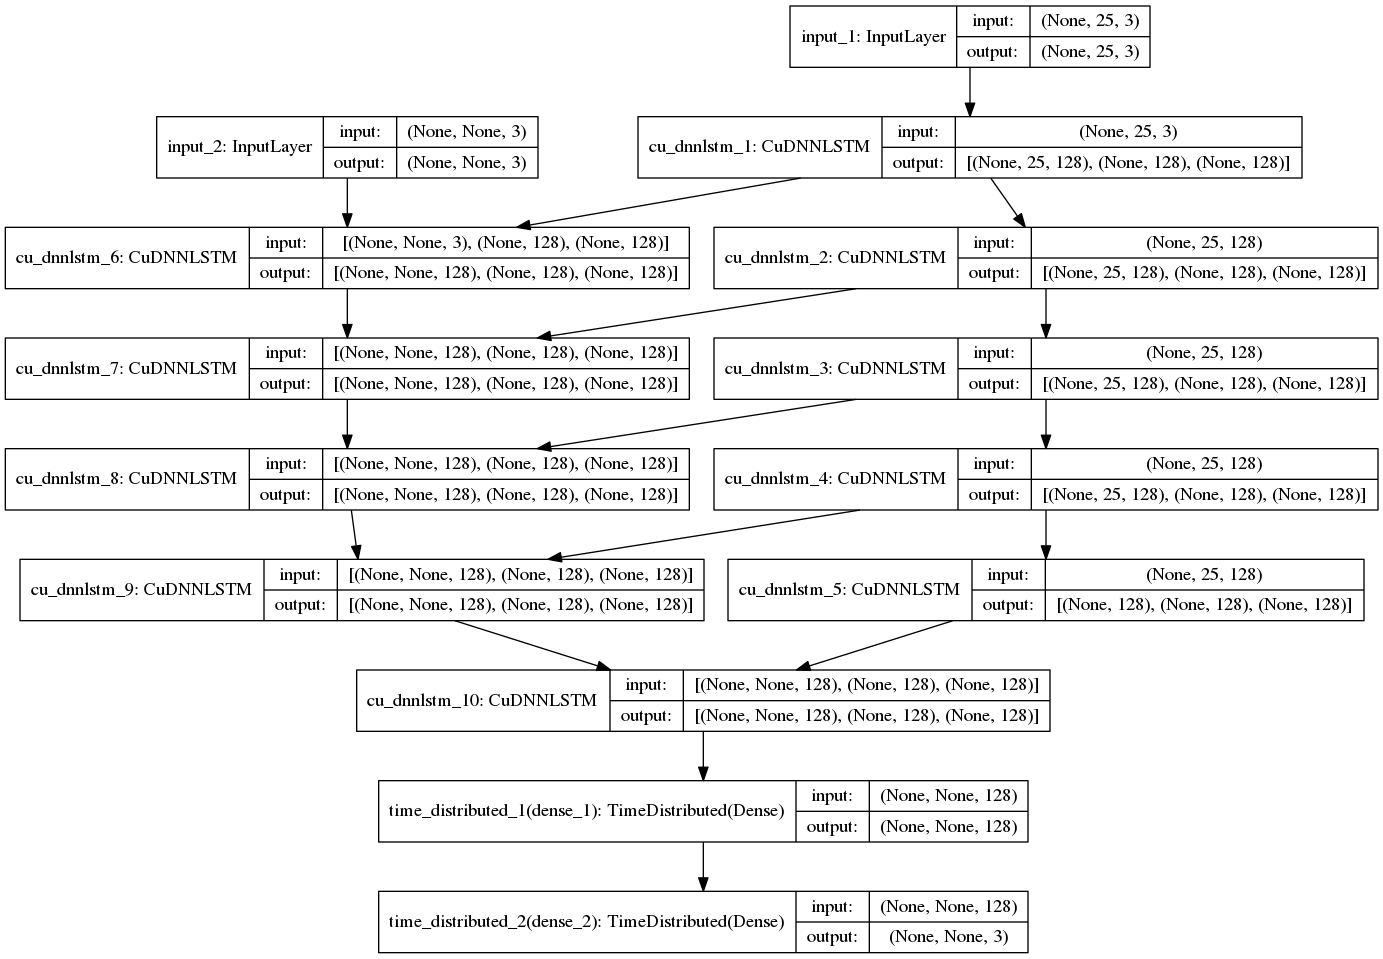

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(inputs=[encoder_inputs], outputs=encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_state_input_h2 = Input(shape=(latent_dim,))
decoder_state_input_c2 = Input(shape=(latent_dim,))
decoder_state_input_h3 = Input(shape=(latent_dim,))
decoder_state_input_c3 = Input(shape=(latent_dim,))
decoder_state_input_h4 = Input(shape=(latent_dim,))
decoder_state_input_c4 = Input(shape=(latent_dim,))
decoder_state_input_h5 = Input(shape=(latent_dim,))
decoder_state_input_c5 = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2,
                         decoder_state_input_h3, decoder_state_input_c3,
                         decoder_state_input_h4, decoder_state_input_c4,
                         decoder_state_input_h5, decoder_state_input_c5]

decoder_outputs_1, state_h1, state_c1 = decoder_1(decoder_inputs, initial_state=decoder_states_inputs[0:2])
decoder_outputs_2, state_h2, state_c2 = decoder_2(decoder_outputs_1, initial_state=decoder_states_inputs[2:4])
decoder_outputs_3, state_h3, state_c3 = decoder_3(decoder_outputs_2, initial_state=decoder_states_inputs[4:6])
decoder_outputs_4, state_h4, state_c4 = decoder_4(decoder_outputs_3, initial_state=decoder_states_inputs[6:8])
decoder_outputs_5, state_h5, state_c5 = decoder_4(decoder_outputs_4, initial_state=decoder_states_inputs[8:10])

decoder_states = [state_h1, state_c1,
                  state_h2, state_c2,
                  state_h3, state_c3,
                  state_h4, state_c4,
                  state_h5, state_c5,
                 ]

dense_output_1 = dense_1(decoder_outputs_5)
decoder_outputs = dense_2(dense_output_1)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((len(input_seq), 1, 3))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[:, 0, :] = np.sum(input_seq[:, -n_delay:, :], axis=1)

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((len(input_seq), len_delay, 3))
    
    for i in range(len_delay):
        output, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5 = decoder_model.predict([target_seq] + states_value)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((len(input_seq), 1, 3))
        target_seq[:, 0, :] = output[:,0,:]
        decoded_seq[:,i,:] = output[:,0,:]

        # Update states
        states_value = [h1, c1,
                        h2, c2,
                        h3, c3,
                        h4, c4,
                        h5, c5]

    return decoded_seq

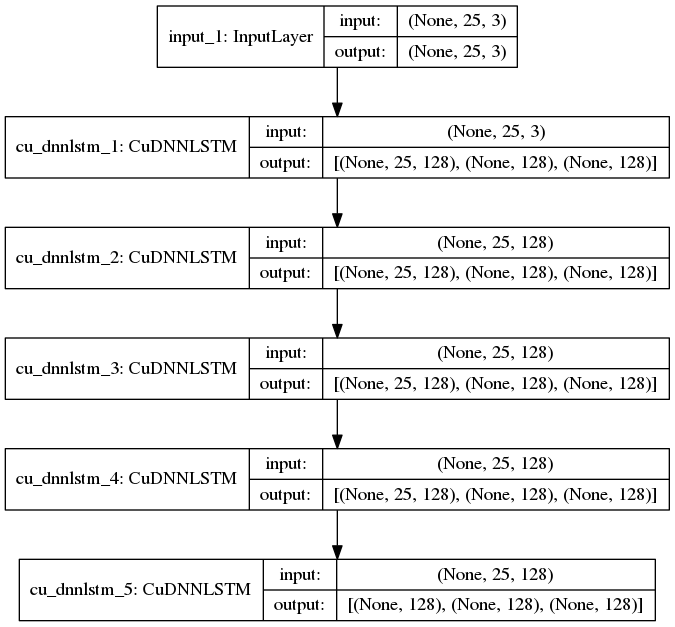

In [7]:
plot_model(encoder_model, to_file=experiment_name+'.png', show_shapes=True)

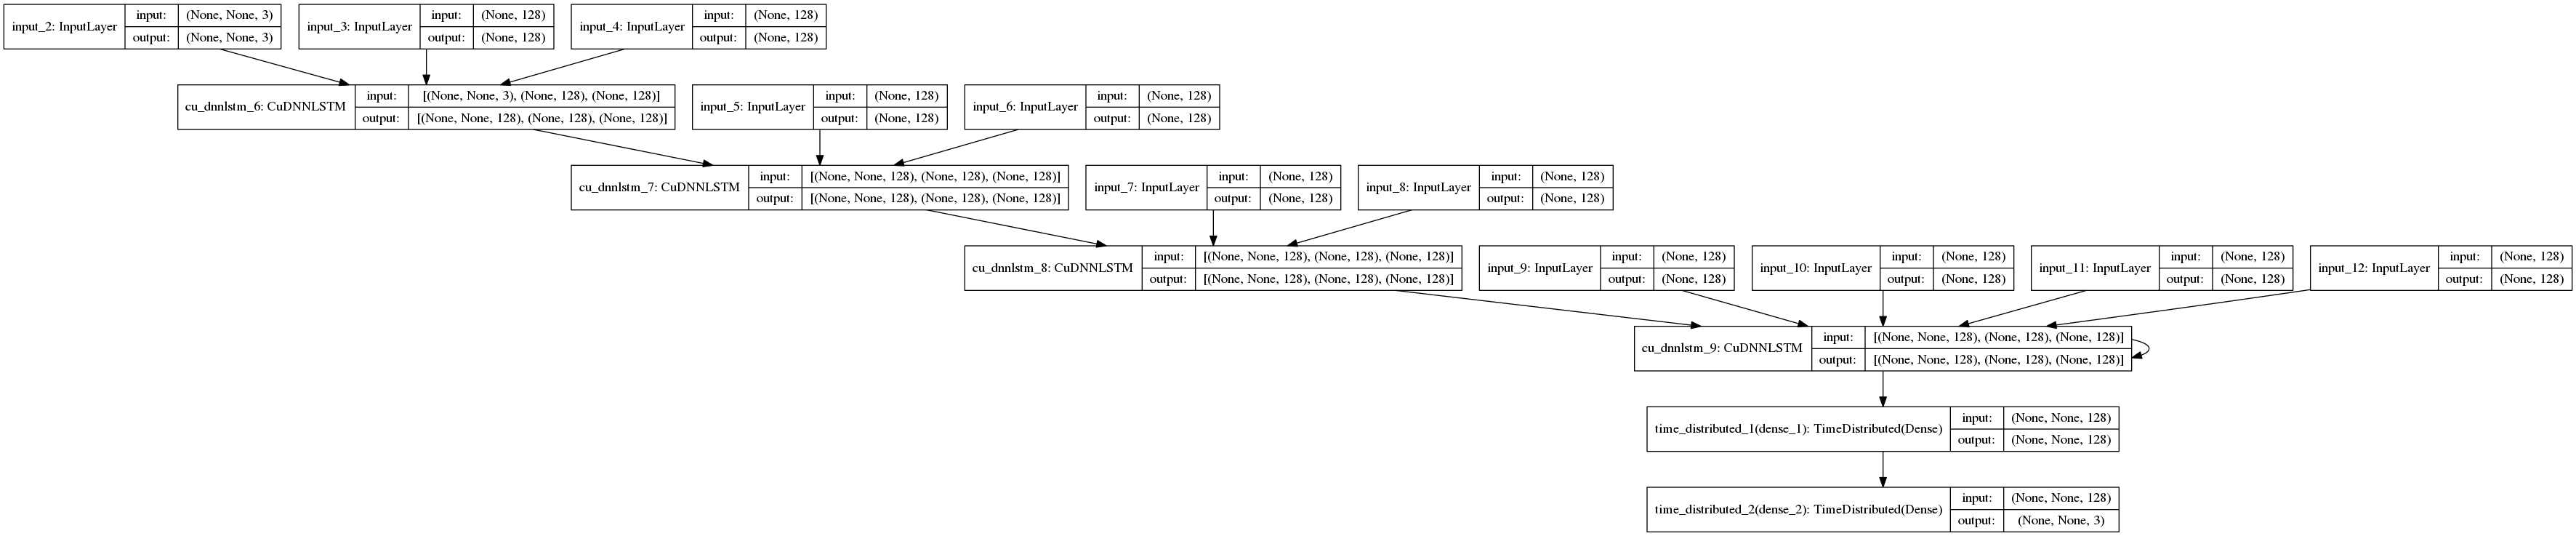

In [8]:
plot_model(decoder_model, to_file=experiment_name+'.png', show_shapes=True)

In [9]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [10]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [11]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

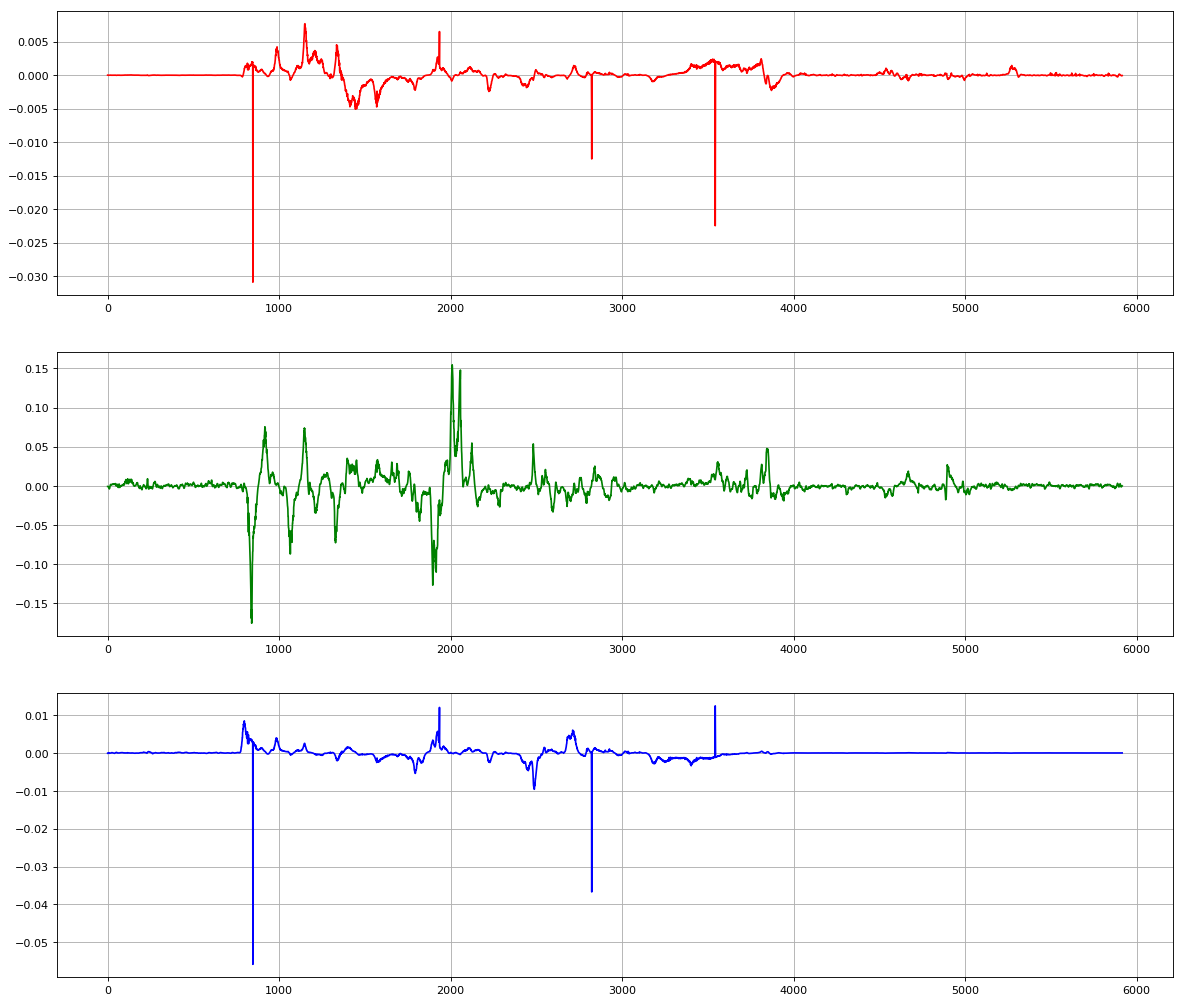

In [12]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [13]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 16:38 - loss: 0.0883 - rmse: 0.2191

  2/542 [..............................] - ETA: 9:31 - loss: 0.0831 - rmse: 0.2127 

  3/542 [..............................] - ETA: 7:08 - loss: 0.0755 - rmse: 0.1932

  4/542 [..............................] - ETA: 5:51 - loss: 0.0716 - rmse: 0.1768

  5/542 [..............................] - ETA: 5:09 - loss: 0.0739 - rmse: 0.1882

  6/542 [..............................] - ETA: 4:39 - loss: 0.0751 - rmse: 0.1925

  7/542 [..............................] - ETA: 4:18 - loss: 0.0718 - rmse: 0.1847

  8/542 [..............................] - ETA: 4:01 - loss: 0.0679 - rmse: 0.1742

  9/542 [..............................] - ETA: 3:48 - loss: 0.0687 - rmse: 0.1766

 10/542 [..............................] - ETA: 3:38 - loss: 0.0751 - rmse: 0.1878

 11/542 [..............................] - ETA: 3:30 - loss: 0.0738 - rmse: 0.1914

 12/542 [..............................] - ETA: 3:23 - loss: 0.0744 - rmse: 0.1913

 13/542 [..............................] - ETA: 3:18 - loss: 0.0693 - rmse: 0.1782

 14/542 [..............................] - ETA: 3:13 - loss: 0.0679 - rmse: 0.1777

 15/542 [..............................] - ETA: 3:09 - loss: 0.0670 - rmse: 0.1772

 16/542 [..............................] - ETA: 3:05 - loss: 0.0672 - rmse: 0.1774

 17/542 [..............................] - ETA: 3:02 - loss: 0.0663 - rmse: 0.1774

 18/542 [..............................] - ETA: 2:59 - loss: 0.0681 - rmse: 0.1809

 19/542 [>.............................] - ETA: 2:56 - loss: 0.0666 - rmse: 0.1793

 20/542 [>.............................] - ETA: 2:53 - loss: 0.0651 - rmse: 0.1767

 21/542 [>.............................] - ETA: 2:50 - loss: 0.0666 - rmse: 0.1843

 22/542 [>.............................] - ETA: 2:48 - loss: 0.0668 - rmse: 0.1842

 23/542 [>.............................] - ETA: 2:47 - loss: 0.0654 - rmse: 0.1802

 24/542 [>.............................] - ETA: 2:45 - loss: 0.0643 - rmse: 0.1770

 25/542 [>.............................] - ETA: 2:43 - loss: 0.0640 - rmse: 0.1765

 26/542 [>.............................] - ETA: 2:40 - loss: 0.0644 - rmse: 0.1780

 27/542 [>.............................] - ETA: 2:39 - loss: 0.0645 - rmse: 0.1790

 28/542 [>.............................] - ETA: 2:38 - loss: 0.0640 - rmse: 0.1780

 29/542 [>.............................] - ETA: 2:37 - loss: 0.0658 - rmse: 0.1831

 30/542 [>.............................] - ETA: 2:35 - loss: 0.0656 - rmse: 0.1844

 31/542 [>.............................] - ETA: 2:34 - loss: 0.0662 - rmse: 0.1859

 32/542 [>.............................] - ETA: 2:33 - loss: 0.0648 - rmse: 0.1821

 33/542 [>.............................] - ETA: 2:32 - loss: 0.0647 - rmse: 0.1828

 34/542 [>.............................] - ETA: 2:31 - loss: 0.0643 - rmse: 0.1811

 35/542 [>.............................] - ETA: 2:30 - loss: 0.0646 - rmse: 0.1818

 36/542 [>.............................] - ETA: 2:29 - loss: 0.0636 - rmse: 0.1808

 37/542 [=>............................] - ETA: 2:28 - loss: 0.0629 - rmse: 0.1781

 38/542 [=>............................] - ETA: 2:28 - loss: 0.0631 - rmse: 0.1777

 39/542 [=>............................] - ETA: 2:27 - loss: 0.0629 - rmse: 0.1771

 40/542 [=>............................] - ETA: 2:25 - loss: 0.0639 - rmse: 0.1789

 41/542 [=>............................] - ETA: 2:25 - loss: 0.0638 - rmse: 0.1779

 42/542 [=>............................] - ETA: 2:24 - loss: 0.0637 - rmse: 0.1779

 43/542 [=>............................] - ETA: 2:23 - loss: 0.0631 - rmse: 0.1758

 44/542 [=>............................] - ETA: 2:23 - loss: 0.0629 - rmse: 0.1748

 45/542 [=>............................] - ETA: 2:22 - loss: 0.0636 - rmse: 0.1763

 46/542 [=>............................] - ETA: 2:21 - loss: 0.0642 - rmse: 0.1768

 47/542 [=>............................] - ETA: 2:21 - loss: 0.0635 - rmse: 0.1751

 48/542 [=>............................] - ETA: 2:20 - loss: 0.0638 - rmse: 0.1772

 49/542 [=>............................] - ETA: 2:19 - loss: 0.0639 - rmse: 0.1771

 50/542 [=>............................] - ETA: 2:18 - loss: 0.0629 - rmse: 0.1741

 51/542 [=>............................] - ETA: 2:18 - loss: 0.0630 - rmse: 0.1738

 52/542 [=>............................] - ETA: 2:17 - loss: 0.0636 - rmse: 0.1755

 53/542 [=>............................] - ETA: 2:17 - loss: 0.0637 - rmse: 0.1759

 54/542 [=>............................] - ETA: 2:15 - loss: 0.0635 - rmse: 0.1754

 55/542 [==>...........................] - ETA: 2:15 - loss: 0.0630 - rmse: 0.1745

 56/542 [==>...........................] - ETA: 2:14 - loss: 0.0633 - rmse: 0.1752

 57/542 [==>...........................] - ETA: 2:14 - loss: 0.0629 - rmse: 0.1740

 58/542 [==>...........................] - ETA: 2:13 - loss: 0.0624 - rmse: 0.1725

 59/542 [==>...........................] - ETA: 2:13 - loss: 0.0623 - rmse: 0.1723

 60/542 [==>...........................] - ETA: 2:12 - loss: 0.0614 - rmse: 0.1698

 61/542 [==>...........................] - ETA: 2:12 - loss: 0.0614 - rmse: 0.1700

 62/542 [==>...........................] - ETA: 2:11 - loss: 0.0621 - rmse: 0.1708

 63/542 [==>...........................] - ETA: 2:10 - loss: 0.0628 - rmse: 0.1728

 64/542 [==>...........................] - ETA: 2:10 - loss: 0.0635 - rmse: 0.1742

 65/542 [==>...........................] - ETA: 2:09 - loss: 0.0629 - rmse: 0.1735

 66/542 [==>...........................] - ETA: 2:09 - loss: 0.0632 - rmse: 0.1741

 67/542 [==>...........................] - ETA: 2:08 - loss: 0.0634 - rmse: 0.1743

 68/542 [==>...........................] - ETA: 2:08 - loss: 0.0636 - rmse: 0.1748

 69/542 [==>...........................] - ETA: 2:07 - loss: 0.0639 - rmse: 0.1756

 70/542 [==>...........................] - ETA: 2:07 - loss: 0.0635 - rmse: 0.1746

 71/542 [==>...........................] - ETA: 2:07 - loss: 0.0632 - rmse: 0.1745

 72/542 [==>...........................] - ETA: 2:06 - loss: 0.0636 - rmse: 0.1755

 73/542 [===>..........................] - ETA: 2:06 - loss: 0.0636 - rmse: 0.1758

 74/542 [===>..........................] - ETA: 2:05 - loss: 0.0638 - rmse: 0.1760

 75/542 [===>..........................] - ETA: 2:05 - loss: 0.0643 - rmse: 0.1772

 76/542 [===>..........................] - ETA: 2:05 - loss: 0.0638 - rmse: 0.1763

 77/542 [===>..........................] - ETA: 2:04 - loss: 0.0637 - rmse: 0.1762

 78/542 [===>..........................] - ETA: 2:04 - loss: 0.0631 - rmse: 0.1746

 79/542 [===>..........................] - ETA: 2:04 - loss: 0.0632 - rmse: 0.1745

 80/542 [===>..........................] - ETA: 2:03 - loss: 0.0633 - rmse: 0.1746

 81/542 [===>..........................] - ETA: 2:03 - loss: 0.0631 - rmse: 0.1738

 82/542 [===>..........................] - ETA: 2:02 - loss: 0.0633 - rmse: 0.1740

 83/542 [===>..........................] - ETA: 2:02 - loss: 0.0629 - rmse: 0.1729

 84/542 [===>..........................] - ETA: 2:02 - loss: 0.0628 - rmse: 0.1724

 85/542 [===>..........................] - ETA: 2:01 - loss: 0.0625 - rmse: 0.1713

 86/542 [===>..........................] - ETA: 2:01 - loss: 0.0624 - rmse: 0.1710

 87/542 [===>..........................] - ETA: 2:01 - loss: 0.0624 - rmse: 0.1710

 88/542 [===>..........................] - ETA: 2:00 - loss: 0.0621 - rmse: 0.1698

 89/542 [===>..........................] - ETA: 2:00 - loss: 0.0620 - rmse: 0.1698

 90/542 [===>..........................] - ETA: 2:00 - loss: 0.0620 - rmse: 0.1694

 91/542 [====>.........................] - ETA: 1:59 - loss: 0.0621 - rmse: 0.1697

 92/542 [====>.........................] - ETA: 1:59 - loss: 0.0619 - rmse: 0.1690

 93/542 [====>.........................] - ETA: 1:59 - loss: 0.0615 - rmse: 0.1676

 94/542 [====>.........................] - ETA: 1:58 - loss: 0.0613 - rmse: 0.1673

 95/542 [====>.........................] - ETA: 1:58 - loss: 0.0611 - rmse: 0.1664

 96/542 [====>.........................] - ETA: 1:58 - loss: 0.0608 - rmse: 0.1657

 97/542 [====>.........................] - ETA: 1:57 - loss: 0.0612 - rmse: 0.1670

 98/542 [====>.........................] - ETA: 1:57 - loss: 0.0613 - rmse: 0.1668

 99/542 [====>.........................] - ETA: 1:57 - loss: 0.0612 - rmse: 0.1664

100/542 [====>.........................] - ETA: 1:56 - loss: 0.0608 - rmse: 0.1654

101/542 [====>.........................] - ETA: 1:56 - loss: 0.0610 - rmse: 0.1656

102/542 [====>.........................] - ETA: 1:55 - loss: 0.0606 - rmse: 0.1645

103/542 [====>.........................] - ETA: 1:55 - loss: 0.0603 - rmse: 0.1639

104/542 [====>.........................] - ETA: 1:55 - loss: 0.0600 - rmse: 0.1632

105/542 [====>.........................] - ETA: 1:54 - loss: 0.0599 - rmse: 0.1627

106/542 [====>.........................] - ETA: 1:54 - loss: 0.0596 - rmse: 0.1617

107/542 [====>.........................] - ETA: 1:54 - loss: 0.0592 - rmse: 0.1610

108/542 [====>.........................] - ETA: 1:54 - loss: 0.0591 - rmse: 0.1606

109/542 [=====>........................] - ETA: 1:53 - loss: 0.0587 - rmse: 0.1597

110/542 [=====>........................] - ETA: 1:53 - loss: 0.0587 - rmse: 0.1592

111/542 [=====>........................] - ETA: 1:52 - loss: 0.0588 - rmse: 0.1595

112/542 [=====>........................] - ETA: 1:52 - loss: 0.0588 - rmse: 0.1594

113/542 [=====>........................] - ETA: 1:52 - loss: 0.0587 - rmse: 0.1588

114/542 [=====>........................] - ETA: 1:51 - loss: 0.0583 - rmse: 0.1577

115/542 [=====>........................] - ETA: 1:51 - loss: 0.0581 - rmse: 0.1570

116/542 [=====>........................] - ETA: 1:50 - loss: 0.0581 - rmse: 0.1568

117/542 [=====>........................] - ETA: 1:50 - loss: 0.0580 - rmse: 0.1563

118/542 [=====>........................] - ETA: 1:50 - loss: 0.0579 - rmse: 0.1559

119/542 [=====>........................] - ETA: 1:49 - loss: 0.0577 - rmse: 0.1551

120/542 [=====>........................] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1544

121/542 [=====>........................] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1543

122/542 [=====>........................] - ETA: 1:48 - loss: 0.0576 - rmse: 0.1544

123/542 [=====>........................] - ETA: 1:48 - loss: 0.0574 - rmse: 0.1537

124/542 [=====>........................] - ETA: 1:48 - loss: 0.0572 - rmse: 0.1532

125/542 [=====>........................] - ETA: 1:48 - loss: 0.0572 - rmse: 0.1530

126/542 [=====>........................] - ETA: 1:47 - loss: 0.0572 - rmse: 0.1529

127/542 [======>.......................] - ETA: 1:47 - loss: 0.0569 - rmse: 0.1519

128/542 [======>.......................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1514

129/542 [======>.......................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1512

130/542 [======>.......................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1506

131/542 [======>.......................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1504

132/542 [======>.......................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1502

133/542 [======>.......................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1495

134/542 [======>.......................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1489

135/542 [======>.......................] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1486

136/542 [======>.......................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1478

137/542 [======>.......................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1476

138/542 [======>.......................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1474

139/542 [======>.......................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1466

140/542 [======>.......................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1461

141/542 [======>.......................] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1456

142/542 [======>.......................] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1452

143/542 [======>.......................] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1445

144/542 [======>.......................] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1440

145/542 [=======>......................] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1441

146/542 [=======>......................] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1436

147/542 [=======>......................] - ETA: 1:41 - loss: 0.0538 - rmse: 0.1429

148/542 [=======>......................] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1423

149/542 [=======>......................] - ETA: 1:41 - loss: 0.0535 - rmse: 0.1418

150/542 [=======>......................] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1412

151/542 [=======>......................] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1410

152/542 [=======>......................] - ETA: 1:40 - loss: 0.0532 - rmse: 0.1407

153/542 [=======>......................] - ETA: 1:40 - loss: 0.0531 - rmse: 0.1402

154/542 [=======>......................] - ETA: 1:39 - loss: 0.0532 - rmse: 0.1403

155/542 [=======>......................] - ETA: 1:39 - loss: 0.0531 - rmse: 0.1400

156/542 [=======>......................] - ETA: 1:39 - loss: 0.0530 - rmse: 0.1399

157/542 [=======>......................] - ETA: 1:39 - loss: 0.0531 - rmse: 0.1400

158/542 [=======>......................] - ETA: 1:38 - loss: 0.0529 - rmse: 0.1394

159/542 [=======>......................] - ETA: 1:38 - loss: 0.0526 - rmse: 0.1389

160/542 [=======>......................] - ETA: 1:38 - loss: 0.0525 - rmse: 0.1384

161/542 [=======>......................] - ETA: 1:37 - loss: 0.0524 - rmse: 0.1380

162/542 [=======>......................] - ETA: 1:37 - loss: 0.0523 - rmse: 0.1376

163/542 [========>.....................] - ETA: 1:37 - loss: 0.0521 - rmse: 0.1372

164/542 [========>.....................] - ETA: 1:37 - loss: 0.0520 - rmse: 0.1368

165/542 [========>.....................] - ETA: 1:36 - loss: 0.0518 - rmse: 0.1364

166/542 [========>.....................] - ETA: 1:36 - loss: 0.0518 - rmse: 0.1362

167/542 [========>.....................] - ETA: 1:36 - loss: 0.0515 - rmse: 0.1355

168/542 [========>.....................] - ETA: 1:35 - loss: 0.0515 - rmse: 0.1354

169/542 [========>.....................] - ETA: 1:35 - loss: 0.0514 - rmse: 0.1349

170/542 [========>.....................] - ETA: 1:35 - loss: 0.0513 - rmse: 0.1347

171/542 [========>.....................] - ETA: 1:35 - loss: 0.0512 - rmse: 0.1344

172/542 [========>.....................] - ETA: 1:34 - loss: 0.0511 - rmse: 0.1340

173/542 [========>.....................] - ETA: 1:34 - loss: 0.0509 - rmse: 0.1337

174/542 [========>.....................] - ETA: 1:34 - loss: 0.0508 - rmse: 0.1334

175/542 [========>.....................] - ETA: 1:34 - loss: 0.0508 - rmse: 0.1331

176/542 [========>.....................] - ETA: 1:34 - loss: 0.0506 - rmse: 0.1327

177/542 [========>.....................] - ETA: 1:33 - loss: 0.0505 - rmse: 0.1323

178/542 [========>.....................] - ETA: 1:33 - loss: 0.0504 - rmse: 0.1321

179/542 [========>.....................] - ETA: 1:33 - loss: 0.0504 - rmse: 0.1319

180/542 [========>.....................] - ETA: 1:32 - loss: 0.0504 - rmse: 0.1320

181/542 [=========>....................] - ETA: 1:32 - loss: 0.0501 - rmse: 0.1314

182/542 [=========>....................] - ETA: 1:32 - loss: 0.0502 - rmse: 0.1313

183/542 [=========>....................] - ETA: 1:32 - loss: 0.0500 - rmse: 0.1309

184/542 [=========>....................] - ETA: 1:31 - loss: 0.0500 - rmse: 0.1307

185/542 [=========>....................] - ETA: 1:31 - loss: 0.0499 - rmse: 0.1304

186/542 [=========>....................] - ETA: 1:31 - loss: 0.0498 - rmse: 0.1301

187/542 [=========>....................] - ETA: 1:31 - loss: 0.0498 - rmse: 0.1299

188/542 [=========>....................] - ETA: 1:30 - loss: 0.0497 - rmse: 0.1296

189/542 [=========>....................] - ETA: 1:30 - loss: 0.0496 - rmse: 0.1294

190/542 [=========>....................] - ETA: 1:30 - loss: 0.0495 - rmse: 0.1293

191/542 [=========>....................] - ETA: 1:29 - loss: 0.0496 - rmse: 0.1292

192/542 [=========>....................] - ETA: 1:29 - loss: 0.0495 - rmse: 0.1289

193/542 [=========>....................] - ETA: 1:29 - loss: 0.0494 - rmse: 0.1285

194/542 [=========>....................] - ETA: 1:29 - loss: 0.0494 - rmse: 0.1286

195/542 [=========>....................] - ETA: 1:28 - loss: 0.0493 - rmse: 0.1282

196/542 [=========>....................] - ETA: 1:28 - loss: 0.0492 - rmse: 0.1280

197/542 [=========>....................] - ETA: 1:28 - loss: 0.0492 - rmse: 0.1279

198/542 [=========>....................] - ETA: 1:28 - loss: 0.0490 - rmse: 0.1274

199/542 [==========>...................] - ETA: 1:27 - loss: 0.0490 - rmse: 0.1275

200/542 [==========>...................] - ETA: 1:27 - loss: 0.0489 - rmse: 0.1272

201/542 [==========>...................] - ETA: 1:27 - loss: 0.0487 - rmse: 0.1268

202/542 [==========>...................] - ETA: 1:27 - loss: 0.0486 - rmse: 0.1266

203/542 [==========>...................] - ETA: 1:26 - loss: 0.0487 - rmse: 0.1265

204/542 [==========>...................] - ETA: 1:26 - loss: 0.0486 - rmse: 0.1263

205/542 [==========>...................] - ETA: 1:26 - loss: 0.0485 - rmse: 0.1260

206/542 [==========>...................] - ETA: 1:25 - loss: 0.0483 - rmse: 0.1255

207/542 [==========>...................] - ETA: 1:25 - loss: 0.0483 - rmse: 0.1256

208/542 [==========>...................] - ETA: 1:25 - loss: 0.0483 - rmse: 0.1256

209/542 [==========>...................] - ETA: 1:25 - loss: 0.0481 - rmse: 0.1252

210/542 [==========>...................] - ETA: 1:24 - loss: 0.0480 - rmse: 0.1253

211/542 [==========>...................] - ETA: 1:24 - loss: 0.0480 - rmse: 0.1252

212/542 [==========>...................] - ETA: 1:24 - loss: 0.0479 - rmse: 0.1248

213/542 [==========>...................] - ETA: 1:24 - loss: 0.0477 - rmse: 0.1244

214/542 [==========>...................] - ETA: 1:23 - loss: 0.0477 - rmse: 0.1242

215/542 [==========>...................] - ETA: 1:23 - loss: 0.0476 - rmse: 0.1239

216/542 [==========>...................] - ETA: 1:23 - loss: 0.0476 - rmse: 0.1239

217/542 [===========>..................] - ETA: 1:23 - loss: 0.0476 - rmse: 0.1238

218/542 [===========>..................] - ETA: 1:22 - loss: 0.0474 - rmse: 0.1234

219/542 [===========>..................] - ETA: 1:22 - loss: 0.0474 - rmse: 0.1232

220/542 [===========>..................] - ETA: 1:22 - loss: 0.0473 - rmse: 0.1228

221/542 [===========>..................] - ETA: 1:22 - loss: 0.0473 - rmse: 0.1227

222/542 [===========>..................] - ETA: 1:21 - loss: 0.0471 - rmse: 0.1224

223/542 [===========>..................] - ETA: 1:21 - loss: 0.0470 - rmse: 0.1220

224/542 [===========>..................] - ETA: 1:21 - loss: 0.0469 - rmse: 0.1217

225/542 [===========>..................] - ETA: 1:21 - loss: 0.0470 - rmse: 0.1218

226/542 [===========>..................] - ETA: 1:21 - loss: 0.0470 - rmse: 0.1217

227/542 [===========>..................] - ETA: 1:20 - loss: 0.0469 - rmse: 0.1215

228/542 [===========>..................] - ETA: 1:20 - loss: 0.0469 - rmse: 0.1214

229/542 [===========>..................] - ETA: 1:20 - loss: 0.0469 - rmse: 0.1214

230/542 [===========>..................] - ETA: 1:20 - loss: 0.0468 - rmse: 0.1211

231/542 [===========>..................] - ETA: 1:19 - loss: 0.0467 - rmse: 0.1208

232/542 [===========>..................] - ETA: 1:19 - loss: 0.0466 - rmse: 0.1207

233/542 [===========>..................] - ETA: 1:19 - loss: 0.0466 - rmse: 0.1205

234/542 [===========>..................] - ETA: 1:18 - loss: 0.0465 - rmse: 0.1202

235/542 [============>.................] - ETA: 1:18 - loss: 0.0464 - rmse: 0.1200

236/542 [============>.................] - ETA: 1:18 - loss: 0.0462 - rmse: 0.1196

237/542 [============>.................] - ETA: 1:18 - loss: 0.0461 - rmse: 0.1193

238/542 [============>.................] - ETA: 1:17 - loss: 0.0461 - rmse: 0.1191

239/542 [============>.................] - ETA: 1:17 - loss: 0.0460 - rmse: 0.1190

240/542 [============>.................] - ETA: 1:17 - loss: 0.0459 - rmse: 0.1187

241/542 [============>.................] - ETA: 1:17 - loss: 0.0458 - rmse: 0.1184

242/542 [============>.................] - ETA: 1:16 - loss: 0.0458 - rmse: 0.1184

243/542 [============>.................] - ETA: 1:16 - loss: 0.0458 - rmse: 0.1182

244/542 [============>.................] - ETA: 1:16 - loss: 0.0458 - rmse: 0.1181

245/542 [============>.................] - ETA: 1:16 - loss: 0.0456 - rmse: 0.1177

246/542 [============>.................] - ETA: 1:15 - loss: 0.0455 - rmse: 0.1175

247/542 [============>.................] - ETA: 1:15 - loss: 0.0455 - rmse: 0.1174

248/542 [============>.................] - ETA: 1:15 - loss: 0.0455 - rmse: 0.1173

249/542 [============>.................] - ETA: 1:15 - loss: 0.0454 - rmse: 0.1171

250/542 [============>.................] - ETA: 1:14 - loss: 0.0454 - rmse: 0.1170

251/542 [============>.................] - ETA: 1:14 - loss: 0.0452 - rmse: 0.1166

252/542 [============>.................] - ETA: 1:14 - loss: 0.0451 - rmse: 0.1164

253/542 [=============>................] - ETA: 1:14 - loss: 0.0450 - rmse: 0.1161

254/542 [=============>................] - ETA: 1:13 - loss: 0.0450 - rmse: 0.1160

255/542 [=============>................] - ETA: 1:13 - loss: 0.0450 - rmse: 0.1158

256/542 [=============>................] - ETA: 1:13 - loss: 0.0448 - rmse: 0.1155

257/542 [=============>................] - ETA: 1:12 - loss: 0.0447 - rmse: 0.1152

258/542 [=============>................] - ETA: 1:12 - loss: 0.0446 - rmse: 0.1150

259/542 [=============>................] - ETA: 1:12 - loss: 0.0445 - rmse: 0.1148

260/542 [=============>................] - ETA: 1:12 - loss: 0.0445 - rmse: 0.1147

261/542 [=============>................] - ETA: 1:11 - loss: 0.0445 - rmse: 0.1147

262/542 [=============>................] - ETA: 1:11 - loss: 0.0446 - rmse: 0.1149

263/542 [=============>................] - ETA: 1:11 - loss: 0.0445 - rmse: 0.1148

264/542 [=============>................] - ETA: 1:11 - loss: 0.0444 - rmse: 0.1146

265/542 [=============>................] - ETA: 1:10 - loss: 0.0444 - rmse: 0.1145

266/542 [=============>................] - ETA: 1:10 - loss: 0.0444 - rmse: 0.1145

267/542 [=============>................] - ETA: 1:10 - loss: 0.0444 - rmse: 0.1144

268/542 [=============>................] - ETA: 1:10 - loss: 0.0444 - rmse: 0.1144

269/542 [=============>................] - ETA: 1:09 - loss: 0.0444 - rmse: 0.1143

270/542 [=============>................] - ETA: 1:09 - loss: 0.0443 - rmse: 0.1142

271/542 [==============>...............] - ETA: 1:09 - loss: 0.0443 - rmse: 0.1141

272/542 [==============>...............] - ETA: 1:09 - loss: 0.0443 - rmse: 0.1140

273/542 [==============>...............] - ETA: 1:08 - loss: 0.0442 - rmse: 0.1138

274/542 [==============>...............] - ETA: 1:08 - loss: 0.0441 - rmse: 0.1135

275/542 [==============>...............] - ETA: 1:08 - loss: 0.0441 - rmse: 0.1134

276/542 [==============>...............] - ETA: 1:07 - loss: 0.0441 - rmse: 0.1134

277/542 [==============>...............] - ETA: 1:07 - loss: 0.0440 - rmse: 0.1132

278/542 [==============>...............] - ETA: 1:07 - loss: 0.0440 - rmse: 0.1131

279/542 [==============>...............] - ETA: 1:07 - loss: 0.0440 - rmse: 0.1131

280/542 [==============>...............] - ETA: 1:06 - loss: 0.0439 - rmse: 0.1129

281/542 [==============>...............] - ETA: 1:06 - loss: 0.0438 - rmse: 0.1126

282/542 [==============>...............] - ETA: 1:06 - loss: 0.0437 - rmse: 0.1123

283/542 [==============>...............] - ETA: 1:06 - loss: 0.0437 - rmse: 0.1123

284/542 [==============>...............] - ETA: 1:05 - loss: 0.0437 - rmse: 0.1122

285/542 [==============>...............] - ETA: 1:05 - loss: 0.0437 - rmse: 0.1121

286/542 [==============>...............] - ETA: 1:05 - loss: 0.0437 - rmse: 0.1119

287/542 [==============>...............] - ETA: 1:05 - loss: 0.0436 - rmse: 0.1117

288/542 [==============>...............] - ETA: 1:04 - loss: 0.0436 - rmse: 0.1116

289/542 [==============>...............] - ETA: 1:04 - loss: 0.0436 - rmse: 0.1114

290/542 [===============>..............] - ETA: 1:04 - loss: 0.0436 - rmse: 0.1114

291/542 [===============>..............] - ETA: 1:04 - loss: 0.0437 - rmse: 0.1115

292/542 [===============>..............] - ETA: 1:03 - loss: 0.0436 - rmse: 0.1114

293/542 [===============>..............] - ETA: 1:03 - loss: 0.0436 - rmse: 0.1114

294/542 [===============>..............] - ETA: 1:03 - loss: 0.0436 - rmse: 0.1113

295/542 [===============>..............] - ETA: 1:02 - loss: 0.0435 - rmse: 0.1110

296/542 [===============>..............] - ETA: 1:02 - loss: 0.0435 - rmse: 0.1110

297/542 [===============>..............] - ETA: 1:02 - loss: 0.0435 - rmse: 0.1109

298/542 [===============>..............] - ETA: 1:02 - loss: 0.0434 - rmse: 0.1107

299/542 [===============>..............] - ETA: 1:01 - loss: 0.0433 - rmse: 0.1105

300/542 [===============>..............] - ETA: 1:01 - loss: 0.0433 - rmse: 0.1104

301/542 [===============>..............] - ETA: 1:01 - loss: 0.0433 - rmse: 0.1103

302/542 [===============>..............] - ETA: 1:01 - loss: 0.0433 - rmse: 0.1104

303/542 [===============>..............] - ETA: 1:00 - loss: 0.0432 - rmse: 0.1103

304/542 [===============>..............] - ETA: 1:00 - loss: 0.0432 - rmse: 0.1104

305/542 [===============>..............] - ETA: 1:00 - loss: 0.0431 - rmse: 0.1101

306/542 [===============>..............] - ETA: 1:00 - loss: 0.0431 - rmse: 0.1100

307/542 [===============>..............] - ETA: 59s - loss: 0.0431 - rmse: 0.1100 

308/542 [================>.............] - ETA: 59s - loss: 0.0430 - rmse: 0.1098

309/542 [================>.............] - ETA: 59s - loss: 0.0430 - rmse: 0.1097

310/542 [================>.............] - ETA: 59s - loss: 0.0430 - rmse: 0.1095

311/542 [================>.............] - ETA: 58s - loss: 0.0429 - rmse: 0.1094

312/542 [================>.............] - ETA: 58s - loss: 0.0429 - rmse: 0.1094

313/542 [================>.............] - ETA: 58s - loss: 0.0429 - rmse: 0.1094

314/542 [================>.............] - ETA: 58s - loss: 0.0429 - rmse: 0.1093

315/542 [================>.............] - ETA: 57s - loss: 0.0429 - rmse: 0.1091

316/542 [================>.............] - ETA: 57s - loss: 0.0429 - rmse: 0.1090

317/542 [================>.............] - ETA: 57s - loss: 0.0428 - rmse: 0.1088

318/542 [================>.............] - ETA: 57s - loss: 0.0427 - rmse: 0.1086

319/542 [================>.............] - ETA: 56s - loss: 0.0426 - rmse: 0.1084

320/542 [================>.............] - ETA: 56s - loss: 0.0426 - rmse: 0.1082

321/542 [================>.............] - ETA: 56s - loss: 0.0425 - rmse: 0.1080

322/542 [================>.............] - ETA: 56s - loss: 0.0425 - rmse: 0.1080

323/542 [================>.............] - ETA: 55s - loss: 0.0425 - rmse: 0.1079

324/542 [================>.............] - ETA: 55s - loss: 0.0425 - rmse: 0.1077

325/542 [================>.............] - ETA: 55s - loss: 0.0424 - rmse: 0.1076

326/542 [=================>............] - ETA: 54s - loss: 0.0424 - rmse: 0.1075

327/542 [=================>............] - ETA: 54s - loss: 0.0424 - rmse: 0.1073

328/542 [=================>............] - ETA: 54s - loss: 0.0424 - rmse: 0.1074

329/542 [=================>............] - ETA: 54s - loss: 0.0423 - rmse: 0.1073

330/542 [=================>............] - ETA: 53s - loss: 0.0424 - rmse: 0.1073

331/542 [=================>............] - ETA: 53s - loss: 0.0424 - rmse: 0.1073

332/542 [=================>............] - ETA: 53s - loss: 0.0424 - rmse: 0.1072

333/542 [=================>............] - ETA: 53s - loss: 0.0424 - rmse: 0.1073

334/542 [=================>............] - ETA: 52s - loss: 0.0423 - rmse: 0.1072

335/542 [=================>............] - ETA: 52s - loss: 0.0423 - rmse: 0.1071

336/542 [=================>............] - ETA: 52s - loss: 0.0422 - rmse: 0.1070

337/542 [=================>............] - ETA: 52s - loss: 0.0422 - rmse: 0.1069

338/542 [=================>............] - ETA: 51s - loss: 0.0422 - rmse: 0.1067

339/542 [=================>............] - ETA: 51s - loss: 0.0422 - rmse: 0.1066

340/542 [=================>............] - ETA: 51s - loss: 0.0422 - rmse: 0.1066

341/542 [=================>............] - ETA: 51s - loss: 0.0422 - rmse: 0.1066

342/542 [=================>............] - ETA: 50s - loss: 0.0421 - rmse: 0.1065

343/542 [=================>............] - ETA: 50s - loss: 0.0421 - rmse: 0.1064

344/542 [==================>...........] - ETA: 50s - loss: 0.0420 - rmse: 0.1063

345/542 [==================>...........] - ETA: 50s - loss: 0.0421 - rmse: 0.1065

346/542 [==================>...........] - ETA: 49s - loss: 0.0421 - rmse: 0.1063

347/542 [==================>...........] - ETA: 49s - loss: 0.0420 - rmse: 0.1061

348/542 [==================>...........] - ETA: 49s - loss: 0.0420 - rmse: 0.1060

349/542 [==================>...........] - ETA: 49s - loss: 0.0420 - rmse: 0.1061

350/542 [==================>...........] - ETA: 48s - loss: 0.0420 - rmse: 0.1059

351/542 [==================>...........] - ETA: 48s - loss: 0.0420 - rmse: 0.1060

352/542 [==================>...........] - ETA: 48s - loss: 0.0419 - rmse: 0.1058

353/542 [==================>...........] - ETA: 48s - loss: 0.0419 - rmse: 0.1057

354/542 [==================>...........] - ETA: 47s - loss: 0.0419 - rmse: 0.1056

355/542 [==================>...........] - ETA: 47s - loss: 0.0418 - rmse: 0.1054

356/542 [==================>...........] - ETA: 47s - loss: 0.0418 - rmse: 0.1053

357/542 [==================>...........] - ETA: 46s - loss: 0.0418 - rmse: 0.1053

358/542 [==================>...........] - ETA: 46s - loss: 0.0418 - rmse: 0.1053

359/542 [==================>...........] - ETA: 46s - loss: 0.0418 - rmse: 0.1053

360/542 [==================>...........] - ETA: 46s - loss: 0.0418 - rmse: 0.1053

361/542 [==================>...........] - ETA: 45s - loss: 0.0418 - rmse: 0.1053

362/542 [===================>..........] - ETA: 45s - loss: 0.0419 - rmse: 0.1053

363/542 [===================>..........] - ETA: 45s - loss: 0.0419 - rmse: 0.1053

364/542 [===================>..........] - ETA: 45s - loss: 0.0418 - rmse: 0.1052

365/542 [===================>..........] - ETA: 44s - loss: 0.0418 - rmse: 0.1051

366/542 [===================>..........] - ETA: 44s - loss: 0.0418 - rmse: 0.1051

367/542 [===================>..........] - ETA: 44s - loss: 0.0418 - rmse: 0.1051

368/542 [===================>..........] - ETA: 44s - loss: 0.0417 - rmse: 0.1050

369/542 [===================>..........] - ETA: 43s - loss: 0.0417 - rmse: 0.1049

370/542 [===================>..........] - ETA: 43s - loss: 0.0417 - rmse: 0.1048

371/542 [===================>..........] - ETA: 43s - loss: 0.0417 - rmse: 0.1049

372/542 [===================>..........] - ETA: 43s - loss: 0.0417 - rmse: 0.1049

373/542 [===================>..........] - ETA: 42s - loss: 0.0416 - rmse: 0.1047

374/542 [===================>..........] - ETA: 42s - loss: 0.0416 - rmse: 0.1047

375/542 [===================>..........] - ETA: 42s - loss: 0.0416 - rmse: 0.1046

376/542 [===================>..........] - ETA: 42s - loss: 0.0415 - rmse: 0.1044

377/542 [===================>..........] - ETA: 41s - loss: 0.0415 - rmse: 0.1045

378/542 [===================>..........] - ETA: 41s - loss: 0.0415 - rmse: 0.1044

379/542 [===================>..........] - ETA: 41s - loss: 0.0415 - rmse: 0.1044

380/542 [====================>.........] - ETA: 41s - loss: 0.0414 - rmse: 0.1042

381/542 [====================>.........] - ETA: 40s - loss: 0.0414 - rmse: 0.1042

382/542 [====================>.........] - ETA: 40s - loss: 0.0414 - rmse: 0.1044

383/542 [====================>.........] - ETA: 40s - loss: 0.0414 - rmse: 0.1042

384/542 [====================>.........] - ETA: 40s - loss: 0.0414 - rmse: 0.1043

385/542 [====================>.........] - ETA: 39s - loss: 0.0414 - rmse: 0.1043

386/542 [====================>.........] - ETA: 39s - loss: 0.0414 - rmse: 0.1042

387/542 [====================>.........] - ETA: 39s - loss: 0.0414 - rmse: 0.1042

388/542 [====================>.........] - ETA: 39s - loss: 0.0414 - rmse: 0.1043

389/542 [====================>.........] - ETA: 38s - loss: 0.0414 - rmse: 0.1042

390/542 [====================>.........] - ETA: 38s - loss: 0.0414 - rmse: 0.1042

391/542 [====================>.........] - ETA: 38s - loss: 0.0414 - rmse: 0.1041

392/542 [====================>.........] - ETA: 38s - loss: 0.0413 - rmse: 0.1039

393/542 [====================>.........] - ETA: 37s - loss: 0.0413 - rmse: 0.1038

394/542 [====================>.........] - ETA: 37s - loss: 0.0412 - rmse: 0.1036

395/542 [====================>.........] - ETA: 37s - loss: 0.0412 - rmse: 0.1035

396/542 [====================>.........] - ETA: 36s - loss: 0.0412 - rmse: 0.1034

397/542 [====================>.........] - ETA: 36s - loss: 0.0411 - rmse: 0.1033

398/542 [=====================>........] - ETA: 36s - loss: 0.0411 - rmse: 0.1032

399/542 [=====================>........] - ETA: 36s - loss: 0.0411 - rmse: 0.1032

400/542 [=====================>........] - ETA: 35s - loss: 0.0411 - rmse: 0.1031

401/542 [=====================>........] - ETA: 35s - loss: 0.0410 - rmse: 0.1030

402/542 [=====================>........] - ETA: 35s - loss: 0.0410 - rmse: 0.1030

403/542 [=====================>........] - ETA: 35s - loss: 0.0410 - rmse: 0.1029

404/542 [=====================>........] - ETA: 34s - loss: 0.0410 - rmse: 0.1028

405/542 [=====================>........] - ETA: 34s - loss: 0.0409 - rmse: 0.1026

406/542 [=====================>........] - ETA: 34s - loss: 0.0408 - rmse: 0.1025

407/542 [=====================>........] - ETA: 34s - loss: 0.0408 - rmse: 0.1024

408/542 [=====================>........] - ETA: 33s - loss: 0.0408 - rmse: 0.1023

409/542 [=====================>........] - ETA: 33s - loss: 0.0407 - rmse: 0.1021

410/542 [=====================>........] - ETA: 33s - loss: 0.0407 - rmse: 0.1020

411/542 [=====================>........] - ETA: 33s - loss: 0.0406 - rmse: 0.1019

412/542 [=====================>........] - ETA: 32s - loss: 0.0407 - rmse: 0.1019

413/542 [=====================>........] - ETA: 32s - loss: 0.0406 - rmse: 0.1017

414/542 [=====================>........] - ETA: 32s - loss: 0.0407 - rmse: 0.1018

415/542 [=====================>........] - ETA: 32s - loss: 0.0407 - rmse: 0.1017

416/542 [======================>.......] - ETA: 31s - loss: 0.0407 - rmse: 0.1017

417/542 [======================>.......] - ETA: 31s - loss: 0.0406 - rmse: 0.1016

418/542 [======================>.......] - ETA: 31s - loss: 0.0406 - rmse: 0.1014

419/542 [======================>.......] - ETA: 31s - loss: 0.0406 - rmse: 0.1014

420/542 [======================>.......] - ETA: 30s - loss: 0.0405 - rmse: 0.1012

421/542 [======================>.......] - ETA: 30s - loss: 0.0405 - rmse: 0.1011

422/542 [======================>.......] - ETA: 30s - loss: 0.0405 - rmse: 0.1011

423/542 [======================>.......] - ETA: 30s - loss: 0.0405 - rmse: 0.1011

424/542 [======================>.......] - ETA: 29s - loss: 0.0405 - rmse: 0.1011

425/542 [======================>.......] - ETA: 29s - loss: 0.0405 - rmse: 0.1011

426/542 [======================>.......] - ETA: 29s - loss: 0.0405 - rmse: 0.1011

427/542 [======================>.......] - ETA: 29s - loss: 0.0405 - rmse: 0.1010

428/542 [======================>.......] - ETA: 28s - loss: 0.0404 - rmse: 0.1009

429/542 [======================>.......] - ETA: 28s - loss: 0.0404 - rmse: 0.1009

430/542 [======================>.......] - ETA: 28s - loss: 0.0404 - rmse: 0.1009

431/542 [======================>.......] - ETA: 28s - loss: 0.0404 - rmse: 0.1009

432/542 [======================>.......] - ETA: 27s - loss: 0.0404 - rmse: 0.1009

433/542 [======================>.......] - ETA: 27s - loss: 0.0404 - rmse: 0.1009

434/542 [=======================>......] - ETA: 27s - loss: 0.0404 - rmse: 0.1009

435/542 [=======================>......] - ETA: 27s - loss: 0.0404 - rmse: 0.1008

436/542 [=======================>......] - ETA: 26s - loss: 0.0404 - rmse: 0.1009

437/542 [=======================>......] - ETA: 26s - loss: 0.0404 - rmse: 0.1009

438/542 [=======================>......] - ETA: 26s - loss: 0.0404 - rmse: 0.1008

439/542 [=======================>......] - ETA: 26s - loss: 0.0403 - rmse: 0.1007

440/542 [=======================>......] - ETA: 25s - loss: 0.0403 - rmse: 0.1006

441/542 [=======================>......] - ETA: 25s - loss: 0.0403 - rmse: 0.1005

442/542 [=======================>......] - ETA: 25s - loss: 0.0403 - rmse: 0.1006

443/542 [=======================>......] - ETA: 25s - loss: 0.0403 - rmse: 0.1005

444/542 [=======================>......] - ETA: 24s - loss: 0.0402 - rmse: 0.1003

445/542 [=======================>......] - ETA: 24s - loss: 0.0402 - rmse: 0.1003

446/542 [=======================>......] - ETA: 24s - loss: 0.0402 - rmse: 0.1003

447/542 [=======================>......] - ETA: 24s - loss: 0.0402 - rmse: 0.1001

448/542 [=======================>......] - ETA: 23s - loss: 0.0402 - rmse: 0.1001

449/542 [=======================>......] - ETA: 23s - loss: 0.0401 - rmse: 0.1000

450/542 [=======================>......] - ETA: 23s - loss: 0.0401 - rmse: 0.0999

451/542 [=======================>......] - ETA: 23s - loss: 0.0401 - rmse: 0.0999

452/542 [========================>.....] - ETA: 22s - loss: 0.0400 - rmse: 0.0997

453/542 [========================>.....] - ETA: 22s - loss: 0.0400 - rmse: 0.0997

454/542 [========================>.....] - ETA: 22s - loss: 0.0400 - rmse: 0.0997

455/542 [========================>.....] - ETA: 22s - loss: 0.0400 - rmse: 0.0996

456/542 [========================>.....] - ETA: 21s - loss: 0.0400 - rmse: 0.0995

457/542 [========================>.....] - ETA: 21s - loss: 0.0400 - rmse: 0.0994

458/542 [========================>.....] - ETA: 21s - loss: 0.0399 - rmse: 0.0993

459/542 [========================>.....] - ETA: 21s - loss: 0.0399 - rmse: 0.0992

460/542 [========================>.....] - ETA: 20s - loss: 0.0399 - rmse: 0.0993

461/542 [========================>.....] - ETA: 20s - loss: 0.0399 - rmse: 0.0993

462/542 [========================>.....] - ETA: 20s - loss: 0.0399 - rmse: 0.0992

463/542 [========================>.....] - ETA: 20s - loss: 0.0399 - rmse: 0.0992

464/542 [========================>.....] - ETA: 19s - loss: 0.0400 - rmse: 0.0993

465/542 [========================>.....] - ETA: 19s - loss: 0.0400 - rmse: 0.0993

466/542 [========================>.....] - ETA: 19s - loss: 0.0399 - rmse: 0.0992

467/542 [========================>.....] - ETA: 19s - loss: 0.0399 - rmse: 0.0991

468/542 [========================>.....] - ETA: 18s - loss: 0.0399 - rmse: 0.0991

469/542 [========================>.....] - ETA: 18s - loss: 0.0399 - rmse: 0.0991

470/542 [=========================>....] - ETA: 18s - loss: 0.0399 - rmse: 0.0990

471/542 [=========================>....] - ETA: 18s - loss: 0.0398 - rmse: 0.0990

472/542 [=========================>....] - ETA: 17s - loss: 0.0398 - rmse: 0.0989

473/542 [=========================>....] - ETA: 17s - loss: 0.0398 - rmse: 0.0988

474/542 [=========================>....] - ETA: 17s - loss: 0.0398 - rmse: 0.0988

475/542 [=========================>....] - ETA: 17s - loss: 0.0398 - rmse: 0.0988

476/542 [=========================>....] - ETA: 16s - loss: 0.0398 - rmse: 0.0988

477/542 [=========================>....] - ETA: 16s - loss: 0.0397 - rmse: 0.0987

478/542 [=========================>....] - ETA: 16s - loss: 0.0397 - rmse: 0.0985

479/542 [=========================>....] - ETA: 16s - loss: 0.0397 - rmse: 0.0987

480/542 [=========================>....] - ETA: 15s - loss: 0.0397 - rmse: 0.0986

481/542 [=========================>....] - ETA: 15s - loss: 0.0397 - rmse: 0.0986

482/542 [=========================>....] - ETA: 15s - loss: 0.0397 - rmse: 0.0986

483/542 [=========================>....] - ETA: 14s - loss: 0.0396 - rmse: 0.0986

484/542 [=========================>....] - ETA: 14s - loss: 0.0396 - rmse: 0.0985

485/542 [=========================>....] - ETA: 14s - loss: 0.0396 - rmse: 0.0985

486/542 [=========================>....] - ETA: 14s - loss: 0.0396 - rmse: 0.0984

487/542 [=========================>....] - ETA: 13s - loss: 0.0396 - rmse: 0.0983

488/542 [==========================>...] - ETA: 13s - loss: 0.0396 - rmse: 0.0983

489/542 [==========================>...] - ETA: 13s - loss: 0.0396 - rmse: 0.0983

490/542 [==========================>...] - ETA: 13s - loss: 0.0396 - rmse: 0.0983

491/542 [==========================>...] - ETA: 12s - loss: 0.0395 - rmse: 0.0981

492/542 [==========================>...] - ETA: 12s - loss: 0.0395 - rmse: 0.0980

493/542 [==========================>...] - ETA: 12s - loss: 0.0394 - rmse: 0.0979

494/542 [==========================>...] - ETA: 12s - loss: 0.0394 - rmse: 0.0977

495/542 [==========================>...] - ETA: 11s - loss: 0.0393 - rmse: 0.0976

496/542 [==========================>...] - ETA: 11s - loss: 0.0393 - rmse: 0.0976

497/542 [==========================>...] - ETA: 11s - loss: 0.0393 - rmse: 0.0976

498/542 [==========================>...] - ETA: 11s - loss: 0.0393 - rmse: 0.0975

499/542 [==========================>...] - ETA: 10s - loss: 0.0393 - rmse: 0.0975

500/542 [==========================>...] - ETA: 10s - loss: 0.0392 - rmse: 0.0974

501/542 [==========================>...] - ETA: 10s - loss: 0.0392 - rmse: 0.0974

502/542 [==========================>...] - ETA: 10s - loss: 0.0392 - rmse: 0.0973

503/542 [==========================>...] - ETA: 9s - loss: 0.0393 - rmse: 0.0974 

504/542 [==========================>...] - ETA: 9s - loss: 0.0393 - rmse: 0.0974

505/542 [==========================>...] - ETA: 9s - loss: 0.0392 - rmse: 0.0973

506/542 [===========================>..] - ETA: 9s - loss: 0.0392 - rmse: 0.0973

507/542 [===========================>..] - ETA: 8s - loss: 0.0392 - rmse: 0.0973

508/542 [===========================>..] - ETA: 8s - loss: 0.0392 - rmse: 0.0973

509/542 [===========================>..] - ETA: 8s - loss: 0.0392 - rmse: 0.0972

510/542 [===========================>..] - ETA: 8s - loss: 0.0392 - rmse: 0.0972

511/542 [===========================>..] - ETA: 7s - loss: 0.0392 - rmse: 0.0972

512/542 [===========================>..] - ETA: 7s - loss: 0.0392 - rmse: 0.0972

513/542 [===========================>..] - ETA: 7s - loss: 0.0392 - rmse: 0.0972

514/542 [===========================>..] - ETA: 7s - loss: 0.0392 - rmse: 0.0970

515/542 [===========================>..] - ETA: 6s - loss: 0.0392 - rmse: 0.0970

516/542 [===========================>..] - ETA: 6s - loss: 0.0391 - rmse: 0.0970

517/542 [===========================>..] - ETA: 6s - loss: 0.0391 - rmse: 0.0969

518/542 [===========================>..] - ETA: 6s - loss: 0.0391 - rmse: 0.0968

519/542 [===========================>..] - ETA: 5s - loss: 0.0391 - rmse: 0.0970

520/542 [===========================>..] - ETA: 5s - loss: 0.0391 - rmse: 0.0969

521/542 [===========================>..] - ETA: 5s - loss: 0.0391 - rmse: 0.0969

522/542 [===========================>..] - ETA: 5s - loss: 0.0391 - rmse: 0.0969

523/542 [===========================>..] - ETA: 4s - loss: 0.0391 - rmse: 0.0970

524/542 [============================>.] - ETA: 4s - loss: 0.0391 - rmse: 0.0970

525/542 [============================>.] - ETA: 4s - loss: 0.0391 - rmse: 0.0970

526/542 [============================>.] - ETA: 4s - loss: 0.0391 - rmse: 0.0971

527/542 [============================>.] - ETA: 3s - loss: 0.0391 - rmse: 0.0970

528/542 [============================>.] - ETA: 3s - loss: 0.0391 - rmse: 0.0969

529/542 [============================>.] - ETA: 3s - loss: 0.0391 - rmse: 0.0969

530/542 [============================>.] - ETA: 3s - loss: 0.0391 - rmse: 0.0969

531/542 [============================>.] - ETA: 2s - loss: 0.0390 - rmse: 0.0969

532/542 [============================>.] - ETA: 2s - loss: 0.0391 - rmse: 0.0969

533/542 [============================>.] - ETA: 2s - loss: 0.0391 - rmse: 0.0969

534/542 [============================>.] - ETA: 2s - loss: 0.0391 - rmse: 0.0970

535/542 [============================>.] - ETA: 1s - loss: 0.0391 - rmse: 0.0970

536/542 [============================>.] - ETA: 1s - loss: 0.0391 - rmse: 0.0970

537/542 [============================>.] - ETA: 1s - loss: 0.0391 - rmse: 0.0970

538/542 [============================>.] - ETA: 1s - loss: 0.0391 - rmse: 0.0969

539/542 [============================>.] - ETA: 0s - loss: 0.0390 - rmse: 0.0968

540/542 [============================>.] - ETA: 0s - loss: 0.0390 - rmse: 0.0968

541/542 [============================>.] - ETA: 0s - loss: 0.0390 - rmse: 0.0967

542/542 [==============================] - 149s 274ms/step - loss: 0.0390 - rmse: 0.0966 - val_loss: 0.0351 - val_rmse: 0.0863


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_7 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

Epoch 2/150


  1/542 [..............................] - ETA: 2:18 - loss: 0.0346 - rmse: 0.0739

  2/542 [..............................] - ETA: 2:20 - loss: 0.0327 - rmse: 0.0710

  3/542 [..............................] - ETA: 2:19 - loss: 0.0326 - rmse: 0.0758

  4/542 [..............................] - ETA: 2:20 - loss: 0.0342 - rmse: 0.0850

  5/542 [..............................] - ETA: 2:18 - loss: 0.0350 - rmse: 0.0892

  6/542 [..............................] - ETA: 2:14 - loss: 0.0343 - rmse: 0.0879

  7/542 [..............................] - ETA: 2:14 - loss: 0.0388 - rmse: 0.0959

  8/542 [..............................] - ETA: 2:14 - loss: 0.0366 - rmse: 0.0897

  9/542 [..............................] - ETA: 2:14 - loss: 0.0332 - rmse: 0.0814

 10/542 [..............................] - ETA: 2:14 - loss: 0.0331 - rmse: 0.0813

 11/542 [..............................] - ETA: 2:14 - loss: 0.0348 - rmse: 0.0850

 12/542 [..............................] - ETA: 2:14 - loss: 0.0350 - rmse: 0.0847

 13/542 [..............................] - ETA: 2:15 - loss: 0.0341 - rmse: 0.0818

 14/542 [..............................] - ETA: 2:15 - loss: 0.0330 - rmse: 0.0804

 15/542 [..............................] - ETA: 2:15 - loss: 0.0339 - rmse: 0.0822

 16/542 [..............................] - ETA: 2:14 - loss: 0.0325 - rmse: 0.0788

 17/542 [..............................] - ETA: 2:14 - loss: 0.0322 - rmse: 0.0777

 18/542 [..............................] - ETA: 2:13 - loss: 0.0325 - rmse: 0.0779

 19/542 [>.............................] - ETA: 2:13 - loss: 0.0328 - rmse: 0.0779

 20/542 [>.............................] - ETA: 2:13 - loss: 0.0331 - rmse: 0.0785

 21/542 [>.............................] - ETA: 2:12 - loss: 0.0340 - rmse: 0.0804

 22/542 [>.............................] - ETA: 2:12 - loss: 0.0345 - rmse: 0.0811

 23/542 [>.............................] - ETA: 2:12 - loss: 0.0341 - rmse: 0.0810

 24/542 [>.............................] - ETA: 2:11 - loss: 0.0344 - rmse: 0.0817

 25/542 [>.............................] - ETA: 2:11 - loss: 0.0349 - rmse: 0.0838

 26/542 [>.............................] - ETA: 2:10 - loss: 0.0353 - rmse: 0.0843

 27/542 [>.............................] - ETA: 2:10 - loss: 0.0350 - rmse: 0.0833

 28/542 [>.............................] - ETA: 2:10 - loss: 0.0352 - rmse: 0.0831

 29/542 [>.............................] - ETA: 2:10 - loss: 0.0354 - rmse: 0.0832

 30/542 [>.............................] - ETA: 2:09 - loss: 0.0353 - rmse: 0.0831

 31/542 [>.............................] - ETA: 2:09 - loss: 0.0347 - rmse: 0.0830

 32/542 [>.............................] - ETA: 2:09 - loss: 0.0343 - rmse: 0.0819

 33/542 [>.............................] - ETA: 2:09 - loss: 0.0343 - rmse: 0.0814

 34/542 [>.............................] - ETA: 2:09 - loss: 0.0348 - rmse: 0.0830

 35/542 [>.............................] - ETA: 2:09 - loss: 0.0349 - rmse: 0.0836

 36/542 [>.............................] - ETA: 2:08 - loss: 0.0346 - rmse: 0.0827

 37/542 [=>............................] - ETA: 2:08 - loss: 0.0345 - rmse: 0.0822

 38/542 [=>............................] - ETA: 2:07 - loss: 0.0346 - rmse: 0.0833

 39/542 [=>............................] - ETA: 2:06 - loss: 0.0352 - rmse: 0.0843

 40/542 [=>............................] - ETA: 2:06 - loss: 0.0353 - rmse: 0.0843

 41/542 [=>............................] - ETA: 2:06 - loss: 0.0348 - rmse: 0.0830

 42/542 [=>............................] - ETA: 2:06 - loss: 0.0350 - rmse: 0.0841

 43/542 [=>............................] - ETA: 2:06 - loss: 0.0350 - rmse: 0.0838

 44/542 [=>............................] - ETA: 2:05 - loss: 0.0353 - rmse: 0.0841

 45/542 [=>............................] - ETA: 2:05 - loss: 0.0353 - rmse: 0.0839

 46/542 [=>............................] - ETA: 2:05 - loss: 0.0349 - rmse: 0.0833

 47/542 [=>............................] - ETA: 2:04 - loss: 0.0347 - rmse: 0.0828

 48/542 [=>............................] - ETA: 2:04 - loss: 0.0344 - rmse: 0.0819

 49/542 [=>............................] - ETA: 2:04 - loss: 0.0344 - rmse: 0.0820

 50/542 [=>............................] - ETA: 2:04 - loss: 0.0345 - rmse: 0.0819

 51/542 [=>............................] - ETA: 2:03 - loss: 0.0348 - rmse: 0.0826

 52/542 [=>............................] - ETA: 2:03 - loss: 0.0350 - rmse: 0.0829

 53/542 [=>............................] - ETA: 2:02 - loss: 0.0352 - rmse: 0.0835

 54/542 [=>............................] - ETA: 2:02 - loss: 0.0352 - rmse: 0.0833

 55/542 [==>...........................] - ETA: 2:02 - loss: 0.0349 - rmse: 0.0827

 56/542 [==>...........................] - ETA: 2:02 - loss: 0.0348 - rmse: 0.0828

 57/542 [==>...........................] - ETA: 2:02 - loss: 0.0348 - rmse: 0.0826

 58/542 [==>...........................] - ETA: 2:01 - loss: 0.0345 - rmse: 0.0820

 59/542 [==>...........................] - ETA: 2:01 - loss: 0.0344 - rmse: 0.0817

 60/542 [==>...........................] - ETA: 2:01 - loss: 0.0345 - rmse: 0.0819

 61/542 [==>...........................] - ETA: 2:01 - loss: 0.0350 - rmse: 0.0832

 62/542 [==>...........................] - ETA: 2:00 - loss: 0.0349 - rmse: 0.0828

 63/542 [==>...........................] - ETA: 2:00 - loss: 0.0349 - rmse: 0.0830

 64/542 [==>...........................] - ETA: 2:00 - loss: 0.0347 - rmse: 0.0824

 65/542 [==>...........................] - ETA: 1:59 - loss: 0.0346 - rmse: 0.0824

 66/542 [==>...........................] - ETA: 1:59 - loss: 0.0346 - rmse: 0.0822

 67/542 [==>...........................] - ETA: 1:59 - loss: 0.0348 - rmse: 0.0826

 68/542 [==>...........................] - ETA: 1:59 - loss: 0.0348 - rmse: 0.0824

 69/542 [==>...........................] - ETA: 1:59 - loss: 0.0349 - rmse: 0.0827

 70/542 [==>...........................] - ETA: 1:59 - loss: 0.0350 - rmse: 0.0826

 71/542 [==>...........................] - ETA: 1:58 - loss: 0.0351 - rmse: 0.0830

 72/542 [==>...........................] - ETA: 1:58 - loss: 0.0350 - rmse: 0.0826

 73/542 [===>..........................] - ETA: 1:58 - loss: 0.0349 - rmse: 0.0822

 74/542 [===>..........................] - ETA: 1:58 - loss: 0.0349 - rmse: 0.0822

 75/542 [===>..........................] - ETA: 1:58 - loss: 0.0348 - rmse: 0.0821

 76/542 [===>..........................] - ETA: 1:57 - loss: 0.0349 - rmse: 0.0820

 77/542 [===>..........................] - ETA: 1:57 - loss: 0.0348 - rmse: 0.0820

 78/542 [===>..........................] - ETA: 1:56 - loss: 0.0349 - rmse: 0.0822

 79/542 [===>..........................] - ETA: 1:56 - loss: 0.0350 - rmse: 0.0826

 80/542 [===>..........................] - ETA: 1:56 - loss: 0.0349 - rmse: 0.0825

 81/542 [===>..........................] - ETA: 1:56 - loss: 0.0350 - rmse: 0.0824

 82/542 [===>..........................] - ETA: 1:56 - loss: 0.0348 - rmse: 0.0820

 83/542 [===>..........................] - ETA: 1:56 - loss: 0.0348 - rmse: 0.0821

 84/542 [===>..........................] - ETA: 1:56 - loss: 0.0346 - rmse: 0.0817

 85/542 [===>..........................] - ETA: 1:56 - loss: 0.0347 - rmse: 0.0821

 86/542 [===>..........................] - ETA: 1:55 - loss: 0.0349 - rmse: 0.0827

 87/542 [===>..........................] - ETA: 1:55 - loss: 0.0351 - rmse: 0.0831

 88/542 [===>..........................] - ETA: 1:55 - loss: 0.0349 - rmse: 0.0828

 89/542 [===>..........................] - ETA: 1:55 - loss: 0.0348 - rmse: 0.0825

 90/542 [===>..........................] - ETA: 1:55 - loss: 0.0348 - rmse: 0.0826

 91/542 [====>.........................] - ETA: 1:54 - loss: 0.0346 - rmse: 0.0820

 92/542 [====>.........................] - ETA: 1:54 - loss: 0.0345 - rmse: 0.0818

 93/542 [====>.........................] - ETA: 1:54 - loss: 0.0345 - rmse: 0.0818

 94/542 [====>.........................] - ETA: 1:54 - loss: 0.0347 - rmse: 0.0821

 95/542 [====>.........................] - ETA: 1:54 - loss: 0.0344 - rmse: 0.0815

 96/542 [====>.........................] - ETA: 1:53 - loss: 0.0343 - rmse: 0.0812

 97/542 [====>.........................] - ETA: 1:53 - loss: 0.0346 - rmse: 0.0821

 98/542 [====>.........................] - ETA: 1:53 - loss: 0.0346 - rmse: 0.0820

 99/542 [====>.........................] - ETA: 1:53 - loss: 0.0346 - rmse: 0.0821

100/542 [====>.........................] - ETA: 1:52 - loss: 0.0344 - rmse: 0.0816

101/542 [====>.........................] - ETA: 1:52 - loss: 0.0343 - rmse: 0.0813

102/542 [====>.........................] - ETA: 1:52 - loss: 0.0341 - rmse: 0.0808

103/542 [====>.........................] - ETA: 1:52 - loss: 0.0341 - rmse: 0.0807

104/542 [====>.........................] - ETA: 1:51 - loss: 0.0341 - rmse: 0.0808

105/542 [====>.........................] - ETA: 1:51 - loss: 0.0341 - rmse: 0.0810

106/542 [====>.........................] - ETA: 1:51 - loss: 0.0341 - rmse: 0.0812

107/542 [====>.........................] - ETA: 1:50 - loss: 0.0341 - rmse: 0.0813

108/542 [====>.........................] - ETA: 1:50 - loss: 0.0342 - rmse: 0.0816

109/542 [=====>........................] - ETA: 1:50 - loss: 0.0343 - rmse: 0.0817

110/542 [=====>........................] - ETA: 1:50 - loss: 0.0344 - rmse: 0.0818

111/542 [=====>........................] - ETA: 1:49 - loss: 0.0344 - rmse: 0.0819

112/542 [=====>........................] - ETA: 1:49 - loss: 0.0343 - rmse: 0.0817

113/542 [=====>........................] - ETA: 1:49 - loss: 0.0343 - rmse: 0.0816

114/542 [=====>........................] - ETA: 1:49 - loss: 0.0342 - rmse: 0.0813

115/542 [=====>........................] - ETA: 1:48 - loss: 0.0340 - rmse: 0.0811

116/542 [=====>........................] - ETA: 1:48 - loss: 0.0340 - rmse: 0.0812

117/542 [=====>........................] - ETA: 1:48 - loss: 0.0340 - rmse: 0.0811

118/542 [=====>........................] - ETA: 1:48 - loss: 0.0340 - rmse: 0.0812

119/542 [=====>........................] - ETA: 1:48 - loss: 0.0341 - rmse: 0.0814

120/542 [=====>........................] - ETA: 1:47 - loss: 0.0342 - rmse: 0.0816

121/542 [=====>........................] - ETA: 1:47 - loss: 0.0342 - rmse: 0.0816

122/542 [=====>........................] - ETA: 1:47 - loss: 0.0343 - rmse: 0.0817

123/542 [=====>........................] - ETA: 1:47 - loss: 0.0342 - rmse: 0.0817

124/542 [=====>........................] - ETA: 1:46 - loss: 0.0342 - rmse: 0.0817

125/542 [=====>........................] - ETA: 1:46 - loss: 0.0342 - rmse: 0.0816

126/542 [=====>........................] - ETA: 1:46 - loss: 0.0342 - rmse: 0.0815

127/542 [======>.......................] - ETA: 1:46 - loss: 0.0343 - rmse: 0.0817

128/542 [======>.......................] - ETA: 1:46 - loss: 0.0342 - rmse: 0.0816

129/542 [======>.......................] - ETA: 1:46 - loss: 0.0342 - rmse: 0.0815

130/542 [======>.......................] - ETA: 1:45 - loss: 0.0342 - rmse: 0.0816

131/542 [======>.......................] - ETA: 1:45 - loss: 0.0342 - rmse: 0.0815

132/542 [======>.......................] - ETA: 1:45 - loss: 0.0342 - rmse: 0.0815

133/542 [======>.......................] - ETA: 1:45 - loss: 0.0341 - rmse: 0.0811

134/542 [======>.......................] - ETA: 1:44 - loss: 0.0343 - rmse: 0.0815

135/542 [======>.......................] - ETA: 1:44 - loss: 0.0341 - rmse: 0.0811

136/542 [======>.......................] - ETA: 1:44 - loss: 0.0342 - rmse: 0.0813

137/542 [======>.......................] - ETA: 1:44 - loss: 0.0342 - rmse: 0.0812

138/542 [======>.......................] - ETA: 1:43 - loss: 0.0342 - rmse: 0.0815

139/542 [======>.......................] - ETA: 1:43 - loss: 0.0341 - rmse: 0.0814

140/542 [======>.......................] - ETA: 1:43 - loss: 0.0339 - rmse: 0.0810

141/542 [======>.......................] - ETA: 1:43 - loss: 0.0338 - rmse: 0.0809

142/542 [======>.......................] - ETA: 1:42 - loss: 0.0339 - rmse: 0.0810

143/542 [======>.......................] - ETA: 1:42 - loss: 0.0337 - rmse: 0.0806

144/542 [======>.......................] - ETA: 1:42 - loss: 0.0337 - rmse: 0.0804

145/542 [=======>......................] - ETA: 1:42 - loss: 0.0337 - rmse: 0.0804

146/542 [=======>......................] - ETA: 1:41 - loss: 0.0336 - rmse: 0.0805

147/542 [=======>......................] - ETA: 1:41 - loss: 0.0337 - rmse: 0.0807

148/542 [=======>......................] - ETA: 1:41 - loss: 0.0337 - rmse: 0.0808

149/542 [=======>......................] - ETA: 1:41 - loss: 0.0336 - rmse: 0.0805

150/542 [=======>......................] - ETA: 1:40 - loss: 0.0334 - rmse: 0.0802

151/542 [=======>......................] - ETA: 1:40 - loss: 0.0335 - rmse: 0.0803

152/542 [=======>......................] - ETA: 1:40 - loss: 0.0334 - rmse: 0.0801

153/542 [=======>......................] - ETA: 1:40 - loss: 0.0335 - rmse: 0.0805

154/542 [=======>......................] - ETA: 1:40 - loss: 0.0334 - rmse: 0.0803

155/542 [=======>......................] - ETA: 1:39 - loss: 0.0334 - rmse: 0.0804

156/542 [=======>......................] - ETA: 1:39 - loss: 0.0334 - rmse: 0.0805

157/542 [=======>......................] - ETA: 1:39 - loss: 0.0334 - rmse: 0.0805

158/542 [=======>......................] - ETA: 1:38 - loss: 0.0334 - rmse: 0.0804

159/542 [=======>......................] - ETA: 1:38 - loss: 0.0334 - rmse: 0.0805

160/542 [=======>......................] - ETA: 1:38 - loss: 0.0334 - rmse: 0.0804

161/542 [=======>......................] - ETA: 1:38 - loss: 0.0332 - rmse: 0.0801

162/542 [=======>......................] - ETA: 1:37 - loss: 0.0331 - rmse: 0.0799

163/542 [========>.....................] - ETA: 1:37 - loss: 0.0331 - rmse: 0.0799

164/542 [========>.....................] - ETA: 1:37 - loss: 0.0331 - rmse: 0.0799

165/542 [========>.....................] - ETA: 1:37 - loss: 0.0333 - rmse: 0.0802

166/542 [========>.....................] - ETA: 1:37 - loss: 0.0331 - rmse: 0.0800

167/542 [========>.....................] - ETA: 1:36 - loss: 0.0332 - rmse: 0.0803

168/542 [========>.....................] - ETA: 1:36 - loss: 0.0333 - rmse: 0.0808

169/542 [========>.....................] - ETA: 1:36 - loss: 0.0334 - rmse: 0.0808

170/542 [========>.....................] - ETA: 1:35 - loss: 0.0333 - rmse: 0.0806

171/542 [========>.....................] - ETA: 1:35 - loss: 0.0332 - rmse: 0.0804

172/542 [========>.....................] - ETA: 1:35 - loss: 0.0333 - rmse: 0.0805

173/542 [========>.....................] - ETA: 1:35 - loss: 0.0334 - rmse: 0.0807

174/542 [========>.....................] - ETA: 1:34 - loss: 0.0333 - rmse: 0.0804

175/542 [========>.....................] - ETA: 1:34 - loss: 0.0332 - rmse: 0.0802

176/542 [========>.....................] - ETA: 1:34 - loss: 0.0331 - rmse: 0.0801

177/542 [========>.....................] - ETA: 1:34 - loss: 0.0330 - rmse: 0.0801

178/542 [========>.....................] - ETA: 1:33 - loss: 0.0330 - rmse: 0.0799

179/542 [========>.....................] - ETA: 1:33 - loss: 0.0329 - rmse: 0.0797

180/542 [========>.....................] - ETA: 1:33 - loss: 0.0328 - rmse: 0.0796

181/542 [=========>....................] - ETA: 1:33 - loss: 0.0328 - rmse: 0.0795

182/542 [=========>....................] - ETA: 1:32 - loss: 0.0328 - rmse: 0.0795

183/542 [=========>....................] - ETA: 1:32 - loss: 0.0328 - rmse: 0.0795

184/542 [=========>....................] - ETA: 1:32 - loss: 0.0328 - rmse: 0.0796

185/542 [=========>....................] - ETA: 1:32 - loss: 0.0328 - rmse: 0.0796

186/542 [=========>....................] - ETA: 1:31 - loss: 0.0329 - rmse: 0.0799

187/542 [=========>....................] - ETA: 1:31 - loss: 0.0329 - rmse: 0.0799

188/542 [=========>....................] - ETA: 1:31 - loss: 0.0329 - rmse: 0.0797

189/542 [=========>....................] - ETA: 1:31 - loss: 0.0330 - rmse: 0.0798

190/542 [=========>....................] - ETA: 1:30 - loss: 0.0330 - rmse: 0.0799

191/542 [=========>....................] - ETA: 1:30 - loss: 0.0330 - rmse: 0.0800

192/542 [=========>....................] - ETA: 1:30 - loss: 0.0331 - rmse: 0.0800

193/542 [=========>....................] - ETA: 1:30 - loss: 0.0331 - rmse: 0.0801

194/542 [=========>....................] - ETA: 1:29 - loss: 0.0331 - rmse: 0.0803

195/542 [=========>....................] - ETA: 1:29 - loss: 0.0330 - rmse: 0.0799

196/542 [=========>....................] - ETA: 1:29 - loss: 0.0329 - rmse: 0.0799

197/542 [=========>....................] - ETA: 1:29 - loss: 0.0329 - rmse: 0.0799

198/542 [=========>....................] - ETA: 1:28 - loss: 0.0329 - rmse: 0.0800

199/542 [==========>...................] - ETA: 1:28 - loss: 0.0330 - rmse: 0.0802

200/542 [==========>...................] - ETA: 1:28 - loss: 0.0329 - rmse: 0.0800

201/542 [==========>...................] - ETA: 1:28 - loss: 0.0329 - rmse: 0.0800

202/542 [==========>...................] - ETA: 1:27 - loss: 0.0330 - rmse: 0.0800

203/542 [==========>...................] - ETA: 1:27 - loss: 0.0330 - rmse: 0.0800

204/542 [==========>...................] - ETA: 1:27 - loss: 0.0331 - rmse: 0.0803

205/542 [==========>...................] - ETA: 1:27 - loss: 0.0330 - rmse: 0.0801

206/542 [==========>...................] - ETA: 1:26 - loss: 0.0330 - rmse: 0.0800

207/542 [==========>...................] - ETA: 1:26 - loss: 0.0329 - rmse: 0.0798

208/542 [==========>...................] - ETA: 1:26 - loss: 0.0329 - rmse: 0.0799

209/542 [==========>...................] - ETA: 1:26 - loss: 0.0329 - rmse: 0.0800

210/542 [==========>...................] - ETA: 1:25 - loss: 0.0330 - rmse: 0.0800

211/542 [==========>...................] - ETA: 1:25 - loss: 0.0329 - rmse: 0.0800

212/542 [==========>...................] - ETA: 1:25 - loss: 0.0329 - rmse: 0.0799

213/542 [==========>...................] - ETA: 1:25 - loss: 0.0329 - rmse: 0.0799

214/542 [==========>...................] - ETA: 1:24 - loss: 0.0329 - rmse: 0.0799

215/542 [==========>...................] - ETA: 1:24 - loss: 0.0329 - rmse: 0.0798

216/542 [==========>...................] - ETA: 1:24 - loss: 0.0328 - rmse: 0.0796

217/542 [===========>..................] - ETA: 1:24 - loss: 0.0327 - rmse: 0.0794

218/542 [===========>..................] - ETA: 1:23 - loss: 0.0328 - rmse: 0.0799

219/542 [===========>..................] - ETA: 1:23 - loss: 0.0328 - rmse: 0.0797

220/542 [===========>..................] - ETA: 1:23 - loss: 0.0328 - rmse: 0.0797

221/542 [===========>..................] - ETA: 1:23 - loss: 0.0328 - rmse: 0.0797

222/542 [===========>..................] - ETA: 1:22 - loss: 0.0328 - rmse: 0.0798

223/542 [===========>..................] - ETA: 1:22 - loss: 0.0328 - rmse: 0.0798

224/542 [===========>..................] - ETA: 1:22 - loss: 0.0328 - rmse: 0.0797

225/542 [===========>..................] - ETA: 1:22 - loss: 0.0328 - rmse: 0.0798

226/542 [===========>..................] - ETA: 1:21 - loss: 0.0328 - rmse: 0.0798

227/542 [===========>..................] - ETA: 1:21 - loss: 0.0328 - rmse: 0.0798

228/542 [===========>..................] - ETA: 1:21 - loss: 0.0328 - rmse: 0.0797

229/542 [===========>..................] - ETA: 1:20 - loss: 0.0328 - rmse: 0.0798

230/542 [===========>..................] - ETA: 1:20 - loss: 0.0328 - rmse: 0.0797

231/542 [===========>..................] - ETA: 1:20 - loss: 0.0329 - rmse: 0.0799

232/542 [===========>..................] - ETA: 1:20 - loss: 0.0328 - rmse: 0.0797

233/542 [===========>..................] - ETA: 1:19 - loss: 0.0329 - rmse: 0.0800

234/542 [===========>..................] - ETA: 1:19 - loss: 0.0329 - rmse: 0.0799

235/542 [============>.................] - ETA: 1:19 - loss: 0.0329 - rmse: 0.0800

236/542 [============>.................] - ETA: 1:19 - loss: 0.0330 - rmse: 0.0800

237/542 [============>.................] - ETA: 1:18 - loss: 0.0329 - rmse: 0.0799

238/542 [============>.................] - ETA: 1:18 - loss: 0.0329 - rmse: 0.0799

239/542 [============>.................] - ETA: 1:18 - loss: 0.0329 - rmse: 0.0798

240/542 [============>.................] - ETA: 1:18 - loss: 0.0328 - rmse: 0.0795

241/542 [============>.................] - ETA: 1:17 - loss: 0.0328 - rmse: 0.0797

242/542 [============>.................] - ETA: 1:17 - loss: 0.0327 - rmse: 0.0797

243/542 [============>.................] - ETA: 1:17 - loss: 0.0328 - rmse: 0.0799

244/542 [============>.................] - ETA: 1:17 - loss: 0.0328 - rmse: 0.0800

245/542 [============>.................] - ETA: 1:16 - loss: 0.0328 - rmse: 0.0800

246/542 [============>.................] - ETA: 1:16 - loss: 0.0328 - rmse: 0.0799

247/542 [============>.................] - ETA: 1:16 - loss: 0.0328 - rmse: 0.0800

248/542 [============>.................] - ETA: 1:15 - loss: 0.0328 - rmse: 0.0799

249/542 [============>.................] - ETA: 1:15 - loss: 0.0328 - rmse: 0.0798

250/542 [============>.................] - ETA: 1:15 - loss: 0.0327 - rmse: 0.0798

251/542 [============>.................] - ETA: 1:15 - loss: 0.0327 - rmse: 0.0798

252/542 [============>.................] - ETA: 1:14 - loss: 0.0327 - rmse: 0.0798

253/542 [=============>................] - ETA: 1:14 - loss: 0.0327 - rmse: 0.0798

254/542 [=============>................] - ETA: 1:14 - loss: 0.0327 - rmse: 0.0798

255/542 [=============>................] - ETA: 1:14 - loss: 0.0326 - rmse: 0.0796

256/542 [=============>................] - ETA: 1:13 - loss: 0.0326 - rmse: 0.0795

257/542 [=============>................] - ETA: 1:13 - loss: 0.0326 - rmse: 0.0796

258/542 [=============>................] - ETA: 1:13 - loss: 0.0326 - rmse: 0.0795

259/542 [=============>................] - ETA: 1:13 - loss: 0.0326 - rmse: 0.0795

260/542 [=============>................] - ETA: 1:12 - loss: 0.0327 - rmse: 0.0797

261/542 [=============>................] - ETA: 1:12 - loss: 0.0327 - rmse: 0.0796

262/542 [=============>................] - ETA: 1:12 - loss: 0.0327 - rmse: 0.0797

263/542 [=============>................] - ETA: 1:11 - loss: 0.0327 - rmse: 0.0797

264/542 [=============>................] - ETA: 1:11 - loss: 0.0327 - rmse: 0.0797

265/542 [=============>................] - ETA: 1:11 - loss: 0.0327 - rmse: 0.0796

266/542 [=============>................] - ETA: 1:11 - loss: 0.0328 - rmse: 0.0797

267/542 [=============>................] - ETA: 1:10 - loss: 0.0328 - rmse: 0.0798

268/542 [=============>................] - ETA: 1:10 - loss: 0.0327 - rmse: 0.0797

269/542 [=============>................] - ETA: 1:10 - loss: 0.0328 - rmse: 0.0798

270/542 [=============>................] - ETA: 1:10 - loss: 0.0328 - rmse: 0.0800

271/542 [==============>...............] - ETA: 1:09 - loss: 0.0329 - rmse: 0.0802

272/542 [==============>...............] - ETA: 1:09 - loss: 0.0329 - rmse: 0.0801

273/542 [==============>...............] - ETA: 1:09 - loss: 0.0328 - rmse: 0.0800

274/542 [==============>...............] - ETA: 1:09 - loss: 0.0328 - rmse: 0.0801

275/542 [==============>...............] - ETA: 1:08 - loss: 0.0327 - rmse: 0.0800

276/542 [==============>...............] - ETA: 1:08 - loss: 0.0327 - rmse: 0.0798

277/542 [==============>...............] - ETA: 1:08 - loss: 0.0327 - rmse: 0.0799

278/542 [==============>...............] - ETA: 1:08 - loss: 0.0327 - rmse: 0.0799

279/542 [==============>...............] - ETA: 1:07 - loss: 0.0326 - rmse: 0.0797

280/542 [==============>...............] - ETA: 1:07 - loss: 0.0326 - rmse: 0.0796

281/542 [==============>...............] - ETA: 1:07 - loss: 0.0326 - rmse: 0.0795

282/542 [==============>...............] - ETA: 1:07 - loss: 0.0326 - rmse: 0.0795

283/542 [==============>...............] - ETA: 1:06 - loss: 0.0327 - rmse: 0.0796

284/542 [==============>...............] - ETA: 1:06 - loss: 0.0327 - rmse: 0.0797

285/542 [==============>...............] - ETA: 1:06 - loss: 0.0327 - rmse: 0.0796

286/542 [==============>...............] - ETA: 1:06 - loss: 0.0327 - rmse: 0.0797

287/542 [==============>...............] - ETA: 1:05 - loss: 0.0327 - rmse: 0.0798

288/542 [==============>...............] - ETA: 1:05 - loss: 0.0327 - rmse: 0.0799

289/542 [==============>...............] - ETA: 1:05 - loss: 0.0327 - rmse: 0.0798

290/542 [===============>..............] - ETA: 1:05 - loss: 0.0327 - rmse: 0.0797

291/542 [===============>..............] - ETA: 1:04 - loss: 0.0327 - rmse: 0.0797

292/542 [===============>..............] - ETA: 1:04 - loss: 0.0326 - rmse: 0.0796

293/542 [===============>..............] - ETA: 1:04 - loss: 0.0326 - rmse: 0.0797

294/542 [===============>..............] - ETA: 1:04 - loss: 0.0326 - rmse: 0.0797

295/542 [===============>..............] - ETA: 1:03 - loss: 0.0326 - rmse: 0.0796

296/542 [===============>..............] - ETA: 1:03 - loss: 0.0326 - rmse: 0.0794

297/542 [===============>..............] - ETA: 1:03 - loss: 0.0326 - rmse: 0.0796

298/542 [===============>..............] - ETA: 1:03 - loss: 0.0326 - rmse: 0.0795

299/542 [===============>..............] - ETA: 1:02 - loss: 0.0326 - rmse: 0.0795

300/542 [===============>..............] - ETA: 1:02 - loss: 0.0325 - rmse: 0.0795

301/542 [===============>..............] - ETA: 1:02 - loss: 0.0325 - rmse: 0.0794

302/542 [===============>..............] - ETA: 1:01 - loss: 0.0325 - rmse: 0.0793

303/542 [===============>..............] - ETA: 1:01 - loss: 0.0325 - rmse: 0.0792

304/542 [===============>..............] - ETA: 1:01 - loss: 0.0324 - rmse: 0.0793

305/542 [===============>..............] - ETA: 1:01 - loss: 0.0324 - rmse: 0.0792

306/542 [===============>..............] - ETA: 1:00 - loss: 0.0324 - rmse: 0.0791

307/542 [===============>..............] - ETA: 1:00 - loss: 0.0324 - rmse: 0.0792

308/542 [================>.............] - ETA: 1:00 - loss: 0.0324 - rmse: 0.0792

309/542 [================>.............] - ETA: 1:00 - loss: 0.0324 - rmse: 0.0792

310/542 [================>.............] - ETA: 59s - loss: 0.0323 - rmse: 0.0791 

311/542 [================>.............] - ETA: 59s - loss: 0.0323 - rmse: 0.0791

312/542 [================>.............] - ETA: 59s - loss: 0.0323 - rmse: 0.0790

313/542 [================>.............] - ETA: 59s - loss: 0.0323 - rmse: 0.0790

314/542 [================>.............] - ETA: 58s - loss: 0.0323 - rmse: 0.0790

315/542 [================>.............] - ETA: 58s - loss: 0.0322 - rmse: 0.0790

316/542 [================>.............] - ETA: 58s - loss: 0.0322 - rmse: 0.0790

317/542 [================>.............] - ETA: 58s - loss: 0.0323 - rmse: 0.0791

318/542 [================>.............] - ETA: 57s - loss: 0.0323 - rmse: 0.0791

319/542 [================>.............] - ETA: 57s - loss: 0.0323 - rmse: 0.0791

320/542 [================>.............] - ETA: 57s - loss: 0.0323 - rmse: 0.0791

321/542 [================>.............] - ETA: 56s - loss: 0.0323 - rmse: 0.0792

322/542 [================>.............] - ETA: 56s - loss: 0.0323 - rmse: 0.0791

323/542 [================>.............] - ETA: 56s - loss: 0.0323 - rmse: 0.0790

324/542 [================>.............] - ETA: 56s - loss: 0.0323 - rmse: 0.0791

325/542 [================>.............] - ETA: 55s - loss: 0.0323 - rmse: 0.0792

326/542 [=================>............] - ETA: 55s - loss: 0.0323 - rmse: 0.0792

327/542 [=================>............] - ETA: 55s - loss: 0.0323 - rmse: 0.0792

328/542 [=================>............] - ETA: 55s - loss: 0.0323 - rmse: 0.0791

329/542 [=================>............] - ETA: 54s - loss: 0.0322 - rmse: 0.0790

330/542 [=================>............] - ETA: 54s - loss: 0.0322 - rmse: 0.0790

331/542 [=================>............] - ETA: 54s - loss: 0.0322 - rmse: 0.0790

332/542 [=================>............] - ETA: 54s - loss: 0.0323 - rmse: 0.0792

333/542 [=================>............] - ETA: 53s - loss: 0.0323 - rmse: 0.0792

334/542 [=================>............] - ETA: 53s - loss: 0.0324 - rmse: 0.0794

335/542 [=================>............] - ETA: 53s - loss: 0.0323 - rmse: 0.0792

336/542 [=================>............] - ETA: 53s - loss: 0.0323 - rmse: 0.0792

337/542 [=================>............] - ETA: 52s - loss: 0.0323 - rmse: 0.0792

338/542 [=================>............] - ETA: 52s - loss: 0.0323 - rmse: 0.0792

339/542 [=================>............] - ETA: 52s - loss: 0.0323 - rmse: 0.0792

340/542 [=================>............] - ETA: 52s - loss: 0.0323 - rmse: 0.0792

341/542 [=================>............] - ETA: 51s - loss: 0.0323 - rmse: 0.0791

342/542 [=================>............] - ETA: 51s - loss: 0.0322 - rmse: 0.0790

343/542 [=================>............] - ETA: 51s - loss: 0.0322 - rmse: 0.0790

344/542 [==================>...........] - ETA: 50s - loss: 0.0322 - rmse: 0.0790

345/542 [==================>...........] - ETA: 50s - loss: 0.0322 - rmse: 0.0790

346/542 [==================>...........] - ETA: 50s - loss: 0.0322 - rmse: 0.0790

347/542 [==================>...........] - ETA: 50s - loss: 0.0322 - rmse: 0.0790

348/542 [==================>...........] - ETA: 49s - loss: 0.0322 - rmse: 0.0789

349/542 [==================>...........] - ETA: 49s - loss: 0.0322 - rmse: 0.0790

350/542 [==================>...........] - ETA: 49s - loss: 0.0322 - rmse: 0.0790

351/542 [==================>...........] - ETA: 49s - loss: 0.0322 - rmse: 0.0790

352/542 [==================>...........] - ETA: 48s - loss: 0.0322 - rmse: 0.0790

353/542 [==================>...........] - ETA: 48s - loss: 0.0322 - rmse: 0.0789

354/542 [==================>...........] - ETA: 48s - loss: 0.0322 - rmse: 0.0789

355/542 [==================>...........] - ETA: 48s - loss: 0.0322 - rmse: 0.0789

356/542 [==================>...........] - ETA: 47s - loss: 0.0321 - rmse: 0.0788

357/542 [==================>...........] - ETA: 47s - loss: 0.0321 - rmse: 0.0788

358/542 [==================>...........] - ETA: 47s - loss: 0.0321 - rmse: 0.0787

359/542 [==================>...........] - ETA: 47s - loss: 0.0320 - rmse: 0.0786

360/542 [==================>...........] - ETA: 46s - loss: 0.0321 - rmse: 0.0788

361/542 [==================>...........] - ETA: 46s - loss: 0.0321 - rmse: 0.0787

362/542 [===================>..........] - ETA: 46s - loss: 0.0321 - rmse: 0.0787

363/542 [===================>..........] - ETA: 46s - loss: 0.0320 - rmse: 0.0786

364/542 [===================>..........] - ETA: 45s - loss: 0.0320 - rmse: 0.0786

365/542 [===================>..........] - ETA: 45s - loss: 0.0319 - rmse: 0.0784

366/542 [===================>..........] - ETA: 45s - loss: 0.0319 - rmse: 0.0783

367/542 [===================>..........] - ETA: 45s - loss: 0.0319 - rmse: 0.0783

368/542 [===================>..........] - ETA: 44s - loss: 0.0319 - rmse: 0.0782

369/542 [===================>..........] - ETA: 44s - loss: 0.0319 - rmse: 0.0784

370/542 [===================>..........] - ETA: 44s - loss: 0.0319 - rmse: 0.0785

371/542 [===================>..........] - ETA: 44s - loss: 0.0319 - rmse: 0.0785

372/542 [===================>..........] - ETA: 43s - loss: 0.0319 - rmse: 0.0785

373/542 [===================>..........] - ETA: 43s - loss: 0.0320 - rmse: 0.0786

374/542 [===================>..........] - ETA: 43s - loss: 0.0319 - rmse: 0.0785

375/542 [===================>..........] - ETA: 43s - loss: 0.0320 - rmse: 0.0786

376/542 [===================>..........] - ETA: 42s - loss: 0.0320 - rmse: 0.0787

377/542 [===================>..........] - ETA: 42s - loss: 0.0320 - rmse: 0.0787

378/542 [===================>..........] - ETA: 42s - loss: 0.0320 - rmse: 0.0787

379/542 [===================>..........] - ETA: 42s - loss: 0.0320 - rmse: 0.0786

380/542 [====================>.........] - ETA: 41s - loss: 0.0320 - rmse: 0.0786

381/542 [====================>.........] - ETA: 41s - loss: 0.0320 - rmse: 0.0786

382/542 [====================>.........] - ETA: 41s - loss: 0.0319 - rmse: 0.0786

383/542 [====================>.........] - ETA: 41s - loss: 0.0320 - rmse: 0.0786

384/542 [====================>.........] - ETA: 40s - loss: 0.0319 - rmse: 0.0785

385/542 [====================>.........] - ETA: 40s - loss: 0.0319 - rmse: 0.0784

386/542 [====================>.........] - ETA: 40s - loss: 0.0319 - rmse: 0.0784

387/542 [====================>.........] - ETA: 39s - loss: 0.0319 - rmse: 0.0786

388/542 [====================>.........] - ETA: 39s - loss: 0.0319 - rmse: 0.0785

389/542 [====================>.........] - ETA: 39s - loss: 0.0319 - rmse: 0.0785

390/542 [====================>.........] - ETA: 39s - loss: 0.0318 - rmse: 0.0784

391/542 [====================>.........] - ETA: 38s - loss: 0.0318 - rmse: 0.0783

392/542 [====================>.........] - ETA: 38s - loss: 0.0318 - rmse: 0.0783

393/542 [====================>.........] - ETA: 38s - loss: 0.0319 - rmse: 0.0785

394/542 [====================>.........] - ETA: 38s - loss: 0.0318 - rmse: 0.0784

395/542 [====================>.........] - ETA: 37s - loss: 0.0318 - rmse: 0.0784

396/542 [====================>.........] - ETA: 37s - loss: 0.0318 - rmse: 0.0783

397/542 [====================>.........] - ETA: 37s - loss: 0.0318 - rmse: 0.0783

398/542 [=====================>........] - ETA: 37s - loss: 0.0317 - rmse: 0.0783

399/542 [=====================>........] - ETA: 36s - loss: 0.0318 - rmse: 0.0783

400/542 [=====================>........] - ETA: 36s - loss: 0.0318 - rmse: 0.0783

401/542 [=====================>........] - ETA: 36s - loss: 0.0317 - rmse: 0.0782

402/542 [=====================>........] - ETA: 36s - loss: 0.0317 - rmse: 0.0782

403/542 [=====================>........] - ETA: 35s - loss: 0.0317 - rmse: 0.0782

404/542 [=====================>........] - ETA: 35s - loss: 0.0317 - rmse: 0.0780

405/542 [=====================>........] - ETA: 35s - loss: 0.0317 - rmse: 0.0780

406/542 [=====================>........] - ETA: 35s - loss: 0.0316 - rmse: 0.0780

407/542 [=====================>........] - ETA: 34s - loss: 0.0317 - rmse: 0.0780

408/542 [=====================>........] - ETA: 34s - loss: 0.0317 - rmse: 0.0781

409/542 [=====================>........] - ETA: 34s - loss: 0.0317 - rmse: 0.0780

410/542 [=====================>........] - ETA: 33s - loss: 0.0317 - rmse: 0.0780

411/542 [=====================>........] - ETA: 33s - loss: 0.0316 - rmse: 0.0779

412/542 [=====================>........] - ETA: 33s - loss: 0.0316 - rmse: 0.0779

413/542 [=====================>........] - ETA: 33s - loss: 0.0316 - rmse: 0.0779

414/542 [=====================>........] - ETA: 32s - loss: 0.0316 - rmse: 0.0779

415/542 [=====================>........] - ETA: 32s - loss: 0.0316 - rmse: 0.0779

416/542 [======================>.......] - ETA: 32s - loss: 0.0315 - rmse: 0.0778

417/542 [======================>.......] - ETA: 32s - loss: 0.0315 - rmse: 0.0777

418/542 [======================>.......] - ETA: 31s - loss: 0.0316 - rmse: 0.0779

419/542 [======================>.......] - ETA: 31s - loss: 0.0315 - rmse: 0.0779

420/542 [======================>.......] - ETA: 31s - loss: 0.0315 - rmse: 0.0777

421/542 [======================>.......] - ETA: 31s - loss: 0.0314 - rmse: 0.0776

422/542 [======================>.......] - ETA: 30s - loss: 0.0314 - rmse: 0.0776

423/542 [======================>.......] - ETA: 30s - loss: 0.0314 - rmse: 0.0776

424/542 [======================>.......] - ETA: 30s - loss: 0.0314 - rmse: 0.0776

425/542 [======================>.......] - ETA: 30s - loss: 0.0313 - rmse: 0.0775

426/542 [======================>.......] - ETA: 29s - loss: 0.0314 - rmse: 0.0776

427/542 [======================>.......] - ETA: 29s - loss: 0.0314 - rmse: 0.0776

428/542 [======================>.......] - ETA: 29s - loss: 0.0314 - rmse: 0.0776

429/542 [======================>.......] - ETA: 29s - loss: 0.0314 - rmse: 0.0777

430/542 [======================>.......] - ETA: 28s - loss: 0.0314 - rmse: 0.0777

431/542 [======================>.......] - ETA: 28s - loss: 0.0314 - rmse: 0.0777

432/542 [======================>.......] - ETA: 28s - loss: 0.0314 - rmse: 0.0777

433/542 [======================>.......] - ETA: 28s - loss: 0.0313 - rmse: 0.0776

434/542 [=======================>......] - ETA: 27s - loss: 0.0313 - rmse: 0.0777

435/542 [=======================>......] - ETA: 27s - loss: 0.0313 - rmse: 0.0776

436/542 [=======================>......] - ETA: 27s - loss: 0.0313 - rmse: 0.0777

437/542 [=======================>......] - ETA: 27s - loss: 0.0313 - rmse: 0.0777

438/542 [=======================>......] - ETA: 26s - loss: 0.0314 - rmse: 0.0778

439/542 [=======================>......] - ETA: 26s - loss: 0.0313 - rmse: 0.0778

440/542 [=======================>......] - ETA: 26s - loss: 0.0313 - rmse: 0.0778

441/542 [=======================>......] - ETA: 25s - loss: 0.0313 - rmse: 0.0778

442/542 [=======================>......] - ETA: 25s - loss: 0.0313 - rmse: 0.0777

443/542 [=======================>......] - ETA: 25s - loss: 0.0313 - rmse: 0.0777

444/542 [=======================>......] - ETA: 25s - loss: 0.0313 - rmse: 0.0778

445/542 [=======================>......] - ETA: 24s - loss: 0.0313 - rmse: 0.0778

446/542 [=======================>......] - ETA: 24s - loss: 0.0313 - rmse: 0.0778

447/542 [=======================>......] - ETA: 24s - loss: 0.0313 - rmse: 0.0778

448/542 [=======================>......] - ETA: 24s - loss: 0.0313 - rmse: 0.0777

449/542 [=======================>......] - ETA: 23s - loss: 0.0313 - rmse: 0.0778

450/542 [=======================>......] - ETA: 23s - loss: 0.0313 - rmse: 0.0778

451/542 [=======================>......] - ETA: 23s - loss: 0.0313 - rmse: 0.0778

452/542 [========================>.....] - ETA: 23s - loss: 0.0313 - rmse: 0.0778

453/542 [========================>.....] - ETA: 22s - loss: 0.0313 - rmse: 0.0778

454/542 [========================>.....] - ETA: 22s - loss: 0.0313 - rmse: 0.0778

455/542 [========================>.....] - ETA: 22s - loss: 0.0312 - rmse: 0.0778

456/542 [========================>.....] - ETA: 22s - loss: 0.0312 - rmse: 0.0777

457/542 [========================>.....] - ETA: 21s - loss: 0.0312 - rmse: 0.0777

458/542 [========================>.....] - ETA: 21s - loss: 0.0312 - rmse: 0.0777

459/542 [========================>.....] - ETA: 21s - loss: 0.0312 - rmse: 0.0778

460/542 [========================>.....] - ETA: 21s - loss: 0.0312 - rmse: 0.0777

461/542 [========================>.....] - ETA: 20s - loss: 0.0312 - rmse: 0.0777

462/542 [========================>.....] - ETA: 20s - loss: 0.0312 - rmse: 0.0777

463/542 [========================>.....] - ETA: 20s - loss: 0.0312 - rmse: 0.0776

464/542 [========================>.....] - ETA: 20s - loss: 0.0312 - rmse: 0.0776

465/542 [========================>.....] - ETA: 19s - loss: 0.0311 - rmse: 0.0775

466/542 [========================>.....] - ETA: 19s - loss: 0.0311 - rmse: 0.0774

467/542 [========================>.....] - ETA: 19s - loss: 0.0311 - rmse: 0.0776

468/542 [========================>.....] - ETA: 19s - loss: 0.0311 - rmse: 0.0775

469/542 [========================>.....] - ETA: 18s - loss: 0.0311 - rmse: 0.0776

470/542 [=========================>....] - ETA: 18s - loss: 0.0311 - rmse: 0.0775

471/542 [=========================>....] - ETA: 18s - loss: 0.0310 - rmse: 0.0774

472/542 [=========================>....] - ETA: 17s - loss: 0.0310 - rmse: 0.0775

473/542 [=========================>....] - ETA: 17s - loss: 0.0311 - rmse: 0.0776

474/542 [=========================>....] - ETA: 17s - loss: 0.0311 - rmse: 0.0776

475/542 [=========================>....] - ETA: 17s - loss: 0.0311 - rmse: 0.0777

476/542 [=========================>....] - ETA: 16s - loss: 0.0311 - rmse: 0.0778

477/542 [=========================>....] - ETA: 16s - loss: 0.0311 - rmse: 0.0777

478/542 [=========================>....] - ETA: 16s - loss: 0.0312 - rmse: 0.0778

479/542 [=========================>....] - ETA: 16s - loss: 0.0311 - rmse: 0.0777

480/542 [=========================>....] - ETA: 15s - loss: 0.0311 - rmse: 0.0776

481/542 [=========================>....] - ETA: 15s - loss: 0.0311 - rmse: 0.0776

482/542 [=========================>....] - ETA: 15s - loss: 0.0311 - rmse: 0.0777

483/542 [=========================>....] - ETA: 15s - loss: 0.0311 - rmse: 0.0776

484/542 [=========================>....] - ETA: 14s - loss: 0.0311 - rmse: 0.0776

485/542 [=========================>....] - ETA: 14s - loss: 0.0310 - rmse: 0.0775

486/542 [=========================>....] - ETA: 14s - loss: 0.0310 - rmse: 0.0775

487/542 [=========================>....] - ETA: 14s - loss: 0.0310 - rmse: 0.0776

488/542 [==========================>...] - ETA: 13s - loss: 0.0310 - rmse: 0.0775

489/542 [==========================>...] - ETA: 13s - loss: 0.0310 - rmse: 0.0775

490/542 [==========================>...] - ETA: 13s - loss: 0.0310 - rmse: 0.0774

491/542 [==========================>...] - ETA: 13s - loss: 0.0310 - rmse: 0.0775

492/542 [==========================>...] - ETA: 12s - loss: 0.0310 - rmse: 0.0774

493/542 [==========================>...] - ETA: 12s - loss: 0.0310 - rmse: 0.0774

494/542 [==========================>...] - ETA: 12s - loss: 0.0310 - rmse: 0.0775

495/542 [==========================>...] - ETA: 12s - loss: 0.0310 - rmse: 0.0775

496/542 [==========================>...] - ETA: 11s - loss: 0.0310 - rmse: 0.0775

497/542 [==========================>...] - ETA: 11s - loss: 0.0310 - rmse: 0.0775

498/542 [==========================>...] - ETA: 11s - loss: 0.0310 - rmse: 0.0776

499/542 [==========================>...] - ETA: 11s - loss: 0.0310 - rmse: 0.0776

500/542 [==========================>...] - ETA: 10s - loss: 0.0309 - rmse: 0.0775

501/542 [==========================>...] - ETA: 10s - loss: 0.0309 - rmse: 0.0775

502/542 [==========================>...] - ETA: 10s - loss: 0.0309 - rmse: 0.0775

503/542 [==========================>...] - ETA: 10s - loss: 0.0309 - rmse: 0.0776

504/542 [==========================>...] - ETA: 9s - loss: 0.0309 - rmse: 0.0775 

505/542 [==========================>...] - ETA: 9s - loss: 0.0309 - rmse: 0.0776

506/542 [===========================>..] - ETA: 9s - loss: 0.0310 - rmse: 0.0776

507/542 [===========================>..] - ETA: 8s - loss: 0.0309 - rmse: 0.0776

508/542 [===========================>..] - ETA: 8s - loss: 0.0309 - rmse: 0.0776

509/542 [===========================>..] - ETA: 8s - loss: 0.0310 - rmse: 0.0777

510/542 [===========================>..] - ETA: 8s - loss: 0.0310 - rmse: 0.0776

511/542 [===========================>..] - ETA: 7s - loss: 0.0310 - rmse: 0.0776

512/542 [===========================>..] - ETA: 7s - loss: 0.0309 - rmse: 0.0776

513/542 [===========================>..] - ETA: 7s - loss: 0.0309 - rmse: 0.0776

514/542 [===========================>..] - ETA: 7s - loss: 0.0309 - rmse: 0.0776

515/542 [===========================>..] - ETA: 6s - loss: 0.0309 - rmse: 0.0776

516/542 [===========================>..] - ETA: 6s - loss: 0.0309 - rmse: 0.0776

517/542 [===========================>..] - ETA: 6s - loss: 0.0309 - rmse: 0.0776

518/542 [===========================>..] - ETA: 6s - loss: 0.0309 - rmse: 0.0776

519/542 [===========================>..] - ETA: 5s - loss: 0.0309 - rmse: 0.0776

520/542 [===========================>..] - ETA: 5s - loss: 0.0309 - rmse: 0.0775

521/542 [===========================>..] - ETA: 5s - loss: 0.0309 - rmse: 0.0775

522/542 [===========================>..] - ETA: 5s - loss: 0.0308 - rmse: 0.0775

523/542 [===========================>..] - ETA: 4s - loss: 0.0308 - rmse: 0.0774

524/542 [============================>.] - ETA: 4s - loss: 0.0308 - rmse: 0.0774

525/542 [============================>.] - ETA: 4s - loss: 0.0308 - rmse: 0.0773

526/542 [============================>.] - ETA: 4s - loss: 0.0308 - rmse: 0.0774

527/542 [============================>.] - ETA: 3s - loss: 0.0308 - rmse: 0.0774

528/542 [============================>.] - ETA: 3s - loss: 0.0308 - rmse: 0.0774

529/542 [============================>.] - ETA: 3s - loss: 0.0307 - rmse: 0.0773

530/542 [============================>.] - ETA: 3s - loss: 0.0307 - rmse: 0.0774

531/542 [============================>.] - ETA: 2s - loss: 0.0308 - rmse: 0.0774

532/542 [============================>.] - ETA: 2s - loss: 0.0307 - rmse: 0.0774

533/542 [============================>.] - ETA: 2s - loss: 0.0307 - rmse: 0.0773

534/542 [============================>.] - ETA: 2s - loss: 0.0307 - rmse: 0.0772

535/542 [============================>.] - ETA: 1s - loss: 0.0307 - rmse: 0.0772

536/542 [============================>.] - ETA: 1s - loss: 0.0307 - rmse: 0.0772

537/542 [============================>.] - ETA: 1s - loss: 0.0307 - rmse: 0.0772

538/542 [============================>.] - ETA: 1s - loss: 0.0307 - rmse: 0.0772

539/542 [============================>.] - ETA: 0s - loss: 0.0307 - rmse: 0.0773

540/542 [============================>.] - ETA: 0s - loss: 0.0307 - rmse: 0.0773

541/542 [============================>.] - ETA: 0s - loss: 0.0307 - rmse: 0.0774

542/542 [==============================] - 151s 278ms/step - loss: 0.0308 - rmse: 0.0775 - val_loss: 0.0291 - val_rmse: 0.0823


Epoch 3/150


  1/542 [..............................] - ETA: 2:19 - loss: 0.0103 - rmse: 0.0262

  2/542 [..............................] - ETA: 2:27 - loss: 0.0268 - rmse: 0.0820

  3/542 [..............................] - ETA: 2:20 - loss: 0.0283 - rmse: 0.0791

  4/542 [..............................] - ETA: 2:20 - loss: 0.0287 - rmse: 0.0779

  5/542 [..............................] - ETA: 2:22 - loss: 0.0297 - rmse: 0.0843

  6/542 [..............................] - ETA: 2:21 - loss: 0.0271 - rmse: 0.0759

  7/542 [..............................] - ETA: 2:19 - loss: 0.0259 - rmse: 0.0731

  8/542 [..............................] - ETA: 2:18 - loss: 0.0246 - rmse: 0.0690

  9/542 [..............................] - ETA: 2:18 - loss: 0.0238 - rmse: 0.0674

 10/542 [..............................] - ETA: 2:18 - loss: 0.0222 - rmse: 0.0626

 11/542 [..............................] - ETA: 2:17 - loss: 0.0230 - rmse: 0.0643

 12/542 [..............................] - ETA: 2:17 - loss: 0.0256 - rmse: 0.0701

 13/542 [..............................] - ETA: 2:15 - loss: 0.0274 - rmse: 0.0740

 14/542 [..............................] - ETA: 2:14 - loss: 0.0284 - rmse: 0.0762

 15/542 [..............................] - ETA: 2:14 - loss: 0.0283 - rmse: 0.0769

 16/542 [..............................] - ETA: 2:14 - loss: 0.0279 - rmse: 0.0756

 17/542 [..............................] - ETA: 2:12 - loss: 0.0282 - rmse: 0.0760

 18/542 [..............................] - ETA: 2:12 - loss: 0.0288 - rmse: 0.0771

 19/542 [>.............................] - ETA: 2:12 - loss: 0.0288 - rmse: 0.0776

 20/542 [>.............................] - ETA: 2:09 - loss: 0.0284 - rmse: 0.0761

 21/542 [>.............................] - ETA: 2:09 - loss: 0.0282 - rmse: 0.0759

 22/542 [>.............................] - ETA: 2:09 - loss: 0.0282 - rmse: 0.0755

 23/542 [>.............................] - ETA: 2:09 - loss: 0.0279 - rmse: 0.0746

 24/542 [>.............................] - ETA: 2:07 - loss: 0.0270 - rmse: 0.0727

 25/542 [>.............................] - ETA: 2:07 - loss: 0.0272 - rmse: 0.0726

 26/542 [>.............................] - ETA: 2:07 - loss: 0.0270 - rmse: 0.0728

 27/542 [>.............................] - ETA: 2:07 - loss: 0.0271 - rmse: 0.0727

 28/542 [>.............................] - ETA: 2:07 - loss: 0.0272 - rmse: 0.0729

 29/542 [>.............................] - ETA: 2:07 - loss: 0.0272 - rmse: 0.0728

 30/542 [>.............................] - ETA: 2:07 - loss: 0.0276 - rmse: 0.0740

 31/542 [>.............................] - ETA: 2:07 - loss: 0.0273 - rmse: 0.0732

 32/542 [>.............................] - ETA: 2:07 - loss: 0.0277 - rmse: 0.0752

 33/542 [>.............................] - ETA: 2:07 - loss: 0.0272 - rmse: 0.0739

 34/542 [>.............................] - ETA: 2:07 - loss: 0.0268 - rmse: 0.0727

 35/542 [>.............................] - ETA: 2:06 - loss: 0.0269 - rmse: 0.0731

 36/542 [>.............................] - ETA: 2:05 - loss: 0.0268 - rmse: 0.0726

 37/542 [=>............................] - ETA: 2:04 - loss: 0.0270 - rmse: 0.0728

 38/542 [=>............................] - ETA: 2:04 - loss: 0.0267 - rmse: 0.0720

 39/542 [=>............................] - ETA: 2:04 - loss: 0.0266 - rmse: 0.0720

 40/542 [=>............................] - ETA: 2:04 - loss: 0.0271 - rmse: 0.0728

 41/542 [=>............................] - ETA: 2:04 - loss: 0.0267 - rmse: 0.0718

 42/542 [=>............................] - ETA: 2:03 - loss: 0.0269 - rmse: 0.0722

 43/542 [=>............................] - ETA: 2:03 - loss: 0.0265 - rmse: 0.0710

 44/542 [=>............................] - ETA: 2:03 - loss: 0.0263 - rmse: 0.0706

 45/542 [=>............................] - ETA: 2:03 - loss: 0.0265 - rmse: 0.0712

 46/542 [=>............................] - ETA: 2:02 - loss: 0.0268 - rmse: 0.0721

 47/542 [=>............................] - ETA: 2:01 - loss: 0.0268 - rmse: 0.0723

 48/542 [=>............................] - ETA: 2:01 - loss: 0.0274 - rmse: 0.0741

 49/542 [=>............................] - ETA: 2:01 - loss: 0.0270 - rmse: 0.0730

 50/542 [=>............................] - ETA: 2:01 - loss: 0.0272 - rmse: 0.0737

 51/542 [=>............................] - ETA: 2:01 - loss: 0.0274 - rmse: 0.0740

 52/542 [=>............................] - ETA: 2:01 - loss: 0.0273 - rmse: 0.0737

 53/542 [=>............................] - ETA: 2:00 - loss: 0.0278 - rmse: 0.0755

 54/542 [=>............................] - ETA: 2:00 - loss: 0.0275 - rmse: 0.0748

 55/542 [==>...........................] - ETA: 2:00 - loss: 0.0278 - rmse: 0.0758

 56/542 [==>...........................] - ETA: 2:00 - loss: 0.0278 - rmse: 0.0759

 57/542 [==>...........................] - ETA: 2:00 - loss: 0.0278 - rmse: 0.0761

 58/542 [==>...........................] - ETA: 1:59 - loss: 0.0279 - rmse: 0.0762

 59/542 [==>...........................] - ETA: 1:59 - loss: 0.0277 - rmse: 0.0759

 60/542 [==>...........................] - ETA: 1:59 - loss: 0.0276 - rmse: 0.0756

 61/542 [==>...........................] - ETA: 1:58 - loss: 0.0279 - rmse: 0.0761

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0278 - rmse: 0.0758

 63/542 [==>...........................] - ETA: 1:58 - loss: 0.0280 - rmse: 0.0765

 64/542 [==>...........................] - ETA: 1:58 - loss: 0.0278 - rmse: 0.0757

 65/542 [==>...........................] - ETA: 1:57 - loss: 0.0279 - rmse: 0.0758

 66/542 [==>...........................] - ETA: 1:56 - loss: 0.0277 - rmse: 0.0754

 67/542 [==>...........................] - ETA: 1:56 - loss: 0.0277 - rmse: 0.0752

 68/542 [==>...........................] - ETA: 1:56 - loss: 0.0274 - rmse: 0.0748

 69/542 [==>...........................] - ETA: 1:56 - loss: 0.0276 - rmse: 0.0751

 70/542 [==>...........................] - ETA: 1:55 - loss: 0.0276 - rmse: 0.0755

 71/542 [==>...........................] - ETA: 1:55 - loss: 0.0278 - rmse: 0.0759

 72/542 [==>...........................] - ETA: 1:55 - loss: 0.0281 - rmse: 0.0763

 73/542 [===>..........................] - ETA: 1:55 - loss: 0.0282 - rmse: 0.0766

 74/542 [===>..........................] - ETA: 1:55 - loss: 0.0282 - rmse: 0.0766

 75/542 [===>..........................] - ETA: 1:54 - loss: 0.0282 - rmse: 0.0763

 76/542 [===>..........................] - ETA: 1:54 - loss: 0.0283 - rmse: 0.0766

 77/542 [===>..........................] - ETA: 1:54 - loss: 0.0283 - rmse: 0.0766

 78/542 [===>..........................] - ETA: 1:54 - loss: 0.0284 - rmse: 0.0772

 79/542 [===>..........................] - ETA: 1:54 - loss: 0.0282 - rmse: 0.0768

 80/542 [===>..........................] - ETA: 1:54 - loss: 0.0282 - rmse: 0.0766

 81/542 [===>..........................] - ETA: 1:53 - loss: 0.0281 - rmse: 0.0765

 82/542 [===>..........................] - ETA: 1:53 - loss: 0.0283 - rmse: 0.0769

 83/542 [===>..........................] - ETA: 1:53 - loss: 0.0282 - rmse: 0.0767

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0283 - rmse: 0.0771

 85/542 [===>..........................] - ETA: 1:53 - loss: 0.0283 - rmse: 0.0770

 86/542 [===>..........................] - ETA: 1:53 - loss: 0.0283 - rmse: 0.0771

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0282 - rmse: 0.0768

 88/542 [===>..........................] - ETA: 1:52 - loss: 0.0281 - rmse: 0.0766

 89/542 [===>..........................] - ETA: 1:52 - loss: 0.0279 - rmse: 0.0761

 90/542 [===>..........................] - ETA: 1:52 - loss: 0.0280 - rmse: 0.0763

 91/542 [====>.........................] - ETA: 1:51 - loss: 0.0281 - rmse: 0.0765

 92/542 [====>.........................] - ETA: 1:51 - loss: 0.0282 - rmse: 0.0765

 93/542 [====>.........................] - ETA: 1:51 - loss: 0.0282 - rmse: 0.0767

 94/542 [====>.........................] - ETA: 1:50 - loss: 0.0280 - rmse: 0.0761

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0279 - rmse: 0.0757

 96/542 [====>.........................] - ETA: 1:50 - loss: 0.0278 - rmse: 0.0756

 97/542 [====>.........................] - ETA: 1:50 - loss: 0.0279 - rmse: 0.0758

 98/542 [====>.........................] - ETA: 1:49 - loss: 0.0280 - rmse: 0.0762

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0282 - rmse: 0.0769

100/542 [====>.........................] - ETA: 1:49 - loss: 0.0281 - rmse: 0.0765

101/542 [====>.........................] - ETA: 1:49 - loss: 0.0280 - rmse: 0.0764

102/542 [====>.........................] - ETA: 1:49 - loss: 0.0279 - rmse: 0.0762

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0278 - rmse: 0.0758

104/542 [====>.........................] - ETA: 1:48 - loss: 0.0278 - rmse: 0.0759

105/542 [====>.........................] - ETA: 1:48 - loss: 0.0279 - rmse: 0.0762

106/542 [====>.........................] - ETA: 1:48 - loss: 0.0281 - rmse: 0.0767

107/542 [====>.........................] - ETA: 1:48 - loss: 0.0279 - rmse: 0.0763

108/542 [====>.........................] - ETA: 1:48 - loss: 0.0279 - rmse: 0.0762

109/542 [=====>........................] - ETA: 1:47 - loss: 0.0280 - rmse: 0.0764

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0279 - rmse: 0.0763

111/542 [=====>........................] - ETA: 1:47 - loss: 0.0280 - rmse: 0.0765

112/542 [=====>........................] - ETA: 1:47 - loss: 0.0280 - rmse: 0.0767

113/542 [=====>........................] - ETA: 1:47 - loss: 0.0280 - rmse: 0.0766

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0279 - rmse: 0.0765

115/542 [=====>........................] - ETA: 1:46 - loss: 0.0279 - rmse: 0.0765

116/542 [=====>........................] - ETA: 1:46 - loss: 0.0278 - rmse: 0.0764

117/542 [=====>........................] - ETA: 1:46 - loss: 0.0279 - rmse: 0.0765

118/542 [=====>........................] - ETA: 1:46 - loss: 0.0279 - rmse: 0.0766

119/542 [=====>........................] - ETA: 1:45 - loss: 0.0278 - rmse: 0.0765

120/542 [=====>........................] - ETA: 1:45 - loss: 0.0277 - rmse: 0.0761

121/542 [=====>........................] - ETA: 1:45 - loss: 0.0276 - rmse: 0.0758

122/542 [=====>........................] - ETA: 1:45 - loss: 0.0276 - rmse: 0.0759

123/542 [=====>........................] - ETA: 1:45 - loss: 0.0275 - rmse: 0.0756

124/542 [=====>........................] - ETA: 1:44 - loss: 0.0274 - rmse: 0.0752

125/542 [=====>........................] - ETA: 1:44 - loss: 0.0275 - rmse: 0.0756

126/542 [=====>........................] - ETA: 1:44 - loss: 0.0275 - rmse: 0.0755

127/542 [======>.......................] - ETA: 1:43 - loss: 0.0276 - rmse: 0.0757

128/542 [======>.......................] - ETA: 1:43 - loss: 0.0277 - rmse: 0.0759

129/542 [======>.......................] - ETA: 1:43 - loss: 0.0276 - rmse: 0.0758

130/542 [======>.......................] - ETA: 1:43 - loss: 0.0276 - rmse: 0.0756

131/542 [======>.......................] - ETA: 1:43 - loss: 0.0275 - rmse: 0.0754

132/542 [======>.......................] - ETA: 1:42 - loss: 0.0275 - rmse: 0.0755

133/542 [======>.......................] - ETA: 1:42 - loss: 0.0275 - rmse: 0.0755

134/542 [======>.......................] - ETA: 1:42 - loss: 0.0276 - rmse: 0.0758

135/542 [======>.......................] - ETA: 1:42 - loss: 0.0276 - rmse: 0.0757

136/542 [======>.......................] - ETA: 1:41 - loss: 0.0276 - rmse: 0.0759

137/542 [======>.......................] - ETA: 1:41 - loss: 0.0276 - rmse: 0.0758

138/542 [======>.......................] - ETA: 1:41 - loss: 0.0276 - rmse: 0.0756

139/542 [======>.......................] - ETA: 1:41 - loss: 0.0276 - rmse: 0.0757

140/542 [======>.......................] - ETA: 1:40 - loss: 0.0275 - rmse: 0.0754

141/542 [======>.......................] - ETA: 1:40 - loss: 0.0276 - rmse: 0.0757

142/542 [======>.......................] - ETA: 1:40 - loss: 0.0276 - rmse: 0.0754

143/542 [======>.......................] - ETA: 1:40 - loss: 0.0276 - rmse: 0.0753

144/542 [======>.......................] - ETA: 1:39 - loss: 0.0276 - rmse: 0.0754

145/542 [=======>......................] - ETA: 1:39 - loss: 0.0276 - rmse: 0.0753

146/542 [=======>......................] - ETA: 1:39 - loss: 0.0275 - rmse: 0.0753

147/542 [=======>......................] - ETA: 1:39 - loss: 0.0275 - rmse: 0.0751

148/542 [=======>......................] - ETA: 1:39 - loss: 0.0275 - rmse: 0.0750

149/542 [=======>......................] - ETA: 1:38 - loss: 0.0273 - rmse: 0.0749

150/542 [=======>......................] - ETA: 1:38 - loss: 0.0272 - rmse: 0.0746

151/542 [=======>......................] - ETA: 1:38 - loss: 0.0273 - rmse: 0.0747

152/542 [=======>......................] - ETA: 1:38 - loss: 0.0273 - rmse: 0.0747

153/542 [=======>......................] - ETA: 1:37 - loss: 0.0273 - rmse: 0.0748

154/542 [=======>......................] - ETA: 1:37 - loss: 0.0273 - rmse: 0.0748

155/542 [=======>......................] - ETA: 1:37 - loss: 0.0274 - rmse: 0.0749

156/542 [=======>......................] - ETA: 1:37 - loss: 0.0275 - rmse: 0.0753

157/542 [=======>......................] - ETA: 1:36 - loss: 0.0275 - rmse: 0.0753

158/542 [=======>......................] - ETA: 1:36 - loss: 0.0274 - rmse: 0.0752

159/542 [=======>......................] - ETA: 1:36 - loss: 0.0274 - rmse: 0.0751

160/542 [=======>......................] - ETA: 1:36 - loss: 0.0275 - rmse: 0.0752

161/542 [=======>......................] - ETA: 1:35 - loss: 0.0276 - rmse: 0.0755

162/542 [=======>......................] - ETA: 1:35 - loss: 0.0277 - rmse: 0.0757

163/542 [========>.....................] - ETA: 1:35 - loss: 0.0276 - rmse: 0.0754

164/542 [========>.....................] - ETA: 1:35 - loss: 0.0276 - rmse: 0.0754

165/542 [========>.....................] - ETA: 1:34 - loss: 0.0276 - rmse: 0.0754

166/542 [========>.....................] - ETA: 1:34 - loss: 0.0276 - rmse: 0.0755

167/542 [========>.....................] - ETA: 1:34 - loss: 0.0276 - rmse: 0.0756

168/542 [========>.....................] - ETA: 1:34 - loss: 0.0277 - rmse: 0.0758

169/542 [========>.....................] - ETA: 1:33 - loss: 0.0276 - rmse: 0.0757

170/542 [========>.....................] - ETA: 1:33 - loss: 0.0276 - rmse: 0.0756

171/542 [========>.....................] - ETA: 1:33 - loss: 0.0276 - rmse: 0.0756

172/542 [========>.....................] - ETA: 1:33 - loss: 0.0277 - rmse: 0.0760

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0279 - rmse: 0.0763

174/542 [========>.....................] - ETA: 1:32 - loss: 0.0279 - rmse: 0.0763

175/542 [========>.....................] - ETA: 1:32 - loss: 0.0278 - rmse: 0.0761

176/542 [========>.....................] - ETA: 1:32 - loss: 0.0278 - rmse: 0.0761

177/542 [========>.....................] - ETA: 1:31 - loss: 0.0278 - rmse: 0.0762

178/542 [========>.....................] - ETA: 1:31 - loss: 0.0278 - rmse: 0.0762

179/542 [========>.....................] - ETA: 1:31 - loss: 0.0279 - rmse: 0.0762

180/542 [========>.....................] - ETA: 1:31 - loss: 0.0277 - rmse: 0.0759

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0277 - rmse: 0.0759

182/542 [=========>....................] - ETA: 1:30 - loss: 0.0276 - rmse: 0.0756

183/542 [=========>....................] - ETA: 1:30 - loss: 0.0277 - rmse: 0.0757

184/542 [=========>....................] - ETA: 1:30 - loss: 0.0277 - rmse: 0.0758

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0276 - rmse: 0.0757

186/542 [=========>....................] - ETA: 1:29 - loss: 0.0277 - rmse: 0.0758

187/542 [=========>....................] - ETA: 1:29 - loss: 0.0278 - rmse: 0.0761

188/542 [=========>....................] - ETA: 1:29 - loss: 0.0278 - rmse: 0.0762

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0278 - rmse: 0.0762

190/542 [=========>....................] - ETA: 1:28 - loss: 0.0279 - rmse: 0.0762

191/542 [=========>....................] - ETA: 1:28 - loss: 0.0278 - rmse: 0.0761

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0278 - rmse: 0.0762

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0279 - rmse: 0.0765

194/542 [=========>....................] - ETA: 1:27 - loss: 0.0279 - rmse: 0.0765

195/542 [=========>....................] - ETA: 1:27 - loss: 0.0279 - rmse: 0.0763

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0280 - rmse: 0.0765

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0279 - rmse: 0.0763

198/542 [=========>....................] - ETA: 1:26 - loss: 0.0281 - rmse: 0.0767

199/542 [==========>...................] - ETA: 1:26 - loss: 0.0280 - rmse: 0.0766

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0281 - rmse: 0.0767

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0280 - rmse: 0.0766

202/542 [==========>...................] - ETA: 1:25 - loss: 0.0280 - rmse: 0.0766

203/542 [==========>...................] - ETA: 1:25 - loss: 0.0280 - rmse: 0.0767

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0280 - rmse: 0.0766

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0279 - rmse: 0.0764

206/542 [==========>...................] - ETA: 1:24 - loss: 0.0279 - rmse: 0.0764

207/542 [==========>...................] - ETA: 1:24 - loss: 0.0280 - rmse: 0.0766

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0280 - rmse: 0.0765

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0280 - rmse: 0.0765

210/542 [==========>...................] - ETA: 1:23 - loss: 0.0280 - rmse: 0.0764

211/542 [==========>...................] - ETA: 1:23 - loss: 0.0280 - rmse: 0.0764

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0281 - rmse: 0.0766

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0280 - rmse: 0.0766

214/542 [==========>...................] - ETA: 1:22 - loss: 0.0281 - rmse: 0.0766

215/542 [==========>...................] - ETA: 1:22 - loss: 0.0280 - rmse: 0.0764

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0280 - rmse: 0.0762

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0279 - rmse: 0.0762

218/542 [===========>..................] - ETA: 1:21 - loss: 0.0279 - rmse: 0.0761

219/542 [===========>..................] - ETA: 1:21 - loss: 0.0279 - rmse: 0.0760

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0278 - rmse: 0.0759

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0278 - rmse: 0.0757

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0277 - rmse: 0.0755

223/542 [===========>..................] - ETA: 1:20 - loss: 0.0276 - rmse: 0.0753

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0276 - rmse: 0.0752

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0276 - rmse: 0.0752

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0275 - rmse: 0.0750

227/542 [===========>..................] - ETA: 1:19 - loss: 0.0275 - rmse: 0.0750

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0275 - rmse: 0.0751

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0275 - rmse: 0.0750

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0275 - rmse: 0.0748

231/542 [===========>..................] - ETA: 1:18 - loss: 0.0275 - rmse: 0.0750

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0276 - rmse: 0.0750

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0276 - rmse: 0.0751

234/542 [===========>..................] - ETA: 1:17 - loss: 0.0276 - rmse: 0.0752

235/542 [============>.................] - ETA: 1:17 - loss: 0.0275 - rmse: 0.0750

236/542 [============>.................] - ETA: 1:16 - loss: 0.0276 - rmse: 0.0750

237/542 [============>.................] - ETA: 1:16 - loss: 0.0276 - rmse: 0.0752

238/542 [============>.................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0751

239/542 [============>.................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0750

240/542 [============>.................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0750

241/542 [============>.................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0750

242/542 [============>.................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0750

243/542 [============>.................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0749

244/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0749

245/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0750

246/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0750

247/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0751

248/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0752

249/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0753

250/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0752

251/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0752

252/542 [============>.................] - ETA: 1:12 - loss: 0.0276 - rmse: 0.0754

253/542 [=============>................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0753

254/542 [=============>................] - ETA: 1:12 - loss: 0.0276 - rmse: 0.0754

255/542 [=============>................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0753

256/542 [=============>................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0753

257/542 [=============>................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0753

258/542 [=============>................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0753

259/542 [=============>................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0753

260/542 [=============>................] - ETA: 1:10 - loss: 0.0275 - rmse: 0.0752

261/542 [=============>................] - ETA: 1:10 - loss: 0.0275 - rmse: 0.0752

262/542 [=============>................] - ETA: 1:10 - loss: 0.0275 - rmse: 0.0752

263/542 [=============>................] - ETA: 1:10 - loss: 0.0275 - rmse: 0.0752

264/542 [=============>................] - ETA: 1:09 - loss: 0.0275 - rmse: 0.0752

265/542 [=============>................] - ETA: 1:09 - loss: 0.0276 - rmse: 0.0754

266/542 [=============>................] - ETA: 1:09 - loss: 0.0276 - rmse: 0.0754

267/542 [=============>................] - ETA: 1:09 - loss: 0.0276 - rmse: 0.0754

268/542 [=============>................] - ETA: 1:08 - loss: 0.0277 - rmse: 0.0757

269/542 [=============>................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0755

270/542 [=============>................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0755

271/542 [==============>...............] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0754

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0276 - rmse: 0.0754

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0275 - rmse: 0.0753

274/542 [==============>...............] - ETA: 1:07 - loss: 0.0275 - rmse: 0.0752

275/542 [==============>...............] - ETA: 1:07 - loss: 0.0275 - rmse: 0.0752

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0275 - rmse: 0.0752

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0275 - rmse: 0.0753

278/542 [==============>...............] - ETA: 1:06 - loss: 0.0275 - rmse: 0.0752

279/542 [==============>...............] - ETA: 1:06 - loss: 0.0275 - rmse: 0.0754

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0275 - rmse: 0.0754

281/542 [==============>...............] - ETA: 1:05 - loss: 0.0276 - rmse: 0.0754

282/542 [==============>...............] - ETA: 1:05 - loss: 0.0276 - rmse: 0.0756

283/542 [==============>...............] - ETA: 1:05 - loss: 0.0276 - rmse: 0.0756

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0757

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0756

286/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0756

287/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0756

288/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0757

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0757

290/542 [===============>..............] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0755

291/542 [===============>..............] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0755

292/542 [===============>..............] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0755

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0756

294/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0756

295/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0755

296/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0755

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0755

298/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0754

299/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0754

300/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0754

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0275 - rmse: 0.0754

302/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0753

303/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0753

304/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0753

305/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0753 

306/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0753

307/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0752

308/542 [================>.............] - ETA: 59s - loss: 0.0274 - rmse: 0.0752

309/542 [================>.............] - ETA: 58s - loss: 0.0273 - rmse: 0.0752

310/542 [================>.............] - ETA: 58s - loss: 0.0273 - rmse: 0.0752

311/542 [================>.............] - ETA: 58s - loss: 0.0274 - rmse: 0.0753

312/542 [================>.............] - ETA: 58s - loss: 0.0273 - rmse: 0.0752

313/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0752

314/542 [================>.............] - ETA: 57s - loss: 0.0273 - rmse: 0.0751

315/542 [================>.............] - ETA: 57s - loss: 0.0273 - rmse: 0.0752

316/542 [================>.............] - ETA: 57s - loss: 0.0273 - rmse: 0.0751

317/542 [================>.............] - ETA: 56s - loss: 0.0273 - rmse: 0.0750

318/542 [================>.............] - ETA: 56s - loss: 0.0273 - rmse: 0.0751

319/542 [================>.............] - ETA: 56s - loss: 0.0273 - rmse: 0.0751

320/542 [================>.............] - ETA: 56s - loss: 0.0273 - rmse: 0.0752

321/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0754

322/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0753

323/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0753

324/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0754

325/542 [================>.............] - ETA: 54s - loss: 0.0273 - rmse: 0.0752

326/542 [=================>............] - ETA: 54s - loss: 0.0274 - rmse: 0.0753

327/542 [=================>............] - ETA: 54s - loss: 0.0274 - rmse: 0.0753

328/542 [=================>............] - ETA: 54s - loss: 0.0275 - rmse: 0.0756

329/542 [=================>............] - ETA: 54s - loss: 0.0275 - rmse: 0.0755

330/542 [=================>............] - ETA: 53s - loss: 0.0275 - rmse: 0.0756

331/542 [=================>............] - ETA: 53s - loss: 0.0275 - rmse: 0.0756

332/542 [=================>............] - ETA: 53s - loss: 0.0275 - rmse: 0.0757

333/542 [=================>............] - ETA: 53s - loss: 0.0275 - rmse: 0.0757

334/542 [=================>............] - ETA: 52s - loss: 0.0275 - rmse: 0.0756

335/542 [=================>............] - ETA: 52s - loss: 0.0275 - rmse: 0.0756

336/542 [=================>............] - ETA: 52s - loss: 0.0275 - rmse: 0.0756

337/542 [=================>............] - ETA: 52s - loss: 0.0275 - rmse: 0.0755

338/542 [=================>............] - ETA: 51s - loss: 0.0275 - rmse: 0.0756

339/542 [=================>............] - ETA: 51s - loss: 0.0275 - rmse: 0.0756

340/542 [=================>............] - ETA: 51s - loss: 0.0276 - rmse: 0.0757

341/542 [=================>............] - ETA: 51s - loss: 0.0275 - rmse: 0.0756

342/542 [=================>............] - ETA: 50s - loss: 0.0275 - rmse: 0.0756

343/542 [=================>............] - ETA: 50s - loss: 0.0276 - rmse: 0.0757

344/542 [==================>...........] - ETA: 50s - loss: 0.0276 - rmse: 0.0756

345/542 [==================>...........] - ETA: 50s - loss: 0.0276 - rmse: 0.0758

346/542 [==================>...........] - ETA: 49s - loss: 0.0277 - rmse: 0.0759

347/542 [==================>...........] - ETA: 49s - loss: 0.0277 - rmse: 0.0759

348/542 [==================>...........] - ETA: 49s - loss: 0.0276 - rmse: 0.0758

349/542 [==================>...........] - ETA: 49s - loss: 0.0276 - rmse: 0.0758

350/542 [==================>...........] - ETA: 48s - loss: 0.0277 - rmse: 0.0759

351/542 [==================>...........] - ETA: 48s - loss: 0.0277 - rmse: 0.0761

352/542 [==================>...........] - ETA: 48s - loss: 0.0277 - rmse: 0.0759

353/542 [==================>...........] - ETA: 48s - loss: 0.0276 - rmse: 0.0758

354/542 [==================>...........] - ETA: 47s - loss: 0.0276 - rmse: 0.0758

355/542 [==================>...........] - ETA: 47s - loss: 0.0277 - rmse: 0.0760

356/542 [==================>...........] - ETA: 47s - loss: 0.0277 - rmse: 0.0759

357/542 [==================>...........] - ETA: 47s - loss: 0.0277 - rmse: 0.0760

358/542 [==================>...........] - ETA: 46s - loss: 0.0277 - rmse: 0.0760

359/542 [==================>...........] - ETA: 46s - loss: 0.0277 - rmse: 0.0759

360/542 [==================>...........] - ETA: 46s - loss: 0.0277 - rmse: 0.0759

361/542 [==================>...........] - ETA: 46s - loss: 0.0276 - rmse: 0.0758

362/542 [===================>..........] - ETA: 45s - loss: 0.0277 - rmse: 0.0759

363/542 [===================>..........] - ETA: 45s - loss: 0.0277 - rmse: 0.0759

364/542 [===================>..........] - ETA: 45s - loss: 0.0278 - rmse: 0.0762

365/542 [===================>..........] - ETA: 45s - loss: 0.0278 - rmse: 0.0762

366/542 [===================>..........] - ETA: 44s - loss: 0.0278 - rmse: 0.0762

367/542 [===================>..........] - ETA: 44s - loss: 0.0278 - rmse: 0.0762

368/542 [===================>..........] - ETA: 44s - loss: 0.0278 - rmse: 0.0764

369/542 [===================>..........] - ETA: 44s - loss: 0.0278 - rmse: 0.0763

370/542 [===================>..........] - ETA: 43s - loss: 0.0279 - rmse: 0.0764

371/542 [===================>..........] - ETA: 43s - loss: 0.0279 - rmse: 0.0764

372/542 [===================>..........] - ETA: 43s - loss: 0.0279 - rmse: 0.0764

373/542 [===================>..........] - ETA: 43s - loss: 0.0279 - rmse: 0.0765

374/542 [===================>..........] - ETA: 42s - loss: 0.0279 - rmse: 0.0765

375/542 [===================>..........] - ETA: 42s - loss: 0.0279 - rmse: 0.0764

376/542 [===================>..........] - ETA: 42s - loss: 0.0279 - rmse: 0.0766

377/542 [===================>..........] - ETA: 42s - loss: 0.0280 - rmse: 0.0767

378/542 [===================>..........] - ETA: 41s - loss: 0.0280 - rmse: 0.0767

379/542 [===================>..........] - ETA: 41s - loss: 0.0279 - rmse: 0.0766

380/542 [====================>.........] - ETA: 41s - loss: 0.0279 - rmse: 0.0765

381/542 [====================>.........] - ETA: 41s - loss: 0.0280 - rmse: 0.0766

382/542 [====================>.........] - ETA: 40s - loss: 0.0279 - rmse: 0.0765

383/542 [====================>.........] - ETA: 40s - loss: 0.0279 - rmse: 0.0765

384/542 [====================>.........] - ETA: 40s - loss: 0.0279 - rmse: 0.0764

385/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0764

386/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0763

387/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0763

388/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0763

389/542 [====================>.........] - ETA: 38s - loss: 0.0279 - rmse: 0.0763

390/542 [====================>.........] - ETA: 38s - loss: 0.0279 - rmse: 0.0763

391/542 [====================>.........] - ETA: 38s - loss: 0.0279 - rmse: 0.0763

392/542 [====================>.........] - ETA: 38s - loss: 0.0279 - rmse: 0.0763

393/542 [====================>.........] - ETA: 37s - loss: 0.0279 - rmse: 0.0763

394/542 [====================>.........] - ETA: 37s - loss: 0.0279 - rmse: 0.0764

395/542 [====================>.........] - ETA: 37s - loss: 0.0279 - rmse: 0.0764

396/542 [====================>.........] - ETA: 37s - loss: 0.0279 - rmse: 0.0765

397/542 [====================>.........] - ETA: 36s - loss: 0.0279 - rmse: 0.0764

398/542 [=====================>........] - ETA: 36s - loss: 0.0279 - rmse: 0.0764

399/542 [=====================>........] - ETA: 36s - loss: 0.0278 - rmse: 0.0764

400/542 [=====================>........] - ETA: 36s - loss: 0.0278 - rmse: 0.0763

401/542 [=====================>........] - ETA: 35s - loss: 0.0278 - rmse: 0.0762

402/542 [=====================>........] - ETA: 35s - loss: 0.0278 - rmse: 0.0762

403/542 [=====================>........] - ETA: 35s - loss: 0.0278 - rmse: 0.0761

404/542 [=====================>........] - ETA: 35s - loss: 0.0277 - rmse: 0.0760

405/542 [=====================>........] - ETA: 34s - loss: 0.0278 - rmse: 0.0761

406/542 [=====================>........] - ETA: 34s - loss: 0.0278 - rmse: 0.0761

407/542 [=====================>........] - ETA: 34s - loss: 0.0278 - rmse: 0.0761

408/542 [=====================>........] - ETA: 34s - loss: 0.0278 - rmse: 0.0762

409/542 [=====================>........] - ETA: 33s - loss: 0.0277 - rmse: 0.0760

410/542 [=====================>........] - ETA: 33s - loss: 0.0278 - rmse: 0.0761

411/542 [=====================>........] - ETA: 33s - loss: 0.0277 - rmse: 0.0760

412/542 [=====================>........] - ETA: 33s - loss: 0.0278 - rmse: 0.0761

413/542 [=====================>........] - ETA: 32s - loss: 0.0278 - rmse: 0.0761

414/542 [=====================>........] - ETA: 32s - loss: 0.0278 - rmse: 0.0761

415/542 [=====================>........] - ETA: 32s - loss: 0.0278 - rmse: 0.0761

416/542 [======================>.......] - ETA: 32s - loss: 0.0277 - rmse: 0.0760

417/542 [======================>.......] - ETA: 31s - loss: 0.0277 - rmse: 0.0761

418/542 [======================>.......] - ETA: 31s - loss: 0.0278 - rmse: 0.0761

419/542 [======================>.......] - ETA: 31s - loss: 0.0278 - rmse: 0.0761

420/542 [======================>.......] - ETA: 31s - loss: 0.0277 - rmse: 0.0761

421/542 [======================>.......] - ETA: 30s - loss: 0.0277 - rmse: 0.0760

422/542 [======================>.......] - ETA: 30s - loss: 0.0277 - rmse: 0.0760

423/542 [======================>.......] - ETA: 30s - loss: 0.0277 - rmse: 0.0760

424/542 [======================>.......] - ETA: 30s - loss: 0.0277 - rmse: 0.0759

425/542 [======================>.......] - ETA: 29s - loss: 0.0276 - rmse: 0.0759

426/542 [======================>.......] - ETA: 29s - loss: 0.0276 - rmse: 0.0759

427/542 [======================>.......] - ETA: 29s - loss: 0.0276 - rmse: 0.0758

428/542 [======================>.......] - ETA: 29s - loss: 0.0277 - rmse: 0.0759

429/542 [======================>.......] - ETA: 28s - loss: 0.0277 - rmse: 0.0760

430/542 [======================>.......] - ETA: 28s - loss: 0.0277 - rmse: 0.0760

431/542 [======================>.......] - ETA: 28s - loss: 0.0277 - rmse: 0.0760

432/542 [======================>.......] - ETA: 28s - loss: 0.0277 - rmse: 0.0760

433/542 [======================>.......] - ETA: 27s - loss: 0.0277 - rmse: 0.0759

434/542 [=======================>......] - ETA: 27s - loss: 0.0277 - rmse: 0.0760

435/542 [=======================>......] - ETA: 27s - loss: 0.0277 - rmse: 0.0759

436/542 [=======================>......] - ETA: 27s - loss: 0.0277 - rmse: 0.0760

437/542 [=======================>......] - ETA: 26s - loss: 0.0277 - rmse: 0.0759

438/542 [=======================>......] - ETA: 26s - loss: 0.0276 - rmse: 0.0759

439/542 [=======================>......] - ETA: 26s - loss: 0.0277 - rmse: 0.0759

440/542 [=======================>......] - ETA: 26s - loss: 0.0276 - rmse: 0.0759

441/542 [=======================>......] - ETA: 25s - loss: 0.0277 - rmse: 0.0760

442/542 [=======================>......] - ETA: 25s - loss: 0.0277 - rmse: 0.0760

443/542 [=======================>......] - ETA: 25s - loss: 0.0277 - rmse: 0.0759

444/542 [=======================>......] - ETA: 25s - loss: 0.0277 - rmse: 0.0759

445/542 [=======================>......] - ETA: 24s - loss: 0.0277 - rmse: 0.0760

446/542 [=======================>......] - ETA: 24s - loss: 0.0277 - rmse: 0.0760

447/542 [=======================>......] - ETA: 24s - loss: 0.0277 - rmse: 0.0760

448/542 [=======================>......] - ETA: 24s - loss: 0.0277 - rmse: 0.0760

449/542 [=======================>......] - ETA: 23s - loss: 0.0277 - rmse: 0.0760

450/542 [=======================>......] - ETA: 23s - loss: 0.0276 - rmse: 0.0759

451/542 [=======================>......] - ETA: 23s - loss: 0.0276 - rmse: 0.0758

452/542 [========================>.....] - ETA: 22s - loss: 0.0276 - rmse: 0.0758

453/542 [========================>.....] - ETA: 22s - loss: 0.0276 - rmse: 0.0758

454/542 [========================>.....] - ETA: 22s - loss: 0.0276 - rmse: 0.0759

455/542 [========================>.....] - ETA: 22s - loss: 0.0276 - rmse: 0.0759

456/542 [========================>.....] - ETA: 21s - loss: 0.0276 - rmse: 0.0758

457/542 [========================>.....] - ETA: 21s - loss: 0.0276 - rmse: 0.0758

458/542 [========================>.....] - ETA: 21s - loss: 0.0276 - rmse: 0.0759

459/542 [========================>.....] - ETA: 21s - loss: 0.0276 - rmse: 0.0758

460/542 [========================>.....] - ETA: 20s - loss: 0.0276 - rmse: 0.0758

461/542 [========================>.....] - ETA: 20s - loss: 0.0276 - rmse: 0.0758

462/542 [========================>.....] - ETA: 20s - loss: 0.0276 - rmse: 0.0757

463/542 [========================>.....] - ETA: 20s - loss: 0.0276 - rmse: 0.0758

464/542 [========================>.....] - ETA: 19s - loss: 0.0276 - rmse: 0.0759

465/542 [========================>.....] - ETA: 19s - loss: 0.0276 - rmse: 0.0757

466/542 [========================>.....] - ETA: 19s - loss: 0.0275 - rmse: 0.0757

467/542 [========================>.....] - ETA: 19s - loss: 0.0275 - rmse: 0.0757

468/542 [========================>.....] - ETA: 18s - loss: 0.0276 - rmse: 0.0758

469/542 [========================>.....] - ETA: 18s - loss: 0.0276 - rmse: 0.0758

470/542 [=========================>....] - ETA: 18s - loss: 0.0276 - rmse: 0.0758

471/542 [=========================>....] - ETA: 18s - loss: 0.0276 - rmse: 0.0758

472/542 [=========================>....] - ETA: 17s - loss: 0.0276 - rmse: 0.0759

473/542 [=========================>....] - ETA: 17s - loss: 0.0277 - rmse: 0.0760

474/542 [=========================>....] - ETA: 17s - loss: 0.0277 - rmse: 0.0760

475/542 [=========================>....] - ETA: 17s - loss: 0.0276 - rmse: 0.0759

476/542 [=========================>....] - ETA: 16s - loss: 0.0276 - rmse: 0.0759

477/542 [=========================>....] - ETA: 16s - loss: 0.0276 - rmse: 0.0759

478/542 [=========================>....] - ETA: 16s - loss: 0.0276 - rmse: 0.0760

479/542 [=========================>....] - ETA: 16s - loss: 0.0276 - rmse: 0.0760

480/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

481/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0760

482/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

483/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

484/542 [=========================>....] - ETA: 14s - loss: 0.0276 - rmse: 0.0758

485/542 [=========================>....] - ETA: 14s - loss: 0.0276 - rmse: 0.0758

486/542 [=========================>....] - ETA: 14s - loss: 0.0276 - rmse: 0.0757

487/542 [=========================>....] - ETA: 14s - loss: 0.0276 - rmse: 0.0758

488/542 [==========================>...] - ETA: 13s - loss: 0.0276 - rmse: 0.0759

489/542 [==========================>...] - ETA: 13s - loss: 0.0277 - rmse: 0.0760

490/542 [==========================>...] - ETA: 13s - loss: 0.0277 - rmse: 0.0760

491/542 [==========================>...] - ETA: 13s - loss: 0.0277 - rmse: 0.0760

492/542 [==========================>...] - ETA: 12s - loss: 0.0276 - rmse: 0.0759

493/542 [==========================>...] - ETA: 12s - loss: 0.0277 - rmse: 0.0760

494/542 [==========================>...] - ETA: 12s - loss: 0.0277 - rmse: 0.0760

495/542 [==========================>...] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

496/542 [==========================>...] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

497/542 [==========================>...] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

498/542 [==========================>...] - ETA: 11s - loss: 0.0277 - rmse: 0.0759

499/542 [==========================>...] - ETA: 10s - loss: 0.0277 - rmse: 0.0759

500/542 [==========================>...] - ETA: 10s - loss: 0.0276 - rmse: 0.0759

501/542 [==========================>...] - ETA: 10s - loss: 0.0276 - rmse: 0.0758

502/542 [==========================>...] - ETA: 10s - loss: 0.0276 - rmse: 0.0758

503/542 [==========================>...] - ETA: 9s - loss: 0.0276 - rmse: 0.0757 

504/542 [==========================>...] - ETA: 9s - loss: 0.0276 - rmse: 0.0758

505/542 [==========================>...] - ETA: 9s - loss: 0.0277 - rmse: 0.0759

506/542 [===========================>..] - ETA: 9s - loss: 0.0276 - rmse: 0.0759

507/542 [===========================>..] - ETA: 8s - loss: 0.0277 - rmse: 0.0760

508/542 [===========================>..] - ETA: 8s - loss: 0.0276 - rmse: 0.0759

509/542 [===========================>..] - ETA: 8s - loss: 0.0277 - rmse: 0.0760

510/542 [===========================>..] - ETA: 8s - loss: 0.0277 - rmse: 0.0759

511/542 [===========================>..] - ETA: 7s - loss: 0.0277 - rmse: 0.0759

512/542 [===========================>..] - ETA: 7s - loss: 0.0276 - rmse: 0.0759

513/542 [===========================>..] - ETA: 7s - loss: 0.0276 - rmse: 0.0758

514/542 [===========================>..] - ETA: 7s - loss: 0.0276 - rmse: 0.0758

515/542 [===========================>..] - ETA: 6s - loss: 0.0276 - rmse: 0.0758

516/542 [===========================>..] - ETA: 6s - loss: 0.0276 - rmse: 0.0758

517/542 [===========================>..] - ETA: 6s - loss: 0.0276 - rmse: 0.0758

518/542 [===========================>..] - ETA: 6s - loss: 0.0276 - rmse: 0.0759

519/542 [===========================>..] - ETA: 5s - loss: 0.0277 - rmse: 0.0759

520/542 [===========================>..] - ETA: 5s - loss: 0.0277 - rmse: 0.0759

521/542 [===========================>..] - ETA: 5s - loss: 0.0277 - rmse: 0.0759

522/542 [===========================>..] - ETA: 5s - loss: 0.0277 - rmse: 0.0759

523/542 [===========================>..] - ETA: 4s - loss: 0.0277 - rmse: 0.0759

524/542 [============================>.] - ETA: 4s - loss: 0.0276 - rmse: 0.0758

525/542 [============================>.] - ETA: 4s - loss: 0.0277 - rmse: 0.0759

526/542 [============================>.] - ETA: 4s - loss: 0.0277 - rmse: 0.0759

527/542 [============================>.] - ETA: 3s - loss: 0.0277 - rmse: 0.0759

528/542 [============================>.] - ETA: 3s - loss: 0.0276 - rmse: 0.0758

529/542 [============================>.] - ETA: 3s - loss: 0.0276 - rmse: 0.0758

530/542 [============================>.] - ETA: 3s - loss: 0.0276 - rmse: 0.0757

531/542 [============================>.] - ETA: 2s - loss: 0.0276 - rmse: 0.0757

532/542 [============================>.] - ETA: 2s - loss: 0.0276 - rmse: 0.0758

533/542 [============================>.] - ETA: 2s - loss: 0.0277 - rmse: 0.0759

534/542 [============================>.] - ETA: 2s - loss: 0.0277 - rmse: 0.0758

535/542 [============================>.] - ETA: 1s - loss: 0.0277 - rmse: 0.0759

536/542 [============================>.] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

537/542 [============================>.] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

538/542 [============================>.] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

539/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

540/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0759

541/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0759

542/542 [==============================] - 150s 276ms/step - loss: 0.0277 - rmse: 0.0759 - val_loss: 0.0306 - val_rmse: 0.0863


Epoch 4/150


  1/542 [..............................] - ETA: 2:16 - loss: 0.0074 - rmse: 0.0199

  2/542 [..............................] - ETA: 2:17 - loss: 0.0184 - rmse: 0.0446

  3/542 [..............................] - ETA: 2:19 - loss: 0.0211 - rmse: 0.0526

  4/542 [..............................] - ETA: 2:19 - loss: 0.0265 - rmse: 0.0714

  5/542 [..............................] - ETA: 2:18 - loss: 0.0233 - rmse: 0.0624

  6/542 [..............................] - ETA: 2:18 - loss: 0.0226 - rmse: 0.0595

  7/542 [..............................] - ETA: 2:18 - loss: 0.0232 - rmse: 0.0620

  8/542 [..............................] - ETA: 2:17 - loss: 0.0254 - rmse: 0.0678

  9/542 [..............................] - ETA: 2:17 - loss: 0.0239 - rmse: 0.0637

 10/542 [..............................] - ETA: 2:17 - loss: 0.0239 - rmse: 0.0626

 11/542 [..............................] - ETA: 2:16 - loss: 0.0234 - rmse: 0.0631

 12/542 [..............................] - ETA: 2:16 - loss: 0.0229 - rmse: 0.0629

 13/542 [..............................] - ETA: 2:16 - loss: 0.0241 - rmse: 0.0657

 14/542 [..............................] - ETA: 2:17 - loss: 0.0244 - rmse: 0.0664

 15/542 [..............................] - ETA: 2:17 - loss: 0.0245 - rmse: 0.0665

 16/542 [..............................] - ETA: 2:16 - loss: 0.0251 - rmse: 0.0679

 17/542 [..............................] - ETA: 2:16 - loss: 0.0249 - rmse: 0.0666

 18/542 [..............................] - ETA: 2:16 - loss: 0.0247 - rmse: 0.0666

 19/542 [>.............................] - ETA: 2:15 - loss: 0.0239 - rmse: 0.0655

 20/542 [>.............................] - ETA: 2:15 - loss: 0.0231 - rmse: 0.0643

 21/542 [>.............................] - ETA: 2:15 - loss: 0.0224 - rmse: 0.0621

 22/542 [>.............................] - ETA: 2:15 - loss: 0.0217 - rmse: 0.0602

 23/542 [>.............................] - ETA: 2:16 - loss: 0.0217 - rmse: 0.0599

 24/542 [>.............................] - ETA: 2:14 - loss: 0.0222 - rmse: 0.0608

 25/542 [>.............................] - ETA: 2:14 - loss: 0.0225 - rmse: 0.0614

 26/542 [>.............................] - ETA: 2:13 - loss: 0.0234 - rmse: 0.0635

 27/542 [>.............................] - ETA: 2:13 - loss: 0.0238 - rmse: 0.0646

 28/542 [>.............................] - ETA: 2:13 - loss: 0.0240 - rmse: 0.0658

 29/542 [>.............................] - ETA: 2:12 - loss: 0.0238 - rmse: 0.0652

 30/542 [>.............................] - ETA: 2:12 - loss: 0.0240 - rmse: 0.0654

 31/542 [>.............................] - ETA: 2:12 - loss: 0.0247 - rmse: 0.0681

 32/542 [>.............................] - ETA: 2:12 - loss: 0.0245 - rmse: 0.0677

 33/542 [>.............................] - ETA: 2:12 - loss: 0.0248 - rmse: 0.0690

 34/542 [>.............................] - ETA: 2:10 - loss: 0.0254 - rmse: 0.0701

 35/542 [>.............................] - ETA: 2:10 - loss: 0.0251 - rmse: 0.0696

 36/542 [>.............................] - ETA: 2:10 - loss: 0.0252 - rmse: 0.0711

 37/542 [=>............................] - ETA: 2:10 - loss: 0.0255 - rmse: 0.0717

 38/542 [=>............................] - ETA: 2:10 - loss: 0.0257 - rmse: 0.0721

 39/542 [=>............................] - ETA: 2:10 - loss: 0.0257 - rmse: 0.0725

 40/542 [=>............................] - ETA: 2:10 - loss: 0.0262 - rmse: 0.0738

 41/542 [=>............................] - ETA: 2:10 - loss: 0.0261 - rmse: 0.0734

 42/542 [=>............................] - ETA: 2:10 - loss: 0.0263 - rmse: 0.0740

 43/542 [=>............................] - ETA: 2:10 - loss: 0.0264 - rmse: 0.0742

 44/542 [=>............................] - ETA: 2:10 - loss: 0.0264 - rmse: 0.0745

 45/542 [=>............................] - ETA: 2:10 - loss: 0.0262 - rmse: 0.0739

 46/542 [=>............................] - ETA: 2:09 - loss: 0.0265 - rmse: 0.0750

 47/542 [=>............................] - ETA: 2:09 - loss: 0.0263 - rmse: 0.0748

 48/542 [=>............................] - ETA: 2:09 - loss: 0.0267 - rmse: 0.0758

 49/542 [=>............................] - ETA: 2:09 - loss: 0.0270 - rmse: 0.0770

 50/542 [=>............................] - ETA: 2:09 - loss: 0.0271 - rmse: 0.0775

 51/542 [=>............................] - ETA: 2:09 - loss: 0.0271 - rmse: 0.0776

 52/542 [=>............................] - ETA: 2:08 - loss: 0.0274 - rmse: 0.0781

 53/542 [=>............................] - ETA: 2:08 - loss: 0.0274 - rmse: 0.0782

 54/542 [=>............................] - ETA: 2:07 - loss: 0.0274 - rmse: 0.0784

 55/542 [==>...........................] - ETA: 2:07 - loss: 0.0274 - rmse: 0.0782

 56/542 [==>...........................] - ETA: 2:06 - loss: 0.0276 - rmse: 0.0785

 57/542 [==>...........................] - ETA: 2:06 - loss: 0.0274 - rmse: 0.0777

 58/542 [==>...........................] - ETA: 2:06 - loss: 0.0272 - rmse: 0.0771

 59/542 [==>...........................] - ETA: 2:06 - loss: 0.0272 - rmse: 0.0771

 60/542 [==>...........................] - ETA: 2:05 - loss: 0.0271 - rmse: 0.0769

 61/542 [==>...........................] - ETA: 2:05 - loss: 0.0271 - rmse: 0.0769

 62/542 [==>...........................] - ETA: 2:05 - loss: 0.0272 - rmse: 0.0771

 63/542 [==>...........................] - ETA: 2:05 - loss: 0.0276 - rmse: 0.0785

 64/542 [==>...........................] - ETA: 2:04 - loss: 0.0277 - rmse: 0.0789

 65/542 [==>...........................] - ETA: 2:04 - loss: 0.0277 - rmse: 0.0787

 66/542 [==>...........................] - ETA: 2:04 - loss: 0.0277 - rmse: 0.0786

 67/542 [==>...........................] - ETA: 2:03 - loss: 0.0278 - rmse: 0.0788

 68/542 [==>...........................] - ETA: 2:03 - loss: 0.0277 - rmse: 0.0784

 69/542 [==>...........................] - ETA: 2:03 - loss: 0.0276 - rmse: 0.0780

 70/542 [==>...........................] - ETA: 2:02 - loss: 0.0278 - rmse: 0.0787

 71/542 [==>...........................] - ETA: 2:02 - loss: 0.0278 - rmse: 0.0786

 72/542 [==>...........................] - ETA: 2:02 - loss: 0.0281 - rmse: 0.0795

 73/542 [===>..........................] - ETA: 2:01 - loss: 0.0280 - rmse: 0.0792

 74/542 [===>..........................] - ETA: 2:01 - loss: 0.0280 - rmse: 0.0790

 75/542 [===>..........................] - ETA: 2:01 - loss: 0.0279 - rmse: 0.0786

 76/542 [===>..........................] - ETA: 2:01 - loss: 0.0280 - rmse: 0.0786

 77/542 [===>..........................] - ETA: 2:00 - loss: 0.0279 - rmse: 0.0785

 78/542 [===>..........................] - ETA: 2:00 - loss: 0.0280 - rmse: 0.0788

 79/542 [===>..........................] - ETA: 2:00 - loss: 0.0280 - rmse: 0.0789

 80/542 [===>..........................] - ETA: 1:59 - loss: 0.0281 - rmse: 0.0790

 81/542 [===>..........................] - ETA: 1:59 - loss: 0.0284 - rmse: 0.0798

 82/542 [===>..........................] - ETA: 1:59 - loss: 0.0286 - rmse: 0.0801

 83/542 [===>..........................] - ETA: 1:59 - loss: 0.0288 - rmse: 0.0805

 84/542 [===>..........................] - ETA: 1:58 - loss: 0.0287 - rmse: 0.0804

 85/542 [===>..........................] - ETA: 1:58 - loss: 0.0289 - rmse: 0.0808

 86/542 [===>..........................] - ETA: 1:57 - loss: 0.0288 - rmse: 0.0804

 87/542 [===>..........................] - ETA: 1:57 - loss: 0.0289 - rmse: 0.0807

 88/542 [===>..........................] - ETA: 1:56 - loss: 0.0290 - rmse: 0.0809

 89/542 [===>..........................] - ETA: 1:56 - loss: 0.0288 - rmse: 0.0803

 90/542 [===>..........................] - ETA: 1:56 - loss: 0.0288 - rmse: 0.0802

 91/542 [====>.........................] - ETA: 1:56 - loss: 0.0288 - rmse: 0.0801

 92/542 [====>.........................] - ETA: 1:55 - loss: 0.0287 - rmse: 0.0800

 93/542 [====>.........................] - ETA: 1:55 - loss: 0.0288 - rmse: 0.0804

 94/542 [====>.........................] - ETA: 1:55 - loss: 0.0288 - rmse: 0.0803

 95/542 [====>.........................] - ETA: 1:54 - loss: 0.0287 - rmse: 0.0800

 96/542 [====>.........................] - ETA: 1:54 - loss: 0.0286 - rmse: 0.0797

 97/542 [====>.........................] - ETA: 1:54 - loss: 0.0288 - rmse: 0.0799

 98/542 [====>.........................] - ETA: 1:53 - loss: 0.0286 - rmse: 0.0794

 99/542 [====>.........................] - ETA: 1:53 - loss: 0.0286 - rmse: 0.0796

100/542 [====>.........................] - ETA: 1:53 - loss: 0.0286 - rmse: 0.0795

101/542 [====>.........................] - ETA: 1:52 - loss: 0.0287 - rmse: 0.0796

102/542 [====>.........................] - ETA: 1:52 - loss: 0.0287 - rmse: 0.0795

103/542 [====>.........................] - ETA: 1:52 - loss: 0.0287 - rmse: 0.0794

104/542 [====>.........................] - ETA: 1:52 - loss: 0.0288 - rmse: 0.0797

105/542 [====>.........................] - ETA: 1:51 - loss: 0.0290 - rmse: 0.0803

106/542 [====>.........................] - ETA: 1:51 - loss: 0.0291 - rmse: 0.0803

107/542 [====>.........................] - ETA: 1:51 - loss: 0.0290 - rmse: 0.0802

108/542 [====>.........................] - ETA: 1:50 - loss: 0.0292 - rmse: 0.0807

109/542 [=====>........................] - ETA: 1:50 - loss: 0.0294 - rmse: 0.0812

110/542 [=====>........................] - ETA: 1:50 - loss: 0.0294 - rmse: 0.0814

111/542 [=====>........................] - ETA: 1:49 - loss: 0.0293 - rmse: 0.0812

112/542 [=====>........................] - ETA: 1:49 - loss: 0.0293 - rmse: 0.0810

113/542 [=====>........................] - ETA: 1:49 - loss: 0.0293 - rmse: 0.0809

114/542 [=====>........................] - ETA: 1:49 - loss: 0.0293 - rmse: 0.0809

115/542 [=====>........................] - ETA: 1:48 - loss: 0.0291 - rmse: 0.0804

116/542 [=====>........................] - ETA: 1:48 - loss: 0.0291 - rmse: 0.0805

117/542 [=====>........................] - ETA: 1:48 - loss: 0.0291 - rmse: 0.0804

118/542 [=====>........................] - ETA: 1:48 - loss: 0.0292 - rmse: 0.0806

119/542 [=====>........................] - ETA: 1:48 - loss: 0.0292 - rmse: 0.0805

120/542 [=====>........................] - ETA: 1:47 - loss: 0.0291 - rmse: 0.0804

121/542 [=====>........................] - ETA: 1:47 - loss: 0.0293 - rmse: 0.0811

122/542 [=====>........................] - ETA: 1:47 - loss: 0.0295 - rmse: 0.0815

123/542 [=====>........................] - ETA: 1:47 - loss: 0.0295 - rmse: 0.0814

124/542 [=====>........................] - ETA: 1:46 - loss: 0.0294 - rmse: 0.0811

125/542 [=====>........................] - ETA: 1:46 - loss: 0.0293 - rmse: 0.0810

126/542 [=====>........................] - ETA: 1:46 - loss: 0.0293 - rmse: 0.0807

127/542 [======>.......................] - ETA: 1:45 - loss: 0.0293 - rmse: 0.0807

128/542 [======>.......................] - ETA: 1:45 - loss: 0.0291 - rmse: 0.0802

129/542 [======>.......................] - ETA: 1:45 - loss: 0.0290 - rmse: 0.0799

130/542 [======>.......................] - ETA: 1:44 - loss: 0.0290 - rmse: 0.0798

131/542 [======>.......................] - ETA: 1:44 - loss: 0.0289 - rmse: 0.0795

132/542 [======>.......................] - ETA: 1:44 - loss: 0.0289 - rmse: 0.0796

133/542 [======>.......................] - ETA: 1:44 - loss: 0.0291 - rmse: 0.0800

134/542 [======>.......................] - ETA: 1:43 - loss: 0.0291 - rmse: 0.0800

135/542 [======>.......................] - ETA: 1:43 - loss: 0.0291 - rmse: 0.0801

136/542 [======>.......................] - ETA: 1:43 - loss: 0.0291 - rmse: 0.0800

137/542 [======>.......................] - ETA: 1:43 - loss: 0.0290 - rmse: 0.0798

138/542 [======>.......................] - ETA: 1:42 - loss: 0.0291 - rmse: 0.0801

139/542 [======>.......................] - ETA: 1:42 - loss: 0.0290 - rmse: 0.0801

140/542 [======>.......................] - ETA: 1:42 - loss: 0.0290 - rmse: 0.0800

141/542 [======>.......................] - ETA: 1:42 - loss: 0.0290 - rmse: 0.0800

142/542 [======>.......................] - ETA: 1:41 - loss: 0.0289 - rmse: 0.0797

143/542 [======>.......................] - ETA: 1:41 - loss: 0.0288 - rmse: 0.0795

144/542 [======>.......................] - ETA: 1:41 - loss: 0.0287 - rmse: 0.0792

145/542 [=======>......................] - ETA: 1:41 - loss: 0.0287 - rmse: 0.0792

146/542 [=======>......................] - ETA: 1:41 - loss: 0.0287 - rmse: 0.0794

147/542 [=======>......................] - ETA: 1:40 - loss: 0.0286 - rmse: 0.0790

148/542 [=======>......................] - ETA: 1:40 - loss: 0.0285 - rmse: 0.0787

149/542 [=======>......................] - ETA: 1:40 - loss: 0.0284 - rmse: 0.0783

150/542 [=======>......................] - ETA: 1:40 - loss: 0.0283 - rmse: 0.0782

151/542 [=======>......................] - ETA: 1:39 - loss: 0.0284 - rmse: 0.0783

152/542 [=======>......................] - ETA: 1:39 - loss: 0.0284 - rmse: 0.0783

153/542 [=======>......................] - ETA: 1:39 - loss: 0.0283 - rmse: 0.0780

154/542 [=======>......................] - ETA: 1:39 - loss: 0.0282 - rmse: 0.0779

155/542 [=======>......................] - ETA: 1:38 - loss: 0.0282 - rmse: 0.0778

156/542 [=======>......................] - ETA: 1:38 - loss: 0.0282 - rmse: 0.0778

157/542 [=======>......................] - ETA: 1:38 - loss: 0.0281 - rmse: 0.0776

158/542 [=======>......................] - ETA: 1:38 - loss: 0.0281 - rmse: 0.0775

159/542 [=======>......................] - ETA: 1:38 - loss: 0.0281 - rmse: 0.0776

160/542 [=======>......................] - ETA: 1:37 - loss: 0.0280 - rmse: 0.0774

161/542 [=======>......................] - ETA: 1:37 - loss: 0.0281 - rmse: 0.0774

162/542 [=======>......................] - ETA: 1:37 - loss: 0.0280 - rmse: 0.0773

163/542 [========>.....................] - ETA: 1:36 - loss: 0.0282 - rmse: 0.0777

164/542 [========>.....................] - ETA: 1:36 - loss: 0.0281 - rmse: 0.0775

165/542 [========>.....................] - ETA: 1:36 - loss: 0.0281 - rmse: 0.0776

166/542 [========>.....................] - ETA: 1:36 - loss: 0.0281 - rmse: 0.0775

167/542 [========>.....................] - ETA: 1:35 - loss: 0.0281 - rmse: 0.0774

168/542 [========>.....................] - ETA: 1:35 - loss: 0.0281 - rmse: 0.0773

169/542 [========>.....................] - ETA: 1:35 - loss: 0.0281 - rmse: 0.0773

170/542 [========>.....................] - ETA: 1:35 - loss: 0.0281 - rmse: 0.0773

171/542 [========>.....................] - ETA: 1:34 - loss: 0.0281 - rmse: 0.0773

172/542 [========>.....................] - ETA: 1:34 - loss: 0.0281 - rmse: 0.0773

173/542 [========>.....................] - ETA: 1:34 - loss: 0.0281 - rmse: 0.0773

174/542 [========>.....................] - ETA: 1:34 - loss: 0.0281 - rmse: 0.0774

175/542 [========>.....................] - ETA: 1:33 - loss: 0.0282 - rmse: 0.0776

176/542 [========>.....................] - ETA: 1:33 - loss: 0.0281 - rmse: 0.0773

177/542 [========>.....................] - ETA: 1:33 - loss: 0.0282 - rmse: 0.0774

178/542 [========>.....................] - ETA: 1:33 - loss: 0.0282 - rmse: 0.0774

179/542 [========>.....................] - ETA: 1:32 - loss: 0.0283 - rmse: 0.0777

180/542 [========>.....................] - ETA: 1:32 - loss: 0.0283 - rmse: 0.0777

181/542 [=========>....................] - ETA: 1:32 - loss: 0.0283 - rmse: 0.0779

182/542 [=========>....................] - ETA: 1:32 - loss: 0.0285 - rmse: 0.0782

183/542 [=========>....................] - ETA: 1:31 - loss: 0.0284 - rmse: 0.0780

184/542 [=========>....................] - ETA: 1:31 - loss: 0.0284 - rmse: 0.0781

185/542 [=========>....................] - ETA: 1:31 - loss: 0.0284 - rmse: 0.0780

186/542 [=========>....................] - ETA: 1:30 - loss: 0.0284 - rmse: 0.0781

187/542 [=========>....................] - ETA: 1:30 - loss: 0.0284 - rmse: 0.0781

188/542 [=========>....................] - ETA: 1:30 - loss: 0.0283 - rmse: 0.0778

189/542 [=========>....................] - ETA: 1:30 - loss: 0.0284 - rmse: 0.0782

190/542 [=========>....................] - ETA: 1:29 - loss: 0.0284 - rmse: 0.0781

191/542 [=========>....................] - ETA: 1:29 - loss: 0.0284 - rmse: 0.0781

192/542 [=========>....................] - ETA: 1:29 - loss: 0.0284 - rmse: 0.0782

193/542 [=========>....................] - ETA: 1:29 - loss: 0.0284 - rmse: 0.0781

194/542 [=========>....................] - ETA: 1:28 - loss: 0.0284 - rmse: 0.0783

195/542 [=========>....................] - ETA: 1:28 - loss: 0.0284 - rmse: 0.0782

196/542 [=========>....................] - ETA: 1:28 - loss: 0.0284 - rmse: 0.0782

197/542 [=========>....................] - ETA: 1:28 - loss: 0.0284 - rmse: 0.0783

198/542 [=========>....................] - ETA: 1:27 - loss: 0.0284 - rmse: 0.0784

199/542 [==========>...................] - ETA: 1:27 - loss: 0.0283 - rmse: 0.0782

200/542 [==========>...................] - ETA: 1:27 - loss: 0.0284 - rmse: 0.0785

201/542 [==========>...................] - ETA: 1:27 - loss: 0.0285 - rmse: 0.0786

202/542 [==========>...................] - ETA: 1:26 - loss: 0.0285 - rmse: 0.0786

203/542 [==========>...................] - ETA: 1:26 - loss: 0.0285 - rmse: 0.0788

204/542 [==========>...................] - ETA: 1:26 - loss: 0.0285 - rmse: 0.0787

205/542 [==========>...................] - ETA: 1:26 - loss: 0.0285 - rmse: 0.0787

206/542 [==========>...................] - ETA: 1:25 - loss: 0.0285 - rmse: 0.0786

207/542 [==========>...................] - ETA: 1:25 - loss: 0.0285 - rmse: 0.0786

208/542 [==========>...................] - ETA: 1:25 - loss: 0.0285 - rmse: 0.0785

209/542 [==========>...................] - ETA: 1:25 - loss: 0.0285 - rmse: 0.0785

210/542 [==========>...................] - ETA: 1:24 - loss: 0.0284 - rmse: 0.0784

211/542 [==========>...................] - ETA: 1:24 - loss: 0.0284 - rmse: 0.0784

212/542 [==========>...................] - ETA: 1:24 - loss: 0.0284 - rmse: 0.0784

213/542 [==========>...................] - ETA: 1:23 - loss: 0.0283 - rmse: 0.0783

214/542 [==========>...................] - ETA: 1:23 - loss: 0.0284 - rmse: 0.0784

215/542 [==========>...................] - ETA: 1:23 - loss: 0.0284 - rmse: 0.0783

216/542 [==========>...................] - ETA: 1:23 - loss: 0.0284 - rmse: 0.0783

217/542 [===========>..................] - ETA: 1:22 - loss: 0.0284 - rmse: 0.0783

218/542 [===========>..................] - ETA: 1:22 - loss: 0.0283 - rmse: 0.0782

219/542 [===========>..................] - ETA: 1:22 - loss: 0.0283 - rmse: 0.0780

220/542 [===========>..................] - ETA: 1:22 - loss: 0.0283 - rmse: 0.0780

221/542 [===========>..................] - ETA: 1:21 - loss: 0.0283 - rmse: 0.0779

222/542 [===========>..................] - ETA: 1:21 - loss: 0.0283 - rmse: 0.0779

223/542 [===========>..................] - ETA: 1:21 - loss: 0.0282 - rmse: 0.0779

224/542 [===========>..................] - ETA: 1:21 - loss: 0.0281 - rmse: 0.0776

225/542 [===========>..................] - ETA: 1:20 - loss: 0.0282 - rmse: 0.0777

226/542 [===========>..................] - ETA: 1:20 - loss: 0.0282 - rmse: 0.0778

227/542 [===========>..................] - ETA: 1:20 - loss: 0.0282 - rmse: 0.0777

228/542 [===========>..................] - ETA: 1:19 - loss: 0.0282 - rmse: 0.0778

229/542 [===========>..................] - ETA: 1:19 - loss: 0.0282 - rmse: 0.0776

230/542 [===========>..................] - ETA: 1:19 - loss: 0.0281 - rmse: 0.0776

231/542 [===========>..................] - ETA: 1:19 - loss: 0.0282 - rmse: 0.0777

232/542 [===========>..................] - ETA: 1:19 - loss: 0.0281 - rmse: 0.0775

233/542 [===========>..................] - ETA: 1:18 - loss: 0.0281 - rmse: 0.0775

234/542 [===========>..................] - ETA: 1:18 - loss: 0.0282 - rmse: 0.0775

235/542 [============>.................] - ETA: 1:18 - loss: 0.0281 - rmse: 0.0776

236/542 [============>.................] - ETA: 1:17 - loss: 0.0281 - rmse: 0.0776

237/542 [============>.................] - ETA: 1:17 - loss: 0.0281 - rmse: 0.0774

238/542 [============>.................] - ETA: 1:17 - loss: 0.0281 - rmse: 0.0774

239/542 [============>.................] - ETA: 1:17 - loss: 0.0280 - rmse: 0.0773

240/542 [============>.................] - ETA: 1:16 - loss: 0.0281 - rmse: 0.0775

241/542 [============>.................] - ETA: 1:16 - loss: 0.0281 - rmse: 0.0774

242/542 [============>.................] - ETA: 1:16 - loss: 0.0280 - rmse: 0.0773

243/542 [============>.................] - ETA: 1:16 - loss: 0.0280 - rmse: 0.0771

244/542 [============>.................] - ETA: 1:15 - loss: 0.0280 - rmse: 0.0771

245/542 [============>.................] - ETA: 1:15 - loss: 0.0279 - rmse: 0.0770

246/542 [============>.................] - ETA: 1:15 - loss: 0.0279 - rmse: 0.0769

247/542 [============>.................] - ETA: 1:15 - loss: 0.0278 - rmse: 0.0767

248/542 [============>.................] - ETA: 1:14 - loss: 0.0279 - rmse: 0.0769

249/542 [============>.................] - ETA: 1:14 - loss: 0.0279 - rmse: 0.0770

250/542 [============>.................] - ETA: 1:14 - loss: 0.0279 - rmse: 0.0770

251/542 [============>.................] - ETA: 1:14 - loss: 0.0279 - rmse: 0.0770

252/542 [============>.................] - ETA: 1:13 - loss: 0.0279 - rmse: 0.0769

253/542 [=============>................] - ETA: 1:13 - loss: 0.0279 - rmse: 0.0768

254/542 [=============>................] - ETA: 1:13 - loss: 0.0278 - rmse: 0.0766

255/542 [=============>................] - ETA: 1:13 - loss: 0.0278 - rmse: 0.0767

256/542 [=============>................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0766

257/542 [=============>................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0766

258/542 [=============>................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0765

259/542 [=============>................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0765

260/542 [=============>................] - ETA: 1:11 - loss: 0.0278 - rmse: 0.0766

261/542 [=============>................] - ETA: 1:11 - loss: 0.0278 - rmse: 0.0768

262/542 [=============>................] - ETA: 1:11 - loss: 0.0279 - rmse: 0.0768

263/542 [=============>................] - ETA: 1:11 - loss: 0.0278 - rmse: 0.0767

264/542 [=============>................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0768

265/542 [=============>................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0768

266/542 [=============>................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0768

267/542 [=============>................] - ETA: 1:10 - loss: 0.0279 - rmse: 0.0768

268/542 [=============>................] - ETA: 1:09 - loss: 0.0278 - rmse: 0.0768

269/542 [=============>................] - ETA: 1:09 - loss: 0.0279 - rmse: 0.0768

270/542 [=============>................] - ETA: 1:09 - loss: 0.0279 - rmse: 0.0769

271/542 [==============>...............] - ETA: 1:08 - loss: 0.0279 - rmse: 0.0770

272/542 [==============>...............] - ETA: 1:08 - loss: 0.0279 - rmse: 0.0770

273/542 [==============>...............] - ETA: 1:08 - loss: 0.0279 - rmse: 0.0769

274/542 [==============>...............] - ETA: 1:08 - loss: 0.0279 - rmse: 0.0769

275/542 [==============>...............] - ETA: 1:08 - loss: 0.0280 - rmse: 0.0770

276/542 [==============>...............] - ETA: 1:07 - loss: 0.0280 - rmse: 0.0771

277/542 [==============>...............] - ETA: 1:07 - loss: 0.0280 - rmse: 0.0772

278/542 [==============>...............] - ETA: 1:07 - loss: 0.0281 - rmse: 0.0775

279/542 [==============>...............] - ETA: 1:07 - loss: 0.0281 - rmse: 0.0774

280/542 [==============>...............] - ETA: 1:06 - loss: 0.0280 - rmse: 0.0773

281/542 [==============>...............] - ETA: 1:06 - loss: 0.0280 - rmse: 0.0772

282/542 [==============>...............] - ETA: 1:06 - loss: 0.0280 - rmse: 0.0772

283/542 [==============>...............] - ETA: 1:05 - loss: 0.0280 - rmse: 0.0773

284/542 [==============>...............] - ETA: 1:05 - loss: 0.0281 - rmse: 0.0774

285/542 [==============>...............] - ETA: 1:05 - loss: 0.0281 - rmse: 0.0775

286/542 [==============>...............] - ETA: 1:05 - loss: 0.0280 - rmse: 0.0774

287/542 [==============>...............] - ETA: 1:04 - loss: 0.0280 - rmse: 0.0773

288/542 [==============>...............] - ETA: 1:04 - loss: 0.0280 - rmse: 0.0774

289/542 [==============>...............] - ETA: 1:04 - loss: 0.0280 - rmse: 0.0774

290/542 [===============>..............] - ETA: 1:04 - loss: 0.0280 - rmse: 0.0773

291/542 [===============>..............] - ETA: 1:03 - loss: 0.0280 - rmse: 0.0773

292/542 [===============>..............] - ETA: 1:03 - loss: 0.0280 - rmse: 0.0773

293/542 [===============>..............] - ETA: 1:03 - loss: 0.0280 - rmse: 0.0774

294/542 [===============>..............] - ETA: 1:03 - loss: 0.0281 - rmse: 0.0774

295/542 [===============>..............] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0774

296/542 [===============>..............] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0773

297/542 [===============>..............] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0773

298/542 [===============>..............] - ETA: 1:02 - loss: 0.0280 - rmse: 0.0773

299/542 [===============>..............] - ETA: 1:01 - loss: 0.0280 - rmse: 0.0772

300/542 [===============>..............] - ETA: 1:01 - loss: 0.0279 - rmse: 0.0770

301/542 [===============>..............] - ETA: 1:01 - loss: 0.0279 - rmse: 0.0769

302/542 [===============>..............] - ETA: 1:01 - loss: 0.0279 - rmse: 0.0770

303/542 [===============>..............] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0771

304/542 [===============>..............] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0771

305/542 [===============>..............] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0770

306/542 [===============>..............] - ETA: 1:00 - loss: 0.0279 - rmse: 0.0770

307/542 [===============>..............] - ETA: 59s - loss: 0.0279 - rmse: 0.0769 

308/542 [================>.............] - ETA: 59s - loss: 0.0279 - rmse: 0.0771

309/542 [================>.............] - ETA: 59s - loss: 0.0279 - rmse: 0.0772

310/542 [================>.............] - ETA: 59s - loss: 0.0279 - rmse: 0.0772

311/542 [================>.............] - ETA: 58s - loss: 0.0279 - rmse: 0.0771

312/542 [================>.............] - ETA: 58s - loss: 0.0279 - rmse: 0.0772

313/542 [================>.............] - ETA: 58s - loss: 0.0279 - rmse: 0.0773

314/542 [================>.............] - ETA: 58s - loss: 0.0280 - rmse: 0.0773

315/542 [================>.............] - ETA: 57s - loss: 0.0280 - rmse: 0.0774

316/542 [================>.............] - ETA: 57s - loss: 0.0279 - rmse: 0.0772

317/542 [================>.............] - ETA: 57s - loss: 0.0279 - rmse: 0.0771

318/542 [================>.............] - ETA: 57s - loss: 0.0279 - rmse: 0.0771

319/542 [================>.............] - ETA: 56s - loss: 0.0280 - rmse: 0.0773

320/542 [================>.............] - ETA: 56s - loss: 0.0279 - rmse: 0.0772

321/542 [================>.............] - ETA: 56s - loss: 0.0279 - rmse: 0.0772

322/542 [================>.............] - ETA: 56s - loss: 0.0280 - rmse: 0.0773

323/542 [================>.............] - ETA: 55s - loss: 0.0279 - rmse: 0.0771

324/542 [================>.............] - ETA: 55s - loss: 0.0279 - rmse: 0.0772

325/542 [================>.............] - ETA: 55s - loss: 0.0279 - rmse: 0.0771

326/542 [=================>............] - ETA: 54s - loss: 0.0279 - rmse: 0.0771

327/542 [=================>............] - ETA: 54s - loss: 0.0279 - rmse: 0.0771

328/542 [=================>............] - ETA: 54s - loss: 0.0279 - rmse: 0.0770

329/542 [=================>............] - ETA: 54s - loss: 0.0279 - rmse: 0.0770

330/542 [=================>............] - ETA: 53s - loss: 0.0279 - rmse: 0.0769

331/542 [=================>............] - ETA: 53s - loss: 0.0279 - rmse: 0.0770

332/542 [=================>............] - ETA: 53s - loss: 0.0279 - rmse: 0.0770

333/542 [=================>............] - ETA: 53s - loss: 0.0279 - rmse: 0.0770

334/542 [=================>............] - ETA: 52s - loss: 0.0279 - rmse: 0.0771

335/542 [=================>............] - ETA: 52s - loss: 0.0279 - rmse: 0.0771

336/542 [=================>............] - ETA: 52s - loss: 0.0279 - rmse: 0.0771

337/542 [=================>............] - ETA: 52s - loss: 0.0280 - rmse: 0.0773

338/542 [=================>............] - ETA: 51s - loss: 0.0280 - rmse: 0.0772

339/542 [=================>............] - ETA: 51s - loss: 0.0279 - rmse: 0.0772

340/542 [=================>............] - ETA: 51s - loss: 0.0280 - rmse: 0.0772

341/542 [=================>............] - ETA: 51s - loss: 0.0280 - rmse: 0.0772

342/542 [=================>............] - ETA: 50s - loss: 0.0280 - rmse: 0.0773

343/542 [=================>............] - ETA: 50s - loss: 0.0280 - rmse: 0.0773

344/542 [==================>...........] - ETA: 50s - loss: 0.0281 - rmse: 0.0774

345/542 [==================>...........] - ETA: 50s - loss: 0.0280 - rmse: 0.0774

346/542 [==================>...........] - ETA: 49s - loss: 0.0280 - rmse: 0.0775

347/542 [==================>...........] - ETA: 49s - loss: 0.0281 - rmse: 0.0776

348/542 [==================>...........] - ETA: 49s - loss: 0.0280 - rmse: 0.0775

349/542 [==================>...........] - ETA: 49s - loss: 0.0280 - rmse: 0.0775

350/542 [==================>...........] - ETA: 48s - loss: 0.0281 - rmse: 0.0777

351/542 [==================>...........] - ETA: 48s - loss: 0.0281 - rmse: 0.0777

352/542 [==================>...........] - ETA: 48s - loss: 0.0281 - rmse: 0.0777

353/542 [==================>...........] - ETA: 48s - loss: 0.0281 - rmse: 0.0777

354/542 [==================>...........] - ETA: 47s - loss: 0.0281 - rmse: 0.0777

355/542 [==================>...........] - ETA: 47s - loss: 0.0281 - rmse: 0.0777

356/542 [==================>...........] - ETA: 47s - loss: 0.0281 - rmse: 0.0777

357/542 [==================>...........] - ETA: 47s - loss: 0.0281 - rmse: 0.0777

358/542 [==================>...........] - ETA: 46s - loss: 0.0281 - rmse: 0.0777

359/542 [==================>...........] - ETA: 46s - loss: 0.0281 - rmse: 0.0776

360/542 [==================>...........] - ETA: 46s - loss: 0.0281 - rmse: 0.0775

361/542 [==================>...........] - ETA: 46s - loss: 0.0281 - rmse: 0.0775

362/542 [===================>..........] - ETA: 45s - loss: 0.0281 - rmse: 0.0776

363/542 [===================>..........] - ETA: 45s - loss: 0.0281 - rmse: 0.0776

364/542 [===================>..........] - ETA: 45s - loss: 0.0281 - rmse: 0.0775

365/542 [===================>..........] - ETA: 44s - loss: 0.0281 - rmse: 0.0775

366/542 [===================>..........] - ETA: 44s - loss: 0.0281 - rmse: 0.0775

367/542 [===================>..........] - ETA: 44s - loss: 0.0281 - rmse: 0.0775

368/542 [===================>..........] - ETA: 44s - loss: 0.0281 - rmse: 0.0775

369/542 [===================>..........] - ETA: 43s - loss: 0.0281 - rmse: 0.0774

370/542 [===================>..........] - ETA: 43s - loss: 0.0280 - rmse: 0.0773

371/542 [===================>..........] - ETA: 43s - loss: 0.0280 - rmse: 0.0772

372/542 [===================>..........] - ETA: 43s - loss: 0.0280 - rmse: 0.0773

373/542 [===================>..........] - ETA: 42s - loss: 0.0280 - rmse: 0.0772

374/542 [===================>..........] - ETA: 42s - loss: 0.0280 - rmse: 0.0773

375/542 [===================>..........] - ETA: 42s - loss: 0.0280 - rmse: 0.0773

376/542 [===================>..........] - ETA: 42s - loss: 0.0281 - rmse: 0.0774

377/542 [===================>..........] - ETA: 41s - loss: 0.0281 - rmse: 0.0774

378/542 [===================>..........] - ETA: 41s - loss: 0.0280 - rmse: 0.0773

379/542 [===================>..........] - ETA: 41s - loss: 0.0280 - rmse: 0.0773

380/542 [====================>.........] - ETA: 41s - loss: 0.0280 - rmse: 0.0773

381/542 [====================>.........] - ETA: 40s - loss: 0.0279 - rmse: 0.0772

382/542 [====================>.........] - ETA: 40s - loss: 0.0279 - rmse: 0.0771

383/542 [====================>.........] - ETA: 40s - loss: 0.0279 - rmse: 0.0769

384/542 [====================>.........] - ETA: 40s - loss: 0.0279 - rmse: 0.0769

385/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0770

386/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0769

387/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0770

388/542 [====================>.........] - ETA: 39s - loss: 0.0279 - rmse: 0.0770

389/542 [====================>.........] - ETA: 38s - loss: 0.0278 - rmse: 0.0769

390/542 [====================>.........] - ETA: 38s - loss: 0.0279 - rmse: 0.0770

391/542 [====================>.........] - ETA: 38s - loss: 0.0278 - rmse: 0.0769

392/542 [====================>.........] - ETA: 38s - loss: 0.0279 - rmse: 0.0770

393/542 [====================>.........] - ETA: 37s - loss: 0.0279 - rmse: 0.0769

394/542 [====================>.........] - ETA: 37s - loss: 0.0278 - rmse: 0.0769

395/542 [====================>.........] - ETA: 37s - loss: 0.0278 - rmse: 0.0769

396/542 [====================>.........] - ETA: 37s - loss: 0.0278 - rmse: 0.0767

397/542 [====================>.........] - ETA: 36s - loss: 0.0278 - rmse: 0.0768

398/542 [=====================>........] - ETA: 36s - loss: 0.0278 - rmse: 0.0767

399/542 [=====================>........] - ETA: 36s - loss: 0.0278 - rmse: 0.0767

400/542 [=====================>........] - ETA: 36s - loss: 0.0278 - rmse: 0.0767

401/542 [=====================>........] - ETA: 35s - loss: 0.0278 - rmse: 0.0767

402/542 [=====================>........] - ETA: 35s - loss: 0.0278 - rmse: 0.0767

403/542 [=====================>........] - ETA: 35s - loss: 0.0278 - rmse: 0.0767

404/542 [=====================>........] - ETA: 35s - loss: 0.0278 - rmse: 0.0767

405/542 [=====================>........] - ETA: 34s - loss: 0.0278 - rmse: 0.0767

406/542 [=====================>........] - ETA: 34s - loss: 0.0277 - rmse: 0.0765

407/542 [=====================>........] - ETA: 34s - loss: 0.0277 - rmse: 0.0764

408/542 [=====================>........] - ETA: 34s - loss: 0.0277 - rmse: 0.0764

409/542 [=====================>........] - ETA: 33s - loss: 0.0277 - rmse: 0.0764

410/542 [=====================>........] - ETA: 33s - loss: 0.0277 - rmse: 0.0765

411/542 [=====================>........] - ETA: 33s - loss: 0.0277 - rmse: 0.0763

412/542 [=====================>........] - ETA: 33s - loss: 0.0277 - rmse: 0.0763

413/542 [=====================>........] - ETA: 32s - loss: 0.0277 - rmse: 0.0764

414/542 [=====================>........] - ETA: 32s - loss: 0.0277 - rmse: 0.0764

415/542 [=====================>........] - ETA: 32s - loss: 0.0277 - rmse: 0.0763

416/542 [======================>.......] - ETA: 32s - loss: 0.0277 - rmse: 0.0763

417/542 [======================>.......] - ETA: 31s - loss: 0.0276 - rmse: 0.0762

418/542 [======================>.......] - ETA: 31s - loss: 0.0276 - rmse: 0.0762

419/542 [======================>.......] - ETA: 31s - loss: 0.0276 - rmse: 0.0762

420/542 [======================>.......] - ETA: 31s - loss: 0.0276 - rmse: 0.0761

421/542 [======================>.......] - ETA: 30s - loss: 0.0276 - rmse: 0.0760

422/542 [======================>.......] - ETA: 30s - loss: 0.0276 - rmse: 0.0760

423/542 [======================>.......] - ETA: 30s - loss: 0.0276 - rmse: 0.0759

424/542 [======================>.......] - ETA: 30s - loss: 0.0276 - rmse: 0.0760

425/542 [======================>.......] - ETA: 29s - loss: 0.0276 - rmse: 0.0760

426/542 [======================>.......] - ETA: 29s - loss: 0.0276 - rmse: 0.0760

427/542 [======================>.......] - ETA: 29s - loss: 0.0276 - rmse: 0.0759

428/542 [======================>.......] - ETA: 29s - loss: 0.0276 - rmse: 0.0760

429/542 [======================>.......] - ETA: 28s - loss: 0.0276 - rmse: 0.0760

430/542 [======================>.......] - ETA: 28s - loss: 0.0276 - rmse: 0.0760

431/542 [======================>.......] - ETA: 28s - loss: 0.0275 - rmse: 0.0760

432/542 [======================>.......] - ETA: 28s - loss: 0.0276 - rmse: 0.0760

433/542 [======================>.......] - ETA: 27s - loss: 0.0275 - rmse: 0.0760

434/542 [=======================>......] - ETA: 27s - loss: 0.0275 - rmse: 0.0759

435/542 [=======================>......] - ETA: 27s - loss: 0.0275 - rmse: 0.0759

436/542 [=======================>......] - ETA: 27s - loss: 0.0275 - rmse: 0.0759

437/542 [=======================>......] - ETA: 26s - loss: 0.0275 - rmse: 0.0759

438/542 [=======================>......] - ETA: 26s - loss: 0.0275 - rmse: 0.0758

439/542 [=======================>......] - ETA: 26s - loss: 0.0274 - rmse: 0.0757

440/542 [=======================>......] - ETA: 25s - loss: 0.0274 - rmse: 0.0757

441/542 [=======================>......] - ETA: 25s - loss: 0.0274 - rmse: 0.0757

442/542 [=======================>......] - ETA: 25s - loss: 0.0274 - rmse: 0.0756

443/542 [=======================>......] - ETA: 25s - loss: 0.0274 - rmse: 0.0756

444/542 [=======================>......] - ETA: 24s - loss: 0.0274 - rmse: 0.0755

445/542 [=======================>......] - ETA: 24s - loss: 0.0274 - rmse: 0.0755

446/542 [=======================>......] - ETA: 24s - loss: 0.0274 - rmse: 0.0755

447/542 [=======================>......] - ETA: 24s - loss: 0.0274 - rmse: 0.0755

448/542 [=======================>......] - ETA: 23s - loss: 0.0274 - rmse: 0.0755

449/542 [=======================>......] - ETA: 23s - loss: 0.0274 - rmse: 0.0755

450/542 [=======================>......] - ETA: 23s - loss: 0.0274 - rmse: 0.0755

451/542 [=======================>......] - ETA: 23s - loss: 0.0274 - rmse: 0.0755

452/542 [========================>.....] - ETA: 22s - loss: 0.0274 - rmse: 0.0755

453/542 [========================>.....] - ETA: 22s - loss: 0.0274 - rmse: 0.0755

454/542 [========================>.....] - ETA: 22s - loss: 0.0274 - rmse: 0.0756

455/542 [========================>.....] - ETA: 22s - loss: 0.0274 - rmse: 0.0756

456/542 [========================>.....] - ETA: 21s - loss: 0.0275 - rmse: 0.0757

457/542 [========================>.....] - ETA: 21s - loss: 0.0275 - rmse: 0.0757

458/542 [========================>.....] - ETA: 21s - loss: 0.0275 - rmse: 0.0757

459/542 [========================>.....] - ETA: 21s - loss: 0.0275 - rmse: 0.0758

460/542 [========================>.....] - ETA: 20s - loss: 0.0275 - rmse: 0.0758

461/542 [========================>.....] - ETA: 20s - loss: 0.0275 - rmse: 0.0757

462/542 [========================>.....] - ETA: 20s - loss: 0.0275 - rmse: 0.0757

463/542 [========================>.....] - ETA: 20s - loss: 0.0275 - rmse: 0.0758

464/542 [========================>.....] - ETA: 19s - loss: 0.0275 - rmse: 0.0757

465/542 [========================>.....] - ETA: 19s - loss: 0.0275 - rmse: 0.0757

466/542 [========================>.....] - ETA: 19s - loss: 0.0275 - rmse: 0.0757

467/542 [========================>.....] - ETA: 19s - loss: 0.0274 - rmse: 0.0756

468/542 [========================>.....] - ETA: 18s - loss: 0.0275 - rmse: 0.0756

469/542 [========================>.....] - ETA: 18s - loss: 0.0275 - rmse: 0.0757

470/542 [=========================>....] - ETA: 18s - loss: 0.0275 - rmse: 0.0757

471/542 [=========================>....] - ETA: 18s - loss: 0.0275 - rmse: 0.0757

472/542 [=========================>....] - ETA: 17s - loss: 0.0275 - rmse: 0.0757

473/542 [=========================>....] - ETA: 17s - loss: 0.0275 - rmse: 0.0757

474/542 [=========================>....] - ETA: 17s - loss: 0.0275 - rmse: 0.0757

475/542 [=========================>....] - ETA: 17s - loss: 0.0275 - rmse: 0.0757

476/542 [=========================>....] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

477/542 [=========================>....] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

478/542 [=========================>....] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

479/542 [=========================>....] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

480/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0758

481/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0758

482/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

483/542 [=========================>....] - ETA: 15s - loss: 0.0276 - rmse: 0.0758

484/542 [=========================>....] - ETA: 14s - loss: 0.0275 - rmse: 0.0757

485/542 [=========================>....] - ETA: 14s - loss: 0.0275 - rmse: 0.0757

486/542 [=========================>....] - ETA: 14s - loss: 0.0275 - rmse: 0.0756

487/542 [=========================>....] - ETA: 14s - loss: 0.0275 - rmse: 0.0756

488/542 [==========================>...] - ETA: 13s - loss: 0.0275 - rmse: 0.0757

489/542 [==========================>...] - ETA: 13s - loss: 0.0275 - rmse: 0.0757

490/542 [==========================>...] - ETA: 13s - loss: 0.0275 - rmse: 0.0757

491/542 [==========================>...] - ETA: 12s - loss: 0.0275 - rmse: 0.0756

492/542 [==========================>...] - ETA: 12s - loss: 0.0275 - rmse: 0.0756

493/542 [==========================>...] - ETA: 12s - loss: 0.0275 - rmse: 0.0756

494/542 [==========================>...] - ETA: 12s - loss: 0.0275 - rmse: 0.0756

495/542 [==========================>...] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

496/542 [==========================>...] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

497/542 [==========================>...] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

498/542 [==========================>...] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

499/542 [==========================>...] - ETA: 10s - loss: 0.0275 - rmse: 0.0755

500/542 [==========================>...] - ETA: 10s - loss: 0.0275 - rmse: 0.0756

501/542 [==========================>...] - ETA: 10s - loss: 0.0275 - rmse: 0.0756

502/542 [==========================>...] - ETA: 10s - loss: 0.0276 - rmse: 0.0757

503/542 [==========================>...] - ETA: 9s - loss: 0.0276 - rmse: 0.0757 

504/542 [==========================>...] - ETA: 9s - loss: 0.0276 - rmse: 0.0758

505/542 [==========================>...] - ETA: 9s - loss: 0.0275 - rmse: 0.0757

506/542 [===========================>..] - ETA: 9s - loss: 0.0275 - rmse: 0.0757

507/542 [===========================>..] - ETA: 8s - loss: 0.0276 - rmse: 0.0758

508/542 [===========================>..] - ETA: 8s - loss: 0.0275 - rmse: 0.0757

509/542 [===========================>..] - ETA: 8s - loss: 0.0275 - rmse: 0.0757

510/542 [===========================>..] - ETA: 8s - loss: 0.0275 - rmse: 0.0756

511/542 [===========================>..] - ETA: 7s - loss: 0.0275 - rmse: 0.0755

512/542 [===========================>..] - ETA: 7s - loss: 0.0274 - rmse: 0.0755

513/542 [===========================>..] - ETA: 7s - loss: 0.0275 - rmse: 0.0755

514/542 [===========================>..] - ETA: 7s - loss: 0.0275 - rmse: 0.0755

515/542 [===========================>..] - ETA: 6s - loss: 0.0275 - rmse: 0.0756

516/542 [===========================>..] - ETA: 6s - loss: 0.0275 - rmse: 0.0756

517/542 [===========================>..] - ETA: 6s - loss: 0.0275 - rmse: 0.0756

518/542 [===========================>..] - ETA: 6s - loss: 0.0275 - rmse: 0.0757

519/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

520/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

521/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

522/542 [===========================>..] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

523/542 [===========================>..] - ETA: 4s - loss: 0.0275 - rmse: 0.0755

524/542 [============================>.] - ETA: 4s - loss: 0.0275 - rmse: 0.0755

525/542 [============================>.] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

526/542 [============================>.] - ETA: 4s - loss: 0.0275 - rmse: 0.0757

527/542 [============================>.] - ETA: 3s - loss: 0.0275 - rmse: 0.0757

528/542 [============================>.] - ETA: 3s - loss: 0.0275 - rmse: 0.0757

529/542 [============================>.] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

530/542 [============================>.] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

531/542 [============================>.] - ETA: 2s - loss: 0.0275 - rmse: 0.0755

532/542 [============================>.] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

533/542 [============================>.] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

534/542 [============================>.] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

535/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0755

536/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

537/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0755

538/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

539/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0756

540/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

541/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

542/542 [==============================] - 150s 277ms/step - loss: 0.0274 - rmse: 0.0754 - val_loss: 0.0286 - val_rmse: 0.0809


Epoch 5/150


  1/542 [..............................] - ETA: 2:17 - loss: 0.0314 - rmse: 0.0972

  2/542 [..............................] - ETA: 1:58 - loss: 0.0287 - rmse: 0.0808

  3/542 [..............................] - ETA: 2:04 - loss: 0.0282 - rmse: 0.0763

  4/542 [..............................] - ETA: 1:58 - loss: 0.0292 - rmse: 0.0781

  5/542 [..............................] - ETA: 2:03 - loss: 0.0277 - rmse: 0.0748

  6/542 [..............................] - ETA: 2:05 - loss: 0.0265 - rmse: 0.0708

  7/542 [..............................] - ETA: 2:06 - loss: 0.0248 - rmse: 0.0667

  8/542 [..............................] - ETA: 2:07 - loss: 0.0256 - rmse: 0.0674

  9/542 [..............................] - ETA: 2:05 - loss: 0.0286 - rmse: 0.0758

 10/542 [..............................] - ETA: 2:06 - loss: 0.0275 - rmse: 0.0738

 11/542 [..............................] - ETA: 2:07 - loss: 0.0266 - rmse: 0.0713

 12/542 [..............................] - ETA: 2:07 - loss: 0.0269 - rmse: 0.0715

 13/542 [..............................] - ETA: 2:07 - loss: 0.0271 - rmse: 0.0718

 14/542 [..............................] - ETA: 2:08 - loss: 0.0283 - rmse: 0.0748

 15/542 [..............................] - ETA: 2:08 - loss: 0.0279 - rmse: 0.0757

 16/542 [..............................] - ETA: 2:08 - loss: 0.0279 - rmse: 0.0754

 17/542 [..............................] - ETA: 2:08 - loss: 0.0274 - rmse: 0.0742

 18/542 [..............................] - ETA: 2:08 - loss: 0.0268 - rmse: 0.0722

 19/542 [>.............................] - ETA: 2:07 - loss: 0.0269 - rmse: 0.0723

 20/542 [>.............................] - ETA: 2:07 - loss: 0.0277 - rmse: 0.0752

 21/542 [>.............................] - ETA: 2:07 - loss: 0.0272 - rmse: 0.0739

 22/542 [>.............................] - ETA: 2:07 - loss: 0.0279 - rmse: 0.0753

 23/542 [>.............................] - ETA: 2:07 - loss: 0.0279 - rmse: 0.0751

 24/542 [>.............................] - ETA: 2:07 - loss: 0.0281 - rmse: 0.0762

 25/542 [>.............................] - ETA: 2:07 - loss: 0.0279 - rmse: 0.0757

 26/542 [>.............................] - ETA: 2:06 - loss: 0.0277 - rmse: 0.0762

 27/542 [>.............................] - ETA: 2:06 - loss: 0.0273 - rmse: 0.0749

 28/542 [>.............................] - ETA: 2:06 - loss: 0.0274 - rmse: 0.0752

 29/542 [>.............................] - ETA: 2:06 - loss: 0.0272 - rmse: 0.0747

 30/542 [>.............................] - ETA: 2:06 - loss: 0.0281 - rmse: 0.0764

 31/542 [>.............................] - ETA: 2:06 - loss: 0.0281 - rmse: 0.0769

 32/542 [>.............................] - ETA: 2:06 - loss: 0.0279 - rmse: 0.0763

 33/542 [>.............................] - ETA: 2:06 - loss: 0.0278 - rmse: 0.0758

 34/542 [>.............................] - ETA: 2:06 - loss: 0.0279 - rmse: 0.0765

 35/542 [>.............................] - ETA: 2:06 - loss: 0.0279 - rmse: 0.0777

 36/542 [>.............................] - ETA: 2:06 - loss: 0.0274 - rmse: 0.0761

 37/542 [=>............................] - ETA: 2:06 - loss: 0.0268 - rmse: 0.0746

 38/542 [=>............................] - ETA: 2:05 - loss: 0.0265 - rmse: 0.0736

 39/542 [=>............................] - ETA: 2:05 - loss: 0.0265 - rmse: 0.0734

 40/542 [=>............................] - ETA: 2:05 - loss: 0.0268 - rmse: 0.0741

 41/542 [=>............................] - ETA: 2:05 - loss: 0.0265 - rmse: 0.0732

 42/542 [=>............................] - ETA: 2:05 - loss: 0.0266 - rmse: 0.0734

 43/542 [=>............................] - ETA: 2:05 - loss: 0.0265 - rmse: 0.0729

 44/542 [=>............................] - ETA: 2:05 - loss: 0.0267 - rmse: 0.0731

 45/542 [=>............................] - ETA: 2:04 - loss: 0.0262 - rmse: 0.0718

 46/542 [=>............................] - ETA: 2:04 - loss: 0.0262 - rmse: 0.0716

 47/542 [=>............................] - ETA: 2:04 - loss: 0.0263 - rmse: 0.0726

 48/542 [=>............................] - ETA: 2:04 - loss: 0.0264 - rmse: 0.0727

 49/542 [=>............................] - ETA: 2:03 - loss: 0.0264 - rmse: 0.0735

 50/542 [=>............................] - ETA: 2:03 - loss: 0.0264 - rmse: 0.0736

 51/542 [=>............................] - ETA: 2:03 - loss: 0.0264 - rmse: 0.0735

 52/542 [=>............................] - ETA: 2:03 - loss: 0.0263 - rmse: 0.0733

 53/542 [=>............................] - ETA: 2:03 - loss: 0.0263 - rmse: 0.0730

 54/542 [=>............................] - ETA: 2:02 - loss: 0.0261 - rmse: 0.0726

 55/542 [==>...........................] - ETA: 2:02 - loss: 0.0262 - rmse: 0.0725

 56/542 [==>...........................] - ETA: 2:01 - loss: 0.0260 - rmse: 0.0719

 57/542 [==>...........................] - ETA: 2:01 - loss: 0.0264 - rmse: 0.0736

 58/542 [==>...........................] - ETA: 2:01 - loss: 0.0263 - rmse: 0.0731

 59/542 [==>...........................] - ETA: 2:01 - loss: 0.0263 - rmse: 0.0733

 60/542 [==>...........................] - ETA: 2:01 - loss: 0.0260 - rmse: 0.0729

 61/542 [==>...........................] - ETA: 2:00 - loss: 0.0261 - rmse: 0.0732

 62/542 [==>...........................] - ETA: 2:00 - loss: 0.0261 - rmse: 0.0730

 63/542 [==>...........................] - ETA: 2:00 - loss: 0.0259 - rmse: 0.0723

 64/542 [==>...........................] - ETA: 2:00 - loss: 0.0258 - rmse: 0.0722

 65/542 [==>...........................] - ETA: 2:00 - loss: 0.0259 - rmse: 0.0723

 66/542 [==>...........................] - ETA: 1:59 - loss: 0.0261 - rmse: 0.0727

 67/542 [==>...........................] - ETA: 1:59 - loss: 0.0264 - rmse: 0.0736

 68/542 [==>...........................] - ETA: 1:59 - loss: 0.0266 - rmse: 0.0744

 69/542 [==>...........................] - ETA: 1:59 - loss: 0.0266 - rmse: 0.0742

 70/542 [==>...........................] - ETA: 1:59 - loss: 0.0266 - rmse: 0.0743

 71/542 [==>...........................] - ETA: 1:59 - loss: 0.0269 - rmse: 0.0749

 72/542 [==>...........................] - ETA: 1:59 - loss: 0.0271 - rmse: 0.0756

 73/542 [===>..........................] - ETA: 1:59 - loss: 0.0271 - rmse: 0.0763

 74/542 [===>..........................] - ETA: 1:58 - loss: 0.0270 - rmse: 0.0758

 75/542 [===>..........................] - ETA: 1:58 - loss: 0.0270 - rmse: 0.0756

 76/542 [===>..........................] - ETA: 1:58 - loss: 0.0269 - rmse: 0.0755

 77/542 [===>..........................] - ETA: 1:58 - loss: 0.0268 - rmse: 0.0753

 78/542 [===>..........................] - ETA: 1:58 - loss: 0.0267 - rmse: 0.0753

 79/542 [===>..........................] - ETA: 1:57 - loss: 0.0270 - rmse: 0.0759

 80/542 [===>..........................] - ETA: 1:57 - loss: 0.0269 - rmse: 0.0756

 81/542 [===>..........................] - ETA: 1:57 - loss: 0.0272 - rmse: 0.0764

 82/542 [===>..........................] - ETA: 1:56 - loss: 0.0275 - rmse: 0.0768

 83/542 [===>..........................] - ETA: 1:56 - loss: 0.0275 - rmse: 0.0768

 84/542 [===>..........................] - ETA: 1:56 - loss: 0.0274 - rmse: 0.0766

 85/542 [===>..........................] - ETA: 1:56 - loss: 0.0274 - rmse: 0.0766

 86/542 [===>..........................] - ETA: 1:55 - loss: 0.0276 - rmse: 0.0772

 87/542 [===>..........................] - ETA: 1:55 - loss: 0.0277 - rmse: 0.0773

 88/542 [===>..........................] - ETA: 1:55 - loss: 0.0277 - rmse: 0.0776

 89/542 [===>..........................] - ETA: 1:55 - loss: 0.0278 - rmse: 0.0778

 90/542 [===>..........................] - ETA: 1:54 - loss: 0.0276 - rmse: 0.0772

 91/542 [====>.........................] - ETA: 1:54 - loss: 0.0278 - rmse: 0.0776

 92/542 [====>.........................] - ETA: 1:54 - loss: 0.0277 - rmse: 0.0773

 93/542 [====>.........................] - ETA: 1:53 - loss: 0.0279 - rmse: 0.0778

 94/542 [====>.........................] - ETA: 1:53 - loss: 0.0279 - rmse: 0.0780

 95/542 [====>.........................] - ETA: 1:53 - loss: 0.0278 - rmse: 0.0777

 96/542 [====>.........................] - ETA: 1:52 - loss: 0.0277 - rmse: 0.0774

 97/542 [====>.........................] - ETA: 1:52 - loss: 0.0277 - rmse: 0.0777

 98/542 [====>.........................] - ETA: 1:52 - loss: 0.0275 - rmse: 0.0773

 99/542 [====>.........................] - ETA: 1:51 - loss: 0.0274 - rmse: 0.0769

100/542 [====>.........................] - ETA: 1:51 - loss: 0.0273 - rmse: 0.0767

101/542 [====>.........................] - ETA: 1:51 - loss: 0.0273 - rmse: 0.0768

102/542 [====>.........................] - ETA: 1:51 - loss: 0.0275 - rmse: 0.0776

103/542 [====>.........................] - ETA: 1:51 - loss: 0.0275 - rmse: 0.0775

104/542 [====>.........................] - ETA: 1:50 - loss: 0.0274 - rmse: 0.0770

105/542 [====>.........................] - ETA: 1:50 - loss: 0.0273 - rmse: 0.0768

106/542 [====>.........................] - ETA: 1:50 - loss: 0.0275 - rmse: 0.0773

107/542 [====>.........................] - ETA: 1:50 - loss: 0.0276 - rmse: 0.0775

108/542 [====>.........................] - ETA: 1:50 - loss: 0.0276 - rmse: 0.0775

109/542 [=====>........................] - ETA: 1:50 - loss: 0.0278 - rmse: 0.0777

110/542 [=====>........................] - ETA: 1:49 - loss: 0.0276 - rmse: 0.0772

111/542 [=====>........................] - ETA: 1:49 - loss: 0.0276 - rmse: 0.0771

112/542 [=====>........................] - ETA: 1:49 - loss: 0.0276 - rmse: 0.0772

113/542 [=====>........................] - ETA: 1:49 - loss: 0.0275 - rmse: 0.0771

114/542 [=====>........................] - ETA: 1:48 - loss: 0.0276 - rmse: 0.0773

115/542 [=====>........................] - ETA: 1:48 - loss: 0.0275 - rmse: 0.0772

116/542 [=====>........................] - ETA: 1:48 - loss: 0.0275 - rmse: 0.0771

117/542 [=====>........................] - ETA: 1:48 - loss: 0.0275 - rmse: 0.0771

118/542 [=====>........................] - ETA: 1:47 - loss: 0.0275 - rmse: 0.0771

119/542 [=====>........................] - ETA: 1:47 - loss: 0.0275 - rmse: 0.0771

120/542 [=====>........................] - ETA: 1:47 - loss: 0.0274 - rmse: 0.0769

121/542 [=====>........................] - ETA: 1:47 - loss: 0.0274 - rmse: 0.0769

122/542 [=====>........................] - ETA: 1:46 - loss: 0.0275 - rmse: 0.0772

123/542 [=====>........................] - ETA: 1:46 - loss: 0.0275 - rmse: 0.0770

124/542 [=====>........................] - ETA: 1:46 - loss: 0.0274 - rmse: 0.0767

125/542 [=====>........................] - ETA: 1:45 - loss: 0.0273 - rmse: 0.0766

126/542 [=====>........................] - ETA: 1:45 - loss: 0.0273 - rmse: 0.0765

127/542 [======>.......................] - ETA: 1:45 - loss: 0.0272 - rmse: 0.0762

128/542 [======>.......................] - ETA: 1:45 - loss: 0.0272 - rmse: 0.0764

129/542 [======>.......................] - ETA: 1:44 - loss: 0.0271 - rmse: 0.0761

130/542 [======>.......................] - ETA: 1:44 - loss: 0.0270 - rmse: 0.0758

131/542 [======>.......................] - ETA: 1:44 - loss: 0.0269 - rmse: 0.0756

132/542 [======>.......................] - ETA: 1:43 - loss: 0.0270 - rmse: 0.0758

133/542 [======>.......................] - ETA: 1:43 - loss: 0.0270 - rmse: 0.0756

134/542 [======>.......................] - ETA: 1:43 - loss: 0.0271 - rmse: 0.0759

135/542 [======>.......................] - ETA: 1:43 - loss: 0.0270 - rmse: 0.0757

136/542 [======>.......................] - ETA: 1:42 - loss: 0.0270 - rmse: 0.0756

137/542 [======>.......................] - ETA: 1:42 - loss: 0.0270 - rmse: 0.0757

138/542 [======>.......................] - ETA: 1:42 - loss: 0.0270 - rmse: 0.0756

139/542 [======>.......................] - ETA: 1:42 - loss: 0.0269 - rmse: 0.0754

140/542 [======>.......................] - ETA: 1:41 - loss: 0.0269 - rmse: 0.0754

141/542 [======>.......................] - ETA: 1:41 - loss: 0.0270 - rmse: 0.0756

142/542 [======>.......................] - ETA: 1:41 - loss: 0.0270 - rmse: 0.0755

143/542 [======>.......................] - ETA: 1:40 - loss: 0.0269 - rmse: 0.0753

144/542 [======>.......................] - ETA: 1:40 - loss: 0.0269 - rmse: 0.0754

145/542 [=======>......................] - ETA: 1:40 - loss: 0.0269 - rmse: 0.0754

146/542 [=======>......................] - ETA: 1:40 - loss: 0.0269 - rmse: 0.0753

147/542 [=======>......................] - ETA: 1:39 - loss: 0.0269 - rmse: 0.0754

148/542 [=======>......................] - ETA: 1:39 - loss: 0.0269 - rmse: 0.0752

149/542 [=======>......................] - ETA: 1:39 - loss: 0.0268 - rmse: 0.0751

150/542 [=======>......................] - ETA: 1:39 - loss: 0.0269 - rmse: 0.0752

151/542 [=======>......................] - ETA: 1:38 - loss: 0.0269 - rmse: 0.0752

152/542 [=======>......................] - ETA: 1:38 - loss: 0.0269 - rmse: 0.0753

153/542 [=======>......................] - ETA: 1:38 - loss: 0.0269 - rmse: 0.0753

154/542 [=======>......................] - ETA: 1:38 - loss: 0.0269 - rmse: 0.0754

155/542 [=======>......................] - ETA: 1:37 - loss: 0.0270 - rmse: 0.0757

156/542 [=======>......................] - ETA: 1:37 - loss: 0.0269 - rmse: 0.0756

157/542 [=======>......................] - ETA: 1:37 - loss: 0.0270 - rmse: 0.0755

158/542 [=======>......................] - ETA: 1:37 - loss: 0.0269 - rmse: 0.0755

159/542 [=======>......................] - ETA: 1:36 - loss: 0.0270 - rmse: 0.0757

160/542 [=======>......................] - ETA: 1:36 - loss: 0.0269 - rmse: 0.0755

161/542 [=======>......................] - ETA: 1:36 - loss: 0.0270 - rmse: 0.0756

162/542 [=======>......................] - ETA: 1:36 - loss: 0.0270 - rmse: 0.0756

163/542 [========>.....................] - ETA: 1:35 - loss: 0.0271 - rmse: 0.0758

164/542 [========>.....................] - ETA: 1:35 - loss: 0.0270 - rmse: 0.0754

165/542 [========>.....................] - ETA: 1:35 - loss: 0.0270 - rmse: 0.0754

166/542 [========>.....................] - ETA: 1:35 - loss: 0.0269 - rmse: 0.0752

167/542 [========>.....................] - ETA: 1:34 - loss: 0.0269 - rmse: 0.0752

168/542 [========>.....................] - ETA: 1:34 - loss: 0.0269 - rmse: 0.0750

169/542 [========>.....................] - ETA: 1:34 - loss: 0.0269 - rmse: 0.0750

170/542 [========>.....................] - ETA: 1:34 - loss: 0.0268 - rmse: 0.0748

171/542 [========>.....................] - ETA: 1:33 - loss: 0.0268 - rmse: 0.0747

172/542 [========>.....................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0747

173/542 [========>.....................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0746

174/542 [========>.....................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0746

175/542 [========>.....................] - ETA: 1:32 - loss: 0.0267 - rmse: 0.0746

176/542 [========>.....................] - ETA: 1:32 - loss: 0.0268 - rmse: 0.0747

177/542 [========>.....................] - ETA: 1:32 - loss: 0.0268 - rmse: 0.0747

178/542 [========>.....................] - ETA: 1:32 - loss: 0.0268 - rmse: 0.0748

179/542 [========>.....................] - ETA: 1:31 - loss: 0.0268 - rmse: 0.0748

180/542 [========>.....................] - ETA: 1:31 - loss: 0.0267 - rmse: 0.0747

181/542 [=========>....................] - ETA: 1:31 - loss: 0.0267 - rmse: 0.0746

182/542 [=========>....................] - ETA: 1:31 - loss: 0.0266 - rmse: 0.0746

183/542 [=========>....................] - ETA: 1:30 - loss: 0.0266 - rmse: 0.0745

184/542 [=========>....................] - ETA: 1:30 - loss: 0.0267 - rmse: 0.0745

185/542 [=========>....................] - ETA: 1:30 - loss: 0.0267 - rmse: 0.0746

186/542 [=========>....................] - ETA: 1:29 - loss: 0.0268 - rmse: 0.0747

187/542 [=========>....................] - ETA: 1:29 - loss: 0.0268 - rmse: 0.0748

188/542 [=========>....................] - ETA: 1:29 - loss: 0.0267 - rmse: 0.0746

189/542 [=========>....................] - ETA: 1:29 - loss: 0.0267 - rmse: 0.0745

190/542 [=========>....................] - ETA: 1:29 - loss: 0.0266 - rmse: 0.0743

191/542 [=========>....................] - ETA: 1:28 - loss: 0.0267 - rmse: 0.0744

192/542 [=========>....................] - ETA: 1:28 - loss: 0.0267 - rmse: 0.0744

193/542 [=========>....................] - ETA: 1:28 - loss: 0.0267 - rmse: 0.0742

194/542 [=========>....................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0741

195/542 [=========>....................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0740

196/542 [=========>....................] - ETA: 1:27 - loss: 0.0267 - rmse: 0.0743

197/542 [=========>....................] - ETA: 1:27 - loss: 0.0267 - rmse: 0.0744

198/542 [=========>....................] - ETA: 1:26 - loss: 0.0266 - rmse: 0.0741

199/542 [==========>...................] - ETA: 1:26 - loss: 0.0267 - rmse: 0.0742

200/542 [==========>...................] - ETA: 1:26 - loss: 0.0268 - rmse: 0.0745

201/542 [==========>...................] - ETA: 1:26 - loss: 0.0268 - rmse: 0.0745

202/542 [==========>...................] - ETA: 1:25 - loss: 0.0268 - rmse: 0.0746

203/542 [==========>...................] - ETA: 1:25 - loss: 0.0268 - rmse: 0.0745

204/542 [==========>...................] - ETA: 1:25 - loss: 0.0269 - rmse: 0.0748

205/542 [==========>...................] - ETA: 1:25 - loss: 0.0270 - rmse: 0.0749

206/542 [==========>...................] - ETA: 1:24 - loss: 0.0269 - rmse: 0.0747

207/542 [==========>...................] - ETA: 1:24 - loss: 0.0269 - rmse: 0.0746

208/542 [==========>...................] - ETA: 1:24 - loss: 0.0269 - rmse: 0.0747

209/542 [==========>...................] - ETA: 1:24 - loss: 0.0269 - rmse: 0.0747

210/542 [==========>...................] - ETA: 1:23 - loss: 0.0270 - rmse: 0.0749

211/542 [==========>...................] - ETA: 1:23 - loss: 0.0270 - rmse: 0.0749

212/542 [==========>...................] - ETA: 1:23 - loss: 0.0269 - rmse: 0.0747

213/542 [==========>...................] - ETA: 1:23 - loss: 0.0269 - rmse: 0.0747

214/542 [==========>...................] - ETA: 1:22 - loss: 0.0269 - rmse: 0.0745

215/542 [==========>...................] - ETA: 1:22 - loss: 0.0268 - rmse: 0.0743

216/542 [==========>...................] - ETA: 1:22 - loss: 0.0267 - rmse: 0.0742

217/542 [===========>..................] - ETA: 1:22 - loss: 0.0267 - rmse: 0.0741

218/542 [===========>..................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0740

219/542 [===========>..................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0741

220/542 [===========>..................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0742

221/542 [===========>..................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0742

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0267 - rmse: 0.0741

223/542 [===========>..................] - ETA: 1:20 - loss: 0.0267 - rmse: 0.0739

224/542 [===========>..................] - ETA: 1:20 - loss: 0.0266 - rmse: 0.0739

225/542 [===========>..................] - ETA: 1:20 - loss: 0.0266 - rmse: 0.0738

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0267 - rmse: 0.0740

227/542 [===========>..................] - ETA: 1:19 - loss: 0.0267 - rmse: 0.0741

228/542 [===========>..................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0739

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0266 - rmse: 0.0738

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0737

231/542 [===========>..................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0736

232/542 [===========>..................] - ETA: 1:18 - loss: 0.0264 - rmse: 0.0734

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0264 - rmse: 0.0733

234/542 [===========>..................] - ETA: 1:17 - loss: 0.0265 - rmse: 0.0736

235/542 [============>.................] - ETA: 1:17 - loss: 0.0265 - rmse: 0.0735

236/542 [============>.................] - ETA: 1:17 - loss: 0.0265 - rmse: 0.0737

237/542 [============>.................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0738

238/542 [============>.................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0737

239/542 [============>.................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0735

240/542 [============>.................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0735

241/542 [============>.................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0736

242/542 [============>.................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0739

243/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0738

244/542 [============>.................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0739

245/542 [============>.................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0741

246/542 [============>.................] - ETA: 1:14 - loss: 0.0267 - rmse: 0.0740

247/542 [============>.................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0741

248/542 [============>.................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0742

249/542 [============>.................] - ETA: 1:13 - loss: 0.0268 - rmse: 0.0742

250/542 [============>.................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0744

251/542 [============>.................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0744

252/542 [============>.................] - ETA: 1:13 - loss: 0.0269 - rmse: 0.0744

253/542 [=============>................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0742

254/542 [=============>................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0742

255/542 [=============>................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0743

256/542 [=============>................] - ETA: 1:12 - loss: 0.0269 - rmse: 0.0743

257/542 [=============>................] - ETA: 1:11 - loss: 0.0269 - rmse: 0.0742

258/542 [=============>................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0744

259/542 [=============>................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0746

260/542 [=============>................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0746

261/542 [=============>................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0745

262/542 [=============>................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0745

263/542 [=============>................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0744

264/542 [=============>................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0744

265/542 [=============>................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0744

266/542 [=============>................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0744

267/542 [=============>................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0744

268/542 [=============>................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0745

269/542 [=============>................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0743

270/542 [=============>................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0744

271/542 [==============>...............] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0744

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0745

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0745

274/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0747

275/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0746

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0746

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0747

278/542 [==============>...............] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0747

279/542 [==============>...............] - ETA: 1:06 - loss: 0.0271 - rmse: 0.0748

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0271 - rmse: 0.0748

281/542 [==============>...............] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0747

282/542 [==============>...............] - ETA: 1:05 - loss: 0.0271 - rmse: 0.0747

283/542 [==============>...............] - ETA: 1:05 - loss: 0.0272 - rmse: 0.0751

284/542 [==============>...............] - ETA: 1:05 - loss: 0.0272 - rmse: 0.0751

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0750

286/542 [==============>...............] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0749

287/542 [==============>...............] - ETA: 1:04 - loss: 0.0272 - rmse: 0.0751

288/542 [==============>...............] - ETA: 1:04 - loss: 0.0272 - rmse: 0.0751

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0751

290/542 [===============>..............] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0750

291/542 [===============>..............] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0751

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0272 - rmse: 0.0750

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0749

294/542 [===============>..............] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0748

295/542 [===============>..............] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0749

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0749

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0272 - rmse: 0.0749

298/542 [===============>..............] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0747

299/542 [===============>..............] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0747

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0748

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0272 - rmse: 0.0750

302/542 [===============>..............] - ETA: 1:00 - loss: 0.0272 - rmse: 0.0750

303/542 [===============>..............] - ETA: 1:00 - loss: 0.0272 - rmse: 0.0750

304/542 [===============>..............] - ETA: 59s - loss: 0.0272 - rmse: 0.0750 

305/542 [===============>..............] - ETA: 59s - loss: 0.0272 - rmse: 0.0750

306/542 [===============>..............] - ETA: 59s - loss: 0.0272 - rmse: 0.0751

307/542 [===============>..............] - ETA: 59s - loss: 0.0272 - rmse: 0.0750

308/542 [================>.............] - ETA: 59s - loss: 0.0272 - rmse: 0.0750

309/542 [================>.............] - ETA: 58s - loss: 0.0272 - rmse: 0.0749

310/542 [================>.............] - ETA: 58s - loss: 0.0272 - rmse: 0.0750

311/542 [================>.............] - ETA: 58s - loss: 0.0272 - rmse: 0.0751

312/542 [================>.............] - ETA: 58s - loss: 0.0272 - rmse: 0.0750

313/542 [================>.............] - ETA: 57s - loss: 0.0272 - rmse: 0.0750

314/542 [================>.............] - ETA: 57s - loss: 0.0272 - rmse: 0.0749

315/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0748

316/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0748

317/542 [================>.............] - ETA: 56s - loss: 0.0272 - rmse: 0.0749

318/542 [================>.............] - ETA: 56s - loss: 0.0271 - rmse: 0.0747

319/542 [================>.............] - ETA: 56s - loss: 0.0271 - rmse: 0.0746

320/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0747

321/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0747

322/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0747

323/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0746

324/542 [================>.............] - ETA: 54s - loss: 0.0271 - rmse: 0.0747

325/542 [================>.............] - ETA: 54s - loss: 0.0271 - rmse: 0.0746

326/542 [=================>............] - ETA: 54s - loss: 0.0270 - rmse: 0.0746

327/542 [=================>............] - ETA: 54s - loss: 0.0271 - rmse: 0.0747

328/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0746

329/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0748

330/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0747

331/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0747

332/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0750

333/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0750

334/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0749

335/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0750

336/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0750

337/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0751

338/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0749

339/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0750

340/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0749

341/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0748

342/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0748

343/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0750

344/542 [==================>...........] - ETA: 49s - loss: 0.0272 - rmse: 0.0749

345/542 [==================>...........] - ETA: 49s - loss: 0.0272 - rmse: 0.0750

346/542 [==================>...........] - ETA: 49s - loss: 0.0272 - rmse: 0.0749

347/542 [==================>...........] - ETA: 49s - loss: 0.0271 - rmse: 0.0748

348/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0748

349/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0748

350/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0749

351/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0751

352/542 [==================>...........] - ETA: 47s - loss: 0.0272 - rmse: 0.0750

353/542 [==================>...........] - ETA: 47s - loss: 0.0272 - rmse: 0.0749

354/542 [==================>...........] - ETA: 47s - loss: 0.0272 - rmse: 0.0749

355/542 [==================>...........] - ETA: 47s - loss: 0.0272 - rmse: 0.0750

356/542 [==================>...........] - ETA: 46s - loss: 0.0272 - rmse: 0.0749

357/542 [==================>...........] - ETA: 46s - loss: 0.0272 - rmse: 0.0749

358/542 [==================>...........] - ETA: 46s - loss: 0.0272 - rmse: 0.0748

359/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0748

360/542 [==================>...........] - ETA: 45s - loss: 0.0272 - rmse: 0.0748

361/542 [==================>...........] - ETA: 45s - loss: 0.0272 - rmse: 0.0750

362/542 [===================>..........] - ETA: 45s - loss: 0.0272 - rmse: 0.0750

363/542 [===================>..........] - ETA: 45s - loss: 0.0272 - rmse: 0.0751

364/542 [===================>..........] - ETA: 44s - loss: 0.0272 - rmse: 0.0750

365/542 [===================>..........] - ETA: 44s - loss: 0.0272 - rmse: 0.0750

366/542 [===================>..........] - ETA: 44s - loss: 0.0272 - rmse: 0.0750

367/542 [===================>..........] - ETA: 44s - loss: 0.0272 - rmse: 0.0751

368/542 [===================>..........] - ETA: 43s - loss: 0.0272 - rmse: 0.0751

369/542 [===================>..........] - ETA: 43s - loss: 0.0271 - rmse: 0.0750

370/542 [===================>..........] - ETA: 43s - loss: 0.0272 - rmse: 0.0750

371/542 [===================>..........] - ETA: 43s - loss: 0.0271 - rmse: 0.0750

372/542 [===================>..........] - ETA: 42s - loss: 0.0271 - rmse: 0.0749

373/542 [===================>..........] - ETA: 42s - loss: 0.0271 - rmse: 0.0749

374/542 [===================>..........] - ETA: 42s - loss: 0.0271 - rmse: 0.0750

375/542 [===================>..........] - ETA: 42s - loss: 0.0272 - rmse: 0.0750

376/542 [===================>..........] - ETA: 41s - loss: 0.0272 - rmse: 0.0750

377/542 [===================>..........] - ETA: 41s - loss: 0.0271 - rmse: 0.0749

378/542 [===================>..........] - ETA: 41s - loss: 0.0271 - rmse: 0.0749

379/542 [===================>..........] - ETA: 41s - loss: 0.0271 - rmse: 0.0749

380/542 [====================>.........] - ETA: 40s - loss: 0.0272 - rmse: 0.0751

381/542 [====================>.........] - ETA: 40s - loss: 0.0272 - rmse: 0.0751

382/542 [====================>.........] - ETA: 40s - loss: 0.0272 - rmse: 0.0751

383/542 [====================>.........] - ETA: 40s - loss: 0.0271 - rmse: 0.0750

384/542 [====================>.........] - ETA: 39s - loss: 0.0272 - rmse: 0.0751

385/542 [====================>.........] - ETA: 39s - loss: 0.0271 - rmse: 0.0750

386/542 [====================>.........] - ETA: 39s - loss: 0.0271 - rmse: 0.0750

387/542 [====================>.........] - ETA: 39s - loss: 0.0271 - rmse: 0.0750

388/542 [====================>.........] - ETA: 38s - loss: 0.0271 - rmse: 0.0751

389/542 [====================>.........] - ETA: 38s - loss: 0.0271 - rmse: 0.0751

390/542 [====================>.........] - ETA: 38s - loss: 0.0271 - rmse: 0.0751

391/542 [====================>.........] - ETA: 38s - loss: 0.0271 - rmse: 0.0751

392/542 [====================>.........] - ETA: 37s - loss: 0.0271 - rmse: 0.0751

393/542 [====================>.........] - ETA: 37s - loss: 0.0271 - rmse: 0.0751

394/542 [====================>.........] - ETA: 37s - loss: 0.0271 - rmse: 0.0750

395/542 [====================>.........] - ETA: 37s - loss: 0.0271 - rmse: 0.0750

396/542 [====================>.........] - ETA: 36s - loss: 0.0271 - rmse: 0.0749

397/542 [====================>.........] - ETA: 36s - loss: 0.0271 - rmse: 0.0750

398/542 [=====================>........] - ETA: 36s - loss: 0.0271 - rmse: 0.0750

399/542 [=====================>........] - ETA: 36s - loss: 0.0271 - rmse: 0.0749

400/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0751

401/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0751

402/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0752

403/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0751

404/542 [=====================>........] - ETA: 34s - loss: 0.0272 - rmse: 0.0751

405/542 [=====================>........] - ETA: 34s - loss: 0.0272 - rmse: 0.0750

406/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0749

407/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0749

408/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0749

409/542 [=====================>........] - ETA: 33s - loss: 0.0272 - rmse: 0.0750

410/542 [=====================>........] - ETA: 33s - loss: 0.0272 - rmse: 0.0749

411/542 [=====================>........] - ETA: 33s - loss: 0.0272 - rmse: 0.0750

412/542 [=====================>........] - ETA: 32s - loss: 0.0272 - rmse: 0.0750

413/542 [=====================>........] - ETA: 32s - loss: 0.0272 - rmse: 0.0750

414/542 [=====================>........] - ETA: 32s - loss: 0.0273 - rmse: 0.0751

415/542 [=====================>........] - ETA: 31s - loss: 0.0273 - rmse: 0.0752

416/542 [======================>.......] - ETA: 31s - loss: 0.0273 - rmse: 0.0751

417/542 [======================>.......] - ETA: 31s - loss: 0.0272 - rmse: 0.0751

418/542 [======================>.......] - ETA: 31s - loss: 0.0273 - rmse: 0.0752

419/542 [======================>.......] - ETA: 30s - loss: 0.0272 - rmse: 0.0751

420/542 [======================>.......] - ETA: 30s - loss: 0.0272 - rmse: 0.0750

421/542 [======================>.......] - ETA: 30s - loss: 0.0272 - rmse: 0.0750

422/542 [======================>.......] - ETA: 30s - loss: 0.0272 - rmse: 0.0750

423/542 [======================>.......] - ETA: 29s - loss: 0.0272 - rmse: 0.0750

424/542 [======================>.......] - ETA: 29s - loss: 0.0272 - rmse: 0.0751

425/542 [======================>.......] - ETA: 29s - loss: 0.0272 - rmse: 0.0750

426/542 [======================>.......] - ETA: 29s - loss: 0.0272 - rmse: 0.0751

427/542 [======================>.......] - ETA: 28s - loss: 0.0273 - rmse: 0.0752

428/542 [======================>.......] - ETA: 28s - loss: 0.0273 - rmse: 0.0752

429/542 [======================>.......] - ETA: 28s - loss: 0.0273 - rmse: 0.0753

430/542 [======================>.......] - ETA: 28s - loss: 0.0273 - rmse: 0.0752

431/542 [======================>.......] - ETA: 27s - loss: 0.0273 - rmse: 0.0754

432/542 [======================>.......] - ETA: 27s - loss: 0.0273 - rmse: 0.0752

433/542 [======================>.......] - ETA: 27s - loss: 0.0273 - rmse: 0.0752

434/542 [=======================>......] - ETA: 27s - loss: 0.0273 - rmse: 0.0752

435/542 [=======================>......] - ETA: 26s - loss: 0.0273 - rmse: 0.0753

436/542 [=======================>......] - ETA: 26s - loss: 0.0274 - rmse: 0.0754

437/542 [=======================>......] - ETA: 26s - loss: 0.0273 - rmse: 0.0754

438/542 [=======================>......] - ETA: 26s - loss: 0.0274 - rmse: 0.0754

439/542 [=======================>......] - ETA: 25s - loss: 0.0274 - rmse: 0.0754

440/542 [=======================>......] - ETA: 25s - loss: 0.0273 - rmse: 0.0753

441/542 [=======================>......] - ETA: 25s - loss: 0.0273 - rmse: 0.0753

442/542 [=======================>......] - ETA: 25s - loss: 0.0273 - rmse: 0.0753

443/542 [=======================>......] - ETA: 24s - loss: 0.0273 - rmse: 0.0753

444/542 [=======================>......] - ETA: 24s - loss: 0.0273 - rmse: 0.0753

445/542 [=======================>......] - ETA: 24s - loss: 0.0273 - rmse: 0.0753

446/542 [=======================>......] - ETA: 24s - loss: 0.0273 - rmse: 0.0752

447/542 [=======================>......] - ETA: 23s - loss: 0.0273 - rmse: 0.0752

448/542 [=======================>......] - ETA: 23s - loss: 0.0272 - rmse: 0.0751

449/542 [=======================>......] - ETA: 23s - loss: 0.0273 - rmse: 0.0751

450/542 [=======================>......] - ETA: 23s - loss: 0.0273 - rmse: 0.0752

451/542 [=======================>......] - ETA: 22s - loss: 0.0273 - rmse: 0.0753

452/542 [========================>.....] - ETA: 22s - loss: 0.0273 - rmse: 0.0752

453/542 [========================>.....] - ETA: 22s - loss: 0.0273 - rmse: 0.0752

454/542 [========================>.....] - ETA: 22s - loss: 0.0273 - rmse: 0.0752

455/542 [========================>.....] - ETA: 21s - loss: 0.0273 - rmse: 0.0752

456/542 [========================>.....] - ETA: 21s - loss: 0.0273 - rmse: 0.0751

457/542 [========================>.....] - ETA: 21s - loss: 0.0273 - rmse: 0.0751

458/542 [========================>.....] - ETA: 21s - loss: 0.0273 - rmse: 0.0751

459/542 [========================>.....] - ETA: 20s - loss: 0.0273 - rmse: 0.0751

460/542 [========================>.....] - ETA: 20s - loss: 0.0273 - rmse: 0.0751

461/542 [========================>.....] - ETA: 20s - loss: 0.0272 - rmse: 0.0750

462/542 [========================>.....] - ETA: 20s - loss: 0.0272 - rmse: 0.0750

463/542 [========================>.....] - ETA: 19s - loss: 0.0272 - rmse: 0.0750

464/542 [========================>.....] - ETA: 19s - loss: 0.0272 - rmse: 0.0750

465/542 [========================>.....] - ETA: 19s - loss: 0.0272 - rmse: 0.0750

466/542 [========================>.....] - ETA: 19s - loss: 0.0272 - rmse: 0.0749

467/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0749

468/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0749

469/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0749

470/542 [=========================>....] - ETA: 18s - loss: 0.0272 - rmse: 0.0748

471/542 [=========================>....] - ETA: 17s - loss: 0.0272 - rmse: 0.0748

472/542 [=========================>....] - ETA: 17s - loss: 0.0272 - rmse: 0.0748

473/542 [=========================>....] - ETA: 17s - loss: 0.0272 - rmse: 0.0748

474/542 [=========================>....] - ETA: 17s - loss: 0.0272 - rmse: 0.0748

475/542 [=========================>....] - ETA: 16s - loss: 0.0272 - rmse: 0.0748

476/542 [=========================>....] - ETA: 16s - loss: 0.0272 - rmse: 0.0749

477/542 [=========================>....] - ETA: 16s - loss: 0.0272 - rmse: 0.0749

478/542 [=========================>....] - ETA: 16s - loss: 0.0272 - rmse: 0.0749

479/542 [=========================>....] - ETA: 15s - loss: 0.0272 - rmse: 0.0750

480/542 [=========================>....] - ETA: 15s - loss: 0.0272 - rmse: 0.0750

481/542 [=========================>....] - ETA: 15s - loss: 0.0272 - rmse: 0.0749

482/542 [=========================>....] - ETA: 15s - loss: 0.0272 - rmse: 0.0750

483/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

484/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

485/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

486/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

487/542 [=========================>....] - ETA: 13s - loss: 0.0272 - rmse: 0.0749

488/542 [==========================>...] - ETA: 13s - loss: 0.0272 - rmse: 0.0749

489/542 [==========================>...] - ETA: 13s - loss: 0.0272 - rmse: 0.0749

490/542 [==========================>...] - ETA: 13s - loss: 0.0272 - rmse: 0.0748

491/542 [==========================>...] - ETA: 12s - loss: 0.0272 - rmse: 0.0748

492/542 [==========================>...] - ETA: 12s - loss: 0.0272 - rmse: 0.0747

493/542 [==========================>...] - ETA: 12s - loss: 0.0272 - rmse: 0.0747

494/542 [==========================>...] - ETA: 12s - loss: 0.0272 - rmse: 0.0747

495/542 [==========================>...] - ETA: 11s - loss: 0.0272 - rmse: 0.0748

496/542 [==========================>...] - ETA: 11s - loss: 0.0272 - rmse: 0.0748

497/542 [==========================>...] - ETA: 11s - loss: 0.0272 - rmse: 0.0747

498/542 [==========================>...] - ETA: 11s - loss: 0.0271 - rmse: 0.0747

499/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0746

500/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0746

501/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0745

502/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0745

503/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0745 

504/542 [==========================>...] - ETA: 9s - loss: 0.0270 - rmse: 0.0744

505/542 [==========================>...] - ETA: 9s - loss: 0.0270 - rmse: 0.0744

506/542 [===========================>..] - ETA: 9s - loss: 0.0270 - rmse: 0.0744

507/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0744

508/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0746

509/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0746

510/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0747

511/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

512/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

513/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

514/542 [===========================>..] - ETA: 7s - loss: 0.0272 - rmse: 0.0747

515/542 [===========================>..] - ETA: 6s - loss: 0.0272 - rmse: 0.0747

516/542 [===========================>..] - ETA: 6s - loss: 0.0272 - rmse: 0.0748

517/542 [===========================>..] - ETA: 6s - loss: 0.0272 - rmse: 0.0748

518/542 [===========================>..] - ETA: 6s - loss: 0.0272 - rmse: 0.0748

519/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

520/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

521/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

522/542 [===========================>..] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

523/542 [===========================>..] - ETA: 4s - loss: 0.0272 - rmse: 0.0748

524/542 [============================>.] - ETA: 4s - loss: 0.0272 - rmse: 0.0749

525/542 [============================>.] - ETA: 4s - loss: 0.0272 - rmse: 0.0749

526/542 [============================>.] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

527/542 [============================>.] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

528/542 [============================>.] - ETA: 3s - loss: 0.0273 - rmse: 0.0750

529/542 [============================>.] - ETA: 3s - loss: 0.0273 - rmse: 0.0751

530/542 [============================>.] - ETA: 3s - loss: 0.0273 - rmse: 0.0752

531/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0751

532/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0752

533/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0752

534/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0752

535/542 [============================>.] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

536/542 [============================>.] - ETA: 1s - loss: 0.0273 - rmse: 0.0751

537/542 [============================>.] - ETA: 1s - loss: 0.0273 - rmse: 0.0751

538/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

539/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

540/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

541/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

542/542 [==============================] - 149s 274ms/step - loss: 0.0272 - rmse: 0.0751 - val_loss: 0.0281 - val_rmse: 0.0805


Epoch 6/150


  1/542 [..............................] - ETA: 2:25 - loss: 0.0120 - rmse: 0.0518

  2/542 [..............................] - ETA: 2:28 - loss: 0.0256 - rmse: 0.0858

  3/542 [..............................] - ETA: 2:25 - loss: 0.0278 - rmse: 0.0871

  4/542 [..............................] - ETA: 2:24 - loss: 0.0264 - rmse: 0.0803

  5/542 [..............................] - ETA: 2:24 - loss: 0.0246 - rmse: 0.0747

  6/542 [..............................] - ETA: 2:24 - loss: 0.0235 - rmse: 0.0697

  7/542 [..............................] - ETA: 2:25 - loss: 0.0244 - rmse: 0.0698

  8/542 [..............................] - ETA: 2:25 - loss: 0.0233 - rmse: 0.0683

  9/542 [..............................] - ETA: 2:23 - loss: 0.0253 - rmse: 0.0732

 10/542 [..............................] - ETA: 2:22 - loss: 0.0248 - rmse: 0.0733

 11/542 [..............................] - ETA: 2:20 - loss: 0.0257 - rmse: 0.0751

 12/542 [..............................] - ETA: 2:19 - loss: 0.0269 - rmse: 0.0777

 13/542 [..............................] - ETA: 2:19 - loss: 0.0258 - rmse: 0.0743

 14/542 [..............................] - ETA: 2:18 - loss: 0.0262 - rmse: 0.0758

 15/542 [..............................] - ETA: 2:18 - loss: 0.0260 - rmse: 0.0755

 16/542 [..............................] - ETA: 2:18 - loss: 0.0254 - rmse: 0.0756

 17/542 [..............................] - ETA: 2:17 - loss: 0.0250 - rmse: 0.0745

 18/542 [..............................] - ETA: 2:16 - loss: 0.0250 - rmse: 0.0740

 19/542 [>.............................] - ETA: 2:16 - loss: 0.0243 - rmse: 0.0719

 20/542 [>.............................] - ETA: 2:16 - loss: 0.0238 - rmse: 0.0703

 21/542 [>.............................] - ETA: 2:15 - loss: 0.0231 - rmse: 0.0680

 22/542 [>.............................] - ETA: 2:15 - loss: 0.0233 - rmse: 0.0679

 23/542 [>.............................] - ETA: 2:15 - loss: 0.0237 - rmse: 0.0688

 24/542 [>.............................] - ETA: 2:14 - loss: 0.0230 - rmse: 0.0667

 25/542 [>.............................] - ETA: 2:14 - loss: 0.0226 - rmse: 0.0652

 26/542 [>.............................] - ETA: 2:13 - loss: 0.0220 - rmse: 0.0635

 27/542 [>.............................] - ETA: 2:13 - loss: 0.0225 - rmse: 0.0648

 28/542 [>.............................] - ETA: 2:12 - loss: 0.0226 - rmse: 0.0647

 29/542 [>.............................] - ETA: 2:12 - loss: 0.0234 - rmse: 0.0666

 30/542 [>.............................] - ETA: 2:11 - loss: 0.0234 - rmse: 0.0663

 31/542 [>.............................] - ETA: 2:11 - loss: 0.0232 - rmse: 0.0656

 32/542 [>.............................] - ETA: 2:10 - loss: 0.0231 - rmse: 0.0655

 33/542 [>.............................] - ETA: 2:10 - loss: 0.0229 - rmse: 0.0646

 34/542 [>.............................] - ETA: 2:10 - loss: 0.0231 - rmse: 0.0655

 35/542 [>.............................] - ETA: 2:10 - loss: 0.0237 - rmse: 0.0675

 36/542 [>.............................] - ETA: 2:10 - loss: 0.0235 - rmse: 0.0668

 37/542 [=>............................] - ETA: 2:09 - loss: 0.0236 - rmse: 0.0671

 38/542 [=>............................] - ETA: 2:09 - loss: 0.0238 - rmse: 0.0678

 39/542 [=>............................] - ETA: 2:08 - loss: 0.0239 - rmse: 0.0679

 40/542 [=>............................] - ETA: 2:08 - loss: 0.0241 - rmse: 0.0683

 41/542 [=>............................] - ETA: 2:08 - loss: 0.0243 - rmse: 0.0686

 42/542 [=>............................] - ETA: 2:07 - loss: 0.0248 - rmse: 0.0697

 43/542 [=>............................] - ETA: 2:06 - loss: 0.0246 - rmse: 0.0692

 44/542 [=>............................] - ETA: 2:06 - loss: 0.0247 - rmse: 0.0694

 45/542 [=>............................] - ETA: 2:05 - loss: 0.0246 - rmse: 0.0690

 46/542 [=>............................] - ETA: 2:05 - loss: 0.0246 - rmse: 0.0702

 47/542 [=>............................] - ETA: 2:04 - loss: 0.0246 - rmse: 0.0698

 48/542 [=>............................] - ETA: 2:03 - loss: 0.0249 - rmse: 0.0705

 49/542 [=>............................] - ETA: 2:03 - loss: 0.0247 - rmse: 0.0700

 50/542 [=>............................] - ETA: 2:03 - loss: 0.0247 - rmse: 0.0700

 51/542 [=>............................] - ETA: 2:03 - loss: 0.0247 - rmse: 0.0700

 52/542 [=>............................] - ETA: 2:02 - loss: 0.0249 - rmse: 0.0701

 53/542 [=>............................] - ETA: 2:02 - loss: 0.0248 - rmse: 0.0699

 54/542 [=>............................] - ETA: 2:02 - loss: 0.0248 - rmse: 0.0697

 55/542 [==>...........................] - ETA: 2:01 - loss: 0.0248 - rmse: 0.0698

 56/542 [==>...........................] - ETA: 2:01 - loss: 0.0250 - rmse: 0.0705

 57/542 [==>...........................] - ETA: 2:01 - loss: 0.0251 - rmse: 0.0705

 58/542 [==>...........................] - ETA: 2:01 - loss: 0.0251 - rmse: 0.0705

 59/542 [==>...........................] - ETA: 2:00 - loss: 0.0253 - rmse: 0.0711

 60/542 [==>...........................] - ETA: 2:00 - loss: 0.0251 - rmse: 0.0706

 61/542 [==>...........................] - ETA: 2:00 - loss: 0.0252 - rmse: 0.0708

 62/542 [==>...........................] - ETA: 2:00 - loss: 0.0256 - rmse: 0.0715

 63/542 [==>...........................] - ETA: 1:59 - loss: 0.0253 - rmse: 0.0709

 64/542 [==>...........................] - ETA: 1:59 - loss: 0.0252 - rmse: 0.0709

 65/542 [==>...........................] - ETA: 1:59 - loss: 0.0252 - rmse: 0.0707

 66/542 [==>...........................] - ETA: 1:59 - loss: 0.0253 - rmse: 0.0711

 67/542 [==>...........................] - ETA: 1:58 - loss: 0.0256 - rmse: 0.0720

 68/542 [==>...........................] - ETA: 1:58 - loss: 0.0255 - rmse: 0.0715

 69/542 [==>...........................] - ETA: 1:58 - loss: 0.0256 - rmse: 0.0717

 70/542 [==>...........................] - ETA: 1:58 - loss: 0.0257 - rmse: 0.0721

 71/542 [==>...........................] - ETA: 1:58 - loss: 0.0257 - rmse: 0.0719

 72/542 [==>...........................] - ETA: 1:57 - loss: 0.0258 - rmse: 0.0720

 73/542 [===>..........................] - ETA: 1:57 - loss: 0.0258 - rmse: 0.0720

 74/542 [===>..........................] - ETA: 1:56 - loss: 0.0260 - rmse: 0.0723

 75/542 [===>..........................] - ETA: 1:56 - loss: 0.0263 - rmse: 0.0731

 76/542 [===>..........................] - ETA: 1:56 - loss: 0.0261 - rmse: 0.0724

 77/542 [===>..........................] - ETA: 1:55 - loss: 0.0262 - rmse: 0.0728

 78/542 [===>..........................] - ETA: 1:55 - loss: 0.0264 - rmse: 0.0733

 79/542 [===>..........................] - ETA: 1:55 - loss: 0.0262 - rmse: 0.0727

 80/542 [===>..........................] - ETA: 1:55 - loss: 0.0261 - rmse: 0.0726

 81/542 [===>..........................] - ETA: 1:55 - loss: 0.0260 - rmse: 0.0722

 82/542 [===>..........................] - ETA: 1:54 - loss: 0.0259 - rmse: 0.0719

 83/542 [===>..........................] - ETA: 1:54 - loss: 0.0260 - rmse: 0.0720

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0259 - rmse: 0.0718

 85/542 [===>..........................] - ETA: 1:53 - loss: 0.0261 - rmse: 0.0722

 86/542 [===>..........................] - ETA: 1:53 - loss: 0.0261 - rmse: 0.0721

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0261 - rmse: 0.0723

 88/542 [===>..........................] - ETA: 1:52 - loss: 0.0260 - rmse: 0.0720

 89/542 [===>..........................] - ETA: 1:52 - loss: 0.0264 - rmse: 0.0729

 90/542 [===>..........................] - ETA: 1:52 - loss: 0.0263 - rmse: 0.0727

 91/542 [====>.........................] - ETA: 1:52 - loss: 0.0262 - rmse: 0.0725

 92/542 [====>.........................] - ETA: 1:51 - loss: 0.0260 - rmse: 0.0720

 93/542 [====>.........................] - ETA: 1:51 - loss: 0.0262 - rmse: 0.0726

 94/542 [====>.........................] - ETA: 1:51 - loss: 0.0263 - rmse: 0.0728

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0263 - rmse: 0.0728

 96/542 [====>.........................] - ETA: 1:50 - loss: 0.0263 - rmse: 0.0727

 97/542 [====>.........................] - ETA: 1:50 - loss: 0.0266 - rmse: 0.0734

 98/542 [====>.........................] - ETA: 1:50 - loss: 0.0266 - rmse: 0.0735

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0733

100/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0735

101/542 [====>.........................] - ETA: 1:49 - loss: 0.0267 - rmse: 0.0738

102/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0732

103/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0737

104/542 [====>.........................] - ETA: 1:49 - loss: 0.0268 - rmse: 0.0741

105/542 [====>.........................] - ETA: 1:48 - loss: 0.0267 - rmse: 0.0740

106/542 [====>.........................] - ETA: 1:48 - loss: 0.0266 - rmse: 0.0737

107/542 [====>.........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0734

108/542 [====>.........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0732

109/542 [=====>........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0733

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0266 - rmse: 0.0735

111/542 [=====>........................] - ETA: 1:47 - loss: 0.0266 - rmse: 0.0735

112/542 [=====>........................] - ETA: 1:47 - loss: 0.0265 - rmse: 0.0734

113/542 [=====>........................] - ETA: 1:47 - loss: 0.0265 - rmse: 0.0732

114/542 [=====>........................] - ETA: 1:47 - loss: 0.0265 - rmse: 0.0733

115/542 [=====>........................] - ETA: 1:47 - loss: 0.0265 - rmse: 0.0734

116/542 [=====>........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0734

117/542 [=====>........................] - ETA: 1:46 - loss: 0.0267 - rmse: 0.0737

118/542 [=====>........................] - ETA: 1:46 - loss: 0.0269 - rmse: 0.0742

119/542 [=====>........................] - ETA: 1:46 - loss: 0.0268 - rmse: 0.0741

120/542 [=====>........................] - ETA: 1:45 - loss: 0.0269 - rmse: 0.0742

121/542 [=====>........................] - ETA: 1:45 - loss: 0.0268 - rmse: 0.0740

122/542 [=====>........................] - ETA: 1:45 - loss: 0.0268 - rmse: 0.0740

123/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0736

124/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0737

125/542 [=====>........................] - ETA: 1:44 - loss: 0.0265 - rmse: 0.0735

126/542 [=====>........................] - ETA: 1:44 - loss: 0.0267 - rmse: 0.0739

127/542 [======>.......................] - ETA: 1:44 - loss: 0.0267 - rmse: 0.0738

128/542 [======>.......................] - ETA: 1:44 - loss: 0.0265 - rmse: 0.0734

129/542 [======>.......................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0733

130/542 [======>.......................] - ETA: 1:43 - loss: 0.0264 - rmse: 0.0733

131/542 [======>.......................] - ETA: 1:43 - loss: 0.0264 - rmse: 0.0733

132/542 [======>.......................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0730

133/542 [======>.......................] - ETA: 1:42 - loss: 0.0263 - rmse: 0.0728

134/542 [======>.......................] - ETA: 1:42 - loss: 0.0264 - rmse: 0.0730

135/542 [======>.......................] - ETA: 1:42 - loss: 0.0265 - rmse: 0.0732

136/542 [======>.......................] - ETA: 1:42 - loss: 0.0265 - rmse: 0.0733

137/542 [======>.......................] - ETA: 1:41 - loss: 0.0265 - rmse: 0.0733

138/542 [======>.......................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0731

139/542 [======>.......................] - ETA: 1:41 - loss: 0.0265 - rmse: 0.0732

140/542 [======>.......................] - ETA: 1:40 - loss: 0.0265 - rmse: 0.0733

141/542 [======>.......................] - ETA: 1:40 - loss: 0.0266 - rmse: 0.0735

142/542 [======>.......................] - ETA: 1:40 - loss: 0.0267 - rmse: 0.0737

143/542 [======>.......................] - ETA: 1:39 - loss: 0.0267 - rmse: 0.0737

144/542 [======>.......................] - ETA: 1:39 - loss: 0.0267 - rmse: 0.0735

145/542 [=======>......................] - ETA: 1:39 - loss: 0.0267 - rmse: 0.0738

146/542 [=======>......................] - ETA: 1:39 - loss: 0.0268 - rmse: 0.0739

147/542 [=======>......................] - ETA: 1:38 - loss: 0.0267 - rmse: 0.0738

148/542 [=======>......................] - ETA: 1:38 - loss: 0.0267 - rmse: 0.0738

149/542 [=======>......................] - ETA: 1:38 - loss: 0.0267 - rmse: 0.0737

150/542 [=======>......................] - ETA: 1:38 - loss: 0.0268 - rmse: 0.0740

151/542 [=======>......................] - ETA: 1:37 - loss: 0.0267 - rmse: 0.0738

152/542 [=======>......................] - ETA: 1:37 - loss: 0.0267 - rmse: 0.0738

153/542 [=======>......................] - ETA: 1:37 - loss: 0.0266 - rmse: 0.0736

154/542 [=======>......................] - ETA: 1:37 - loss: 0.0267 - rmse: 0.0737

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0267 - rmse: 0.0738

156/542 [=======>......................] - ETA: 1:36 - loss: 0.0267 - rmse: 0.0738

157/542 [=======>......................] - ETA: 1:36 - loss: 0.0268 - rmse: 0.0739

158/542 [=======>......................] - ETA: 1:36 - loss: 0.0267 - rmse: 0.0737

159/542 [=======>......................] - ETA: 1:35 - loss: 0.0266 - rmse: 0.0736

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0266 - rmse: 0.0736

161/542 [=======>......................] - ETA: 1:35 - loss: 0.0265 - rmse: 0.0732

162/542 [=======>......................] - ETA: 1:35 - loss: 0.0265 - rmse: 0.0732

163/542 [========>.....................] - ETA: 1:34 - loss: 0.0264 - rmse: 0.0729

164/542 [========>.....................] - ETA: 1:34 - loss: 0.0265 - rmse: 0.0731

165/542 [========>.....................] - ETA: 1:34 - loss: 0.0265 - rmse: 0.0732

166/542 [========>.....................] - ETA: 1:34 - loss: 0.0265 - rmse: 0.0733

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0265 - rmse: 0.0734

168/542 [========>.....................] - ETA: 1:33 - loss: 0.0265 - rmse: 0.0734

169/542 [========>.....................] - ETA: 1:33 - loss: 0.0266 - rmse: 0.0734

170/542 [========>.....................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0738

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0266 - rmse: 0.0736

172/542 [========>.....................] - ETA: 1:32 - loss: 0.0266 - rmse: 0.0735

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0266 - rmse: 0.0735

174/542 [========>.....................] - ETA: 1:32 - loss: 0.0266 - rmse: 0.0736

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0266 - rmse: 0.0736

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0266 - rmse: 0.0735

177/542 [========>.....................] - ETA: 1:31 - loss: 0.0266 - rmse: 0.0737

178/542 [========>.....................] - ETA: 1:31 - loss: 0.0267 - rmse: 0.0738

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0267 - rmse: 0.0740

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0267 - rmse: 0.0740

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0267 - rmse: 0.0740

182/542 [=========>....................] - ETA: 1:30 - loss: 0.0267 - rmse: 0.0741

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0266 - rmse: 0.0739

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0266 - rmse: 0.0737

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0736

186/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0736

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0738

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0738

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0737

190/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0736

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0735

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0735

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0734

194/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0732

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0732

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0731

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0263 - rmse: 0.0728

198/542 [=========>....................] - ETA: 1:26 - loss: 0.0263 - rmse: 0.0729

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0263 - rmse: 0.0729

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0263 - rmse: 0.0728

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0262 - rmse: 0.0725

202/542 [==========>...................] - ETA: 1:24 - loss: 0.0263 - rmse: 0.0726

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0263 - rmse: 0.0726

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0263 - rmse: 0.0727

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0263 - rmse: 0.0727

206/542 [==========>...................] - ETA: 1:24 - loss: 0.0263 - rmse: 0.0726

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0262 - rmse: 0.0725

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0262 - rmse: 0.0725

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0263 - rmse: 0.0725

210/542 [==========>...................] - ETA: 1:23 - loss: 0.0263 - rmse: 0.0725

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0263 - rmse: 0.0725

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0263 - rmse: 0.0726

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0728

214/542 [==========>...................] - ETA: 1:22 - loss: 0.0263 - rmse: 0.0727

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0729

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0728

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0265 - rmse: 0.0730

218/542 [===========>..................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0727

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0728

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0728

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0728

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0727

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0727

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0728

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0729

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0729

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0264 - rmse: 0.0730

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0730

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0730

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0730

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0265 - rmse: 0.0730

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0265 - rmse: 0.0730

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0265 - rmse: 0.0731

234/542 [===========>..................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0731

235/542 [============>.................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0730

236/542 [============>.................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0733

237/542 [============>.................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0734

238/542 [============>.................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0732

239/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0731

240/542 [============>.................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0730

241/542 [============>.................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0731

242/542 [============>.................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0731

243/542 [============>.................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0730

244/542 [============>.................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0730

245/542 [============>.................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0730

246/542 [============>.................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0729

247/542 [============>.................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0729

248/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0731

249/542 [============>.................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0730

250/542 [============>.................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0730

251/542 [============>.................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0730

252/542 [============>.................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0729

253/542 [=============>................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0730

254/542 [=============>................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0729

255/542 [=============>................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0728

256/542 [=============>................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0728

257/542 [=============>................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0729

258/542 [=============>................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0729

259/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0732

260/542 [=============>................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0735

261/542 [=============>................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0737

262/542 [=============>................] - ETA: 1:10 - loss: 0.0267 - rmse: 0.0737

263/542 [=============>................] - ETA: 1:09 - loss: 0.0268 - rmse: 0.0739

264/542 [=============>................] - ETA: 1:09 - loss: 0.0268 - rmse: 0.0740

265/542 [=============>................] - ETA: 1:09 - loss: 0.0268 - rmse: 0.0739

266/542 [=============>................] - ETA: 1:09 - loss: 0.0268 - rmse: 0.0739

267/542 [=============>................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0739

268/542 [=============>................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0739

269/542 [=============>................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0740

270/542 [=============>................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0742

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0742

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0744

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0746

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0745

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0745

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0745

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0744

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0270 - rmse: 0.0744

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0743

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0741

281/542 [==============>...............] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0740

282/542 [==============>...............] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0738

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0737

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0739

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0739

286/542 [==============>...............] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0739

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0740

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0269 - rmse: 0.0741

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0740

290/542 [===============>..............] - ETA: 1:03 - loss: 0.0269 - rmse: 0.0741

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0741

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0743

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0743

294/542 [===============>..............] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0742

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0742

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0742

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0270 - rmse: 0.0743

298/542 [===============>..............] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0743

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0744

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0744

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0742

302/542 [===============>..............] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0742

303/542 [===============>..............] - ETA: 59s - loss: 0.0269 - rmse: 0.0741 

304/542 [===============>..............] - ETA: 59s - loss: 0.0269 - rmse: 0.0742

305/542 [===============>..............] - ETA: 59s - loss: 0.0270 - rmse: 0.0745

306/542 [===============>..............] - ETA: 59s - loss: 0.0270 - rmse: 0.0745

307/542 [===============>..............] - ETA: 58s - loss: 0.0270 - rmse: 0.0746

308/542 [================>.............] - ETA: 58s - loss: 0.0270 - rmse: 0.0746

309/542 [================>.............] - ETA: 58s - loss: 0.0271 - rmse: 0.0748

310/542 [================>.............] - ETA: 58s - loss: 0.0271 - rmse: 0.0747

311/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0747

312/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0747

313/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0747

314/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0747

315/542 [================>.............] - ETA: 56s - loss: 0.0271 - rmse: 0.0746

316/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0745

317/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0744

318/542 [================>.............] - ETA: 56s - loss: 0.0269 - rmse: 0.0743

319/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0742

320/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0742

321/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0742

322/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0742

323/542 [================>.............] - ETA: 54s - loss: 0.0268 - rmse: 0.0741

324/542 [================>.............] - ETA: 54s - loss: 0.0269 - rmse: 0.0742

325/542 [================>.............] - ETA: 54s - loss: 0.0269 - rmse: 0.0742

326/542 [=================>............] - ETA: 54s - loss: 0.0269 - rmse: 0.0742

327/542 [=================>............] - ETA: 53s - loss: 0.0268 - rmse: 0.0741

328/542 [=================>............] - ETA: 53s - loss: 0.0269 - rmse: 0.0741

329/542 [=================>............] - ETA: 53s - loss: 0.0269 - rmse: 0.0742

330/542 [=================>............] - ETA: 53s - loss: 0.0269 - rmse: 0.0741

331/542 [=================>............] - ETA: 52s - loss: 0.0269 - rmse: 0.0741

332/542 [=================>............] - ETA: 52s - loss: 0.0268 - rmse: 0.0740

333/542 [=================>............] - ETA: 52s - loss: 0.0269 - rmse: 0.0742

334/542 [=================>............] - ETA: 52s - loss: 0.0269 - rmse: 0.0741

335/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0741

336/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0741

337/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0742

338/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0741

339/542 [=================>............] - ETA: 50s - loss: 0.0269 - rmse: 0.0741

340/542 [=================>............] - ETA: 50s - loss: 0.0269 - rmse: 0.0741

341/542 [=================>............] - ETA: 50s - loss: 0.0269 - rmse: 0.0741

342/542 [=================>............] - ETA: 50s - loss: 0.0268 - rmse: 0.0740

343/542 [=================>............] - ETA: 49s - loss: 0.0268 - rmse: 0.0740

344/542 [==================>...........] - ETA: 49s - loss: 0.0268 - rmse: 0.0740

345/542 [==================>...........] - ETA: 49s - loss: 0.0268 - rmse: 0.0739

346/542 [==================>...........] - ETA: 49s - loss: 0.0268 - rmse: 0.0739

347/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0738

348/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0737

349/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0738

350/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0737

351/542 [==================>...........] - ETA: 47s - loss: 0.0267 - rmse: 0.0736

352/542 [==================>...........] - ETA: 47s - loss: 0.0267 - rmse: 0.0735

353/542 [==================>...........] - ETA: 47s - loss: 0.0267 - rmse: 0.0736

354/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0735

355/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0735

356/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0735

357/542 [==================>...........] - ETA: 46s - loss: 0.0266 - rmse: 0.0735

358/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0735

359/542 [==================>...........] - ETA: 45s - loss: 0.0267 - rmse: 0.0735

360/542 [==================>...........] - ETA: 45s - loss: 0.0267 - rmse: 0.0735

361/542 [==================>...........] - ETA: 45s - loss: 0.0267 - rmse: 0.0737

362/542 [===================>..........] - ETA: 45s - loss: 0.0267 - rmse: 0.0737

363/542 [===================>..........] - ETA: 44s - loss: 0.0267 - rmse: 0.0737

364/542 [===================>..........] - ETA: 44s - loss: 0.0267 - rmse: 0.0737

365/542 [===================>..........] - ETA: 44s - loss: 0.0267 - rmse: 0.0737

366/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0737

367/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0738

368/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0737

369/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0738

370/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0737

371/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0738

372/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0739

373/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0741

374/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0741

375/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0742

376/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0742

377/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0743

378/542 [===================>..........] - ETA: 40s - loss: 0.0269 - rmse: 0.0742

379/542 [===================>..........] - ETA: 40s - loss: 0.0269 - rmse: 0.0742

380/542 [====================>.........] - ETA: 40s - loss: 0.0268 - rmse: 0.0741

381/542 [====================>.........] - ETA: 40s - loss: 0.0269 - rmse: 0.0742

382/542 [====================>.........] - ETA: 39s - loss: 0.0269 - rmse: 0.0742

383/542 [====================>.........] - ETA: 39s - loss: 0.0269 - rmse: 0.0743

384/542 [====================>.........] - ETA: 39s - loss: 0.0269 - rmse: 0.0743

385/542 [====================>.........] - ETA: 39s - loss: 0.0269 - rmse: 0.0742

386/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0744

387/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0745

388/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0744

389/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0744

390/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0743

391/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0744

392/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0744

393/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0744

394/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0743

395/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0744

396/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0745

397/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0745

398/542 [=====================>........] - ETA: 35s - loss: 0.0270 - rmse: 0.0745

399/542 [=====================>........] - ETA: 35s - loss: 0.0271 - rmse: 0.0745

400/542 [=====================>........] - ETA: 35s - loss: 0.0271 - rmse: 0.0746

401/542 [=====================>........] - ETA: 35s - loss: 0.0270 - rmse: 0.0745

402/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0746

403/542 [=====================>........] - ETA: 34s - loss: 0.0270 - rmse: 0.0745

404/542 [=====================>........] - ETA: 34s - loss: 0.0270 - rmse: 0.0745

405/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0746

406/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0746

407/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0745

408/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0745

409/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0744

410/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0744

411/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0746

412/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0746

413/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0746

414/542 [=====================>........] - ETA: 31s - loss: 0.0271 - rmse: 0.0747

415/542 [=====================>........] - ETA: 31s - loss: 0.0271 - rmse: 0.0748

416/542 [======================>.......] - ETA: 31s - loss: 0.0270 - rmse: 0.0746

417/542 [======================>.......] - ETA: 31s - loss: 0.0271 - rmse: 0.0747

418/542 [======================>.......] - ETA: 30s - loss: 0.0271 - rmse: 0.0748

419/542 [======================>.......] - ETA: 30s - loss: 0.0272 - rmse: 0.0749

420/542 [======================>.......] - ETA: 30s - loss: 0.0271 - rmse: 0.0749

421/542 [======================>.......] - ETA: 30s - loss: 0.0271 - rmse: 0.0748

422/542 [======================>.......] - ETA: 29s - loss: 0.0271 - rmse: 0.0747

423/542 [======================>.......] - ETA: 29s - loss: 0.0271 - rmse: 0.0747

424/542 [======================>.......] - ETA: 29s - loss: 0.0271 - rmse: 0.0746

425/542 [======================>.......] - ETA: 29s - loss: 0.0271 - rmse: 0.0746

426/542 [======================>.......] - ETA: 28s - loss: 0.0271 - rmse: 0.0747

427/542 [======================>.......] - ETA: 28s - loss: 0.0271 - rmse: 0.0747

428/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0746

429/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0745

430/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0744

431/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0744

432/542 [======================>.......] - ETA: 27s - loss: 0.0271 - rmse: 0.0746

433/542 [======================>.......] - ETA: 27s - loss: 0.0271 - rmse: 0.0746

434/542 [=======================>......] - ETA: 26s - loss: 0.0271 - rmse: 0.0746

435/542 [=======================>......] - ETA: 26s - loss: 0.0271 - rmse: 0.0746

436/542 [=======================>......] - ETA: 26s - loss: 0.0271 - rmse: 0.0747

437/542 [=======================>......] - ETA: 26s - loss: 0.0271 - rmse: 0.0748

438/542 [=======================>......] - ETA: 25s - loss: 0.0272 - rmse: 0.0748

439/542 [=======================>......] - ETA: 25s - loss: 0.0272 - rmse: 0.0749

440/542 [=======================>......] - ETA: 25s - loss: 0.0271 - rmse: 0.0748

441/542 [=======================>......] - ETA: 25s - loss: 0.0271 - rmse: 0.0747

442/542 [=======================>......] - ETA: 24s - loss: 0.0271 - rmse: 0.0747

443/542 [=======================>......] - ETA: 24s - loss: 0.0271 - rmse: 0.0747

444/542 [=======================>......] - ETA: 24s - loss: 0.0271 - rmse: 0.0747

445/542 [=======================>......] - ETA: 24s - loss: 0.0271 - rmse: 0.0746

446/542 [=======================>......] - ETA: 23s - loss: 0.0271 - rmse: 0.0748

447/542 [=======================>......] - ETA: 23s - loss: 0.0271 - rmse: 0.0747

448/542 [=======================>......] - ETA: 23s - loss: 0.0271 - rmse: 0.0746

449/542 [=======================>......] - ETA: 23s - loss: 0.0271 - rmse: 0.0746

450/542 [=======================>......] - ETA: 22s - loss: 0.0271 - rmse: 0.0745

451/542 [=======================>......] - ETA: 22s - loss: 0.0271 - rmse: 0.0745

452/542 [========================>.....] - ETA: 22s - loss: 0.0271 - rmse: 0.0745

453/542 [========================>.....] - ETA: 22s - loss: 0.0270 - rmse: 0.0745

454/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0746

455/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0745

456/542 [========================>.....] - ETA: 21s - loss: 0.0271 - rmse: 0.0746

457/542 [========================>.....] - ETA: 21s - loss: 0.0271 - rmse: 0.0746

458/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0746

459/542 [========================>.....] - ETA: 20s - loss: 0.0271 - rmse: 0.0747

460/542 [========================>.....] - ETA: 20s - loss: 0.0271 - rmse: 0.0748

461/542 [========================>.....] - ETA: 20s - loss: 0.0271 - rmse: 0.0747

462/542 [========================>.....] - ETA: 19s - loss: 0.0271 - rmse: 0.0746

463/542 [========================>.....] - ETA: 19s - loss: 0.0271 - rmse: 0.0747

464/542 [========================>.....] - ETA: 19s - loss: 0.0271 - rmse: 0.0747

465/542 [========================>.....] - ETA: 19s - loss: 0.0271 - rmse: 0.0747

466/542 [========================>.....] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

467/542 [========================>.....] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

468/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0748

469/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0748

470/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0747

471/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0746

472/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0746

473/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0746

474/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0746

475/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0748

476/542 [=========================>....] - ETA: 16s - loss: 0.0272 - rmse: 0.0749

477/542 [=========================>....] - ETA: 16s - loss: 0.0272 - rmse: 0.0749

478/542 [=========================>....] - ETA: 15s - loss: 0.0272 - rmse: 0.0749

479/542 [=========================>....] - ETA: 15s - loss: 0.0272 - rmse: 0.0748

480/542 [=========================>....] - ETA: 15s - loss: 0.0272 - rmse: 0.0748

481/542 [=========================>....] - ETA: 15s - loss: 0.0271 - rmse: 0.0747

482/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0748

483/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

484/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

485/542 [=========================>....] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

486/542 [=========================>....] - ETA: 13s - loss: 0.0272 - rmse: 0.0750

487/542 [=========================>....] - ETA: 13s - loss: 0.0272 - rmse: 0.0750

488/542 [==========================>...] - ETA: 13s - loss: 0.0272 - rmse: 0.0749

489/542 [==========================>...] - ETA: 13s - loss: 0.0272 - rmse: 0.0749

490/542 [==========================>...] - ETA: 12s - loss: 0.0272 - rmse: 0.0750

491/542 [==========================>...] - ETA: 12s - loss: 0.0273 - rmse: 0.0751

492/542 [==========================>...] - ETA: 12s - loss: 0.0272 - rmse: 0.0751

493/542 [==========================>...] - ETA: 12s - loss: 0.0273 - rmse: 0.0751

494/542 [==========================>...] - ETA: 11s - loss: 0.0273 - rmse: 0.0752

495/542 [==========================>...] - ETA: 11s - loss: 0.0273 - rmse: 0.0752

496/542 [==========================>...] - ETA: 11s - loss: 0.0272 - rmse: 0.0751

497/542 [==========================>...] - ETA: 11s - loss: 0.0272 - rmse: 0.0751

498/542 [==========================>...] - ETA: 10s - loss: 0.0273 - rmse: 0.0752

499/542 [==========================>...] - ETA: 10s - loss: 0.0273 - rmse: 0.0752

500/542 [==========================>...] - ETA: 10s - loss: 0.0273 - rmse: 0.0753

501/542 [==========================>...] - ETA: 10s - loss: 0.0273 - rmse: 0.0753

502/542 [==========================>...] - ETA: 9s - loss: 0.0273 - rmse: 0.0753 

503/542 [==========================>...] - ETA: 9s - loss: 0.0272 - rmse: 0.0752

504/542 [==========================>...] - ETA: 9s - loss: 0.0272 - rmse: 0.0751

505/542 [==========================>...] - ETA: 9s - loss: 0.0272 - rmse: 0.0750

506/542 [===========================>..] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

507/542 [===========================>..] - ETA: 8s - loss: 0.0272 - rmse: 0.0750

508/542 [===========================>..] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

509/542 [===========================>..] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

510/542 [===========================>..] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

511/542 [===========================>..] - ETA: 7s - loss: 0.0273 - rmse: 0.0753

512/542 [===========================>..] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

513/542 [===========================>..] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

514/542 [===========================>..] - ETA: 6s - loss: 0.0272 - rmse: 0.0752

515/542 [===========================>..] - ETA: 6s - loss: 0.0272 - rmse: 0.0752

516/542 [===========================>..] - ETA: 6s - loss: 0.0273 - rmse: 0.0753

517/542 [===========================>..] - ETA: 6s - loss: 0.0272 - rmse: 0.0752

518/542 [===========================>..] - ETA: 5s - loss: 0.0273 - rmse: 0.0753

519/542 [===========================>..] - ETA: 5s - loss: 0.0273 - rmse: 0.0754

520/542 [===========================>..] - ETA: 5s - loss: 0.0273 - rmse: 0.0754

521/542 [===========================>..] - ETA: 5s - loss: 0.0273 - rmse: 0.0754

522/542 [===========================>..] - ETA: 4s - loss: 0.0273 - rmse: 0.0754

523/542 [===========================>..] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

524/542 [============================>.] - ETA: 4s - loss: 0.0273 - rmse: 0.0754

525/542 [============================>.] - ETA: 4s - loss: 0.0273 - rmse: 0.0754

526/542 [============================>.] - ETA: 3s - loss: 0.0273 - rmse: 0.0753

527/542 [============================>.] - ETA: 3s - loss: 0.0273 - rmse: 0.0753

528/542 [============================>.] - ETA: 3s - loss: 0.0273 - rmse: 0.0753

529/542 [============================>.] - ETA: 3s - loss: 0.0273 - rmse: 0.0753

530/542 [============================>.] - ETA: 2s - loss: 0.0273 - rmse: 0.0752

531/542 [============================>.] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

532/542 [============================>.] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

533/542 [============================>.] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

534/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

535/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

536/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

537/542 [============================>.] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

538/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

539/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

540/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

541/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

542/542 [==============================] - 147s 270ms/step - loss: 0.0272 - rmse: 0.0751 - val_loss: 0.0283 - val_rmse: 0.0813


Epoch 7/150


  1/542 [..............................] - ETA: 2:20 - loss: 0.0223 - rmse: 0.0542

  2/542 [..............................] - ETA: 1:59 - loss: 0.0248 - rmse: 0.0704

  3/542 [..............................] - ETA: 2:02 - loss: 0.0291 - rmse: 0.0811

  4/542 [..............................] - ETA: 2:05 - loss: 0.0288 - rmse: 0.0784

  5/542 [..............................] - ETA: 2:06 - loss: 0.0299 - rmse: 0.0811

  6/542 [..............................] - ETA: 2:08 - loss: 0.0285 - rmse: 0.0774

  7/542 [..............................] - ETA: 2:09 - loss: 0.0285 - rmse: 0.0764

  8/542 [..............................] - ETA: 2:09 - loss: 0.0274 - rmse: 0.0740

  9/542 [..............................] - ETA: 2:10 - loss: 0.0263 - rmse: 0.0702

 10/542 [..............................] - ETA: 2:11 - loss: 0.0279 - rmse: 0.0756

 11/542 [..............................] - ETA: 2:11 - loss: 0.0279 - rmse: 0.0754

 12/542 [..............................] - ETA: 2:11 - loss: 0.0279 - rmse: 0.0754

 13/542 [..............................] - ETA: 2:11 - loss: 0.0275 - rmse: 0.0737

 14/542 [..............................] - ETA: 2:11 - loss: 0.0271 - rmse: 0.0722

 15/542 [..............................] - ETA: 2:11 - loss: 0.0282 - rmse: 0.0752

 16/542 [..............................] - ETA: 2:09 - loss: 0.0281 - rmse: 0.0754

 17/542 [..............................] - ETA: 2:09 - loss: 0.0287 - rmse: 0.0766

 18/542 [..............................] - ETA: 2:08 - loss: 0.0285 - rmse: 0.0755

 19/542 [>.............................] - ETA: 2:08 - loss: 0.0284 - rmse: 0.0753

 20/542 [>.............................] - ETA: 2:08 - loss: 0.0276 - rmse: 0.0733

 21/542 [>.............................] - ETA: 2:08 - loss: 0.0280 - rmse: 0.0745

 22/542 [>.............................] - ETA: 2:08 - loss: 0.0271 - rmse: 0.0720

 23/542 [>.............................] - ETA: 2:07 - loss: 0.0273 - rmse: 0.0722

 24/542 [>.............................] - ETA: 2:07 - loss: 0.0276 - rmse: 0.0729

 25/542 [>.............................] - ETA: 2:07 - loss: 0.0276 - rmse: 0.0736

 26/542 [>.............................] - ETA: 2:07 - loss: 0.0275 - rmse: 0.0740

 27/542 [>.............................] - ETA: 2:06 - loss: 0.0276 - rmse: 0.0745

 28/542 [>.............................] - ETA: 2:06 - loss: 0.0275 - rmse: 0.0742

 29/542 [>.............................] - ETA: 2:06 - loss: 0.0283 - rmse: 0.0762

 30/542 [>.............................] - ETA: 2:06 - loss: 0.0278 - rmse: 0.0753

 31/542 [>.............................] - ETA: 2:06 - loss: 0.0286 - rmse: 0.0769

 32/542 [>.............................] - ETA: 2:05 - loss: 0.0291 - rmse: 0.0790

 33/542 [>.............................] - ETA: 2:05 - loss: 0.0292 - rmse: 0.0793

 34/542 [>.............................] - ETA: 2:04 - loss: 0.0294 - rmse: 0.0795

 35/542 [>.............................] - ETA: 2:04 - loss: 0.0294 - rmse: 0.0797

 36/542 [>.............................] - ETA: 2:04 - loss: 0.0295 - rmse: 0.0800

 37/542 [=>............................] - ETA: 2:04 - loss: 0.0293 - rmse: 0.0795

 38/542 [=>............................] - ETA: 2:03 - loss: 0.0292 - rmse: 0.0789

 39/542 [=>............................] - ETA: 2:03 - loss: 0.0287 - rmse: 0.0777

 40/542 [=>............................] - ETA: 2:03 - loss: 0.0292 - rmse: 0.0794

 41/542 [=>............................] - ETA: 2:03 - loss: 0.0291 - rmse: 0.0789

 42/542 [=>............................] - ETA: 2:03 - loss: 0.0288 - rmse: 0.0781

 43/542 [=>............................] - ETA: 2:03 - loss: 0.0284 - rmse: 0.0773

 44/542 [=>............................] - ETA: 2:03 - loss: 0.0281 - rmse: 0.0763

 45/542 [=>............................] - ETA: 2:02 - loss: 0.0281 - rmse: 0.0763

 46/542 [=>............................] - ETA: 2:02 - loss: 0.0285 - rmse: 0.0772

 47/542 [=>............................] - ETA: 2:01 - loss: 0.0287 - rmse: 0.0778

 48/542 [=>............................] - ETA: 2:01 - loss: 0.0289 - rmse: 0.0780

 49/542 [=>............................] - ETA: 2:00 - loss: 0.0288 - rmse: 0.0779

 50/542 [=>............................] - ETA: 2:00 - loss: 0.0288 - rmse: 0.0778

 51/542 [=>............................] - ETA: 2:00 - loss: 0.0287 - rmse: 0.0775

 52/542 [=>............................] - ETA: 2:00 - loss: 0.0286 - rmse: 0.0777

 53/542 [=>............................] - ETA: 2:00 - loss: 0.0284 - rmse: 0.0772

 54/542 [=>............................] - ETA: 2:00 - loss: 0.0283 - rmse: 0.0771

 55/542 [==>...........................] - ETA: 1:59 - loss: 0.0289 - rmse: 0.0783

 56/542 [==>...........................] - ETA: 1:59 - loss: 0.0287 - rmse: 0.0778

 57/542 [==>...........................] - ETA: 1:59 - loss: 0.0288 - rmse: 0.0781

 58/542 [==>...........................] - ETA: 1:58 - loss: 0.0287 - rmse: 0.0779

 59/542 [==>...........................] - ETA: 1:58 - loss: 0.0286 - rmse: 0.0778

 60/542 [==>...........................] - ETA: 1:58 - loss: 0.0288 - rmse: 0.0787

 61/542 [==>...........................] - ETA: 1:58 - loss: 0.0287 - rmse: 0.0782

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0287 - rmse: 0.0786

 63/542 [==>...........................] - ETA: 1:57 - loss: 0.0285 - rmse: 0.0780

 64/542 [==>...........................] - ETA: 1:57 - loss: 0.0283 - rmse: 0.0778

 65/542 [==>...........................] - ETA: 1:57 - loss: 0.0282 - rmse: 0.0775

 66/542 [==>...........................] - ETA: 1:57 - loss: 0.0283 - rmse: 0.0780

 67/542 [==>...........................] - ETA: 1:56 - loss: 0.0284 - rmse: 0.0781

 68/542 [==>...........................] - ETA: 1:56 - loss: 0.0286 - rmse: 0.0788

 69/542 [==>...........................] - ETA: 1:56 - loss: 0.0289 - rmse: 0.0794

 70/542 [==>...........................] - ETA: 1:56 - loss: 0.0288 - rmse: 0.0791

 71/542 [==>...........................] - ETA: 1:56 - loss: 0.0287 - rmse: 0.0792

 72/542 [==>...........................] - ETA: 1:55 - loss: 0.0286 - rmse: 0.0789

 73/542 [===>..........................] - ETA: 1:55 - loss: 0.0283 - rmse: 0.0781

 74/542 [===>..........................] - ETA: 1:55 - loss: 0.0284 - rmse: 0.0783

 75/542 [===>..........................] - ETA: 1:55 - loss: 0.0284 - rmse: 0.0784

 76/542 [===>..........................] - ETA: 1:55 - loss: 0.0285 - rmse: 0.0785

 77/542 [===>..........................] - ETA: 1:54 - loss: 0.0285 - rmse: 0.0788

 78/542 [===>..........................] - ETA: 1:54 - loss: 0.0284 - rmse: 0.0786

 79/542 [===>..........................] - ETA: 1:54 - loss: 0.0285 - rmse: 0.0788

 80/542 [===>..........................] - ETA: 1:53 - loss: 0.0285 - rmse: 0.0784

 81/542 [===>..........................] - ETA: 1:53 - loss: 0.0285 - rmse: 0.0783

 82/542 [===>..........................] - ETA: 1:53 - loss: 0.0286 - rmse: 0.0786

 83/542 [===>..........................] - ETA: 1:53 - loss: 0.0288 - rmse: 0.0793

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0290 - rmse: 0.0796

 85/542 [===>..........................] - ETA: 1:52 - loss: 0.0289 - rmse: 0.0795

 86/542 [===>..........................] - ETA: 1:52 - loss: 0.0290 - rmse: 0.0796

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0291 - rmse: 0.0799

 88/542 [===>..........................] - ETA: 1:52 - loss: 0.0292 - rmse: 0.0801

 89/542 [===>..........................] - ETA: 1:51 - loss: 0.0294 - rmse: 0.0807

 90/542 [===>..........................] - ETA: 1:51 - loss: 0.0293 - rmse: 0.0804

 91/542 [====>.........................] - ETA: 1:51 - loss: 0.0293 - rmse: 0.0804

 92/542 [====>.........................] - ETA: 1:51 - loss: 0.0296 - rmse: 0.0813

 93/542 [====>.........................] - ETA: 1:50 - loss: 0.0295 - rmse: 0.0809

 94/542 [====>.........................] - ETA: 1:50 - loss: 0.0295 - rmse: 0.0811

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0294 - rmse: 0.0810

 96/542 [====>.........................] - ETA: 1:50 - loss: 0.0294 - rmse: 0.0810

 97/542 [====>.........................] - ETA: 1:49 - loss: 0.0294 - rmse: 0.0811

 98/542 [====>.........................] - ETA: 1:49 - loss: 0.0294 - rmse: 0.0812

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0293 - rmse: 0.0809

100/542 [====>.........................] - ETA: 1:49 - loss: 0.0293 - rmse: 0.0808

101/542 [====>.........................] - ETA: 1:48 - loss: 0.0293 - rmse: 0.0808

102/542 [====>.........................] - ETA: 1:48 - loss: 0.0292 - rmse: 0.0807

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0291 - rmse: 0.0802

104/542 [====>.........................] - ETA: 1:48 - loss: 0.0290 - rmse: 0.0801

105/542 [====>.........................] - ETA: 1:47 - loss: 0.0288 - rmse: 0.0796

106/542 [====>.........................] - ETA: 1:47 - loss: 0.0289 - rmse: 0.0798

107/542 [====>.........................] - ETA: 1:47 - loss: 0.0289 - rmse: 0.0796

108/542 [====>.........................] - ETA: 1:47 - loss: 0.0288 - rmse: 0.0792

109/542 [=====>........................] - ETA: 1:47 - loss: 0.0287 - rmse: 0.0791

110/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0792

111/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0793

112/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0793

113/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0792

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0290 - rmse: 0.0796

115/542 [=====>........................] - ETA: 1:45 - loss: 0.0289 - rmse: 0.0793

116/542 [=====>........................] - ETA: 1:45 - loss: 0.0287 - rmse: 0.0789

117/542 [=====>........................] - ETA: 1:45 - loss: 0.0286 - rmse: 0.0786

118/542 [=====>........................] - ETA: 1:45 - loss: 0.0286 - rmse: 0.0786

119/542 [=====>........................] - ETA: 1:44 - loss: 0.0287 - rmse: 0.0788

120/542 [=====>........................] - ETA: 1:44 - loss: 0.0286 - rmse: 0.0787

121/542 [=====>........................] - ETA: 1:44 - loss: 0.0287 - rmse: 0.0788

122/542 [=====>........................] - ETA: 1:44 - loss: 0.0287 - rmse: 0.0787

123/542 [=====>........................] - ETA: 1:43 - loss: 0.0288 - rmse: 0.0789

124/542 [=====>........................] - ETA: 1:43 - loss: 0.0288 - rmse: 0.0789

125/542 [=====>........................] - ETA: 1:43 - loss: 0.0289 - rmse: 0.0790

126/542 [=====>........................] - ETA: 1:43 - loss: 0.0288 - rmse: 0.0788

127/542 [======>.......................] - ETA: 1:42 - loss: 0.0289 - rmse: 0.0792

128/542 [======>.......................] - ETA: 1:42 - loss: 0.0288 - rmse: 0.0788

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0288 - rmse: 0.0788

130/542 [======>.......................] - ETA: 1:41 - loss: 0.0287 - rmse: 0.0784

131/542 [======>.......................] - ETA: 1:41 - loss: 0.0288 - rmse: 0.0786

132/542 [======>.......................] - ETA: 1:41 - loss: 0.0288 - rmse: 0.0788

133/542 [======>.......................] - ETA: 1:40 - loss: 0.0288 - rmse: 0.0787

134/542 [======>.......................] - ETA: 1:40 - loss: 0.0287 - rmse: 0.0785

135/542 [======>.......................] - ETA: 1:40 - loss: 0.0289 - rmse: 0.0791

136/542 [======>.......................] - ETA: 1:40 - loss: 0.0289 - rmse: 0.0791

137/542 [======>.......................] - ETA: 1:39 - loss: 0.0287 - rmse: 0.0786

138/542 [======>.......................] - ETA: 1:39 - loss: 0.0287 - rmse: 0.0786

139/542 [======>.......................] - ETA: 1:39 - loss: 0.0287 - rmse: 0.0786

140/542 [======>.......................] - ETA: 1:39 - loss: 0.0288 - rmse: 0.0788

141/542 [======>.......................] - ETA: 1:38 - loss: 0.0288 - rmse: 0.0786

142/542 [======>.......................] - ETA: 1:38 - loss: 0.0288 - rmse: 0.0785

143/542 [======>.......................] - ETA: 1:38 - loss: 0.0287 - rmse: 0.0783

144/542 [======>.......................] - ETA: 1:38 - loss: 0.0287 - rmse: 0.0782

145/542 [=======>......................] - ETA: 1:37 - loss: 0.0286 - rmse: 0.0781

146/542 [=======>......................] - ETA: 1:37 - loss: 0.0286 - rmse: 0.0779

147/542 [=======>......................] - ETA: 1:37 - loss: 0.0286 - rmse: 0.0779

148/542 [=======>......................] - ETA: 1:37 - loss: 0.0285 - rmse: 0.0776

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0285 - rmse: 0.0778

150/542 [=======>......................] - ETA: 1:36 - loss: 0.0285 - rmse: 0.0778

151/542 [=======>......................] - ETA: 1:36 - loss: 0.0286 - rmse: 0.0780

152/542 [=======>......................] - ETA: 1:36 - loss: 0.0284 - rmse: 0.0776

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0283 - rmse: 0.0772

154/542 [=======>......................] - ETA: 1:35 - loss: 0.0283 - rmse: 0.0773

155/542 [=======>......................] - ETA: 1:35 - loss: 0.0284 - rmse: 0.0774

156/542 [=======>......................] - ETA: 1:35 - loss: 0.0285 - rmse: 0.0777

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0284 - rmse: 0.0774

158/542 [=======>......................] - ETA: 1:34 - loss: 0.0284 - rmse: 0.0774

159/542 [=======>......................] - ETA: 1:34 - loss: 0.0284 - rmse: 0.0773

160/542 [=======>......................] - ETA: 1:34 - loss: 0.0284 - rmse: 0.0772

161/542 [=======>......................] - ETA: 1:33 - loss: 0.0283 - rmse: 0.0770

162/542 [=======>......................] - ETA: 1:33 - loss: 0.0283 - rmse: 0.0771

163/542 [========>.....................] - ETA: 1:33 - loss: 0.0282 - rmse: 0.0768

164/542 [========>.....................] - ETA: 1:33 - loss: 0.0282 - rmse: 0.0768

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0282 - rmse: 0.0766

166/542 [========>.....................] - ETA: 1:32 - loss: 0.0283 - rmse: 0.0769

167/542 [========>.....................] - ETA: 1:32 - loss: 0.0282 - rmse: 0.0767

168/542 [========>.....................] - ETA: 1:32 - loss: 0.0282 - rmse: 0.0766

169/542 [========>.....................] - ETA: 1:31 - loss: 0.0282 - rmse: 0.0766

170/542 [========>.....................] - ETA: 1:31 - loss: 0.0282 - rmse: 0.0765

171/542 [========>.....................] - ETA: 1:31 - loss: 0.0282 - rmse: 0.0767

172/542 [========>.....................] - ETA: 1:31 - loss: 0.0282 - rmse: 0.0766

173/542 [========>.....................] - ETA: 1:31 - loss: 0.0282 - rmse: 0.0766

174/542 [========>.....................] - ETA: 1:30 - loss: 0.0281 - rmse: 0.0763

175/542 [========>.....................] - ETA: 1:30 - loss: 0.0281 - rmse: 0.0765

176/542 [========>.....................] - ETA: 1:30 - loss: 0.0280 - rmse: 0.0764

177/542 [========>.....................] - ETA: 1:29 - loss: 0.0280 - rmse: 0.0763

178/542 [========>.....................] - ETA: 1:29 - loss: 0.0280 - rmse: 0.0762

179/542 [========>.....................] - ETA: 1:29 - loss: 0.0279 - rmse: 0.0761

180/542 [========>.....................] - ETA: 1:29 - loss: 0.0279 - rmse: 0.0761

181/542 [=========>....................] - ETA: 1:28 - loss: 0.0279 - rmse: 0.0760

182/542 [=========>....................] - ETA: 1:28 - loss: 0.0280 - rmse: 0.0763

183/542 [=========>....................] - ETA: 1:28 - loss: 0.0280 - rmse: 0.0762

184/542 [=========>....................] - ETA: 1:28 - loss: 0.0279 - rmse: 0.0760

185/542 [=========>....................] - ETA: 1:27 - loss: 0.0279 - rmse: 0.0760

186/542 [=========>....................] - ETA: 1:27 - loss: 0.0279 - rmse: 0.0761

187/542 [=========>....................] - ETA: 1:27 - loss: 0.0279 - rmse: 0.0762

188/542 [=========>....................] - ETA: 1:27 - loss: 0.0279 - rmse: 0.0762

189/542 [=========>....................] - ETA: 1:26 - loss: 0.0279 - rmse: 0.0764

190/542 [=========>....................] - ETA: 1:26 - loss: 0.0279 - rmse: 0.0762

191/542 [=========>....................] - ETA: 1:26 - loss: 0.0280 - rmse: 0.0765

192/542 [=========>....................] - ETA: 1:26 - loss: 0.0280 - rmse: 0.0765

193/542 [=========>....................] - ETA: 1:25 - loss: 0.0281 - rmse: 0.0765

194/542 [=========>....................] - ETA: 1:25 - loss: 0.0281 - rmse: 0.0767

195/542 [=========>....................] - ETA: 1:25 - loss: 0.0281 - rmse: 0.0766

196/542 [=========>....................] - ETA: 1:25 - loss: 0.0281 - rmse: 0.0765

197/542 [=========>....................] - ETA: 1:24 - loss: 0.0280 - rmse: 0.0765

198/542 [=========>....................] - ETA: 1:24 - loss: 0.0280 - rmse: 0.0767

199/542 [==========>...................] - ETA: 1:24 - loss: 0.0281 - rmse: 0.0769

200/542 [==========>...................] - ETA: 1:24 - loss: 0.0280 - rmse: 0.0767

201/542 [==========>...................] - ETA: 1:23 - loss: 0.0279 - rmse: 0.0765

202/542 [==========>...................] - ETA: 1:23 - loss: 0.0279 - rmse: 0.0765

203/542 [==========>...................] - ETA: 1:23 - loss: 0.0280 - rmse: 0.0766

204/542 [==========>...................] - ETA: 1:23 - loss: 0.0279 - rmse: 0.0765

205/542 [==========>...................] - ETA: 1:22 - loss: 0.0279 - rmse: 0.0764

206/542 [==========>...................] - ETA: 1:22 - loss: 0.0279 - rmse: 0.0764

207/542 [==========>...................] - ETA: 1:22 - loss: 0.0279 - rmse: 0.0763

208/542 [==========>...................] - ETA: 1:22 - loss: 0.0278 - rmse: 0.0761

209/542 [==========>...................] - ETA: 1:21 - loss: 0.0278 - rmse: 0.0762

210/542 [==========>...................] - ETA: 1:21 - loss: 0.0280 - rmse: 0.0766

211/542 [==========>...................] - ETA: 1:21 - loss: 0.0279 - rmse: 0.0765

212/542 [==========>...................] - ETA: 1:21 - loss: 0.0279 - rmse: 0.0766

213/542 [==========>...................] - ETA: 1:20 - loss: 0.0279 - rmse: 0.0765

214/542 [==========>...................] - ETA: 1:20 - loss: 0.0279 - rmse: 0.0764

215/542 [==========>...................] - ETA: 1:20 - loss: 0.0279 - rmse: 0.0765

216/542 [==========>...................] - ETA: 1:20 - loss: 0.0278 - rmse: 0.0763

217/542 [===========>..................] - ETA: 1:19 - loss: 0.0278 - rmse: 0.0763

218/542 [===========>..................] - ETA: 1:19 - loss: 0.0278 - rmse: 0.0762

219/542 [===========>..................] - ETA: 1:19 - loss: 0.0278 - rmse: 0.0762

220/542 [===========>..................] - ETA: 1:19 - loss: 0.0278 - rmse: 0.0762

221/542 [===========>..................] - ETA: 1:18 - loss: 0.0279 - rmse: 0.0763

222/542 [===========>..................] - ETA: 1:18 - loss: 0.0278 - rmse: 0.0762

223/542 [===========>..................] - ETA: 1:18 - loss: 0.0278 - rmse: 0.0762

224/542 [===========>..................] - ETA: 1:18 - loss: 0.0277 - rmse: 0.0759

225/542 [===========>..................] - ETA: 1:17 - loss: 0.0277 - rmse: 0.0758

226/542 [===========>..................] - ETA: 1:17 - loss: 0.0276 - rmse: 0.0756

227/542 [===========>..................] - ETA: 1:17 - loss: 0.0276 - rmse: 0.0757

228/542 [===========>..................] - ETA: 1:17 - loss: 0.0276 - rmse: 0.0757

229/542 [===========>..................] - ETA: 1:16 - loss: 0.0277 - rmse: 0.0758

230/542 [===========>..................] - ETA: 1:16 - loss: 0.0278 - rmse: 0.0759

231/542 [===========>..................] - ETA: 1:16 - loss: 0.0278 - rmse: 0.0761

232/542 [===========>..................] - ETA: 1:16 - loss: 0.0279 - rmse: 0.0762

233/542 [===========>..................] - ETA: 1:16 - loss: 0.0278 - rmse: 0.0762

234/542 [===========>..................] - ETA: 1:15 - loss: 0.0278 - rmse: 0.0761

235/542 [============>.................] - ETA: 1:15 - loss: 0.0277 - rmse: 0.0759

236/542 [============>.................] - ETA: 1:15 - loss: 0.0278 - rmse: 0.0759

237/542 [============>.................] - ETA: 1:15 - loss: 0.0277 - rmse: 0.0758

238/542 [============>.................] - ETA: 1:14 - loss: 0.0276 - rmse: 0.0756

239/542 [============>.................] - ETA: 1:14 - loss: 0.0276 - rmse: 0.0756

240/542 [============>.................] - ETA: 1:14 - loss: 0.0276 - rmse: 0.0756

241/542 [============>.................] - ETA: 1:14 - loss: 0.0276 - rmse: 0.0756

242/542 [============>.................] - ETA: 1:13 - loss: 0.0276 - rmse: 0.0757

243/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0755

244/542 [============>.................] - ETA: 1:13 - loss: 0.0276 - rmse: 0.0757

245/542 [============>.................] - ETA: 1:13 - loss: 0.0276 - rmse: 0.0757

246/542 [============>.................] - ETA: 1:12 - loss: 0.0276 - rmse: 0.0757

247/542 [============>.................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0755

248/542 [============>.................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0755

249/542 [============>.................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0754

250/542 [============>.................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0756

251/542 [============>.................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0755

252/542 [============>.................] - ETA: 1:11 - loss: 0.0276 - rmse: 0.0758

253/542 [=============>................] - ETA: 1:11 - loss: 0.0277 - rmse: 0.0761

254/542 [=============>................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0761

255/542 [=============>................] - ETA: 1:10 - loss: 0.0276 - rmse: 0.0760

256/542 [=============>................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0760

257/542 [=============>................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0762

258/542 [=============>................] - ETA: 1:09 - loss: 0.0277 - rmse: 0.0760

259/542 [=============>................] - ETA: 1:09 - loss: 0.0277 - rmse: 0.0761

260/542 [=============>................] - ETA: 1:09 - loss: 0.0277 - rmse: 0.0762

261/542 [=============>................] - ETA: 1:09 - loss: 0.0278 - rmse: 0.0763

262/542 [=============>................] - ETA: 1:08 - loss: 0.0277 - rmse: 0.0762

263/542 [=============>................] - ETA: 1:08 - loss: 0.0278 - rmse: 0.0764

264/542 [=============>................] - ETA: 1:08 - loss: 0.0277 - rmse: 0.0763

265/542 [=============>................] - ETA: 1:08 - loss: 0.0278 - rmse: 0.0764

266/542 [=============>................] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0763

267/542 [=============>................] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0763

268/542 [=============>................] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0762

269/542 [=============>................] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0763

270/542 [=============>................] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0762

271/542 [==============>...............] - ETA: 1:06 - loss: 0.0278 - rmse: 0.0763

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0762

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0761

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0763

275/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0764

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0764

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0765

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0766

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0765

280/542 [==============>...............] - ETA: 1:04 - loss: 0.0278 - rmse: 0.0767

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0277 - rmse: 0.0765

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0764

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0763

284/542 [==============>...............] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0762

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0763

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0762

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0762

288/542 [==============>...............] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0763

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0762

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0762

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0762

292/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0761

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0276 - rmse: 0.0763

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0276 - rmse: 0.0764

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0276 - rmse: 0.0764

296/542 [===============>..............] - ETA: 1:00 - loss: 0.0277 - rmse: 0.0765

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0276 - rmse: 0.0763

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0276 - rmse: 0.0762

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0276 - rmse: 0.0762

300/542 [===============>..............] - ETA: 59s - loss: 0.0276 - rmse: 0.0762 

301/542 [===============>..............] - ETA: 59s - loss: 0.0276 - rmse: 0.0762

302/542 [===============>..............] - ETA: 59s - loss: 0.0276 - rmse: 0.0761

303/542 [===============>..............] - ETA: 59s - loss: 0.0275 - rmse: 0.0761

304/542 [===============>..............] - ETA: 58s - loss: 0.0275 - rmse: 0.0759

305/542 [===============>..............] - ETA: 58s - loss: 0.0275 - rmse: 0.0759

306/542 [===============>..............] - ETA: 58s - loss: 0.0275 - rmse: 0.0759

307/542 [===============>..............] - ETA: 58s - loss: 0.0275 - rmse: 0.0759

308/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0758

309/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0759

310/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0758

311/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0759

312/542 [================>.............] - ETA: 56s - loss: 0.0275 - rmse: 0.0760

313/542 [================>.............] - ETA: 56s - loss: 0.0275 - rmse: 0.0762

314/542 [================>.............] - ETA: 56s - loss: 0.0275 - rmse: 0.0762

315/542 [================>.............] - ETA: 56s - loss: 0.0275 - rmse: 0.0762

316/542 [================>.............] - ETA: 55s - loss: 0.0275 - rmse: 0.0761

317/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0761

318/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0760

319/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0759

320/542 [================>.............] - ETA: 55s - loss: 0.0273 - rmse: 0.0758

321/542 [================>.............] - ETA: 54s - loss: 0.0273 - rmse: 0.0759

322/542 [================>.............] - ETA: 54s - loss: 0.0273 - rmse: 0.0759

323/542 [================>.............] - ETA: 54s - loss: 0.0274 - rmse: 0.0759

324/542 [================>.............] - ETA: 54s - loss: 0.0274 - rmse: 0.0758

325/542 [================>.............] - ETA: 53s - loss: 0.0273 - rmse: 0.0757

326/542 [=================>............] - ETA: 53s - loss: 0.0273 - rmse: 0.0757

327/542 [=================>............] - ETA: 53s - loss: 0.0273 - rmse: 0.0757

328/542 [=================>............] - ETA: 53s - loss: 0.0273 - rmse: 0.0757

329/542 [=================>............] - ETA: 52s - loss: 0.0273 - rmse: 0.0756

330/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0755

331/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0754

332/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0755

333/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0754

334/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0755

335/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0755

336/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0756

337/542 [=================>............] - ETA: 50s - loss: 0.0273 - rmse: 0.0756

338/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0756

339/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0757

340/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0756

341/542 [=================>............] - ETA: 49s - loss: 0.0272 - rmse: 0.0755

342/542 [=================>............] - ETA: 49s - loss: 0.0271 - rmse: 0.0755

343/542 [=================>............] - ETA: 49s - loss: 0.0271 - rmse: 0.0755

344/542 [==================>...........] - ETA: 49s - loss: 0.0271 - rmse: 0.0755

345/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0755

346/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0754

347/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0754

348/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0754

349/542 [==================>...........] - ETA: 47s - loss: 0.0270 - rmse: 0.0753

350/542 [==================>...........] - ETA: 47s - loss: 0.0270 - rmse: 0.0752

351/542 [==================>...........] - ETA: 47s - loss: 0.0270 - rmse: 0.0752

352/542 [==================>...........] - ETA: 47s - loss: 0.0270 - rmse: 0.0752

353/542 [==================>...........] - ETA: 46s - loss: 0.0270 - rmse: 0.0751

354/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0750

355/542 [==================>...........] - ETA: 46s - loss: 0.0270 - rmse: 0.0750

356/542 [==================>...........] - ETA: 46s - loss: 0.0270 - rmse: 0.0751

357/542 [==================>...........] - ETA: 45s - loss: 0.0270 - rmse: 0.0751

358/542 [==================>...........] - ETA: 45s - loss: 0.0270 - rmse: 0.0751

359/542 [==================>...........] - ETA: 45s - loss: 0.0269 - rmse: 0.0750

360/542 [==================>...........] - ETA: 45s - loss: 0.0269 - rmse: 0.0751

361/542 [==================>...........] - ETA: 44s - loss: 0.0269 - rmse: 0.0750

362/542 [===================>..........] - ETA: 44s - loss: 0.0269 - rmse: 0.0750

363/542 [===================>..........] - ETA: 44s - loss: 0.0269 - rmse: 0.0751

364/542 [===================>..........] - ETA: 44s - loss: 0.0269 - rmse: 0.0750

365/542 [===================>..........] - ETA: 43s - loss: 0.0269 - rmse: 0.0751

366/542 [===================>..........] - ETA: 43s - loss: 0.0269 - rmse: 0.0751

367/542 [===================>..........] - ETA: 43s - loss: 0.0269 - rmse: 0.0751

368/542 [===================>..........] - ETA: 43s - loss: 0.0270 - rmse: 0.0752

369/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0752

370/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0752

371/542 [===================>..........] - ETA: 42s - loss: 0.0269 - rmse: 0.0751

372/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0752

373/542 [===================>..........] - ETA: 41s - loss: 0.0270 - rmse: 0.0753

374/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0751

375/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0751

376/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0750

377/542 [===================>..........] - ETA: 40s - loss: 0.0269 - rmse: 0.0751

378/542 [===================>..........] - ETA: 40s - loss: 0.0269 - rmse: 0.0751

379/542 [===================>..........] - ETA: 40s - loss: 0.0270 - rmse: 0.0753

380/542 [====================>.........] - ETA: 40s - loss: 0.0270 - rmse: 0.0753

381/542 [====================>.........] - ETA: 39s - loss: 0.0271 - rmse: 0.0755

382/542 [====================>.........] - ETA: 39s - loss: 0.0271 - rmse: 0.0754

383/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0754

384/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0753

385/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0753

386/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0752

387/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0752

388/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0751

389/542 [====================>.........] - ETA: 37s - loss: 0.0269 - rmse: 0.0751

390/542 [====================>.........] - ETA: 37s - loss: 0.0269 - rmse: 0.0750

391/542 [====================>.........] - ETA: 37s - loss: 0.0269 - rmse: 0.0748

392/542 [====================>.........] - ETA: 37s - loss: 0.0269 - rmse: 0.0748

393/542 [====================>.........] - ETA: 36s - loss: 0.0269 - rmse: 0.0748

394/542 [====================>.........] - ETA: 36s - loss: 0.0268 - rmse: 0.0748

395/542 [====================>.........] - ETA: 36s - loss: 0.0268 - rmse: 0.0748

396/542 [====================>.........] - ETA: 36s - loss: 0.0268 - rmse: 0.0748

397/542 [====================>.........] - ETA: 35s - loss: 0.0268 - rmse: 0.0749

398/542 [=====================>........] - ETA: 35s - loss: 0.0268 - rmse: 0.0748

399/542 [=====================>........] - ETA: 35s - loss: 0.0268 - rmse: 0.0748

400/542 [=====================>........] - ETA: 35s - loss: 0.0268 - rmse: 0.0748

401/542 [=====================>........] - ETA: 34s - loss: 0.0268 - rmse: 0.0747

402/542 [=====================>........] - ETA: 34s - loss: 0.0268 - rmse: 0.0748

403/542 [=====================>........] - ETA: 34s - loss: 0.0268 - rmse: 0.0749

404/542 [=====================>........] - ETA: 34s - loss: 0.0268 - rmse: 0.0749

405/542 [=====================>........] - ETA: 33s - loss: 0.0269 - rmse: 0.0749

406/542 [=====================>........] - ETA: 33s - loss: 0.0269 - rmse: 0.0749

407/542 [=====================>........] - ETA: 33s - loss: 0.0269 - rmse: 0.0749

408/542 [=====================>........] - ETA: 33s - loss: 0.0268 - rmse: 0.0748

409/542 [=====================>........] - ETA: 32s - loss: 0.0268 - rmse: 0.0747

410/542 [=====================>........] - ETA: 32s - loss: 0.0268 - rmse: 0.0747

411/542 [=====================>........] - ETA: 32s - loss: 0.0268 - rmse: 0.0746

412/542 [=====================>........] - ETA: 32s - loss: 0.0268 - rmse: 0.0746

413/542 [=====================>........] - ETA: 31s - loss: 0.0268 - rmse: 0.0746

414/542 [=====================>........] - ETA: 31s - loss: 0.0268 - rmse: 0.0747

415/542 [=====================>........] - ETA: 31s - loss: 0.0269 - rmse: 0.0749

416/542 [======================>.......] - ETA: 31s - loss: 0.0268 - rmse: 0.0748

417/542 [======================>.......] - ETA: 30s - loss: 0.0268 - rmse: 0.0747

418/542 [======================>.......] - ETA: 30s - loss: 0.0269 - rmse: 0.0749

419/542 [======================>.......] - ETA: 30s - loss: 0.0268 - rmse: 0.0748

420/542 [======================>.......] - ETA: 30s - loss: 0.0268 - rmse: 0.0748

421/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0749

422/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0749

423/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0750

424/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0750

425/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0750

426/542 [======================>.......] - ETA: 28s - loss: 0.0269 - rmse: 0.0750

427/542 [======================>.......] - ETA: 28s - loss: 0.0269 - rmse: 0.0750

428/542 [======================>.......] - ETA: 28s - loss: 0.0269 - rmse: 0.0749

429/542 [======================>.......] - ETA: 28s - loss: 0.0268 - rmse: 0.0748

430/542 [======================>.......] - ETA: 27s - loss: 0.0269 - rmse: 0.0749

431/542 [======================>.......] - ETA: 27s - loss: 0.0269 - rmse: 0.0749

432/542 [======================>.......] - ETA: 27s - loss: 0.0269 - rmse: 0.0749

433/542 [======================>.......] - ETA: 27s - loss: 0.0269 - rmse: 0.0750

434/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0748

435/542 [=======================>......] - ETA: 26s - loss: 0.0268 - rmse: 0.0748

436/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0748

437/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0749

438/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0749

439/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0748

440/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0748

441/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0749

442/542 [=======================>......] - ETA: 24s - loss: 0.0269 - rmse: 0.0749

443/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0750

444/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0750

445/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0750

446/542 [=======================>......] - ETA: 23s - loss: 0.0270 - rmse: 0.0750

447/542 [=======================>......] - ETA: 23s - loss: 0.0270 - rmse: 0.0750

448/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0749

449/542 [=======================>......] - ETA: 23s - loss: 0.0270 - rmse: 0.0749

450/542 [=======================>......] - ETA: 22s - loss: 0.0269 - rmse: 0.0749

451/542 [=======================>......] - ETA: 22s - loss: 0.0270 - rmse: 0.0750

452/542 [========================>.....] - ETA: 22s - loss: 0.0270 - rmse: 0.0750

453/542 [========================>.....] - ETA: 22s - loss: 0.0270 - rmse: 0.0751

454/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0751

455/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0751

456/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0750

457/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0750

458/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0750

459/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0751

460/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0751

461/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0751

462/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0751

463/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0750

464/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0749

465/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0750

466/542 [========================>.....] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

467/542 [========================>.....] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

468/542 [========================>.....] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

469/542 [========================>.....] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

470/542 [=========================>....] - ETA: 17s - loss: 0.0270 - rmse: 0.0751

471/542 [=========================>....] - ETA: 17s - loss: 0.0270 - rmse: 0.0751

472/542 [=========================>....] - ETA: 17s - loss: 0.0270 - rmse: 0.0751

473/542 [=========================>....] - ETA: 17s - loss: 0.0270 - rmse: 0.0750

474/542 [=========================>....] - ETA: 16s - loss: 0.0270 - rmse: 0.0750

475/542 [=========================>....] - ETA: 16s - loss: 0.0270 - rmse: 0.0750

476/542 [=========================>....] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

477/542 [=========================>....] - ETA: 16s - loss: 0.0270 - rmse: 0.0748

478/542 [=========================>....] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

479/542 [=========================>....] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

480/542 [=========================>....] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

481/542 [=========================>....] - ETA: 15s - loss: 0.0270 - rmse: 0.0750

482/542 [=========================>....] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

483/542 [=========================>....] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

484/542 [=========================>....] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

485/542 [=========================>....] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

486/542 [=========================>....] - ETA: 13s - loss: 0.0270 - rmse: 0.0749

487/542 [=========================>....] - ETA: 13s - loss: 0.0270 - rmse: 0.0749

488/542 [==========================>...] - ETA: 13s - loss: 0.0270 - rmse: 0.0750

489/542 [==========================>...] - ETA: 13s - loss: 0.0270 - rmse: 0.0749

490/542 [==========================>...] - ETA: 12s - loss: 0.0270 - rmse: 0.0749

491/542 [==========================>...] - ETA: 12s - loss: 0.0270 - rmse: 0.0749

492/542 [==========================>...] - ETA: 12s - loss: 0.0271 - rmse: 0.0750

493/542 [==========================>...] - ETA: 12s - loss: 0.0271 - rmse: 0.0750

494/542 [==========================>...] - ETA: 11s - loss: 0.0271 - rmse: 0.0750

495/542 [==========================>...] - ETA: 11s - loss: 0.0271 - rmse: 0.0750

496/542 [==========================>...] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

497/542 [==========================>...] - ETA: 11s - loss: 0.0271 - rmse: 0.0749

498/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0750

499/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0750

500/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0751

501/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0751

502/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0750 

503/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

504/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

505/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

506/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

507/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

508/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

509/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

510/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

511/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

512/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

513/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

514/542 [===========================>..] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

515/542 [===========================>..] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

516/542 [===========================>..] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

517/542 [===========================>..] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

518/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0748

519/542 [===========================>..] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

520/542 [===========================>..] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

521/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0748

522/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

523/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

524/542 [============================>.] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

525/542 [============================>.] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

526/542 [============================>.] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

527/542 [============================>.] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

528/542 [============================>.] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

529/542 [============================>.] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

530/542 [============================>.] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

531/542 [============================>.] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

532/542 [============================>.] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

533/542 [============================>.] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

534/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

535/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

536/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

537/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

538/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

539/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

540/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

541/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

542/542 [==============================] - 145s 268ms/step - loss: 0.0271 - rmse: 0.0749 - val_loss: 0.0284 - val_rmse: 0.0817


Epoch 8/150


  1/542 [..............................] - ETA: 2:19 - loss: 0.0399 - rmse: 0.1230

  2/542 [..............................] - ETA: 2:14 - loss: 0.0299 - rmse: 0.0908

  3/542 [..............................] - ETA: 2:17 - loss: 0.0356 - rmse: 0.1015

  4/542 [..............................] - ETA: 2:16 - loss: 0.0352 - rmse: 0.0994

  5/542 [..............................] - ETA: 2:18 - loss: 0.0336 - rmse: 0.0947

  6/542 [..............................] - ETA: 2:17 - loss: 0.0316 - rmse: 0.0882

  7/542 [..............................] - ETA: 2:13 - loss: 0.0291 - rmse: 0.0817

  8/542 [..............................] - ETA: 2:13 - loss: 0.0291 - rmse: 0.0808

  9/542 [..............................] - ETA: 2:13 - loss: 0.0281 - rmse: 0.0781

 10/542 [..............................] - ETA: 2:14 - loss: 0.0300 - rmse: 0.0858

 11/542 [..............................] - ETA: 2:13 - loss: 0.0323 - rmse: 0.0922

 12/542 [..............................] - ETA: 2:13 - loss: 0.0323 - rmse: 0.0922

 13/542 [..............................] - ETA: 2:14 - loss: 0.0320 - rmse: 0.0907

 14/542 [..............................] - ETA: 2:12 - loss: 0.0318 - rmse: 0.0892

 15/542 [..............................] - ETA: 2:12 - loss: 0.0309 - rmse: 0.0874

 16/542 [..............................] - ETA: 2:12 - loss: 0.0308 - rmse: 0.0862

 17/542 [..............................] - ETA: 2:13 - loss: 0.0303 - rmse: 0.0850

 18/542 [..............................] - ETA: 2:13 - loss: 0.0308 - rmse: 0.0873

 19/542 [>.............................] - ETA: 2:13 - loss: 0.0306 - rmse: 0.0865

 20/542 [>.............................] - ETA: 2:13 - loss: 0.0306 - rmse: 0.0874

 21/542 [>.............................] - ETA: 2:13 - loss: 0.0302 - rmse: 0.0859

 22/542 [>.............................] - ETA: 2:14 - loss: 0.0298 - rmse: 0.0847

 23/542 [>.............................] - ETA: 2:14 - loss: 0.0305 - rmse: 0.0861

 24/542 [>.............................] - ETA: 2:13 - loss: 0.0300 - rmse: 0.0845

 25/542 [>.............................] - ETA: 2:13 - loss: 0.0301 - rmse: 0.0848

 26/542 [>.............................] - ETA: 2:12 - loss: 0.0304 - rmse: 0.0855

 27/542 [>.............................] - ETA: 2:11 - loss: 0.0305 - rmse: 0.0853

 28/542 [>.............................] - ETA: 2:10 - loss: 0.0300 - rmse: 0.0836

 29/542 [>.............................] - ETA: 2:10 - loss: 0.0294 - rmse: 0.0816

 30/542 [>.............................] - ETA: 2:10 - loss: 0.0297 - rmse: 0.0824

 31/542 [>.............................] - ETA: 2:10 - loss: 0.0301 - rmse: 0.0831

 32/542 [>.............................] - ETA: 2:10 - loss: 0.0299 - rmse: 0.0824

 33/542 [>.............................] - ETA: 2:09 - loss: 0.0296 - rmse: 0.0811

 34/542 [>.............................] - ETA: 2:08 - loss: 0.0293 - rmse: 0.0804

 35/542 [>.............................] - ETA: 2:08 - loss: 0.0293 - rmse: 0.0817

 36/542 [>.............................] - ETA: 2:07 - loss: 0.0299 - rmse: 0.0830

 37/542 [=>............................] - ETA: 2:07 - loss: 0.0298 - rmse: 0.0826

 38/542 [=>............................] - ETA: 2:07 - loss: 0.0295 - rmse: 0.0822

 39/542 [=>............................] - ETA: 2:07 - loss: 0.0292 - rmse: 0.0812

 40/542 [=>............................] - ETA: 2:07 - loss: 0.0292 - rmse: 0.0811

 41/542 [=>............................] - ETA: 2:06 - loss: 0.0294 - rmse: 0.0812

 42/542 [=>............................] - ETA: 2:06 - loss: 0.0291 - rmse: 0.0805

 43/542 [=>............................] - ETA: 2:06 - loss: 0.0292 - rmse: 0.0810

 44/542 [=>............................] - ETA: 2:06 - loss: 0.0296 - rmse: 0.0820

 45/542 [=>............................] - ETA: 2:05 - loss: 0.0295 - rmse: 0.0818

 46/542 [=>............................] - ETA: 2:05 - loss: 0.0295 - rmse: 0.0819

 47/542 [=>............................] - ETA: 2:05 - loss: 0.0295 - rmse: 0.0819

 48/542 [=>............................] - ETA: 2:05 - loss: 0.0293 - rmse: 0.0814

 49/542 [=>............................] - ETA: 2:04 - loss: 0.0291 - rmse: 0.0807

 50/542 [=>............................] - ETA: 2:04 - loss: 0.0292 - rmse: 0.0805

 51/542 [=>............................] - ETA: 2:04 - loss: 0.0290 - rmse: 0.0800

 52/542 [=>............................] - ETA: 2:03 - loss: 0.0294 - rmse: 0.0811

 53/542 [=>............................] - ETA: 2:03 - loss: 0.0294 - rmse: 0.0808

 54/542 [=>............................] - ETA: 2:03 - loss: 0.0294 - rmse: 0.0810

 55/542 [==>...........................] - ETA: 2:03 - loss: 0.0293 - rmse: 0.0808

 56/542 [==>...........................] - ETA: 2:02 - loss: 0.0293 - rmse: 0.0806

 57/542 [==>...........................] - ETA: 2:02 - loss: 0.0293 - rmse: 0.0807

 58/542 [==>...........................] - ETA: 2:02 - loss: 0.0295 - rmse: 0.0814

 59/542 [==>...........................] - ETA: 2:02 - loss: 0.0296 - rmse: 0.0814

 60/542 [==>...........................] - ETA: 2:01 - loss: 0.0297 - rmse: 0.0817

 61/542 [==>...........................] - ETA: 2:01 - loss: 0.0300 - rmse: 0.0827

 62/542 [==>...........................] - ETA: 2:00 - loss: 0.0303 - rmse: 0.0833

 63/542 [==>...........................] - ETA: 2:00 - loss: 0.0301 - rmse: 0.0827

 64/542 [==>...........................] - ETA: 2:00 - loss: 0.0298 - rmse: 0.0818

 65/542 [==>...........................] - ETA: 2:00 - loss: 0.0299 - rmse: 0.0818

 66/542 [==>...........................] - ETA: 1:59 - loss: 0.0296 - rmse: 0.0813

 67/542 [==>...........................] - ETA: 1:59 - loss: 0.0295 - rmse: 0.0809

 68/542 [==>...........................] - ETA: 1:59 - loss: 0.0294 - rmse: 0.0806

 69/542 [==>...........................] - ETA: 1:59 - loss: 0.0293 - rmse: 0.0806

 70/542 [==>...........................] - ETA: 1:58 - loss: 0.0294 - rmse: 0.0810

 71/542 [==>...........................] - ETA: 1:58 - loss: 0.0295 - rmse: 0.0809

 72/542 [==>...........................] - ETA: 1:58 - loss: 0.0295 - rmse: 0.0808

 73/542 [===>..........................] - ETA: 1:57 - loss: 0.0294 - rmse: 0.0806

 74/542 [===>..........................] - ETA: 1:57 - loss: 0.0292 - rmse: 0.0800

 75/542 [===>..........................] - ETA: 1:57 - loss: 0.0291 - rmse: 0.0796

 76/542 [===>..........................] - ETA: 1:56 - loss: 0.0291 - rmse: 0.0796

 77/542 [===>..........................] - ETA: 1:56 - loss: 0.0293 - rmse: 0.0801

 78/542 [===>..........................] - ETA: 1:56 - loss: 0.0294 - rmse: 0.0803

 79/542 [===>..........................] - ETA: 1:56 - loss: 0.0293 - rmse: 0.0801

 80/542 [===>..........................] - ETA: 1:55 - loss: 0.0293 - rmse: 0.0798

 81/542 [===>..........................] - ETA: 1:55 - loss: 0.0292 - rmse: 0.0798

 82/542 [===>..........................] - ETA: 1:55 - loss: 0.0293 - rmse: 0.0798

 83/542 [===>..........................] - ETA: 1:54 - loss: 0.0295 - rmse: 0.0805

 84/542 [===>..........................] - ETA: 1:54 - loss: 0.0294 - rmse: 0.0802

 85/542 [===>..........................] - ETA: 1:54 - loss: 0.0293 - rmse: 0.0798

 86/542 [===>..........................] - ETA: 1:54 - loss: 0.0292 - rmse: 0.0798

 87/542 [===>..........................] - ETA: 1:54 - loss: 0.0291 - rmse: 0.0794

 88/542 [===>..........................] - ETA: 1:53 - loss: 0.0290 - rmse: 0.0792

 89/542 [===>..........................] - ETA: 1:53 - loss: 0.0290 - rmse: 0.0792

 90/542 [===>..........................] - ETA: 1:53 - loss: 0.0288 - rmse: 0.0789

 91/542 [====>.........................] - ETA: 1:53 - loss: 0.0287 - rmse: 0.0785

 92/542 [====>.........................] - ETA: 1:53 - loss: 0.0286 - rmse: 0.0783

 93/542 [====>.........................] - ETA: 1:52 - loss: 0.0284 - rmse: 0.0777

 94/542 [====>.........................] - ETA: 1:52 - loss: 0.0284 - rmse: 0.0777

 95/542 [====>.........................] - ETA: 1:52 - loss: 0.0285 - rmse: 0.0778

 96/542 [====>.........................] - ETA: 1:51 - loss: 0.0285 - rmse: 0.0778

 97/542 [====>.........................] - ETA: 1:51 - loss: 0.0285 - rmse: 0.0776

 98/542 [====>.........................] - ETA: 1:51 - loss: 0.0286 - rmse: 0.0780

 99/542 [====>.........................] - ETA: 1:51 - loss: 0.0288 - rmse: 0.0784

100/542 [====>.........................] - ETA: 1:50 - loss: 0.0287 - rmse: 0.0782

101/542 [====>.........................] - ETA: 1:50 - loss: 0.0287 - rmse: 0.0782

102/542 [====>.........................] - ETA: 1:50 - loss: 0.0287 - rmse: 0.0780

103/542 [====>.........................] - ETA: 1:49 - loss: 0.0287 - rmse: 0.0781

104/542 [====>.........................] - ETA: 1:49 - loss: 0.0285 - rmse: 0.0776

105/542 [====>.........................] - ETA: 1:48 - loss: 0.0285 - rmse: 0.0776

106/542 [====>.........................] - ETA: 1:48 - loss: 0.0285 - rmse: 0.0775

107/542 [====>.........................] - ETA: 1:48 - loss: 0.0284 - rmse: 0.0774

108/542 [====>.........................] - ETA: 1:48 - loss: 0.0285 - rmse: 0.0775

109/542 [=====>........................] - ETA: 1:47 - loss: 0.0285 - rmse: 0.0776

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0286 - rmse: 0.0780

111/542 [=====>........................] - ETA: 1:47 - loss: 0.0285 - rmse: 0.0777

112/542 [=====>........................] - ETA: 1:47 - loss: 0.0283 - rmse: 0.0774

113/542 [=====>........................] - ETA: 1:46 - loss: 0.0285 - rmse: 0.0778

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0285 - rmse: 0.0780

115/542 [=====>........................] - ETA: 1:46 - loss: 0.0286 - rmse: 0.0783

116/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0787

117/542 [=====>........................] - ETA: 1:45 - loss: 0.0286 - rmse: 0.0783

118/542 [=====>........................] - ETA: 1:45 - loss: 0.0286 - rmse: 0.0782

119/542 [=====>........................] - ETA: 1:45 - loss: 0.0286 - rmse: 0.0781

120/542 [=====>........................] - ETA: 1:45 - loss: 0.0285 - rmse: 0.0780

121/542 [=====>........................] - ETA: 1:44 - loss: 0.0285 - rmse: 0.0779

122/542 [=====>........................] - ETA: 1:44 - loss: 0.0286 - rmse: 0.0781

123/542 [=====>........................] - ETA: 1:44 - loss: 0.0286 - rmse: 0.0780

124/542 [=====>........................] - ETA: 1:43 - loss: 0.0285 - rmse: 0.0777

125/542 [=====>........................] - ETA: 1:43 - loss: 0.0284 - rmse: 0.0774

126/542 [=====>........................] - ETA: 1:43 - loss: 0.0284 - rmse: 0.0774

127/542 [======>.......................] - ETA: 1:43 - loss: 0.0284 - rmse: 0.0775

128/542 [======>.......................] - ETA: 1:43 - loss: 0.0286 - rmse: 0.0779

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0287 - rmse: 0.0782

130/542 [======>.......................] - ETA: 1:42 - loss: 0.0286 - rmse: 0.0779

131/542 [======>.......................] - ETA: 1:42 - loss: 0.0287 - rmse: 0.0780

132/542 [======>.......................] - ETA: 1:41 - loss: 0.0287 - rmse: 0.0779

133/542 [======>.......................] - ETA: 1:41 - loss: 0.0286 - rmse: 0.0778

134/542 [======>.......................] - ETA: 1:41 - loss: 0.0286 - rmse: 0.0777

135/542 [======>.......................] - ETA: 1:41 - loss: 0.0286 - rmse: 0.0779

136/542 [======>.......................] - ETA: 1:40 - loss: 0.0286 - rmse: 0.0777

137/542 [======>.......................] - ETA: 1:40 - loss: 0.0285 - rmse: 0.0775

138/542 [======>.......................] - ETA: 1:40 - loss: 0.0285 - rmse: 0.0776

139/542 [======>.......................] - ETA: 1:40 - loss: 0.0285 - rmse: 0.0775

140/542 [======>.......................] - ETA: 1:39 - loss: 0.0284 - rmse: 0.0774

141/542 [======>.......................] - ETA: 1:39 - loss: 0.0284 - rmse: 0.0772

142/542 [======>.......................] - ETA: 1:39 - loss: 0.0284 - rmse: 0.0774

143/542 [======>.......................] - ETA: 1:39 - loss: 0.0283 - rmse: 0.0771

144/542 [======>.......................] - ETA: 1:38 - loss: 0.0284 - rmse: 0.0774

145/542 [=======>......................] - ETA: 1:38 - loss: 0.0283 - rmse: 0.0772

146/542 [=======>......................] - ETA: 1:38 - loss: 0.0283 - rmse: 0.0772

147/542 [=======>......................] - ETA: 1:38 - loss: 0.0284 - rmse: 0.0774

148/542 [=======>......................] - ETA: 1:37 - loss: 0.0285 - rmse: 0.0776

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0285 - rmse: 0.0777

150/542 [=======>......................] - ETA: 1:37 - loss: 0.0284 - rmse: 0.0774

151/542 [=======>......................] - ETA: 1:37 - loss: 0.0284 - rmse: 0.0773

152/542 [=======>......................] - ETA: 1:37 - loss: 0.0283 - rmse: 0.0772

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0284 - rmse: 0.0775

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0285 - rmse: 0.0775

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0285 - rmse: 0.0779

156/542 [=======>......................] - ETA: 1:36 - loss: 0.0285 - rmse: 0.0779

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0286 - rmse: 0.0781

158/542 [=======>......................] - ETA: 1:35 - loss: 0.0285 - rmse: 0.0779

159/542 [=======>......................] - ETA: 1:35 - loss: 0.0285 - rmse: 0.0778

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0285 - rmse: 0.0777

161/542 [=======>......................] - ETA: 1:34 - loss: 0.0285 - rmse: 0.0778

162/542 [=======>......................] - ETA: 1:34 - loss: 0.0285 - rmse: 0.0779

163/542 [========>.....................] - ETA: 1:34 - loss: 0.0285 - rmse: 0.0778

164/542 [========>.....................] - ETA: 1:34 - loss: 0.0284 - rmse: 0.0777

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0283 - rmse: 0.0773

166/542 [========>.....................] - ETA: 1:33 - loss: 0.0283 - rmse: 0.0773

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0284 - rmse: 0.0776

168/542 [========>.....................] - ETA: 1:33 - loss: 0.0283 - rmse: 0.0775

169/542 [========>.....................] - ETA: 1:33 - loss: 0.0282 - rmse: 0.0773

170/542 [========>.....................] - ETA: 1:32 - loss: 0.0282 - rmse: 0.0771

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0282 - rmse: 0.0770

172/542 [========>.....................] - ETA: 1:32 - loss: 0.0282 - rmse: 0.0771

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0283 - rmse: 0.0772

174/542 [========>.....................] - ETA: 1:31 - loss: 0.0283 - rmse: 0.0771

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0284 - rmse: 0.0775

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0285 - rmse: 0.0778

177/542 [========>.....................] - ETA: 1:31 - loss: 0.0285 - rmse: 0.0779

178/542 [========>.....................] - ETA: 1:30 - loss: 0.0285 - rmse: 0.0779

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0285 - rmse: 0.0777

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0285 - rmse: 0.0777

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0286 - rmse: 0.0782

182/542 [=========>....................] - ETA: 1:29 - loss: 0.0286 - rmse: 0.0779

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0286 - rmse: 0.0779

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0286 - rmse: 0.0780

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0286 - rmse: 0.0778

186/542 [=========>....................] - ETA: 1:28 - loss: 0.0285 - rmse: 0.0777

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0286 - rmse: 0.0778

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0285 - rmse: 0.0777

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0284 - rmse: 0.0775

190/542 [=========>....................] - ETA: 1:27 - loss: 0.0283 - rmse: 0.0772

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0283 - rmse: 0.0772

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0283 - rmse: 0.0771

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0283 - rmse: 0.0772

194/542 [=========>....................] - ETA: 1:26 - loss: 0.0283 - rmse: 0.0772

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0284 - rmse: 0.0773

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0283 - rmse: 0.0771

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0284 - rmse: 0.0773

198/542 [=========>....................] - ETA: 1:25 - loss: 0.0284 - rmse: 0.0772

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0283 - rmse: 0.0771

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0283 - rmse: 0.0772

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0284 - rmse: 0.0772

202/542 [==========>...................] - ETA: 1:25 - loss: 0.0284 - rmse: 0.0772

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0284 - rmse: 0.0773

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0284 - rmse: 0.0773

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0284 - rmse: 0.0773

206/542 [==========>...................] - ETA: 1:23 - loss: 0.0283 - rmse: 0.0772

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0283 - rmse: 0.0771

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0283 - rmse: 0.0772

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0284 - rmse: 0.0772

210/542 [==========>...................] - ETA: 1:22 - loss: 0.0284 - rmse: 0.0772

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0284 - rmse: 0.0773

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0284 - rmse: 0.0774

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0284 - rmse: 0.0773

214/542 [==========>...................] - ETA: 1:21 - loss: 0.0284 - rmse: 0.0772

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0283 - rmse: 0.0771

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0282 - rmse: 0.0769

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0281 - rmse: 0.0766

218/542 [===========>..................] - ETA: 1:20 - loss: 0.0281 - rmse: 0.0766

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0281 - rmse: 0.0765

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0282 - rmse: 0.0767

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0281 - rmse: 0.0767

222/542 [===========>..................] - ETA: 1:19 - loss: 0.0281 - rmse: 0.0765

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0281 - rmse: 0.0765

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0281 - rmse: 0.0765

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0280 - rmse: 0.0764

226/542 [===========>..................] - ETA: 1:18 - loss: 0.0280 - rmse: 0.0763

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0280 - rmse: 0.0763

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0280 - rmse: 0.0762

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0279 - rmse: 0.0761

230/542 [===========>..................] - ETA: 1:17 - loss: 0.0279 - rmse: 0.0761

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0279 - rmse: 0.0762

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0280 - rmse: 0.0763

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0280 - rmse: 0.0765

234/542 [===========>..................] - ETA: 1:16 - loss: 0.0279 - rmse: 0.0763

235/542 [============>.................] - ETA: 1:16 - loss: 0.0279 - rmse: 0.0763

236/542 [============>.................] - ETA: 1:16 - loss: 0.0280 - rmse: 0.0764

237/542 [============>.................] - ETA: 1:16 - loss: 0.0280 - rmse: 0.0763

238/542 [============>.................] - ETA: 1:15 - loss: 0.0279 - rmse: 0.0763

239/542 [============>.................] - ETA: 1:15 - loss: 0.0279 - rmse: 0.0762

240/542 [============>.................] - ETA: 1:15 - loss: 0.0278 - rmse: 0.0760

241/542 [============>.................] - ETA: 1:15 - loss: 0.0279 - rmse: 0.0761

242/542 [============>.................] - ETA: 1:14 - loss: 0.0278 - rmse: 0.0760

243/542 [============>.................] - ETA: 1:14 - loss: 0.0277 - rmse: 0.0758

244/542 [============>.................] - ETA: 1:14 - loss: 0.0277 - rmse: 0.0757

245/542 [============>.................] - ETA: 1:14 - loss: 0.0277 - rmse: 0.0758

246/542 [============>.................] - ETA: 1:13 - loss: 0.0278 - rmse: 0.0761

247/542 [============>.................] - ETA: 1:13 - loss: 0.0278 - rmse: 0.0760

248/542 [============>.................] - ETA: 1:13 - loss: 0.0278 - rmse: 0.0760

249/542 [============>.................] - ETA: 1:13 - loss: 0.0277 - rmse: 0.0759

250/542 [============>.................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0760

251/542 [============>.................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0760

252/542 [============>.................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0760

253/542 [=============>................] - ETA: 1:12 - loss: 0.0278 - rmse: 0.0760

254/542 [=============>................] - ETA: 1:11 - loss: 0.0278 - rmse: 0.0760

255/542 [=============>................] - ETA: 1:11 - loss: 0.0277 - rmse: 0.0759

256/542 [=============>................] - ETA: 1:11 - loss: 0.0277 - rmse: 0.0759

257/542 [=============>................] - ETA: 1:11 - loss: 0.0277 - rmse: 0.0758

258/542 [=============>................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0758

259/542 [=============>................] - ETA: 1:10 - loss: 0.0276 - rmse: 0.0757

260/542 [=============>................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0759

261/542 [=============>................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0758

262/542 [=============>................] - ETA: 1:10 - loss: 0.0277 - rmse: 0.0759

263/542 [=============>................] - ETA: 1:09 - loss: 0.0277 - rmse: 0.0758

264/542 [=============>................] - ETA: 1:09 - loss: 0.0276 - rmse: 0.0757

265/542 [=============>................] - ETA: 1:09 - loss: 0.0276 - rmse: 0.0756

266/542 [=============>................] - ETA: 1:09 - loss: 0.0276 - rmse: 0.0756

267/542 [=============>................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0756

268/542 [=============>................] - ETA: 1:08 - loss: 0.0276 - rmse: 0.0756

269/542 [=============>................] - ETA: 1:08 - loss: 0.0277 - rmse: 0.0758

270/542 [=============>................] - ETA: 1:08 - loss: 0.0277 - rmse: 0.0759

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0760

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0760

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0277 - rmse: 0.0759

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0760

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0760

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0759

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0277 - rmse: 0.0758

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0759

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0759

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0759

281/542 [==============>...............] - ETA: 1:05 - loss: 0.0277 - rmse: 0.0758

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0758

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0757

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0275 - rmse: 0.0755

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0276 - rmse: 0.0755

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0755

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0276 - rmse: 0.0756

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0755

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0275 - rmse: 0.0755

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0756

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0755

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0755

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0276 - rmse: 0.0757

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0756

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0755

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0754

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0754

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0753

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0752

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0752

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0273 - rmse: 0.0751

302/542 [===============>..............] - ETA: 59s - loss: 0.0273 - rmse: 0.0751 

303/542 [===============>..............] - ETA: 59s - loss: 0.0273 - rmse: 0.0752

304/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0753

305/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0752

306/542 [===============>..............] - ETA: 58s - loss: 0.0274 - rmse: 0.0753

307/542 [===============>..............] - ETA: 58s - loss: 0.0274 - rmse: 0.0753

308/542 [================>.............] - ETA: 58s - loss: 0.0274 - rmse: 0.0755

309/542 [================>.............] - ETA: 58s - loss: 0.0274 - rmse: 0.0754

310/542 [================>.............] - ETA: 58s - loss: 0.0275 - rmse: 0.0755

311/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0754

312/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0752

313/542 [================>.............] - ETA: 57s - loss: 0.0274 - rmse: 0.0753

314/542 [================>.............] - ETA: 56s - loss: 0.0274 - rmse: 0.0753

315/542 [================>.............] - ETA: 56s - loss: 0.0274 - rmse: 0.0753

316/542 [================>.............] - ETA: 56s - loss: 0.0274 - rmse: 0.0753

317/542 [================>.............] - ETA: 56s - loss: 0.0274 - rmse: 0.0753

318/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0752

319/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0752

320/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0752

321/542 [================>.............] - ETA: 55s - loss: 0.0274 - rmse: 0.0752

322/542 [================>.............] - ETA: 54s - loss: 0.0274 - rmse: 0.0751

323/542 [================>.............] - ETA: 54s - loss: 0.0274 - rmse: 0.0751

324/542 [================>.............] - ETA: 54s - loss: 0.0274 - rmse: 0.0751

325/542 [================>.............] - ETA: 54s - loss: 0.0274 - rmse: 0.0752

326/542 [=================>............] - ETA: 53s - loss: 0.0274 - rmse: 0.0751

327/542 [=================>............] - ETA: 53s - loss: 0.0274 - rmse: 0.0751

328/542 [=================>............] - ETA: 53s - loss: 0.0274 - rmse: 0.0750

329/542 [=================>............] - ETA: 53s - loss: 0.0274 - rmse: 0.0750

330/542 [=================>............] - ETA: 53s - loss: 0.0274 - rmse: 0.0750

331/542 [=================>............] - ETA: 52s - loss: 0.0273 - rmse: 0.0749

332/542 [=================>............] - ETA: 52s - loss: 0.0273 - rmse: 0.0748

333/542 [=================>............] - ETA: 52s - loss: 0.0273 - rmse: 0.0748

334/542 [=================>............] - ETA: 52s - loss: 0.0273 - rmse: 0.0748

335/542 [=================>............] - ETA: 51s - loss: 0.0273 - rmse: 0.0749

336/542 [=================>............] - ETA: 51s - loss: 0.0273 - rmse: 0.0748

337/542 [=================>............] - ETA: 51s - loss: 0.0273 - rmse: 0.0747

338/542 [=================>............] - ETA: 51s - loss: 0.0273 - rmse: 0.0748

339/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0746

340/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0746

341/542 [=================>............] - ETA: 50s - loss: 0.0273 - rmse: 0.0747

342/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0747

343/542 [=================>............] - ETA: 49s - loss: 0.0272 - rmse: 0.0745

344/542 [==================>...........] - ETA: 49s - loss: 0.0272 - rmse: 0.0745

345/542 [==================>...........] - ETA: 49s - loss: 0.0272 - rmse: 0.0745

346/542 [==================>...........] - ETA: 49s - loss: 0.0272 - rmse: 0.0745

347/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0744

348/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0745

349/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0744

350/542 [==================>...........] - ETA: 48s - loss: 0.0272 - rmse: 0.0745

351/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0744

352/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0744

353/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0744

354/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0742

355/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0742

356/542 [==================>...........] - ETA: 46s - loss: 0.0272 - rmse: 0.0744

357/542 [==================>...........] - ETA: 46s - loss: 0.0272 - rmse: 0.0744

358/542 [==================>...........] - ETA: 46s - loss: 0.0272 - rmse: 0.0744

359/542 [==================>...........] - ETA: 45s - loss: 0.0272 - rmse: 0.0744

360/542 [==================>...........] - ETA: 45s - loss: 0.0272 - rmse: 0.0744

361/542 [==================>...........] - ETA: 45s - loss: 0.0272 - rmse: 0.0745

362/542 [===================>..........] - ETA: 45s - loss: 0.0272 - rmse: 0.0745

363/542 [===================>..........] - ETA: 44s - loss: 0.0272 - rmse: 0.0745

364/542 [===================>..........] - ETA: 44s - loss: 0.0271 - rmse: 0.0743

365/542 [===================>..........] - ETA: 44s - loss: 0.0272 - rmse: 0.0744

366/542 [===================>..........] - ETA: 44s - loss: 0.0271 - rmse: 0.0743

367/542 [===================>..........] - ETA: 43s - loss: 0.0272 - rmse: 0.0744

368/542 [===================>..........] - ETA: 43s - loss: 0.0272 - rmse: 0.0744

369/542 [===================>..........] - ETA: 43s - loss: 0.0272 - rmse: 0.0745

370/542 [===================>..........] - ETA: 43s - loss: 0.0272 - rmse: 0.0746

371/542 [===================>..........] - ETA: 42s - loss: 0.0273 - rmse: 0.0747

372/542 [===================>..........] - ETA: 42s - loss: 0.0273 - rmse: 0.0747

373/542 [===================>..........] - ETA: 42s - loss: 0.0273 - rmse: 0.0746

374/542 [===================>..........] - ETA: 42s - loss: 0.0273 - rmse: 0.0746

375/542 [===================>..........] - ETA: 41s - loss: 0.0272 - rmse: 0.0747

376/542 [===================>..........] - ETA: 41s - loss: 0.0272 - rmse: 0.0746

377/542 [===================>..........] - ETA: 41s - loss: 0.0272 - rmse: 0.0746

378/542 [===================>..........] - ETA: 41s - loss: 0.0272 - rmse: 0.0746

379/542 [===================>..........] - ETA: 40s - loss: 0.0272 - rmse: 0.0745

380/542 [====================>.........] - ETA: 40s - loss: 0.0272 - rmse: 0.0745

381/542 [====================>.........] - ETA: 40s - loss: 0.0272 - rmse: 0.0747

382/542 [====================>.........] - ETA: 40s - loss: 0.0272 - rmse: 0.0746

383/542 [====================>.........] - ETA: 39s - loss: 0.0272 - rmse: 0.0747

384/542 [====================>.........] - ETA: 39s - loss: 0.0272 - rmse: 0.0747

385/542 [====================>.........] - ETA: 39s - loss: 0.0272 - rmse: 0.0747

386/542 [====================>.........] - ETA: 39s - loss: 0.0272 - rmse: 0.0747

387/542 [====================>.........] - ETA: 38s - loss: 0.0272 - rmse: 0.0747

388/542 [====================>.........] - ETA: 38s - loss: 0.0272 - rmse: 0.0747

389/542 [====================>.........] - ETA: 38s - loss: 0.0272 - rmse: 0.0746

390/542 [====================>.........] - ETA: 38s - loss: 0.0272 - rmse: 0.0746

391/542 [====================>.........] - ETA: 37s - loss: 0.0272 - rmse: 0.0745

392/542 [====================>.........] - ETA: 37s - loss: 0.0272 - rmse: 0.0745

393/542 [====================>.........] - ETA: 37s - loss: 0.0272 - rmse: 0.0745

394/542 [====================>.........] - ETA: 37s - loss: 0.0272 - rmse: 0.0744

395/542 [====================>.........] - ETA: 36s - loss: 0.0272 - rmse: 0.0745

396/542 [====================>.........] - ETA: 36s - loss: 0.0272 - rmse: 0.0745

397/542 [====================>.........] - ETA: 36s - loss: 0.0271 - rmse: 0.0745

398/542 [=====================>........] - ETA: 36s - loss: 0.0272 - rmse: 0.0746

399/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0747

400/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0746

401/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0747

402/542 [=====================>........] - ETA: 35s - loss: 0.0272 - rmse: 0.0746

403/542 [=====================>........] - ETA: 34s - loss: 0.0272 - rmse: 0.0746

404/542 [=====================>........] - ETA: 34s - loss: 0.0272 - rmse: 0.0746

405/542 [=====================>........] - ETA: 34s - loss: 0.0272 - rmse: 0.0745

406/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0744

407/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0744

408/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0744

409/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0744

410/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0744

411/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0744

412/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0744

413/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0744

414/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0745

415/542 [=====================>........] - ETA: 31s - loss: 0.0271 - rmse: 0.0744

416/542 [======================>.......] - ETA: 31s - loss: 0.0270 - rmse: 0.0743

417/542 [======================>.......] - ETA: 31s - loss: 0.0270 - rmse: 0.0741

418/542 [======================>.......] - ETA: 31s - loss: 0.0270 - rmse: 0.0742

419/542 [======================>.......] - ETA: 30s - loss: 0.0270 - rmse: 0.0741

420/542 [======================>.......] - ETA: 30s - loss: 0.0270 - rmse: 0.0742

421/542 [======================>.......] - ETA: 30s - loss: 0.0270 - rmse: 0.0743

422/542 [======================>.......] - ETA: 30s - loss: 0.0270 - rmse: 0.0742

423/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0743

424/542 [======================>.......] - ETA: 29s - loss: 0.0271 - rmse: 0.0744

425/542 [======================>.......] - ETA: 29s - loss: 0.0271 - rmse: 0.0744

426/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0743

427/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0742

428/542 [======================>.......] - ETA: 28s - loss: 0.0271 - rmse: 0.0744

429/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0743

430/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0742

431/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0742

432/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0742

433/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0743

434/542 [=======================>......] - ETA: 27s - loss: 0.0270 - rmse: 0.0743

435/542 [=======================>......] - ETA: 26s - loss: 0.0270 - rmse: 0.0742

436/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0742

437/542 [=======================>......] - ETA: 26s - loss: 0.0270 - rmse: 0.0742

438/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0741

439/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0741

440/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0741

441/542 [=======================>......] - ETA: 25s - loss: 0.0270 - rmse: 0.0742

442/542 [=======================>......] - ETA: 25s - loss: 0.0270 - rmse: 0.0742

443/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0742

444/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0743

445/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0743

446/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0744

447/542 [=======================>......] - ETA: 23s - loss: 0.0270 - rmse: 0.0742

448/542 [=======================>......] - ETA: 23s - loss: 0.0270 - rmse: 0.0743

449/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0742

450/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0742

451/542 [=======================>......] - ETA: 22s - loss: 0.0269 - rmse: 0.0743

452/542 [========================>.....] - ETA: 22s - loss: 0.0269 - rmse: 0.0743

453/542 [========================>.....] - ETA: 22s - loss: 0.0270 - rmse: 0.0744

454/542 [========================>.....] - ETA: 22s - loss: 0.0269 - rmse: 0.0742

455/542 [========================>.....] - ETA: 21s - loss: 0.0269 - rmse: 0.0743

456/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0744

457/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0745

458/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0744

459/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0744

460/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0744

461/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0744

462/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0744

463/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0744

464/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0744

465/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0745

466/542 [========================>.....] - ETA: 19s - loss: 0.0270 - rmse: 0.0745

467/542 [========================>.....] - ETA: 18s - loss: 0.0270 - rmse: 0.0745

468/542 [========================>.....] - ETA: 18s - loss: 0.0271 - rmse: 0.0746

469/542 [========================>.....] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

470/542 [=========================>....] - ETA: 18s - loss: 0.0271 - rmse: 0.0748

471/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0748

472/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0747

473/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0748

474/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0748

475/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0747

476/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0747

477/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0748

478/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0747

479/542 [=========================>....] - ETA: 15s - loss: 0.0271 - rmse: 0.0748

480/542 [=========================>....] - ETA: 15s - loss: 0.0271 - rmse: 0.0748

481/542 [=========================>....] - ETA: 15s - loss: 0.0271 - rmse: 0.0749

482/542 [=========================>....] - ETA: 15s - loss: 0.0271 - rmse: 0.0748

483/542 [=========================>....] - ETA: 14s - loss: 0.0271 - rmse: 0.0749

484/542 [=========================>....] - ETA: 14s - loss: 0.0271 - rmse: 0.0749

485/542 [=========================>....] - ETA: 14s - loss: 0.0271 - rmse: 0.0748

486/542 [=========================>....] - ETA: 14s - loss: 0.0271 - rmse: 0.0749

487/542 [=========================>....] - ETA: 13s - loss: 0.0271 - rmse: 0.0749

488/542 [==========================>...] - ETA: 13s - loss: 0.0271 - rmse: 0.0749

489/542 [==========================>...] - ETA: 13s - loss: 0.0272 - rmse: 0.0750

490/542 [==========================>...] - ETA: 13s - loss: 0.0272 - rmse: 0.0750

491/542 [==========================>...] - ETA: 12s - loss: 0.0271 - rmse: 0.0749

492/542 [==========================>...] - ETA: 12s - loss: 0.0271 - rmse: 0.0749

493/542 [==========================>...] - ETA: 12s - loss: 0.0271 - rmse: 0.0749

494/542 [==========================>...] - ETA: 12s - loss: 0.0271 - rmse: 0.0748

495/542 [==========================>...] - ETA: 11s - loss: 0.0271 - rmse: 0.0747

496/542 [==========================>...] - ETA: 11s - loss: 0.0271 - rmse: 0.0747

497/542 [==========================>...] - ETA: 11s - loss: 0.0270 - rmse: 0.0746

498/542 [==========================>...] - ETA: 11s - loss: 0.0271 - rmse: 0.0747

499/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0747

500/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0747

501/542 [==========================>...] - ETA: 10s - loss: 0.0271 - rmse: 0.0747

502/542 [==========================>...] - ETA: 10s - loss: 0.0270 - rmse: 0.0747

503/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0748 

504/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0748

505/542 [==========================>...] - ETA: 9s - loss: 0.0271 - rmse: 0.0748

506/542 [===========================>..] - ETA: 9s - loss: 0.0270 - rmse: 0.0747

507/542 [===========================>..] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

508/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

509/542 [===========================>..] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

510/542 [===========================>..] - ETA: 8s - loss: 0.0270 - rmse: 0.0748

511/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

512/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

513/542 [===========================>..] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

514/542 [===========================>..] - ETA: 7s - loss: 0.0270 - rmse: 0.0749

515/542 [===========================>..] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

516/542 [===========================>..] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

517/542 [===========================>..] - ETA: 6s - loss: 0.0270 - rmse: 0.0749

518/542 [===========================>..] - ETA: 6s - loss: 0.0270 - rmse: 0.0749

519/542 [===========================>..] - ETA: 5s - loss: 0.0271 - rmse: 0.0750

520/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0749

521/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0749

522/542 [===========================>..] - ETA: 5s - loss: 0.0270 - rmse: 0.0748

523/542 [===========================>..] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

524/542 [============================>.] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

525/542 [============================>.] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

526/542 [============================>.] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

527/542 [============================>.] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

528/542 [============================>.] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

529/542 [============================>.] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

530/542 [============================>.] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

531/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0746

532/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0746

533/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0746

534/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

535/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

536/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

537/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

538/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

539/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

540/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

542/542 [==============================] - 149s 274ms/step - loss: 0.0268 - rmse: 0.0744 - val_loss: 0.0281 - val_rmse: 0.0799


Epoch 9/150


  1/542 [..............................] - ETA: 2:18 - loss: 0.0277 - rmse: 0.0688

  2/542 [..............................] - ETA: 2:07 - loss: 0.0299 - rmse: 0.0756

  3/542 [..............................] - ETA: 2:09 - loss: 0.0272 - rmse: 0.0745

  4/542 [..............................] - ETA: 2:12 - loss: 0.0303 - rmse: 0.0865

  5/542 [..............................] - ETA: 2:13 - loss: 0.0285 - rmse: 0.0791

  6/542 [..............................] - ETA: 2:13 - loss: 0.0264 - rmse: 0.0726

  7/542 [..............................] - ETA: 2:14 - loss: 0.0309 - rmse: 0.0845

  8/542 [..............................] - ETA: 2:14 - loss: 0.0330 - rmse: 0.0898

  9/542 [..............................] - ETA: 2:16 - loss: 0.0316 - rmse: 0.0850

 10/542 [..............................] - ETA: 2:16 - loss: 0.0325 - rmse: 0.0876

 11/542 [..............................] - ETA: 2:15 - loss: 0.0323 - rmse: 0.0877

 12/542 [..............................] - ETA: 2:15 - loss: 0.0317 - rmse: 0.0866

 13/542 [..............................] - ETA: 2:15 - loss: 0.0308 - rmse: 0.0840

 14/542 [..............................] - ETA: 2:15 - loss: 0.0311 - rmse: 0.0840

 15/542 [..............................] - ETA: 2:15 - loss: 0.0314 - rmse: 0.0845

 16/542 [..............................] - ETA: 2:14 - loss: 0.0304 - rmse: 0.0820

 17/542 [..............................] - ETA: 2:14 - loss: 0.0295 - rmse: 0.0793

 18/542 [..............................] - ETA: 2:14 - loss: 0.0294 - rmse: 0.0801

 19/542 [>.............................] - ETA: 2:15 - loss: 0.0296 - rmse: 0.0811

 20/542 [>.............................] - ETA: 2:14 - loss: 0.0308 - rmse: 0.0839

 21/542 [>.............................] - ETA: 2:13 - loss: 0.0309 - rmse: 0.0843

 22/542 [>.............................] - ETA: 2:13 - loss: 0.0312 - rmse: 0.0853

 23/542 [>.............................] - ETA: 2:12 - loss: 0.0304 - rmse: 0.0834

 24/542 [>.............................] - ETA: 2:11 - loss: 0.0309 - rmse: 0.0844

 25/542 [>.............................] - ETA: 2:11 - loss: 0.0310 - rmse: 0.0851

 26/542 [>.............................] - ETA: 2:10 - loss: 0.0311 - rmse: 0.0849

 27/542 [>.............................] - ETA: 2:09 - loss: 0.0312 - rmse: 0.0860

 28/542 [>.............................] - ETA: 2:09 - loss: 0.0311 - rmse: 0.0855

 29/542 [>.............................] - ETA: 2:09 - loss: 0.0307 - rmse: 0.0849

 30/542 [>.............................] - ETA: 2:09 - loss: 0.0313 - rmse: 0.0867

 31/542 [>.............................] - ETA: 2:09 - loss: 0.0311 - rmse: 0.0861

 32/542 [>.............................] - ETA: 2:08 - loss: 0.0306 - rmse: 0.0844

 33/542 [>.............................] - ETA: 2:07 - loss: 0.0307 - rmse: 0.0843

 34/542 [>.............................] - ETA: 2:06 - loss: 0.0304 - rmse: 0.0835

 35/542 [>.............................] - ETA: 2:06 - loss: 0.0305 - rmse: 0.0835

 36/542 [>.............................] - ETA: 2:06 - loss: 0.0304 - rmse: 0.0830

 37/542 [=>............................] - ETA: 2:06 - loss: 0.0304 - rmse: 0.0830

 38/542 [=>............................] - ETA: 2:05 - loss: 0.0302 - rmse: 0.0827

 39/542 [=>............................] - ETA: 2:04 - loss: 0.0300 - rmse: 0.0824

 40/542 [=>............................] - ETA: 2:04 - loss: 0.0298 - rmse: 0.0821

 41/542 [=>............................] - ETA: 2:04 - loss: 0.0298 - rmse: 0.0819

 42/542 [=>............................] - ETA: 2:03 - loss: 0.0295 - rmse: 0.0812

 43/542 [=>............................] - ETA: 2:03 - loss: 0.0300 - rmse: 0.0821

 44/542 [=>............................] - ETA: 2:03 - loss: 0.0299 - rmse: 0.0820

 45/542 [=>............................] - ETA: 2:03 - loss: 0.0297 - rmse: 0.0813

 46/542 [=>............................] - ETA: 2:03 - loss: 0.0300 - rmse: 0.0818

 47/542 [=>............................] - ETA: 2:03 - loss: 0.0301 - rmse: 0.0821

 48/542 [=>............................] - ETA: 2:02 - loss: 0.0301 - rmse: 0.0820

 49/542 [=>............................] - ETA: 2:02 - loss: 0.0298 - rmse: 0.0813

 50/542 [=>............................] - ETA: 2:02 - loss: 0.0298 - rmse: 0.0811

 51/542 [=>............................] - ETA: 2:02 - loss: 0.0298 - rmse: 0.0811

 52/542 [=>............................] - ETA: 2:02 - loss: 0.0294 - rmse: 0.0801

 53/542 [=>............................] - ETA: 2:01 - loss: 0.0293 - rmse: 0.0801

 54/542 [=>............................] - ETA: 2:01 - loss: 0.0294 - rmse: 0.0803

 55/542 [==>...........................] - ETA: 2:01 - loss: 0.0294 - rmse: 0.0802

 56/542 [==>...........................] - ETA: 2:01 - loss: 0.0290 - rmse: 0.0792

 57/542 [==>...........................] - ETA: 2:01 - loss: 0.0289 - rmse: 0.0788

 58/542 [==>...........................] - ETA: 2:00 - loss: 0.0288 - rmse: 0.0785

 59/542 [==>...........................] - ETA: 2:00 - loss: 0.0287 - rmse: 0.0782

 60/542 [==>...........................] - ETA: 2:00 - loss: 0.0289 - rmse: 0.0786

 61/542 [==>...........................] - ETA: 1:59 - loss: 0.0285 - rmse: 0.0776

 62/542 [==>...........................] - ETA: 1:59 - loss: 0.0285 - rmse: 0.0774

 63/542 [==>...........................] - ETA: 1:59 - loss: 0.0283 - rmse: 0.0769

 64/542 [==>...........................] - ETA: 1:58 - loss: 0.0287 - rmse: 0.0780

 65/542 [==>...........................] - ETA: 1:58 - loss: 0.0288 - rmse: 0.0782

 66/542 [==>...........................] - ETA: 1:58 - loss: 0.0289 - rmse: 0.0783

 67/542 [==>...........................] - ETA: 1:58 - loss: 0.0289 - rmse: 0.0783

 68/542 [==>...........................] - ETA: 1:57 - loss: 0.0287 - rmse: 0.0776

 69/542 [==>...........................] - ETA: 1:57 - loss: 0.0291 - rmse: 0.0786

 70/542 [==>...........................] - ETA: 1:57 - loss: 0.0291 - rmse: 0.0785

 71/542 [==>...........................] - ETA: 1:57 - loss: 0.0289 - rmse: 0.0780

 72/542 [==>...........................] - ETA: 1:57 - loss: 0.0291 - rmse: 0.0788

 73/542 [===>..........................] - ETA: 1:56 - loss: 0.0290 - rmse: 0.0784

 74/542 [===>..........................] - ETA: 1:56 - loss: 0.0291 - rmse: 0.0788

 75/542 [===>..........................] - ETA: 1:55 - loss: 0.0290 - rmse: 0.0784

 76/542 [===>..........................] - ETA: 1:55 - loss: 0.0289 - rmse: 0.0782

 77/542 [===>..........................] - ETA: 1:54 - loss: 0.0291 - rmse: 0.0785

 78/542 [===>..........................] - ETA: 1:54 - loss: 0.0289 - rmse: 0.0779

 79/542 [===>..........................] - ETA: 1:54 - loss: 0.0288 - rmse: 0.0776

 80/542 [===>..........................] - ETA: 1:53 - loss: 0.0288 - rmse: 0.0775

 81/542 [===>..........................] - ETA: 1:53 - loss: 0.0291 - rmse: 0.0788

 82/542 [===>..........................] - ETA: 1:53 - loss: 0.0290 - rmse: 0.0785

 83/542 [===>..........................] - ETA: 1:53 - loss: 0.0289 - rmse: 0.0786

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0289 - rmse: 0.0786

 85/542 [===>..........................] - ETA: 1:53 - loss: 0.0288 - rmse: 0.0783

 86/542 [===>..........................] - ETA: 1:52 - loss: 0.0289 - rmse: 0.0784

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0289 - rmse: 0.0783

 88/542 [===>..........................] - ETA: 1:52 - loss: 0.0289 - rmse: 0.0782

 89/542 [===>..........................] - ETA: 1:52 - loss: 0.0289 - rmse: 0.0784

 90/542 [===>..........................] - ETA: 1:51 - loss: 0.0292 - rmse: 0.0792

 91/542 [====>.........................] - ETA: 1:51 - loss: 0.0293 - rmse: 0.0795

 92/542 [====>.........................] - ETA: 1:51 - loss: 0.0293 - rmse: 0.0796

 93/542 [====>.........................] - ETA: 1:50 - loss: 0.0295 - rmse: 0.0802

 94/542 [====>.........................] - ETA: 1:50 - loss: 0.0294 - rmse: 0.0797

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0293 - rmse: 0.0796

 96/542 [====>.........................] - ETA: 1:50 - loss: 0.0292 - rmse: 0.0792

 97/542 [====>.........................] - ETA: 1:50 - loss: 0.0290 - rmse: 0.0791

 98/542 [====>.........................] - ETA: 1:50 - loss: 0.0291 - rmse: 0.0793

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0291 - rmse: 0.0792

100/542 [====>.........................] - ETA: 1:49 - loss: 0.0289 - rmse: 0.0788

101/542 [====>.........................] - ETA: 1:49 - loss: 0.0292 - rmse: 0.0794

102/542 [====>.........................] - ETA: 1:48 - loss: 0.0292 - rmse: 0.0794

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0292 - rmse: 0.0794

104/542 [====>.........................] - ETA: 1:48 - loss: 0.0290 - rmse: 0.0789

105/542 [====>.........................] - ETA: 1:48 - loss: 0.0291 - rmse: 0.0791

106/542 [====>.........................] - ETA: 1:47 - loss: 0.0290 - rmse: 0.0789

107/542 [====>.........................] - ETA: 1:47 - loss: 0.0289 - rmse: 0.0786

108/542 [====>.........................] - ETA: 1:47 - loss: 0.0289 - rmse: 0.0786

109/542 [=====>........................] - ETA: 1:47 - loss: 0.0290 - rmse: 0.0788

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0290 - rmse: 0.0786

111/542 [=====>........................] - ETA: 1:46 - loss: 0.0289 - rmse: 0.0786

112/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0781

113/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0784

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0288 - rmse: 0.0781

115/542 [=====>........................] - ETA: 1:46 - loss: 0.0286 - rmse: 0.0778

116/542 [=====>........................] - ETA: 1:45 - loss: 0.0287 - rmse: 0.0778

117/542 [=====>........................] - ETA: 1:45 - loss: 0.0287 - rmse: 0.0779

118/542 [=====>........................] - ETA: 1:45 - loss: 0.0286 - rmse: 0.0776

119/542 [=====>........................] - ETA: 1:45 - loss: 0.0285 - rmse: 0.0775

120/542 [=====>........................] - ETA: 1:44 - loss: 0.0284 - rmse: 0.0773

121/542 [=====>........................] - ETA: 1:44 - loss: 0.0283 - rmse: 0.0770

122/542 [=====>........................] - ETA: 1:44 - loss: 0.0283 - rmse: 0.0771

123/542 [=====>........................] - ETA: 1:43 - loss: 0.0283 - rmse: 0.0769

124/542 [=====>........................] - ETA: 1:43 - loss: 0.0281 - rmse: 0.0766

125/542 [=====>........................] - ETA: 1:43 - loss: 0.0282 - rmse: 0.0767

126/542 [=====>........................] - ETA: 1:42 - loss: 0.0282 - rmse: 0.0767

127/542 [======>.......................] - ETA: 1:42 - loss: 0.0281 - rmse: 0.0764

128/542 [======>.......................] - ETA: 1:42 - loss: 0.0279 - rmse: 0.0761

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0280 - rmse: 0.0761

130/542 [======>.......................] - ETA: 1:42 - loss: 0.0279 - rmse: 0.0761

131/542 [======>.......................] - ETA: 1:42 - loss: 0.0278 - rmse: 0.0758

132/542 [======>.......................] - ETA: 1:41 - loss: 0.0277 - rmse: 0.0757

133/542 [======>.......................] - ETA: 1:41 - loss: 0.0276 - rmse: 0.0754

134/542 [======>.......................] - ETA: 1:41 - loss: 0.0275 - rmse: 0.0752

135/542 [======>.......................] - ETA: 1:41 - loss: 0.0275 - rmse: 0.0750

136/542 [======>.......................] - ETA: 1:40 - loss: 0.0275 - rmse: 0.0752

137/542 [======>.......................] - ETA: 1:40 - loss: 0.0274 - rmse: 0.0749

138/542 [======>.......................] - ETA: 1:40 - loss: 0.0272 - rmse: 0.0745

139/542 [======>.......................] - ETA: 1:40 - loss: 0.0274 - rmse: 0.0749

140/542 [======>.......................] - ETA: 1:39 - loss: 0.0273 - rmse: 0.0746

141/542 [======>.......................] - ETA: 1:39 - loss: 0.0272 - rmse: 0.0744

142/542 [======>.......................] - ETA: 1:39 - loss: 0.0271 - rmse: 0.0742

143/542 [======>.......................] - ETA: 1:39 - loss: 0.0272 - rmse: 0.0744

144/542 [======>.......................] - ETA: 1:38 - loss: 0.0272 - rmse: 0.0746

145/542 [=======>......................] - ETA: 1:38 - loss: 0.0273 - rmse: 0.0747

146/542 [=======>......................] - ETA: 1:38 - loss: 0.0273 - rmse: 0.0746

147/542 [=======>......................] - ETA: 1:38 - loss: 0.0274 - rmse: 0.0749

148/542 [=======>......................] - ETA: 1:37 - loss: 0.0274 - rmse: 0.0750

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0275 - rmse: 0.0751

150/542 [=======>......................] - ETA: 1:37 - loss: 0.0274 - rmse: 0.0751

151/542 [=======>......................] - ETA: 1:37 - loss: 0.0273 - rmse: 0.0748

152/542 [=======>......................] - ETA: 1:36 - loss: 0.0273 - rmse: 0.0747

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0273 - rmse: 0.0750

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0273 - rmse: 0.0750

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0273 - rmse: 0.0751

156/542 [=======>......................] - ETA: 1:36 - loss: 0.0273 - rmse: 0.0753

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0273 - rmse: 0.0752

158/542 [=======>......................] - ETA: 1:35 - loss: 0.0273 - rmse: 0.0751

159/542 [=======>......................] - ETA: 1:35 - loss: 0.0274 - rmse: 0.0752

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0274 - rmse: 0.0752

161/542 [=======>......................] - ETA: 1:34 - loss: 0.0273 - rmse: 0.0751

162/542 [=======>......................] - ETA: 1:34 - loss: 0.0274 - rmse: 0.0753

163/542 [========>.....................] - ETA: 1:34 - loss: 0.0275 - rmse: 0.0754

164/542 [========>.....................] - ETA: 1:33 - loss: 0.0275 - rmse: 0.0754

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0275 - rmse: 0.0753

166/542 [========>.....................] - ETA: 1:33 - loss: 0.0275 - rmse: 0.0753

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0275 - rmse: 0.0754

168/542 [========>.....................] - ETA: 1:33 - loss: 0.0275 - rmse: 0.0754

169/542 [========>.....................] - ETA: 1:32 - loss: 0.0276 - rmse: 0.0755

170/542 [========>.....................] - ETA: 1:32 - loss: 0.0275 - rmse: 0.0754

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0275 - rmse: 0.0753

172/542 [========>.....................] - ETA: 1:32 - loss: 0.0275 - rmse: 0.0753

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0275 - rmse: 0.0752

174/542 [========>.....................] - ETA: 1:31 - loss: 0.0275 - rmse: 0.0751

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0274 - rmse: 0.0750

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0275 - rmse: 0.0750

177/542 [========>.....................] - ETA: 1:30 - loss: 0.0275 - rmse: 0.0750

178/542 [========>.....................] - ETA: 1:30 - loss: 0.0274 - rmse: 0.0750

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0273 - rmse: 0.0747

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0273 - rmse: 0.0745

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0273 - rmse: 0.0745

182/542 [=========>....................] - ETA: 1:29 - loss: 0.0272 - rmse: 0.0743

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0272 - rmse: 0.0743

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0272 - rmse: 0.0744

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0272 - rmse: 0.0744

186/542 [=========>....................] - ETA: 1:28 - loss: 0.0273 - rmse: 0.0746

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0273 - rmse: 0.0747

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0274 - rmse: 0.0748

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0273 - rmse: 0.0747

190/542 [=========>....................] - ETA: 1:27 - loss: 0.0273 - rmse: 0.0746

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0273 - rmse: 0.0747

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0273 - rmse: 0.0747

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0273 - rmse: 0.0746

194/542 [=========>....................] - ETA: 1:26 - loss: 0.0272 - rmse: 0.0743

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0272 - rmse: 0.0744

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0271 - rmse: 0.0742

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0271 - rmse: 0.0741

198/542 [=========>....................] - ETA: 1:25 - loss: 0.0271 - rmse: 0.0741

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0271 - rmse: 0.0741

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0271 - rmse: 0.0742

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0271 - rmse: 0.0741

202/542 [==========>...................] - ETA: 1:24 - loss: 0.0270 - rmse: 0.0740

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0270 - rmse: 0.0739

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0271 - rmse: 0.0740

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0272 - rmse: 0.0742

206/542 [==========>...................] - ETA: 1:23 - loss: 0.0272 - rmse: 0.0743

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0272 - rmse: 0.0744

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0273 - rmse: 0.0746

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0273 - rmse: 0.0746

210/542 [==========>...................] - ETA: 1:22 - loss: 0.0274 - rmse: 0.0748

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0274 - rmse: 0.0747

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0274 - rmse: 0.0747

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0274 - rmse: 0.0747

214/542 [==========>...................] - ETA: 1:21 - loss: 0.0274 - rmse: 0.0747

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0274 - rmse: 0.0746

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0275 - rmse: 0.0748

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0275 - rmse: 0.0747

218/542 [===========>..................] - ETA: 1:20 - loss: 0.0275 - rmse: 0.0747

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0275 - rmse: 0.0750

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0276 - rmse: 0.0750

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0275 - rmse: 0.0748

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0275 - rmse: 0.0748

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0275 - rmse: 0.0747

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0275 - rmse: 0.0746

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0274 - rmse: 0.0745

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0274 - rmse: 0.0746

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0274 - rmse: 0.0746

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0274 - rmse: 0.0745

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0273 - rmse: 0.0743

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0273 - rmse: 0.0743

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0273 - rmse: 0.0743

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0274 - rmse: 0.0744

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0274 - rmse: 0.0744

234/542 [===========>..................] - ETA: 1:17 - loss: 0.0274 - rmse: 0.0743

235/542 [============>.................] - ETA: 1:16 - loss: 0.0274 - rmse: 0.0744

236/542 [============>.................] - ETA: 1:16 - loss: 0.0274 - rmse: 0.0744

237/542 [============>.................] - ETA: 1:16 - loss: 0.0273 - rmse: 0.0743

238/542 [============>.................] - ETA: 1:16 - loss: 0.0274 - rmse: 0.0746

239/542 [============>.................] - ETA: 1:15 - loss: 0.0274 - rmse: 0.0744

240/542 [============>.................] - ETA: 1:15 - loss: 0.0274 - rmse: 0.0744

241/542 [============>.................] - ETA: 1:15 - loss: 0.0274 - rmse: 0.0744

242/542 [============>.................] - ETA: 1:14 - loss: 0.0274 - rmse: 0.0746

243/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0746

244/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0747

245/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0748

246/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0749

247/542 [============>.................] - ETA: 1:13 - loss: 0.0276 - rmse: 0.0749

248/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0748

249/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0747

250/542 [============>.................] - ETA: 1:13 - loss: 0.0275 - rmse: 0.0747

251/542 [============>.................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0745

252/542 [============>.................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0743

253/542 [=============>................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0744

254/542 [=============>................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0743

255/542 [=============>................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0745

256/542 [=============>................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0745

257/542 [=============>................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0745

258/542 [=============>................] - ETA: 1:11 - loss: 0.0274 - rmse: 0.0744

259/542 [=============>................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0745

260/542 [=============>................] - ETA: 1:10 - loss: 0.0273 - rmse: 0.0743

261/542 [=============>................] - ETA: 1:10 - loss: 0.0273 - rmse: 0.0743

262/542 [=============>................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0745

263/542 [=============>................] - ETA: 1:09 - loss: 0.0274 - rmse: 0.0744

264/542 [=============>................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0743

265/542 [=============>................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0745

266/542 [=============>................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0745

267/542 [=============>................] - ETA: 1:08 - loss: 0.0273 - rmse: 0.0745

268/542 [=============>................] - ETA: 1:08 - loss: 0.0274 - rmse: 0.0746

269/542 [=============>................] - ETA: 1:08 - loss: 0.0274 - rmse: 0.0747

270/542 [=============>................] - ETA: 1:08 - loss: 0.0274 - rmse: 0.0746

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0273 - rmse: 0.0745

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0273 - rmse: 0.0745

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0273 - rmse: 0.0744

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0273 - rmse: 0.0744

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0273 - rmse: 0.0742

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0272 - rmse: 0.0742

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0273 - rmse: 0.0743

278/542 [==============>...............] - ETA: 1:06 - loss: 0.0274 - rmse: 0.0745

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0273 - rmse: 0.0743

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0273 - rmse: 0.0743

281/542 [==============>...............] - ETA: 1:05 - loss: 0.0274 - rmse: 0.0745

282/542 [==============>...............] - ETA: 1:05 - loss: 0.0274 - rmse: 0.0746

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0744

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0744

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0743

286/542 [==============>...............] - ETA: 1:04 - loss: 0.0274 - rmse: 0.0743

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0744

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0743

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0743

290/542 [===============>..............] - ETA: 1:03 - loss: 0.0274 - rmse: 0.0745

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0746

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0747

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0747

294/542 [===============>..............] - ETA: 1:02 - loss: 0.0275 - rmse: 0.0747

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0747

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0275 - rmse: 0.0746

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0274 - rmse: 0.0745

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0746

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0274 - rmse: 0.0745

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0275 - rmse: 0.0746

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0275 - rmse: 0.0747

302/542 [===============>..............] - ETA: 1:00 - loss: 0.0275 - rmse: 0.0746

303/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0746 

304/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0746

305/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0748

306/542 [===============>..............] - ETA: 59s - loss: 0.0274 - rmse: 0.0748

307/542 [===============>..............] - ETA: 58s - loss: 0.0274 - rmse: 0.0746

308/542 [================>.............] - ETA: 58s - loss: 0.0273 - rmse: 0.0746

309/542 [================>.............] - ETA: 58s - loss: 0.0274 - rmse: 0.0747

310/542 [================>.............] - ETA: 58s - loss: 0.0274 - rmse: 0.0747

311/542 [================>.............] - ETA: 57s - loss: 0.0273 - rmse: 0.0746

312/542 [================>.............] - ETA: 57s - loss: 0.0273 - rmse: 0.0745

313/542 [================>.............] - ETA: 57s - loss: 0.0273 - rmse: 0.0745

314/542 [================>.............] - ETA: 57s - loss: 0.0273 - rmse: 0.0745

315/542 [================>.............] - ETA: 56s - loss: 0.0273 - rmse: 0.0745

316/542 [================>.............] - ETA: 56s - loss: 0.0272 - rmse: 0.0744

317/542 [================>.............] - ETA: 56s - loss: 0.0272 - rmse: 0.0744

318/542 [================>.............] - ETA: 56s - loss: 0.0272 - rmse: 0.0743

319/542 [================>.............] - ETA: 55s - loss: 0.0272 - rmse: 0.0742

320/542 [================>.............] - ETA: 55s - loss: 0.0272 - rmse: 0.0742

321/542 [================>.............] - ETA: 55s - loss: 0.0272 - rmse: 0.0742

322/542 [================>.............] - ETA: 55s - loss: 0.0272 - rmse: 0.0743

323/542 [================>.............] - ETA: 54s - loss: 0.0272 - rmse: 0.0745

324/542 [================>.............] - ETA: 54s - loss: 0.0272 - rmse: 0.0744

325/542 [================>.............] - ETA: 54s - loss: 0.0272 - rmse: 0.0744

326/542 [=================>............] - ETA: 54s - loss: 0.0272 - rmse: 0.0744

327/542 [=================>............] - ETA: 53s - loss: 0.0272 - rmse: 0.0746

328/542 [=================>............] - ETA: 53s - loss: 0.0272 - rmse: 0.0745

329/542 [=================>............] - ETA: 53s - loss: 0.0272 - rmse: 0.0744

330/542 [=================>............] - ETA: 53s - loss: 0.0272 - rmse: 0.0743

331/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0743

332/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0743

333/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0745

334/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0744

335/542 [=================>............] - ETA: 51s - loss: 0.0271 - rmse: 0.0743

336/542 [=================>............] - ETA: 51s - loss: 0.0271 - rmse: 0.0742

337/542 [=================>............] - ETA: 51s - loss: 0.0271 - rmse: 0.0742

338/542 [=================>............] - ETA: 51s - loss: 0.0271 - rmse: 0.0741

339/542 [=================>............] - ETA: 50s - loss: 0.0271 - rmse: 0.0741

340/542 [=================>............] - ETA: 50s - loss: 0.0270 - rmse: 0.0740

341/542 [=================>............] - ETA: 50s - loss: 0.0271 - rmse: 0.0741

342/542 [=================>............] - ETA: 50s - loss: 0.0271 - rmse: 0.0742

343/542 [=================>............] - ETA: 49s - loss: 0.0271 - rmse: 0.0742

344/542 [==================>...........] - ETA: 49s - loss: 0.0270 - rmse: 0.0741

345/542 [==================>...........] - ETA: 49s - loss: 0.0270 - rmse: 0.0740

346/542 [==================>...........] - ETA: 49s - loss: 0.0271 - rmse: 0.0742

347/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0742

348/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0743

349/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0742

350/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0742

351/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0742

352/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0743

353/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0742

354/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0742

355/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0742

356/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0742

357/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0741

358/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0742

359/542 [==================>...........] - ETA: 45s - loss: 0.0271 - rmse: 0.0741

360/542 [==================>...........] - ETA: 45s - loss: 0.0271 - rmse: 0.0740

361/542 [==================>...........] - ETA: 45s - loss: 0.0271 - rmse: 0.0741

362/542 [===================>..........] - ETA: 45s - loss: 0.0271 - rmse: 0.0742

363/542 [===================>..........] - ETA: 44s - loss: 0.0271 - rmse: 0.0742

364/542 [===================>..........] - ETA: 44s - loss: 0.0271 - rmse: 0.0742

365/542 [===================>..........] - ETA: 44s - loss: 0.0271 - rmse: 0.0742

366/542 [===================>..........] - ETA: 44s - loss: 0.0271 - rmse: 0.0743

367/542 [===================>..........] - ETA: 43s - loss: 0.0271 - rmse: 0.0743

368/542 [===================>..........] - ETA: 43s - loss: 0.0271 - rmse: 0.0743

369/542 [===================>..........] - ETA: 43s - loss: 0.0272 - rmse: 0.0745

370/542 [===================>..........] - ETA: 43s - loss: 0.0271 - rmse: 0.0744

371/542 [===================>..........] - ETA: 42s - loss: 0.0271 - rmse: 0.0743

372/542 [===================>..........] - ETA: 42s - loss: 0.0271 - rmse: 0.0742

373/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0741

374/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0741

375/542 [===================>..........] - ETA: 41s - loss: 0.0270 - rmse: 0.0741

376/542 [===================>..........] - ETA: 41s - loss: 0.0270 - rmse: 0.0742

377/542 [===================>..........] - ETA: 41s - loss: 0.0271 - rmse: 0.0743

378/542 [===================>..........] - ETA: 41s - loss: 0.0270 - rmse: 0.0741

379/542 [===================>..........] - ETA: 40s - loss: 0.0270 - rmse: 0.0742

380/542 [====================>.........] - ETA: 40s - loss: 0.0270 - rmse: 0.0741

381/542 [====================>.........] - ETA: 40s - loss: 0.0270 - rmse: 0.0742

382/542 [====================>.........] - ETA: 40s - loss: 0.0270 - rmse: 0.0743

383/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0743

384/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0743

385/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0743

386/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0741

387/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0742

388/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0741

389/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0742

390/542 [====================>.........] - ETA: 38s - loss: 0.0269 - rmse: 0.0742

391/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0743

392/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0744

393/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0744

394/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0743

395/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0744

396/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0744

397/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0745

398/542 [=====================>........] - ETA: 36s - loss: 0.0271 - rmse: 0.0745

399/542 [=====================>........] - ETA: 35s - loss: 0.0270 - rmse: 0.0744

400/542 [=====================>........] - ETA: 35s - loss: 0.0270 - rmse: 0.0744

401/542 [=====================>........] - ETA: 35s - loss: 0.0270 - rmse: 0.0744

402/542 [=====================>........] - ETA: 35s - loss: 0.0271 - rmse: 0.0746

403/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0746

404/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0746

405/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0747

406/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0746

407/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0745

408/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0745

409/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0745

410/542 [=====================>........] - ETA: 33s - loss: 0.0271 - rmse: 0.0746

411/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0745

412/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0745

413/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0745

414/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0745

415/542 [=====================>........] - ETA: 31s - loss: 0.0270 - rmse: 0.0745

416/542 [======================>.......] - ETA: 31s - loss: 0.0270 - rmse: 0.0745

417/542 [======================>.......] - ETA: 31s - loss: 0.0271 - rmse: 0.0746

418/542 [======================>.......] - ETA: 31s - loss: 0.0271 - rmse: 0.0747

419/542 [======================>.......] - ETA: 30s - loss: 0.0271 - rmse: 0.0746

420/542 [======================>.......] - ETA: 30s - loss: 0.0271 - rmse: 0.0746

421/542 [======================>.......] - ETA: 30s - loss: 0.0271 - rmse: 0.0746

422/542 [======================>.......] - ETA: 30s - loss: 0.0271 - rmse: 0.0746

423/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0745

424/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0745

425/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0745

426/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0745

427/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0744

428/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0744

429/542 [======================>.......] - ETA: 28s - loss: 0.0269 - rmse: 0.0744

430/542 [======================>.......] - ETA: 28s - loss: 0.0269 - rmse: 0.0744

431/542 [======================>.......] - ETA: 27s - loss: 0.0269 - rmse: 0.0744

432/542 [======================>.......] - ETA: 27s - loss: 0.0269 - rmse: 0.0743

433/542 [======================>.......] - ETA: 27s - loss: 0.0269 - rmse: 0.0743

434/542 [=======================>......] - ETA: 27s - loss: 0.0269 - rmse: 0.0744

435/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0743

436/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0743

437/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0743

438/542 [=======================>......] - ETA: 26s - loss: 0.0269 - rmse: 0.0742

439/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0743

440/542 [=======================>......] - ETA: 25s - loss: 0.0269 - rmse: 0.0743

441/542 [=======================>......] - ETA: 25s - loss: 0.0268 - rmse: 0.0742

442/542 [=======================>......] - ETA: 25s - loss: 0.0268 - rmse: 0.0742

443/542 [=======================>......] - ETA: 24s - loss: 0.0268 - rmse: 0.0741

444/542 [=======================>......] - ETA: 24s - loss: 0.0268 - rmse: 0.0741

445/542 [=======================>......] - ETA: 24s - loss: 0.0268 - rmse: 0.0742

446/542 [=======================>......] - ETA: 24s - loss: 0.0268 - rmse: 0.0741

447/542 [=======================>......] - ETA: 23s - loss: 0.0268 - rmse: 0.0742

448/542 [=======================>......] - ETA: 23s - loss: 0.0268 - rmse: 0.0742

449/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0742

450/542 [=======================>......] - ETA: 23s - loss: 0.0268 - rmse: 0.0742

451/542 [=======================>......] - ETA: 22s - loss: 0.0268 - rmse: 0.0742

452/542 [========================>.....] - ETA: 22s - loss: 0.0269 - rmse: 0.0743

453/542 [========================>.....] - ETA: 22s - loss: 0.0269 - rmse: 0.0743

454/542 [========================>.....] - ETA: 22s - loss: 0.0268 - rmse: 0.0742

455/542 [========================>.....] - ETA: 21s - loss: 0.0268 - rmse: 0.0741

456/542 [========================>.....] - ETA: 21s - loss: 0.0268 - rmse: 0.0741

457/542 [========================>.....] - ETA: 21s - loss: 0.0268 - rmse: 0.0742

458/542 [========================>.....] - ETA: 21s - loss: 0.0268 - rmse: 0.0742

459/542 [========================>.....] - ETA: 20s - loss: 0.0269 - rmse: 0.0742

460/542 [========================>.....] - ETA: 20s - loss: 0.0269 - rmse: 0.0743

461/542 [========================>.....] - ETA: 20s - loss: 0.0268 - rmse: 0.0742

462/542 [========================>.....] - ETA: 20s - loss: 0.0269 - rmse: 0.0743

463/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

464/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

465/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

466/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

467/542 [========================>.....] - ETA: 18s - loss: 0.0269 - rmse: 0.0743

468/542 [========================>.....] - ETA: 18s - loss: 0.0269 - rmse: 0.0744

469/542 [========================>.....] - ETA: 18s - loss: 0.0268 - rmse: 0.0743

470/542 [=========================>....] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

471/542 [=========================>....] - ETA: 17s - loss: 0.0268 - rmse: 0.0743

472/542 [=========================>....] - ETA: 17s - loss: 0.0268 - rmse: 0.0743

473/542 [=========================>....] - ETA: 17s - loss: 0.0268 - rmse: 0.0742

474/542 [=========================>....] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

475/542 [=========================>....] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

476/542 [=========================>....] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

477/542 [=========================>....] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

478/542 [=========================>....] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

479/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

480/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

481/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

482/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

483/542 [=========================>....] - ETA: 14s - loss: 0.0267 - rmse: 0.0739

484/542 [=========================>....] - ETA: 14s - loss: 0.0267 - rmse: 0.0740

485/542 [=========================>....] - ETA: 14s - loss: 0.0267 - rmse: 0.0740

486/542 [=========================>....] - ETA: 14s - loss: 0.0268 - rmse: 0.0741

487/542 [=========================>....] - ETA: 13s - loss: 0.0267 - rmse: 0.0740

488/542 [==========================>...] - ETA: 13s - loss: 0.0267 - rmse: 0.0740

489/542 [==========================>...] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

490/542 [==========================>...] - ETA: 13s - loss: 0.0267 - rmse: 0.0740

491/542 [==========================>...] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

492/542 [==========================>...] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

493/542 [==========================>...] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

494/542 [==========================>...] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

495/542 [==========================>...] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

496/542 [==========================>...] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

497/542 [==========================>...] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

498/542 [==========================>...] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

499/542 [==========================>...] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

500/542 [==========================>...] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

501/542 [==========================>...] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

502/542 [==========================>...] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

503/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0737 

504/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

505/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

506/542 [===========================>..] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

507/542 [===========================>..] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

508/542 [===========================>..] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

509/542 [===========================>..] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

510/542 [===========================>..] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

511/542 [===========================>..] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

512/542 [===========================>..] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

513/542 [===========================>..] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

514/542 [===========================>..] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

515/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

516/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

517/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

518/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

519/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

520/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

521/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

522/542 [===========================>..] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

523/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

524/542 [============================>.] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

525/542 [============================>.] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

526/542 [============================>.] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

527/542 [============================>.] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

528/542 [============================>.] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

529/542 [============================>.] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

530/542 [============================>.] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

531/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

532/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

533/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

534/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

535/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

536/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

537/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

538/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

539/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 147s 272ms/step - loss: 0.0269 - rmse: 0.0745 - val_loss: 0.0281 - val_rmse: 0.0814


Epoch 10/150


  1/542 [..............................] - ETA: 2:23 - loss: 0.0277 - rmse: 0.0730

  2/542 [..............................] - ETA: 2:23 - loss: 0.0325 - rmse: 0.0892

  3/542 [..............................] - ETA: 2:24 - loss: 0.0300 - rmse: 0.0811

  4/542 [..............................] - ETA: 2:24 - loss: 0.0306 - rmse: 0.0853

  5/542 [..............................] - ETA: 2:25 - loss: 0.0276 - rmse: 0.0759

  6/542 [..............................] - ETA: 2:24 - loss: 0.0242 - rmse: 0.0669

  7/542 [..............................] - ETA: 2:23 - loss: 0.0231 - rmse: 0.0640

  8/542 [..............................] - ETA: 2:22 - loss: 0.0242 - rmse: 0.0666

  9/542 [..............................] - ETA: 2:21 - loss: 0.0238 - rmse: 0.0663

 10/542 [..............................] - ETA: 2:22 - loss: 0.0246 - rmse: 0.0696

 11/542 [..............................] - ETA: 2:21 - loss: 0.0234 - rmse: 0.0666

 12/542 [..............................] - ETA: 2:21 - loss: 0.0251 - rmse: 0.0707

 13/542 [..............................] - ETA: 2:20 - loss: 0.0246 - rmse: 0.0687

 14/542 [..............................] - ETA: 2:20 - loss: 0.0236 - rmse: 0.0660

 15/542 [..............................] - ETA: 2:20 - loss: 0.0236 - rmse: 0.0663

 16/542 [..............................] - ETA: 2:19 - loss: 0.0242 - rmse: 0.0674

 17/542 [..............................] - ETA: 2:19 - loss: 0.0246 - rmse: 0.0688

 18/542 [..............................] - ETA: 2:19 - loss: 0.0242 - rmse: 0.0676

 19/542 [>.............................] - ETA: 2:19 - loss: 0.0245 - rmse: 0.0694

 20/542 [>.............................] - ETA: 2:18 - loss: 0.0239 - rmse: 0.0673

 21/542 [>.............................] - ETA: 2:18 - loss: 0.0237 - rmse: 0.0666

 22/542 [>.............................] - ETA: 2:17 - loss: 0.0244 - rmse: 0.0685

 23/542 [>.............................] - ETA: 2:17 - loss: 0.0249 - rmse: 0.0693

 24/542 [>.............................] - ETA: 2:17 - loss: 0.0247 - rmse: 0.0689

 25/542 [>.............................] - ETA: 2:16 - loss: 0.0247 - rmse: 0.0686

 26/542 [>.............................] - ETA: 2:16 - loss: 0.0245 - rmse: 0.0688

 27/542 [>.............................] - ETA: 2:16 - loss: 0.0251 - rmse: 0.0702

 28/542 [>.............................] - ETA: 2:14 - loss: 0.0255 - rmse: 0.0709

 29/542 [>.............................] - ETA: 2:14 - loss: 0.0253 - rmse: 0.0701

 30/542 [>.............................] - ETA: 2:14 - loss: 0.0257 - rmse: 0.0710

 31/542 [>.............................] - ETA: 2:13 - loss: 0.0261 - rmse: 0.0728

 32/542 [>.............................] - ETA: 2:13 - loss: 0.0262 - rmse: 0.0728

 33/542 [>.............................] - ETA: 2:13 - loss: 0.0261 - rmse: 0.0731

 34/542 [>.............................] - ETA: 2:13 - loss: 0.0262 - rmse: 0.0734

 35/542 [>.............................] - ETA: 2:12 - loss: 0.0262 - rmse: 0.0732

 36/542 [>.............................] - ETA: 2:12 - loss: 0.0262 - rmse: 0.0731

 37/542 [=>............................] - ETA: 2:12 - loss: 0.0265 - rmse: 0.0738

 38/542 [=>............................] - ETA: 2:12 - loss: 0.0262 - rmse: 0.0732

 39/542 [=>............................] - ETA: 2:11 - loss: 0.0266 - rmse: 0.0742

 40/542 [=>............................] - ETA: 2:11 - loss: 0.0270 - rmse: 0.0754

 41/542 [=>............................] - ETA: 2:11 - loss: 0.0269 - rmse: 0.0749

 42/542 [=>............................] - ETA: 2:11 - loss: 0.0265 - rmse: 0.0739

 43/542 [=>............................] - ETA: 2:10 - loss: 0.0263 - rmse: 0.0732

 44/542 [=>............................] - ETA: 2:10 - loss: 0.0260 - rmse: 0.0726

 45/542 [=>............................] - ETA: 2:10 - loss: 0.0264 - rmse: 0.0734

 46/542 [=>............................] - ETA: 2:09 - loss: 0.0265 - rmse: 0.0736

 47/542 [=>............................] - ETA: 2:09 - loss: 0.0263 - rmse: 0.0729

 48/542 [=>............................] - ETA: 2:08 - loss: 0.0259 - rmse: 0.0720

 49/542 [=>............................] - ETA: 2:08 - loss: 0.0256 - rmse: 0.0712

 50/542 [=>............................] - ETA: 2:07 - loss: 0.0254 - rmse: 0.0706

 51/542 [=>............................] - ETA: 2:07 - loss: 0.0254 - rmse: 0.0704

 52/542 [=>............................] - ETA: 2:07 - loss: 0.0251 - rmse: 0.0697

 53/542 [=>............................] - ETA: 2:06 - loss: 0.0248 - rmse: 0.0689

 54/542 [=>............................] - ETA: 2:06 - loss: 0.0248 - rmse: 0.0691

 55/542 [==>...........................] - ETA: 2:06 - loss: 0.0245 - rmse: 0.0684

 56/542 [==>...........................] - ETA: 2:06 - loss: 0.0248 - rmse: 0.0693

 57/542 [==>...........................] - ETA: 2:06 - loss: 0.0250 - rmse: 0.0702

 58/542 [==>...........................] - ETA: 2:05 - loss: 0.0248 - rmse: 0.0699

 59/542 [==>...........................] - ETA: 2:05 - loss: 0.0246 - rmse: 0.0695

 60/542 [==>...........................] - ETA: 2:05 - loss: 0.0246 - rmse: 0.0696

 61/542 [==>...........................] - ETA: 2:05 - loss: 0.0246 - rmse: 0.0693

 62/542 [==>...........................] - ETA: 2:04 - loss: 0.0244 - rmse: 0.0687

 63/542 [==>...........................] - ETA: 2:04 - loss: 0.0245 - rmse: 0.0692

 64/542 [==>...........................] - ETA: 2:04 - loss: 0.0246 - rmse: 0.0694

 65/542 [==>...........................] - ETA: 2:04 - loss: 0.0249 - rmse: 0.0702

 66/542 [==>...........................] - ETA: 2:04 - loss: 0.0248 - rmse: 0.0700

 67/542 [==>...........................] - ETA: 2:03 - loss: 0.0245 - rmse: 0.0692

 68/542 [==>...........................] - ETA: 2:03 - loss: 0.0246 - rmse: 0.0694

 69/542 [==>...........................] - ETA: 2:03 - loss: 0.0248 - rmse: 0.0703

 70/542 [==>...........................] - ETA: 2:03 - loss: 0.0250 - rmse: 0.0708

 71/542 [==>...........................] - ETA: 2:03 - loss: 0.0250 - rmse: 0.0707

 72/542 [==>...........................] - ETA: 2:03 - loss: 0.0251 - rmse: 0.0709

 73/542 [===>..........................] - ETA: 2:02 - loss: 0.0251 - rmse: 0.0711

 74/542 [===>..........................] - ETA: 2:02 - loss: 0.0251 - rmse: 0.0711

 75/542 [===>..........................] - ETA: 2:02 - loss: 0.0250 - rmse: 0.0712

 76/542 [===>..........................] - ETA: 2:01 - loss: 0.0251 - rmse: 0.0713

 77/542 [===>..........................] - ETA: 2:01 - loss: 0.0251 - rmse: 0.0714

 78/542 [===>..........................] - ETA: 2:00 - loss: 0.0252 - rmse: 0.0717

 79/542 [===>..........................] - ETA: 2:00 - loss: 0.0256 - rmse: 0.0726

 80/542 [===>..........................] - ETA: 2:00 - loss: 0.0256 - rmse: 0.0725

 81/542 [===>..........................] - ETA: 1:59 - loss: 0.0257 - rmse: 0.0726

 82/542 [===>..........................] - ETA: 1:59 - loss: 0.0257 - rmse: 0.0727

 83/542 [===>..........................] - ETA: 1:58 - loss: 0.0258 - rmse: 0.0728

 84/542 [===>..........................] - ETA: 1:58 - loss: 0.0258 - rmse: 0.0727

 85/542 [===>..........................] - ETA: 1:57 - loss: 0.0258 - rmse: 0.0730

 86/542 [===>..........................] - ETA: 1:57 - loss: 0.0260 - rmse: 0.0735

 87/542 [===>..........................] - ETA: 1:57 - loss: 0.0261 - rmse: 0.0735

 88/542 [===>..........................] - ETA: 1:57 - loss: 0.0260 - rmse: 0.0733

 89/542 [===>..........................] - ETA: 1:56 - loss: 0.0259 - rmse: 0.0730

 90/542 [===>..........................] - ETA: 1:56 - loss: 0.0259 - rmse: 0.0728

 91/542 [====>.........................] - ETA: 1:56 - loss: 0.0260 - rmse: 0.0730

 92/542 [====>.........................] - ETA: 1:56 - loss: 0.0260 - rmse: 0.0736

 93/542 [====>.........................] - ETA: 1:55 - loss: 0.0262 - rmse: 0.0742

 94/542 [====>.........................] - ETA: 1:55 - loss: 0.0263 - rmse: 0.0743

 95/542 [====>.........................] - ETA: 1:55 - loss: 0.0261 - rmse: 0.0739

 96/542 [====>.........................] - ETA: 1:54 - loss: 0.0260 - rmse: 0.0737

 97/542 [====>.........................] - ETA: 1:54 - loss: 0.0262 - rmse: 0.0743

 98/542 [====>.........................] - ETA: 1:54 - loss: 0.0263 - rmse: 0.0745

 99/542 [====>.........................] - ETA: 1:53 - loss: 0.0263 - rmse: 0.0746

100/542 [====>.........................] - ETA: 1:53 - loss: 0.0263 - rmse: 0.0746

101/542 [====>.........................] - ETA: 1:53 - loss: 0.0262 - rmse: 0.0744

102/542 [====>.........................] - ETA: 1:53 - loss: 0.0261 - rmse: 0.0741

103/542 [====>.........................] - ETA: 1:52 - loss: 0.0260 - rmse: 0.0736

104/542 [====>.........................] - ETA: 1:52 - loss: 0.0259 - rmse: 0.0734

105/542 [====>.........................] - ETA: 1:52 - loss: 0.0259 - rmse: 0.0733

106/542 [====>.........................] - ETA: 1:51 - loss: 0.0259 - rmse: 0.0733

107/542 [====>.........................] - ETA: 1:51 - loss: 0.0259 - rmse: 0.0733

108/542 [====>.........................] - ETA: 1:51 - loss: 0.0259 - rmse: 0.0735

109/542 [=====>........................] - ETA: 1:51 - loss: 0.0259 - rmse: 0.0734

110/542 [=====>........................] - ETA: 1:50 - loss: 0.0259 - rmse: 0.0733

111/542 [=====>........................] - ETA: 1:50 - loss: 0.0258 - rmse: 0.0732

112/542 [=====>........................] - ETA: 1:50 - loss: 0.0257 - rmse: 0.0728

113/542 [=====>........................] - ETA: 1:49 - loss: 0.0258 - rmse: 0.0731

114/542 [=====>........................] - ETA: 1:49 - loss: 0.0259 - rmse: 0.0733

115/542 [=====>........................] - ETA: 1:49 - loss: 0.0259 - rmse: 0.0734

116/542 [=====>........................] - ETA: 1:49 - loss: 0.0259 - rmse: 0.0735

117/542 [=====>........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0739

118/542 [=====>........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0739

119/542 [=====>........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0738

120/542 [=====>........................] - ETA: 1:47 - loss: 0.0258 - rmse: 0.0734

121/542 [=====>........................] - ETA: 1:47 - loss: 0.0260 - rmse: 0.0738

122/542 [=====>........................] - ETA: 1:47 - loss: 0.0260 - rmse: 0.0736

123/542 [=====>........................] - ETA: 1:47 - loss: 0.0259 - rmse: 0.0734

124/542 [=====>........................] - ETA: 1:46 - loss: 0.0259 - rmse: 0.0735

125/542 [=====>........................] - ETA: 1:46 - loss: 0.0258 - rmse: 0.0730

126/542 [=====>........................] - ETA: 1:46 - loss: 0.0258 - rmse: 0.0730

127/542 [======>.......................] - ETA: 1:45 - loss: 0.0258 - rmse: 0.0731

128/542 [======>.......................] - ETA: 1:45 - loss: 0.0259 - rmse: 0.0733

129/542 [======>.......................] - ETA: 1:45 - loss: 0.0258 - rmse: 0.0732

130/542 [======>.......................] - ETA: 1:45 - loss: 0.0258 - rmse: 0.0736

131/542 [======>.......................] - ETA: 1:44 - loss: 0.0258 - rmse: 0.0735

132/542 [======>.......................] - ETA: 1:44 - loss: 0.0257 - rmse: 0.0735

133/542 [======>.......................] - ETA: 1:44 - loss: 0.0258 - rmse: 0.0735

134/542 [======>.......................] - ETA: 1:44 - loss: 0.0259 - rmse: 0.0736

135/542 [======>.......................] - ETA: 1:43 - loss: 0.0259 - rmse: 0.0737

136/542 [======>.......................] - ETA: 1:43 - loss: 0.0259 - rmse: 0.0736

137/542 [======>.......................] - ETA: 1:43 - loss: 0.0258 - rmse: 0.0735

138/542 [======>.......................] - ETA: 1:43 - loss: 0.0259 - rmse: 0.0736

139/542 [======>.......................] - ETA: 1:42 - loss: 0.0260 - rmse: 0.0738

140/542 [======>.......................] - ETA: 1:42 - loss: 0.0261 - rmse: 0.0738

141/542 [======>.......................] - ETA: 1:42 - loss: 0.0260 - rmse: 0.0737

142/542 [======>.......................] - ETA: 1:42 - loss: 0.0260 - rmse: 0.0736

143/542 [======>.......................] - ETA: 1:41 - loss: 0.0260 - rmse: 0.0737

144/542 [======>.......................] - ETA: 1:41 - loss: 0.0259 - rmse: 0.0734

145/542 [=======>......................] - ETA: 1:41 - loss: 0.0259 - rmse: 0.0734

146/542 [=======>......................] - ETA: 1:41 - loss: 0.0259 - rmse: 0.0733

147/542 [=======>......................] - ETA: 1:40 - loss: 0.0258 - rmse: 0.0731

148/542 [=======>......................] - ETA: 1:40 - loss: 0.0258 - rmse: 0.0732

149/542 [=======>......................] - ETA: 1:40 - loss: 0.0258 - rmse: 0.0734

150/542 [=======>......................] - ETA: 1:40 - loss: 0.0257 - rmse: 0.0732

151/542 [=======>......................] - ETA: 1:39 - loss: 0.0259 - rmse: 0.0736

152/542 [=======>......................] - ETA: 1:39 - loss: 0.0259 - rmse: 0.0737

153/542 [=======>......................] - ETA: 1:39 - loss: 0.0259 - rmse: 0.0738

154/542 [=======>......................] - ETA: 1:39 - loss: 0.0259 - rmse: 0.0738

155/542 [=======>......................] - ETA: 1:38 - loss: 0.0259 - rmse: 0.0736

156/542 [=======>......................] - ETA: 1:38 - loss: 0.0260 - rmse: 0.0738

157/542 [=======>......................] - ETA: 1:38 - loss: 0.0259 - rmse: 0.0734

158/542 [=======>......................] - ETA: 1:38 - loss: 0.0258 - rmse: 0.0732

159/542 [=======>......................] - ETA: 1:37 - loss: 0.0257 - rmse: 0.0730

160/542 [=======>......................] - ETA: 1:37 - loss: 0.0257 - rmse: 0.0730

161/542 [=======>......................] - ETA: 1:37 - loss: 0.0257 - rmse: 0.0731

162/542 [=======>......................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0729

163/542 [========>.....................] - ETA: 1:36 - loss: 0.0255 - rmse: 0.0727

164/542 [========>.....................] - ETA: 1:36 - loss: 0.0255 - rmse: 0.0726

165/542 [========>.....................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0726

166/542 [========>.....................] - ETA: 1:35 - loss: 0.0256 - rmse: 0.0726

167/542 [========>.....................] - ETA: 1:35 - loss: 0.0255 - rmse: 0.0726

168/542 [========>.....................] - ETA: 1:35 - loss: 0.0256 - rmse: 0.0726

169/542 [========>.....................] - ETA: 1:35 - loss: 0.0257 - rmse: 0.0729

170/542 [========>.....................] - ETA: 1:34 - loss: 0.0257 - rmse: 0.0729

171/542 [========>.....................] - ETA: 1:34 - loss: 0.0257 - rmse: 0.0729

172/542 [========>.....................] - ETA: 1:34 - loss: 0.0257 - rmse: 0.0727

173/542 [========>.....................] - ETA: 1:34 - loss: 0.0257 - rmse: 0.0727

174/542 [========>.....................] - ETA: 1:33 - loss: 0.0258 - rmse: 0.0729

175/542 [========>.....................] - ETA: 1:33 - loss: 0.0259 - rmse: 0.0732

176/542 [========>.....................] - ETA: 1:33 - loss: 0.0258 - rmse: 0.0730

177/542 [========>.....................] - ETA: 1:33 - loss: 0.0259 - rmse: 0.0733

178/542 [========>.....................] - ETA: 1:32 - loss: 0.0259 - rmse: 0.0732

179/542 [========>.....................] - ETA: 1:32 - loss: 0.0259 - rmse: 0.0732

180/542 [========>.....................] - ETA: 1:32 - loss: 0.0258 - rmse: 0.0731

181/542 [=========>....................] - ETA: 1:32 - loss: 0.0258 - rmse: 0.0730

182/542 [=========>....................] - ETA: 1:31 - loss: 0.0259 - rmse: 0.0733

183/542 [=========>....................] - ETA: 1:31 - loss: 0.0258 - rmse: 0.0730

184/542 [=========>....................] - ETA: 1:31 - loss: 0.0258 - rmse: 0.0730

185/542 [=========>....................] - ETA: 1:31 - loss: 0.0257 - rmse: 0.0729

186/542 [=========>....................] - ETA: 1:30 - loss: 0.0257 - rmse: 0.0729

187/542 [=========>....................] - ETA: 1:30 - loss: 0.0256 - rmse: 0.0726

188/542 [=========>....................] - ETA: 1:30 - loss: 0.0256 - rmse: 0.0725

189/542 [=========>....................] - ETA: 1:29 - loss: 0.0256 - rmse: 0.0725

190/542 [=========>....................] - ETA: 1:29 - loss: 0.0256 - rmse: 0.0724

191/542 [=========>....................] - ETA: 1:29 - loss: 0.0256 - rmse: 0.0725

192/542 [=========>....................] - ETA: 1:29 - loss: 0.0256 - rmse: 0.0724

193/542 [=========>....................] - ETA: 1:28 - loss: 0.0257 - rmse: 0.0727

194/542 [=========>....................] - ETA: 1:28 - loss: 0.0256 - rmse: 0.0724

195/542 [=========>....................] - ETA: 1:28 - loss: 0.0256 - rmse: 0.0723

196/542 [=========>....................] - ETA: 1:28 - loss: 0.0255 - rmse: 0.0722

197/542 [=========>....................] - ETA: 1:27 - loss: 0.0256 - rmse: 0.0723

198/542 [=========>....................] - ETA: 1:27 - loss: 0.0257 - rmse: 0.0725

199/542 [==========>...................] - ETA: 1:27 - loss: 0.0258 - rmse: 0.0729

200/542 [==========>...................] - ETA: 1:27 - loss: 0.0258 - rmse: 0.0730

201/542 [==========>...................] - ETA: 1:26 - loss: 0.0258 - rmse: 0.0730

202/542 [==========>...................] - ETA: 1:26 - loss: 0.0260 - rmse: 0.0733

203/542 [==========>...................] - ETA: 1:26 - loss: 0.0259 - rmse: 0.0732

204/542 [==========>...................] - ETA: 1:26 - loss: 0.0259 - rmse: 0.0731

205/542 [==========>...................] - ETA: 1:26 - loss: 0.0260 - rmse: 0.0732

206/542 [==========>...................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0732

207/542 [==========>...................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0733

208/542 [==========>...................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0733

209/542 [==========>...................] - ETA: 1:24 - loss: 0.0260 - rmse: 0.0733

210/542 [==========>...................] - ETA: 1:24 - loss: 0.0259 - rmse: 0.0732

211/542 [==========>...................] - ETA: 1:24 - loss: 0.0259 - rmse: 0.0730

212/542 [==========>...................] - ETA: 1:24 - loss: 0.0259 - rmse: 0.0730

213/542 [==========>...................] - ETA: 1:23 - loss: 0.0258 - rmse: 0.0730

214/542 [==========>...................] - ETA: 1:23 - loss: 0.0258 - rmse: 0.0729

215/542 [==========>...................] - ETA: 1:23 - loss: 0.0257 - rmse: 0.0726

216/542 [==========>...................] - ETA: 1:23 - loss: 0.0257 - rmse: 0.0726

217/542 [===========>..................] - ETA: 1:22 - loss: 0.0257 - rmse: 0.0725

218/542 [===========>..................] - ETA: 1:22 - loss: 0.0257 - rmse: 0.0725

219/542 [===========>..................] - ETA: 1:22 - loss: 0.0256 - rmse: 0.0724

220/542 [===========>..................] - ETA: 1:21 - loss: 0.0256 - rmse: 0.0723

221/542 [===========>..................] - ETA: 1:21 - loss: 0.0256 - rmse: 0.0724

222/542 [===========>..................] - ETA: 1:21 - loss: 0.0256 - rmse: 0.0724

223/542 [===========>..................] - ETA: 1:21 - loss: 0.0256 - rmse: 0.0723

224/542 [===========>..................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0723

225/542 [===========>..................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0722

226/542 [===========>..................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0722

227/542 [===========>..................] - ETA: 1:20 - loss: 0.0256 - rmse: 0.0722

228/542 [===========>..................] - ETA: 1:19 - loss: 0.0256 - rmse: 0.0722

229/542 [===========>..................] - ETA: 1:19 - loss: 0.0256 - rmse: 0.0721

230/542 [===========>..................] - ETA: 1:19 - loss: 0.0256 - rmse: 0.0722

231/542 [===========>..................] - ETA: 1:19 - loss: 0.0256 - rmse: 0.0722

232/542 [===========>..................] - ETA: 1:18 - loss: 0.0256 - rmse: 0.0721

233/542 [===========>..................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0720

234/542 [===========>..................] - ETA: 1:18 - loss: 0.0255 - rmse: 0.0719

235/542 [============>.................] - ETA: 1:18 - loss: 0.0256 - rmse: 0.0721

236/542 [============>.................] - ETA: 1:17 - loss: 0.0256 - rmse: 0.0721

237/542 [============>.................] - ETA: 1:17 - loss: 0.0256 - rmse: 0.0720

238/542 [============>.................] - ETA: 1:17 - loss: 0.0256 - rmse: 0.0722

239/542 [============>.................] - ETA: 1:17 - loss: 0.0257 - rmse: 0.0723

240/542 [============>.................] - ETA: 1:16 - loss: 0.0257 - rmse: 0.0723

241/542 [============>.................] - ETA: 1:16 - loss: 0.0258 - rmse: 0.0725

242/542 [============>.................] - ETA: 1:16 - loss: 0.0258 - rmse: 0.0726

243/542 [============>.................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0726

244/542 [============>.................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0727

245/542 [============>.................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0727

246/542 [============>.................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0726

247/542 [============>.................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0724

248/542 [============>.................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0724

249/542 [============>.................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0724

250/542 [============>.................] - ETA: 1:14 - loss: 0.0259 - rmse: 0.0726

251/542 [============>.................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0727

252/542 [============>.................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0727

253/542 [=============>................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0727

254/542 [=============>................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0725

255/542 [=============>................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0726

256/542 [=============>................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0725

257/542 [=============>................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0726

258/542 [=============>................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0726

259/542 [=============>................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0726

260/542 [=============>................] - ETA: 1:11 - loss: 0.0260 - rmse: 0.0729

261/542 [=============>................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0732

262/542 [=============>................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0731

263/542 [=============>................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0731

264/542 [=============>................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0731

265/542 [=============>................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0730

266/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0729

267/542 [=============>................] - ETA: 1:09 - loss: 0.0261 - rmse: 0.0730

268/542 [=============>................] - ETA: 1:09 - loss: 0.0261 - rmse: 0.0729

269/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0728

270/542 [=============>................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0727

271/542 [==============>...............] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0727

272/542 [==============>...............] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0727

273/542 [==============>...............] - ETA: 1:08 - loss: 0.0259 - rmse: 0.0725

274/542 [==============>...............] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0725

275/542 [==============>...............] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0725

276/542 [==============>...............] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0724

277/542 [==============>...............] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0724

278/542 [==============>...............] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0724

279/542 [==============>...............] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0723

280/542 [==============>...............] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0722

281/542 [==============>...............] - ETA: 1:06 - loss: 0.0259 - rmse: 0.0723

282/542 [==============>...............] - ETA: 1:05 - loss: 0.0259 - rmse: 0.0723

283/542 [==============>...............] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0724

284/542 [==============>...............] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0725

285/542 [==============>...............] - ETA: 1:05 - loss: 0.0260 - rmse: 0.0723

286/542 [==============>...............] - ETA: 1:04 - loss: 0.0260 - rmse: 0.0724

287/542 [==============>...............] - ETA: 1:04 - loss: 0.0260 - rmse: 0.0724

288/542 [==============>...............] - ETA: 1:04 - loss: 0.0261 - rmse: 0.0726

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0726

290/542 [===============>..............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0726

291/542 [===============>..............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0726

292/542 [===============>..............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0726

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0726

294/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0726

295/542 [===============>..............] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0728

296/542 [===============>..............] - ETA: 1:02 - loss: 0.0262 - rmse: 0.0727

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0262 - rmse: 0.0729

298/542 [===============>..............] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0731

299/542 [===============>..............] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0732

300/542 [===============>..............] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0734

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0733

302/542 [===============>..............] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0733

303/542 [===============>..............] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0732

304/542 [===============>..............] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0732

305/542 [===============>..............] - ETA: 59s - loss: 0.0263 - rmse: 0.0730 

306/542 [===============>..............] - ETA: 59s - loss: 0.0263 - rmse: 0.0731

307/542 [===============>..............] - ETA: 59s - loss: 0.0263 - rmse: 0.0731

308/542 [================>.............] - ETA: 59s - loss: 0.0263 - rmse: 0.0731

309/542 [================>.............] - ETA: 58s - loss: 0.0263 - rmse: 0.0731

310/542 [================>.............] - ETA: 58s - loss: 0.0263 - rmse: 0.0731

311/542 [================>.............] - ETA: 58s - loss: 0.0264 - rmse: 0.0732

312/542 [================>.............] - ETA: 58s - loss: 0.0264 - rmse: 0.0731

313/542 [================>.............] - ETA: 57s - loss: 0.0263 - rmse: 0.0730

314/542 [================>.............] - ETA: 57s - loss: 0.0263 - rmse: 0.0731

315/542 [================>.............] - ETA: 57s - loss: 0.0263 - rmse: 0.0731

316/542 [================>.............] - ETA: 57s - loss: 0.0263 - rmse: 0.0730

317/542 [================>.............] - ETA: 56s - loss: 0.0263 - rmse: 0.0729

318/542 [================>.............] - ETA: 56s - loss: 0.0263 - rmse: 0.0729

319/542 [================>.............] - ETA: 56s - loss: 0.0263 - rmse: 0.0729

320/542 [================>.............] - ETA: 56s - loss: 0.0263 - rmse: 0.0730

321/542 [================>.............] - ETA: 55s - loss: 0.0263 - rmse: 0.0729

322/542 [================>.............] - ETA: 55s - loss: 0.0263 - rmse: 0.0729

323/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0727

324/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0726

325/542 [================>.............] - ETA: 54s - loss: 0.0262 - rmse: 0.0726

326/542 [=================>............] - ETA: 54s - loss: 0.0262 - rmse: 0.0727

327/542 [=================>............] - ETA: 54s - loss: 0.0262 - rmse: 0.0727

328/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0728

329/542 [=================>............] - ETA: 53s - loss: 0.0262 - rmse: 0.0726

330/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0727

331/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0728

332/542 [=================>............] - ETA: 52s - loss: 0.0263 - rmse: 0.0729

333/542 [=================>............] - ETA: 52s - loss: 0.0264 - rmse: 0.0729

334/542 [=================>............] - ETA: 52s - loss: 0.0264 - rmse: 0.0729

335/542 [=================>............] - ETA: 52s - loss: 0.0264 - rmse: 0.0728

336/542 [=================>............] - ETA: 51s - loss: 0.0264 - rmse: 0.0729

337/542 [=================>............] - ETA: 51s - loss: 0.0264 - rmse: 0.0730

338/542 [=================>............] - ETA: 51s - loss: 0.0264 - rmse: 0.0730

339/542 [=================>............] - ETA: 51s - loss: 0.0264 - rmse: 0.0729

340/542 [=================>............] - ETA: 50s - loss: 0.0264 - rmse: 0.0730

341/542 [=================>............] - ETA: 50s - loss: 0.0264 - rmse: 0.0731

342/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0731

343/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0731

344/542 [==================>...........] - ETA: 49s - loss: 0.0265 - rmse: 0.0731

345/542 [==================>...........] - ETA: 49s - loss: 0.0265 - rmse: 0.0732

346/542 [==================>...........] - ETA: 49s - loss: 0.0264 - rmse: 0.0731

347/542 [==================>...........] - ETA: 49s - loss: 0.0264 - rmse: 0.0730

348/542 [==================>...........] - ETA: 48s - loss: 0.0264 - rmse: 0.0730

349/542 [==================>...........] - ETA: 48s - loss: 0.0264 - rmse: 0.0729

350/542 [==================>...........] - ETA: 48s - loss: 0.0264 - rmse: 0.0730

351/542 [==================>...........] - ETA: 47s - loss: 0.0264 - rmse: 0.0729

352/542 [==================>...........] - ETA: 47s - loss: 0.0264 - rmse: 0.0730

353/542 [==================>...........] - ETA: 47s - loss: 0.0264 - rmse: 0.0730

354/542 [==================>...........] - ETA: 47s - loss: 0.0264 - rmse: 0.0730

355/542 [==================>...........] - ETA: 46s - loss: 0.0264 - rmse: 0.0729

356/542 [==================>...........] - ETA: 46s - loss: 0.0264 - rmse: 0.0729

357/542 [==================>...........] - ETA: 46s - loss: 0.0264 - rmse: 0.0729

358/542 [==================>...........] - ETA: 46s - loss: 0.0264 - rmse: 0.0729

359/542 [==================>...........] - ETA: 45s - loss: 0.0264 - rmse: 0.0730

360/542 [==================>...........] - ETA: 45s - loss: 0.0264 - rmse: 0.0729

361/542 [==================>...........] - ETA: 45s - loss: 0.0264 - rmse: 0.0729

362/542 [===================>..........] - ETA: 45s - loss: 0.0263 - rmse: 0.0727

363/542 [===================>..........] - ETA: 44s - loss: 0.0264 - rmse: 0.0730

364/542 [===================>..........] - ETA: 44s - loss: 0.0264 - rmse: 0.0730

365/542 [===================>..........] - ETA: 44s - loss: 0.0264 - rmse: 0.0730

366/542 [===================>..........] - ETA: 44s - loss: 0.0264 - rmse: 0.0729

367/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

368/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

369/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

370/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0730

371/542 [===================>..........] - ETA: 42s - loss: 0.0264 - rmse: 0.0730

372/542 [===================>..........] - ETA: 42s - loss: 0.0264 - rmse: 0.0729

373/542 [===================>..........] - ETA: 42s - loss: 0.0264 - rmse: 0.0730

374/542 [===================>..........] - ETA: 42s - loss: 0.0264 - rmse: 0.0730

375/542 [===================>..........] - ETA: 41s - loss: 0.0264 - rmse: 0.0730

376/542 [===================>..........] - ETA: 41s - loss: 0.0264 - rmse: 0.0730

377/542 [===================>..........] - ETA: 41s - loss: 0.0264 - rmse: 0.0729

378/542 [===================>..........] - ETA: 41s - loss: 0.0264 - rmse: 0.0729

379/542 [===================>..........] - ETA: 40s - loss: 0.0264 - rmse: 0.0729

380/542 [====================>.........] - ETA: 40s - loss: 0.0263 - rmse: 0.0728

381/542 [====================>.........] - ETA: 40s - loss: 0.0263 - rmse: 0.0727

382/542 [====================>.........] - ETA: 40s - loss: 0.0263 - rmse: 0.0727

383/542 [====================>.........] - ETA: 39s - loss: 0.0263 - rmse: 0.0727

384/542 [====================>.........] - ETA: 39s - loss: 0.0263 - rmse: 0.0727

385/542 [====================>.........] - ETA: 39s - loss: 0.0263 - rmse: 0.0728

386/542 [====================>.........] - ETA: 39s - loss: 0.0263 - rmse: 0.0728

387/542 [====================>.........] - ETA: 38s - loss: 0.0263 - rmse: 0.0728

388/542 [====================>.........] - ETA: 38s - loss: 0.0263 - rmse: 0.0728

389/542 [====================>.........] - ETA: 38s - loss: 0.0263 - rmse: 0.0728

390/542 [====================>.........] - ETA: 38s - loss: 0.0263 - rmse: 0.0729

391/542 [====================>.........] - ETA: 37s - loss: 0.0263 - rmse: 0.0728

392/542 [====================>.........] - ETA: 37s - loss: 0.0263 - rmse: 0.0728

393/542 [====================>.........] - ETA: 37s - loss: 0.0263 - rmse: 0.0728

394/542 [====================>.........] - ETA: 37s - loss: 0.0263 - rmse: 0.0728

395/542 [====================>.........] - ETA: 36s - loss: 0.0263 - rmse: 0.0728

396/542 [====================>.........] - ETA: 36s - loss: 0.0263 - rmse: 0.0730

397/542 [====================>.........] - ETA: 36s - loss: 0.0263 - rmse: 0.0730

398/542 [=====================>........] - ETA: 36s - loss: 0.0263 - rmse: 0.0730

399/542 [=====================>........] - ETA: 35s - loss: 0.0263 - rmse: 0.0730

400/542 [=====================>........] - ETA: 35s - loss: 0.0263 - rmse: 0.0730

401/542 [=====================>........] - ETA: 35s - loss: 0.0263 - rmse: 0.0730

402/542 [=====================>........] - ETA: 35s - loss: 0.0263 - rmse: 0.0729

403/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0729

404/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0728

405/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0728

406/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0729

407/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0729

408/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0729

409/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0728

410/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0728

411/542 [=====================>........] - ETA: 32s - loss: 0.0262 - rmse: 0.0727

412/542 [=====================>........] - ETA: 32s - loss: 0.0263 - rmse: 0.0727

413/542 [=====================>........] - ETA: 32s - loss: 0.0263 - rmse: 0.0728

414/542 [=====================>........] - ETA: 32s - loss: 0.0263 - rmse: 0.0728

415/542 [=====================>........] - ETA: 31s - loss: 0.0263 - rmse: 0.0727

416/542 [======================>.......] - ETA: 31s - loss: 0.0263 - rmse: 0.0728

417/542 [======================>.......] - ETA: 31s - loss: 0.0263 - rmse: 0.0728

418/542 [======================>.......] - ETA: 31s - loss: 0.0263 - rmse: 0.0728

419/542 [======================>.......] - ETA: 30s - loss: 0.0263 - rmse: 0.0727

420/542 [======================>.......] - ETA: 30s - loss: 0.0262 - rmse: 0.0727

421/542 [======================>.......] - ETA: 30s - loss: 0.0262 - rmse: 0.0726

422/542 [======================>.......] - ETA: 30s - loss: 0.0262 - rmse: 0.0726

423/542 [======================>.......] - ETA: 29s - loss: 0.0262 - rmse: 0.0726

424/542 [======================>.......] - ETA: 29s - loss: 0.0262 - rmse: 0.0725

425/542 [======================>.......] - ETA: 29s - loss: 0.0262 - rmse: 0.0726

426/542 [======================>.......] - ETA: 29s - loss: 0.0262 - rmse: 0.0726

427/542 [======================>.......] - ETA: 28s - loss: 0.0262 - rmse: 0.0727

428/542 [======================>.......] - ETA: 28s - loss: 0.0262 - rmse: 0.0727

429/542 [======================>.......] - ETA: 28s - loss: 0.0262 - rmse: 0.0727

430/542 [======================>.......] - ETA: 28s - loss: 0.0262 - rmse: 0.0726

431/542 [======================>.......] - ETA: 27s - loss: 0.0262 - rmse: 0.0726

432/542 [======================>.......] - ETA: 27s - loss: 0.0262 - rmse: 0.0726

433/542 [======================>.......] - ETA: 27s - loss: 0.0262 - rmse: 0.0727

434/542 [=======================>......] - ETA: 27s - loss: 0.0263 - rmse: 0.0727

435/542 [=======================>......] - ETA: 26s - loss: 0.0262 - rmse: 0.0727

436/542 [=======================>......] - ETA: 26s - loss: 0.0262 - rmse: 0.0727

437/542 [=======================>......] - ETA: 26s - loss: 0.0262 - rmse: 0.0728

438/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0729

439/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

440/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

441/542 [=======================>......] - ETA: 25s - loss: 0.0264 - rmse: 0.0731

442/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0731

443/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

444/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

445/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

446/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0731

447/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0732

448/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0733

449/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0733

450/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0732

451/542 [=======================>......] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

452/542 [========================>.....] - ETA: 22s - loss: 0.0264 - rmse: 0.0734

453/542 [========================>.....] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

454/542 [========================>.....] - ETA: 22s - loss: 0.0264 - rmse: 0.0734

455/542 [========================>.....] - ETA: 21s - loss: 0.0265 - rmse: 0.0734

456/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0733

457/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0733

458/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0734

459/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

460/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

461/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0735

462/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0735

463/542 [========================>.....] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

464/542 [========================>.....] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

465/542 [========================>.....] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

466/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

467/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0736

468/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0736

469/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0735

470/542 [=========================>....] - ETA: 18s - loss: 0.0265 - rmse: 0.0735

471/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0735

472/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

473/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

474/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

475/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

476/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

477/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

478/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

479/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

480/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

481/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

482/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

483/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

484/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

485/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

486/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

487/542 [=========================>....] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

488/542 [==========================>...] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

489/542 [==========================>...] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

490/542 [==========================>...] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

491/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

492/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

493/542 [==========================>...] - ETA: 12s - loss: 0.0264 - rmse: 0.0735

494/542 [==========================>...] - ETA: 12s - loss: 0.0264 - rmse: 0.0735

495/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

496/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0737

497/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

498/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

499/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

500/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

501/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

502/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

503/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0737 

504/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

505/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

506/542 [===========================>..] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

507/542 [===========================>..] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

508/542 [===========================>..] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

509/542 [===========================>..] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

510/542 [===========================>..] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

511/542 [===========================>..] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

512/542 [===========================>..] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

513/542 [===========================>..] - ETA: 7s - loss: 0.0267 - rmse: 0.0739

514/542 [===========================>..] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

515/542 [===========================>..] - ETA: 6s - loss: 0.0267 - rmse: 0.0739

516/542 [===========================>..] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

517/542 [===========================>..] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

518/542 [===========================>..] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

519/542 [===========================>..] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

520/542 [===========================>..] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

521/542 [===========================>..] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

522/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

523/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

524/542 [============================>.] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

525/542 [============================>.] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

526/542 [============================>.] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

527/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

528/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

529/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

530/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

531/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

532/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

533/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

534/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

535/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

536/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

537/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

538/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

542/542 [==============================] - 147s 272ms/step - loss: 0.0266 - rmse: 0.0738 - val_loss: 0.0277 - val_rmse: 0.0794


Epoch 11/150


  1/542 [..............................] - ETA: 2:14 - loss: 0.0230 - rmse: 0.0575

  2/542 [..............................] - ETA: 2:16 - loss: 0.0244 - rmse: 0.0690

  3/542 [..............................] - ETA: 2:16 - loss: 0.0276 - rmse: 0.0731

  4/542 [..............................] - ETA: 2:17 - loss: 0.0228 - rmse: 0.0603

  5/542 [..............................] - ETA: 2:17 - loss: 0.0234 - rmse: 0.0609

  6/542 [..............................] - ETA: 2:15 - loss: 0.0252 - rmse: 0.0665

  7/542 [..............................] - ETA: 2:15 - loss: 0.0250 - rmse: 0.0685

  8/542 [..............................] - ETA: 2:15 - loss: 0.0251 - rmse: 0.0683

  9/542 [..............................] - ETA: 2:15 - loss: 0.0232 - rmse: 0.0654

 10/542 [..............................] - ETA: 2:15 - loss: 0.0240 - rmse: 0.0669

 11/542 [..............................] - ETA: 2:14 - loss: 0.0249 - rmse: 0.0693

 12/542 [..............................] - ETA: 2:14 - loss: 0.0246 - rmse: 0.0684

 13/542 [..............................] - ETA: 2:12 - loss: 0.0254 - rmse: 0.0706

 14/542 [..............................] - ETA: 2:12 - loss: 0.0240 - rmse: 0.0668

 15/542 [..............................] - ETA: 2:12 - loss: 0.0240 - rmse: 0.0666

 16/542 [..............................] - ETA: 2:12 - loss: 0.0241 - rmse: 0.0664

 17/542 [..............................] - ETA: 2:12 - loss: 0.0247 - rmse: 0.0678

 18/542 [..............................] - ETA: 2:12 - loss: 0.0253 - rmse: 0.0701

 19/542 [>.............................] - ETA: 2:11 - loss: 0.0249 - rmse: 0.0688

 20/542 [>.............................] - ETA: 2:11 - loss: 0.0252 - rmse: 0.0696

 21/542 [>.............................] - ETA: 2:10 - loss: 0.0250 - rmse: 0.0688

 22/542 [>.............................] - ETA: 2:08 - loss: 0.0249 - rmse: 0.0683

 23/542 [>.............................] - ETA: 2:09 - loss: 0.0245 - rmse: 0.0672

 24/542 [>.............................] - ETA: 2:09 - loss: 0.0249 - rmse: 0.0681

 25/542 [>.............................] - ETA: 2:09 - loss: 0.0250 - rmse: 0.0681

 26/542 [>.............................] - ETA: 2:08 - loss: 0.0245 - rmse: 0.0670

 27/542 [>.............................] - ETA: 2:08 - loss: 0.0252 - rmse: 0.0684

 28/542 [>.............................] - ETA: 2:08 - loss: 0.0258 - rmse: 0.0706

 29/542 [>.............................] - ETA: 2:08 - loss: 0.0259 - rmse: 0.0706

 30/542 [>.............................] - ETA: 2:08 - loss: 0.0263 - rmse: 0.0714

 31/542 [>.............................] - ETA: 2:08 - loss: 0.0265 - rmse: 0.0727

 32/542 [>.............................] - ETA: 2:07 - loss: 0.0266 - rmse: 0.0726

 33/542 [>.............................] - ETA: 2:07 - loss: 0.0265 - rmse: 0.0729

 34/542 [>.............................] - ETA: 2:05 - loss: 0.0267 - rmse: 0.0735

 35/542 [>.............................] - ETA: 2:05 - loss: 0.0267 - rmse: 0.0735

 36/542 [>.............................] - ETA: 2:05 - loss: 0.0266 - rmse: 0.0731

 37/542 [=>............................] - ETA: 2:05 - loss: 0.0265 - rmse: 0.0728

 38/542 [=>............................] - ETA: 2:05 - loss: 0.0272 - rmse: 0.0753

 39/542 [=>............................] - ETA: 2:04 - loss: 0.0273 - rmse: 0.0755

 40/542 [=>............................] - ETA: 2:04 - loss: 0.0273 - rmse: 0.0753

 41/542 [=>............................] - ETA: 2:04 - loss: 0.0268 - rmse: 0.0742

 42/542 [=>............................] - ETA: 2:04 - loss: 0.0268 - rmse: 0.0740

 43/542 [=>............................] - ETA: 2:03 - loss: 0.0269 - rmse: 0.0740

 44/542 [=>............................] - ETA: 2:03 - loss: 0.0271 - rmse: 0.0748

 45/542 [=>............................] - ETA: 2:02 - loss: 0.0268 - rmse: 0.0738

 46/542 [=>............................] - ETA: 2:02 - loss: 0.0270 - rmse: 0.0746

 47/542 [=>............................] - ETA: 2:02 - loss: 0.0273 - rmse: 0.0757

 48/542 [=>............................] - ETA: 2:02 - loss: 0.0272 - rmse: 0.0754

 49/542 [=>............................] - ETA: 2:02 - loss: 0.0277 - rmse: 0.0772

 50/542 [=>............................] - ETA: 2:01 - loss: 0.0277 - rmse: 0.0771

 51/542 [=>............................] - ETA: 2:01 - loss: 0.0281 - rmse: 0.0781

 52/542 [=>............................] - ETA: 2:01 - loss: 0.0283 - rmse: 0.0790

 53/542 [=>............................] - ETA: 2:01 - loss: 0.0281 - rmse: 0.0785

 54/542 [=>............................] - ETA: 2:00 - loss: 0.0278 - rmse: 0.0778

 55/542 [==>...........................] - ETA: 2:00 - loss: 0.0279 - rmse: 0.0780

 56/542 [==>...........................] - ETA: 2:00 - loss: 0.0280 - rmse: 0.0784

 57/542 [==>...........................] - ETA: 2:00 - loss: 0.0281 - rmse: 0.0786

 58/542 [==>...........................] - ETA: 1:59 - loss: 0.0282 - rmse: 0.0787

 59/542 [==>...........................] - ETA: 1:59 - loss: 0.0282 - rmse: 0.0785

 60/542 [==>...........................] - ETA: 1:59 - loss: 0.0283 - rmse: 0.0789

 61/542 [==>...........................] - ETA: 1:59 - loss: 0.0281 - rmse: 0.0786

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0284 - rmse: 0.0795

 63/542 [==>...........................] - ETA: 1:58 - loss: 0.0284 - rmse: 0.0793

 64/542 [==>...........................] - ETA: 1:58 - loss: 0.0282 - rmse: 0.0788

 65/542 [==>...........................] - ETA: 1:57 - loss: 0.0282 - rmse: 0.0786

 66/542 [==>...........................] - ETA: 1:57 - loss: 0.0284 - rmse: 0.0791

 67/542 [==>...........................] - ETA: 1:57 - loss: 0.0280 - rmse: 0.0782

 68/542 [==>...........................] - ETA: 1:57 - loss: 0.0281 - rmse: 0.0786

 69/542 [==>...........................] - ETA: 1:56 - loss: 0.0283 - rmse: 0.0791

 70/542 [==>...........................] - ETA: 1:56 - loss: 0.0284 - rmse: 0.0793

 71/542 [==>...........................] - ETA: 1:56 - loss: 0.0284 - rmse: 0.0794

 72/542 [==>...........................] - ETA: 1:56 - loss: 0.0284 - rmse: 0.0791

 73/542 [===>..........................] - ETA: 1:55 - loss: 0.0283 - rmse: 0.0790

 74/542 [===>..........................] - ETA: 1:55 - loss: 0.0283 - rmse: 0.0788

 75/542 [===>..........................] - ETA: 1:55 - loss: 0.0281 - rmse: 0.0781

 76/542 [===>..........................] - ETA: 1:55 - loss: 0.0279 - rmse: 0.0775

 77/542 [===>..........................] - ETA: 1:55 - loss: 0.0279 - rmse: 0.0775

 78/542 [===>..........................] - ETA: 1:54 - loss: 0.0279 - rmse: 0.0775

 79/542 [===>..........................] - ETA: 1:54 - loss: 0.0280 - rmse: 0.0774

 80/542 [===>..........................] - ETA: 1:53 - loss: 0.0280 - rmse: 0.0775

 81/542 [===>..........................] - ETA: 1:53 - loss: 0.0281 - rmse: 0.0776

 82/542 [===>..........................] - ETA: 1:53 - loss: 0.0279 - rmse: 0.0771

 83/542 [===>..........................] - ETA: 1:53 - loss: 0.0279 - rmse: 0.0770

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0279 - rmse: 0.0770

 85/542 [===>..........................] - ETA: 1:52 - loss: 0.0278 - rmse: 0.0765

 86/542 [===>..........................] - ETA: 1:52 - loss: 0.0277 - rmse: 0.0765

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0279 - rmse: 0.0767

 88/542 [===>..........................] - ETA: 1:52 - loss: 0.0278 - rmse: 0.0764

 89/542 [===>..........................] - ETA: 1:51 - loss: 0.0277 - rmse: 0.0761

 90/542 [===>..........................] - ETA: 1:51 - loss: 0.0277 - rmse: 0.0764

 91/542 [====>.........................] - ETA: 1:51 - loss: 0.0279 - rmse: 0.0768

 92/542 [====>.........................] - ETA: 1:51 - loss: 0.0278 - rmse: 0.0767

 93/542 [====>.........................] - ETA: 1:50 - loss: 0.0276 - rmse: 0.0765

 94/542 [====>.........................] - ETA: 1:50 - loss: 0.0275 - rmse: 0.0761

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0277 - rmse: 0.0766

 96/542 [====>.........................] - ETA: 1:50 - loss: 0.0278 - rmse: 0.0767

 97/542 [====>.........................] - ETA: 1:49 - loss: 0.0277 - rmse: 0.0765

 98/542 [====>.........................] - ETA: 1:49 - loss: 0.0276 - rmse: 0.0761

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0275 - rmse: 0.0761

100/542 [====>.........................] - ETA: 1:49 - loss: 0.0274 - rmse: 0.0760

101/542 [====>.........................] - ETA: 1:49 - loss: 0.0273 - rmse: 0.0757

102/542 [====>.........................] - ETA: 1:48 - loss: 0.0274 - rmse: 0.0761

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0276 - rmse: 0.0765

104/542 [====>.........................] - ETA: 1:48 - loss: 0.0276 - rmse: 0.0763

105/542 [====>.........................] - ETA: 1:47 - loss: 0.0274 - rmse: 0.0759

106/542 [====>.........................] - ETA: 1:47 - loss: 0.0275 - rmse: 0.0763

107/542 [====>.........................] - ETA: 1:47 - loss: 0.0275 - rmse: 0.0762

108/542 [====>.........................] - ETA: 1:47 - loss: 0.0276 - rmse: 0.0764

109/542 [=====>........................] - ETA: 1:46 - loss: 0.0275 - rmse: 0.0763

110/542 [=====>........................] - ETA: 1:46 - loss: 0.0275 - rmse: 0.0761

111/542 [=====>........................] - ETA: 1:46 - loss: 0.0274 - rmse: 0.0759

112/542 [=====>........................] - ETA: 1:45 - loss: 0.0274 - rmse: 0.0757

113/542 [=====>........................] - ETA: 1:45 - loss: 0.0273 - rmse: 0.0753

114/542 [=====>........................] - ETA: 1:45 - loss: 0.0272 - rmse: 0.0752

115/542 [=====>........................] - ETA: 1:45 - loss: 0.0273 - rmse: 0.0753

116/542 [=====>........................] - ETA: 1:44 - loss: 0.0272 - rmse: 0.0750

117/542 [=====>........................] - ETA: 1:44 - loss: 0.0273 - rmse: 0.0754

118/542 [=====>........................] - ETA: 1:44 - loss: 0.0274 - rmse: 0.0754

119/542 [=====>........................] - ETA: 1:44 - loss: 0.0275 - rmse: 0.0756

120/542 [=====>........................] - ETA: 1:44 - loss: 0.0276 - rmse: 0.0757

121/542 [=====>........................] - ETA: 1:43 - loss: 0.0275 - rmse: 0.0757

122/542 [=====>........................] - ETA: 1:43 - loss: 0.0275 - rmse: 0.0757

123/542 [=====>........................] - ETA: 1:43 - loss: 0.0276 - rmse: 0.0759

124/542 [=====>........................] - ETA: 1:43 - loss: 0.0277 - rmse: 0.0761

125/542 [=====>........................] - ETA: 1:43 - loss: 0.0278 - rmse: 0.0765

126/542 [=====>........................] - ETA: 1:42 - loss: 0.0278 - rmse: 0.0766

127/542 [======>.......................] - ETA: 1:42 - loss: 0.0279 - rmse: 0.0768

128/542 [======>.......................] - ETA: 1:42 - loss: 0.0279 - rmse: 0.0768

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0278 - rmse: 0.0767

130/542 [======>.......................] - ETA: 1:41 - loss: 0.0278 - rmse: 0.0766

131/542 [======>.......................] - ETA: 1:41 - loss: 0.0278 - rmse: 0.0766

132/542 [======>.......................] - ETA: 1:41 - loss: 0.0277 - rmse: 0.0762

133/542 [======>.......................] - ETA: 1:40 - loss: 0.0277 - rmse: 0.0762

134/542 [======>.......................] - ETA: 1:40 - loss: 0.0278 - rmse: 0.0766

135/542 [======>.......................] - ETA: 1:40 - loss: 0.0279 - rmse: 0.0767

136/542 [======>.......................] - ETA: 1:40 - loss: 0.0279 - rmse: 0.0766

137/542 [======>.......................] - ETA: 1:40 - loss: 0.0277 - rmse: 0.0764

138/542 [======>.......................] - ETA: 1:39 - loss: 0.0278 - rmse: 0.0766

139/542 [======>.......................] - ETA: 1:39 - loss: 0.0277 - rmse: 0.0764

140/542 [======>.......................] - ETA: 1:39 - loss: 0.0278 - rmse: 0.0766

141/542 [======>.......................] - ETA: 1:39 - loss: 0.0277 - rmse: 0.0764

142/542 [======>.......................] - ETA: 1:38 - loss: 0.0278 - rmse: 0.0765

143/542 [======>.......................] - ETA: 1:38 - loss: 0.0277 - rmse: 0.0762

144/542 [======>.......................] - ETA: 1:38 - loss: 0.0277 - rmse: 0.0763

145/542 [=======>......................] - ETA: 1:38 - loss: 0.0277 - rmse: 0.0763

146/542 [=======>......................] - ETA: 1:37 - loss: 0.0277 - rmse: 0.0761

147/542 [=======>......................] - ETA: 1:37 - loss: 0.0279 - rmse: 0.0766

148/542 [=======>......................] - ETA: 1:37 - loss: 0.0279 - rmse: 0.0767

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0278 - rmse: 0.0765

150/542 [=======>......................] - ETA: 1:36 - loss: 0.0278 - rmse: 0.0765

151/542 [=======>......................] - ETA: 1:36 - loss: 0.0278 - rmse: 0.0768

152/542 [=======>......................] - ETA: 1:36 - loss: 0.0278 - rmse: 0.0770

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0278 - rmse: 0.0770

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0278 - rmse: 0.0770

155/542 [=======>......................] - ETA: 1:35 - loss: 0.0278 - rmse: 0.0770

156/542 [=======>......................] - ETA: 1:35 - loss: 0.0276 - rmse: 0.0767

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0276 - rmse: 0.0767

158/542 [=======>......................] - ETA: 1:34 - loss: 0.0278 - rmse: 0.0768

159/542 [=======>......................] - ETA: 1:34 - loss: 0.0278 - rmse: 0.0769

160/542 [=======>......................] - ETA: 1:34 - loss: 0.0277 - rmse: 0.0767

161/542 [=======>......................] - ETA: 1:34 - loss: 0.0279 - rmse: 0.0770

162/542 [=======>......................] - ETA: 1:33 - loss: 0.0279 - rmse: 0.0771

163/542 [========>.....................] - ETA: 1:33 - loss: 0.0279 - rmse: 0.0772

164/542 [========>.....................] - ETA: 1:33 - loss: 0.0280 - rmse: 0.0773

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0279 - rmse: 0.0771

166/542 [========>.....................] - ETA: 1:33 - loss: 0.0278 - rmse: 0.0768

167/542 [========>.....................] - ETA: 1:32 - loss: 0.0278 - rmse: 0.0769

168/542 [========>.....................] - ETA: 1:32 - loss: 0.0278 - rmse: 0.0771

169/542 [========>.....................] - ETA: 1:32 - loss: 0.0279 - rmse: 0.0771

170/542 [========>.....................] - ETA: 1:32 - loss: 0.0278 - rmse: 0.0770

171/542 [========>.....................] - ETA: 1:31 - loss: 0.0278 - rmse: 0.0769

172/542 [========>.....................] - ETA: 1:31 - loss: 0.0278 - rmse: 0.0769

173/542 [========>.....................] - ETA: 1:31 - loss: 0.0278 - rmse: 0.0768

174/542 [========>.....................] - ETA: 1:30 - loss: 0.0278 - rmse: 0.0769

175/542 [========>.....................] - ETA: 1:30 - loss: 0.0278 - rmse: 0.0769

176/542 [========>.....................] - ETA: 1:30 - loss: 0.0278 - rmse: 0.0769

177/542 [========>.....................] - ETA: 1:30 - loss: 0.0277 - rmse: 0.0767

178/542 [========>.....................] - ETA: 1:29 - loss: 0.0276 - rmse: 0.0765

179/542 [========>.....................] - ETA: 1:29 - loss: 0.0276 - rmse: 0.0764

180/542 [========>.....................] - ETA: 1:29 - loss: 0.0276 - rmse: 0.0763

181/542 [=========>....................] - ETA: 1:29 - loss: 0.0276 - rmse: 0.0764

182/542 [=========>....................] - ETA: 1:28 - loss: 0.0276 - rmse: 0.0765

183/542 [=========>....................] - ETA: 1:28 - loss: 0.0277 - rmse: 0.0767

184/542 [=========>....................] - ETA: 1:28 - loss: 0.0277 - rmse: 0.0766

185/542 [=========>....................] - ETA: 1:28 - loss: 0.0277 - rmse: 0.0767

186/542 [=========>....................] - ETA: 1:27 - loss: 0.0277 - rmse: 0.0766

187/542 [=========>....................] - ETA: 1:27 - loss: 0.0277 - rmse: 0.0766

188/542 [=========>....................] - ETA: 1:27 - loss: 0.0276 - rmse: 0.0765

189/542 [=========>....................] - ETA: 1:27 - loss: 0.0277 - rmse: 0.0765

190/542 [=========>....................] - ETA: 1:26 - loss: 0.0277 - rmse: 0.0768

191/542 [=========>....................] - ETA: 1:26 - loss: 0.0278 - rmse: 0.0768

192/542 [=========>....................] - ETA: 1:26 - loss: 0.0277 - rmse: 0.0766

193/542 [=========>....................] - ETA: 1:26 - loss: 0.0277 - rmse: 0.0766

194/542 [=========>....................] - ETA: 1:25 - loss: 0.0278 - rmse: 0.0768

195/542 [=========>....................] - ETA: 1:25 - loss: 0.0277 - rmse: 0.0766

196/542 [=========>....................] - ETA: 1:25 - loss: 0.0277 - rmse: 0.0766

197/542 [=========>....................] - ETA: 1:25 - loss: 0.0277 - rmse: 0.0764

198/542 [=========>....................] - ETA: 1:24 - loss: 0.0276 - rmse: 0.0763

199/542 [==========>...................] - ETA: 1:24 - loss: 0.0276 - rmse: 0.0764

200/542 [==========>...................] - ETA: 1:24 - loss: 0.0276 - rmse: 0.0763

201/542 [==========>...................] - ETA: 1:24 - loss: 0.0276 - rmse: 0.0763

202/542 [==========>...................] - ETA: 1:23 - loss: 0.0276 - rmse: 0.0764

203/542 [==========>...................] - ETA: 1:23 - loss: 0.0277 - rmse: 0.0766

204/542 [==========>...................] - ETA: 1:23 - loss: 0.0277 - rmse: 0.0767

205/542 [==========>...................] - ETA: 1:23 - loss: 0.0277 - rmse: 0.0767

206/542 [==========>...................] - ETA: 1:23 - loss: 0.0276 - rmse: 0.0766

207/542 [==========>...................] - ETA: 1:22 - loss: 0.0277 - rmse: 0.0767

208/542 [==========>...................] - ETA: 1:22 - loss: 0.0277 - rmse: 0.0767

209/542 [==========>...................] - ETA: 1:22 - loss: 0.0276 - rmse: 0.0765

210/542 [==========>...................] - ETA: 1:22 - loss: 0.0276 - rmse: 0.0764

211/542 [==========>...................] - ETA: 1:21 - loss: 0.0275 - rmse: 0.0762

212/542 [==========>...................] - ETA: 1:21 - loss: 0.0276 - rmse: 0.0762

213/542 [==========>...................] - ETA: 1:21 - loss: 0.0276 - rmse: 0.0764

214/542 [==========>...................] - ETA: 1:21 - loss: 0.0276 - rmse: 0.0762

215/542 [==========>...................] - ETA: 1:20 - loss: 0.0276 - rmse: 0.0762

216/542 [==========>...................] - ETA: 1:20 - loss: 0.0275 - rmse: 0.0761

217/542 [===========>..................] - ETA: 1:20 - loss: 0.0276 - rmse: 0.0762

218/542 [===========>..................] - ETA: 1:20 - loss: 0.0276 - rmse: 0.0763

219/542 [===========>..................] - ETA: 1:19 - loss: 0.0276 - rmse: 0.0762

220/542 [===========>..................] - ETA: 1:19 - loss: 0.0275 - rmse: 0.0760

221/542 [===========>..................] - ETA: 1:19 - loss: 0.0275 - rmse: 0.0761

222/542 [===========>..................] - ETA: 1:19 - loss: 0.0275 - rmse: 0.0762

223/542 [===========>..................] - ETA: 1:18 - loss: 0.0275 - rmse: 0.0761

224/542 [===========>..................] - ETA: 1:18 - loss: 0.0275 - rmse: 0.0760

225/542 [===========>..................] - ETA: 1:18 - loss: 0.0274 - rmse: 0.0759

226/542 [===========>..................] - ETA: 1:18 - loss: 0.0274 - rmse: 0.0756

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0273 - rmse: 0.0755

228/542 [===========>..................] - ETA: 1:17 - loss: 0.0273 - rmse: 0.0755

229/542 [===========>..................] - ETA: 1:17 - loss: 0.0273 - rmse: 0.0754

230/542 [===========>..................] - ETA: 1:17 - loss: 0.0274 - rmse: 0.0757

231/542 [===========>..................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0759

232/542 [===========>..................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0760

233/542 [===========>..................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0760

234/542 [===========>..................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0760

235/542 [============>.................] - ETA: 1:16 - loss: 0.0275 - rmse: 0.0760

236/542 [============>.................] - ETA: 1:15 - loss: 0.0275 - rmse: 0.0760

237/542 [============>.................] - ETA: 1:15 - loss: 0.0274 - rmse: 0.0757

238/542 [============>.................] - ETA: 1:15 - loss: 0.0274 - rmse: 0.0757

239/542 [============>.................] - ETA: 1:15 - loss: 0.0274 - rmse: 0.0758

240/542 [============>.................] - ETA: 1:14 - loss: 0.0275 - rmse: 0.0760

241/542 [============>.................] - ETA: 1:14 - loss: 0.0274 - rmse: 0.0758

242/542 [============>.................] - ETA: 1:14 - loss: 0.0274 - rmse: 0.0757

243/542 [============>.................] - ETA: 1:14 - loss: 0.0274 - rmse: 0.0756

244/542 [============>.................] - ETA: 1:13 - loss: 0.0274 - rmse: 0.0757

245/542 [============>.................] - ETA: 1:13 - loss: 0.0274 - rmse: 0.0756

246/542 [============>.................] - ETA: 1:13 - loss: 0.0273 - rmse: 0.0755

247/542 [============>.................] - ETA: 1:13 - loss: 0.0274 - rmse: 0.0755

248/542 [============>.................] - ETA: 1:12 - loss: 0.0274 - rmse: 0.0756

249/542 [============>.................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0758

250/542 [============>.................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0758

251/542 [============>.................] - ETA: 1:12 - loss: 0.0275 - rmse: 0.0758

252/542 [============>.................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0758

253/542 [=============>................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0759

254/542 [=============>................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0759

255/542 [=============>................] - ETA: 1:11 - loss: 0.0275 - rmse: 0.0758

256/542 [=============>................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0757

257/542 [=============>................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0757

258/542 [=============>................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0757

259/542 [=============>................] - ETA: 1:10 - loss: 0.0274 - rmse: 0.0756

260/542 [=============>................] - ETA: 1:09 - loss: 0.0274 - rmse: 0.0756

261/542 [=============>................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0755

262/542 [=============>................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0755

263/542 [=============>................] - ETA: 1:09 - loss: 0.0273 - rmse: 0.0755

264/542 [=============>................] - ETA: 1:08 - loss: 0.0274 - rmse: 0.0755

265/542 [=============>................] - ETA: 1:08 - loss: 0.0273 - rmse: 0.0755

266/542 [=============>................] - ETA: 1:08 - loss: 0.0273 - rmse: 0.0755

267/542 [=============>................] - ETA: 1:08 - loss: 0.0273 - rmse: 0.0755

268/542 [=============>................] - ETA: 1:07 - loss: 0.0273 - rmse: 0.0754

269/542 [=============>................] - ETA: 1:07 - loss: 0.0273 - rmse: 0.0754

270/542 [=============>................] - ETA: 1:07 - loss: 0.0273 - rmse: 0.0753

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0272 - rmse: 0.0753

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0272 - rmse: 0.0752

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0272 - rmse: 0.0751

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0272 - rmse: 0.0751

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0272 - rmse: 0.0750

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0271 - rmse: 0.0749

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0272 - rmse: 0.0750

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0272 - rmse: 0.0751

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0271 - rmse: 0.0750

280/542 [==============>...............] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0750

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0750

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0751

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0271 - rmse: 0.0750

284/542 [==============>...............] - ETA: 1:03 - loss: 0.0271 - rmse: 0.0749

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0271 - rmse: 0.0750

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0751

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0272 - rmse: 0.0751

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0271 - rmse: 0.0751

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0750

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0749

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0749

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0271 - rmse: 0.0749

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0748

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0749

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0749

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0271 - rmse: 0.0748

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0748

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0271 - rmse: 0.0748

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0746

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0270 - rmse: 0.0747

301/542 [===============>..............] - ETA: 59s - loss: 0.0270 - rmse: 0.0746 

302/542 [===============>..............] - ETA: 59s - loss: 0.0270 - rmse: 0.0746

303/542 [===============>..............] - ETA: 59s - loss: 0.0270 - rmse: 0.0745

304/542 [===============>..............] - ETA: 59s - loss: 0.0270 - rmse: 0.0745

305/542 [===============>..............] - ETA: 58s - loss: 0.0270 - rmse: 0.0745

306/542 [===============>..............] - ETA: 58s - loss: 0.0271 - rmse: 0.0748

307/542 [===============>..............] - ETA: 58s - loss: 0.0271 - rmse: 0.0748

308/542 [================>.............] - ETA: 58s - loss: 0.0271 - rmse: 0.0749

309/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0749

310/542 [================>.............] - ETA: 57s - loss: 0.0271 - rmse: 0.0748

311/542 [================>.............] - ETA: 57s - loss: 0.0270 - rmse: 0.0747

312/542 [================>.............] - ETA: 57s - loss: 0.0270 - rmse: 0.0746

313/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0746

314/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0745

315/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0746

316/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0747

317/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0749

318/542 [================>.............] - ETA: 55s - loss: 0.0270 - rmse: 0.0748

319/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0748

320/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0749

321/542 [================>.............] - ETA: 54s - loss: 0.0270 - rmse: 0.0747

322/542 [================>.............] - ETA: 54s - loss: 0.0271 - rmse: 0.0748

323/542 [================>.............] - ETA: 54s - loss: 0.0271 - rmse: 0.0749

324/542 [================>.............] - ETA: 54s - loss: 0.0271 - rmse: 0.0750

325/542 [================>.............] - ETA: 53s - loss: 0.0272 - rmse: 0.0751

326/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0750

327/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0748

328/542 [=================>............] - ETA: 53s - loss: 0.0270 - rmse: 0.0747

329/542 [=================>............] - ETA: 52s - loss: 0.0270 - rmse: 0.0746

330/542 [=================>............] - ETA: 52s - loss: 0.0270 - rmse: 0.0746

331/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0749

332/542 [=================>............] - ETA: 52s - loss: 0.0272 - rmse: 0.0749

333/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0749

334/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0748

335/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0750

336/542 [=================>............] - ETA: 51s - loss: 0.0272 - rmse: 0.0749

337/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0749

338/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0749

339/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0750

340/542 [=================>............] - ETA: 50s - loss: 0.0272 - rmse: 0.0748

341/542 [=================>............] - ETA: 49s - loss: 0.0271 - rmse: 0.0748

342/542 [=================>............] - ETA: 49s - loss: 0.0271 - rmse: 0.0748

343/542 [=================>............] - ETA: 49s - loss: 0.0272 - rmse: 0.0749

344/542 [==================>...........] - ETA: 49s - loss: 0.0271 - rmse: 0.0748

345/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0747

346/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0747

347/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0748

348/542 [==================>...........] - ETA: 48s - loss: 0.0271 - rmse: 0.0747

349/542 [==================>...........] - ETA: 47s - loss: 0.0270 - rmse: 0.0747

350/542 [==================>...........] - ETA: 47s - loss: 0.0270 - rmse: 0.0746

351/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0747

352/542 [==================>...........] - ETA: 47s - loss: 0.0271 - rmse: 0.0747

353/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0748

354/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0749

355/542 [==================>...........] - ETA: 46s - loss: 0.0271 - rmse: 0.0749

356/542 [==================>...........] - ETA: 46s - loss: 0.0272 - rmse: 0.0750

357/542 [==================>...........] - ETA: 45s - loss: 0.0272 - rmse: 0.0749

358/542 [==================>...........] - ETA: 45s - loss: 0.0271 - rmse: 0.0748

359/542 [==================>...........] - ETA: 45s - loss: 0.0271 - rmse: 0.0747

360/542 [==================>...........] - ETA: 45s - loss: 0.0271 - rmse: 0.0747

361/542 [==================>...........] - ETA: 44s - loss: 0.0271 - rmse: 0.0746

362/542 [===================>..........] - ETA: 44s - loss: 0.0270 - rmse: 0.0745

363/542 [===================>..........] - ETA: 44s - loss: 0.0270 - rmse: 0.0745

364/542 [===================>..........] - ETA: 44s - loss: 0.0271 - rmse: 0.0746

365/542 [===================>..........] - ETA: 43s - loss: 0.0271 - rmse: 0.0746

366/542 [===================>..........] - ETA: 43s - loss: 0.0270 - rmse: 0.0745

367/542 [===================>..........] - ETA: 43s - loss: 0.0270 - rmse: 0.0743

368/542 [===================>..........] - ETA: 43s - loss: 0.0270 - rmse: 0.0743

369/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0742

370/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0742

371/542 [===================>..........] - ETA: 42s - loss: 0.0270 - rmse: 0.0743

372/542 [===================>..........] - ETA: 42s - loss: 0.0271 - rmse: 0.0745

373/542 [===================>..........] - ETA: 41s - loss: 0.0271 - rmse: 0.0745

374/542 [===================>..........] - ETA: 41s - loss: 0.0271 - rmse: 0.0745

375/542 [===================>..........] - ETA: 41s - loss: 0.0271 - rmse: 0.0745

376/542 [===================>..........] - ETA: 41s - loss: 0.0270 - rmse: 0.0744

377/542 [===================>..........] - ETA: 40s - loss: 0.0270 - rmse: 0.0743

378/542 [===================>..........] - ETA: 40s - loss: 0.0270 - rmse: 0.0743

379/542 [===================>..........] - ETA: 40s - loss: 0.0270 - rmse: 0.0744

380/542 [====================>.........] - ETA: 40s - loss: 0.0270 - rmse: 0.0744

381/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0745

382/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0745

383/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0745

384/542 [====================>.........] - ETA: 39s - loss: 0.0270 - rmse: 0.0745

385/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0744

386/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0744

387/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0743

388/542 [====================>.........] - ETA: 38s - loss: 0.0270 - rmse: 0.0743

389/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0742

390/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0743

391/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0743

392/542 [====================>.........] - ETA: 37s - loss: 0.0270 - rmse: 0.0742

393/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0742

394/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0743

395/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0744

396/542 [====================>.........] - ETA: 36s - loss: 0.0270 - rmse: 0.0743

397/542 [====================>.........] - ETA: 35s - loss: 0.0270 - rmse: 0.0742

398/542 [=====================>........] - ETA: 35s - loss: 0.0270 - rmse: 0.0744

399/542 [=====================>........] - ETA: 35s - loss: 0.0270 - rmse: 0.0744

400/542 [=====================>........] - ETA: 35s - loss: 0.0271 - rmse: 0.0746

401/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0746

402/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0747

403/542 [=====================>........] - ETA: 34s - loss: 0.0271 - rmse: 0.0746

404/542 [=====================>........] - ETA: 34s - loss: 0.0270 - rmse: 0.0745

405/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0745

406/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0745

407/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0745

408/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0744

409/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0744

410/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0745

411/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0746

412/542 [=====================>........] - ETA: 32s - loss: 0.0271 - rmse: 0.0746

413/542 [=====================>........] - ETA: 31s - loss: 0.0271 - rmse: 0.0746

414/542 [=====================>........] - ETA: 31s - loss: 0.0270 - rmse: 0.0745

415/542 [=====================>........] - ETA: 31s - loss: 0.0270 - rmse: 0.0745

416/542 [======================>.......] - ETA: 31s - loss: 0.0270 - rmse: 0.0744

417/542 [======================>.......] - ETA: 30s - loss: 0.0269 - rmse: 0.0743

418/542 [======================>.......] - ETA: 30s - loss: 0.0269 - rmse: 0.0742

419/542 [======================>.......] - ETA: 30s - loss: 0.0269 - rmse: 0.0742

420/542 [======================>.......] - ETA: 30s - loss: 0.0269 - rmse: 0.0742

421/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0742

422/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0741

423/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0742

424/542 [======================>.......] - ETA: 29s - loss: 0.0269 - rmse: 0.0743

425/542 [======================>.......] - ETA: 28s - loss: 0.0269 - rmse: 0.0743

426/542 [======================>.......] - ETA: 28s - loss: 0.0269 - rmse: 0.0743

427/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0743

428/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0744

429/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0743

430/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0743

431/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0743

432/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0743

433/542 [======================>.......] - ETA: 26s - loss: 0.0270 - rmse: 0.0743

434/542 [=======================>......] - ETA: 26s - loss: 0.0270 - rmse: 0.0744

435/542 [=======================>......] - ETA: 26s - loss: 0.0270 - rmse: 0.0743

436/542 [=======================>......] - ETA: 26s - loss: 0.0270 - rmse: 0.0743

437/542 [=======================>......] - ETA: 26s - loss: 0.0270 - rmse: 0.0744

438/542 [=======================>......] - ETA: 25s - loss: 0.0270 - rmse: 0.0743

439/542 [=======================>......] - ETA: 25s - loss: 0.0270 - rmse: 0.0743

440/542 [=======================>......] - ETA: 25s - loss: 0.0270 - rmse: 0.0743

441/542 [=======================>......] - ETA: 25s - loss: 0.0270 - rmse: 0.0743

442/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0743

443/542 [=======================>......] - ETA: 24s - loss: 0.0269 - rmse: 0.0742

444/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0743

445/542 [=======================>......] - ETA: 24s - loss: 0.0270 - rmse: 0.0743

446/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0743

447/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0742

448/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0741

449/542 [=======================>......] - ETA: 23s - loss: 0.0269 - rmse: 0.0741

450/542 [=======================>......] - ETA: 22s - loss: 0.0269 - rmse: 0.0741

451/542 [=======================>......] - ETA: 22s - loss: 0.0269 - rmse: 0.0741

452/542 [========================>.....] - ETA: 22s - loss: 0.0269 - rmse: 0.0740

453/542 [========================>.....] - ETA: 22s - loss: 0.0269 - rmse: 0.0741

454/542 [========================>.....] - ETA: 21s - loss: 0.0269 - rmse: 0.0742

455/542 [========================>.....] - ETA: 21s - loss: 0.0269 - rmse: 0.0742

456/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0743

457/542 [========================>.....] - ETA: 21s - loss: 0.0270 - rmse: 0.0743

458/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0743

459/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0743

460/542 [========================>.....] - ETA: 20s - loss: 0.0269 - rmse: 0.0742

461/542 [========================>.....] - ETA: 20s - loss: 0.0270 - rmse: 0.0743

462/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

463/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0742

464/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0741

465/542 [========================>.....] - ETA: 19s - loss: 0.0269 - rmse: 0.0741

466/542 [========================>.....] - ETA: 18s - loss: 0.0269 - rmse: 0.0741

467/542 [========================>.....] - ETA: 18s - loss: 0.0269 - rmse: 0.0741

468/542 [========================>.....] - ETA: 18s - loss: 0.0269 - rmse: 0.0742

469/542 [========================>.....] - ETA: 18s - loss: 0.0269 - rmse: 0.0742

470/542 [=========================>....] - ETA: 17s - loss: 0.0269 - rmse: 0.0742

471/542 [=========================>....] - ETA: 17s - loss: 0.0269 - rmse: 0.0741

472/542 [=========================>....] - ETA: 17s - loss: 0.0269 - rmse: 0.0742

473/542 [=========================>....] - ETA: 17s - loss: 0.0269 - rmse: 0.0742

474/542 [=========================>....] - ETA: 16s - loss: 0.0269 - rmse: 0.0742

475/542 [=========================>....] - ETA: 16s - loss: 0.0269 - rmse: 0.0742

476/542 [=========================>....] - ETA: 16s - loss: 0.0269 - rmse: 0.0741

477/542 [=========================>....] - ETA: 16s - loss: 0.0269 - rmse: 0.0740

478/542 [=========================>....] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

479/542 [=========================>....] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

480/542 [=========================>....] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

481/542 [=========================>....] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

482/542 [=========================>....] - ETA: 14s - loss: 0.0269 - rmse: 0.0741

483/542 [=========================>....] - ETA: 14s - loss: 0.0269 - rmse: 0.0742

484/542 [=========================>....] - ETA: 14s - loss: 0.0269 - rmse: 0.0742

485/542 [=========================>....] - ETA: 14s - loss: 0.0269 - rmse: 0.0742

486/542 [=========================>....] - ETA: 13s - loss: 0.0269 - rmse: 0.0742

487/542 [=========================>....] - ETA: 13s - loss: 0.0269 - rmse: 0.0741

488/542 [==========================>...] - ETA: 13s - loss: 0.0269 - rmse: 0.0743

489/542 [==========================>...] - ETA: 13s - loss: 0.0269 - rmse: 0.0742

490/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

491/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

492/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

493/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

494/542 [==========================>...] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

495/542 [==========================>...] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

496/542 [==========================>...] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

497/542 [==========================>...] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

498/542 [==========================>...] - ETA: 10s - loss: 0.0269 - rmse: 0.0740

499/542 [==========================>...] - ETA: 10s - loss: 0.0269 - rmse: 0.0740

500/542 [==========================>...] - ETA: 10s - loss: 0.0269 - rmse: 0.0740

501/542 [==========================>...] - ETA: 10s - loss: 0.0269 - rmse: 0.0740

502/542 [==========================>...] - ETA: 9s - loss: 0.0269 - rmse: 0.0740 

503/542 [==========================>...] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

504/542 [==========================>...] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

505/542 [==========================>...] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

506/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

507/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

508/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

509/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

510/542 [===========================>..] - ETA: 7s - loss: 0.0268 - rmse: 0.0740

511/542 [===========================>..] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

512/542 [===========================>..] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

513/542 [===========================>..] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

514/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0739

515/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0739

516/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0739

517/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

518/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

519/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

520/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

521/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

522/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

523/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

524/542 [============================>.] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

525/542 [============================>.] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

526/542 [============================>.] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

527/542 [============================>.] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

528/542 [============================>.] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

529/542 [============================>.] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

530/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0742

531/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

532/542 [============================>.] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

533/542 [============================>.] - ETA: 2s - loss: 0.0269 - rmse: 0.0742

534/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

535/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

536/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0742

537/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

538/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

540/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

541/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

542/542 [==============================] - 146s 269ms/step - loss: 0.0268 - rmse: 0.0742 - val_loss: 0.0286 - val_rmse: 0.0818


Epoch 12/150


  1/542 [..............................] - ETA: 2:18 - loss: 0.0403 - rmse: 0.1037

  2/542 [..............................] - ETA: 2:18 - loss: 0.0326 - rmse: 0.0825

  3/542 [..............................] - ETA: 2:19 - loss: 0.0284 - rmse: 0.0759

  4/542 [..............................] - ETA: 2:18 - loss: 0.0302 - rmse: 0.0799

  5/542 [..............................] - ETA: 2:17 - loss: 0.0307 - rmse: 0.0823

  6/542 [..............................] - ETA: 2:16 - loss: 0.0291 - rmse: 0.0782

  7/542 [..............................] - ETA: 2:15 - loss: 0.0274 - rmse: 0.0726

  8/542 [..............................] - ETA: 2:14 - loss: 0.0259 - rmse: 0.0684

  9/542 [..............................] - ETA: 2:14 - loss: 0.0257 - rmse: 0.0669

 10/542 [..............................] - ETA: 2:14 - loss: 0.0259 - rmse: 0.0674

 11/542 [..............................] - ETA: 2:14 - loss: 0.0254 - rmse: 0.0663

 12/542 [..............................] - ETA: 2:14 - loss: 0.0263 - rmse: 0.0685

 13/542 [..............................] - ETA: 2:12 - loss: 0.0270 - rmse: 0.0707

 14/542 [..............................] - ETA: 2:12 - loss: 0.0274 - rmse: 0.0722

 15/542 [..............................] - ETA: 2:12 - loss: 0.0267 - rmse: 0.0704

 16/542 [..............................] - ETA: 2:12 - loss: 0.0278 - rmse: 0.0745

 17/542 [..............................] - ETA: 2:12 - loss: 0.0277 - rmse: 0.0742

 18/542 [..............................] - ETA: 2:12 - loss: 0.0277 - rmse: 0.0739

 19/542 [>.............................] - ETA: 2:12 - loss: 0.0278 - rmse: 0.0748

 20/542 [>.............................] - ETA: 2:10 - loss: 0.0286 - rmse: 0.0766

 21/542 [>.............................] - ETA: 2:10 - loss: 0.0283 - rmse: 0.0757

 22/542 [>.............................] - ETA: 2:10 - loss: 0.0282 - rmse: 0.0751

 23/542 [>.............................] - ETA: 2:10 - loss: 0.0277 - rmse: 0.0737

 24/542 [>.............................] - ETA: 2:10 - loss: 0.0270 - rmse: 0.0719

 25/542 [>.............................] - ETA: 2:10 - loss: 0.0262 - rmse: 0.0699

 26/542 [>.............................] - ETA: 2:10 - loss: 0.0257 - rmse: 0.0685

 27/542 [>.............................] - ETA: 2:09 - loss: 0.0250 - rmse: 0.0667

 28/542 [>.............................] - ETA: 2:09 - loss: 0.0243 - rmse: 0.0647

 29/542 [>.............................] - ETA: 2:09 - loss: 0.0247 - rmse: 0.0657

 30/542 [>.............................] - ETA: 2:08 - loss: 0.0252 - rmse: 0.0667

 31/542 [>.............................] - ETA: 2:08 - loss: 0.0253 - rmse: 0.0670

 32/542 [>.............................] - ETA: 2:08 - loss: 0.0254 - rmse: 0.0670

 33/542 [>.............................] - ETA: 2:08 - loss: 0.0259 - rmse: 0.0685

 34/542 [>.............................] - ETA: 2:07 - loss: 0.0259 - rmse: 0.0682

 35/542 [>.............................] - ETA: 2:07 - loss: 0.0261 - rmse: 0.0686

 36/542 [>.............................] - ETA: 2:07 - loss: 0.0264 - rmse: 0.0701

 37/542 [=>............................] - ETA: 2:06 - loss: 0.0263 - rmse: 0.0697

 38/542 [=>............................] - ETA: 2:06 - loss: 0.0259 - rmse: 0.0688

 39/542 [=>............................] - ETA: 2:06 - loss: 0.0258 - rmse: 0.0686

 40/542 [=>............................] - ETA: 2:06 - loss: 0.0258 - rmse: 0.0685

 41/542 [=>............................] - ETA: 2:06 - loss: 0.0258 - rmse: 0.0690

 42/542 [=>............................] - ETA: 2:05 - loss: 0.0257 - rmse: 0.0688

 43/542 [=>............................] - ETA: 2:05 - loss: 0.0259 - rmse: 0.0695

 44/542 [=>............................] - ETA: 2:05 - loss: 0.0258 - rmse: 0.0692

 45/542 [=>............................] - ETA: 2:05 - loss: 0.0259 - rmse: 0.0693

 46/542 [=>............................] - ETA: 2:05 - loss: 0.0259 - rmse: 0.0695

 47/542 [=>............................] - ETA: 2:04 - loss: 0.0259 - rmse: 0.0695

 48/542 [=>............................] - ETA: 2:04 - loss: 0.0257 - rmse: 0.0689

 49/542 [=>............................] - ETA: 2:04 - loss: 0.0253 - rmse: 0.0683

 50/542 [=>............................] - ETA: 2:04 - loss: 0.0254 - rmse: 0.0688

 51/542 [=>............................] - ETA: 2:03 - loss: 0.0254 - rmse: 0.0687

 52/542 [=>............................] - ETA: 2:03 - loss: 0.0256 - rmse: 0.0693

 53/542 [=>............................] - ETA: 2:03 - loss: 0.0255 - rmse: 0.0695

 54/542 [=>............................] - ETA: 2:02 - loss: 0.0254 - rmse: 0.0691

 55/542 [==>...........................] - ETA: 2:02 - loss: 0.0255 - rmse: 0.0695

 56/542 [==>...........................] - ETA: 2:02 - loss: 0.0253 - rmse: 0.0692

 57/542 [==>...........................] - ETA: 2:02 - loss: 0.0255 - rmse: 0.0698

 58/542 [==>...........................] - ETA: 2:01 - loss: 0.0256 - rmse: 0.0699

 59/542 [==>...........................] - ETA: 2:01 - loss: 0.0256 - rmse: 0.0698

 60/542 [==>...........................] - ETA: 2:01 - loss: 0.0258 - rmse: 0.0708

 61/542 [==>...........................] - ETA: 2:01 - loss: 0.0258 - rmse: 0.0706

 62/542 [==>...........................] - ETA: 2:01 - loss: 0.0257 - rmse: 0.0702

 63/542 [==>...........................] - ETA: 2:00 - loss: 0.0257 - rmse: 0.0703

 64/542 [==>...........................] - ETA: 2:00 - loss: 0.0256 - rmse: 0.0701

 65/542 [==>...........................] - ETA: 1:59 - loss: 0.0256 - rmse: 0.0699

 66/542 [==>...........................] - ETA: 1:59 - loss: 0.0257 - rmse: 0.0703

 67/542 [==>...........................] - ETA: 1:58 - loss: 0.0260 - rmse: 0.0708

 68/542 [==>...........................] - ETA: 1:58 - loss: 0.0261 - rmse: 0.0710

 69/542 [==>...........................] - ETA: 1:58 - loss: 0.0260 - rmse: 0.0708

 70/542 [==>...........................] - ETA: 1:57 - loss: 0.0260 - rmse: 0.0709

 71/542 [==>...........................] - ETA: 1:57 - loss: 0.0260 - rmse: 0.0709

 72/542 [==>...........................] - ETA: 1:56 - loss: 0.0264 - rmse: 0.0717

 73/542 [===>..........................] - ETA: 1:56 - loss: 0.0262 - rmse: 0.0713

 74/542 [===>..........................] - ETA: 1:56 - loss: 0.0262 - rmse: 0.0712

 75/542 [===>..........................] - ETA: 1:56 - loss: 0.0263 - rmse: 0.0712

 76/542 [===>..........................] - ETA: 1:55 - loss: 0.0263 - rmse: 0.0713

 77/542 [===>..........................] - ETA: 1:55 - loss: 0.0264 - rmse: 0.0714

 78/542 [===>..........................] - ETA: 1:55 - loss: 0.0262 - rmse: 0.0712

 79/542 [===>..........................] - ETA: 1:54 - loss: 0.0262 - rmse: 0.0711

 80/542 [===>..........................] - ETA: 1:54 - loss: 0.0260 - rmse: 0.0705

 81/542 [===>..........................] - ETA: 1:54 - loss: 0.0261 - rmse: 0.0708

 82/542 [===>..........................] - ETA: 1:54 - loss: 0.0261 - rmse: 0.0707

 83/542 [===>..........................] - ETA: 1:54 - loss: 0.0261 - rmse: 0.0706

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0260 - rmse: 0.0705

 85/542 [===>..........................] - ETA: 1:53 - loss: 0.0260 - rmse: 0.0705

 86/542 [===>..........................] - ETA: 1:53 - loss: 0.0261 - rmse: 0.0705

 87/542 [===>..........................] - ETA: 1:53 - loss: 0.0261 - rmse: 0.0708

 88/542 [===>..........................] - ETA: 1:53 - loss: 0.0264 - rmse: 0.0716

 89/542 [===>..........................] - ETA: 1:52 - loss: 0.0266 - rmse: 0.0719

 90/542 [===>..........................] - ETA: 1:52 - loss: 0.0267 - rmse: 0.0720

 91/542 [====>.........................] - ETA: 1:52 - loss: 0.0266 - rmse: 0.0719

 92/542 [====>.........................] - ETA: 1:52 - loss: 0.0267 - rmse: 0.0724

 93/542 [====>.........................] - ETA: 1:51 - loss: 0.0265 - rmse: 0.0721

 94/542 [====>.........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0724

 95/542 [====>.........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0724

 96/542 [====>.........................] - ETA: 1:51 - loss: 0.0265 - rmse: 0.0723

 97/542 [====>.........................] - ETA: 1:50 - loss: 0.0264 - rmse: 0.0720

 98/542 [====>.........................] - ETA: 1:50 - loss: 0.0265 - rmse: 0.0722

 99/542 [====>.........................] - ETA: 1:50 - loss: 0.0264 - rmse: 0.0721

100/542 [====>.........................] - ETA: 1:50 - loss: 0.0265 - rmse: 0.0723

101/542 [====>.........................] - ETA: 1:49 - loss: 0.0264 - rmse: 0.0722

102/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0722

103/542 [====>.........................] - ETA: 1:49 - loss: 0.0263 - rmse: 0.0719

104/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0727

105/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0732

106/542 [====>.........................] - ETA: 1:48 - loss: 0.0266 - rmse: 0.0733

107/542 [====>.........................] - ETA: 1:48 - loss: 0.0266 - rmse: 0.0734

108/542 [====>.........................] - ETA: 1:48 - loss: 0.0267 - rmse: 0.0735

109/542 [=====>........................] - ETA: 1:48 - loss: 0.0267 - rmse: 0.0736

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0266 - rmse: 0.0734

111/542 [=====>........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0735

112/542 [=====>........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0736

113/542 [=====>........................] - ETA: 1:47 - loss: 0.0266 - rmse: 0.0732

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0732

115/542 [=====>........................] - ETA: 1:46 - loss: 0.0265 - rmse: 0.0730

116/542 [=====>........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0730

117/542 [=====>........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0730

118/542 [=====>........................] - ETA: 1:46 - loss: 0.0267 - rmse: 0.0733

119/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0732

120/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0730

121/542 [=====>........................] - ETA: 1:45 - loss: 0.0265 - rmse: 0.0728

122/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0730

123/542 [=====>........................] - ETA: 1:44 - loss: 0.0265 - rmse: 0.0728

124/542 [=====>........................] - ETA: 1:44 - loss: 0.0266 - rmse: 0.0731

125/542 [=====>........................] - ETA: 1:44 - loss: 0.0265 - rmse: 0.0729

126/542 [=====>........................] - ETA: 1:44 - loss: 0.0265 - rmse: 0.0729

127/542 [======>.......................] - ETA: 1:43 - loss: 0.0264 - rmse: 0.0727

128/542 [======>.......................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0731

129/542 [======>.......................] - ETA: 1:43 - loss: 0.0264 - rmse: 0.0731

130/542 [======>.......................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0729

131/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0727

132/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0728

133/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0727

134/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0727

135/542 [======>.......................] - ETA: 1:42 - loss: 0.0264 - rmse: 0.0732

136/542 [======>.......................] - ETA: 1:41 - loss: 0.0263 - rmse: 0.0729

137/542 [======>.......................] - ETA: 1:41 - loss: 0.0263 - rmse: 0.0728

138/542 [======>.......................] - ETA: 1:41 - loss: 0.0263 - rmse: 0.0728

139/542 [======>.......................] - ETA: 1:41 - loss: 0.0262 - rmse: 0.0726

140/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0726

141/542 [======>.......................] - ETA: 1:40 - loss: 0.0261 - rmse: 0.0723

142/542 [======>.......................] - ETA: 1:40 - loss: 0.0263 - rmse: 0.0728

143/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0725

144/542 [======>.......................] - ETA: 1:40 - loss: 0.0261 - rmse: 0.0721

145/542 [=======>......................] - ETA: 1:39 - loss: 0.0260 - rmse: 0.0721

146/542 [=======>......................] - ETA: 1:39 - loss: 0.0261 - rmse: 0.0722

147/542 [=======>......................] - ETA: 1:39 - loss: 0.0262 - rmse: 0.0726

148/542 [=======>......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0727

149/542 [=======>......................] - ETA: 1:38 - loss: 0.0262 - rmse: 0.0725

150/542 [=======>......................] - ETA: 1:38 - loss: 0.0262 - rmse: 0.0724

151/542 [=======>......................] - ETA: 1:38 - loss: 0.0262 - rmse: 0.0725

152/542 [=======>......................] - ETA: 1:37 - loss: 0.0262 - rmse: 0.0724

153/542 [=======>......................] - ETA: 1:37 - loss: 0.0262 - rmse: 0.0725

154/542 [=======>......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0726

155/542 [=======>......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0725

156/542 [=======>......................] - ETA: 1:36 - loss: 0.0263 - rmse: 0.0728

157/542 [=======>......................] - ETA: 1:36 - loss: 0.0263 - rmse: 0.0730

158/542 [=======>......................] - ETA: 1:36 - loss: 0.0263 - rmse: 0.0728

159/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0727

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0726

161/542 [=======>......................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0728

162/542 [=======>......................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0729

163/542 [========>.....................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0729

164/542 [========>.....................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0728

165/542 [========>.....................] - ETA: 1:34 - loss: 0.0263 - rmse: 0.0730

166/542 [========>.....................] - ETA: 1:34 - loss: 0.0264 - rmse: 0.0731

167/542 [========>.....................] - ETA: 1:34 - loss: 0.0263 - rmse: 0.0730

168/542 [========>.....................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0729

169/542 [========>.....................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0730

170/542 [========>.....................] - ETA: 1:33 - loss: 0.0264 - rmse: 0.0734

171/542 [========>.....................] - ETA: 1:33 - loss: 0.0264 - rmse: 0.0732

172/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0729

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0729

174/542 [========>.....................] - ETA: 1:32 - loss: 0.0262 - rmse: 0.0728

175/542 [========>.....................] - ETA: 1:32 - loss: 0.0262 - rmse: 0.0727

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0726

177/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0727

178/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0725

179/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0726

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0726

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0726

182/542 [=========>....................] - ETA: 1:30 - loss: 0.0263 - rmse: 0.0728

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0263 - rmse: 0.0728

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0263 - rmse: 0.0728

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0729

186/542 [=========>....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0729

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0729

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0265 - rmse: 0.0732

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0734

190/542 [=========>....................] - ETA: 1:28 - loss: 0.0265 - rmse: 0.0734

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0732

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0734

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0732

194/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0730

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0732

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0735

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0266 - rmse: 0.0737

198/542 [=========>....................] - ETA: 1:26 - loss: 0.0267 - rmse: 0.0739

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0267 - rmse: 0.0739

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0266 - rmse: 0.0738

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0267 - rmse: 0.0740

202/542 [==========>...................] - ETA: 1:25 - loss: 0.0266 - rmse: 0.0739

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0267 - rmse: 0.0739

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0267 - rmse: 0.0740

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0267 - rmse: 0.0740

206/542 [==========>...................] - ETA: 1:24 - loss: 0.0267 - rmse: 0.0741

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0268 - rmse: 0.0742

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0267 - rmse: 0.0740

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0267 - rmse: 0.0741

210/542 [==========>...................] - ETA: 1:23 - loss: 0.0267 - rmse: 0.0739

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0267 - rmse: 0.0739

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0266 - rmse: 0.0737

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0266 - rmse: 0.0736

214/542 [==========>...................] - ETA: 1:22 - loss: 0.0265 - rmse: 0.0735

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0265 - rmse: 0.0735

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0266 - rmse: 0.0737

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0266 - rmse: 0.0736

218/542 [===========>..................] - ETA: 1:21 - loss: 0.0266 - rmse: 0.0738

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0266 - rmse: 0.0738

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0267 - rmse: 0.0739

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0267 - rmse: 0.0741

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0268 - rmse: 0.0741

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0744

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0270 - rmse: 0.0747

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0270 - rmse: 0.0746

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0745

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0744

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0746

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0745

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0745

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0269 - rmse: 0.0745

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0269 - rmse: 0.0744

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0269 - rmse: 0.0744

234/542 [===========>..................] - ETA: 1:16 - loss: 0.0269 - rmse: 0.0745

235/542 [============>.................] - ETA: 1:16 - loss: 0.0269 - rmse: 0.0743

236/542 [============>.................] - ETA: 1:16 - loss: 0.0269 - rmse: 0.0743

237/542 [============>.................] - ETA: 1:15 - loss: 0.0269 - rmse: 0.0743

238/542 [============>.................] - ETA: 1:15 - loss: 0.0269 - rmse: 0.0744

239/542 [============>.................] - ETA: 1:15 - loss: 0.0269 - rmse: 0.0743

240/542 [============>.................] - ETA: 1:15 - loss: 0.0269 - rmse: 0.0744

241/542 [============>.................] - ETA: 1:14 - loss: 0.0269 - rmse: 0.0744

242/542 [============>.................] - ETA: 1:14 - loss: 0.0269 - rmse: 0.0742

243/542 [============>.................] - ETA: 1:14 - loss: 0.0268 - rmse: 0.0742

244/542 [============>.................] - ETA: 1:14 - loss: 0.0269 - rmse: 0.0742

245/542 [============>.................] - ETA: 1:13 - loss: 0.0268 - rmse: 0.0739

246/542 [============>.................] - ETA: 1:13 - loss: 0.0268 - rmse: 0.0740

247/542 [============>.................] - ETA: 1:13 - loss: 0.0268 - rmse: 0.0739

248/542 [============>.................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0738

249/542 [============>.................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0736

250/542 [============>.................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0736

251/542 [============>.................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0738

252/542 [============>.................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0738

253/542 [=============>................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0741

254/542 [=============>................] - ETA: 1:11 - loss: 0.0268 - rmse: 0.0741

255/542 [=============>................] - ETA: 1:11 - loss: 0.0269 - rmse: 0.0743

256/542 [=============>................] - ETA: 1:11 - loss: 0.0270 - rmse: 0.0745

257/542 [=============>................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0746

258/542 [=============>................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0744

259/542 [=============>................] - ETA: 1:10 - loss: 0.0270 - rmse: 0.0744

260/542 [=============>................] - ETA: 1:10 - loss: 0.0269 - rmse: 0.0744

261/542 [=============>................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0743

262/542 [=============>................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0744

263/542 [=============>................] - ETA: 1:09 - loss: 0.0269 - rmse: 0.0744

264/542 [=============>................] - ETA: 1:09 - loss: 0.0270 - rmse: 0.0745

265/542 [=============>................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0746

266/542 [=============>................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0744

267/542 [=============>................] - ETA: 1:08 - loss: 0.0270 - rmse: 0.0746

268/542 [=============>................] - ETA: 1:08 - loss: 0.0269 - rmse: 0.0744

269/542 [=============>................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0745

270/542 [=============>................] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0745

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0746

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0270 - rmse: 0.0746

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0270 - rmse: 0.0745

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0745

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0743

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0269 - rmse: 0.0744

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0269 - rmse: 0.0743

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0743

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0743

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0741

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0740

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0741

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0742

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0740

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0740

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0741

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0741

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0740

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0740

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0739

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0737

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0737

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0736

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0736

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0266 - rmse: 0.0737

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0735

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0735

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0735

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0735

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0734

301/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0735 

302/542 [===============>..............] - ETA: 59s - loss: 0.0266 - rmse: 0.0735

303/542 [===============>..............] - ETA: 59s - loss: 0.0266 - rmse: 0.0735

304/542 [===============>..............] - ETA: 59s - loss: 0.0266 - rmse: 0.0736

305/542 [===============>..............] - ETA: 58s - loss: 0.0266 - rmse: 0.0736

306/542 [===============>..............] - ETA: 58s - loss: 0.0266 - rmse: 0.0736

307/542 [===============>..............] - ETA: 58s - loss: 0.0266 - rmse: 0.0736

308/542 [================>.............] - ETA: 58s - loss: 0.0266 - rmse: 0.0737

309/542 [================>.............] - ETA: 57s - loss: 0.0267 - rmse: 0.0738

310/542 [================>.............] - ETA: 57s - loss: 0.0267 - rmse: 0.0738

311/542 [================>.............] - ETA: 57s - loss: 0.0267 - rmse: 0.0738

312/542 [================>.............] - ETA: 57s - loss: 0.0267 - rmse: 0.0738

313/542 [================>.............] - ETA: 56s - loss: 0.0267 - rmse: 0.0738

314/542 [================>.............] - ETA: 56s - loss: 0.0267 - rmse: 0.0739

315/542 [================>.............] - ETA: 56s - loss: 0.0268 - rmse: 0.0741

316/542 [================>.............] - ETA: 56s - loss: 0.0268 - rmse: 0.0742

317/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0743

318/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0743

319/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0744

320/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0744

321/542 [================>.............] - ETA: 54s - loss: 0.0269 - rmse: 0.0744

322/542 [================>.............] - ETA: 54s - loss: 0.0269 - rmse: 0.0745

323/542 [================>.............] - ETA: 54s - loss: 0.0269 - rmse: 0.0744

324/542 [================>.............] - ETA: 54s - loss: 0.0269 - rmse: 0.0744

325/542 [================>.............] - ETA: 53s - loss: 0.0269 - rmse: 0.0744

326/542 [=================>............] - ETA: 53s - loss: 0.0269 - rmse: 0.0744

327/542 [=================>............] - ETA: 53s - loss: 0.0269 - rmse: 0.0744

328/542 [=================>............] - ETA: 53s - loss: 0.0269 - rmse: 0.0744

329/542 [=================>............] - ETA: 52s - loss: 0.0268 - rmse: 0.0743

330/542 [=================>............] - ETA: 52s - loss: 0.0268 - rmse: 0.0742

331/542 [=================>............] - ETA: 52s - loss: 0.0268 - rmse: 0.0742

332/542 [=================>............] - ETA: 52s - loss: 0.0268 - rmse: 0.0742

333/542 [=================>............] - ETA: 51s - loss: 0.0268 - rmse: 0.0742

334/542 [=================>............] - ETA: 51s - loss: 0.0268 - rmse: 0.0741

335/542 [=================>............] - ETA: 51s - loss: 0.0268 - rmse: 0.0741

336/542 [=================>............] - ETA: 51s - loss: 0.0267 - rmse: 0.0740

337/542 [=================>............] - ETA: 50s - loss: 0.0267 - rmse: 0.0739

338/542 [=================>............] - ETA: 50s - loss: 0.0267 - rmse: 0.0738

339/542 [=================>............] - ETA: 50s - loss: 0.0267 - rmse: 0.0740

340/542 [=================>............] - ETA: 50s - loss: 0.0268 - rmse: 0.0740

341/542 [=================>............] - ETA: 50s - loss: 0.0268 - rmse: 0.0740

342/542 [=================>............] - ETA: 49s - loss: 0.0267 - rmse: 0.0738

343/542 [=================>............] - ETA: 49s - loss: 0.0267 - rmse: 0.0739

344/542 [==================>...........] - ETA: 49s - loss: 0.0268 - rmse: 0.0740

345/542 [==================>...........] - ETA: 49s - loss: 0.0267 - rmse: 0.0739

346/542 [==================>...........] - ETA: 48s - loss: 0.0268 - rmse: 0.0739

347/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0739

348/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0739

349/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0738

350/542 [==================>...........] - ETA: 47s - loss: 0.0267 - rmse: 0.0738

351/542 [==================>...........] - ETA: 47s - loss: 0.0267 - rmse: 0.0739

352/542 [==================>...........] - ETA: 47s - loss: 0.0267 - rmse: 0.0739

353/542 [==================>...........] - ETA: 47s - loss: 0.0267 - rmse: 0.0739

354/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0739

355/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0738

356/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0738

357/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0738

358/542 [==================>...........] - ETA: 45s - loss: 0.0267 - rmse: 0.0738

359/542 [==================>...........] - ETA: 45s - loss: 0.0267 - rmse: 0.0739

360/542 [==================>...........] - ETA: 45s - loss: 0.0268 - rmse: 0.0739

361/542 [==================>...........] - ETA: 44s - loss: 0.0268 - rmse: 0.0738

362/542 [===================>..........] - ETA: 44s - loss: 0.0267 - rmse: 0.0737

363/542 [===================>..........] - ETA: 44s - loss: 0.0267 - rmse: 0.0738

364/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0739

365/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0739

366/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0739

367/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0738

368/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0737

369/542 [===================>..........] - ETA: 42s - loss: 0.0267 - rmse: 0.0736

370/542 [===================>..........] - ETA: 42s - loss: 0.0267 - rmse: 0.0737

371/542 [===================>..........] - ETA: 42s - loss: 0.0267 - rmse: 0.0736

372/542 [===================>..........] - ETA: 42s - loss: 0.0267 - rmse: 0.0735

373/542 [===================>..........] - ETA: 41s - loss: 0.0266 - rmse: 0.0735

374/542 [===================>..........] - ETA: 41s - loss: 0.0267 - rmse: 0.0736

375/542 [===================>..........] - ETA: 41s - loss: 0.0266 - rmse: 0.0735

376/542 [===================>..........] - ETA: 41s - loss: 0.0266 - rmse: 0.0735

377/542 [===================>..........] - ETA: 40s - loss: 0.0265 - rmse: 0.0735

378/542 [===================>..........] - ETA: 40s - loss: 0.0265 - rmse: 0.0733

379/542 [===================>..........] - ETA: 40s - loss: 0.0265 - rmse: 0.0733

380/542 [====================>.........] - ETA: 40s - loss: 0.0265 - rmse: 0.0733

381/542 [====================>.........] - ETA: 39s - loss: 0.0265 - rmse: 0.0733

382/542 [====================>.........] - ETA: 39s - loss: 0.0265 - rmse: 0.0733

383/542 [====================>.........] - ETA: 39s - loss: 0.0265 - rmse: 0.0734

384/542 [====================>.........] - ETA: 39s - loss: 0.0266 - rmse: 0.0735

385/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0735

386/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0735

387/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0735

388/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0735

389/542 [====================>.........] - ETA: 37s - loss: 0.0266 - rmse: 0.0734

390/542 [====================>.........] - ETA: 37s - loss: 0.0266 - rmse: 0.0735

391/542 [====================>.........] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

392/542 [====================>.........] - ETA: 37s - loss: 0.0265 - rmse: 0.0733

393/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

394/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

395/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

396/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

397/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0733

398/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0733

399/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0733

400/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0733

401/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0733

402/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

403/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

404/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0732

405/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0732

406/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0731

407/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0730

408/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0730

409/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0730

410/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0730

411/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0729

412/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0729

413/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0728

414/542 [=====================>........] - ETA: 31s - loss: 0.0264 - rmse: 0.0730

415/542 [=====================>........] - ETA: 31s - loss: 0.0264 - rmse: 0.0730

416/542 [======================>.......] - ETA: 31s - loss: 0.0264 - rmse: 0.0730

417/542 [======================>.......] - ETA: 31s - loss: 0.0264 - rmse: 0.0730

418/542 [======================>.......] - ETA: 30s - loss: 0.0265 - rmse: 0.0731

419/542 [======================>.......] - ETA: 30s - loss: 0.0265 - rmse: 0.0731

420/542 [======================>.......] - ETA: 30s - loss: 0.0265 - rmse: 0.0732

421/542 [======================>.......] - ETA: 30s - loss: 0.0265 - rmse: 0.0732

422/542 [======================>.......] - ETA: 29s - loss: 0.0265 - rmse: 0.0731

423/542 [======================>.......] - ETA: 29s - loss: 0.0264 - rmse: 0.0731

424/542 [======================>.......] - ETA: 29s - loss: 0.0264 - rmse: 0.0730

425/542 [======================>.......] - ETA: 29s - loss: 0.0264 - rmse: 0.0730

426/542 [======================>.......] - ETA: 28s - loss: 0.0264 - rmse: 0.0730

427/542 [======================>.......] - ETA: 28s - loss: 0.0264 - rmse: 0.0731

428/542 [======================>.......] - ETA: 28s - loss: 0.0264 - rmse: 0.0730

429/542 [======================>.......] - ETA: 28s - loss: 0.0264 - rmse: 0.0729

430/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0729

431/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0729

432/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0730

433/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0729

434/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0728

435/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0728

436/542 [=======================>......] - ETA: 26s - loss: 0.0264 - rmse: 0.0729

437/542 [=======================>......] - ETA: 26s - loss: 0.0264 - rmse: 0.0729

438/542 [=======================>......] - ETA: 25s - loss: 0.0264 - rmse: 0.0729

439/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0729

440/542 [=======================>......] - ETA: 25s - loss: 0.0264 - rmse: 0.0730

441/542 [=======================>......] - ETA: 25s - loss: 0.0264 - rmse: 0.0730

442/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0731

443/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0731

444/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0730

445/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0730

446/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

447/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0730

448/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0730

449/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

450/542 [=======================>......] - ETA: 22s - loss: 0.0264 - rmse: 0.0731

451/542 [=======================>......] - ETA: 22s - loss: 0.0264 - rmse: 0.0731

452/542 [========================>.....] - ETA: 22s - loss: 0.0264 - rmse: 0.0731

453/542 [========================>.....] - ETA: 22s - loss: 0.0264 - rmse: 0.0731

454/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0731

455/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0731

456/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0731

457/542 [========================>.....] - ETA: 21s - loss: 0.0265 - rmse: 0.0732

458/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0733

459/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

460/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0733

461/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0733

462/542 [========================>.....] - ETA: 19s - loss: 0.0265 - rmse: 0.0732

463/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0731

464/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0731

465/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0731

466/542 [========================>.....] - ETA: 18s - loss: 0.0264 - rmse: 0.0731

467/542 [========================>.....] - ETA: 18s - loss: 0.0264 - rmse: 0.0730

468/542 [========================>.....] - ETA: 18s - loss: 0.0264 - rmse: 0.0730

469/542 [========================>.....] - ETA: 18s - loss: 0.0264 - rmse: 0.0731

470/542 [=========================>....] - ETA: 17s - loss: 0.0264 - rmse: 0.0731

471/542 [=========================>....] - ETA: 17s - loss: 0.0264 - rmse: 0.0731

472/542 [=========================>....] - ETA: 17s - loss: 0.0264 - rmse: 0.0731

473/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0733

474/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0733

475/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0733

476/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0732

477/542 [=========================>....] - ETA: 16s - loss: 0.0264 - rmse: 0.0732

478/542 [=========================>....] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

479/542 [=========================>....] - ETA: 15s - loss: 0.0264 - rmse: 0.0732

480/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0732

481/542 [=========================>....] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

482/542 [=========================>....] - ETA: 14s - loss: 0.0264 - rmse: 0.0731

483/542 [=========================>....] - ETA: 14s - loss: 0.0264 - rmse: 0.0731

484/542 [=========================>....] - ETA: 14s - loss: 0.0264 - rmse: 0.0731

485/542 [=========================>....] - ETA: 14s - loss: 0.0264 - rmse: 0.0731

486/542 [=========================>....] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

487/542 [=========================>....] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

488/542 [==========================>...] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

489/542 [==========================>...] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

490/542 [==========================>...] - ETA: 12s - loss: 0.0264 - rmse: 0.0732

491/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

492/542 [==========================>...] - ETA: 12s - loss: 0.0264 - rmse: 0.0733

493/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

494/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0733

495/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

496/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

497/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

498/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0734

499/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0734

500/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

501/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

502/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0736 

503/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

504/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

505/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

506/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

507/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

508/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

509/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

510/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

511/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

512/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

513/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

514/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0734

515/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

516/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

517/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

518/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

519/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

520/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

521/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

522/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

523/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

524/542 [============================>.] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

525/542 [============================>.] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

526/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

527/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

528/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

529/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

530/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

531/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

532/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

533/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

534/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

535/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

536/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

537/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

542/542 [==============================] - 146s 269ms/step - loss: 0.0265 - rmse: 0.0735 - val_loss: 0.0280 - val_rmse: 0.0804


Epoch 13/150


  1/542 [..............................] - ETA: 2:21 - loss: 0.0371 - rmse: 0.1028

  2/542 [..............................] - ETA: 2:19 - loss: 0.0418 - rmse: 0.1138

  3/542 [..............................] - ETA: 2:17 - loss: 0.0374 - rmse: 0.1001

  4/542 [..............................] - ETA: 2:12 - loss: 0.0307 - rmse: 0.0816

  5/542 [..............................] - ETA: 2:13 - loss: 0.0304 - rmse: 0.0807

  6/542 [..............................] - ETA: 2:13 - loss: 0.0299 - rmse: 0.0869

  7/542 [..............................] - ETA: 2:13 - loss: 0.0276 - rmse: 0.0793

  8/542 [..............................] - ETA: 2:14 - loss: 0.0281 - rmse: 0.0794

  9/542 [..............................] - ETA: 2:15 - loss: 0.0283 - rmse: 0.0794

 10/542 [..............................] - ETA: 2:14 - loss: 0.0267 - rmse: 0.0766

 11/542 [..............................] - ETA: 2:14 - loss: 0.0274 - rmse: 0.0778

 12/542 [..............................] - ETA: 2:13 - loss: 0.0279 - rmse: 0.0785

 13/542 [..............................] - ETA: 2:12 - loss: 0.0294 - rmse: 0.0830

 14/542 [..............................] - ETA: 2:13 - loss: 0.0285 - rmse: 0.0802

 15/542 [..............................] - ETA: 2:13 - loss: 0.0287 - rmse: 0.0811

 16/542 [..............................] - ETA: 2:13 - loss: 0.0280 - rmse: 0.0785

 17/542 [..............................] - ETA: 2:13 - loss: 0.0277 - rmse: 0.0778

 18/542 [..............................] - ETA: 2:10 - loss: 0.0282 - rmse: 0.0788

 19/542 [>.............................] - ETA: 2:10 - loss: 0.0277 - rmse: 0.0773

 20/542 [>.............................] - ETA: 2:10 - loss: 0.0269 - rmse: 0.0748

 21/542 [>.............................] - ETA: 2:10 - loss: 0.0268 - rmse: 0.0743

 22/542 [>.............................] - ETA: 2:09 - loss: 0.0261 - rmse: 0.0723

 23/542 [>.............................] - ETA: 2:10 - loss: 0.0269 - rmse: 0.0741

 24/542 [>.............................] - ETA: 2:08 - loss: 0.0262 - rmse: 0.0723

 25/542 [>.............................] - ETA: 2:08 - loss: 0.0262 - rmse: 0.0719

 26/542 [>.............................] - ETA: 2:07 - loss: 0.0267 - rmse: 0.0741

 27/542 [>.............................] - ETA: 2:07 - loss: 0.0269 - rmse: 0.0746

 28/542 [>.............................] - ETA: 2:07 - loss: 0.0268 - rmse: 0.0748

 29/542 [>.............................] - ETA: 2:07 - loss: 0.0262 - rmse: 0.0740

 30/542 [>.............................] - ETA: 2:07 - loss: 0.0256 - rmse: 0.0722

 31/542 [>.............................] - ETA: 2:06 - loss: 0.0262 - rmse: 0.0733

 32/542 [>.............................] - ETA: 2:06 - loss: 0.0267 - rmse: 0.0742

 33/542 [>.............................] - ETA: 2:05 - loss: 0.0272 - rmse: 0.0756

 34/542 [>.............................] - ETA: 2:05 - loss: 0.0269 - rmse: 0.0752

 35/542 [>.............................] - ETA: 2:05 - loss: 0.0272 - rmse: 0.0756

 36/542 [>.............................] - ETA: 2:04 - loss: 0.0273 - rmse: 0.0757

 37/542 [=>............................] - ETA: 2:04 - loss: 0.0274 - rmse: 0.0759

 38/542 [=>............................] - ETA: 2:04 - loss: 0.0276 - rmse: 0.0765

 39/542 [=>............................] - ETA: 2:04 - loss: 0.0276 - rmse: 0.0763

 40/542 [=>............................] - ETA: 2:04 - loss: 0.0274 - rmse: 0.0755

 41/542 [=>............................] - ETA: 2:03 - loss: 0.0273 - rmse: 0.0752

 42/542 [=>............................] - ETA: 2:03 - loss: 0.0268 - rmse: 0.0739

 43/542 [=>............................] - ETA: 2:02 - loss: 0.0270 - rmse: 0.0741

 44/542 [=>............................] - ETA: 2:02 - loss: 0.0266 - rmse: 0.0735

 45/542 [=>............................] - ETA: 2:02 - loss: 0.0267 - rmse: 0.0737

 46/542 [=>............................] - ETA: 2:02 - loss: 0.0266 - rmse: 0.0735

 47/542 [=>............................] - ETA: 2:02 - loss: 0.0265 - rmse: 0.0731

 48/542 [=>............................] - ETA: 2:02 - loss: 0.0263 - rmse: 0.0730

 49/542 [=>............................] - ETA: 2:01 - loss: 0.0260 - rmse: 0.0722

 50/542 [=>............................] - ETA: 2:01 - loss: 0.0258 - rmse: 0.0715

 51/542 [=>............................] - ETA: 2:00 - loss: 0.0260 - rmse: 0.0718

 52/542 [=>............................] - ETA: 2:00 - loss: 0.0264 - rmse: 0.0729

 53/542 [=>............................] - ETA: 2:00 - loss: 0.0265 - rmse: 0.0733

 54/542 [=>............................] - ETA: 2:00 - loss: 0.0266 - rmse: 0.0735

 55/542 [==>...........................] - ETA: 1:59 - loss: 0.0265 - rmse: 0.0731

 56/542 [==>...........................] - ETA: 1:59 - loss: 0.0264 - rmse: 0.0728

 57/542 [==>...........................] - ETA: 1:59 - loss: 0.0265 - rmse: 0.0732

 58/542 [==>...........................] - ETA: 1:59 - loss: 0.0266 - rmse: 0.0736

 59/542 [==>...........................] - ETA: 1:59 - loss: 0.0265 - rmse: 0.0733

 60/542 [==>...........................] - ETA: 1:59 - loss: 0.0262 - rmse: 0.0725

 61/542 [==>...........................] - ETA: 1:58 - loss: 0.0263 - rmse: 0.0725

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0262 - rmse: 0.0723

 63/542 [==>...........................] - ETA: 1:58 - loss: 0.0263 - rmse: 0.0723

 64/542 [==>...........................] - ETA: 1:58 - loss: 0.0263 - rmse: 0.0722

 65/542 [==>...........................] - ETA: 1:58 - loss: 0.0265 - rmse: 0.0728

 66/542 [==>...........................] - ETA: 1:58 - loss: 0.0265 - rmse: 0.0727

 67/542 [==>...........................] - ETA: 1:57 - loss: 0.0267 - rmse: 0.0735

 68/542 [==>...........................] - ETA: 1:57 - loss: 0.0264 - rmse: 0.0727

 69/542 [==>...........................] - ETA: 1:57 - loss: 0.0265 - rmse: 0.0728

 70/542 [==>...........................] - ETA: 1:57 - loss: 0.0263 - rmse: 0.0726

 71/542 [==>...........................] - ETA: 1:57 - loss: 0.0263 - rmse: 0.0725

 72/542 [==>...........................] - ETA: 1:56 - loss: 0.0264 - rmse: 0.0728

 73/542 [===>..........................] - ETA: 1:56 - loss: 0.0265 - rmse: 0.0729

 74/542 [===>..........................] - ETA: 1:56 - loss: 0.0267 - rmse: 0.0734

 75/542 [===>..........................] - ETA: 1:56 - loss: 0.0267 - rmse: 0.0733

 76/542 [===>..........................] - ETA: 1:56 - loss: 0.0269 - rmse: 0.0739

 77/542 [===>..........................] - ETA: 1:55 - loss: 0.0270 - rmse: 0.0741

 78/542 [===>..........................] - ETA: 1:55 - loss: 0.0269 - rmse: 0.0738

 79/542 [===>..........................] - ETA: 1:55 - loss: 0.0268 - rmse: 0.0734

 80/542 [===>..........................] - ETA: 1:55 - loss: 0.0268 - rmse: 0.0736

 81/542 [===>..........................] - ETA: 1:54 - loss: 0.0270 - rmse: 0.0740

 82/542 [===>..........................] - ETA: 1:54 - loss: 0.0269 - rmse: 0.0736

 83/542 [===>..........................] - ETA: 1:54 - loss: 0.0269 - rmse: 0.0734

 84/542 [===>..........................] - ETA: 1:54 - loss: 0.0269 - rmse: 0.0734

 85/542 [===>..........................] - ETA: 1:53 - loss: 0.0269 - rmse: 0.0734

 86/542 [===>..........................] - ETA: 1:53 - loss: 0.0268 - rmse: 0.0736

 87/542 [===>..........................] - ETA: 1:53 - loss: 0.0268 - rmse: 0.0736

 88/542 [===>..........................] - ETA: 1:53 - loss: 0.0267 - rmse: 0.0731

 89/542 [===>..........................] - ETA: 1:52 - loss: 0.0265 - rmse: 0.0727

 90/542 [===>..........................] - ETA: 1:52 - loss: 0.0264 - rmse: 0.0723

 91/542 [====>.........................] - ETA: 1:52 - loss: 0.0264 - rmse: 0.0723

 92/542 [====>.........................] - ETA: 1:51 - loss: 0.0263 - rmse: 0.0720

 93/542 [====>.........................] - ETA: 1:51 - loss: 0.0263 - rmse: 0.0719

 94/542 [====>.........................] - ETA: 1:51 - loss: 0.0262 - rmse: 0.0717

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0261 - rmse: 0.0715

 96/542 [====>.........................] - ETA: 1:50 - loss: 0.0263 - rmse: 0.0718

 97/542 [====>.........................] - ETA: 1:50 - loss: 0.0263 - rmse: 0.0719

 98/542 [====>.........................] - ETA: 1:50 - loss: 0.0262 - rmse: 0.0718

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0261 - rmse: 0.0716

100/542 [====>.........................] - ETA: 1:49 - loss: 0.0261 - rmse: 0.0714

101/542 [====>.........................] - ETA: 1:49 - loss: 0.0262 - rmse: 0.0717

102/542 [====>.........................] - ETA: 1:49 - loss: 0.0261 - rmse: 0.0715

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0713

104/542 [====>.........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0712

105/542 [====>.........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0712

106/542 [====>.........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0713

107/542 [====>.........................] - ETA: 1:48 - loss: 0.0261 - rmse: 0.0718

108/542 [====>.........................] - ETA: 1:47 - loss: 0.0260 - rmse: 0.0715

109/542 [=====>........................] - ETA: 1:47 - loss: 0.0259 - rmse: 0.0712

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0259 - rmse: 0.0711

111/542 [=====>........................] - ETA: 1:46 - loss: 0.0258 - rmse: 0.0709

112/542 [=====>........................] - ETA: 1:46 - loss: 0.0260 - rmse: 0.0713

113/542 [=====>........................] - ETA: 1:46 - loss: 0.0259 - rmse: 0.0713

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0261 - rmse: 0.0716

115/542 [=====>........................] - ETA: 1:46 - loss: 0.0262 - rmse: 0.0718

116/542 [=====>........................] - ETA: 1:45 - loss: 0.0263 - rmse: 0.0721

117/542 [=====>........................] - ETA: 1:45 - loss: 0.0263 - rmse: 0.0720

118/542 [=====>........................] - ETA: 1:45 - loss: 0.0262 - rmse: 0.0718

119/542 [=====>........................] - ETA: 1:45 - loss: 0.0262 - rmse: 0.0718

120/542 [=====>........................] - ETA: 1:44 - loss: 0.0262 - rmse: 0.0717

121/542 [=====>........................] - ETA: 1:44 - loss: 0.0262 - rmse: 0.0717

122/542 [=====>........................] - ETA: 1:44 - loss: 0.0262 - rmse: 0.0719

123/542 [=====>........................] - ETA: 1:44 - loss: 0.0262 - rmse: 0.0719

124/542 [=====>........................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0722

125/542 [=====>........................] - ETA: 1:43 - loss: 0.0262 - rmse: 0.0720

126/542 [=====>........................] - ETA: 1:43 - loss: 0.0261 - rmse: 0.0719

127/542 [======>.......................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0723

128/542 [======>.......................] - ETA: 1:43 - loss: 0.0262 - rmse: 0.0722

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0721

130/542 [======>.......................] - ETA: 1:42 - loss: 0.0261 - rmse: 0.0719

131/542 [======>.......................] - ETA: 1:42 - loss: 0.0264 - rmse: 0.0724

132/542 [======>.......................] - ETA: 1:42 - loss: 0.0264 - rmse: 0.0725

133/542 [======>.......................] - ETA: 1:41 - loss: 0.0263 - rmse: 0.0724

134/542 [======>.......................] - ETA: 1:41 - loss: 0.0263 - rmse: 0.0723

135/542 [======>.......................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0725

136/542 [======>.......................] - ETA: 1:41 - loss: 0.0262 - rmse: 0.0721

137/542 [======>.......................] - ETA: 1:40 - loss: 0.0263 - rmse: 0.0723

138/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0721

139/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0722

140/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0723

141/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0722

142/542 [======>.......................] - ETA: 1:39 - loss: 0.0262 - rmse: 0.0722

143/542 [======>.......................] - ETA: 1:39 - loss: 0.0261 - rmse: 0.0720

144/542 [======>.......................] - ETA: 1:39 - loss: 0.0262 - rmse: 0.0720

145/542 [=======>......................] - ETA: 1:38 - loss: 0.0262 - rmse: 0.0722

146/542 [=======>......................] - ETA: 1:38 - loss: 0.0262 - rmse: 0.0721

147/542 [=======>......................] - ETA: 1:38 - loss: 0.0261 - rmse: 0.0719

148/542 [=======>......................] - ETA: 1:38 - loss: 0.0260 - rmse: 0.0718

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0260 - rmse: 0.0718

150/542 [=======>......................] - ETA: 1:37 - loss: 0.0261 - rmse: 0.0718

151/542 [=======>......................] - ETA: 1:37 - loss: 0.0261 - rmse: 0.0719

152/542 [=======>......................] - ETA: 1:37 - loss: 0.0261 - rmse: 0.0721

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0719

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0719

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0721

156/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0722

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0263 - rmse: 0.0724

158/542 [=======>......................] - ETA: 1:35 - loss: 0.0263 - rmse: 0.0724

159/542 [=======>......................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0721

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0263 - rmse: 0.0725

161/542 [=======>......................] - ETA: 1:34 - loss: 0.0264 - rmse: 0.0729

162/542 [=======>......................] - ETA: 1:34 - loss: 0.0264 - rmse: 0.0731

163/542 [========>.....................] - ETA: 1:34 - loss: 0.0263 - rmse: 0.0728

164/542 [========>.....................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0728

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0264 - rmse: 0.0727

166/542 [========>.....................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0727

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0726

168/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0726

169/542 [========>.....................] - ETA: 1:32 - loss: 0.0262 - rmse: 0.0724

170/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0725

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0725

172/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0724

173/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0724

174/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0724

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0726

176/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0729

177/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0730

178/542 [========>.....................] - ETA: 1:30 - loss: 0.0265 - rmse: 0.0730

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0729

180/542 [========>.....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0730

181/542 [=========>....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0729

182/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0730

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0731

184/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0728

185/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0727

186/542 [=========>....................] - ETA: 1:28 - loss: 0.0263 - rmse: 0.0726

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0263 - rmse: 0.0726

188/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0725

189/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0725

190/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0724

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0725

192/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0727

193/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0727

194/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0729

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0733

196/542 [=========>....................] - ETA: 1:25 - loss: 0.0267 - rmse: 0.0737

197/542 [=========>....................] - ETA: 1:25 - loss: 0.0267 - rmse: 0.0738

198/542 [=========>....................] - ETA: 1:25 - loss: 0.0266 - rmse: 0.0736

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0266 - rmse: 0.0736

200/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0735

201/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0735

202/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0734

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0735

204/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0737

205/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0736

206/542 [==========>...................] - ETA: 1:23 - loss: 0.0267 - rmse: 0.0739

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0267 - rmse: 0.0738

208/542 [==========>...................] - ETA: 1:22 - loss: 0.0267 - rmse: 0.0739

209/542 [==========>...................] - ETA: 1:22 - loss: 0.0266 - rmse: 0.0736

210/542 [==========>...................] - ETA: 1:22 - loss: 0.0266 - rmse: 0.0736

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0266 - rmse: 0.0737

212/542 [==========>...................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0739

213/542 [==========>...................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0739

214/542 [==========>...................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0740

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0739

216/542 [==========>...................] - ETA: 1:20 - loss: 0.0266 - rmse: 0.0738

217/542 [===========>..................] - ETA: 1:20 - loss: 0.0267 - rmse: 0.0741

218/542 [===========>..................] - ETA: 1:20 - loss: 0.0267 - rmse: 0.0740

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0266 - rmse: 0.0738

220/542 [===========>..................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0739

221/542 [===========>..................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0740

222/542 [===========>..................] - ETA: 1:19 - loss: 0.0266 - rmse: 0.0740

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0267 - rmse: 0.0740

224/542 [===========>..................] - ETA: 1:18 - loss: 0.0266 - rmse: 0.0740

225/542 [===========>..................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0742

226/542 [===========>..................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0742

227/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0743

228/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0742

229/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0742

230/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0741

231/542 [===========>..................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0740

232/542 [===========>..................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0740

233/542 [===========>..................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0740

234/542 [===========>..................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0739

235/542 [============>.................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0740

236/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0739

237/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0739

238/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0740

239/542 [============>.................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0741

240/542 [============>.................] - ETA: 1:14 - loss: 0.0267 - rmse: 0.0741

241/542 [============>.................] - ETA: 1:14 - loss: 0.0267 - rmse: 0.0740

242/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0738

243/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0739

244/542 [============>.................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0739

245/542 [============>.................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0739

246/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0738

247/542 [============>.................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0739

248/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0737

249/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0737

250/542 [============>.................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0734

251/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0736

252/542 [============>.................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0736

253/542 [=============>................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0735

254/542 [=============>................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0735

255/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0736

256/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0737

257/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0737

258/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0737

259/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0738

260/542 [=============>................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0737

261/542 [=============>................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0737

262/542 [=============>................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0736

263/542 [=============>................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0736

264/542 [=============>................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0736

265/542 [=============>................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0735

266/542 [=============>................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0735

267/542 [=============>................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0737

268/542 [=============>................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0738

269/542 [=============>................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0741

270/542 [=============>................] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0740

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0268 - rmse: 0.0740

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0739

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0739

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0740

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0268 - rmse: 0.0739

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0268 - rmse: 0.0739

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0738

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0737

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0738

280/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0739

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0739

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0739

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0740

284/542 [==============>...............] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0741

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0739

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0740

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0741

288/542 [==============>...............] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0740

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0739

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0739

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0267 - rmse: 0.0739

292/542 [===============>..............] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0742

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0267 - rmse: 0.0740

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0741

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0741

296/542 [===============>..............] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0741

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0741

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0740

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0268 - rmse: 0.0739

300/542 [===============>..............] - ETA: 59s - loss: 0.0268 - rmse: 0.0739 

301/542 [===============>..............] - ETA: 59s - loss: 0.0267 - rmse: 0.0738

302/542 [===============>..............] - ETA: 59s - loss: 0.0267 - rmse: 0.0737

303/542 [===============>..............] - ETA: 59s - loss: 0.0267 - rmse: 0.0738

304/542 [===============>..............] - ETA: 58s - loss: 0.0267 - rmse: 0.0737

305/542 [===============>..............] - ETA: 58s - loss: 0.0267 - rmse: 0.0737

306/542 [===============>..............] - ETA: 58s - loss: 0.0267 - rmse: 0.0737

307/542 [===============>..............] - ETA: 58s - loss: 0.0267 - rmse: 0.0738

308/542 [================>.............] - ETA: 57s - loss: 0.0268 - rmse: 0.0739

309/542 [================>.............] - ETA: 57s - loss: 0.0268 - rmse: 0.0739

310/542 [================>.............] - ETA: 57s - loss: 0.0268 - rmse: 0.0738

311/542 [================>.............] - ETA: 57s - loss: 0.0268 - rmse: 0.0740

312/542 [================>.............] - ETA: 56s - loss: 0.0268 - rmse: 0.0741

313/542 [================>.............] - ETA: 56s - loss: 0.0268 - rmse: 0.0741

314/542 [================>.............] - ETA: 56s - loss: 0.0269 - rmse: 0.0743

315/542 [================>.............] - ETA: 56s - loss: 0.0269 - rmse: 0.0741

316/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0743

317/542 [================>.............] - ETA: 55s - loss: 0.0269 - rmse: 0.0743

318/542 [================>.............] - ETA: 55s - loss: 0.0270 - rmse: 0.0745

319/542 [================>.............] - ETA: 55s - loss: 0.0271 - rmse: 0.0748

320/542 [================>.............] - ETA: 54s - loss: 0.0270 - rmse: 0.0746

321/542 [================>.............] - ETA: 54s - loss: 0.0271 - rmse: 0.0747

322/542 [================>.............] - ETA: 54s - loss: 0.0271 - rmse: 0.0747

323/542 [================>.............] - ETA: 54s - loss: 0.0270 - rmse: 0.0747

324/542 [================>.............] - ETA: 53s - loss: 0.0270 - rmse: 0.0746

325/542 [================>.............] - ETA: 53s - loss: 0.0271 - rmse: 0.0748

326/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0749

327/542 [=================>............] - ETA: 53s - loss: 0.0271 - rmse: 0.0749

328/542 [=================>............] - ETA: 52s - loss: 0.0271 - rmse: 0.0749

329/542 [=================>............] - ETA: 52s - loss: 0.0271 - rmse: 0.0748

330/542 [=================>............] - ETA: 52s - loss: 0.0271 - rmse: 0.0747

331/542 [=================>............] - ETA: 52s - loss: 0.0270 - rmse: 0.0746

332/542 [=================>............] - ETA: 51s - loss: 0.0270 - rmse: 0.0745

333/542 [=================>............] - ETA: 51s - loss: 0.0271 - rmse: 0.0746

334/542 [=================>............] - ETA: 51s - loss: 0.0271 - rmse: 0.0746

335/542 [=================>............] - ETA: 51s - loss: 0.0271 - rmse: 0.0747

336/542 [=================>............] - ETA: 50s - loss: 0.0271 - rmse: 0.0747

337/542 [=================>............] - ETA: 50s - loss: 0.0270 - rmse: 0.0746

338/542 [=================>............] - ETA: 50s - loss: 0.0270 - rmse: 0.0744

339/542 [=================>............] - ETA: 50s - loss: 0.0270 - rmse: 0.0744

340/542 [=================>............] - ETA: 49s - loss: 0.0269 - rmse: 0.0743

341/542 [=================>............] - ETA: 49s - loss: 0.0269 - rmse: 0.0743

342/542 [=================>............] - ETA: 49s - loss: 0.0269 - rmse: 0.0743

343/542 [=================>............] - ETA: 49s - loss: 0.0269 - rmse: 0.0743

344/542 [==================>...........] - ETA: 48s - loss: 0.0269 - rmse: 0.0743

345/542 [==================>...........] - ETA: 48s - loss: 0.0269 - rmse: 0.0742

346/542 [==================>...........] - ETA: 48s - loss: 0.0269 - rmse: 0.0743

347/542 [==================>...........] - ETA: 48s - loss: 0.0268 - rmse: 0.0742

348/542 [==================>...........] - ETA: 47s - loss: 0.0268 - rmse: 0.0741

349/542 [==================>...........] - ETA: 47s - loss: 0.0269 - rmse: 0.0743

350/542 [==================>...........] - ETA: 47s - loss: 0.0269 - rmse: 0.0743

351/542 [==================>...........] - ETA: 47s - loss: 0.0269 - rmse: 0.0743

352/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0744

353/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0744

354/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0745

355/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0745

356/542 [==================>...........] - ETA: 45s - loss: 0.0270 - rmse: 0.0745

357/542 [==================>...........] - ETA: 45s - loss: 0.0269 - rmse: 0.0745

358/542 [==================>...........] - ETA: 45s - loss: 0.0269 - rmse: 0.0744

359/542 [==================>...........] - ETA: 45s - loss: 0.0269 - rmse: 0.0744

360/542 [==================>...........] - ETA: 44s - loss: 0.0268 - rmse: 0.0743

361/542 [==================>...........] - ETA: 44s - loss: 0.0268 - rmse: 0.0742

362/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0742

363/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0742

364/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0741

365/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0743

366/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0743

367/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0743

368/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0743

369/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0743

370/542 [===================>..........] - ETA: 42s - loss: 0.0269 - rmse: 0.0744

371/542 [===================>..........] - ETA: 42s - loss: 0.0269 - rmse: 0.0744

372/542 [===================>..........] - ETA: 42s - loss: 0.0269 - rmse: 0.0745

373/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0743

374/542 [===================>..........] - ETA: 41s - loss: 0.0268 - rmse: 0.0743

375/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0743

376/542 [===================>..........] - ETA: 41s - loss: 0.0269 - rmse: 0.0744

377/542 [===================>..........] - ETA: 40s - loss: 0.0268 - rmse: 0.0742

378/542 [===================>..........] - ETA: 40s - loss: 0.0269 - rmse: 0.0743

379/542 [===================>..........] - ETA: 40s - loss: 0.0268 - rmse: 0.0743

380/542 [====================>.........] - ETA: 40s - loss: 0.0269 - rmse: 0.0743

381/542 [====================>.........] - ETA: 39s - loss: 0.0268 - rmse: 0.0742

382/542 [====================>.........] - ETA: 39s - loss: 0.0268 - rmse: 0.0742

383/542 [====================>.........] - ETA: 39s - loss: 0.0268 - rmse: 0.0742

384/542 [====================>.........] - ETA: 39s - loss: 0.0268 - rmse: 0.0741

385/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0742

386/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0742

387/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0741

388/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0742

389/542 [====================>.........] - ETA: 37s - loss: 0.0268 - rmse: 0.0742

390/542 [====================>.........] - ETA: 37s - loss: 0.0268 - rmse: 0.0742

391/542 [====================>.........] - ETA: 37s - loss: 0.0268 - rmse: 0.0741

392/542 [====================>.........] - ETA: 37s - loss: 0.0268 - rmse: 0.0742

393/542 [====================>.........] - ETA: 36s - loss: 0.0268 - rmse: 0.0742

394/542 [====================>.........] - ETA: 36s - loss: 0.0268 - rmse: 0.0742

395/542 [====================>.........] - ETA: 36s - loss: 0.0268 - rmse: 0.0741

396/542 [====================>.........] - ETA: 36s - loss: 0.0268 - rmse: 0.0740

397/542 [====================>.........] - ETA: 35s - loss: 0.0267 - rmse: 0.0740

398/542 [=====================>........] - ETA: 35s - loss: 0.0268 - rmse: 0.0741

399/542 [=====================>........] - ETA: 35s - loss: 0.0268 - rmse: 0.0742

400/542 [=====================>........] - ETA: 35s - loss: 0.0269 - rmse: 0.0743

401/542 [=====================>........] - ETA: 34s - loss: 0.0269 - rmse: 0.0743

402/542 [=====================>........] - ETA: 34s - loss: 0.0268 - rmse: 0.0742

403/542 [=====================>........] - ETA: 34s - loss: 0.0269 - rmse: 0.0743

404/542 [=====================>........] - ETA: 34s - loss: 0.0269 - rmse: 0.0744

405/542 [=====================>........] - ETA: 33s - loss: 0.0269 - rmse: 0.0744

406/542 [=====================>........] - ETA: 33s - loss: 0.0269 - rmse: 0.0744

407/542 [=====================>........] - ETA: 33s - loss: 0.0269 - rmse: 0.0745

408/542 [=====================>........] - ETA: 33s - loss: 0.0270 - rmse: 0.0746

409/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0745

410/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0746

411/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0746

412/542 [=====================>........] - ETA: 32s - loss: 0.0270 - rmse: 0.0745

413/542 [=====================>........] - ETA: 31s - loss: 0.0270 - rmse: 0.0745

414/542 [=====================>........] - ETA: 31s - loss: 0.0269 - rmse: 0.0744

415/542 [=====================>........] - ETA: 31s - loss: 0.0269 - rmse: 0.0744

416/542 [======================>.......] - ETA: 31s - loss: 0.0269 - rmse: 0.0744

417/542 [======================>.......] - ETA: 30s - loss: 0.0269 - rmse: 0.0743

418/542 [======================>.......] - ETA: 30s - loss: 0.0270 - rmse: 0.0745

419/542 [======================>.......] - ETA: 30s - loss: 0.0270 - rmse: 0.0746

420/542 [======================>.......] - ETA: 30s - loss: 0.0270 - rmse: 0.0746

421/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0746

422/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0746

423/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0745

424/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0745

425/542 [======================>.......] - ETA: 29s - loss: 0.0270 - rmse: 0.0745

426/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0745

427/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0745

428/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0745

429/542 [======================>.......] - ETA: 28s - loss: 0.0270 - rmse: 0.0745

430/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0745

431/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0745

432/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0746

433/542 [======================>.......] - ETA: 27s - loss: 0.0270 - rmse: 0.0746

434/542 [=======================>......] - ETA: 26s - loss: 0.0270 - rmse: 0.0746

435/542 [=======================>......] - ETA: 26s - loss: 0.0271 - rmse: 0.0748

436/542 [=======================>......] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

437/542 [=======================>......] - ETA: 26s - loss: 0.0271 - rmse: 0.0750

438/542 [=======================>......] - ETA: 25s - loss: 0.0271 - rmse: 0.0749

439/542 [=======================>......] - ETA: 25s - loss: 0.0271 - rmse: 0.0750

440/542 [=======================>......] - ETA: 25s - loss: 0.0272 - rmse: 0.0750

441/542 [=======================>......] - ETA: 25s - loss: 0.0272 - rmse: 0.0751

442/542 [=======================>......] - ETA: 24s - loss: 0.0272 - rmse: 0.0751

443/542 [=======================>......] - ETA: 24s - loss: 0.0272 - rmse: 0.0752

444/542 [=======================>......] - ETA: 24s - loss: 0.0272 - rmse: 0.0752

445/542 [=======================>......] - ETA: 24s - loss: 0.0272 - rmse: 0.0753

446/542 [=======================>......] - ETA: 23s - loss: 0.0272 - rmse: 0.0754

447/542 [=======================>......] - ETA: 23s - loss: 0.0273 - rmse: 0.0754

448/542 [=======================>......] - ETA: 23s - loss: 0.0273 - rmse: 0.0754

449/542 [=======================>......] - ETA: 23s - loss: 0.0272 - rmse: 0.0753

450/542 [=======================>......] - ETA: 22s - loss: 0.0272 - rmse: 0.0753

451/542 [=======================>......] - ETA: 22s - loss: 0.0272 - rmse: 0.0753

452/542 [========================>.....] - ETA: 22s - loss: 0.0272 - rmse: 0.0752

453/542 [========================>.....] - ETA: 22s - loss: 0.0272 - rmse: 0.0752

454/542 [========================>.....] - ETA: 21s - loss: 0.0272 - rmse: 0.0753

455/542 [========================>.....] - ETA: 21s - loss: 0.0272 - rmse: 0.0752

456/542 [========================>.....] - ETA: 21s - loss: 0.0272 - rmse: 0.0752

457/542 [========================>.....] - ETA: 21s - loss: 0.0272 - rmse: 0.0753

458/542 [========================>.....] - ETA: 20s - loss: 0.0272 - rmse: 0.0752

459/542 [========================>.....] - ETA: 20s - loss: 0.0272 - rmse: 0.0753

460/542 [========================>.....] - ETA: 20s - loss: 0.0272 - rmse: 0.0752

461/542 [========================>.....] - ETA: 20s - loss: 0.0272 - rmse: 0.0752

462/542 [========================>.....] - ETA: 19s - loss: 0.0272 - rmse: 0.0753

463/542 [========================>.....] - ETA: 19s - loss: 0.0272 - rmse: 0.0753

464/542 [========================>.....] - ETA: 19s - loss: 0.0272 - rmse: 0.0753

465/542 [========================>.....] - ETA: 19s - loss: 0.0273 - rmse: 0.0754

466/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0754

467/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0753

468/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0753

469/542 [========================>.....] - ETA: 18s - loss: 0.0272 - rmse: 0.0753

470/542 [=========================>....] - ETA: 17s - loss: 0.0272 - rmse: 0.0753

471/542 [=========================>....] - ETA: 17s - loss: 0.0272 - rmse: 0.0753

472/542 [=========================>....] - ETA: 17s - loss: 0.0272 - rmse: 0.0752

473/542 [=========================>....] - ETA: 17s - loss: 0.0271 - rmse: 0.0752

474/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0751

475/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0751

476/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0751

477/542 [=========================>....] - ETA: 16s - loss: 0.0271 - rmse: 0.0750

478/542 [=========================>....] - ETA: 15s - loss: 0.0271 - rmse: 0.0750

479/542 [=========================>....] - ETA: 15s - loss: 0.0271 - rmse: 0.0749

480/542 [=========================>....] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

481/542 [=========================>....] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

482/542 [=========================>....] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

483/542 [=========================>....] - ETA: 14s - loss: 0.0270 - rmse: 0.0748

484/542 [=========================>....] - ETA: 14s - loss: 0.0270 - rmse: 0.0747

485/542 [=========================>....] - ETA: 14s - loss: 0.0269 - rmse: 0.0746

486/542 [=========================>....] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

487/542 [=========================>....] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

488/542 [==========================>...] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

489/542 [==========================>...] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

490/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0744

491/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0744

492/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0744

493/542 [==========================>...] - ETA: 12s - loss: 0.0269 - rmse: 0.0744

494/542 [==========================>...] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

495/542 [==========================>...] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

496/542 [==========================>...] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

497/542 [==========================>...] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

498/542 [==========================>...] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

499/542 [==========================>...] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

500/542 [==========================>...] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

501/542 [==========================>...] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

502/542 [==========================>...] - ETA: 9s - loss: 0.0268 - rmse: 0.0741 

503/542 [==========================>...] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

504/542 [==========================>...] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

505/542 [==========================>...] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

506/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

507/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

508/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

509/542 [===========================>..] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

510/542 [===========================>..] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

511/542 [===========================>..] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

512/542 [===========================>..] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

513/542 [===========================>..] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

514/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

515/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

516/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

517/542 [===========================>..] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

518/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

519/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

520/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

521/542 [===========================>..] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

522/542 [===========================>..] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

523/542 [===========================>..] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

524/542 [============================>.] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

525/542 [============================>.] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

526/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

527/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

528/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

529/542 [============================>.] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

530/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0738

531/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0738

532/542 [============================>.] - ETA: 2s - loss: 0.0267 - rmse: 0.0738

533/542 [============================>.] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

534/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

535/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

536/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

537/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

540/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

542/542 [==============================] - 146s 270ms/step - loss: 0.0266 - rmse: 0.0737 - val_loss: 0.0274 - val_rmse: 0.0781


Epoch 14/150


  1/542 [..............................] - ETA: 2:18 - loss: 0.0224 - rmse: 0.0639

  2/542 [..............................] - ETA: 1:56 - loss: 0.0282 - rmse: 0.0763

  3/542 [..............................] - ETA: 2:02 - loss: 0.0214 - rmse: 0.0652

  4/542 [..............................] - ETA: 2:04 - loss: 0.0220 - rmse: 0.0747

  5/542 [..............................] - ETA: 2:06 - loss: 0.0258 - rmse: 0.0857

  6/542 [..............................] - ETA: 2:08 - loss: 0.0255 - rmse: 0.0821

  7/542 [..............................] - ETA: 2:09 - loss: 0.0235 - rmse: 0.0775

  8/542 [..............................] - ETA: 2:09 - loss: 0.0242 - rmse: 0.0769

  9/542 [..............................] - ETA: 2:09 - loss: 0.0240 - rmse: 0.0746

 10/542 [..............................] - ETA: 2:06 - loss: 0.0234 - rmse: 0.0721

 11/542 [..............................] - ETA: 2:07 - loss: 0.0238 - rmse: 0.0723

 12/542 [..............................] - ETA: 2:08 - loss: 0.0235 - rmse: 0.0709

 13/542 [..............................] - ETA: 2:08 - loss: 0.0236 - rmse: 0.0702

 14/542 [..............................] - ETA: 2:08 - loss: 0.0241 - rmse: 0.0708

 15/542 [..............................] - ETA: 2:07 - loss: 0.0245 - rmse: 0.0712

 16/542 [..............................] - ETA: 2:07 - loss: 0.0234 - rmse: 0.0681

 17/542 [..............................] - ETA: 2:07 - loss: 0.0234 - rmse: 0.0687

 18/542 [..............................] - ETA: 2:07 - loss: 0.0244 - rmse: 0.0705

 19/542 [>.............................] - ETA: 2:07 - loss: 0.0240 - rmse: 0.0691

 20/542 [>.............................] - ETA: 2:07 - loss: 0.0244 - rmse: 0.0694

 21/542 [>.............................] - ETA: 2:07 - loss: 0.0247 - rmse: 0.0714

 22/542 [>.............................] - ETA: 2:06 - loss: 0.0247 - rmse: 0.0711

 23/542 [>.............................] - ETA: 2:06 - loss: 0.0248 - rmse: 0.0711

 24/542 [>.............................] - ETA: 2:06 - loss: 0.0250 - rmse: 0.0712

 25/542 [>.............................] - ETA: 2:06 - loss: 0.0250 - rmse: 0.0712

 26/542 [>.............................] - ETA: 2:05 - loss: 0.0249 - rmse: 0.0710

 27/542 [>.............................] - ETA: 2:05 - loss: 0.0247 - rmse: 0.0704

 28/542 [>.............................] - ETA: 2:05 - loss: 0.0247 - rmse: 0.0702

 29/542 [>.............................] - ETA: 2:05 - loss: 0.0247 - rmse: 0.0700

 30/542 [>.............................] - ETA: 2:04 - loss: 0.0246 - rmse: 0.0697

 31/542 [>.............................] - ETA: 2:04 - loss: 0.0245 - rmse: 0.0693

 32/542 [>.............................] - ETA: 2:04 - loss: 0.0246 - rmse: 0.0699

 33/542 [>.............................] - ETA: 2:02 - loss: 0.0246 - rmse: 0.0703

 34/542 [>.............................] - ETA: 2:02 - loss: 0.0249 - rmse: 0.0709

 35/542 [>.............................] - ETA: 2:02 - loss: 0.0254 - rmse: 0.0721

 36/542 [>.............................] - ETA: 2:02 - loss: 0.0255 - rmse: 0.0723

 37/542 [=>............................] - ETA: 2:02 - loss: 0.0256 - rmse: 0.0722

 38/542 [=>............................] - ETA: 2:02 - loss: 0.0256 - rmse: 0.0721

 39/542 [=>............................] - ETA: 2:01 - loss: 0.0258 - rmse: 0.0730

 40/542 [=>............................] - ETA: 2:01 - loss: 0.0257 - rmse: 0.0727

 41/542 [=>............................] - ETA: 2:01 - loss: 0.0257 - rmse: 0.0727

 42/542 [=>............................] - ETA: 2:00 - loss: 0.0257 - rmse: 0.0726

 43/542 [=>............................] - ETA: 2:00 - loss: 0.0254 - rmse: 0.0719

 44/542 [=>............................] - ETA: 2:00 - loss: 0.0256 - rmse: 0.0723

 45/542 [=>............................] - ETA: 2:00 - loss: 0.0253 - rmse: 0.0717

 46/542 [=>............................] - ETA: 1:59 - loss: 0.0255 - rmse: 0.0723

 47/542 [=>............................] - ETA: 1:59 - loss: 0.0255 - rmse: 0.0721

 48/542 [=>............................] - ETA: 1:59 - loss: 0.0253 - rmse: 0.0718

 49/542 [=>............................] - ETA: 1:59 - loss: 0.0255 - rmse: 0.0723

 50/542 [=>............................] - ETA: 1:59 - loss: 0.0255 - rmse: 0.0724

 51/542 [=>............................] - ETA: 1:59 - loss: 0.0256 - rmse: 0.0729

 52/542 [=>............................] - ETA: 1:59 - loss: 0.0254 - rmse: 0.0723

 53/542 [=>............................] - ETA: 1:58 - loss: 0.0251 - rmse: 0.0714

 54/542 [=>............................] - ETA: 1:58 - loss: 0.0250 - rmse: 0.0710

 55/542 [==>...........................] - ETA: 1:58 - loss: 0.0249 - rmse: 0.0706

 56/542 [==>...........................] - ETA: 1:58 - loss: 0.0249 - rmse: 0.0703

 57/542 [==>...........................] - ETA: 1:57 - loss: 0.0249 - rmse: 0.0700

 58/542 [==>...........................] - ETA: 1:57 - loss: 0.0248 - rmse: 0.0698

 59/542 [==>...........................] - ETA: 1:57 - loss: 0.0252 - rmse: 0.0707

 60/542 [==>...........................] - ETA: 1:57 - loss: 0.0252 - rmse: 0.0707

 61/542 [==>...........................] - ETA: 1:56 - loss: 0.0251 - rmse: 0.0706

 62/542 [==>...........................] - ETA: 1:56 - loss: 0.0251 - rmse: 0.0705

 63/542 [==>...........................] - ETA: 1:56 - loss: 0.0251 - rmse: 0.0702

 64/542 [==>...........................] - ETA: 1:56 - loss: 0.0250 - rmse: 0.0699

 65/542 [==>...........................] - ETA: 1:56 - loss: 0.0248 - rmse: 0.0695

 66/542 [==>...........................] - ETA: 1:56 - loss: 0.0248 - rmse: 0.0693

 67/542 [==>...........................] - ETA: 1:55 - loss: 0.0252 - rmse: 0.0702

 68/542 [==>...........................] - ETA: 1:55 - loss: 0.0250 - rmse: 0.0699

 69/542 [==>...........................] - ETA: 1:55 - loss: 0.0251 - rmse: 0.0698

 70/542 [==>...........................] - ETA: 1:55 - loss: 0.0248 - rmse: 0.0692

 71/542 [==>...........................] - ETA: 1:55 - loss: 0.0248 - rmse: 0.0690

 72/542 [==>...........................] - ETA: 1:54 - loss: 0.0250 - rmse: 0.0697

 73/542 [===>..........................] - ETA: 1:54 - loss: 0.0251 - rmse: 0.0700

 74/542 [===>..........................] - ETA: 1:54 - loss: 0.0251 - rmse: 0.0699

 75/542 [===>..........................] - ETA: 1:53 - loss: 0.0252 - rmse: 0.0701

 76/542 [===>..........................] - ETA: 1:53 - loss: 0.0253 - rmse: 0.0704

 77/542 [===>..........................] - ETA: 1:53 - loss: 0.0252 - rmse: 0.0700

 78/542 [===>..........................] - ETA: 1:53 - loss: 0.0251 - rmse: 0.0699

 79/542 [===>..........................] - ETA: 1:53 - loss: 0.0251 - rmse: 0.0700

 80/542 [===>..........................] - ETA: 1:52 - loss: 0.0252 - rmse: 0.0701

 81/542 [===>..........................] - ETA: 1:52 - loss: 0.0254 - rmse: 0.0706

 82/542 [===>..........................] - ETA: 1:52 - loss: 0.0254 - rmse: 0.0706

 83/542 [===>..........................] - ETA: 1:52 - loss: 0.0254 - rmse: 0.0706

 84/542 [===>..........................] - ETA: 1:51 - loss: 0.0252 - rmse: 0.0703

 85/542 [===>..........................] - ETA: 1:51 - loss: 0.0253 - rmse: 0.0705

 86/542 [===>..........................] - ETA: 1:51 - loss: 0.0254 - rmse: 0.0709

 87/542 [===>..........................] - ETA: 1:51 - loss: 0.0255 - rmse: 0.0709

 88/542 [===>..........................] - ETA: 1:50 - loss: 0.0256 - rmse: 0.0712

 89/542 [===>..........................] - ETA: 1:50 - loss: 0.0255 - rmse: 0.0709

 90/542 [===>..........................] - ETA: 1:50 - loss: 0.0256 - rmse: 0.0714

 91/542 [====>.........................] - ETA: 1:50 - loss: 0.0254 - rmse: 0.0710

 92/542 [====>.........................] - ETA: 1:50 - loss: 0.0255 - rmse: 0.0713

 93/542 [====>.........................] - ETA: 1:49 - loss: 0.0253 - rmse: 0.0707

 94/542 [====>.........................] - ETA: 1:49 - loss: 0.0253 - rmse: 0.0705

 95/542 [====>.........................] - ETA: 1:49 - loss: 0.0253 - rmse: 0.0707

 96/542 [====>.........................] - ETA: 1:48 - loss: 0.0254 - rmse: 0.0708

 97/542 [====>.........................] - ETA: 1:48 - loss: 0.0253 - rmse: 0.0707

 98/542 [====>.........................] - ETA: 1:48 - loss: 0.0254 - rmse: 0.0708

 99/542 [====>.........................] - ETA: 1:48 - loss: 0.0253 - rmse: 0.0707

100/542 [====>.........................] - ETA: 1:47 - loss: 0.0255 - rmse: 0.0710

101/542 [====>.........................] - ETA: 1:47 - loss: 0.0254 - rmse: 0.0708

102/542 [====>.........................] - ETA: 1:47 - loss: 0.0256 - rmse: 0.0714

103/542 [====>.........................] - ETA: 1:46 - loss: 0.0257 - rmse: 0.0716

104/542 [====>.........................] - ETA: 1:46 - loss: 0.0256 - rmse: 0.0714

105/542 [====>.........................] - ETA: 1:46 - loss: 0.0255 - rmse: 0.0710

106/542 [====>.........................] - ETA: 1:46 - loss: 0.0254 - rmse: 0.0709

107/542 [====>.........................] - ETA: 1:46 - loss: 0.0253 - rmse: 0.0706

108/542 [====>.........................] - ETA: 1:45 - loss: 0.0253 - rmse: 0.0706

109/542 [=====>........................] - ETA: 1:45 - loss: 0.0254 - rmse: 0.0706

110/542 [=====>........................] - ETA: 1:45 - loss: 0.0254 - rmse: 0.0708

111/542 [=====>........................] - ETA: 1:45 - loss: 0.0257 - rmse: 0.0716

112/542 [=====>........................] - ETA: 1:45 - loss: 0.0257 - rmse: 0.0717

113/542 [=====>........................] - ETA: 1:44 - loss: 0.0256 - rmse: 0.0715

114/542 [=====>........................] - ETA: 1:44 - loss: 0.0256 - rmse: 0.0714

115/542 [=====>........................] - ETA: 1:44 - loss: 0.0255 - rmse: 0.0711

116/542 [=====>........................] - ETA: 1:43 - loss: 0.0254 - rmse: 0.0712

117/542 [=====>........................] - ETA: 1:43 - loss: 0.0255 - rmse: 0.0712

118/542 [=====>........................] - ETA: 1:43 - loss: 0.0255 - rmse: 0.0713

119/542 [=====>........................] - ETA: 1:43 - loss: 0.0255 - rmse: 0.0712

120/542 [=====>........................] - ETA: 1:42 - loss: 0.0254 - rmse: 0.0709

121/542 [=====>........................] - ETA: 1:42 - loss: 0.0255 - rmse: 0.0711

122/542 [=====>........................] - ETA: 1:42 - loss: 0.0256 - rmse: 0.0713

123/542 [=====>........................] - ETA: 1:42 - loss: 0.0257 - rmse: 0.0717

124/542 [=====>........................] - ETA: 1:42 - loss: 0.0256 - rmse: 0.0714

125/542 [=====>........................] - ETA: 1:41 - loss: 0.0257 - rmse: 0.0716

126/542 [=====>........................] - ETA: 1:41 - loss: 0.0256 - rmse: 0.0714

127/542 [======>.......................] - ETA: 1:41 - loss: 0.0257 - rmse: 0.0715

128/542 [======>.......................] - ETA: 1:41 - loss: 0.0257 - rmse: 0.0715

129/542 [======>.......................] - ETA: 1:41 - loss: 0.0258 - rmse: 0.0718

130/542 [======>.......................] - ETA: 1:40 - loss: 0.0259 - rmse: 0.0719

131/542 [======>.......................] - ETA: 1:40 - loss: 0.0259 - rmse: 0.0719

132/542 [======>.......................] - ETA: 1:40 - loss: 0.0258 - rmse: 0.0719

133/542 [======>.......................] - ETA: 1:40 - loss: 0.0258 - rmse: 0.0718

134/542 [======>.......................] - ETA: 1:39 - loss: 0.0259 - rmse: 0.0719

135/542 [======>.......................] - ETA: 1:39 - loss: 0.0260 - rmse: 0.0723

136/542 [======>.......................] - ETA: 1:39 - loss: 0.0260 - rmse: 0.0724

137/542 [======>.......................] - ETA: 1:39 - loss: 0.0260 - rmse: 0.0724

138/542 [======>.......................] - ETA: 1:38 - loss: 0.0261 - rmse: 0.0725

139/542 [======>.......................] - ETA: 1:38 - loss: 0.0261 - rmse: 0.0725

140/542 [======>.......................] - ETA: 1:38 - loss: 0.0260 - rmse: 0.0724

141/542 [======>.......................] - ETA: 1:38 - loss: 0.0259 - rmse: 0.0721

142/542 [======>.......................] - ETA: 1:37 - loss: 0.0260 - rmse: 0.0724

143/542 [======>.......................] - ETA: 1:37 - loss: 0.0260 - rmse: 0.0725

144/542 [======>.......................] - ETA: 1:37 - loss: 0.0259 - rmse: 0.0721

145/542 [=======>......................] - ETA: 1:37 - loss: 0.0261 - rmse: 0.0724

146/542 [=======>......................] - ETA: 1:37 - loss: 0.0261 - rmse: 0.0724

147/542 [=======>......................] - ETA: 1:36 - loss: 0.0260 - rmse: 0.0722

148/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0725

149/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0723

150/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0723

151/542 [=======>......................] - ETA: 1:35 - loss: 0.0260 - rmse: 0.0721

152/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0723

153/542 [=======>......................] - ETA: 1:35 - loss: 0.0260 - rmse: 0.0722

154/542 [=======>......................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0726

155/542 [=======>......................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0726

156/542 [=======>......................] - ETA: 1:34 - loss: 0.0263 - rmse: 0.0728

157/542 [=======>......................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0727

158/542 [=======>......................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0729

159/542 [=======>......................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0727

160/542 [=======>......................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0728

161/542 [=======>......................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0727

162/542 [=======>......................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0728

163/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0729

164/542 [========>.....................] - ETA: 1:32 - loss: 0.0264 - rmse: 0.0731

165/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0728

166/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0730

167/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0730

168/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0730

169/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0731

170/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0731

171/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0730

172/542 [========>.....................] - ETA: 1:30 - loss: 0.0263 - rmse: 0.0730

173/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0728

174/542 [========>.....................] - ETA: 1:30 - loss: 0.0263 - rmse: 0.0731

175/542 [========>.....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0732

176/542 [========>.....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0732

177/542 [========>.....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0734

178/542 [========>.....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0734

179/542 [========>.....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0736

180/542 [========>.....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0736

181/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0737

182/542 [=========>....................] - ETA: 1:28 - loss: 0.0265 - rmse: 0.0736

183/542 [=========>....................] - ETA: 1:28 - loss: 0.0265 - rmse: 0.0735

184/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0732

185/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0735

186/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0736

187/542 [=========>....................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0738

188/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0735

189/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0735

190/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0737

191/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0736

192/542 [=========>....................] - ETA: 1:25 - loss: 0.0264 - rmse: 0.0735

193/542 [=========>....................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0737

194/542 [=========>....................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0737

195/542 [=========>....................] - ETA: 1:25 - loss: 0.0266 - rmse: 0.0740

196/542 [=========>....................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0740

197/542 [=========>....................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0739

198/542 [=========>....................] - ETA: 1:24 - loss: 0.0267 - rmse: 0.0741

199/542 [==========>...................] - ETA: 1:24 - loss: 0.0267 - rmse: 0.0740

200/542 [==========>...................] - ETA: 1:23 - loss: 0.0267 - rmse: 0.0741

201/542 [==========>...................] - ETA: 1:23 - loss: 0.0268 - rmse: 0.0743

202/542 [==========>...................] - ETA: 1:23 - loss: 0.0269 - rmse: 0.0745

203/542 [==========>...................] - ETA: 1:23 - loss: 0.0269 - rmse: 0.0743

204/542 [==========>...................] - ETA: 1:23 - loss: 0.0268 - rmse: 0.0742

205/542 [==========>...................] - ETA: 1:22 - loss: 0.0270 - rmse: 0.0746

206/542 [==========>...................] - ETA: 1:22 - loss: 0.0270 - rmse: 0.0747

207/542 [==========>...................] - ETA: 1:22 - loss: 0.0271 - rmse: 0.0747

208/542 [==========>...................] - ETA: 1:22 - loss: 0.0271 - rmse: 0.0748

209/542 [==========>...................] - ETA: 1:21 - loss: 0.0270 - rmse: 0.0747

210/542 [==========>...................] - ETA: 1:21 - loss: 0.0270 - rmse: 0.0746

211/542 [==========>...................] - ETA: 1:21 - loss: 0.0270 - rmse: 0.0746

212/542 [==========>...................] - ETA: 1:21 - loss: 0.0270 - rmse: 0.0748

213/542 [==========>...................] - ETA: 1:20 - loss: 0.0270 - rmse: 0.0746

214/542 [==========>...................] - ETA: 1:20 - loss: 0.0270 - rmse: 0.0747

215/542 [==========>...................] - ETA: 1:20 - loss: 0.0269 - rmse: 0.0745

216/542 [==========>...................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0743

217/542 [===========>..................] - ETA: 1:19 - loss: 0.0268 - rmse: 0.0741

218/542 [===========>..................] - ETA: 1:19 - loss: 0.0267 - rmse: 0.0740

219/542 [===========>..................] - ETA: 1:19 - loss: 0.0268 - rmse: 0.0742

220/542 [===========>..................] - ETA: 1:19 - loss: 0.0267 - rmse: 0.0741

221/542 [===========>..................] - ETA: 1:18 - loss: 0.0266 - rmse: 0.0739

222/542 [===========>..................] - ETA: 1:18 - loss: 0.0266 - rmse: 0.0737

223/542 [===========>..................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0735

224/542 [===========>..................] - ETA: 1:18 - loss: 0.0265 - rmse: 0.0735

225/542 [===========>..................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0739

226/542 [===========>..................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0738

227/542 [===========>..................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0739

228/542 [===========>..................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0737

229/542 [===========>..................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0738

230/542 [===========>..................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0739

231/542 [===========>..................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0740

232/542 [===========>..................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0740

233/542 [===========>..................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0740

234/542 [===========>..................] - ETA: 1:15 - loss: 0.0267 - rmse: 0.0739

235/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0738

236/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0738

237/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0737

238/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0738

239/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0738

240/542 [============>.................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0736

241/542 [============>.................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0736

242/542 [============>.................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0737

243/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0738

244/542 [============>.................] - ETA: 1:13 - loss: 0.0265 - rmse: 0.0737

245/542 [============>.................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0737

246/542 [============>.................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0737

247/542 [============>.................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0736

248/542 [============>.................] - ETA: 1:12 - loss: 0.0265 - rmse: 0.0735

249/542 [============>.................] - ETA: 1:12 - loss: 0.0264 - rmse: 0.0735

250/542 [============>.................] - ETA: 1:11 - loss: 0.0264 - rmse: 0.0735

251/542 [============>.................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0735

252/542 [============>.................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0737

253/542 [=============>................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0735

254/542 [=============>................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0735

255/542 [=============>................] - ETA: 1:10 - loss: 0.0264 - rmse: 0.0734

256/542 [=============>................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0736

257/542 [=============>................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0737

258/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0737

259/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0739

260/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0738

261/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0737

262/542 [=============>................] - ETA: 1:08 - loss: 0.0265 - rmse: 0.0738

263/542 [=============>................] - ETA: 1:08 - loss: 0.0265 - rmse: 0.0738

264/542 [=============>................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0740

265/542 [=============>................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0739

266/542 [=============>................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0738

267/542 [=============>................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0739

268/542 [=============>................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0739

269/542 [=============>................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0739

270/542 [=============>................] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0739

271/542 [==============>...............] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0739

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0737

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0265 - rmse: 0.0736

274/542 [==============>...............] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0736

275/542 [==============>...............] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0735

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0737

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0736

278/542 [==============>...............] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0737

279/542 [==============>...............] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0738

280/542 [==============>...............] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0737

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0737

282/542 [==============>...............] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0735

283/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0735

284/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0735

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0735

286/542 [==============>...............] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0735

287/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0735

288/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0736

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0266 - rmse: 0.0738

290/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0737

291/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0736

292/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0736

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0736

294/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0736

295/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0736

296/542 [===============>..............] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0738

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0266 - rmse: 0.0737

298/542 [===============>..............] - ETA: 59s - loss: 0.0266 - rmse: 0.0737 

299/542 [===============>..............] - ETA: 59s - loss: 0.0266 - rmse: 0.0740

300/542 [===============>..............] - ETA: 59s - loss: 0.0267 - rmse: 0.0741

301/542 [===============>..............] - ETA: 59s - loss: 0.0267 - rmse: 0.0744

302/542 [===============>..............] - ETA: 58s - loss: 0.0268 - rmse: 0.0745

303/542 [===============>..............] - ETA: 58s - loss: 0.0268 - rmse: 0.0745

304/542 [===============>..............] - ETA: 58s - loss: 0.0268 - rmse: 0.0744

305/542 [===============>..............] - ETA: 58s - loss: 0.0268 - rmse: 0.0744

306/542 [===============>..............] - ETA: 58s - loss: 0.0268 - rmse: 0.0746

307/542 [===============>..............] - ETA: 57s - loss: 0.0268 - rmse: 0.0745

308/542 [================>.............] - ETA: 57s - loss: 0.0268 - rmse: 0.0746

309/542 [================>.............] - ETA: 57s - loss: 0.0269 - rmse: 0.0747

310/542 [================>.............] - ETA: 56s - loss: 0.0268 - rmse: 0.0746

311/542 [================>.............] - ETA: 56s - loss: 0.0269 - rmse: 0.0747

312/542 [================>.............] - ETA: 56s - loss: 0.0268 - rmse: 0.0746

313/542 [================>.............] - ETA: 56s - loss: 0.0268 - rmse: 0.0745

314/542 [================>.............] - ETA: 55s - loss: 0.0268 - rmse: 0.0744

315/542 [================>.............] - ETA: 55s - loss: 0.0267 - rmse: 0.0742

316/542 [================>.............] - ETA: 55s - loss: 0.0267 - rmse: 0.0743

317/542 [================>.............] - ETA: 55s - loss: 0.0267 - rmse: 0.0743

318/542 [================>.............] - ETA: 55s - loss: 0.0267 - rmse: 0.0744

319/542 [================>.............] - ETA: 54s - loss: 0.0267 - rmse: 0.0743

320/542 [================>.............] - ETA: 54s - loss: 0.0267 - rmse: 0.0743

321/542 [================>.............] - ETA: 54s - loss: 0.0267 - rmse: 0.0741

322/542 [================>.............] - ETA: 54s - loss: 0.0266 - rmse: 0.0740

323/542 [================>.............] - ETA: 53s - loss: 0.0267 - rmse: 0.0740

324/542 [================>.............] - ETA: 53s - loss: 0.0267 - rmse: 0.0741

325/542 [================>.............] - ETA: 53s - loss: 0.0267 - rmse: 0.0741

326/542 [=================>............] - ETA: 53s - loss: 0.0266 - rmse: 0.0740

327/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0739

328/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0740

329/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0740

330/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0739

331/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0737

332/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0737

333/542 [=================>............] - ETA: 51s - loss: 0.0266 - rmse: 0.0739

334/542 [=================>............] - ETA: 51s - loss: 0.0266 - rmse: 0.0739

335/542 [=================>............] - ETA: 50s - loss: 0.0267 - rmse: 0.0739

336/542 [=================>............] - ETA: 50s - loss: 0.0267 - rmse: 0.0740

337/542 [=================>............] - ETA: 50s - loss: 0.0267 - rmse: 0.0740

338/542 [=================>............] - ETA: 50s - loss: 0.0267 - rmse: 0.0740

339/542 [=================>............] - ETA: 49s - loss: 0.0267 - rmse: 0.0740

340/542 [=================>............] - ETA: 49s - loss: 0.0267 - rmse: 0.0741

341/542 [=================>............] - ETA: 49s - loss: 0.0267 - rmse: 0.0740

342/542 [=================>............] - ETA: 49s - loss: 0.0267 - rmse: 0.0740

343/542 [=================>............] - ETA: 48s - loss: 0.0267 - rmse: 0.0740

344/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0741

345/542 [==================>...........] - ETA: 48s - loss: 0.0267 - rmse: 0.0743

346/542 [==================>...........] - ETA: 48s - loss: 0.0268 - rmse: 0.0743

347/542 [==================>...........] - ETA: 47s - loss: 0.0268 - rmse: 0.0744

348/542 [==================>...........] - ETA: 47s - loss: 0.0268 - rmse: 0.0744

349/542 [==================>...........] - ETA: 47s - loss: 0.0268 - rmse: 0.0744

350/542 [==================>...........] - ETA: 47s - loss: 0.0268 - rmse: 0.0744

351/542 [==================>...........] - ETA: 46s - loss: 0.0268 - rmse: 0.0743

352/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0741

353/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0742

354/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0741

355/542 [==================>...........] - ETA: 45s - loss: 0.0267 - rmse: 0.0742

356/542 [==================>...........] - ETA: 45s - loss: 0.0267 - rmse: 0.0742

357/542 [==================>...........] - ETA: 45s - loss: 0.0268 - rmse: 0.0743

358/542 [==================>...........] - ETA: 45s - loss: 0.0268 - rmse: 0.0744

359/542 [==================>...........] - ETA: 44s - loss: 0.0268 - rmse: 0.0743

360/542 [==================>...........] - ETA: 44s - loss: 0.0268 - rmse: 0.0742

361/542 [==================>...........] - ETA: 44s - loss: 0.0267 - rmse: 0.0741

362/542 [===================>..........] - ETA: 44s - loss: 0.0267 - rmse: 0.0740

363/542 [===================>..........] - ETA: 44s - loss: 0.0267 - rmse: 0.0739

364/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0740

365/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0741

366/542 [===================>..........] - ETA: 43s - loss: 0.0267 - rmse: 0.0741

367/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0743

368/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0744

369/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0744

370/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0745

371/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0744

372/542 [===================>..........] - ETA: 41s - loss: 0.0268 - rmse: 0.0743

373/542 [===================>..........] - ETA: 41s - loss: 0.0267 - rmse: 0.0742

374/542 [===================>..........] - ETA: 41s - loss: 0.0267 - rmse: 0.0742

375/542 [===================>..........] - ETA: 41s - loss: 0.0267 - rmse: 0.0740

376/542 [===================>..........] - ETA: 40s - loss: 0.0267 - rmse: 0.0740

377/542 [===================>..........] - ETA: 40s - loss: 0.0266 - rmse: 0.0740

378/542 [===================>..........] - ETA: 40s - loss: 0.0266 - rmse: 0.0738

379/542 [===================>..........] - ETA: 40s - loss: 0.0266 - rmse: 0.0738

380/542 [====================>.........] - ETA: 39s - loss: 0.0265 - rmse: 0.0737

381/542 [====================>.........] - ETA: 39s - loss: 0.0266 - rmse: 0.0738

382/542 [====================>.........] - ETA: 39s - loss: 0.0266 - rmse: 0.0737

383/542 [====================>.........] - ETA: 39s - loss: 0.0265 - rmse: 0.0737

384/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0737

385/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0738

386/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0737

387/542 [====================>.........] - ETA: 38s - loss: 0.0266 - rmse: 0.0737

388/542 [====================>.........] - ETA: 37s - loss: 0.0266 - rmse: 0.0737

389/542 [====================>.........] - ETA: 37s - loss: 0.0266 - rmse: 0.0737

390/542 [====================>.........] - ETA: 37s - loss: 0.0266 - rmse: 0.0737

391/542 [====================>.........] - ETA: 37s - loss: 0.0266 - rmse: 0.0737

392/542 [====================>.........] - ETA: 36s - loss: 0.0266 - rmse: 0.0736

393/542 [====================>.........] - ETA: 36s - loss: 0.0266 - rmse: 0.0736

394/542 [====================>.........] - ETA: 36s - loss: 0.0266 - rmse: 0.0736

395/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0736

396/542 [====================>.........] - ETA: 35s - loss: 0.0265 - rmse: 0.0736

397/542 [====================>.........] - ETA: 35s - loss: 0.0265 - rmse: 0.0735

398/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0734

399/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0734

400/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0734

401/542 [=====================>........] - ETA: 34s - loss: 0.0264 - rmse: 0.0733

402/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

403/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0733

404/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0732

405/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0732

406/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0732

407/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0733

408/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0733

409/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0732

410/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0733

411/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0732

412/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0731

413/542 [=====================>........] - ETA: 31s - loss: 0.0263 - rmse: 0.0730

414/542 [=====================>........] - ETA: 31s - loss: 0.0263 - rmse: 0.0730

415/542 [=====================>........] - ETA: 31s - loss: 0.0263 - rmse: 0.0731

416/542 [======================>.......] - ETA: 31s - loss: 0.0263 - rmse: 0.0729

417/542 [======================>.......] - ETA: 30s - loss: 0.0263 - rmse: 0.0729

418/542 [======================>.......] - ETA: 30s - loss: 0.0263 - rmse: 0.0729

419/542 [======================>.......] - ETA: 30s - loss: 0.0262 - rmse: 0.0729

420/542 [======================>.......] - ETA: 30s - loss: 0.0263 - rmse: 0.0730

421/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0730

422/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0731

423/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0731

424/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0731

425/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0730

426/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0731

427/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0730

428/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0730

429/542 [======================>.......] - ETA: 27s - loss: 0.0263 - rmse: 0.0730

430/542 [======================>.......] - ETA: 27s - loss: 0.0262 - rmse: 0.0729

431/542 [======================>.......] - ETA: 27s - loss: 0.0263 - rmse: 0.0731

432/542 [======================>.......] - ETA: 27s - loss: 0.0263 - rmse: 0.0731

433/542 [======================>.......] - ETA: 26s - loss: 0.0263 - rmse: 0.0730

434/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

435/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

436/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0730

437/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0731

438/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0731

439/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

440/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

441/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0730

442/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0731

443/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

444/542 [=======================>......] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

445/542 [=======================>......] - ETA: 23s - loss: 0.0263 - rmse: 0.0732

446/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0733

447/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0734

448/542 [=======================>......] - ETA: 23s - loss: 0.0264 - rmse: 0.0734

449/542 [=======================>......] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

450/542 [=======================>......] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

451/542 [=======================>......] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

452/542 [========================>.....] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

453/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0733

454/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0734

455/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0734

456/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0734

457/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

458/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

459/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

460/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

461/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

462/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

463/542 [========================>.....] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

464/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

465/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0735

466/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0735

467/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0735

468/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0735

469/542 [========================>.....] - ETA: 17s - loss: 0.0265 - rmse: 0.0735

470/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0735

471/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

472/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

473/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0735

474/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0735

475/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0735

476/542 [=========================>....] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

477/542 [=========================>....] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

478/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

479/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

480/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

481/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

482/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

483/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

484/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

485/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

486/542 [=========================>....] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

487/542 [=========================>....] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

488/542 [==========================>...] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

489/542 [==========================>...] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

490/542 [==========================>...] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

491/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

492/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

493/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

494/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

495/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

496/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

497/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

498/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

499/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

500/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

501/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

502/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0736 

503/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

504/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

505/542 [==========================>...] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

506/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

507/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

508/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

509/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

510/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

511/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

512/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

513/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

514/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

515/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

516/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

517/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

518/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0737

519/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

520/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

521/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

522/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

523/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

524/542 [============================>.] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

525/542 [============================>.] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

526/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

527/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

528/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

529/542 [============================>.] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

530/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

531/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

532/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

533/542 [============================>.] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

534/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

535/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0735

536/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

537/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

538/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

539/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

540/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

541/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

542/542 [==============================] - 145s 268ms/step - loss: 0.0264 - rmse: 0.0732 - val_loss: 0.0274 - val_rmse: 0.0780


Epoch 15/150


  1/542 [..............................] - ETA: 2:16 - loss: 0.0230 - rmse: 0.0579

  2/542 [..............................] - ETA: 2:15 - loss: 0.0255 - rmse: 0.0636

  3/542 [..............................] - ETA: 2:15 - loss: 0.0195 - rmse: 0.0558

  4/542 [..............................] - ETA: 2:15 - loss: 0.0191 - rmse: 0.0559

  5/542 [..............................] - ETA: 2:07 - loss: 0.0219 - rmse: 0.0633

  6/542 [..............................] - ETA: 2:05 - loss: 0.0254 - rmse: 0.0715

  7/542 [..............................] - ETA: 2:06 - loss: 0.0261 - rmse: 0.0755

  8/542 [..............................] - ETA: 2:08 - loss: 0.0268 - rmse: 0.0786

  9/542 [..............................] - ETA: 2:04 - loss: 0.0276 - rmse: 0.0787

 10/542 [..............................] - ETA: 2:05 - loss: 0.0279 - rmse: 0.0785

 11/542 [..............................] - ETA: 2:06 - loss: 0.0271 - rmse: 0.0756

 12/542 [..............................] - ETA: 2:06 - loss: 0.0273 - rmse: 0.0757

 13/542 [..............................] - ETA: 2:07 - loss: 0.0284 - rmse: 0.0785

 14/542 [..............................] - ETA: 2:07 - loss: 0.0282 - rmse: 0.0775

 15/542 [..............................] - ETA: 2:07 - loss: 0.0282 - rmse: 0.0775

 16/542 [..............................] - ETA: 2:07 - loss: 0.0270 - rmse: 0.0742

 17/542 [..............................] - ETA: 2:08 - loss: 0.0274 - rmse: 0.0747

 18/542 [..............................] - ETA: 2:07 - loss: 0.0278 - rmse: 0.0755

 19/542 [>.............................] - ETA: 2:07 - loss: 0.0268 - rmse: 0.0737

 20/542 [>.............................] - ETA: 2:07 - loss: 0.0267 - rmse: 0.0733

 21/542 [>.............................] - ETA: 2:07 - loss: 0.0259 - rmse: 0.0713

 22/542 [>.............................] - ETA: 2:07 - loss: 0.0255 - rmse: 0.0703

 23/542 [>.............................] - ETA: 2:07 - loss: 0.0254 - rmse: 0.0697

 24/542 [>.............................] - ETA: 2:07 - loss: 0.0254 - rmse: 0.0700

 25/542 [>.............................] - ETA: 2:07 - loss: 0.0254 - rmse: 0.0704

 26/542 [>.............................] - ETA: 2:07 - loss: 0.0255 - rmse: 0.0705

 27/542 [>.............................] - ETA: 2:07 - loss: 0.0264 - rmse: 0.0723

 28/542 [>.............................] - ETA: 2:06 - loss: 0.0263 - rmse: 0.0720

 29/542 [>.............................] - ETA: 2:06 - loss: 0.0263 - rmse: 0.0719

 30/542 [>.............................] - ETA: 2:06 - loss: 0.0258 - rmse: 0.0710

 31/542 [>.............................] - ETA: 2:06 - loss: 0.0255 - rmse: 0.0702

 32/542 [>.............................] - ETA: 2:05 - loss: 0.0253 - rmse: 0.0694

 33/542 [>.............................] - ETA: 2:04 - loss: 0.0255 - rmse: 0.0699

 34/542 [>.............................] - ETA: 2:04 - loss: 0.0257 - rmse: 0.0703

 35/542 [>.............................] - ETA: 2:03 - loss: 0.0257 - rmse: 0.0699

 36/542 [>.............................] - ETA: 2:03 - loss: 0.0256 - rmse: 0.0694

 37/542 [=>............................] - ETA: 2:03 - loss: 0.0255 - rmse: 0.0696

 38/542 [=>............................] - ETA: 2:03 - loss: 0.0252 - rmse: 0.0689

 39/542 [=>............................] - ETA: 2:02 - loss: 0.0253 - rmse: 0.0692

 40/542 [=>............................] - ETA: 2:02 - loss: 0.0251 - rmse: 0.0688

 41/542 [=>............................] - ETA: 2:02 - loss: 0.0250 - rmse: 0.0684

 42/542 [=>............................] - ETA: 2:02 - loss: 0.0248 - rmse: 0.0677

 43/542 [=>............................] - ETA: 2:02 - loss: 0.0250 - rmse: 0.0683

 44/542 [=>............................] - ETA: 2:01 - loss: 0.0253 - rmse: 0.0693

 45/542 [=>............................] - ETA: 2:01 - loss: 0.0254 - rmse: 0.0698

 46/542 [=>............................] - ETA: 2:01 - loss: 0.0259 - rmse: 0.0709

 47/542 [=>............................] - ETA: 2:00 - loss: 0.0260 - rmse: 0.0718

 48/542 [=>............................] - ETA: 2:00 - loss: 0.0260 - rmse: 0.0718

 49/542 [=>............................] - ETA: 2:00 - loss: 0.0259 - rmse: 0.0717

 50/542 [=>............................] - ETA: 2:00 - loss: 0.0262 - rmse: 0.0722

 51/542 [=>............................] - ETA: 2:00 - loss: 0.0263 - rmse: 0.0722

 52/542 [=>............................] - ETA: 2:00 - loss: 0.0265 - rmse: 0.0731

 53/542 [=>............................] - ETA: 2:00 - loss: 0.0264 - rmse: 0.0727

 54/542 [=>............................] - ETA: 1:59 - loss: 0.0262 - rmse: 0.0722

 55/542 [==>...........................] - ETA: 1:59 - loss: 0.0260 - rmse: 0.0717

 56/542 [==>...........................] - ETA: 1:59 - loss: 0.0263 - rmse: 0.0724

 57/542 [==>...........................] - ETA: 1:59 - loss: 0.0264 - rmse: 0.0728

 58/542 [==>...........................] - ETA: 1:58 - loss: 0.0266 - rmse: 0.0734

 59/542 [==>...........................] - ETA: 1:58 - loss: 0.0268 - rmse: 0.0737

 60/542 [==>...........................] - ETA: 1:58 - loss: 0.0266 - rmse: 0.0733

 61/542 [==>...........................] - ETA: 1:58 - loss: 0.0267 - rmse: 0.0734

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0266 - rmse: 0.0735

 63/542 [==>...........................] - ETA: 1:57 - loss: 0.0265 - rmse: 0.0733

 64/542 [==>...........................] - ETA: 1:57 - loss: 0.0266 - rmse: 0.0734

 65/542 [==>...........................] - ETA: 1:57 - loss: 0.0266 - rmse: 0.0733

 66/542 [==>...........................] - ETA: 1:57 - loss: 0.0264 - rmse: 0.0729

 67/542 [==>...........................] - ETA: 1:57 - loss: 0.0267 - rmse: 0.0735

 68/542 [==>...........................] - ETA: 1:57 - loss: 0.0267 - rmse: 0.0738

 69/542 [==>...........................] - ETA: 1:56 - loss: 0.0267 - rmse: 0.0739

 70/542 [==>...........................] - ETA: 1:56 - loss: 0.0268 - rmse: 0.0740

 71/542 [==>...........................] - ETA: 1:55 - loss: 0.0268 - rmse: 0.0741

 72/542 [==>...........................] - ETA: 1:55 - loss: 0.0267 - rmse: 0.0738

 73/542 [===>..........................] - ETA: 1:55 - loss: 0.0269 - rmse: 0.0739

 74/542 [===>..........................] - ETA: 1:55 - loss: 0.0268 - rmse: 0.0737

 75/542 [===>..........................] - ETA: 1:55 - loss: 0.0269 - rmse: 0.0740

 76/542 [===>..........................] - ETA: 1:54 - loss: 0.0268 - rmse: 0.0739

 77/542 [===>..........................] - ETA: 1:54 - loss: 0.0269 - rmse: 0.0740

 78/542 [===>..........................] - ETA: 1:54 - loss: 0.0267 - rmse: 0.0734

 79/542 [===>..........................] - ETA: 1:54 - loss: 0.0266 - rmse: 0.0732

 80/542 [===>..........................] - ETA: 1:54 - loss: 0.0264 - rmse: 0.0726

 81/542 [===>..........................] - ETA: 1:53 - loss: 0.0265 - rmse: 0.0729

 82/542 [===>..........................] - ETA: 1:53 - loss: 0.0266 - rmse: 0.0731

 83/542 [===>..........................] - ETA: 1:53 - loss: 0.0267 - rmse: 0.0733

 84/542 [===>..........................] - ETA: 1:52 - loss: 0.0267 - rmse: 0.0732

 85/542 [===>..........................] - ETA: 1:52 - loss: 0.0268 - rmse: 0.0735

 86/542 [===>..........................] - ETA: 1:52 - loss: 0.0266 - rmse: 0.0730

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0267 - rmse: 0.0733

 88/542 [===>..........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0730

 89/542 [===>..........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0729

 90/542 [===>..........................] - ETA: 1:51 - loss: 0.0265 - rmse: 0.0730

 91/542 [====>.........................] - ETA: 1:50 - loss: 0.0264 - rmse: 0.0725

 92/542 [====>.........................] - ETA: 1:50 - loss: 0.0266 - rmse: 0.0730

 93/542 [====>.........................] - ETA: 1:50 - loss: 0.0266 - rmse: 0.0733

 94/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0734

 95/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0733

 96/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0731

 97/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0731

 98/542 [====>.........................] - ETA: 1:48 - loss: 0.0266 - rmse: 0.0731

 99/542 [====>.........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0729

100/542 [====>.........................] - ETA: 1:48 - loss: 0.0268 - rmse: 0.0736

101/542 [====>.........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0732

102/542 [====>.........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0733

103/542 [====>.........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0734

104/542 [====>.........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0733

105/542 [====>.........................] - ETA: 1:46 - loss: 0.0267 - rmse: 0.0735

106/542 [====>.........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0733

107/542 [====>.........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0733

108/542 [====>.........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0734

109/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0734

110/542 [=====>........................] - ETA: 1:45 - loss: 0.0265 - rmse: 0.0730

111/542 [=====>........................] - ETA: 1:45 - loss: 0.0265 - rmse: 0.0731

112/542 [=====>........................] - ETA: 1:45 - loss: 0.0264 - rmse: 0.0728

113/542 [=====>........................] - ETA: 1:45 - loss: 0.0264 - rmse: 0.0729

114/542 [=====>........................] - ETA: 1:44 - loss: 0.0264 - rmse: 0.0729

115/542 [=====>........................] - ETA: 1:44 - loss: 0.0265 - rmse: 0.0733

116/542 [=====>........................] - ETA: 1:44 - loss: 0.0264 - rmse: 0.0729

117/542 [=====>........................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0731

118/542 [=====>........................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0732

119/542 [=====>........................] - ETA: 1:43 - loss: 0.0264 - rmse: 0.0729

120/542 [=====>........................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0733

121/542 [=====>........................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0733

122/542 [=====>........................] - ETA: 1:42 - loss: 0.0264 - rmse: 0.0732

123/542 [=====>........................] - ETA: 1:42 - loss: 0.0266 - rmse: 0.0735

124/542 [=====>........................] - ETA: 1:42 - loss: 0.0266 - rmse: 0.0735

125/542 [=====>........................] - ETA: 1:42 - loss: 0.0265 - rmse: 0.0733

126/542 [=====>........................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0730

127/542 [======>.......................] - ETA: 1:41 - loss: 0.0265 - rmse: 0.0733

128/542 [======>.......................] - ETA: 1:41 - loss: 0.0266 - rmse: 0.0737

129/542 [======>.......................] - ETA: 1:41 - loss: 0.0265 - rmse: 0.0733

130/542 [======>.......................] - ETA: 1:40 - loss: 0.0266 - rmse: 0.0734

131/542 [======>.......................] - ETA: 1:40 - loss: 0.0266 - rmse: 0.0734

132/542 [======>.......................] - ETA: 1:40 - loss: 0.0264 - rmse: 0.0730

133/542 [======>.......................] - ETA: 1:40 - loss: 0.0263 - rmse: 0.0729

134/542 [======>.......................] - ETA: 1:39 - loss: 0.0265 - rmse: 0.0733

135/542 [======>.......................] - ETA: 1:39 - loss: 0.0265 - rmse: 0.0732

136/542 [======>.......................] - ETA: 1:39 - loss: 0.0263 - rmse: 0.0728

137/542 [======>.......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0727

138/542 [======>.......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0728

139/542 [======>.......................] - ETA: 1:38 - loss: 0.0262 - rmse: 0.0727

140/542 [======>.......................] - ETA: 1:38 - loss: 0.0262 - rmse: 0.0725

141/542 [======>.......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0727

142/542 [======>.......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0728

143/542 [======>.......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0729

144/542 [======>.......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0726

145/542 [=======>......................] - ETA: 1:37 - loss: 0.0262 - rmse: 0.0724

146/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0723

147/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0723

148/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0723

149/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0720

150/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0721

151/542 [=======>......................] - ETA: 1:35 - loss: 0.0260 - rmse: 0.0720

152/542 [=======>......................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0723

153/542 [=======>......................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0724

154/542 [=======>......................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0724

155/542 [=======>......................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0725

156/542 [=======>......................] - ETA: 1:34 - loss: 0.0263 - rmse: 0.0728

157/542 [=======>......................] - ETA: 1:34 - loss: 0.0263 - rmse: 0.0728

158/542 [=======>......................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0729

159/542 [=======>......................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0730

160/542 [=======>......................] - ETA: 1:33 - loss: 0.0263 - rmse: 0.0728

161/542 [=======>......................] - ETA: 1:33 - loss: 0.0264 - rmse: 0.0732

162/542 [=======>......................] - ETA: 1:32 - loss: 0.0262 - rmse: 0.0728

163/542 [========>.....................] - ETA: 1:32 - loss: 0.0262 - rmse: 0.0725

164/542 [========>.....................] - ETA: 1:32 - loss: 0.0261 - rmse: 0.0724

165/542 [========>.....................] - ETA: 1:32 - loss: 0.0261 - rmse: 0.0723

166/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0723

167/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0723

168/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0723

169/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0723

170/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0723

171/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0724

172/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0723

173/542 [========>.....................] - ETA: 1:30 - loss: 0.0261 - rmse: 0.0722

174/542 [========>.....................] - ETA: 1:30 - loss: 0.0261 - rmse: 0.0722

175/542 [========>.....................] - ETA: 1:29 - loss: 0.0261 - rmse: 0.0722

176/542 [========>.....................] - ETA: 1:29 - loss: 0.0261 - rmse: 0.0722

177/542 [========>.....................] - ETA: 1:29 - loss: 0.0261 - rmse: 0.0722

178/542 [========>.....................] - ETA: 1:29 - loss: 0.0263 - rmse: 0.0726

179/542 [========>.....................] - ETA: 1:28 - loss: 0.0262 - rmse: 0.0726

180/542 [========>.....................] - ETA: 1:28 - loss: 0.0262 - rmse: 0.0726

181/542 [=========>....................] - ETA: 1:28 - loss: 0.0263 - rmse: 0.0728

182/542 [=========>....................] - ETA: 1:28 - loss: 0.0263 - rmse: 0.0728

183/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0726

184/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0726

185/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0725

186/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0726

187/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0724

188/542 [=========>....................] - ETA: 1:26 - loss: 0.0262 - rmse: 0.0723

189/542 [=========>....................] - ETA: 1:26 - loss: 0.0262 - rmse: 0.0724

190/542 [=========>....................] - ETA: 1:26 - loss: 0.0261 - rmse: 0.0721

191/542 [=========>....................] - ETA: 1:26 - loss: 0.0260 - rmse: 0.0719

192/542 [=========>....................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0721

193/542 [=========>....................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0722

194/542 [=========>....................] - ETA: 1:25 - loss: 0.0261 - rmse: 0.0722

195/542 [=========>....................] - ETA: 1:25 - loss: 0.0261 - rmse: 0.0722

196/542 [=========>....................] - ETA: 1:24 - loss: 0.0260 - rmse: 0.0721

197/542 [=========>....................] - ETA: 1:24 - loss: 0.0260 - rmse: 0.0720

198/542 [=========>....................] - ETA: 1:24 - loss: 0.0260 - rmse: 0.0721

199/542 [==========>...................] - ETA: 1:24 - loss: 0.0260 - rmse: 0.0720

200/542 [==========>...................] - ETA: 1:23 - loss: 0.0260 - rmse: 0.0718

201/542 [==========>...................] - ETA: 1:23 - loss: 0.0259 - rmse: 0.0717

202/542 [==========>...................] - ETA: 1:23 - loss: 0.0258 - rmse: 0.0716

203/542 [==========>...................] - ETA: 1:23 - loss: 0.0258 - rmse: 0.0715

204/542 [==========>...................] - ETA: 1:22 - loss: 0.0258 - rmse: 0.0715

205/542 [==========>...................] - ETA: 1:22 - loss: 0.0258 - rmse: 0.0715

206/542 [==========>...................] - ETA: 1:22 - loss: 0.0259 - rmse: 0.0716

207/542 [==========>...................] - ETA: 1:21 - loss: 0.0259 - rmse: 0.0717

208/542 [==========>...................] - ETA: 1:21 - loss: 0.0259 - rmse: 0.0717

209/542 [==========>...................] - ETA: 1:21 - loss: 0.0259 - rmse: 0.0716

210/542 [==========>...................] - ETA: 1:21 - loss: 0.0259 - rmse: 0.0716

211/542 [==========>...................] - ETA: 1:20 - loss: 0.0260 - rmse: 0.0717

212/542 [==========>...................] - ETA: 1:20 - loss: 0.0260 - rmse: 0.0718

213/542 [==========>...................] - ETA: 1:20 - loss: 0.0260 - rmse: 0.0717

214/542 [==========>...................] - ETA: 1:20 - loss: 0.0260 - rmse: 0.0718

215/542 [==========>...................] - ETA: 1:19 - loss: 0.0259 - rmse: 0.0718

216/542 [==========>...................] - ETA: 1:19 - loss: 0.0260 - rmse: 0.0718

217/542 [===========>..................] - ETA: 1:19 - loss: 0.0261 - rmse: 0.0721

218/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0725

219/542 [===========>..................] - ETA: 1:18 - loss: 0.0261 - rmse: 0.0724

220/542 [===========>..................] - ETA: 1:18 - loss: 0.0261 - rmse: 0.0723

221/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0724

222/542 [===========>..................] - ETA: 1:18 - loss: 0.0261 - rmse: 0.0723

223/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0723

224/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0723

225/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0722

226/542 [===========>..................] - ETA: 1:17 - loss: 0.0260 - rmse: 0.0721

227/542 [===========>..................] - ETA: 1:16 - loss: 0.0260 - rmse: 0.0720

228/542 [===========>..................] - ETA: 1:16 - loss: 0.0260 - rmse: 0.0720

229/542 [===========>..................] - ETA: 1:16 - loss: 0.0259 - rmse: 0.0718

230/542 [===========>..................] - ETA: 1:16 - loss: 0.0259 - rmse: 0.0717

231/542 [===========>..................] - ETA: 1:16 - loss: 0.0259 - rmse: 0.0717

232/542 [===========>..................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0717

233/542 [===========>..................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0719

234/542 [===========>..................] - ETA: 1:15 - loss: 0.0259 - rmse: 0.0719

235/542 [============>.................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0719

236/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0720

237/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0720

238/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0720

239/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0720

240/542 [============>.................] - ETA: 1:13 - loss: 0.0262 - rmse: 0.0723

241/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0722

242/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0720

243/542 [============>.................] - ETA: 1:13 - loss: 0.0260 - rmse: 0.0719

244/542 [============>.................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0722

245/542 [============>.................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0721

246/542 [============>.................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0722

247/542 [============>.................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0724

248/542 [============>.................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0724

249/542 [============>.................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0726

250/542 [============>.................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0729

251/542 [============>.................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0729

252/542 [============>.................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0728

253/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0730

254/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0730

255/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0730

256/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0731

257/542 [=============>................] - ETA: 1:09 - loss: 0.0263 - rmse: 0.0731

258/542 [=============>................] - ETA: 1:09 - loss: 0.0263 - rmse: 0.0731

259/542 [=============>................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0732

260/542 [=============>................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0733

261/542 [=============>................] - ETA: 1:08 - loss: 0.0264 - rmse: 0.0733

262/542 [=============>................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0731

263/542 [=============>................] - ETA: 1:08 - loss: 0.0264 - rmse: 0.0733

264/542 [=============>................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0732

265/542 [=============>................] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0732

266/542 [=============>................] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0732

267/542 [=============>................] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0732

268/542 [=============>................] - ETA: 1:07 - loss: 0.0264 - rmse: 0.0733

269/542 [=============>................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0733

270/542 [=============>................] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0734

271/542 [==============>...............] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0733

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0735

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0735

274/542 [==============>...............] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0735

275/542 [==============>...............] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0734

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0732

277/542 [==============>...............] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0730

278/542 [==============>...............] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0730

279/542 [==============>...............] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0730

280/542 [==============>...............] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0733

281/542 [==============>...............] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0733

282/542 [==============>...............] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0734

283/542 [==============>...............] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0733

284/542 [==============>...............] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0734

285/542 [==============>...............] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0734

286/542 [==============>...............] - ETA: 1:02 - loss: 0.0264 - rmse: 0.0734

287/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0735

288/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0737

289/542 [==============>...............] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0736

290/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0737

291/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0739

292/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0738

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0740

294/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0739

295/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0738

296/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0738

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0738

298/542 [===============>..............] - ETA: 59s - loss: 0.0266 - rmse: 0.0741 

299/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0740

300/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0739

301/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0739

302/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0738

303/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0740

304/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0739

305/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0740

306/542 [===============>..............] - ETA: 57s - loss: 0.0264 - rmse: 0.0738

307/542 [===============>..............] - ETA: 57s - loss: 0.0264 - rmse: 0.0738

308/542 [================>.............] - ETA: 57s - loss: 0.0264 - rmse: 0.0738

309/542 [================>.............] - ETA: 57s - loss: 0.0265 - rmse: 0.0739

310/542 [================>.............] - ETA: 56s - loss: 0.0265 - rmse: 0.0740

311/542 [================>.............] - ETA: 56s - loss: 0.0264 - rmse: 0.0739

312/542 [================>.............] - ETA: 56s - loss: 0.0265 - rmse: 0.0740

313/542 [================>.............] - ETA: 56s - loss: 0.0264 - rmse: 0.0739

314/542 [================>.............] - ETA: 55s - loss: 0.0264 - rmse: 0.0738

315/542 [================>.............] - ETA: 55s - loss: 0.0264 - rmse: 0.0738

316/542 [================>.............] - ETA: 55s - loss: 0.0264 - rmse: 0.0738

317/542 [================>.............] - ETA: 55s - loss: 0.0265 - rmse: 0.0740

318/542 [================>.............] - ETA: 54s - loss: 0.0266 - rmse: 0.0742

319/542 [================>.............] - ETA: 54s - loss: 0.0265 - rmse: 0.0740

320/542 [================>.............] - ETA: 54s - loss: 0.0265 - rmse: 0.0740

321/542 [================>.............] - ETA: 54s - loss: 0.0265 - rmse: 0.0738

322/542 [================>.............] - ETA: 53s - loss: 0.0265 - rmse: 0.0739

323/542 [================>.............] - ETA: 53s - loss: 0.0265 - rmse: 0.0739

324/542 [================>.............] - ETA: 53s - loss: 0.0265 - rmse: 0.0740

325/542 [================>.............] - ETA: 53s - loss: 0.0265 - rmse: 0.0740

326/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0741

327/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0741

328/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0741

329/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0740

330/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0739

331/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0738

332/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0739

333/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0738

334/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0738

335/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0738

336/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0739

337/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0740

338/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0739

339/542 [=================>............] - ETA: 49s - loss: 0.0265 - rmse: 0.0739

340/542 [=================>............] - ETA: 49s - loss: 0.0266 - rmse: 0.0739

341/542 [=================>............] - ETA: 49s - loss: 0.0266 - rmse: 0.0740

342/542 [=================>............] - ETA: 49s - loss: 0.0266 - rmse: 0.0740

343/542 [=================>............] - ETA: 48s - loss: 0.0266 - rmse: 0.0740

344/542 [==================>...........] - ETA: 48s - loss: 0.0266 - rmse: 0.0740

345/542 [==================>...........] - ETA: 48s - loss: 0.0266 - rmse: 0.0740

346/542 [==================>...........] - ETA: 48s - loss: 0.0266 - rmse: 0.0740

347/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0741

348/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0740

349/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0740

350/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0741

351/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0742

352/542 [==================>...........] - ETA: 46s - loss: 0.0266 - rmse: 0.0741

353/542 [==================>...........] - ETA: 46s - loss: 0.0267 - rmse: 0.0742

354/542 [==================>...........] - ETA: 46s - loss: 0.0266 - rmse: 0.0741

355/542 [==================>...........] - ETA: 45s - loss: 0.0266 - rmse: 0.0741

356/542 [==================>...........] - ETA: 45s - loss: 0.0266 - rmse: 0.0740

357/542 [==================>...........] - ETA: 45s - loss: 0.0266 - rmse: 0.0740

358/542 [==================>...........] - ETA: 45s - loss: 0.0265 - rmse: 0.0738

359/542 [==================>...........] - ETA: 44s - loss: 0.0265 - rmse: 0.0738

360/542 [==================>...........] - ETA: 44s - loss: 0.0265 - rmse: 0.0738

361/542 [==================>...........] - ETA: 44s - loss: 0.0265 - rmse: 0.0737

362/542 [===================>..........] - ETA: 44s - loss: 0.0265 - rmse: 0.0737

363/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0736

364/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0736

365/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0737

366/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0738

367/542 [===================>..........] - ETA: 42s - loss: 0.0265 - rmse: 0.0737

368/542 [===================>..........] - ETA: 42s - loss: 0.0266 - rmse: 0.0738

369/542 [===================>..........] - ETA: 42s - loss: 0.0266 - rmse: 0.0738

370/542 [===================>..........] - ETA: 42s - loss: 0.0265 - rmse: 0.0737

371/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0736

372/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0735

373/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0735

374/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0735

375/542 [===================>..........] - ETA: 40s - loss: 0.0265 - rmse: 0.0735

376/542 [===================>..........] - ETA: 40s - loss: 0.0265 - rmse: 0.0734

377/542 [===================>..........] - ETA: 40s - loss: 0.0264 - rmse: 0.0734

378/542 [===================>..........] - ETA: 40s - loss: 0.0264 - rmse: 0.0734

379/542 [===================>..........] - ETA: 39s - loss: 0.0264 - rmse: 0.0735

380/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0734

381/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0735

382/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0734

383/542 [====================>.........] - ETA: 38s - loss: 0.0264 - rmse: 0.0734

384/542 [====================>.........] - ETA: 38s - loss: 0.0264 - rmse: 0.0734

385/542 [====================>.........] - ETA: 38s - loss: 0.0264 - rmse: 0.0733

386/542 [====================>.........] - ETA: 38s - loss: 0.0264 - rmse: 0.0733

387/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0733

388/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0733

389/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0733

390/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0733

391/542 [====================>.........] - ETA: 36s - loss: 0.0264 - rmse: 0.0733

392/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0735

393/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0736

394/542 [====================>.........] - ETA: 36s - loss: 0.0264 - rmse: 0.0734

395/542 [====================>.........] - ETA: 36s - loss: 0.0264 - rmse: 0.0734

396/542 [====================>.........] - ETA: 35s - loss: 0.0264 - rmse: 0.0733

397/542 [====================>.........] - ETA: 35s - loss: 0.0264 - rmse: 0.0733

398/542 [=====================>........] - ETA: 35s - loss: 0.0264 - rmse: 0.0733

399/542 [=====================>........] - ETA: 35s - loss: 0.0263 - rmse: 0.0732

400/542 [=====================>........] - ETA: 34s - loss: 0.0264 - rmse: 0.0734

401/542 [=====================>........] - ETA: 34s - loss: 0.0264 - rmse: 0.0734

402/542 [=====================>........] - ETA: 34s - loss: 0.0264 - rmse: 0.0734

403/542 [=====================>........] - ETA: 34s - loss: 0.0264 - rmse: 0.0734

404/542 [=====================>........] - ETA: 33s - loss: 0.0264 - rmse: 0.0735

405/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0736

406/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0736

407/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0737

408/542 [=====================>........] - ETA: 32s - loss: 0.0264 - rmse: 0.0736

409/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0737

410/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0737

411/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0737

412/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0738

413/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0737

414/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0737

415/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0738

416/542 [======================>.......] - ETA: 30s - loss: 0.0266 - rmse: 0.0739

417/542 [======================>.......] - ETA: 30s - loss: 0.0266 - rmse: 0.0740

418/542 [======================>.......] - ETA: 30s - loss: 0.0266 - rmse: 0.0740

419/542 [======================>.......] - ETA: 30s - loss: 0.0266 - rmse: 0.0741

420/542 [======================>.......] - ETA: 29s - loss: 0.0266 - rmse: 0.0742

421/542 [======================>.......] - ETA: 29s - loss: 0.0266 - rmse: 0.0741

422/542 [======================>.......] - ETA: 29s - loss: 0.0266 - rmse: 0.0741

423/542 [======================>.......] - ETA: 29s - loss: 0.0266 - rmse: 0.0741

424/542 [======================>.......] - ETA: 28s - loss: 0.0266 - rmse: 0.0740

425/542 [======================>.......] - ETA: 28s - loss: 0.0266 - rmse: 0.0740

426/542 [======================>.......] - ETA: 28s - loss: 0.0266 - rmse: 0.0740

427/542 [======================>.......] - ETA: 28s - loss: 0.0266 - rmse: 0.0741

428/542 [======================>.......] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

429/542 [======================>.......] - ETA: 27s - loss: 0.0267 - rmse: 0.0742

430/542 [======================>.......] - ETA: 27s - loss: 0.0267 - rmse: 0.0742

431/542 [======================>.......] - ETA: 27s - loss: 0.0267 - rmse: 0.0742

432/542 [======================>.......] - ETA: 26s - loss: 0.0266 - rmse: 0.0741

433/542 [======================>.......] - ETA: 26s - loss: 0.0266 - rmse: 0.0740

434/542 [=======================>......] - ETA: 26s - loss: 0.0266 - rmse: 0.0740

435/542 [=======================>......] - ETA: 26s - loss: 0.0266 - rmse: 0.0740

436/542 [=======================>......] - ETA: 25s - loss: 0.0267 - rmse: 0.0741

437/542 [=======================>......] - ETA: 25s - loss: 0.0267 - rmse: 0.0741

438/542 [=======================>......] - ETA: 25s - loss: 0.0267 - rmse: 0.0741

439/542 [=======================>......] - ETA: 25s - loss: 0.0267 - rmse: 0.0742

440/542 [=======================>......] - ETA: 25s - loss: 0.0267 - rmse: 0.0742

441/542 [=======================>......] - ETA: 24s - loss: 0.0267 - rmse: 0.0742

442/542 [=======================>......] - ETA: 24s - loss: 0.0267 - rmse: 0.0741

443/542 [=======================>......] - ETA: 24s - loss: 0.0266 - rmse: 0.0740

444/542 [=======================>......] - ETA: 24s - loss: 0.0266 - rmse: 0.0740

445/542 [=======================>......] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

446/542 [=======================>......] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

447/542 [=======================>......] - ETA: 23s - loss: 0.0266 - rmse: 0.0739

448/542 [=======================>......] - ETA: 23s - loss: 0.0266 - rmse: 0.0738

449/542 [=======================>......] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

450/542 [=======================>......] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

451/542 [=======================>......] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

452/542 [========================>.....] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

453/542 [========================>.....] - ETA: 21s - loss: 0.0266 - rmse: 0.0739

454/542 [========================>.....] - ETA: 21s - loss: 0.0266 - rmse: 0.0739

455/542 [========================>.....] - ETA: 21s - loss: 0.0266 - rmse: 0.0740

456/542 [========================>.....] - ETA: 21s - loss: 0.0266 - rmse: 0.0740

457/542 [========================>.....] - ETA: 20s - loss: 0.0266 - rmse: 0.0739

458/542 [========================>.....] - ETA: 20s - loss: 0.0266 - rmse: 0.0740

459/542 [========================>.....] - ETA: 20s - loss: 0.0266 - rmse: 0.0739

460/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0738

461/542 [========================>.....] - ETA: 19s - loss: 0.0266 - rmse: 0.0739

462/542 [========================>.....] - ETA: 19s - loss: 0.0266 - rmse: 0.0740

463/542 [========================>.....] - ETA: 19s - loss: 0.0266 - rmse: 0.0740

464/542 [========================>.....] - ETA: 19s - loss: 0.0267 - rmse: 0.0741

465/542 [========================>.....] - ETA: 18s - loss: 0.0267 - rmse: 0.0741

466/542 [========================>.....] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

467/542 [========================>.....] - ETA: 18s - loss: 0.0267 - rmse: 0.0741

468/542 [========================>.....] - ETA: 18s - loss: 0.0266 - rmse: 0.0740

469/542 [========================>.....] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

470/542 [=========================>....] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

471/542 [=========================>....] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

472/542 [=========================>....] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

473/542 [=========================>....] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

474/542 [=========================>....] - ETA: 16s - loss: 0.0266 - rmse: 0.0739

475/542 [=========================>....] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

476/542 [=========================>....] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

477/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

478/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

479/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

480/542 [=========================>....] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

481/542 [=========================>....] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

482/542 [=========================>....] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

483/542 [=========================>....] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

484/542 [=========================>....] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

485/542 [=========================>....] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

486/542 [=========================>....] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

487/542 [=========================>....] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

488/542 [==========================>...] - ETA: 13s - loss: 0.0267 - rmse: 0.0740

489/542 [==========================>...] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

490/542 [==========================>...] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

491/542 [==========================>...] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

492/542 [==========================>...] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

493/542 [==========================>...] - ETA: 12s - loss: 0.0266 - rmse: 0.0740

494/542 [==========================>...] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

495/542 [==========================>...] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

496/542 [==========================>...] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

497/542 [==========================>...] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

498/542 [==========================>...] - ETA: 10s - loss: 0.0266 - rmse: 0.0740

499/542 [==========================>...] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

500/542 [==========================>...] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

501/542 [==========================>...] - ETA: 10s - loss: 0.0267 - rmse: 0.0740

502/542 [==========================>...] - ETA: 9s - loss: 0.0267 - rmse: 0.0740 

503/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

504/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

505/542 [==========================>...] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

506/542 [===========================>..] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

507/542 [===========================>..] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

508/542 [===========================>..] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

509/542 [===========================>..] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

510/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

511/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

512/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

513/542 [===========================>..] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

514/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

515/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

516/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

517/542 [===========================>..] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

518/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

519/542 [===========================>..] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

520/542 [===========================>..] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

521/542 [===========================>..] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

522/542 [===========================>..] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

523/542 [===========================>..] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

524/542 [============================>.] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

525/542 [============================>.] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

526/542 [============================>.] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

527/542 [============================>.] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

528/542 [============================>.] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

529/542 [============================>.] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

530/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

531/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

532/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

533/542 [============================>.] - ETA: 2s - loss: 0.0264 - rmse: 0.0731

534/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

535/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

536/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

537/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

538/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

540/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

541/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

542/542 [==============================] - 144s 267ms/step - loss: 0.0263 - rmse: 0.0730 - val_loss: 0.0280 - val_rmse: 0.0816


Epoch 16/150


  1/542 [..............................] - ETA: 1:56 - loss: 0.0262 - rmse: 0.0809

  2/542 [..............................] - ETA: 1:57 - loss: 0.0319 - rmse: 0.0878

  3/542 [..............................] - ETA: 2:03 - loss: 0.0302 - rmse: 0.0864

  4/542 [..............................] - ETA: 2:07 - loss: 0.0284 - rmse: 0.0794

  5/542 [..............................] - ETA: 2:09 - loss: 0.0297 - rmse: 0.0845

  6/542 [..............................] - ETA: 2:11 - loss: 0.0290 - rmse: 0.0811

  7/542 [..............................] - ETA: 2:12 - loss: 0.0283 - rmse: 0.0802

  8/542 [..............................] - ETA: 2:12 - loss: 0.0309 - rmse: 0.0862

  9/542 [..............................] - ETA: 2:12 - loss: 0.0306 - rmse: 0.0899

 10/542 [..............................] - ETA: 2:12 - loss: 0.0311 - rmse: 0.0900

 11/542 [..............................] - ETA: 2:12 - loss: 0.0303 - rmse: 0.0880

 12/542 [..............................] - ETA: 2:12 - loss: 0.0321 - rmse: 0.0912

 13/542 [..............................] - ETA: 2:12 - loss: 0.0309 - rmse: 0.0876

 14/542 [..............................] - ETA: 2:12 - loss: 0.0305 - rmse: 0.0875

 15/542 [..............................] - ETA: 2:10 - loss: 0.0308 - rmse: 0.0871

 16/542 [..............................] - ETA: 2:10 - loss: 0.0299 - rmse: 0.0845

 17/542 [..............................] - ETA: 2:08 - loss: 0.0301 - rmse: 0.0844

 18/542 [..............................] - ETA: 2:07 - loss: 0.0295 - rmse: 0.0824

 19/542 [>.............................] - ETA: 2:05 - loss: 0.0289 - rmse: 0.0810

 20/542 [>.............................] - ETA: 2:06 - loss: 0.0284 - rmse: 0.0797

 21/542 [>.............................] - ETA: 2:06 - loss: 0.0279 - rmse: 0.0781

 22/542 [>.............................] - ETA: 2:06 - loss: 0.0282 - rmse: 0.0789

 23/542 [>.............................] - ETA: 2:07 - loss: 0.0286 - rmse: 0.0800

 24/542 [>.............................] - ETA: 2:05 - loss: 0.0278 - rmse: 0.0779

 25/542 [>.............................] - ETA: 2:04 - loss: 0.0277 - rmse: 0.0772

 26/542 [>.............................] - ETA: 2:04 - loss: 0.0281 - rmse: 0.0785

 27/542 [>.............................] - ETA: 2:04 - loss: 0.0277 - rmse: 0.0772

 28/542 [>.............................] - ETA: 2:04 - loss: 0.0276 - rmse: 0.0766

 29/542 [>.............................] - ETA: 2:04 - loss: 0.0273 - rmse: 0.0764

 30/542 [>.............................] - ETA: 2:04 - loss: 0.0268 - rmse: 0.0753

 31/542 [>.............................] - ETA: 2:04 - loss: 0.0270 - rmse: 0.0758

 32/542 [>.............................] - ETA: 2:04 - loss: 0.0272 - rmse: 0.0763

 33/542 [>.............................] - ETA: 2:04 - loss: 0.0276 - rmse: 0.0777

 34/542 [>.............................] - ETA: 2:04 - loss: 0.0273 - rmse: 0.0768

 35/542 [>.............................] - ETA: 2:03 - loss: 0.0270 - rmse: 0.0760

 36/542 [>.............................] - ETA: 2:02 - loss: 0.0270 - rmse: 0.0759

 37/542 [=>............................] - ETA: 2:02 - loss: 0.0270 - rmse: 0.0758

 38/542 [=>............................] - ETA: 2:02 - loss: 0.0269 - rmse: 0.0755

 39/542 [=>............................] - ETA: 2:02 - loss: 0.0266 - rmse: 0.0750

 40/542 [=>............................] - ETA: 2:02 - loss: 0.0268 - rmse: 0.0754

 41/542 [=>............................] - ETA: 2:02 - loss: 0.0269 - rmse: 0.0756

 42/542 [=>............................] - ETA: 2:02 - loss: 0.0265 - rmse: 0.0749

 43/542 [=>............................] - ETA: 2:02 - loss: 0.0263 - rmse: 0.0741

 44/542 [=>............................] - ETA: 2:02 - loss: 0.0265 - rmse: 0.0746

 45/542 [=>............................] - ETA: 2:01 - loss: 0.0263 - rmse: 0.0741

 46/542 [=>............................] - ETA: 2:01 - loss: 0.0265 - rmse: 0.0746

 47/542 [=>............................] - ETA: 2:01 - loss: 0.0266 - rmse: 0.0745

 48/542 [=>............................] - ETA: 2:01 - loss: 0.0267 - rmse: 0.0747

 49/542 [=>............................] - ETA: 2:01 - loss: 0.0268 - rmse: 0.0750

 50/542 [=>............................] - ETA: 2:01 - loss: 0.0269 - rmse: 0.0754

 51/542 [=>............................] - ETA: 2:01 - loss: 0.0267 - rmse: 0.0752

 52/542 [=>............................] - ETA: 2:00 - loss: 0.0266 - rmse: 0.0748

 53/542 [=>............................] - ETA: 2:00 - loss: 0.0267 - rmse: 0.0750

 54/542 [=>............................] - ETA: 2:00 - loss: 0.0264 - rmse: 0.0741

 55/542 [==>...........................] - ETA: 2:00 - loss: 0.0265 - rmse: 0.0744

 56/542 [==>...........................] - ETA: 1:59 - loss: 0.0263 - rmse: 0.0737

 57/542 [==>...........................] - ETA: 1:59 - loss: 0.0263 - rmse: 0.0738

 58/542 [==>...........................] - ETA: 1:59 - loss: 0.0261 - rmse: 0.0732

 59/542 [==>...........................] - ETA: 1:59 - loss: 0.0260 - rmse: 0.0728

 60/542 [==>...........................] - ETA: 1:59 - loss: 0.0256 - rmse: 0.0719

 61/542 [==>...........................] - ETA: 1:58 - loss: 0.0257 - rmse: 0.0721

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0256 - rmse: 0.0716

 63/542 [==>...........................] - ETA: 1:58 - loss: 0.0254 - rmse: 0.0712

 64/542 [==>...........................] - ETA: 1:58 - loss: 0.0257 - rmse: 0.0720

 65/542 [==>...........................] - ETA: 1:58 - loss: 0.0257 - rmse: 0.0720

 66/542 [==>...........................] - ETA: 1:57 - loss: 0.0256 - rmse: 0.0718

 67/542 [==>...........................] - ETA: 1:57 - loss: 0.0257 - rmse: 0.0721

 68/542 [==>...........................] - ETA: 1:57 - loss: 0.0261 - rmse: 0.0729

 69/542 [==>...........................] - ETA: 1:57 - loss: 0.0260 - rmse: 0.0728

 70/542 [==>...........................] - ETA: 1:56 - loss: 0.0261 - rmse: 0.0728

 71/542 [==>...........................] - ETA: 1:56 - loss: 0.0262 - rmse: 0.0731

 72/542 [==>...........................] - ETA: 1:55 - loss: 0.0262 - rmse: 0.0732

 73/542 [===>..........................] - ETA: 1:55 - loss: 0.0266 - rmse: 0.0744

 74/542 [===>..........................] - ETA: 1:55 - loss: 0.0265 - rmse: 0.0742

 75/542 [===>..........................] - ETA: 1:55 - loss: 0.0265 - rmse: 0.0740

 76/542 [===>..........................] - ETA: 1:55 - loss: 0.0265 - rmse: 0.0739

 77/542 [===>..........................] - ETA: 1:55 - loss: 0.0264 - rmse: 0.0735

 78/542 [===>..........................] - ETA: 1:54 - loss: 0.0264 - rmse: 0.0737

 79/542 [===>..........................] - ETA: 1:54 - loss: 0.0262 - rmse: 0.0735

 80/542 [===>..........................] - ETA: 1:53 - loss: 0.0260 - rmse: 0.0730

 81/542 [===>..........................] - ETA: 1:53 - loss: 0.0262 - rmse: 0.0734

 82/542 [===>..........................] - ETA: 1:53 - loss: 0.0259 - rmse: 0.0727

 83/542 [===>..........................] - ETA: 1:53 - loss: 0.0258 - rmse: 0.0725

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0259 - rmse: 0.0729

 85/542 [===>..........................] - ETA: 1:53 - loss: 0.0261 - rmse: 0.0736

 86/542 [===>..........................] - ETA: 1:52 - loss: 0.0260 - rmse: 0.0732

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0260 - rmse: 0.0732

 88/542 [===>..........................] - ETA: 1:52 - loss: 0.0262 - rmse: 0.0737

 89/542 [===>..........................] - ETA: 1:52 - loss: 0.0264 - rmse: 0.0743

 90/542 [===>..........................] - ETA: 1:51 - loss: 0.0262 - rmse: 0.0741

 91/542 [====>.........................] - ETA: 1:51 - loss: 0.0264 - rmse: 0.0745

 92/542 [====>.........................] - ETA: 1:51 - loss: 0.0264 - rmse: 0.0745

 93/542 [====>.........................] - ETA: 1:51 - loss: 0.0264 - rmse: 0.0744

 94/542 [====>.........................] - ETA: 1:50 - loss: 0.0263 - rmse: 0.0741

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0262 - rmse: 0.0739

 96/542 [====>.........................] - ETA: 1:50 - loss: 0.0263 - rmse: 0.0742

 97/542 [====>.........................] - ETA: 1:49 - loss: 0.0263 - rmse: 0.0742

 98/542 [====>.........................] - ETA: 1:49 - loss: 0.0263 - rmse: 0.0740

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0262 - rmse: 0.0738

100/542 [====>.........................] - ETA: 1:48 - loss: 0.0263 - rmse: 0.0740

101/542 [====>.........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0744

102/542 [====>.........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0743

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0744

104/542 [====>.........................] - ETA: 1:48 - loss: 0.0266 - rmse: 0.0745

105/542 [====>.........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0749

106/542 [====>.........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0748

107/542 [====>.........................] - ETA: 1:47 - loss: 0.0268 - rmse: 0.0750

108/542 [====>.........................] - ETA: 1:46 - loss: 0.0269 - rmse: 0.0753

109/542 [=====>........................] - ETA: 1:46 - loss: 0.0271 - rmse: 0.0757

110/542 [=====>........................] - ETA: 1:46 - loss: 0.0270 - rmse: 0.0755

111/542 [=====>........................] - ETA: 1:46 - loss: 0.0269 - rmse: 0.0753

112/542 [=====>........................] - ETA: 1:46 - loss: 0.0269 - rmse: 0.0751

113/542 [=====>........................] - ETA: 1:45 - loss: 0.0271 - rmse: 0.0759

114/542 [=====>........................] - ETA: 1:45 - loss: 0.0269 - rmse: 0.0755

115/542 [=====>........................] - ETA: 1:45 - loss: 0.0268 - rmse: 0.0752

116/542 [=====>........................] - ETA: 1:45 - loss: 0.0268 - rmse: 0.0751

117/542 [=====>........................] - ETA: 1:45 - loss: 0.0267 - rmse: 0.0749

118/542 [=====>........................] - ETA: 1:44 - loss: 0.0265 - rmse: 0.0746

119/542 [=====>........................] - ETA: 1:44 - loss: 0.0264 - rmse: 0.0742

120/542 [=====>........................] - ETA: 1:44 - loss: 0.0264 - rmse: 0.0742

121/542 [=====>........................] - ETA: 1:44 - loss: 0.0264 - rmse: 0.0743

122/542 [=====>........................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0741

123/542 [=====>........................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0741

124/542 [=====>........................] - ETA: 1:43 - loss: 0.0262 - rmse: 0.0739

125/542 [=====>........................] - ETA: 1:43 - loss: 0.0262 - rmse: 0.0739

126/542 [=====>........................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0740

127/542 [======>.......................] - ETA: 1:42 - loss: 0.0263 - rmse: 0.0740

128/542 [======>.......................] - ETA: 1:42 - loss: 0.0263 - rmse: 0.0739

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0737

130/542 [======>.......................] - ETA: 1:42 - loss: 0.0263 - rmse: 0.0738

131/542 [======>.......................] - ETA: 1:41 - loss: 0.0263 - rmse: 0.0738

132/542 [======>.......................] - ETA: 1:41 - loss: 0.0263 - rmse: 0.0738

133/542 [======>.......................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0739

134/542 [======>.......................] - ETA: 1:40 - loss: 0.0263 - rmse: 0.0737

135/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0734

136/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0732

137/542 [======>.......................] - ETA: 1:40 - loss: 0.0261 - rmse: 0.0730

138/542 [======>.......................] - ETA: 1:39 - loss: 0.0261 - rmse: 0.0729

139/542 [======>.......................] - ETA: 1:39 - loss: 0.0261 - rmse: 0.0729

140/542 [======>.......................] - ETA: 1:39 - loss: 0.0261 - rmse: 0.0729

141/542 [======>.......................] - ETA: 1:39 - loss: 0.0262 - rmse: 0.0730

142/542 [======>.......................] - ETA: 1:39 - loss: 0.0261 - rmse: 0.0731

143/542 [======>.......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0734

144/542 [======>.......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0734

145/542 [=======>......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0736

146/542 [=======>......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0736

147/542 [=======>......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0735

148/542 [=======>......................] - ETA: 1:37 - loss: 0.0262 - rmse: 0.0733

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0262 - rmse: 0.0733

150/542 [=======>......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0736

151/542 [=======>......................] - ETA: 1:36 - loss: 0.0263 - rmse: 0.0737

152/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0734

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0733

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0736

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0736

156/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0735

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0263 - rmse: 0.0738

158/542 [=======>......................] - ETA: 1:35 - loss: 0.0263 - rmse: 0.0738

159/542 [=======>......................] - ETA: 1:35 - loss: 0.0264 - rmse: 0.0741

160/542 [=======>......................] - ETA: 1:34 - loss: 0.0264 - rmse: 0.0740

161/542 [=======>......................] - ETA: 1:34 - loss: 0.0263 - rmse: 0.0741

162/542 [=======>......................] - ETA: 1:34 - loss: 0.0264 - rmse: 0.0742

163/542 [========>.....................] - ETA: 1:34 - loss: 0.0264 - rmse: 0.0744

164/542 [========>.....................] - ETA: 1:33 - loss: 0.0265 - rmse: 0.0745

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0264 - rmse: 0.0743

166/542 [========>.....................] - ETA: 1:33 - loss: 0.0264 - rmse: 0.0742

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0264 - rmse: 0.0741

168/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0740

169/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0738

170/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0738

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0262 - rmse: 0.0737

172/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0736

173/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0736

174/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0735

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0735

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0262 - rmse: 0.0735

177/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0736

178/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0735

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0735

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0263 - rmse: 0.0737

181/542 [=========>....................] - ETA: 1:29 - loss: 0.0262 - rmse: 0.0735

182/542 [=========>....................] - ETA: 1:29 - loss: 0.0262 - rmse: 0.0736

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0261 - rmse: 0.0734

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0261 - rmse: 0.0734

185/542 [=========>....................] - ETA: 1:28 - loss: 0.0261 - rmse: 0.0735

186/542 [=========>....................] - ETA: 1:28 - loss: 0.0262 - rmse: 0.0736

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0262 - rmse: 0.0736

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0262 - rmse: 0.0737

189/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0735

190/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0735

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0736

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0738

193/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0740

194/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0740

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0739

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0740

197/542 [=========>....................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0742

198/542 [=========>....................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0742

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0743

200/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0743

201/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0743

202/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0742

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0741

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0742

205/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0743

206/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0743

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0740

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0740

209/542 [==========>...................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0739

210/542 [==========>...................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0739

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0738

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0263 - rmse: 0.0736

213/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0736

214/542 [==========>...................] - ETA: 1:21 - loss: 0.0263 - rmse: 0.0736

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0263 - rmse: 0.0736

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0263 - rmse: 0.0734

217/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0733

218/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0735

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0734

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0732

221/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0731

222/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0732

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0732

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0732

225/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0732

226/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0731

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0732

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0733

229/542 [===========>..................] - ETA: 1:17 - loss: 0.0262 - rmse: 0.0732

230/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0729

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0260 - rmse: 0.0728

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0729

233/542 [===========>..................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0729

234/542 [===========>..................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0728

235/542 [============>.................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0731

236/542 [============>.................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0730

237/542 [============>.................] - ETA: 1:15 - loss: 0.0261 - rmse: 0.0729

238/542 [============>.................] - ETA: 1:15 - loss: 0.0261 - rmse: 0.0729

239/542 [============>.................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0727

240/542 [============>.................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0727

241/542 [============>.................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0727

242/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0726

243/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0726

244/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0727

245/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0728

246/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0729

247/542 [============>.................] - ETA: 1:13 - loss: 0.0260 - rmse: 0.0728

248/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0730

249/542 [============>.................] - ETA: 1:13 - loss: 0.0260 - rmse: 0.0728

250/542 [============>.................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0727

251/542 [============>.................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0727

252/542 [============>.................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0726

253/542 [=============>................] - ETA: 1:12 - loss: 0.0260 - rmse: 0.0726

254/542 [=============>................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0724

255/542 [=============>................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0724

256/542 [=============>................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0725

257/542 [=============>................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0724

258/542 [=============>................] - ETA: 1:10 - loss: 0.0259 - rmse: 0.0724

259/542 [=============>................] - ETA: 1:10 - loss: 0.0259 - rmse: 0.0723

260/542 [=============>................] - ETA: 1:10 - loss: 0.0260 - rmse: 0.0726

261/542 [=============>................] - ETA: 1:10 - loss: 0.0260 - rmse: 0.0726

262/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0725

263/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0725

264/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0725

265/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0724

266/542 [=============>................] - ETA: 1:08 - loss: 0.0259 - rmse: 0.0723

267/542 [=============>................] - ETA: 1:08 - loss: 0.0259 - rmse: 0.0722

268/542 [=============>................] - ETA: 1:08 - loss: 0.0259 - rmse: 0.0724

269/542 [=============>................] - ETA: 1:08 - loss: 0.0259 - rmse: 0.0723

270/542 [=============>................] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0722

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0258 - rmse: 0.0721

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0258 - rmse: 0.0720

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0259 - rmse: 0.0722

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0720

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0719

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0720

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0719

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0257 - rmse: 0.0718

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0258 - rmse: 0.0718

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0258 - rmse: 0.0719

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0258 - rmse: 0.0719

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0257 - rmse: 0.0717

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0257 - rmse: 0.0717

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0257 - rmse: 0.0717

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0257 - rmse: 0.0717

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0258 - rmse: 0.0718

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0258 - rmse: 0.0718

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0258 - rmse: 0.0719

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0258 - rmse: 0.0718

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0258 - rmse: 0.0719

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0258 - rmse: 0.0720

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0259 - rmse: 0.0722

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0259 - rmse: 0.0721

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0259 - rmse: 0.0720

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0721

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0721

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0259 - rmse: 0.0722

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0259 - rmse: 0.0722

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0721

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0720

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0721

302/542 [===============>..............] - ETA: 59s - loss: 0.0258 - rmse: 0.0720 

303/542 [===============>..............] - ETA: 59s - loss: 0.0258 - rmse: 0.0719

304/542 [===============>..............] - ETA: 59s - loss: 0.0257 - rmse: 0.0719

305/542 [===============>..............] - ETA: 59s - loss: 0.0257 - rmse: 0.0719

306/542 [===============>..............] - ETA: 58s - loss: 0.0257 - rmse: 0.0719

307/542 [===============>..............] - ETA: 58s - loss: 0.0257 - rmse: 0.0720

308/542 [================>.............] - ETA: 58s - loss: 0.0257 - rmse: 0.0719

309/542 [================>.............] - ETA: 58s - loss: 0.0257 - rmse: 0.0718

310/542 [================>.............] - ETA: 57s - loss: 0.0257 - rmse: 0.0720

311/542 [================>.............] - ETA: 57s - loss: 0.0257 - rmse: 0.0719

312/542 [================>.............] - ETA: 57s - loss: 0.0257 - rmse: 0.0719

313/542 [================>.............] - ETA: 57s - loss: 0.0257 - rmse: 0.0718

314/542 [================>.............] - ETA: 56s - loss: 0.0257 - rmse: 0.0719

315/542 [================>.............] - ETA: 56s - loss: 0.0257 - rmse: 0.0719

316/542 [================>.............] - ETA: 56s - loss: 0.0257 - rmse: 0.0718

317/542 [================>.............] - ETA: 55s - loss: 0.0257 - rmse: 0.0718

318/542 [================>.............] - ETA: 55s - loss: 0.0257 - rmse: 0.0718

319/542 [================>.............] - ETA: 55s - loss: 0.0257 - rmse: 0.0719

320/542 [================>.............] - ETA: 55s - loss: 0.0258 - rmse: 0.0720

321/542 [================>.............] - ETA: 55s - loss: 0.0257 - rmse: 0.0719

322/542 [================>.............] - ETA: 54s - loss: 0.0257 - rmse: 0.0718

323/542 [================>.............] - ETA: 54s - loss: 0.0257 - rmse: 0.0718

324/542 [================>.............] - ETA: 54s - loss: 0.0257 - rmse: 0.0718

325/542 [================>.............] - ETA: 54s - loss: 0.0257 - rmse: 0.0717

326/542 [=================>............] - ETA: 53s - loss: 0.0256 - rmse: 0.0715

327/542 [=================>............] - ETA: 53s - loss: 0.0256 - rmse: 0.0716

328/542 [=================>............] - ETA: 53s - loss: 0.0256 - rmse: 0.0716

329/542 [=================>............] - ETA: 53s - loss: 0.0256 - rmse: 0.0717

330/542 [=================>............] - ETA: 52s - loss: 0.0257 - rmse: 0.0719

331/542 [=================>............] - ETA: 52s - loss: 0.0257 - rmse: 0.0718

332/542 [=================>............] - ETA: 52s - loss: 0.0257 - rmse: 0.0718

333/542 [=================>............] - ETA: 52s - loss: 0.0257 - rmse: 0.0719

334/542 [=================>............] - ETA: 51s - loss: 0.0258 - rmse: 0.0720

335/542 [=================>............] - ETA: 51s - loss: 0.0258 - rmse: 0.0720

336/542 [=================>............] - ETA: 51s - loss: 0.0258 - rmse: 0.0720

337/542 [=================>............] - ETA: 50s - loss: 0.0258 - rmse: 0.0719

338/542 [=================>............] - ETA: 50s - loss: 0.0257 - rmse: 0.0719

339/542 [=================>............] - ETA: 50s - loss: 0.0258 - rmse: 0.0720

340/542 [=================>............] - ETA: 50s - loss: 0.0258 - rmse: 0.0721

341/542 [=================>............] - ETA: 49s - loss: 0.0258 - rmse: 0.0721

342/542 [=================>............] - ETA: 49s - loss: 0.0258 - rmse: 0.0721

343/542 [=================>............] - ETA: 49s - loss: 0.0258 - rmse: 0.0720

344/542 [==================>...........] - ETA: 49s - loss: 0.0257 - rmse: 0.0719

345/542 [==================>...........] - ETA: 49s - loss: 0.0257 - rmse: 0.0719

346/542 [==================>...........] - ETA: 48s - loss: 0.0257 - rmse: 0.0718

347/542 [==================>...........] - ETA: 48s - loss: 0.0257 - rmse: 0.0718

348/542 [==================>...........] - ETA: 48s - loss: 0.0257 - rmse: 0.0718

349/542 [==================>...........] - ETA: 47s - loss: 0.0257 - rmse: 0.0718

350/542 [==================>...........] - ETA: 47s - loss: 0.0258 - rmse: 0.0718

351/542 [==================>...........] - ETA: 47s - loss: 0.0257 - rmse: 0.0718

352/542 [==================>...........] - ETA: 47s - loss: 0.0258 - rmse: 0.0718

353/542 [==================>...........] - ETA: 46s - loss: 0.0258 - rmse: 0.0719

354/542 [==================>...........] - ETA: 46s - loss: 0.0258 - rmse: 0.0719

355/542 [==================>...........] - ETA: 46s - loss: 0.0258 - rmse: 0.0719

356/542 [==================>...........] - ETA: 46s - loss: 0.0258 - rmse: 0.0719

357/542 [==================>...........] - ETA: 46s - loss: 0.0258 - rmse: 0.0720

358/542 [==================>...........] - ETA: 45s - loss: 0.0258 - rmse: 0.0720

359/542 [==================>...........] - ETA: 45s - loss: 0.0258 - rmse: 0.0720

360/542 [==================>...........] - ETA: 45s - loss: 0.0258 - rmse: 0.0719

361/542 [==================>...........] - ETA: 45s - loss: 0.0258 - rmse: 0.0720

362/542 [===================>..........] - ETA: 44s - loss: 0.0258 - rmse: 0.0719

363/542 [===================>..........] - ETA: 44s - loss: 0.0258 - rmse: 0.0720

364/542 [===================>..........] - ETA: 44s - loss: 0.0259 - rmse: 0.0720

365/542 [===================>..........] - ETA: 44s - loss: 0.0258 - rmse: 0.0720

366/542 [===================>..........] - ETA: 43s - loss: 0.0258 - rmse: 0.0719

367/542 [===================>..........] - ETA: 43s - loss: 0.0258 - rmse: 0.0718

368/542 [===================>..........] - ETA: 43s - loss: 0.0257 - rmse: 0.0717

369/542 [===================>..........] - ETA: 43s - loss: 0.0258 - rmse: 0.0719

370/542 [===================>..........] - ETA: 42s - loss: 0.0258 - rmse: 0.0718

371/542 [===================>..........] - ETA: 42s - loss: 0.0257 - rmse: 0.0717

372/542 [===================>..........] - ETA: 42s - loss: 0.0257 - rmse: 0.0717

373/542 [===================>..........] - ETA: 42s - loss: 0.0257 - rmse: 0.0717

374/542 [===================>..........] - ETA: 41s - loss: 0.0258 - rmse: 0.0717

375/542 [===================>..........] - ETA: 41s - loss: 0.0258 - rmse: 0.0718

376/542 [===================>..........] - ETA: 41s - loss: 0.0259 - rmse: 0.0720

377/542 [===================>..........] - ETA: 41s - loss: 0.0259 - rmse: 0.0720

378/542 [===================>..........] - ETA: 40s - loss: 0.0259 - rmse: 0.0720

379/542 [===================>..........] - ETA: 40s - loss: 0.0259 - rmse: 0.0721

380/542 [====================>.........] - ETA: 40s - loss: 0.0259 - rmse: 0.0722

381/542 [====================>.........] - ETA: 40s - loss: 0.0259 - rmse: 0.0722

382/542 [====================>.........] - ETA: 39s - loss: 0.0259 - rmse: 0.0722

383/542 [====================>.........] - ETA: 39s - loss: 0.0260 - rmse: 0.0722

384/542 [====================>.........] - ETA: 39s - loss: 0.0260 - rmse: 0.0722

385/542 [====================>.........] - ETA: 39s - loss: 0.0260 - rmse: 0.0722

386/542 [====================>.........] - ETA: 38s - loss: 0.0260 - rmse: 0.0722

387/542 [====================>.........] - ETA: 38s - loss: 0.0259 - rmse: 0.0721

388/542 [====================>.........] - ETA: 38s - loss: 0.0259 - rmse: 0.0722

389/542 [====================>.........] - ETA: 38s - loss: 0.0260 - rmse: 0.0722

390/542 [====================>.........] - ETA: 37s - loss: 0.0260 - rmse: 0.0723

391/542 [====================>.........] - ETA: 37s - loss: 0.0260 - rmse: 0.0723

392/542 [====================>.........] - ETA: 37s - loss: 0.0260 - rmse: 0.0723

393/542 [====================>.........] - ETA: 37s - loss: 0.0260 - rmse: 0.0723

394/542 [====================>.........] - ETA: 36s - loss: 0.0260 - rmse: 0.0723

395/542 [====================>.........] - ETA: 36s - loss: 0.0260 - rmse: 0.0723

396/542 [====================>.........] - ETA: 36s - loss: 0.0260 - rmse: 0.0722

397/542 [====================>.........] - ETA: 36s - loss: 0.0259 - rmse: 0.0721

398/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0721

399/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0721

400/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0721

401/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0722

402/542 [=====================>........] - ETA: 34s - loss: 0.0259 - rmse: 0.0721

403/542 [=====================>........] - ETA: 34s - loss: 0.0259 - rmse: 0.0721

404/542 [=====================>........] - ETA: 34s - loss: 0.0259 - rmse: 0.0720

405/542 [=====================>........] - ETA: 34s - loss: 0.0259 - rmse: 0.0720

406/542 [=====================>........] - ETA: 33s - loss: 0.0258 - rmse: 0.0720

407/542 [=====================>........] - ETA: 33s - loss: 0.0259 - rmse: 0.0720

408/542 [=====================>........] - ETA: 33s - loss: 0.0259 - rmse: 0.0721

409/542 [=====================>........] - ETA: 33s - loss: 0.0259 - rmse: 0.0722

410/542 [=====================>........] - ETA: 32s - loss: 0.0259 - rmse: 0.0722

411/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0722

412/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0722

413/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0723

414/542 [=====================>........] - ETA: 31s - loss: 0.0260 - rmse: 0.0724

415/542 [=====================>........] - ETA: 31s - loss: 0.0260 - rmse: 0.0724

416/542 [======================>.......] - ETA: 31s - loss: 0.0260 - rmse: 0.0723

417/542 [======================>.......] - ETA: 31s - loss: 0.0260 - rmse: 0.0724

418/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0724

419/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0724

420/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0724

421/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0724

422/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0723

423/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0723

424/542 [======================>.......] - ETA: 29s - loss: 0.0259 - rmse: 0.0722

425/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0722

426/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0722

427/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0724

428/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0724

429/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0724

430/542 [======================>.......] - ETA: 27s - loss: 0.0260 - rmse: 0.0724

431/542 [======================>.......] - ETA: 27s - loss: 0.0260 - rmse: 0.0724

432/542 [======================>.......] - ETA: 27s - loss: 0.0260 - rmse: 0.0724

433/542 [======================>.......] - ETA: 27s - loss: 0.0260 - rmse: 0.0723

434/542 [=======================>......] - ETA: 26s - loss: 0.0260 - rmse: 0.0722

435/542 [=======================>......] - ETA: 26s - loss: 0.0260 - rmse: 0.0723

436/542 [=======================>......] - ETA: 26s - loss: 0.0260 - rmse: 0.0724

437/542 [=======================>......] - ETA: 26s - loss: 0.0260 - rmse: 0.0724

438/542 [=======================>......] - ETA: 25s - loss: 0.0260 - rmse: 0.0724

439/542 [=======================>......] - ETA: 25s - loss: 0.0260 - rmse: 0.0724

440/542 [=======================>......] - ETA: 25s - loss: 0.0260 - rmse: 0.0724

441/542 [=======================>......] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

442/542 [=======================>......] - ETA: 24s - loss: 0.0260 - rmse: 0.0722

443/542 [=======================>......] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

444/542 [=======================>......] - ETA: 24s - loss: 0.0260 - rmse: 0.0723

445/542 [=======================>......] - ETA: 24s - loss: 0.0259 - rmse: 0.0722

446/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

447/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

448/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0722

449/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

450/542 [=======================>......] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

451/542 [=======================>......] - ETA: 22s - loss: 0.0260 - rmse: 0.0724

452/542 [========================>.....] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

453/542 [========================>.....] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

454/542 [========================>.....] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

455/542 [========================>.....] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

456/542 [========================>.....] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

457/542 [========================>.....] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

458/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0723

459/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0722

460/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0723

461/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0723

462/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0722

463/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0722

464/542 [========================>.....] - ETA: 19s - loss: 0.0259 - rmse: 0.0721

465/542 [========================>.....] - ETA: 19s - loss: 0.0259 - rmse: 0.0721

466/542 [========================>.....] - ETA: 18s - loss: 0.0259 - rmse: 0.0721

467/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0722

468/542 [========================>.....] - ETA: 18s - loss: 0.0259 - rmse: 0.0721

469/542 [========================>.....] - ETA: 18s - loss: 0.0259 - rmse: 0.0721

470/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0723

471/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

472/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

473/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0723

474/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0723

475/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0722

476/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0722

477/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0722

478/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

479/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

480/542 [=========================>....] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

481/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

482/542 [=========================>....] - ETA: 14s - loss: 0.0259 - rmse: 0.0720

483/542 [=========================>....] - ETA: 14s - loss: 0.0259 - rmse: 0.0720

484/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0722

485/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0722

486/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

487/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0722

488/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

489/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

490/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

491/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0722

492/542 [==========================>...] - ETA: 12s - loss: 0.0261 - rmse: 0.0723

493/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

494/542 [==========================>...] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

495/542 [==========================>...] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

496/542 [==========================>...] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

497/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

498/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0725

499/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0726

500/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

501/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0726

502/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727 

503/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

504/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

505/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

506/542 [===========================>..] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

507/542 [===========================>..] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

508/542 [===========================>..] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

509/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

510/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

511/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

512/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

513/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

514/542 [===========================>..] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

515/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

516/542 [===========================>..] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

517/542 [===========================>..] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

518/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

519/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

520/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

521/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

522/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

523/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

524/542 [============================>.] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

525/542 [============================>.] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

526/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0729

527/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0729

528/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

529/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

530/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

531/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

532/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

533/542 [============================>.] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

534/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

535/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

536/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

537/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

538/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

540/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

541/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

542/542 [==============================] - 147s 270ms/step - loss: 0.0263 - rmse: 0.0730 - val_loss: 0.0284 - val_rmse: 0.0819


Epoch 17/150


  1/542 [..............................] - ETA: 2:20 - loss: 0.0270 - rmse: 0.0887

  2/542 [..............................] - ETA: 2:16 - loss: 0.0193 - rmse: 0.0594

  3/542 [..............................] - ETA: 2:18 - loss: 0.0154 - rmse: 0.0519

  4/542 [..............................] - ETA: 2:17 - loss: 0.0191 - rmse: 0.0606

  5/542 [..............................] - ETA: 2:18 - loss: 0.0236 - rmse: 0.0752

  6/542 [..............................] - ETA: 2:17 - loss: 0.0223 - rmse: 0.0703

  7/542 [..............................] - ETA: 2:16 - loss: 0.0226 - rmse: 0.0686

  8/542 [..............................] - ETA: 2:17 - loss: 0.0211 - rmse: 0.0639

  9/542 [..............................] - ETA: 2:16 - loss: 0.0223 - rmse: 0.0668

 10/542 [..............................] - ETA: 2:17 - loss: 0.0233 - rmse: 0.0683

 11/542 [..............................] - ETA: 2:16 - loss: 0.0243 - rmse: 0.0699

 12/542 [..............................] - ETA: 2:16 - loss: 0.0245 - rmse: 0.0703

 13/542 [..............................] - ETA: 2:15 - loss: 0.0250 - rmse: 0.0709

 14/542 [..............................] - ETA: 2:15 - loss: 0.0237 - rmse: 0.0672

 15/542 [..............................] - ETA: 2:15 - loss: 0.0230 - rmse: 0.0654

 16/542 [..............................] - ETA: 2:14 - loss: 0.0228 - rmse: 0.0643

 17/542 [..............................] - ETA: 2:14 - loss: 0.0229 - rmse: 0.0640

 18/542 [..............................] - ETA: 2:14 - loss: 0.0231 - rmse: 0.0643

 19/542 [>.............................] - ETA: 2:13 - loss: 0.0233 - rmse: 0.0653

 20/542 [>.............................] - ETA: 2:12 - loss: 0.0236 - rmse: 0.0655

 21/542 [>.............................] - ETA: 2:11 - loss: 0.0236 - rmse: 0.0666

 22/542 [>.............................] - ETA: 2:11 - loss: 0.0238 - rmse: 0.0684

 23/542 [>.............................] - ETA: 2:11 - loss: 0.0243 - rmse: 0.0699

 24/542 [>.............................] - ETA: 2:11 - loss: 0.0249 - rmse: 0.0714

 25/542 [>.............................] - ETA: 2:11 - loss: 0.0246 - rmse: 0.0706

 26/542 [>.............................] - ETA: 2:11 - loss: 0.0251 - rmse: 0.0718

 27/542 [>.............................] - ETA: 2:11 - loss: 0.0249 - rmse: 0.0708

 28/542 [>.............................] - ETA: 2:10 - loss: 0.0251 - rmse: 0.0712

 29/542 [>.............................] - ETA: 2:08 - loss: 0.0254 - rmse: 0.0715

 30/542 [>.............................] - ETA: 2:08 - loss: 0.0250 - rmse: 0.0702

 31/542 [>.............................] - ETA: 2:07 - loss: 0.0251 - rmse: 0.0703

 32/542 [>.............................] - ETA: 2:07 - loss: 0.0247 - rmse: 0.0693

 33/542 [>.............................] - ETA: 2:07 - loss: 0.0250 - rmse: 0.0700

 34/542 [>.............................] - ETA: 2:07 - loss: 0.0251 - rmse: 0.0703

 35/542 [>.............................] - ETA: 2:06 - loss: 0.0249 - rmse: 0.0700

 36/542 [>.............................] - ETA: 2:06 - loss: 0.0249 - rmse: 0.0696

 37/542 [=>............................] - ETA: 2:06 - loss: 0.0254 - rmse: 0.0708

 38/542 [=>............................] - ETA: 2:06 - loss: 0.0256 - rmse: 0.0710

 39/542 [=>............................] - ETA: 2:06 - loss: 0.0254 - rmse: 0.0707

 40/542 [=>............................] - ETA: 2:05 - loss: 0.0253 - rmse: 0.0702

 41/542 [=>............................] - ETA: 2:05 - loss: 0.0251 - rmse: 0.0699

 42/542 [=>............................] - ETA: 2:05 - loss: 0.0249 - rmse: 0.0695

 43/542 [=>............................] - ETA: 2:05 - loss: 0.0247 - rmse: 0.0692

 44/542 [=>............................] - ETA: 2:05 - loss: 0.0247 - rmse: 0.0690

 45/542 [=>............................] - ETA: 2:04 - loss: 0.0247 - rmse: 0.0689

 46/542 [=>............................] - ETA: 2:04 - loss: 0.0246 - rmse: 0.0686

 47/542 [=>............................] - ETA: 2:04 - loss: 0.0246 - rmse: 0.0688

 48/542 [=>............................] - ETA: 2:04 - loss: 0.0245 - rmse: 0.0683

 49/542 [=>............................] - ETA: 2:03 - loss: 0.0246 - rmse: 0.0688

 50/542 [=>............................] - ETA: 2:03 - loss: 0.0248 - rmse: 0.0696

 51/542 [=>............................] - ETA: 2:03 - loss: 0.0245 - rmse: 0.0689

 52/542 [=>............................] - ETA: 2:03 - loss: 0.0246 - rmse: 0.0689

 53/542 [=>............................] - ETA: 2:03 - loss: 0.0244 - rmse: 0.0684

 54/542 [=>............................] - ETA: 2:02 - loss: 0.0248 - rmse: 0.0694

 55/542 [==>...........................] - ETA: 2:02 - loss: 0.0245 - rmse: 0.0684

 56/542 [==>...........................] - ETA: 2:02 - loss: 0.0246 - rmse: 0.0688

 57/542 [==>...........................] - ETA: 2:01 - loss: 0.0246 - rmse: 0.0687

 58/542 [==>...........................] - ETA: 2:01 - loss: 0.0244 - rmse: 0.0684

 59/542 [==>...........................] - ETA: 2:01 - loss: 0.0244 - rmse: 0.0682

 60/542 [==>...........................] - ETA: 2:01 - loss: 0.0245 - rmse: 0.0683

 61/542 [==>...........................] - ETA: 2:01 - loss: 0.0245 - rmse: 0.0685

 62/542 [==>...........................] - ETA: 2:00 - loss: 0.0244 - rmse: 0.0683

 63/542 [==>...........................] - ETA: 2:00 - loss: 0.0244 - rmse: 0.0681

 64/542 [==>...........................] - ETA: 2:00 - loss: 0.0242 - rmse: 0.0676

 65/542 [==>...........................] - ETA: 2:00 - loss: 0.0245 - rmse: 0.0683

 66/542 [==>...........................] - ETA: 2:00 - loss: 0.0245 - rmse: 0.0684

 67/542 [==>...........................] - ETA: 1:59 - loss: 0.0249 - rmse: 0.0693

 68/542 [==>...........................] - ETA: 1:59 - loss: 0.0246 - rmse: 0.0685

 69/542 [==>...........................] - ETA: 1:59 - loss: 0.0247 - rmse: 0.0689

 70/542 [==>...........................] - ETA: 1:59 - loss: 0.0246 - rmse: 0.0685

 71/542 [==>...........................] - ETA: 1:58 - loss: 0.0246 - rmse: 0.0685

 72/542 [==>...........................] - ETA: 1:58 - loss: 0.0248 - rmse: 0.0691

 73/542 [===>..........................] - ETA: 1:58 - loss: 0.0247 - rmse: 0.0689

 74/542 [===>..........................] - ETA: 1:58 - loss: 0.0248 - rmse: 0.0694

 75/542 [===>..........................] - ETA: 1:57 - loss: 0.0248 - rmse: 0.0692

 76/542 [===>..........................] - ETA: 1:57 - loss: 0.0247 - rmse: 0.0689

 77/542 [===>..........................] - ETA: 1:57 - loss: 0.0246 - rmse: 0.0688

 78/542 [===>..........................] - ETA: 1:56 - loss: 0.0246 - rmse: 0.0687

 79/542 [===>..........................] - ETA: 1:56 - loss: 0.0247 - rmse: 0.0689

 80/542 [===>..........................] - ETA: 1:56 - loss: 0.0246 - rmse: 0.0689

 81/542 [===>..........................] - ETA: 1:56 - loss: 0.0246 - rmse: 0.0690

 82/542 [===>..........................] - ETA: 1:56 - loss: 0.0248 - rmse: 0.0695

 83/542 [===>..........................] - ETA: 1:55 - loss: 0.0249 - rmse: 0.0695

 84/542 [===>..........................] - ETA: 1:55 - loss: 0.0250 - rmse: 0.0698

 85/542 [===>..........................] - ETA: 1:54 - loss: 0.0250 - rmse: 0.0699

 86/542 [===>..........................] - ETA: 1:54 - loss: 0.0251 - rmse: 0.0701

 87/542 [===>..........................] - ETA: 1:54 - loss: 0.0254 - rmse: 0.0706

 88/542 [===>..........................] - ETA: 1:53 - loss: 0.0254 - rmse: 0.0707

 89/542 [===>..........................] - ETA: 1:53 - loss: 0.0253 - rmse: 0.0704

 90/542 [===>..........................] - ETA: 1:53 - loss: 0.0253 - rmse: 0.0705

 91/542 [====>.........................] - ETA: 1:53 - loss: 0.0252 - rmse: 0.0700

 92/542 [====>.........................] - ETA: 1:52 - loss: 0.0252 - rmse: 0.0700

 93/542 [====>.........................] - ETA: 1:52 - loss: 0.0251 - rmse: 0.0701

 94/542 [====>.........................] - ETA: 1:52 - loss: 0.0251 - rmse: 0.0699

 95/542 [====>.........................] - ETA: 1:51 - loss: 0.0254 - rmse: 0.0705

 96/542 [====>.........................] - ETA: 1:51 - loss: 0.0253 - rmse: 0.0703

 97/542 [====>.........................] - ETA: 1:51 - loss: 0.0254 - rmse: 0.0706

 98/542 [====>.........................] - ETA: 1:51 - loss: 0.0255 - rmse: 0.0706

 99/542 [====>.........................] - ETA: 1:51 - loss: 0.0255 - rmse: 0.0709

100/542 [====>.........................] - ETA: 1:50 - loss: 0.0256 - rmse: 0.0712

101/542 [====>.........................] - ETA: 1:50 - loss: 0.0256 - rmse: 0.0712

102/542 [====>.........................] - ETA: 1:50 - loss: 0.0256 - rmse: 0.0712

103/542 [====>.........................] - ETA: 1:50 - loss: 0.0256 - rmse: 0.0713

104/542 [====>.........................] - ETA: 1:50 - loss: 0.0257 - rmse: 0.0716

105/542 [====>.........................] - ETA: 1:49 - loss: 0.0256 - rmse: 0.0716

106/542 [====>.........................] - ETA: 1:49 - loss: 0.0256 - rmse: 0.0716

107/542 [====>.........................] - ETA: 1:49 - loss: 0.0257 - rmse: 0.0719

108/542 [====>.........................] - ETA: 1:49 - loss: 0.0256 - rmse: 0.0716

109/542 [=====>........................] - ETA: 1:48 - loss: 0.0258 - rmse: 0.0720

110/542 [=====>........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0725

111/542 [=====>........................] - ETA: 1:48 - loss: 0.0260 - rmse: 0.0723

112/542 [=====>........................] - ETA: 1:48 - loss: 0.0258 - rmse: 0.0719

113/542 [=====>........................] - ETA: 1:47 - loss: 0.0257 - rmse: 0.0716

114/542 [=====>........................] - ETA: 1:47 - loss: 0.0257 - rmse: 0.0714

115/542 [=====>........................] - ETA: 1:47 - loss: 0.0256 - rmse: 0.0712

116/542 [=====>........................] - ETA: 1:47 - loss: 0.0257 - rmse: 0.0714

117/542 [=====>........................] - ETA: 1:46 - loss: 0.0257 - rmse: 0.0715

118/542 [=====>........................] - ETA: 1:46 - loss: 0.0259 - rmse: 0.0720

119/542 [=====>........................] - ETA: 1:46 - loss: 0.0259 - rmse: 0.0722

120/542 [=====>........................] - ETA: 1:46 - loss: 0.0258 - rmse: 0.0718

121/542 [=====>........................] - ETA: 1:45 - loss: 0.0258 - rmse: 0.0719

122/542 [=====>........................] - ETA: 1:45 - loss: 0.0259 - rmse: 0.0720

123/542 [=====>........................] - ETA: 1:45 - loss: 0.0259 - rmse: 0.0720

124/542 [=====>........................] - ETA: 1:45 - loss: 0.0260 - rmse: 0.0723

125/542 [=====>........................] - ETA: 1:44 - loss: 0.0260 - rmse: 0.0723

126/542 [=====>........................] - ETA: 1:44 - loss: 0.0261 - rmse: 0.0727

127/542 [======>.......................] - ETA: 1:44 - loss: 0.0260 - rmse: 0.0725

128/542 [======>.......................] - ETA: 1:44 - loss: 0.0260 - rmse: 0.0724

129/542 [======>.......................] - ETA: 1:43 - loss: 0.0259 - rmse: 0.0721

130/542 [======>.......................] - ETA: 1:43 - loss: 0.0260 - rmse: 0.0723

131/542 [======>.......................] - ETA: 1:43 - loss: 0.0259 - rmse: 0.0722

132/542 [======>.......................] - ETA: 1:43 - loss: 0.0258 - rmse: 0.0718

133/542 [======>.......................] - ETA: 1:42 - loss: 0.0258 - rmse: 0.0717

134/542 [======>.......................] - ETA: 1:42 - loss: 0.0257 - rmse: 0.0716

135/542 [======>.......................] - ETA: 1:42 - loss: 0.0256 - rmse: 0.0713

136/542 [======>.......................] - ETA: 1:42 - loss: 0.0257 - rmse: 0.0714

137/542 [======>.......................] - ETA: 1:41 - loss: 0.0256 - rmse: 0.0712

138/542 [======>.......................] - ETA: 1:41 - loss: 0.0257 - rmse: 0.0712

139/542 [======>.......................] - ETA: 1:41 - loss: 0.0256 - rmse: 0.0712

140/542 [======>.......................] - ETA: 1:41 - loss: 0.0256 - rmse: 0.0711

141/542 [======>.......................] - ETA: 1:40 - loss: 0.0256 - rmse: 0.0711

142/542 [======>.......................] - ETA: 1:40 - loss: 0.0257 - rmse: 0.0712

143/542 [======>.......................] - ETA: 1:40 - loss: 0.0257 - rmse: 0.0714

144/542 [======>.......................] - ETA: 1:40 - loss: 0.0258 - rmse: 0.0716

145/542 [=======>......................] - ETA: 1:40 - loss: 0.0257 - rmse: 0.0714

146/542 [=======>......................] - ETA: 1:39 - loss: 0.0256 - rmse: 0.0713

147/542 [=======>......................] - ETA: 1:39 - loss: 0.0257 - rmse: 0.0713

148/542 [=======>......................] - ETA: 1:39 - loss: 0.0256 - rmse: 0.0712

149/542 [=======>......................] - ETA: 1:38 - loss: 0.0256 - rmse: 0.0713

150/542 [=======>......................] - ETA: 1:38 - loss: 0.0256 - rmse: 0.0711

151/542 [=======>......................] - ETA: 1:38 - loss: 0.0255 - rmse: 0.0710

152/542 [=======>......................] - ETA: 1:38 - loss: 0.0254 - rmse: 0.0708

153/542 [=======>......................] - ETA: 1:37 - loss: 0.0255 - rmse: 0.0710

154/542 [=======>......................] - ETA: 1:37 - loss: 0.0256 - rmse: 0.0710

155/542 [=======>......................] - ETA: 1:37 - loss: 0.0256 - rmse: 0.0710

156/542 [=======>......................] - ETA: 1:36 - loss: 0.0255 - rmse: 0.0708

157/542 [=======>......................] - ETA: 1:36 - loss: 0.0254 - rmse: 0.0707

158/542 [=======>......................] - ETA: 1:36 - loss: 0.0254 - rmse: 0.0708

159/542 [=======>......................] - ETA: 1:36 - loss: 0.0254 - rmse: 0.0707

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0254 - rmse: 0.0706

161/542 [=======>......................] - ETA: 1:35 - loss: 0.0254 - rmse: 0.0707

162/542 [=======>......................] - ETA: 1:35 - loss: 0.0255 - rmse: 0.0709

163/542 [========>.....................] - ETA: 1:35 - loss: 0.0255 - rmse: 0.0709

164/542 [========>.....................] - ETA: 1:34 - loss: 0.0255 - rmse: 0.0709

165/542 [========>.....................] - ETA: 1:34 - loss: 0.0256 - rmse: 0.0711

166/542 [========>.....................] - ETA: 1:34 - loss: 0.0255 - rmse: 0.0708

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0255 - rmse: 0.0710

168/542 [========>.....................] - ETA: 1:33 - loss: 0.0255 - rmse: 0.0710

169/542 [========>.....................] - ETA: 1:33 - loss: 0.0257 - rmse: 0.0714

170/542 [========>.....................] - ETA: 1:33 - loss: 0.0256 - rmse: 0.0713

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0257 - rmse: 0.0714

172/542 [========>.....................] - ETA: 1:32 - loss: 0.0257 - rmse: 0.0713

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0257 - rmse: 0.0715

174/542 [========>.....................] - ETA: 1:32 - loss: 0.0257 - rmse: 0.0714

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0257 - rmse: 0.0715

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0258 - rmse: 0.0718

177/542 [========>.....................] - ETA: 1:31 - loss: 0.0258 - rmse: 0.0719

178/542 [========>.....................] - ETA: 1:31 - loss: 0.0258 - rmse: 0.0718

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0258 - rmse: 0.0719

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0258 - rmse: 0.0717

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0258 - rmse: 0.0718

182/542 [=========>....................] - ETA: 1:30 - loss: 0.0258 - rmse: 0.0717

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0258 - rmse: 0.0719

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0258 - rmse: 0.0719

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0258 - rmse: 0.0721

186/542 [=========>....................] - ETA: 1:29 - loss: 0.0258 - rmse: 0.0723

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0259 - rmse: 0.0725

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0260 - rmse: 0.0727

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0260 - rmse: 0.0727

190/542 [=========>....................] - ETA: 1:28 - loss: 0.0261 - rmse: 0.0727

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0729

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0262 - rmse: 0.0728

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0261 - rmse: 0.0727

194/542 [=========>....................] - ETA: 1:27 - loss: 0.0261 - rmse: 0.0727

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0262 - rmse: 0.0729

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0262 - rmse: 0.0727

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0261 - rmse: 0.0725

198/542 [=========>....................] - ETA: 1:26 - loss: 0.0261 - rmse: 0.0726

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0723

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0721

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0259 - rmse: 0.0720

202/542 [==========>...................] - ETA: 1:25 - loss: 0.0259 - rmse: 0.0719

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0259 - rmse: 0.0718

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0258 - rmse: 0.0717

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0258 - rmse: 0.0716

206/542 [==========>...................] - ETA: 1:24 - loss: 0.0258 - rmse: 0.0717

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0259 - rmse: 0.0719

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0260 - rmse: 0.0721

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0259 - rmse: 0.0720

210/542 [==========>...................] - ETA: 1:23 - loss: 0.0259 - rmse: 0.0719

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0260 - rmse: 0.0722

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0259 - rmse: 0.0721

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0260 - rmse: 0.0721

214/542 [==========>...................] - ETA: 1:22 - loss: 0.0260 - rmse: 0.0722

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0261 - rmse: 0.0725

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0261 - rmse: 0.0727

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0262 - rmse: 0.0729

218/542 [===========>..................] - ETA: 1:21 - loss: 0.0261 - rmse: 0.0728

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0729

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0729

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0728

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0262 - rmse: 0.0729

223/542 [===========>..................] - ETA: 1:20 - loss: 0.0261 - rmse: 0.0728

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0729

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0729

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0731

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0733

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0732

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0733

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0732

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0262 - rmse: 0.0731

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0732

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0734

234/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0734

235/542 [============>.................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0734

236/542 [============>.................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0731

237/542 [============>.................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0731

238/542 [============>.................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0730

239/542 [============>.................] - ETA: 1:15 - loss: 0.0261 - rmse: 0.0729

240/542 [============>.................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0731

241/542 [============>.................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0731

242/542 [============>.................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0732

243/542 [============>.................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0730

244/542 [============>.................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0729

245/542 [============>.................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0729

246/542 [============>.................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0730

247/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0729

248/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0729

249/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0729

250/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0731

251/542 [============>.................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0729

252/542 [============>.................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0729

253/542 [=============>................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0729

254/542 [=============>................] - ETA: 1:12 - loss: 0.0261 - rmse: 0.0729

255/542 [=============>................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0728

256/542 [=============>................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0728

257/542 [=============>................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0727

258/542 [=============>................] - ETA: 1:11 - loss: 0.0261 - rmse: 0.0728

259/542 [=============>................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0729

260/542 [=============>................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0730

261/542 [=============>................] - ETA: 1:10 - loss: 0.0261 - rmse: 0.0728

262/542 [=============>................] - ETA: 1:10 - loss: 0.0260 - rmse: 0.0728

263/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0728

264/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0727

265/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0727

266/542 [=============>................] - ETA: 1:09 - loss: 0.0260 - rmse: 0.0727

267/542 [=============>................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0727

268/542 [=============>................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0726

269/542 [=============>................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0727

270/542 [=============>................] - ETA: 1:08 - loss: 0.0260 - rmse: 0.0726

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0260 - rmse: 0.0727

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0261 - rmse: 0.0729

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0261 - rmse: 0.0730

274/542 [==============>...............] - ETA: 1:07 - loss: 0.0260 - rmse: 0.0728

275/542 [==============>...............] - ETA: 1:07 - loss: 0.0260 - rmse: 0.0728

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0260 - rmse: 0.0728

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0261 - rmse: 0.0729

278/542 [==============>...............] - ETA: 1:06 - loss: 0.0261 - rmse: 0.0730

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0261 - rmse: 0.0729

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0261 - rmse: 0.0730

281/542 [==============>...............] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0732

282/542 [==============>...............] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0731

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0730

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0261 - rmse: 0.0729

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0261 - rmse: 0.0729

286/542 [==============>...............] - ETA: 1:04 - loss: 0.0261 - rmse: 0.0728

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0728

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0728

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0728

290/542 [===============>..............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0728

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0727

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0728

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0728

294/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0729

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0261 - rmse: 0.0729

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0261 - rmse: 0.0729

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0261 - rmse: 0.0728

298/542 [===============>..............] - ETA: 1:01 - loss: 0.0261 - rmse: 0.0729

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0729

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0728

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0728

302/542 [===============>..............] - ETA: 1:00 - loss: 0.0261 - rmse: 0.0728

303/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0729 

304/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0728

305/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0728

306/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0729

307/542 [===============>..............] - ETA: 58s - loss: 0.0262 - rmse: 0.0728

308/542 [================>.............] - ETA: 58s - loss: 0.0261 - rmse: 0.0727

309/542 [================>.............] - ETA: 58s - loss: 0.0261 - rmse: 0.0728

310/542 [================>.............] - ETA: 58s - loss: 0.0262 - rmse: 0.0728

311/542 [================>.............] - ETA: 57s - loss: 0.0261 - rmse: 0.0728

312/542 [================>.............] - ETA: 57s - loss: 0.0261 - rmse: 0.0727

313/542 [================>.............] - ETA: 57s - loss: 0.0261 - rmse: 0.0728

314/542 [================>.............] - ETA: 57s - loss: 0.0261 - rmse: 0.0728

315/542 [================>.............] - ETA: 56s - loss: 0.0262 - rmse: 0.0728

316/542 [================>.............] - ETA: 56s - loss: 0.0261 - rmse: 0.0728

317/542 [================>.............] - ETA: 56s - loss: 0.0261 - rmse: 0.0727

318/542 [================>.............] - ETA: 56s - loss: 0.0261 - rmse: 0.0726

319/542 [================>.............] - ETA: 55s - loss: 0.0261 - rmse: 0.0727

320/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0728

321/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0727

322/542 [================>.............] - ETA: 55s - loss: 0.0261 - rmse: 0.0727

323/542 [================>.............] - ETA: 54s - loss: 0.0262 - rmse: 0.0729

324/542 [================>.............] - ETA: 54s - loss: 0.0262 - rmse: 0.0729

325/542 [================>.............] - ETA: 54s - loss: 0.0262 - rmse: 0.0729

326/542 [=================>............] - ETA: 54s - loss: 0.0262 - rmse: 0.0729

327/542 [=================>............] - ETA: 53s - loss: 0.0262 - rmse: 0.0730

328/542 [=================>............] - ETA: 53s - loss: 0.0262 - rmse: 0.0730

329/542 [=================>............] - ETA: 53s - loss: 0.0262 - rmse: 0.0731

330/542 [=================>............] - ETA: 53s - loss: 0.0262 - rmse: 0.0731

331/542 [=================>............] - ETA: 52s - loss: 0.0262 - rmse: 0.0732

332/542 [=================>............] - ETA: 52s - loss: 0.0263 - rmse: 0.0732

333/542 [=================>............] - ETA: 52s - loss: 0.0262 - rmse: 0.0731

334/542 [=================>............] - ETA: 52s - loss: 0.0262 - rmse: 0.0731

335/542 [=================>............] - ETA: 51s - loss: 0.0262 - rmse: 0.0731

336/542 [=================>............] - ETA: 51s - loss: 0.0262 - rmse: 0.0731

337/542 [=================>............] - ETA: 51s - loss: 0.0262 - rmse: 0.0731

338/542 [=================>............] - ETA: 51s - loss: 0.0261 - rmse: 0.0730

339/542 [=================>............] - ETA: 50s - loss: 0.0261 - rmse: 0.0730

340/542 [=================>............] - ETA: 50s - loss: 0.0261 - rmse: 0.0730

341/542 [=================>............] - ETA: 50s - loss: 0.0262 - rmse: 0.0730

342/542 [=================>............] - ETA: 50s - loss: 0.0262 - rmse: 0.0729

343/542 [=================>............] - ETA: 49s - loss: 0.0261 - rmse: 0.0729

344/542 [==================>...........] - ETA: 49s - loss: 0.0261 - rmse: 0.0729

345/542 [==================>...........] - ETA: 49s - loss: 0.0261 - rmse: 0.0729

346/542 [==================>...........] - ETA: 49s - loss: 0.0261 - rmse: 0.0728

347/542 [==================>...........] - ETA: 48s - loss: 0.0261 - rmse: 0.0728

348/542 [==================>...........] - ETA: 48s - loss: 0.0262 - rmse: 0.0729

349/542 [==================>...........] - ETA: 48s - loss: 0.0262 - rmse: 0.0730

350/542 [==================>...........] - ETA: 47s - loss: 0.0261 - rmse: 0.0729

351/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0730

352/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0730

353/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0731

354/542 [==================>...........] - ETA: 46s - loss: 0.0262 - rmse: 0.0730

355/542 [==================>...........] - ETA: 46s - loss: 0.0262 - rmse: 0.0730

356/542 [==================>...........] - ETA: 46s - loss: 0.0261 - rmse: 0.0728

357/542 [==================>...........] - ETA: 46s - loss: 0.0261 - rmse: 0.0727

358/542 [==================>...........] - ETA: 45s - loss: 0.0261 - rmse: 0.0727

359/542 [==================>...........] - ETA: 45s - loss: 0.0261 - rmse: 0.0727

360/542 [==================>...........] - ETA: 45s - loss: 0.0261 - rmse: 0.0727

361/542 [==================>...........] - ETA: 45s - loss: 0.0261 - rmse: 0.0726

362/542 [===================>..........] - ETA: 44s - loss: 0.0260 - rmse: 0.0726

363/542 [===================>..........] - ETA: 44s - loss: 0.0260 - rmse: 0.0726

364/542 [===================>..........] - ETA: 44s - loss: 0.0260 - rmse: 0.0725

365/542 [===================>..........] - ETA: 44s - loss: 0.0260 - rmse: 0.0724

366/542 [===================>..........] - ETA: 43s - loss: 0.0260 - rmse: 0.0724

367/542 [===================>..........] - ETA: 43s - loss: 0.0260 - rmse: 0.0724

368/542 [===================>..........] - ETA: 43s - loss: 0.0260 - rmse: 0.0725

369/542 [===================>..........] - ETA: 43s - loss: 0.0260 - rmse: 0.0725

370/542 [===================>..........] - ETA: 43s - loss: 0.0260 - rmse: 0.0724

371/542 [===================>..........] - ETA: 42s - loss: 0.0259 - rmse: 0.0723

372/542 [===================>..........] - ETA: 42s - loss: 0.0260 - rmse: 0.0724

373/542 [===================>..........] - ETA: 42s - loss: 0.0260 - rmse: 0.0723

374/542 [===================>..........] - ETA: 42s - loss: 0.0259 - rmse: 0.0723

375/542 [===================>..........] - ETA: 41s - loss: 0.0259 - rmse: 0.0723

376/542 [===================>..........] - ETA: 41s - loss: 0.0260 - rmse: 0.0723

377/542 [===================>..........] - ETA: 41s - loss: 0.0259 - rmse: 0.0722

378/542 [===================>..........] - ETA: 41s - loss: 0.0259 - rmse: 0.0721

379/542 [===================>..........] - ETA: 40s - loss: 0.0259 - rmse: 0.0720

380/542 [====================>.........] - ETA: 40s - loss: 0.0259 - rmse: 0.0721

381/542 [====================>.........] - ETA: 40s - loss: 0.0258 - rmse: 0.0720

382/542 [====================>.........] - ETA: 39s - loss: 0.0258 - rmse: 0.0719

383/542 [====================>.........] - ETA: 39s - loss: 0.0258 - rmse: 0.0720

384/542 [====================>.........] - ETA: 39s - loss: 0.0259 - rmse: 0.0721

385/542 [====================>.........] - ETA: 39s - loss: 0.0258 - rmse: 0.0720

386/542 [====================>.........] - ETA: 38s - loss: 0.0259 - rmse: 0.0722

387/542 [====================>.........] - ETA: 38s - loss: 0.0259 - rmse: 0.0723

388/542 [====================>.........] - ETA: 38s - loss: 0.0259 - rmse: 0.0723

389/542 [====================>.........] - ETA: 38s - loss: 0.0259 - rmse: 0.0722

390/542 [====================>.........] - ETA: 37s - loss: 0.0258 - rmse: 0.0721

391/542 [====================>.........] - ETA: 37s - loss: 0.0258 - rmse: 0.0722

392/542 [====================>.........] - ETA: 37s - loss: 0.0258 - rmse: 0.0721

393/542 [====================>.........] - ETA: 37s - loss: 0.0258 - rmse: 0.0721

394/542 [====================>.........] - ETA: 36s - loss: 0.0258 - rmse: 0.0721

395/542 [====================>.........] - ETA: 36s - loss: 0.0258 - rmse: 0.0722

396/542 [====================>.........] - ETA: 36s - loss: 0.0258 - rmse: 0.0721

397/542 [====================>.........] - ETA: 36s - loss: 0.0258 - rmse: 0.0721

398/542 [=====================>........] - ETA: 35s - loss: 0.0258 - rmse: 0.0721

399/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0722

400/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0723

401/542 [=====================>........] - ETA: 35s - loss: 0.0258 - rmse: 0.0722

402/542 [=====================>........] - ETA: 34s - loss: 0.0258 - rmse: 0.0722

403/542 [=====================>........] - ETA: 34s - loss: 0.0258 - rmse: 0.0722

404/542 [=====================>........] - ETA: 34s - loss: 0.0258 - rmse: 0.0722

405/542 [=====================>........] - ETA: 34s - loss: 0.0258 - rmse: 0.0722

406/542 [=====================>........] - ETA: 33s - loss: 0.0258 - rmse: 0.0723

407/542 [=====================>........] - ETA: 33s - loss: 0.0259 - rmse: 0.0723

408/542 [=====================>........] - ETA: 33s - loss: 0.0259 - rmse: 0.0723

409/542 [=====================>........] - ETA: 33s - loss: 0.0258 - rmse: 0.0722

410/542 [=====================>........] - ETA: 32s - loss: 0.0259 - rmse: 0.0722

411/542 [=====================>........] - ETA: 32s - loss: 0.0259 - rmse: 0.0724

412/542 [=====================>........] - ETA: 32s - loss: 0.0259 - rmse: 0.0724

413/542 [=====================>........] - ETA: 32s - loss: 0.0259 - rmse: 0.0724

414/542 [=====================>........] - ETA: 31s - loss: 0.0259 - rmse: 0.0724

415/542 [=====================>........] - ETA: 31s - loss: 0.0259 - rmse: 0.0724

416/542 [======================>.......] - ETA: 31s - loss: 0.0259 - rmse: 0.0723

417/542 [======================>.......] - ETA: 31s - loss: 0.0259 - rmse: 0.0722

418/542 [======================>.......] - ETA: 30s - loss: 0.0259 - rmse: 0.0722

419/542 [======================>.......] - ETA: 30s - loss: 0.0259 - rmse: 0.0722

420/542 [======================>.......] - ETA: 30s - loss: 0.0259 - rmse: 0.0723

421/542 [======================>.......] - ETA: 30s - loss: 0.0258 - rmse: 0.0721

422/542 [======================>.......] - ETA: 29s - loss: 0.0258 - rmse: 0.0722

423/542 [======================>.......] - ETA: 29s - loss: 0.0259 - rmse: 0.0722

424/542 [======================>.......] - ETA: 29s - loss: 0.0259 - rmse: 0.0722

425/542 [======================>.......] - ETA: 29s - loss: 0.0259 - rmse: 0.0722

426/542 [======================>.......] - ETA: 28s - loss: 0.0259 - rmse: 0.0722

427/542 [======================>.......] - ETA: 28s - loss: 0.0258 - rmse: 0.0721

428/542 [======================>.......] - ETA: 28s - loss: 0.0258 - rmse: 0.0721

429/542 [======================>.......] - ETA: 28s - loss: 0.0259 - rmse: 0.0723

430/542 [======================>.......] - ETA: 27s - loss: 0.0258 - rmse: 0.0722

431/542 [======================>.......] - ETA: 27s - loss: 0.0258 - rmse: 0.0722

432/542 [======================>.......] - ETA: 27s - loss: 0.0258 - rmse: 0.0722

433/542 [======================>.......] - ETA: 27s - loss: 0.0258 - rmse: 0.0722

434/542 [=======================>......] - ETA: 26s - loss: 0.0259 - rmse: 0.0722

435/542 [=======================>......] - ETA: 26s - loss: 0.0259 - rmse: 0.0723

436/542 [=======================>......] - ETA: 26s - loss: 0.0259 - rmse: 0.0724

437/542 [=======================>......] - ETA: 26s - loss: 0.0260 - rmse: 0.0725

438/542 [=======================>......] - ETA: 25s - loss: 0.0260 - rmse: 0.0725

439/542 [=======================>......] - ETA: 25s - loss: 0.0259 - rmse: 0.0725

440/542 [=======================>......] - ETA: 25s - loss: 0.0259 - rmse: 0.0726

441/542 [=======================>......] - ETA: 25s - loss: 0.0260 - rmse: 0.0726

442/542 [=======================>......] - ETA: 24s - loss: 0.0260 - rmse: 0.0726

443/542 [=======================>......] - ETA: 24s - loss: 0.0260 - rmse: 0.0726

444/542 [=======================>......] - ETA: 24s - loss: 0.0260 - rmse: 0.0727

445/542 [=======================>......] - ETA: 24s - loss: 0.0260 - rmse: 0.0727

446/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0727

447/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0728

448/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0728

449/542 [=======================>......] - ETA: 23s - loss: 0.0260 - rmse: 0.0727

450/542 [=======================>......] - ETA: 22s - loss: 0.0260 - rmse: 0.0727

451/542 [=======================>......] - ETA: 22s - loss: 0.0260 - rmse: 0.0727

452/542 [========================>.....] - ETA: 22s - loss: 0.0259 - rmse: 0.0725

453/542 [========================>.....] - ETA: 22s - loss: 0.0259 - rmse: 0.0725

454/542 [========================>.....] - ETA: 21s - loss: 0.0259 - rmse: 0.0725

455/542 [========================>.....] - ETA: 21s - loss: 0.0259 - rmse: 0.0725

456/542 [========================>.....] - ETA: 21s - loss: 0.0260 - rmse: 0.0726

457/542 [========================>.....] - ETA: 21s - loss: 0.0260 - rmse: 0.0726

458/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0727

459/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0727

460/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0728

461/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0728

462/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0728

463/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0727

464/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0726

465/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0727

466/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

467/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

468/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0726

469/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0726

470/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0727

471/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0727

472/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0729

473/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0729

474/542 [=========================>....] - ETA: 16s - loss: 0.0261 - rmse: 0.0729

475/542 [=========================>....] - ETA: 16s - loss: 0.0261 - rmse: 0.0729

476/542 [=========================>....] - ETA: 16s - loss: 0.0261 - rmse: 0.0728

477/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0728

478/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0727

479/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0728

480/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0727

481/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0726

482/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0726

483/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0726

484/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

485/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

486/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

487/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

488/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

489/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0726

490/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0726

491/542 [==========================>...] - ETA: 12s - loss: 0.0261 - rmse: 0.0727

492/542 [==========================>...] - ETA: 12s - loss: 0.0261 - rmse: 0.0727

493/542 [==========================>...] - ETA: 12s - loss: 0.0261 - rmse: 0.0727

494/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0727

495/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0728

496/542 [==========================>...] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

497/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

498/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

499/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

500/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

501/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

502/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0728 

503/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

504/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

505/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

506/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

507/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

508/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

509/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

510/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

511/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

512/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

513/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0729

514/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

515/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

516/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

517/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

518/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0728

519/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

520/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

521/542 [===========================>..] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

522/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

523/542 [===========================>..] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

524/542 [============================>.] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

525/542 [============================>.] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

526/542 [============================>.] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

527/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

528/542 [============================>.] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

529/542 [============================>.] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

530/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

531/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

532/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

533/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

534/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

535/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

536/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

537/542 [============================>.] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

538/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

540/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

541/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

542/542 [==============================] - 147s 271ms/step - loss: 0.0263 - rmse: 0.0731 - val_loss: 0.0276 - val_rmse: 0.0780


Epoch 18/150


  1/542 [..............................] - ETA: 2:15 - loss: 0.0509 - rmse: 0.1257

  2/542 [..............................] - ETA: 2:18 - loss: 0.0431 - rmse: 0.1082

  3/542 [..............................] - ETA: 2:19 - loss: 0.0332 - rmse: 0.0873

  4/542 [..............................] - ETA: 2:18 - loss: 0.0317 - rmse: 0.0823

  5/542 [..............................] - ETA: 2:19 - loss: 0.0283 - rmse: 0.0729

  6/542 [..............................] - ETA: 2:17 - loss: 0.0253 - rmse: 0.0657

  7/542 [..............................] - ETA: 2:16 - loss: 0.0242 - rmse: 0.0628

  8/542 [..............................] - ETA: 2:15 - loss: 0.0242 - rmse: 0.0622

  9/542 [..............................] - ETA: 2:15 - loss: 0.0249 - rmse: 0.0658

 10/542 [..............................] - ETA: 2:15 - loss: 0.0261 - rmse: 0.0700

 11/542 [..............................] - ETA: 2:15 - loss: 0.0257 - rmse: 0.0692

 12/542 [..............................] - ETA: 2:14 - loss: 0.0245 - rmse: 0.0665

 13/542 [..............................] - ETA: 2:14 - loss: 0.0261 - rmse: 0.0706

 14/542 [..............................] - ETA: 2:13 - loss: 0.0261 - rmse: 0.0713

 15/542 [..............................] - ETA: 2:12 - loss: 0.0265 - rmse: 0.0735

 16/542 [..............................] - ETA: 2:12 - loss: 0.0257 - rmse: 0.0718

 17/542 [..............................] - ETA: 2:12 - loss: 0.0262 - rmse: 0.0726

 18/542 [..............................] - ETA: 2:12 - loss: 0.0267 - rmse: 0.0742

 19/542 [>.............................] - ETA: 2:12 - loss: 0.0262 - rmse: 0.0722

 20/542 [>.............................] - ETA: 2:12 - loss: 0.0266 - rmse: 0.0731

 21/542 [>.............................] - ETA: 2:11 - loss: 0.0261 - rmse: 0.0717

 22/542 [>.............................] - ETA: 2:11 - loss: 0.0266 - rmse: 0.0728

 23/542 [>.............................] - ETA: 2:11 - loss: 0.0262 - rmse: 0.0715

 24/542 [>.............................] - ETA: 2:11 - loss: 0.0254 - rmse: 0.0694

 25/542 [>.............................] - ETA: 2:10 - loss: 0.0249 - rmse: 0.0677

 26/542 [>.............................] - ETA: 2:10 - loss: 0.0245 - rmse: 0.0667

 27/542 [>.............................] - ETA: 2:10 - loss: 0.0246 - rmse: 0.0664

 28/542 [>.............................] - ETA: 2:10 - loss: 0.0243 - rmse: 0.0657

 29/542 [>.............................] - ETA: 2:10 - loss: 0.0243 - rmse: 0.0663

 30/542 [>.............................] - ETA: 2:09 - loss: 0.0243 - rmse: 0.0662

 31/542 [>.............................] - ETA: 2:10 - loss: 0.0241 - rmse: 0.0657

 32/542 [>.............................] - ETA: 2:09 - loss: 0.0246 - rmse: 0.0670

 33/542 [>.............................] - ETA: 2:09 - loss: 0.0248 - rmse: 0.0680

 34/542 [>.............................] - ETA: 2:09 - loss: 0.0246 - rmse: 0.0675

 35/542 [>.............................] - ETA: 2:08 - loss: 0.0249 - rmse: 0.0685

 36/542 [>.............................] - ETA: 2:08 - loss: 0.0250 - rmse: 0.0688

 37/542 [=>............................] - ETA: 2:07 - loss: 0.0248 - rmse: 0.0686

 38/542 [=>............................] - ETA: 2:07 - loss: 0.0246 - rmse: 0.0677

 39/542 [=>............................] - ETA: 2:07 - loss: 0.0246 - rmse: 0.0678

 40/542 [=>............................] - ETA: 2:07 - loss: 0.0243 - rmse: 0.0669

 41/542 [=>............................] - ETA: 2:07 - loss: 0.0243 - rmse: 0.0668

 42/542 [=>............................] - ETA: 2:06 - loss: 0.0245 - rmse: 0.0674

 43/542 [=>............................] - ETA: 2:06 - loss: 0.0244 - rmse: 0.0673

 44/542 [=>............................] - ETA: 2:06 - loss: 0.0240 - rmse: 0.0662

 45/542 [=>............................] - ETA: 2:05 - loss: 0.0240 - rmse: 0.0663

 46/542 [=>............................] - ETA: 2:05 - loss: 0.0239 - rmse: 0.0661

 47/542 [=>............................] - ETA: 2:05 - loss: 0.0235 - rmse: 0.0652

 48/542 [=>............................] - ETA: 2:05 - loss: 0.0236 - rmse: 0.0651

 49/542 [=>............................] - ETA: 2:05 - loss: 0.0237 - rmse: 0.0654

 50/542 [=>............................] - ETA: 2:04 - loss: 0.0240 - rmse: 0.0658

 51/542 [=>............................] - ETA: 2:04 - loss: 0.0239 - rmse: 0.0654

 52/542 [=>............................] - ETA: 2:04 - loss: 0.0244 - rmse: 0.0667

 53/542 [=>............................] - ETA: 2:04 - loss: 0.0241 - rmse: 0.0660

 54/542 [=>............................] - ETA: 2:03 - loss: 0.0240 - rmse: 0.0662

 55/542 [==>...........................] - ETA: 2:03 - loss: 0.0240 - rmse: 0.0662

 56/542 [==>...........................] - ETA: 2:03 - loss: 0.0242 - rmse: 0.0669

 57/542 [==>...........................] - ETA: 2:03 - loss: 0.0242 - rmse: 0.0670

 58/542 [==>...........................] - ETA: 2:02 - loss: 0.0243 - rmse: 0.0671

 59/542 [==>...........................] - ETA: 2:02 - loss: 0.0245 - rmse: 0.0676

 60/542 [==>...........................] - ETA: 2:01 - loss: 0.0246 - rmse: 0.0678

 61/542 [==>...........................] - ETA: 2:01 - loss: 0.0246 - rmse: 0.0680

 62/542 [==>...........................] - ETA: 2:01 - loss: 0.0245 - rmse: 0.0678

 63/542 [==>...........................] - ETA: 2:00 - loss: 0.0246 - rmse: 0.0682

 64/542 [==>...........................] - ETA: 2:00 - loss: 0.0246 - rmse: 0.0681

 65/542 [==>...........................] - ETA: 2:00 - loss: 0.0249 - rmse: 0.0689

 66/542 [==>...........................] - ETA: 2:00 - loss: 0.0249 - rmse: 0.0689

 67/542 [==>...........................] - ETA: 1:59 - loss: 0.0250 - rmse: 0.0696

 68/542 [==>...........................] - ETA: 1:59 - loss: 0.0251 - rmse: 0.0697

 69/542 [==>...........................] - ETA: 1:59 - loss: 0.0249 - rmse: 0.0694

 70/542 [==>...........................] - ETA: 1:58 - loss: 0.0250 - rmse: 0.0694

 71/542 [==>...........................] - ETA: 1:58 - loss: 0.0249 - rmse: 0.0691

 72/542 [==>...........................] - ETA: 1:58 - loss: 0.0248 - rmse: 0.0687

 73/542 [===>..........................] - ETA: 1:58 - loss: 0.0249 - rmse: 0.0689

 74/542 [===>..........................] - ETA: 1:57 - loss: 0.0248 - rmse: 0.0687

 75/542 [===>..........................] - ETA: 1:57 - loss: 0.0247 - rmse: 0.0683

 76/542 [===>..........................] - ETA: 1:57 - loss: 0.0250 - rmse: 0.0690

 77/542 [===>..........................] - ETA: 1:57 - loss: 0.0248 - rmse: 0.0687

 78/542 [===>..........................] - ETA: 1:56 - loss: 0.0248 - rmse: 0.0687

 79/542 [===>..........................] - ETA: 1:56 - loss: 0.0248 - rmse: 0.0687

 80/542 [===>..........................] - ETA: 1:56 - loss: 0.0247 - rmse: 0.0684

 81/542 [===>..........................] - ETA: 1:56 - loss: 0.0245 - rmse: 0.0679

 82/542 [===>..........................] - ETA: 1:56 - loss: 0.0248 - rmse: 0.0684

 83/542 [===>..........................] - ETA: 1:55 - loss: 0.0247 - rmse: 0.0681

 84/542 [===>..........................] - ETA: 1:55 - loss: 0.0247 - rmse: 0.0685

 85/542 [===>..........................] - ETA: 1:55 - loss: 0.0250 - rmse: 0.0691

 86/542 [===>..........................] - ETA: 1:55 - loss: 0.0249 - rmse: 0.0690

 87/542 [===>..........................] - ETA: 1:54 - loss: 0.0250 - rmse: 0.0689

 88/542 [===>..........................] - ETA: 1:54 - loss: 0.0250 - rmse: 0.0691

 89/542 [===>..........................] - ETA: 1:54 - loss: 0.0250 - rmse: 0.0692

 90/542 [===>..........................] - ETA: 1:54 - loss: 0.0252 - rmse: 0.0694

 91/542 [====>.........................] - ETA: 1:53 - loss: 0.0251 - rmse: 0.0693

 92/542 [====>.........................] - ETA: 1:53 - loss: 0.0250 - rmse: 0.0691

 93/542 [====>.........................] - ETA: 1:53 - loss: 0.0249 - rmse: 0.0692

 94/542 [====>.........................] - ETA: 1:53 - loss: 0.0250 - rmse: 0.0693

 95/542 [====>.........................] - ETA: 1:52 - loss: 0.0250 - rmse: 0.0692

 96/542 [====>.........................] - ETA: 1:52 - loss: 0.0249 - rmse: 0.0691

 97/542 [====>.........................] - ETA: 1:52 - loss: 0.0249 - rmse: 0.0690

 98/542 [====>.........................] - ETA: 1:51 - loss: 0.0248 - rmse: 0.0687

 99/542 [====>.........................] - ETA: 1:51 - loss: 0.0249 - rmse: 0.0692

100/542 [====>.........................] - ETA: 1:51 - loss: 0.0250 - rmse: 0.0695

101/542 [====>.........................] - ETA: 1:51 - loss: 0.0252 - rmse: 0.0701

102/542 [====>.........................] - ETA: 1:50 - loss: 0.0253 - rmse: 0.0705

103/542 [====>.........................] - ETA: 1:50 - loss: 0.0255 - rmse: 0.0707

104/542 [====>.........................] - ETA: 1:50 - loss: 0.0254 - rmse: 0.0706

105/542 [====>.........................] - ETA: 1:50 - loss: 0.0255 - rmse: 0.0708

106/542 [====>.........................] - ETA: 1:49 - loss: 0.0254 - rmse: 0.0707

107/542 [====>.........................] - ETA: 1:49 - loss: 0.0254 - rmse: 0.0706

108/542 [====>.........................] - ETA: 1:49 - loss: 0.0254 - rmse: 0.0706

109/542 [=====>........................] - ETA: 1:49 - loss: 0.0255 - rmse: 0.0709

110/542 [=====>........................] - ETA: 1:48 - loss: 0.0254 - rmse: 0.0708

111/542 [=====>........................] - ETA: 1:48 - loss: 0.0254 - rmse: 0.0707

112/542 [=====>........................] - ETA: 1:48 - loss: 0.0255 - rmse: 0.0710

113/542 [=====>........................] - ETA: 1:48 - loss: 0.0255 - rmse: 0.0710

114/542 [=====>........................] - ETA: 1:47 - loss: 0.0256 - rmse: 0.0712

115/542 [=====>........................] - ETA: 1:47 - loss: 0.0257 - rmse: 0.0714

116/542 [=====>........................] - ETA: 1:47 - loss: 0.0256 - rmse: 0.0713

117/542 [=====>........................] - ETA: 1:47 - loss: 0.0256 - rmse: 0.0711

118/542 [=====>........................] - ETA: 1:46 - loss: 0.0255 - rmse: 0.0709

119/542 [=====>........................] - ETA: 1:46 - loss: 0.0256 - rmse: 0.0710

120/542 [=====>........................] - ETA: 1:46 - loss: 0.0256 - rmse: 0.0710

121/542 [=====>........................] - ETA: 1:46 - loss: 0.0257 - rmse: 0.0711

122/542 [=====>........................] - ETA: 1:45 - loss: 0.0256 - rmse: 0.0710

123/542 [=====>........................] - ETA: 1:45 - loss: 0.0256 - rmse: 0.0707

124/542 [=====>........................] - ETA: 1:45 - loss: 0.0255 - rmse: 0.0706

125/542 [=====>........................] - ETA: 1:44 - loss: 0.0256 - rmse: 0.0707

126/542 [=====>........................] - ETA: 1:44 - loss: 0.0257 - rmse: 0.0708

127/542 [======>.......................] - ETA: 1:44 - loss: 0.0256 - rmse: 0.0708

128/542 [======>.......................] - ETA: 1:44 - loss: 0.0256 - rmse: 0.0709

129/542 [======>.......................] - ETA: 1:43 - loss: 0.0257 - rmse: 0.0711

130/542 [======>.......................] - ETA: 1:43 - loss: 0.0256 - rmse: 0.0709

131/542 [======>.......................] - ETA: 1:43 - loss: 0.0257 - rmse: 0.0709

132/542 [======>.......................] - ETA: 1:42 - loss: 0.0257 - rmse: 0.0710

133/542 [======>.......................] - ETA: 1:42 - loss: 0.0257 - rmse: 0.0710

134/542 [======>.......................] - ETA: 1:42 - loss: 0.0256 - rmse: 0.0707

135/542 [======>.......................] - ETA: 1:42 - loss: 0.0258 - rmse: 0.0709

136/542 [======>.......................] - ETA: 1:42 - loss: 0.0258 - rmse: 0.0711

137/542 [======>.......................] - ETA: 1:41 - loss: 0.0258 - rmse: 0.0711

138/542 [======>.......................] - ETA: 1:41 - loss: 0.0260 - rmse: 0.0717

139/542 [======>.......................] - ETA: 1:41 - loss: 0.0259 - rmse: 0.0714

140/542 [======>.......................] - ETA: 1:41 - loss: 0.0259 - rmse: 0.0714

141/542 [======>.......................] - ETA: 1:40 - loss: 0.0259 - rmse: 0.0715

142/542 [======>.......................] - ETA: 1:40 - loss: 0.0260 - rmse: 0.0717

143/542 [======>.......................] - ETA: 1:40 - loss: 0.0259 - rmse: 0.0716

144/542 [======>.......................] - ETA: 1:40 - loss: 0.0260 - rmse: 0.0719

145/542 [=======>......................] - ETA: 1:39 - loss: 0.0260 - rmse: 0.0720

146/542 [=======>......................] - ETA: 1:39 - loss: 0.0260 - rmse: 0.0719

147/542 [=======>......................] - ETA: 1:39 - loss: 0.0259 - rmse: 0.0717

148/542 [=======>......................] - ETA: 1:39 - loss: 0.0259 - rmse: 0.0718

149/542 [=======>......................] - ETA: 1:38 - loss: 0.0259 - rmse: 0.0717

150/542 [=======>......................] - ETA: 1:38 - loss: 0.0259 - rmse: 0.0718

151/542 [=======>......................] - ETA: 1:38 - loss: 0.0260 - rmse: 0.0720

152/542 [=======>......................] - ETA: 1:38 - loss: 0.0259 - rmse: 0.0717

153/542 [=======>......................] - ETA: 1:37 - loss: 0.0260 - rmse: 0.0719

154/542 [=======>......................] - ETA: 1:37 - loss: 0.0259 - rmse: 0.0716

155/542 [=======>......................] - ETA: 1:37 - loss: 0.0259 - rmse: 0.0718

156/542 [=======>......................] - ETA: 1:37 - loss: 0.0260 - rmse: 0.0719

157/542 [=======>......................] - ETA: 1:36 - loss: 0.0260 - rmse: 0.0719

158/542 [=======>......................] - ETA: 1:36 - loss: 0.0260 - rmse: 0.0719

159/542 [=======>......................] - ETA: 1:36 - loss: 0.0260 - rmse: 0.0719

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0260 - rmse: 0.0718

161/542 [=======>......................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0722

162/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0719

163/542 [========>.....................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0720

164/542 [========>.....................] - ETA: 1:34 - loss: 0.0261 - rmse: 0.0720

165/542 [========>.....................] - ETA: 1:34 - loss: 0.0262 - rmse: 0.0721

166/542 [========>.....................] - ETA: 1:34 - loss: 0.0261 - rmse: 0.0720

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0261 - rmse: 0.0720

168/542 [========>.....................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0721

169/542 [========>.....................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0722

170/542 [========>.....................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0722

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0724

172/542 [========>.....................] - ETA: 1:32 - loss: 0.0264 - rmse: 0.0726

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0263 - rmse: 0.0723

174/542 [========>.....................] - ETA: 1:32 - loss: 0.0262 - rmse: 0.0722

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0722

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0722

177/542 [========>.....................] - ETA: 1:31 - loss: 0.0263 - rmse: 0.0722

178/542 [========>.....................] - ETA: 1:30 - loss: 0.0263 - rmse: 0.0722

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0725

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0265 - rmse: 0.0726

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0265 - rmse: 0.0726

182/542 [=========>....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0725

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0726

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0727

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0726

186/542 [=========>....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0725

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0263 - rmse: 0.0722

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0725

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0726

190/542 [=========>....................] - ETA: 1:28 - loss: 0.0263 - rmse: 0.0723

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0723

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0263 - rmse: 0.0722

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0725

194/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0727

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0726

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0725

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0728

198/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0728

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0727

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0727

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0727

202/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0728

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0264 - rmse: 0.0726

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0264 - rmse: 0.0725

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0727

206/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0727

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0728

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0727

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0728

210/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0729

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0266 - rmse: 0.0729

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0267 - rmse: 0.0732

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0268 - rmse: 0.0736

214/542 [==========>...................] - ETA: 1:22 - loss: 0.0268 - rmse: 0.0736

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0268 - rmse: 0.0737

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0268 - rmse: 0.0736

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0268 - rmse: 0.0738

218/542 [===========>..................] - ETA: 1:21 - loss: 0.0268 - rmse: 0.0740

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0269 - rmse: 0.0741

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0269 - rmse: 0.0741

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0268 - rmse: 0.0740

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0269 - rmse: 0.0743

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0743

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0744

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0270 - rmse: 0.0744

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0743

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0742

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0269 - rmse: 0.0742

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0268 - rmse: 0.0740

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0268 - rmse: 0.0739

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0268 - rmse: 0.0739

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0737

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0736

234/542 [===========>..................] - ETA: 1:17 - loss: 0.0266 - rmse: 0.0735

235/542 [============>.................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0735

236/542 [============>.................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0735

237/542 [============>.................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0733

238/542 [============>.................] - ETA: 1:16 - loss: 0.0265 - rmse: 0.0733

239/542 [============>.................] - ETA: 1:15 - loss: 0.0264 - rmse: 0.0731

240/542 [============>.................] - ETA: 1:15 - loss: 0.0264 - rmse: 0.0731

241/542 [============>.................] - ETA: 1:15 - loss: 0.0265 - rmse: 0.0733

242/542 [============>.................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0733

243/542 [============>.................] - ETA: 1:14 - loss: 0.0265 - rmse: 0.0734

244/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0737

245/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0738

246/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0738

247/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0737

248/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0739

249/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0739

250/542 [============>.................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0740

251/542 [============>.................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0741

252/542 [============>.................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0741

253/542 [=============>................] - ETA: 1:12 - loss: 0.0267 - rmse: 0.0740

254/542 [=============>................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0739

255/542 [=============>................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0739

256/542 [=============>................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0740

257/542 [=============>................] - ETA: 1:11 - loss: 0.0267 - rmse: 0.0739

258/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0739

259/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0739

260/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0737

261/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0737

262/542 [=============>................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0738

263/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0737

264/542 [=============>................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0737

265/542 [=============>................] - ETA: 1:09 - loss: 0.0266 - rmse: 0.0739

266/542 [=============>................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0740

267/542 [=============>................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0742

268/542 [=============>................] - ETA: 1:08 - loss: 0.0268 - rmse: 0.0744

269/542 [=============>................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0742

270/542 [=============>................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0742

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0741

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0740

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0740

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0741

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0742

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0267 - rmse: 0.0743

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0743

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0742

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0267 - rmse: 0.0743

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0741

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0266 - rmse: 0.0741

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0267 - rmse: 0.0743

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0745

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0268 - rmse: 0.0745

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0746

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0746

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0746

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0268 - rmse: 0.0746

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0267 - rmse: 0.0745

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0268 - rmse: 0.0748

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0268 - rmse: 0.0747

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0269 - rmse: 0.0749

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0268 - rmse: 0.0748

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0268 - rmse: 0.0748

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0749

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0749

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0269 - rmse: 0.0749

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0750

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0751

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0751

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0269 - rmse: 0.0750

302/542 [===============>..............] - ETA: 59s - loss: 0.0268 - rmse: 0.0749 

303/542 [===============>..............] - ETA: 59s - loss: 0.0268 - rmse: 0.0749

304/542 [===============>..............] - ETA: 59s - loss: 0.0268 - rmse: 0.0749

305/542 [===============>..............] - ETA: 59s - loss: 0.0269 - rmse: 0.0750

306/542 [===============>..............] - ETA: 58s - loss: 0.0269 - rmse: 0.0750

307/542 [===============>..............] - ETA: 58s - loss: 0.0269 - rmse: 0.0749

308/542 [================>.............] - ETA: 58s - loss: 0.0269 - rmse: 0.0750

309/542 [================>.............] - ETA: 58s - loss: 0.0269 - rmse: 0.0750

310/542 [================>.............] - ETA: 57s - loss: 0.0269 - rmse: 0.0751

311/542 [================>.............] - ETA: 57s - loss: 0.0269 - rmse: 0.0750

312/542 [================>.............] - ETA: 57s - loss: 0.0269 - rmse: 0.0751

313/542 [================>.............] - ETA: 57s - loss: 0.0269 - rmse: 0.0751

314/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0752

315/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0752

316/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0752

317/542 [================>.............] - ETA: 56s - loss: 0.0270 - rmse: 0.0753

318/542 [================>.............] - ETA: 55s - loss: 0.0270 - rmse: 0.0752

319/542 [================>.............] - ETA: 55s - loss: 0.0270 - rmse: 0.0752

320/542 [================>.............] - ETA: 55s - loss: 0.0270 - rmse: 0.0752

321/542 [================>.............] - ETA: 55s - loss: 0.0270 - rmse: 0.0754

322/542 [================>.............] - ETA: 54s - loss: 0.0270 - rmse: 0.0753

323/542 [================>.............] - ETA: 54s - loss: 0.0270 - rmse: 0.0753

324/542 [================>.............] - ETA: 54s - loss: 0.0270 - rmse: 0.0753

325/542 [================>.............] - ETA: 54s - loss: 0.0270 - rmse: 0.0752

326/542 [=================>............] - ETA: 53s - loss: 0.0270 - rmse: 0.0752

327/542 [=================>............] - ETA: 53s - loss: 0.0270 - rmse: 0.0753

328/542 [=================>............] - ETA: 53s - loss: 0.0270 - rmse: 0.0753

329/542 [=================>............] - ETA: 53s - loss: 0.0270 - rmse: 0.0752

330/542 [=================>............] - ETA: 52s - loss: 0.0270 - rmse: 0.0753

331/542 [=================>............] - ETA: 52s - loss: 0.0270 - rmse: 0.0752

332/542 [=================>............] - ETA: 52s - loss: 0.0269 - rmse: 0.0751

333/542 [=================>............] - ETA: 52s - loss: 0.0269 - rmse: 0.0750

334/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0750

335/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0749

336/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0749

337/542 [=================>............] - ETA: 51s - loss: 0.0269 - rmse: 0.0750

338/542 [=================>............] - ETA: 50s - loss: 0.0269 - rmse: 0.0748

339/542 [=================>............] - ETA: 50s - loss: 0.0268 - rmse: 0.0747

340/542 [=================>............] - ETA: 50s - loss: 0.0269 - rmse: 0.0748

341/542 [=================>............] - ETA: 50s - loss: 0.0268 - rmse: 0.0747

342/542 [=================>............] - ETA: 49s - loss: 0.0268 - rmse: 0.0746

343/542 [=================>............] - ETA: 49s - loss: 0.0268 - rmse: 0.0747

344/542 [==================>...........] - ETA: 49s - loss: 0.0268 - rmse: 0.0747

345/542 [==================>...........] - ETA: 49s - loss: 0.0268 - rmse: 0.0746

346/542 [==================>...........] - ETA: 48s - loss: 0.0268 - rmse: 0.0747

347/542 [==================>...........] - ETA: 48s - loss: 0.0268 - rmse: 0.0747

348/542 [==================>...........] - ETA: 48s - loss: 0.0268 - rmse: 0.0748

349/542 [==================>...........] - ETA: 48s - loss: 0.0268 - rmse: 0.0747

350/542 [==================>...........] - ETA: 47s - loss: 0.0269 - rmse: 0.0750

351/542 [==================>...........] - ETA: 47s - loss: 0.0269 - rmse: 0.0750

352/542 [==================>...........] - ETA: 47s - loss: 0.0269 - rmse: 0.0750

353/542 [==================>...........] - ETA: 47s - loss: 0.0269 - rmse: 0.0750

354/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0749

355/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0749

356/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0749

357/542 [==================>...........] - ETA: 46s - loss: 0.0269 - rmse: 0.0749

358/542 [==================>...........] - ETA: 45s - loss: 0.0268 - rmse: 0.0748

359/542 [==================>...........] - ETA: 45s - loss: 0.0268 - rmse: 0.0747

360/542 [==================>...........] - ETA: 45s - loss: 0.0268 - rmse: 0.0747

361/542 [==================>...........] - ETA: 45s - loss: 0.0268 - rmse: 0.0749

362/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0749

363/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0748

364/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0747

365/542 [===================>..........] - ETA: 44s - loss: 0.0268 - rmse: 0.0747

366/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0747

367/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0748

368/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0747

369/542 [===================>..........] - ETA: 43s - loss: 0.0268 - rmse: 0.0747

370/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0748

371/542 [===================>..........] - ETA: 42s - loss: 0.0267 - rmse: 0.0747

372/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0747

373/542 [===================>..........] - ETA: 42s - loss: 0.0268 - rmse: 0.0748

374/542 [===================>..........] - ETA: 41s - loss: 0.0268 - rmse: 0.0748

375/542 [===================>..........] - ETA: 41s - loss: 0.0268 - rmse: 0.0749

376/542 [===================>..........] - ETA: 41s - loss: 0.0268 - rmse: 0.0749

377/542 [===================>..........] - ETA: 41s - loss: 0.0268 - rmse: 0.0750

378/542 [===================>..........] - ETA: 40s - loss: 0.0268 - rmse: 0.0749

379/542 [===================>..........] - ETA: 40s - loss: 0.0268 - rmse: 0.0749

380/542 [====================>.........] - ETA: 40s - loss: 0.0269 - rmse: 0.0750

381/542 [====================>.........] - ETA: 40s - loss: 0.0268 - rmse: 0.0749

382/542 [====================>.........] - ETA: 39s - loss: 0.0268 - rmse: 0.0750

383/542 [====================>.........] - ETA: 39s - loss: 0.0268 - rmse: 0.0750

384/542 [====================>.........] - ETA: 39s - loss: 0.0269 - rmse: 0.0751

385/542 [====================>.........] - ETA: 39s - loss: 0.0268 - rmse: 0.0750

386/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0749

387/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0749

388/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0749

389/542 [====================>.........] - ETA: 38s - loss: 0.0268 - rmse: 0.0749

390/542 [====================>.........] - ETA: 37s - loss: 0.0268 - rmse: 0.0748

391/542 [====================>.........] - ETA: 37s - loss: 0.0267 - rmse: 0.0747

392/542 [====================>.........] - ETA: 37s - loss: 0.0267 - rmse: 0.0747

393/542 [====================>.........] - ETA: 37s - loss: 0.0267 - rmse: 0.0745

394/542 [====================>.........] - ETA: 36s - loss: 0.0266 - rmse: 0.0745

395/542 [====================>.........] - ETA: 36s - loss: 0.0266 - rmse: 0.0745

396/542 [====================>.........] - ETA: 36s - loss: 0.0266 - rmse: 0.0745

397/542 [====================>.........] - ETA: 36s - loss: 0.0266 - rmse: 0.0745

398/542 [=====================>........] - ETA: 35s - loss: 0.0266 - rmse: 0.0744

399/542 [=====================>........] - ETA: 35s - loss: 0.0266 - rmse: 0.0744

400/542 [=====================>........] - ETA: 35s - loss: 0.0266 - rmse: 0.0743

401/542 [=====================>........] - ETA: 35s - loss: 0.0266 - rmse: 0.0742

402/542 [=====================>........] - ETA: 34s - loss: 0.0266 - rmse: 0.0743

403/542 [=====================>........] - ETA: 34s - loss: 0.0266 - rmse: 0.0743

404/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0742

405/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0741

406/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0741

407/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0741

408/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0740

409/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0741

410/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0741

411/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0741

412/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0741

413/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0740

414/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0741

415/542 [=====================>........] - ETA: 31s - loss: 0.0266 - rmse: 0.0742

416/542 [======================>.......] - ETA: 31s - loss: 0.0266 - rmse: 0.0742

417/542 [======================>.......] - ETA: 31s - loss: 0.0266 - rmse: 0.0742

418/542 [======================>.......] - ETA: 30s - loss: 0.0266 - rmse: 0.0742

419/542 [======================>.......] - ETA: 30s - loss: 0.0265 - rmse: 0.0742

420/542 [======================>.......] - ETA: 30s - loss: 0.0265 - rmse: 0.0741

421/542 [======================>.......] - ETA: 30s - loss: 0.0265 - rmse: 0.0742

422/542 [======================>.......] - ETA: 29s - loss: 0.0265 - rmse: 0.0741

423/542 [======================>.......] - ETA: 29s - loss: 0.0265 - rmse: 0.0741

424/542 [======================>.......] - ETA: 29s - loss: 0.0265 - rmse: 0.0741

425/542 [======================>.......] - ETA: 29s - loss: 0.0265 - rmse: 0.0741

426/542 [======================>.......] - ETA: 28s - loss: 0.0265 - rmse: 0.0741

427/542 [======================>.......] - ETA: 28s - loss: 0.0265 - rmse: 0.0740

428/542 [======================>.......] - ETA: 28s - loss: 0.0265 - rmse: 0.0739

429/542 [======================>.......] - ETA: 28s - loss: 0.0265 - rmse: 0.0740

430/542 [======================>.......] - ETA: 27s - loss: 0.0265 - rmse: 0.0740

431/542 [======================>.......] - ETA: 27s - loss: 0.0265 - rmse: 0.0740

432/542 [======================>.......] - ETA: 27s - loss: 0.0265 - rmse: 0.0740

433/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0738

434/542 [=======================>......] - ETA: 26s - loss: 0.0264 - rmse: 0.0738

435/542 [=======================>......] - ETA: 26s - loss: 0.0265 - rmse: 0.0739

436/542 [=======================>......] - ETA: 26s - loss: 0.0265 - rmse: 0.0739

437/542 [=======================>......] - ETA: 26s - loss: 0.0265 - rmse: 0.0739

438/542 [=======================>......] - ETA: 25s - loss: 0.0265 - rmse: 0.0740

439/542 [=======================>......] - ETA: 25s - loss: 0.0265 - rmse: 0.0739

440/542 [=======================>......] - ETA: 25s - loss: 0.0265 - rmse: 0.0740

441/542 [=======================>......] - ETA: 25s - loss: 0.0265 - rmse: 0.0740

442/542 [=======================>......] - ETA: 24s - loss: 0.0265 - rmse: 0.0740

443/542 [=======================>......] - ETA: 24s - loss: 0.0265 - rmse: 0.0739

444/542 [=======================>......] - ETA: 24s - loss: 0.0265 - rmse: 0.0740

445/542 [=======================>......] - ETA: 24s - loss: 0.0265 - rmse: 0.0740

446/542 [=======================>......] - ETA: 23s - loss: 0.0265 - rmse: 0.0739

447/542 [=======================>......] - ETA: 23s - loss: 0.0265 - rmse: 0.0739

448/542 [=======================>......] - ETA: 23s - loss: 0.0265 - rmse: 0.0739

449/542 [=======================>......] - ETA: 23s - loss: 0.0265 - rmse: 0.0739

450/542 [=======================>......] - ETA: 22s - loss: 0.0265 - rmse: 0.0739

451/542 [=======================>......] - ETA: 22s - loss: 0.0265 - rmse: 0.0739

452/542 [========================>.....] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

453/542 [========================>.....] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

454/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0737

455/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0738

456/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0737

457/542 [========================>.....] - ETA: 21s - loss: 0.0264 - rmse: 0.0737

458/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0737

459/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0737

460/542 [========================>.....] - ETA: 20s - loss: 0.0264 - rmse: 0.0737

461/542 [========================>.....] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

462/542 [========================>.....] - ETA: 19s - loss: 0.0265 - rmse: 0.0738

463/542 [========================>.....] - ETA: 19s - loss: 0.0265 - rmse: 0.0738

464/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0737

465/542 [========================>.....] - ETA: 19s - loss: 0.0264 - rmse: 0.0737

466/542 [========================>.....] - ETA: 18s - loss: 0.0264 - rmse: 0.0737

467/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

468/542 [========================>.....] - ETA: 18s - loss: 0.0265 - rmse: 0.0739

469/542 [========================>.....] - ETA: 18s - loss: 0.0266 - rmse: 0.0740

470/542 [=========================>....] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

471/542 [=========================>....] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

472/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

473/542 [=========================>....] - ETA: 17s - loss: 0.0265 - rmse: 0.0740

474/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0740

475/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0740

476/542 [=========================>....] - ETA: 16s - loss: 0.0265 - rmse: 0.0741

477/542 [=========================>....] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

478/542 [=========================>....] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

479/542 [=========================>....] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

480/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0740

481/542 [=========================>....] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

482/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

483/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

484/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

485/542 [=========================>....] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

486/542 [=========================>....] - ETA: 13s - loss: 0.0265 - rmse: 0.0739

487/542 [=========================>....] - ETA: 13s - loss: 0.0265 - rmse: 0.0739

488/542 [==========================>...] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

489/542 [==========================>...] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

490/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

491/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

492/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

493/542 [==========================>...] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

494/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

495/542 [==========================>...] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

496/542 [==========================>...] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

497/542 [==========================>...] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

498/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

499/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

500/542 [==========================>...] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

501/542 [==========================>...] - ETA: 10s - loss: 0.0264 - rmse: 0.0736

502/542 [==========================>...] - ETA: 9s - loss: 0.0264 - rmse: 0.0735 

503/542 [==========================>...] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

504/542 [==========================>...] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

505/542 [==========================>...] - ETA: 9s - loss: 0.0263 - rmse: 0.0733

506/542 [===========================>..] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

507/542 [===========================>..] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

508/542 [===========================>..] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

509/542 [===========================>..] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

510/542 [===========================>..] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

511/542 [===========================>..] - ETA: 7s - loss: 0.0264 - rmse: 0.0733

512/542 [===========================>..] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

513/542 [===========================>..] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

514/542 [===========================>..] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

515/542 [===========================>..] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

516/542 [===========================>..] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

517/542 [===========================>..] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

518/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

519/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

520/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

521/542 [===========================>..] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

522/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

523/542 [===========================>..] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

524/542 [============================>.] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

525/542 [============================>.] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

526/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

527/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

528/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

529/542 [============================>.] - ETA: 3s - loss: 0.0263 - rmse: 0.0729

530/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

531/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

532/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

533/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

534/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

535/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

536/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

537/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

539/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

542/542 [==============================] - 147s 270ms/step - loss: 0.0261 - rmse: 0.0726 - val_loss: 0.0276 - val_rmse: 0.0790


Epoch 19/150


  1/542 [..............................] - ETA: 2:19 - loss: 0.0283 - rmse: 0.0696

  2/542 [..............................] - ETA: 2:16 - loss: 0.0289 - rmse: 0.0820

  3/542 [..............................] - ETA: 2:18 - loss: 0.0227 - rmse: 0.0649

  4/542 [..............................] - ETA: 2:16 - loss: 0.0187 - rmse: 0.0529

  5/542 [..............................] - ETA: 2:16 - loss: 0.0224 - rmse: 0.0611

  6/542 [..............................] - ETA: 2:15 - loss: 0.0206 - rmse: 0.0555

  7/542 [..............................] - ETA: 2:13 - loss: 0.0207 - rmse: 0.0565

  8/542 [..............................] - ETA: 2:13 - loss: 0.0207 - rmse: 0.0570

  9/542 [..............................] - ETA: 2:13 - loss: 0.0197 - rmse: 0.0545

 10/542 [..............................] - ETA: 2:13 - loss: 0.0194 - rmse: 0.0545

 11/542 [..............................] - ETA: 2:13 - loss: 0.0213 - rmse: 0.0585

 12/542 [..............................] - ETA: 2:13 - loss: 0.0213 - rmse: 0.0584

 13/542 [..............................] - ETA: 2:13 - loss: 0.0232 - rmse: 0.0655

 14/542 [..............................] - ETA: 2:10 - loss: 0.0229 - rmse: 0.0647

 15/542 [..............................] - ETA: 2:09 - loss: 0.0236 - rmse: 0.0656

 16/542 [..............................] - ETA: 2:09 - loss: 0.0233 - rmse: 0.0647

 17/542 [..............................] - ETA: 2:09 - loss: 0.0237 - rmse: 0.0656

 18/542 [..............................] - ETA: 2:09 - loss: 0.0238 - rmse: 0.0655

 19/542 [>.............................] - ETA: 2:09 - loss: 0.0243 - rmse: 0.0668

 20/542 [>.............................] - ETA: 2:09 - loss: 0.0240 - rmse: 0.0664

 21/542 [>.............................] - ETA: 2:09 - loss: 0.0244 - rmse: 0.0674

 22/542 [>.............................] - ETA: 2:09 - loss: 0.0245 - rmse: 0.0673

 23/542 [>.............................] - ETA: 2:09 - loss: 0.0251 - rmse: 0.0687

 24/542 [>.............................] - ETA: 2:09 - loss: 0.0255 - rmse: 0.0697

 25/542 [>.............................] - ETA: 2:07 - loss: 0.0260 - rmse: 0.0704

 26/542 [>.............................] - ETA: 2:07 - loss: 0.0257 - rmse: 0.0696

 27/542 [>.............................] - ETA: 2:07 - loss: 0.0256 - rmse: 0.0695

 28/542 [>.............................] - ETA: 2:07 - loss: 0.0253 - rmse: 0.0690

 29/542 [>.............................] - ETA: 2:07 - loss: 0.0256 - rmse: 0.0698

 30/542 [>.............................] - ETA: 2:07 - loss: 0.0258 - rmse: 0.0708

 31/542 [>.............................] - ETA: 2:06 - loss: 0.0253 - rmse: 0.0696

 32/542 [>.............................] - ETA: 2:06 - loss: 0.0254 - rmse: 0.0698

 33/542 [>.............................] - ETA: 2:05 - loss: 0.0256 - rmse: 0.0702

 34/542 [>.............................] - ETA: 2:05 - loss: 0.0253 - rmse: 0.0695

 35/542 [>.............................] - ETA: 2:04 - loss: 0.0257 - rmse: 0.0703

 36/542 [>.............................] - ETA: 2:04 - loss: 0.0256 - rmse: 0.0700

 37/542 [=>............................] - ETA: 2:04 - loss: 0.0254 - rmse: 0.0698

 38/542 [=>............................] - ETA: 2:04 - loss: 0.0254 - rmse: 0.0698

 39/542 [=>............................] - ETA: 2:03 - loss: 0.0253 - rmse: 0.0694

 40/542 [=>............................] - ETA: 2:03 - loss: 0.0255 - rmse: 0.0697

 41/542 [=>............................] - ETA: 2:03 - loss: 0.0254 - rmse: 0.0696

 42/542 [=>............................] - ETA: 2:03 - loss: 0.0254 - rmse: 0.0696

 43/542 [=>............................] - ETA: 2:03 - loss: 0.0257 - rmse: 0.0710

 44/542 [=>............................] - ETA: 2:03 - loss: 0.0257 - rmse: 0.0709

 45/542 [=>............................] - ETA: 2:03 - loss: 0.0254 - rmse: 0.0701

 46/542 [=>............................] - ETA: 2:02 - loss: 0.0253 - rmse: 0.0699

 47/542 [=>............................] - ETA: 2:02 - loss: 0.0251 - rmse: 0.0696

 48/542 [=>............................] - ETA: 2:01 - loss: 0.0253 - rmse: 0.0697

 49/542 [=>............................] - ETA: 2:01 - loss: 0.0252 - rmse: 0.0693

 50/542 [=>............................] - ETA: 2:01 - loss: 0.0258 - rmse: 0.0710

 51/542 [=>............................] - ETA: 2:01 - loss: 0.0261 - rmse: 0.0721

 52/542 [=>............................] - ETA: 2:01 - loss: 0.0259 - rmse: 0.0718

 53/542 [=>............................] - ETA: 2:01 - loss: 0.0256 - rmse: 0.0709

 54/542 [=>............................] - ETA: 2:00 - loss: 0.0257 - rmse: 0.0710

 55/542 [==>...........................] - ETA: 2:00 - loss: 0.0259 - rmse: 0.0714

 56/542 [==>...........................] - ETA: 2:00 - loss: 0.0256 - rmse: 0.0705

 57/542 [==>...........................] - ETA: 2:00 - loss: 0.0252 - rmse: 0.0695

 58/542 [==>...........................] - ETA: 2:00 - loss: 0.0252 - rmse: 0.0695

 59/542 [==>...........................] - ETA: 2:00 - loss: 0.0252 - rmse: 0.0694

 60/542 [==>...........................] - ETA: 2:00 - loss: 0.0251 - rmse: 0.0692

 61/542 [==>...........................] - ETA: 1:59 - loss: 0.0251 - rmse: 0.0695

 62/542 [==>...........................] - ETA: 1:59 - loss: 0.0251 - rmse: 0.0692

 63/542 [==>...........................] - ETA: 1:58 - loss: 0.0253 - rmse: 0.0701

 64/542 [==>...........................] - ETA: 1:58 - loss: 0.0254 - rmse: 0.0701

 65/542 [==>...........................] - ETA: 1:58 - loss: 0.0256 - rmse: 0.0706

 66/542 [==>...........................] - ETA: 1:57 - loss: 0.0253 - rmse: 0.0699

 67/542 [==>...........................] - ETA: 1:57 - loss: 0.0255 - rmse: 0.0702

 68/542 [==>...........................] - ETA: 1:57 - loss: 0.0253 - rmse: 0.0697

 69/542 [==>...........................] - ETA: 1:57 - loss: 0.0254 - rmse: 0.0698

 70/542 [==>...........................] - ETA: 1:56 - loss: 0.0253 - rmse: 0.0699

 71/542 [==>...........................] - ETA: 1:56 - loss: 0.0251 - rmse: 0.0693

 72/542 [==>...........................] - ETA: 1:56 - loss: 0.0252 - rmse: 0.0695

 73/542 [===>..........................] - ETA: 1:56 - loss: 0.0253 - rmse: 0.0699

 74/542 [===>..........................] - ETA: 1:56 - loss: 0.0254 - rmse: 0.0700

 75/542 [===>..........................] - ETA: 1:55 - loss: 0.0253 - rmse: 0.0698

 76/542 [===>..........................] - ETA: 1:55 - loss: 0.0252 - rmse: 0.0695

 77/542 [===>..........................] - ETA: 1:55 - loss: 0.0251 - rmse: 0.0692

 78/542 [===>..........................] - ETA: 1:55 - loss: 0.0251 - rmse: 0.0691

 79/542 [===>..........................] - ETA: 1:55 - loss: 0.0253 - rmse: 0.0695

 80/542 [===>..........................] - ETA: 1:54 - loss: 0.0252 - rmse: 0.0692

 81/542 [===>..........................] - ETA: 1:54 - loss: 0.0251 - rmse: 0.0691

 82/542 [===>..........................] - ETA: 1:54 - loss: 0.0252 - rmse: 0.0695

 83/542 [===>..........................] - ETA: 1:54 - loss: 0.0253 - rmse: 0.0699

 84/542 [===>..........................] - ETA: 1:53 - loss: 0.0254 - rmse: 0.0700

 85/542 [===>..........................] - ETA: 1:53 - loss: 0.0252 - rmse: 0.0694

 86/542 [===>..........................] - ETA: 1:53 - loss: 0.0252 - rmse: 0.0695

 87/542 [===>..........................] - ETA: 1:53 - loss: 0.0250 - rmse: 0.0690

 88/542 [===>..........................] - ETA: 1:53 - loss: 0.0251 - rmse: 0.0692

 89/542 [===>..........................] - ETA: 1:52 - loss: 0.0251 - rmse: 0.0693

 90/542 [===>..........................] - ETA: 1:52 - loss: 0.0251 - rmse: 0.0694

 91/542 [====>.........................] - ETA: 1:52 - loss: 0.0252 - rmse: 0.0695

 92/542 [====>.........................] - ETA: 1:52 - loss: 0.0252 - rmse: 0.0694

 93/542 [====>.........................] - ETA: 1:52 - loss: 0.0251 - rmse: 0.0693

 94/542 [====>.........................] - ETA: 1:51 - loss: 0.0251 - rmse: 0.0692

 95/542 [====>.........................] - ETA: 1:51 - loss: 0.0253 - rmse: 0.0696

 96/542 [====>.........................] - ETA: 1:51 - loss: 0.0253 - rmse: 0.0697

 97/542 [====>.........................] - ETA: 1:51 - loss: 0.0253 - rmse: 0.0698

 98/542 [====>.........................] - ETA: 1:50 - loss: 0.0252 - rmse: 0.0696

 99/542 [====>.........................] - ETA: 1:50 - loss: 0.0253 - rmse: 0.0699

100/542 [====>.........................] - ETA: 1:50 - loss: 0.0252 - rmse: 0.0698

101/542 [====>.........................] - ETA: 1:50 - loss: 0.0253 - rmse: 0.0700

102/542 [====>.........................] - ETA: 1:50 - loss: 0.0253 - rmse: 0.0699

103/542 [====>.........................] - ETA: 1:49 - loss: 0.0252 - rmse: 0.0696

104/542 [====>.........................] - ETA: 1:49 - loss: 0.0252 - rmse: 0.0696

105/542 [====>.........................] - ETA: 1:49 - loss: 0.0252 - rmse: 0.0696

106/542 [====>.........................] - ETA: 1:48 - loss: 0.0252 - rmse: 0.0696

107/542 [====>.........................] - ETA: 1:48 - loss: 0.0253 - rmse: 0.0698

108/542 [====>.........................] - ETA: 1:48 - loss: 0.0254 - rmse: 0.0702

109/542 [=====>........................] - ETA: 1:47 - loss: 0.0253 - rmse: 0.0700

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0254 - rmse: 0.0701

111/542 [=====>........................] - ETA: 1:47 - loss: 0.0254 - rmse: 0.0702

112/542 [=====>........................] - ETA: 1:47 - loss: 0.0253 - rmse: 0.0702

113/542 [=====>........................] - ETA: 1:46 - loss: 0.0255 - rmse: 0.0706

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0254 - rmse: 0.0705

115/542 [=====>........................] - ETA: 1:46 - loss: 0.0255 - rmse: 0.0707

116/542 [=====>........................] - ETA: 1:46 - loss: 0.0254 - rmse: 0.0705

117/542 [=====>........................] - ETA: 1:45 - loss: 0.0253 - rmse: 0.0702

118/542 [=====>........................] - ETA: 1:45 - loss: 0.0253 - rmse: 0.0703

119/542 [=====>........................] - ETA: 1:45 - loss: 0.0253 - rmse: 0.0703

120/542 [=====>........................] - ETA: 1:45 - loss: 0.0255 - rmse: 0.0707

121/542 [=====>........................] - ETA: 1:45 - loss: 0.0254 - rmse: 0.0705

122/542 [=====>........................] - ETA: 1:44 - loss: 0.0254 - rmse: 0.0704

123/542 [=====>........................] - ETA: 1:44 - loss: 0.0253 - rmse: 0.0703

124/542 [=====>........................] - ETA: 1:44 - loss: 0.0254 - rmse: 0.0707

125/542 [=====>........................] - ETA: 1:44 - loss: 0.0255 - rmse: 0.0707

126/542 [=====>........................] - ETA: 1:43 - loss: 0.0256 - rmse: 0.0710

127/542 [======>.......................] - ETA: 1:43 - loss: 0.0257 - rmse: 0.0712

128/542 [======>.......................] - ETA: 1:43 - loss: 0.0258 - rmse: 0.0713

129/542 [======>.......................] - ETA: 1:43 - loss: 0.0257 - rmse: 0.0712

130/542 [======>.......................] - ETA: 1:42 - loss: 0.0258 - rmse: 0.0715

131/542 [======>.......................] - ETA: 1:42 - loss: 0.0259 - rmse: 0.0718

132/542 [======>.......................] - ETA: 1:42 - loss: 0.0260 - rmse: 0.0720

133/542 [======>.......................] - ETA: 1:42 - loss: 0.0260 - rmse: 0.0721

134/542 [======>.......................] - ETA: 1:41 - loss: 0.0259 - rmse: 0.0718

135/542 [======>.......................] - ETA: 1:41 - loss: 0.0260 - rmse: 0.0720

136/542 [======>.......................] - ETA: 1:41 - loss: 0.0260 - rmse: 0.0721

137/542 [======>.......................] - ETA: 1:41 - loss: 0.0261 - rmse: 0.0723

138/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0725

139/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0726

140/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0726

141/542 [======>.......................] - ETA: 1:40 - loss: 0.0262 - rmse: 0.0727

142/542 [======>.......................] - ETA: 1:39 - loss: 0.0262 - rmse: 0.0728

143/542 [======>.......................] - ETA: 1:39 - loss: 0.0263 - rmse: 0.0727

144/542 [======>.......................] - ETA: 1:39 - loss: 0.0264 - rmse: 0.0729

145/542 [=======>......................] - ETA: 1:39 - loss: 0.0264 - rmse: 0.0731

146/542 [=======>......................] - ETA: 1:38 - loss: 0.0264 - rmse: 0.0731

147/542 [=======>......................] - ETA: 1:38 - loss: 0.0265 - rmse: 0.0734

148/542 [=======>......................] - ETA: 1:38 - loss: 0.0265 - rmse: 0.0734

149/542 [=======>......................] - ETA: 1:38 - loss: 0.0264 - rmse: 0.0733

150/542 [=======>......................] - ETA: 1:37 - loss: 0.0264 - rmse: 0.0732

151/542 [=======>......................] - ETA: 1:37 - loss: 0.0263 - rmse: 0.0730

152/542 [=======>......................] - ETA: 1:37 - loss: 0.0262 - rmse: 0.0729

153/542 [=======>......................] - ETA: 1:37 - loss: 0.0262 - rmse: 0.0729

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0725

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0727

156/542 [=======>......................] - ETA: 1:36 - loss: 0.0262 - rmse: 0.0730

157/542 [=======>......................] - ETA: 1:36 - loss: 0.0261 - rmse: 0.0729

158/542 [=======>......................] - ETA: 1:36 - loss: 0.0260 - rmse: 0.0728

159/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0729

160/542 [=======>......................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0732

161/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0730

162/542 [=======>......................] - ETA: 1:35 - loss: 0.0261 - rmse: 0.0729

163/542 [========>.....................] - ETA: 1:34 - loss: 0.0261 - rmse: 0.0729

164/542 [========>.....................] - ETA: 1:34 - loss: 0.0261 - rmse: 0.0728

165/542 [========>.....................] - ETA: 1:34 - loss: 0.0261 - rmse: 0.0728

166/542 [========>.....................] - ETA: 1:34 - loss: 0.0261 - rmse: 0.0729

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0730

168/542 [========>.....................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0730

169/542 [========>.....................] - ETA: 1:33 - loss: 0.0261 - rmse: 0.0728

170/542 [========>.....................] - ETA: 1:33 - loss: 0.0262 - rmse: 0.0731

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0261 - rmse: 0.0730

172/542 [========>.....................] - ETA: 1:32 - loss: 0.0261 - rmse: 0.0730

173/542 [========>.....................] - ETA: 1:32 - loss: 0.0260 - rmse: 0.0727

174/542 [========>.....................] - ETA: 1:32 - loss: 0.0261 - rmse: 0.0727

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0260 - rmse: 0.0727

176/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0727

177/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0728

178/542 [========>.....................] - ETA: 1:31 - loss: 0.0261 - rmse: 0.0728

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0260 - rmse: 0.0726

180/542 [========>.....................] - ETA: 1:30 - loss: 0.0260 - rmse: 0.0725

181/542 [=========>....................] - ETA: 1:30 - loss: 0.0261 - rmse: 0.0728

182/542 [=========>....................] - ETA: 1:30 - loss: 0.0261 - rmse: 0.0728

183/542 [=========>....................] - ETA: 1:30 - loss: 0.0262 - rmse: 0.0731

184/542 [=========>....................] - ETA: 1:29 - loss: 0.0263 - rmse: 0.0731

185/542 [=========>....................] - ETA: 1:29 - loss: 0.0263 - rmse: 0.0731

186/542 [=========>....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0734

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0265 - rmse: 0.0737

188/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0734

189/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0733

190/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0732

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0733

192/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0734

193/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0732

194/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0734

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0735

196/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0736

197/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0736

198/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0736

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0737

200/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0735

201/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0735

202/542 [==========>...................] - ETA: 1:25 - loss: 0.0266 - rmse: 0.0738

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0736

204/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0737

205/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0736

206/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0734

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0734

208/542 [==========>...................] - ETA: 1:23 - loss: 0.0264 - rmse: 0.0733

209/542 [==========>...................] - ETA: 1:23 - loss: 0.0264 - rmse: 0.0733

210/542 [==========>...................] - ETA: 1:23 - loss: 0.0264 - rmse: 0.0732

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0263 - rmse: 0.0731

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0733

213/542 [==========>...................] - ETA: 1:22 - loss: 0.0263 - rmse: 0.0731

214/542 [==========>...................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0731

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0733

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0734

217/542 [===========>..................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0733

218/542 [===========>..................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0733

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0732

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0734

221/542 [===========>..................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0733

222/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0732

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0730

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0729

225/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0728

226/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0728

227/542 [===========>..................] - ETA: 1:19 - loss: 0.0262 - rmse: 0.0729

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0730

229/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0729

230/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0729

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0262 - rmse: 0.0728

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0726

233/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0727

234/542 [===========>..................] - ETA: 1:17 - loss: 0.0261 - rmse: 0.0726

235/542 [============>.................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0727

236/542 [============>.................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0727

237/542 [============>.................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0726

238/542 [============>.................] - ETA: 1:16 - loss: 0.0261 - rmse: 0.0727

239/542 [============>.................] - ETA: 1:15 - loss: 0.0261 - rmse: 0.0727

240/542 [============>.................] - ETA: 1:15 - loss: 0.0261 - rmse: 0.0727

241/542 [============>.................] - ETA: 1:15 - loss: 0.0261 - rmse: 0.0727

242/542 [============>.................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0725

243/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0725

244/542 [============>.................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0726

245/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0725

246/542 [============>.................] - ETA: 1:14 - loss: 0.0261 - rmse: 0.0727

247/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0727

248/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0728

249/542 [============>.................] - ETA: 1:13 - loss: 0.0262 - rmse: 0.0730

250/542 [============>.................] - ETA: 1:13 - loss: 0.0261 - rmse: 0.0729

251/542 [============>.................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0730

252/542 [============>.................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0730

253/542 [=============>................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0731

254/542 [=============>................] - ETA: 1:12 - loss: 0.0262 - rmse: 0.0730

255/542 [=============>................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0732

256/542 [=============>................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0730

257/542 [=============>................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0729

258/542 [=============>................] - ETA: 1:11 - loss: 0.0262 - rmse: 0.0729

259/542 [=============>................] - ETA: 1:10 - loss: 0.0262 - rmse: 0.0729

260/542 [=============>................] - ETA: 1:10 - loss: 0.0262 - rmse: 0.0731

261/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0732

262/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0732

263/542 [=============>................] - ETA: 1:09 - loss: 0.0263 - rmse: 0.0731

264/542 [=============>................] - ETA: 1:09 - loss: 0.0263 - rmse: 0.0731

265/542 [=============>................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0734

266/542 [=============>................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0735

267/542 [=============>................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0733

268/542 [=============>................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0733

269/542 [=============>................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0733

270/542 [=============>................] - ETA: 1:08 - loss: 0.0263 - rmse: 0.0731

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0731

272/542 [==============>...............] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0731

273/542 [==============>...............] - ETA: 1:07 - loss: 0.0262 - rmse: 0.0731

274/542 [==============>...............] - ETA: 1:07 - loss: 0.0262 - rmse: 0.0730

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0731

276/542 [==============>...............] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0731

277/542 [==============>...............] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0731

278/542 [==============>...............] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0731

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0731

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0731

281/542 [==============>...............] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0731

282/542 [==============>...............] - ETA: 1:05 - loss: 0.0262 - rmse: 0.0729

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0731

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0730

285/542 [==============>...............] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0731

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0730

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0262 - rmse: 0.0729

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0262 - rmse: 0.0727

289/542 [==============>...............] - ETA: 1:03 - loss: 0.0261 - rmse: 0.0726

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0726

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0726

292/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0725

293/542 [===============>..............] - ETA: 1:02 - loss: 0.0261 - rmse: 0.0725

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0261 - rmse: 0.0724

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0261 - rmse: 0.0725

296/542 [===============>..............] - ETA: 1:01 - loss: 0.0262 - rmse: 0.0727

297/542 [===============>..............] - ETA: 1:01 - loss: 0.0262 - rmse: 0.0727

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0262 - rmse: 0.0727

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0262 - rmse: 0.0728

300/542 [===============>..............] - ETA: 1:00 - loss: 0.0262 - rmse: 0.0727

301/542 [===============>..............] - ETA: 1:00 - loss: 0.0262 - rmse: 0.0727

302/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0728 

303/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0726

304/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0726

305/542 [===============>..............] - ETA: 59s - loss: 0.0262 - rmse: 0.0726

306/542 [===============>..............] - ETA: 58s - loss: 0.0262 - rmse: 0.0728

307/542 [===============>..............] - ETA: 58s - loss: 0.0261 - rmse: 0.0727

308/542 [================>.............] - ETA: 58s - loss: 0.0261 - rmse: 0.0727

309/542 [================>.............] - ETA: 58s - loss: 0.0262 - rmse: 0.0728

310/542 [================>.............] - ETA: 57s - loss: 0.0262 - rmse: 0.0728

311/542 [================>.............] - ETA: 57s - loss: 0.0262 - rmse: 0.0729

312/542 [================>.............] - ETA: 57s - loss: 0.0262 - rmse: 0.0728

313/542 [================>.............] - ETA: 57s - loss: 0.0262 - rmse: 0.0728

314/542 [================>.............] - ETA: 56s - loss: 0.0262 - rmse: 0.0729

315/542 [================>.............] - ETA: 56s - loss: 0.0262 - rmse: 0.0728

316/542 [================>.............] - ETA: 56s - loss: 0.0262 - rmse: 0.0728

317/542 [================>.............] - ETA: 56s - loss: 0.0262 - rmse: 0.0728

318/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0729

319/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0729

320/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0728

321/542 [================>.............] - ETA: 55s - loss: 0.0262 - rmse: 0.0728

322/542 [================>.............] - ETA: 54s - loss: 0.0262 - rmse: 0.0727

323/542 [================>.............] - ETA: 54s - loss: 0.0263 - rmse: 0.0730

324/542 [================>.............] - ETA: 54s - loss: 0.0262 - rmse: 0.0729

325/542 [================>.............] - ETA: 54s - loss: 0.0263 - rmse: 0.0730

326/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0730

327/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0731

328/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0731

329/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0731

330/542 [=================>............] - ETA: 52s - loss: 0.0264 - rmse: 0.0733

331/542 [=================>............] - ETA: 52s - loss: 0.0264 - rmse: 0.0734

332/542 [=================>............] - ETA: 52s - loss: 0.0265 - rmse: 0.0735

333/542 [=================>............] - ETA: 52s - loss: 0.0265 - rmse: 0.0735

334/542 [=================>............] - ETA: 51s - loss: 0.0264 - rmse: 0.0735

335/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0736

336/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0736

337/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0735

338/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0735

339/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0735

340/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0734

341/542 [=================>............] - ETA: 50s - loss: 0.0264 - rmse: 0.0734

342/542 [=================>............] - ETA: 49s - loss: 0.0264 - rmse: 0.0733

343/542 [=================>............] - ETA: 49s - loss: 0.0264 - rmse: 0.0734

344/542 [==================>...........] - ETA: 49s - loss: 0.0264 - rmse: 0.0732

345/542 [==================>...........] - ETA: 49s - loss: 0.0264 - rmse: 0.0731

346/542 [==================>...........] - ETA: 48s - loss: 0.0263 - rmse: 0.0731

347/542 [==================>...........] - ETA: 48s - loss: 0.0263 - rmse: 0.0729

348/542 [==================>...........] - ETA: 48s - loss: 0.0263 - rmse: 0.0729

349/542 [==================>...........] - ETA: 48s - loss: 0.0263 - rmse: 0.0728

350/542 [==================>...........] - ETA: 47s - loss: 0.0263 - rmse: 0.0729

351/542 [==================>...........] - ETA: 47s - loss: 0.0263 - rmse: 0.0729

352/542 [==================>...........] - ETA: 47s - loss: 0.0263 - rmse: 0.0728

353/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0727

354/542 [==================>...........] - ETA: 46s - loss: 0.0262 - rmse: 0.0728

355/542 [==================>...........] - ETA: 46s - loss: 0.0263 - rmse: 0.0728

356/542 [==================>...........] - ETA: 46s - loss: 0.0262 - rmse: 0.0728

357/542 [==================>...........] - ETA: 46s - loss: 0.0262 - rmse: 0.0728

358/542 [==================>...........] - ETA: 45s - loss: 0.0262 - rmse: 0.0727

359/542 [==================>...........] - ETA: 45s - loss: 0.0262 - rmse: 0.0727

360/542 [==================>...........] - ETA: 45s - loss: 0.0262 - rmse: 0.0728

361/542 [==================>...........] - ETA: 45s - loss: 0.0263 - rmse: 0.0729

362/542 [===================>..........] - ETA: 44s - loss: 0.0263 - rmse: 0.0729

363/542 [===================>..........] - ETA: 44s - loss: 0.0262 - rmse: 0.0728

364/542 [===================>..........] - ETA: 44s - loss: 0.0262 - rmse: 0.0728

365/542 [===================>..........] - ETA: 44s - loss: 0.0263 - rmse: 0.0730

366/542 [===================>..........] - ETA: 44s - loss: 0.0263 - rmse: 0.0729

367/542 [===================>..........] - ETA: 43s - loss: 0.0263 - rmse: 0.0729

368/542 [===================>..........] - ETA: 43s - loss: 0.0263 - rmse: 0.0729

369/542 [===================>..........] - ETA: 43s - loss: 0.0263 - rmse: 0.0729

370/542 [===================>..........] - ETA: 43s - loss: 0.0263 - rmse: 0.0729

371/542 [===================>..........] - ETA: 42s - loss: 0.0262 - rmse: 0.0728

372/542 [===================>..........] - ETA: 42s - loss: 0.0262 - rmse: 0.0728

373/542 [===================>..........] - ETA: 42s - loss: 0.0262 - rmse: 0.0728

374/542 [===================>..........] - ETA: 42s - loss: 0.0262 - rmse: 0.0728

375/542 [===================>..........] - ETA: 41s - loss: 0.0263 - rmse: 0.0728

376/542 [===================>..........] - ETA: 41s - loss: 0.0262 - rmse: 0.0727

377/542 [===================>..........] - ETA: 41s - loss: 0.0262 - rmse: 0.0727

378/542 [===================>..........] - ETA: 41s - loss: 0.0262 - rmse: 0.0727

379/542 [===================>..........] - ETA: 40s - loss: 0.0262 - rmse: 0.0727

380/542 [====================>.........] - ETA: 40s - loss: 0.0262 - rmse: 0.0725

381/542 [====================>.........] - ETA: 40s - loss: 0.0262 - rmse: 0.0726

382/542 [====================>.........] - ETA: 39s - loss: 0.0262 - rmse: 0.0726

383/542 [====================>.........] - ETA: 39s - loss: 0.0262 - rmse: 0.0725

384/542 [====================>.........] - ETA: 39s - loss: 0.0261 - rmse: 0.0725

385/542 [====================>.........] - ETA: 39s - loss: 0.0262 - rmse: 0.0726

386/542 [====================>.........] - ETA: 39s - loss: 0.0262 - rmse: 0.0726

387/542 [====================>.........] - ETA: 38s - loss: 0.0262 - rmse: 0.0726

388/542 [====================>.........] - ETA: 38s - loss: 0.0262 - rmse: 0.0726

389/542 [====================>.........] - ETA: 38s - loss: 0.0263 - rmse: 0.0727

390/542 [====================>.........] - ETA: 38s - loss: 0.0263 - rmse: 0.0727

391/542 [====================>.........] - ETA: 37s - loss: 0.0262 - rmse: 0.0726

392/542 [====================>.........] - ETA: 37s - loss: 0.0262 - rmse: 0.0726

393/542 [====================>.........] - ETA: 37s - loss: 0.0263 - rmse: 0.0728

394/542 [====================>.........] - ETA: 37s - loss: 0.0262 - rmse: 0.0727

395/542 [====================>.........] - ETA: 36s - loss: 0.0262 - rmse: 0.0726

396/542 [====================>.........] - ETA: 36s - loss: 0.0263 - rmse: 0.0728

397/542 [====================>.........] - ETA: 36s - loss: 0.0263 - rmse: 0.0727

398/542 [=====================>........] - ETA: 36s - loss: 0.0262 - rmse: 0.0726

399/542 [=====================>........] - ETA: 35s - loss: 0.0262 - rmse: 0.0726

400/542 [=====================>........] - ETA: 35s - loss: 0.0262 - rmse: 0.0725

401/542 [=====================>........] - ETA: 35s - loss: 0.0262 - rmse: 0.0725

402/542 [=====================>........] - ETA: 35s - loss: 0.0262 - rmse: 0.0725

403/542 [=====================>........] - ETA: 34s - loss: 0.0261 - rmse: 0.0724

404/542 [=====================>........] - ETA: 34s - loss: 0.0261 - rmse: 0.0724

405/542 [=====================>........] - ETA: 34s - loss: 0.0262 - rmse: 0.0725

406/542 [=====================>........] - ETA: 34s - loss: 0.0261 - rmse: 0.0725

407/542 [=====================>........] - ETA: 33s - loss: 0.0261 - rmse: 0.0725

408/542 [=====================>........] - ETA: 33s - loss: 0.0261 - rmse: 0.0724

409/542 [=====================>........] - ETA: 33s - loss: 0.0261 - rmse: 0.0724

410/542 [=====================>........] - ETA: 33s - loss: 0.0260 - rmse: 0.0723

411/542 [=====================>........] - ETA: 32s - loss: 0.0261 - rmse: 0.0724

412/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0722

413/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0722

414/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0722

415/542 [=====================>........] - ETA: 31s - loss: 0.0260 - rmse: 0.0722

416/542 [======================>.......] - ETA: 31s - loss: 0.0260 - rmse: 0.0722

417/542 [======================>.......] - ETA: 31s - loss: 0.0260 - rmse: 0.0722

418/542 [======================>.......] - ETA: 31s - loss: 0.0260 - rmse: 0.0723

419/542 [======================>.......] - ETA: 30s - loss: 0.0261 - rmse: 0.0724

420/542 [======================>.......] - ETA: 30s - loss: 0.0261 - rmse: 0.0724

421/542 [======================>.......] - ETA: 30s - loss: 0.0261 - rmse: 0.0724

422/542 [======================>.......] - ETA: 30s - loss: 0.0261 - rmse: 0.0724

423/542 [======================>.......] - ETA: 29s - loss: 0.0261 - rmse: 0.0723

424/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0723

425/542 [======================>.......] - ETA: 29s - loss: 0.0261 - rmse: 0.0723

426/542 [======================>.......] - ETA: 29s - loss: 0.0261 - rmse: 0.0724

427/542 [======================>.......] - ETA: 28s - loss: 0.0261 - rmse: 0.0724

428/542 [======================>.......] - ETA: 28s - loss: 0.0261 - rmse: 0.0724

429/542 [======================>.......] - ETA: 28s - loss: 0.0261 - rmse: 0.0724

430/542 [======================>.......] - ETA: 27s - loss: 0.0261 - rmse: 0.0724

431/542 [======================>.......] - ETA: 27s - loss: 0.0261 - rmse: 0.0724

432/542 [======================>.......] - ETA: 27s - loss: 0.0260 - rmse: 0.0723

433/542 [======================>.......] - ETA: 27s - loss: 0.0261 - rmse: 0.0724

434/542 [=======================>......] - ETA: 26s - loss: 0.0260 - rmse: 0.0723

435/542 [=======================>......] - ETA: 26s - loss: 0.0261 - rmse: 0.0723

436/542 [=======================>......] - ETA: 26s - loss: 0.0260 - rmse: 0.0723

437/542 [=======================>......] - ETA: 26s - loss: 0.0261 - rmse: 0.0724

438/542 [=======================>......] - ETA: 25s - loss: 0.0261 - rmse: 0.0725

439/542 [=======================>......] - ETA: 25s - loss: 0.0261 - rmse: 0.0725

440/542 [=======================>......] - ETA: 25s - loss: 0.0261 - rmse: 0.0725

441/542 [=======================>......] - ETA: 25s - loss: 0.0261 - rmse: 0.0724

442/542 [=======================>......] - ETA: 25s - loss: 0.0261 - rmse: 0.0724

443/542 [=======================>......] - ETA: 24s - loss: 0.0261 - rmse: 0.0724

444/542 [=======================>......] - ETA: 24s - loss: 0.0261 - rmse: 0.0724

445/542 [=======================>......] - ETA: 24s - loss: 0.0261 - rmse: 0.0724

446/542 [=======================>......] - ETA: 24s - loss: 0.0261 - rmse: 0.0724

447/542 [=======================>......] - ETA: 23s - loss: 0.0261 - rmse: 0.0724

448/542 [=======================>......] - ETA: 23s - loss: 0.0261 - rmse: 0.0724

449/542 [=======================>......] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

450/542 [=======================>......] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

451/542 [=======================>......] - ETA: 22s - loss: 0.0261 - rmse: 0.0725

452/542 [========================>.....] - ETA: 22s - loss: 0.0261 - rmse: 0.0725

453/542 [========================>.....] - ETA: 22s - loss: 0.0261 - rmse: 0.0725

454/542 [========================>.....] - ETA: 22s - loss: 0.0261 - rmse: 0.0725

455/542 [========================>.....] - ETA: 21s - loss: 0.0261 - rmse: 0.0725

456/542 [========================>.....] - ETA: 21s - loss: 0.0261 - rmse: 0.0724

457/542 [========================>.....] - ETA: 21s - loss: 0.0261 - rmse: 0.0724

458/542 [========================>.....] - ETA: 20s - loss: 0.0261 - rmse: 0.0724

459/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0723

460/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0723

461/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0723

462/542 [========================>.....] - ETA: 19s - loss: 0.0261 - rmse: 0.0723

463/542 [========================>.....] - ETA: 19s - loss: 0.0261 - rmse: 0.0724

464/542 [========================>.....] - ETA: 19s - loss: 0.0261 - rmse: 0.0724

465/542 [========================>.....] - ETA: 19s - loss: 0.0262 - rmse: 0.0725

466/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0726

467/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0727

468/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0726

469/542 [========================>.....] - ETA: 18s - loss: 0.0261 - rmse: 0.0725

470/542 [=========================>....] - ETA: 17s - loss: 0.0262 - rmse: 0.0726

471/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

472/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

473/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

474/542 [=========================>....] - ETA: 16s - loss: 0.0261 - rmse: 0.0725

475/542 [=========================>....] - ETA: 16s - loss: 0.0261 - rmse: 0.0725

476/542 [=========================>....] - ETA: 16s - loss: 0.0261 - rmse: 0.0725

477/542 [=========================>....] - ETA: 16s - loss: 0.0261 - rmse: 0.0725

478/542 [=========================>....] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

479/542 [=========================>....] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

480/542 [=========================>....] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

481/542 [=========================>....] - ETA: 15s - loss: 0.0261 - rmse: 0.0724

482/542 [=========================>....] - ETA: 15s - loss: 0.0261 - rmse: 0.0724

483/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

484/542 [=========================>....] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

485/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

486/542 [=========================>....] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

487/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

488/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

489/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

490/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

491/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

492/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

493/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

494/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

495/542 [==========================>...] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

496/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

497/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

498/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

499/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0726

500/542 [==========================>...] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

501/542 [==========================>...] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

502/542 [==========================>...] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

503/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0729 

504/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

505/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

506/542 [===========================>..] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

507/542 [===========================>..] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

508/542 [===========================>..] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

509/542 [===========================>..] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

510/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0728

511/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

512/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

513/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

514/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0728

515/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

516/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

517/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

518/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

519/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

520/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

521/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

522/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

523/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

524/542 [============================>.] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

525/542 [============================>.] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

526/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

527/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

528/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

529/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

530/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

531/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

532/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

533/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

534/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

535/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

536/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

537/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

539/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

542/542 [==============================] - 147s 271ms/step - loss: 0.0261 - rmse: 0.0727 - val_loss: 0.0272 - val_rmse: 0.0779


Epoch 20/150


  1/542 [..............................] - ETA: 2:07 - loss: 0.0297 - rmse: 0.0936

  2/542 [..............................] - ETA: 2:12 - loss: 0.0315 - rmse: 0.0908

  3/542 [..............................] - ETA: 2:14 - loss: 0.0241 - rmse: 0.0691

  4/542 [..............................] - ETA: 2:14 - loss: 0.0257 - rmse: 0.0713

  5/542 [..............................] - ETA: 2:13 - loss: 0.0265 - rmse: 0.0742

  6/542 [..............................] - ETA: 2:13 - loss: 0.0284 - rmse: 0.0781

  7/542 [..............................] - ETA: 2:13 - loss: 0.0290 - rmse: 0.0798

  8/542 [..............................] - ETA: 2:13 - loss: 0.0296 - rmse: 0.0809

  9/542 [..............................] - ETA: 2:13 - loss: 0.0311 - rmse: 0.0847

 10/542 [..............................] - ETA: 2:12 - loss: 0.0297 - rmse: 0.0817

 11/542 [..............................] - ETA: 2:12 - loss: 0.0297 - rmse: 0.0807

 12/542 [..............................] - ETA: 2:12 - loss: 0.0290 - rmse: 0.0786

 13/542 [..............................] - ETA: 2:12 - loss: 0.0284 - rmse: 0.0762

 14/542 [..............................] - ETA: 2:09 - loss: 0.0281 - rmse: 0.0760

 15/542 [..............................] - ETA: 2:09 - loss: 0.0284 - rmse: 0.0771

 16/542 [..............................] - ETA: 2:09 - loss: 0.0282 - rmse: 0.0764

 17/542 [..............................] - ETA: 2:09 - loss: 0.0289 - rmse: 0.0784

 18/542 [..............................] - ETA: 2:09 - loss: 0.0285 - rmse: 0.0786

 19/542 [>.............................] - ETA: 2:09 - loss: 0.0284 - rmse: 0.0782

 20/542 [>.............................] - ETA: 2:08 - loss: 0.0274 - rmse: 0.0753

 21/542 [>.............................] - ETA: 2:06 - loss: 0.0276 - rmse: 0.0761

 22/542 [>.............................] - ETA: 2:06 - loss: 0.0273 - rmse: 0.0750

 23/542 [>.............................] - ETA: 2:06 - loss: 0.0265 - rmse: 0.0727

 24/542 [>.............................] - ETA: 2:06 - loss: 0.0264 - rmse: 0.0726

 25/542 [>.............................] - ETA: 2:05 - loss: 0.0267 - rmse: 0.0731

 26/542 [>.............................] - ETA: 2:05 - loss: 0.0268 - rmse: 0.0732

 27/542 [>.............................] - ETA: 2:04 - loss: 0.0265 - rmse: 0.0721

 28/542 [>.............................] - ETA: 2:04 - loss: 0.0264 - rmse: 0.0727

 29/542 [>.............................] - ETA: 2:03 - loss: 0.0260 - rmse: 0.0714

 30/542 [>.............................] - ETA: 2:03 - loss: 0.0259 - rmse: 0.0718

 31/542 [>.............................] - ETA: 2:03 - loss: 0.0261 - rmse: 0.0722

 32/542 [>.............................] - ETA: 2:03 - loss: 0.0266 - rmse: 0.0740

 33/542 [>.............................] - ETA: 2:03 - loss: 0.0267 - rmse: 0.0739

 34/542 [>.............................] - ETA: 2:03 - loss: 0.0262 - rmse: 0.0726

 35/542 [>.............................] - ETA: 2:03 - loss: 0.0263 - rmse: 0.0726

 36/542 [>.............................] - ETA: 2:03 - loss: 0.0261 - rmse: 0.0722

 37/542 [=>............................] - ETA: 2:03 - loss: 0.0269 - rmse: 0.0744

 38/542 [=>............................] - ETA: 2:02 - loss: 0.0272 - rmse: 0.0753

 39/542 [=>............................] - ETA: 2:02 - loss: 0.0270 - rmse: 0.0748

 40/542 [=>............................] - ETA: 2:02 - loss: 0.0273 - rmse: 0.0757

 41/542 [=>............................] - ETA: 2:02 - loss: 0.0270 - rmse: 0.0748

 42/542 [=>............................] - ETA: 2:02 - loss: 0.0270 - rmse: 0.0747

 43/542 [=>............................] - ETA: 2:02 - loss: 0.0272 - rmse: 0.0751

 44/542 [=>............................] - ETA: 2:01 - loss: 0.0268 - rmse: 0.0740

 45/542 [=>............................] - ETA: 2:01 - loss: 0.0270 - rmse: 0.0746

 46/542 [=>............................] - ETA: 2:01 - loss: 0.0267 - rmse: 0.0737

 47/542 [=>............................] - ETA: 2:01 - loss: 0.0265 - rmse: 0.0733

 48/542 [=>............................] - ETA: 2:00 - loss: 0.0265 - rmse: 0.0734

 49/542 [=>............................] - ETA: 2:00 - loss: 0.0262 - rmse: 0.0725

 50/542 [=>............................] - ETA: 2:00 - loss: 0.0264 - rmse: 0.0730

 51/542 [=>............................] - ETA: 2:00 - loss: 0.0265 - rmse: 0.0733

 52/542 [=>............................] - ETA: 2:00 - loss: 0.0266 - rmse: 0.0737

 53/542 [=>............................] - ETA: 2:00 - loss: 0.0263 - rmse: 0.0731

 54/542 [=>............................] - ETA: 1:59 - loss: 0.0267 - rmse: 0.0741

 55/542 [==>...........................] - ETA: 1:59 - loss: 0.0267 - rmse: 0.0741

 56/542 [==>...........................] - ETA: 1:59 - loss: 0.0267 - rmse: 0.0742

 57/542 [==>...........................] - ETA: 1:59 - loss: 0.0267 - rmse: 0.0743

 58/542 [==>...........................] - ETA: 1:59 - loss: 0.0270 - rmse: 0.0749

 59/542 [==>...........................] - ETA: 1:58 - loss: 0.0268 - rmse: 0.0743

 60/542 [==>...........................] - ETA: 1:58 - loss: 0.0268 - rmse: 0.0742

 61/542 [==>...........................] - ETA: 1:58 - loss: 0.0271 - rmse: 0.0749

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0268 - rmse: 0.0742

 63/542 [==>...........................] - ETA: 1:58 - loss: 0.0268 - rmse: 0.0743

 64/542 [==>...........................] - ETA: 1:58 - loss: 0.0271 - rmse: 0.0753

 65/542 [==>...........................] - ETA: 1:57 - loss: 0.0270 - rmse: 0.0750

 66/542 [==>...........................] - ETA: 1:56 - loss: 0.0270 - rmse: 0.0751

 67/542 [==>...........................] - ETA: 1:56 - loss: 0.0269 - rmse: 0.0750

 68/542 [==>...........................] - ETA: 1:56 - loss: 0.0269 - rmse: 0.0750

 69/542 [==>...........................] - ETA: 1:56 - loss: 0.0269 - rmse: 0.0749

 70/542 [==>...........................] - ETA: 1:55 - loss: 0.0268 - rmse: 0.0746

 71/542 [==>...........................] - ETA: 1:55 - loss: 0.0267 - rmse: 0.0741

 72/542 [==>...........................] - ETA: 1:55 - loss: 0.0266 - rmse: 0.0740

 73/542 [===>..........................] - ETA: 1:55 - loss: 0.0264 - rmse: 0.0735

 74/542 [===>..........................] - ETA: 1:54 - loss: 0.0263 - rmse: 0.0733

 75/542 [===>..........................] - ETA: 1:54 - loss: 0.0264 - rmse: 0.0735

 76/542 [===>..........................] - ETA: 1:54 - loss: 0.0262 - rmse: 0.0729

 77/542 [===>..........................] - ETA: 1:54 - loss: 0.0262 - rmse: 0.0731

 78/542 [===>..........................] - ETA: 1:54 - loss: 0.0264 - rmse: 0.0734

 79/542 [===>..........................] - ETA: 1:53 - loss: 0.0267 - rmse: 0.0746

 80/542 [===>..........................] - ETA: 1:53 - loss: 0.0267 - rmse: 0.0746

 81/542 [===>..........................] - ETA: 1:53 - loss: 0.0267 - rmse: 0.0749

 82/542 [===>..........................] - ETA: 1:53 - loss: 0.0266 - rmse: 0.0746

 83/542 [===>..........................] - ETA: 1:53 - loss: 0.0265 - rmse: 0.0746

 84/542 [===>..........................] - ETA: 1:52 - loss: 0.0264 - rmse: 0.0745

 85/542 [===>..........................] - ETA: 1:52 - loss: 0.0265 - rmse: 0.0745

 86/542 [===>..........................] - ETA: 1:52 - loss: 0.0265 - rmse: 0.0747

 87/542 [===>..........................] - ETA: 1:52 - loss: 0.0266 - rmse: 0.0749

 88/542 [===>..........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0747

 89/542 [===>..........................] - ETA: 1:51 - loss: 0.0268 - rmse: 0.0752

 90/542 [===>..........................] - ETA: 1:51 - loss: 0.0269 - rmse: 0.0755

 91/542 [====>.........................] - ETA: 1:51 - loss: 0.0267 - rmse: 0.0750

 92/542 [====>.........................] - ETA: 1:50 - loss: 0.0265 - rmse: 0.0745

 93/542 [====>.........................] - ETA: 1:50 - loss: 0.0266 - rmse: 0.0744

 94/542 [====>.........................] - ETA: 1:50 - loss: 0.0265 - rmse: 0.0741

 95/542 [====>.........................] - ETA: 1:50 - loss: 0.0264 - rmse: 0.0738

 96/542 [====>.........................] - ETA: 1:49 - loss: 0.0264 - rmse: 0.0739

 97/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0741

 98/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0739

 99/542 [====>.........................] - ETA: 1:49 - loss: 0.0264 - rmse: 0.0735

100/542 [====>.........................] - ETA: 1:48 - loss: 0.0265 - rmse: 0.0740

101/542 [====>.........................] - ETA: 1:48 - loss: 0.0264 - rmse: 0.0736

102/542 [====>.........................] - ETA: 1:48 - loss: 0.0263 - rmse: 0.0734

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0262 - rmse: 0.0730

104/542 [====>.........................] - ETA: 1:47 - loss: 0.0263 - rmse: 0.0732

105/542 [====>.........................] - ETA: 1:47 - loss: 0.0261 - rmse: 0.0730

106/542 [====>.........................] - ETA: 1:47 - loss: 0.0261 - rmse: 0.0729

107/542 [====>.........................] - ETA: 1:47 - loss: 0.0261 - rmse: 0.0729

108/542 [====>.........................] - ETA: 1:47 - loss: 0.0261 - rmse: 0.0730

109/542 [=====>........................] - ETA: 1:46 - loss: 0.0259 - rmse: 0.0726

110/542 [=====>........................] - ETA: 1:46 - loss: 0.0259 - rmse: 0.0724

111/542 [=====>........................] - ETA: 1:46 - loss: 0.0258 - rmse: 0.0723

112/542 [=====>........................] - ETA: 1:45 - loss: 0.0258 - rmse: 0.0721

113/542 [=====>........................] - ETA: 1:45 - loss: 0.0257 - rmse: 0.0720

114/542 [=====>........................] - ETA: 1:45 - loss: 0.0259 - rmse: 0.0727

115/542 [=====>........................] - ETA: 1:45 - loss: 0.0259 - rmse: 0.0725

116/542 [=====>........................] - ETA: 1:44 - loss: 0.0258 - rmse: 0.0726

117/542 [=====>........................] - ETA: 1:44 - loss: 0.0259 - rmse: 0.0726

118/542 [=====>........................] - ETA: 1:44 - loss: 0.0258 - rmse: 0.0724

119/542 [=====>........................] - ETA: 1:44 - loss: 0.0259 - rmse: 0.0726

120/542 [=====>........................] - ETA: 1:44 - loss: 0.0257 - rmse: 0.0721

121/542 [=====>........................] - ETA: 1:43 - loss: 0.0257 - rmse: 0.0721

122/542 [=====>........................] - ETA: 1:43 - loss: 0.0256 - rmse: 0.0720

123/542 [=====>........................] - ETA: 1:43 - loss: 0.0255 - rmse: 0.0717

124/542 [=====>........................] - ETA: 1:43 - loss: 0.0256 - rmse: 0.0720

125/542 [=====>........................] - ETA: 1:42 - loss: 0.0256 - rmse: 0.0721

126/542 [=====>........................] - ETA: 1:42 - loss: 0.0258 - rmse: 0.0726

127/542 [======>.......................] - ETA: 1:42 - loss: 0.0257 - rmse: 0.0724

128/542 [======>.......................] - ETA: 1:42 - loss: 0.0257 - rmse: 0.0723

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0256 - rmse: 0.0721

130/542 [======>.......................] - ETA: 1:41 - loss: 0.0255 - rmse: 0.0720

131/542 [======>.......................] - ETA: 1:41 - loss: 0.0255 - rmse: 0.0719

132/542 [======>.......................] - ETA: 1:41 - loss: 0.0254 - rmse: 0.0715

133/542 [======>.......................] - ETA: 1:41 - loss: 0.0255 - rmse: 0.0721

134/542 [======>.......................] - ETA: 1:40 - loss: 0.0255 - rmse: 0.0719

135/542 [======>.......................] - ETA: 1:40 - loss: 0.0255 - rmse: 0.0721

136/542 [======>.......................] - ETA: 1:40 - loss: 0.0254 - rmse: 0.0717

137/542 [======>.......................] - ETA: 1:40 - loss: 0.0253 - rmse: 0.0716

138/542 [======>.......................] - ETA: 1:40 - loss: 0.0254 - rmse: 0.0718

139/542 [======>.......................] - ETA: 1:39 - loss: 0.0254 - rmse: 0.0719

140/542 [======>.......................] - ETA: 1:39 - loss: 0.0254 - rmse: 0.0722

141/542 [======>.......................] - ETA: 1:39 - loss: 0.0253 - rmse: 0.0719

142/542 [======>.......................] - ETA: 1:39 - loss: 0.0253 - rmse: 0.0717

143/542 [======>.......................] - ETA: 1:38 - loss: 0.0252 - rmse: 0.0715

144/542 [======>.......................] - ETA: 1:38 - loss: 0.0253 - rmse: 0.0719

145/542 [=======>......................] - ETA: 1:38 - loss: 0.0254 - rmse: 0.0721

146/542 [=======>......................] - ETA: 1:38 - loss: 0.0254 - rmse: 0.0721

147/542 [=======>......................] - ETA: 1:37 - loss: 0.0254 - rmse: 0.0719

148/542 [=======>......................] - ETA: 1:37 - loss: 0.0252 - rmse: 0.0716

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0255 - rmse: 0.0721

150/542 [=======>......................] - ETA: 1:37 - loss: 0.0255 - rmse: 0.0722

151/542 [=======>......................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0724

152/542 [=======>......................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0725

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0724

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0723

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0723

156/542 [=======>......................] - ETA: 1:35 - loss: 0.0255 - rmse: 0.0721

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0256 - rmse: 0.0721

158/542 [=======>......................] - ETA: 1:35 - loss: 0.0257 - rmse: 0.0724

159/542 [=======>......................] - ETA: 1:34 - loss: 0.0258 - rmse: 0.0727

160/542 [=======>......................] - ETA: 1:34 - loss: 0.0259 - rmse: 0.0728

161/542 [=======>......................] - ETA: 1:34 - loss: 0.0259 - rmse: 0.0731

162/542 [=======>......................] - ETA: 1:34 - loss: 0.0259 - rmse: 0.0730

163/542 [========>.....................] - ETA: 1:33 - loss: 0.0258 - rmse: 0.0727

164/542 [========>.....................] - ETA: 1:33 - loss: 0.0257 - rmse: 0.0724

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0257 - rmse: 0.0723

166/542 [========>.....................] - ETA: 1:33 - loss: 0.0256 - rmse: 0.0721

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0256 - rmse: 0.0722

168/542 [========>.....................] - ETA: 1:32 - loss: 0.0255 - rmse: 0.0721

169/542 [========>.....................] - ETA: 1:32 - loss: 0.0255 - rmse: 0.0720

170/542 [========>.....................] - ETA: 1:32 - loss: 0.0255 - rmse: 0.0720

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0254 - rmse: 0.0719

172/542 [========>.....................] - ETA: 1:31 - loss: 0.0256 - rmse: 0.0723

173/542 [========>.....................] - ETA: 1:31 - loss: 0.0255 - rmse: 0.0721

174/542 [========>.....................] - ETA: 1:31 - loss: 0.0255 - rmse: 0.0720

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0255 - rmse: 0.0720

176/542 [========>.....................] - ETA: 1:30 - loss: 0.0254 - rmse: 0.0718

177/542 [========>.....................] - ETA: 1:30 - loss: 0.0254 - rmse: 0.0719

178/542 [========>.....................] - ETA: 1:30 - loss: 0.0255 - rmse: 0.0720

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0256 - rmse: 0.0723

180/542 [========>.....................] - ETA: 1:29 - loss: 0.0257 - rmse: 0.0725

181/542 [=========>....................] - ETA: 1:29 - loss: 0.0257 - rmse: 0.0725

182/542 [=========>....................] - ETA: 1:29 - loss: 0.0257 - rmse: 0.0724

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0257 - rmse: 0.0724

184/542 [=========>....................] - ETA: 1:28 - loss: 0.0257 - rmse: 0.0725

185/542 [=========>....................] - ETA: 1:28 - loss: 0.0257 - rmse: 0.0724

186/542 [=========>....................] - ETA: 1:28 - loss: 0.0257 - rmse: 0.0725

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0257 - rmse: 0.0726

188/542 [=========>....................] - ETA: 1:27 - loss: 0.0258 - rmse: 0.0726

189/542 [=========>....................] - ETA: 1:27 - loss: 0.0257 - rmse: 0.0726

190/542 [=========>....................] - ETA: 1:27 - loss: 0.0258 - rmse: 0.0726

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0258 - rmse: 0.0728

192/542 [=========>....................] - ETA: 1:26 - loss: 0.0258 - rmse: 0.0727

193/542 [=========>....................] - ETA: 1:26 - loss: 0.0258 - rmse: 0.0728

194/542 [=========>....................] - ETA: 1:26 - loss: 0.0258 - rmse: 0.0727

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0259 - rmse: 0.0728

196/542 [=========>....................] - ETA: 1:25 - loss: 0.0259 - rmse: 0.0730

197/542 [=========>....................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0730

198/542 [=========>....................] - ETA: 1:25 - loss: 0.0259 - rmse: 0.0730

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0260 - rmse: 0.0732

200/542 [==========>...................] - ETA: 1:24 - loss: 0.0261 - rmse: 0.0733

201/542 [==========>...................] - ETA: 1:24 - loss: 0.0261 - rmse: 0.0733

202/542 [==========>...................] - ETA: 1:24 - loss: 0.0261 - rmse: 0.0734

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0260 - rmse: 0.0733

204/542 [==========>...................] - ETA: 1:23 - loss: 0.0260 - rmse: 0.0731

205/542 [==========>...................] - ETA: 1:23 - loss: 0.0260 - rmse: 0.0733

206/542 [==========>...................] - ETA: 1:23 - loss: 0.0260 - rmse: 0.0731

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0259 - rmse: 0.0730

208/542 [==========>...................] - ETA: 1:22 - loss: 0.0259 - rmse: 0.0728

209/542 [==========>...................] - ETA: 1:22 - loss: 0.0259 - rmse: 0.0727

210/542 [==========>...................] - ETA: 1:22 - loss: 0.0259 - rmse: 0.0729

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0260 - rmse: 0.0729

212/542 [==========>...................] - ETA: 1:21 - loss: 0.0260 - rmse: 0.0730

213/542 [==========>...................] - ETA: 1:21 - loss: 0.0261 - rmse: 0.0731

214/542 [==========>...................] - ETA: 1:21 - loss: 0.0261 - rmse: 0.0731

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0261 - rmse: 0.0731

216/542 [==========>...................] - ETA: 1:20 - loss: 0.0261 - rmse: 0.0732

217/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0734

218/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0734

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0735

220/542 [===========>..................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0738

221/542 [===========>..................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0737

222/542 [===========>..................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0736

223/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0735

224/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0733

225/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0736

226/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0735

227/542 [===========>..................] - ETA: 1:17 - loss: 0.0262 - rmse: 0.0733

228/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0735

229/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0736

230/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0735

231/542 [===========>..................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0736

232/542 [===========>..................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0735

233/542 [===========>..................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0735

234/542 [===========>..................] - ETA: 1:16 - loss: 0.0263 - rmse: 0.0734

235/542 [============>.................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0733

236/542 [============>.................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0731

237/542 [============>.................] - ETA: 1:15 - loss: 0.0263 - rmse: 0.0733

238/542 [============>.................] - ETA: 1:15 - loss: 0.0263 - rmse: 0.0733

239/542 [============>.................] - ETA: 1:14 - loss: 0.0263 - rmse: 0.0734

240/542 [============>.................] - ETA: 1:14 - loss: 0.0263 - rmse: 0.0734

241/542 [============>.................] - ETA: 1:14 - loss: 0.0263 - rmse: 0.0733

242/542 [============>.................] - ETA: 1:14 - loss: 0.0262 - rmse: 0.0732

243/542 [============>.................] - ETA: 1:13 - loss: 0.0263 - rmse: 0.0733

244/542 [============>.................] - ETA: 1:13 - loss: 0.0263 - rmse: 0.0733

245/542 [============>.................] - ETA: 1:13 - loss: 0.0263 - rmse: 0.0733

246/542 [============>.................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0733

247/542 [============>.................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0733

248/542 [============>.................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0734

249/542 [============>.................] - ETA: 1:12 - loss: 0.0263 - rmse: 0.0733

250/542 [============>.................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0732

251/542 [============>.................] - ETA: 1:11 - loss: 0.0263 - rmse: 0.0733

252/542 [============>.................] - ETA: 1:11 - loss: 0.0264 - rmse: 0.0734

253/542 [=============>................] - ETA: 1:11 - loss: 0.0264 - rmse: 0.0735

254/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0734

255/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0733

256/542 [=============>................] - ETA: 1:10 - loss: 0.0262 - rmse: 0.0732

257/542 [=============>................] - ETA: 1:10 - loss: 0.0263 - rmse: 0.0734

258/542 [=============>................] - ETA: 1:09 - loss: 0.0263 - rmse: 0.0734

259/542 [=============>................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0735

260/542 [=============>................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0736

261/542 [=============>................] - ETA: 1:09 - loss: 0.0264 - rmse: 0.0736

262/542 [=============>................] - ETA: 1:08 - loss: 0.0264 - rmse: 0.0736

263/542 [=============>................] - ETA: 1:08 - loss: 0.0264 - rmse: 0.0736

264/542 [=============>................] - ETA: 1:08 - loss: 0.0264 - rmse: 0.0735

265/542 [=============>................] - ETA: 1:08 - loss: 0.0264 - rmse: 0.0735

266/542 [=============>................] - ETA: 1:07 - loss: 0.0264 - rmse: 0.0735

267/542 [=============>................] - ETA: 1:07 - loss: 0.0264 - rmse: 0.0735

268/542 [=============>................] - ETA: 1:07 - loss: 0.0264 - rmse: 0.0735

269/542 [=============>................] - ETA: 1:07 - loss: 0.0263 - rmse: 0.0734

270/542 [=============>................] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0734

271/542 [==============>...............] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0735

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0263 - rmse: 0.0734

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0264 - rmse: 0.0735

274/542 [==============>...............] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0736

275/542 [==============>...............] - ETA: 1:05 - loss: 0.0264 - rmse: 0.0736

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0735

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0263 - rmse: 0.0735

278/542 [==============>...............] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0733

279/542 [==============>...............] - ETA: 1:04 - loss: 0.0262 - rmse: 0.0734

280/542 [==============>...............] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0735

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0263 - rmse: 0.0734

282/542 [==============>...............] - ETA: 1:03 - loss: 0.0263 - rmse: 0.0735

283/542 [==============>...............] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0736

284/542 [==============>...............] - ETA: 1:03 - loss: 0.0264 - rmse: 0.0738

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0738

286/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0739

287/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0740

288/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0740

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0740

290/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0740

291/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0739

292/542 [===============>..............] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0738

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0738

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0264 - rmse: 0.0738

295/542 [===============>..............] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0738

296/542 [===============>..............] - ETA: 1:00 - loss: 0.0264 - rmse: 0.0738

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0738

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0738

299/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0740 

300/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0741

301/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0740

302/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0741

303/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0741

304/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0740

305/542 [===============>..............] - ETA: 58s - loss: 0.0266 - rmse: 0.0742

306/542 [===============>..............] - ETA: 58s - loss: 0.0266 - rmse: 0.0743

307/542 [===============>..............] - ETA: 57s - loss: 0.0267 - rmse: 0.0743

308/542 [================>.............] - ETA: 57s - loss: 0.0266 - rmse: 0.0742

309/542 [================>.............] - ETA: 57s - loss: 0.0266 - rmse: 0.0743

310/542 [================>.............] - ETA: 57s - loss: 0.0266 - rmse: 0.0742

311/542 [================>.............] - ETA: 56s - loss: 0.0267 - rmse: 0.0743

312/542 [================>.............] - ETA: 56s - loss: 0.0267 - rmse: 0.0744

313/542 [================>.............] - ETA: 56s - loss: 0.0267 - rmse: 0.0743

314/542 [================>.............] - ETA: 56s - loss: 0.0267 - rmse: 0.0744

315/542 [================>.............] - ETA: 55s - loss: 0.0267 - rmse: 0.0744

316/542 [================>.............] - ETA: 55s - loss: 0.0267 - rmse: 0.0743

317/542 [================>.............] - ETA: 55s - loss: 0.0267 - rmse: 0.0743

318/542 [================>.............] - ETA: 55s - loss: 0.0266 - rmse: 0.0742

319/542 [================>.............] - ETA: 54s - loss: 0.0266 - rmse: 0.0742

320/542 [================>.............] - ETA: 54s - loss: 0.0266 - rmse: 0.0741

321/542 [================>.............] - ETA: 54s - loss: 0.0266 - rmse: 0.0741

322/542 [================>.............] - ETA: 54s - loss: 0.0266 - rmse: 0.0740

323/542 [================>.............] - ETA: 53s - loss: 0.0265 - rmse: 0.0740

324/542 [================>.............] - ETA: 53s - loss: 0.0265 - rmse: 0.0740

325/542 [================>.............] - ETA: 53s - loss: 0.0265 - rmse: 0.0740

326/542 [=================>............] - ETA: 53s - loss: 0.0265 - rmse: 0.0740

327/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0741

328/542 [=================>............] - ETA: 52s - loss: 0.0266 - rmse: 0.0741

329/542 [=================>............] - ETA: 52s - loss: 0.0265 - rmse: 0.0740

330/542 [=================>............] - ETA: 52s - loss: 0.0265 - rmse: 0.0739

331/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0739

332/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0739

333/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0739

334/542 [=================>............] - ETA: 51s - loss: 0.0265 - rmse: 0.0740

335/542 [=================>............] - ETA: 50s - loss: 0.0266 - rmse: 0.0740

336/542 [=================>............] - ETA: 50s - loss: 0.0266 - rmse: 0.0740

337/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0739

338/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0739

339/542 [=================>............] - ETA: 50s - loss: 0.0265 - rmse: 0.0740

340/542 [=================>............] - ETA: 49s - loss: 0.0266 - rmse: 0.0740

341/542 [=================>............] - ETA: 49s - loss: 0.0265 - rmse: 0.0740

342/542 [=================>............] - ETA: 49s - loss: 0.0265 - rmse: 0.0740

343/542 [=================>............] - ETA: 48s - loss: 0.0265 - rmse: 0.0739

344/542 [==================>...........] - ETA: 48s - loss: 0.0265 - rmse: 0.0739

345/542 [==================>...........] - ETA: 48s - loss: 0.0265 - rmse: 0.0739

346/542 [==================>...........] - ETA: 48s - loss: 0.0265 - rmse: 0.0739

347/542 [==================>...........] - ETA: 48s - loss: 0.0266 - rmse: 0.0740

348/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0741

349/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0740

350/542 [==================>...........] - ETA: 47s - loss: 0.0266 - rmse: 0.0740

351/542 [==================>...........] - ETA: 47s - loss: 0.0265 - rmse: 0.0739

352/542 [==================>...........] - ETA: 46s - loss: 0.0266 - rmse: 0.0741

353/542 [==================>...........] - ETA: 46s - loss: 0.0266 - rmse: 0.0741

354/542 [==================>...........] - ETA: 46s - loss: 0.0266 - rmse: 0.0742

355/542 [==================>...........] - ETA: 46s - loss: 0.0266 - rmse: 0.0741

356/542 [==================>...........] - ETA: 45s - loss: 0.0266 - rmse: 0.0740

357/542 [==================>...........] - ETA: 45s - loss: 0.0265 - rmse: 0.0739

358/542 [==================>...........] - ETA: 45s - loss: 0.0265 - rmse: 0.0738

359/542 [==================>...........] - ETA: 45s - loss: 0.0265 - rmse: 0.0738

360/542 [==================>...........] - ETA: 44s - loss: 0.0265 - rmse: 0.0738

361/542 [==================>...........] - ETA: 44s - loss: 0.0265 - rmse: 0.0737

362/542 [===================>..........] - ETA: 44s - loss: 0.0265 - rmse: 0.0737

363/542 [===================>..........] - ETA: 44s - loss: 0.0265 - rmse: 0.0737

364/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0738

365/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0738

366/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0739

367/542 [===================>..........] - ETA: 43s - loss: 0.0265 - rmse: 0.0739

368/542 [===================>..........] - ETA: 42s - loss: 0.0265 - rmse: 0.0739

369/542 [===================>..........] - ETA: 42s - loss: 0.0265 - rmse: 0.0738

370/542 [===================>..........] - ETA: 42s - loss: 0.0265 - rmse: 0.0738

371/542 [===================>..........] - ETA: 42s - loss: 0.0265 - rmse: 0.0738

372/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0738

373/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0738

374/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0739

375/542 [===================>..........] - ETA: 41s - loss: 0.0265 - rmse: 0.0738

376/542 [===================>..........] - ETA: 40s - loss: 0.0265 - rmse: 0.0738

377/542 [===================>..........] - ETA: 40s - loss: 0.0265 - rmse: 0.0737

378/542 [===================>..........] - ETA: 40s - loss: 0.0264 - rmse: 0.0737

379/542 [===================>..........] - ETA: 40s - loss: 0.0264 - rmse: 0.0737

380/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0736

381/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0736

382/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0736

383/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0736

384/542 [====================>.........] - ETA: 38s - loss: 0.0265 - rmse: 0.0737

385/542 [====================>.........] - ETA: 38s - loss: 0.0265 - rmse: 0.0737

386/542 [====================>.........] - ETA: 38s - loss: 0.0265 - rmse: 0.0737

387/542 [====================>.........] - ETA: 38s - loss: 0.0265 - rmse: 0.0738

388/542 [====================>.........] - ETA: 37s - loss: 0.0265 - rmse: 0.0738

389/542 [====================>.........] - ETA: 37s - loss: 0.0265 - rmse: 0.0738

390/542 [====================>.........] - ETA: 37s - loss: 0.0265 - rmse: 0.0738

391/542 [====================>.........] - ETA: 37s - loss: 0.0265 - rmse: 0.0738

392/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0738

393/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0738

394/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0736

395/542 [====================>.........] - ETA: 36s - loss: 0.0265 - rmse: 0.0737

396/542 [====================>.........] - ETA: 35s - loss: 0.0265 - rmse: 0.0738

397/542 [====================>.........] - ETA: 35s - loss: 0.0265 - rmse: 0.0738

398/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0738

399/542 [=====================>........] - ETA: 35s - loss: 0.0265 - rmse: 0.0737

400/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0736

401/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0737

402/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0736

403/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0736

404/542 [=====================>........] - ETA: 34s - loss: 0.0265 - rmse: 0.0737

405/542 [=====================>........] - ETA: 33s - loss: 0.0266 - rmse: 0.0738

406/542 [=====================>........] - ETA: 33s - loss: 0.0266 - rmse: 0.0738

407/542 [=====================>........] - ETA: 33s - loss: 0.0265 - rmse: 0.0737

408/542 [=====================>........] - ETA: 33s - loss: 0.0266 - rmse: 0.0738

409/542 [=====================>........] - ETA: 32s - loss: 0.0266 - rmse: 0.0738

410/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0737

411/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0737

412/542 [=====================>........] - ETA: 32s - loss: 0.0265 - rmse: 0.0737

413/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0737

414/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0736

415/542 [=====================>........] - ETA: 31s - loss: 0.0265 - rmse: 0.0736

416/542 [======================>.......] - ETA: 31s - loss: 0.0265 - rmse: 0.0736

417/542 [======================>.......] - ETA: 30s - loss: 0.0264 - rmse: 0.0736

418/542 [======================>.......] - ETA: 30s - loss: 0.0264 - rmse: 0.0736

419/542 [======================>.......] - ETA: 30s - loss: 0.0264 - rmse: 0.0735

420/542 [======================>.......] - ETA: 30s - loss: 0.0264 - rmse: 0.0734

421/542 [======================>.......] - ETA: 29s - loss: 0.0264 - rmse: 0.0734

422/542 [======================>.......] - ETA: 29s - loss: 0.0264 - rmse: 0.0733

423/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0733

424/542 [======================>.......] - ETA: 29s - loss: 0.0264 - rmse: 0.0733

425/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0733

426/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0732

427/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0732

428/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0732

429/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0733

430/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0733

431/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0734

432/542 [======================>.......] - ETA: 27s - loss: 0.0264 - rmse: 0.0733

433/542 [======================>.......] - ETA: 26s - loss: 0.0264 - rmse: 0.0734

434/542 [=======================>......] - ETA: 26s - loss: 0.0264 - rmse: 0.0734

435/542 [=======================>......] - ETA: 26s - loss: 0.0264 - rmse: 0.0734

436/542 [=======================>......] - ETA: 26s - loss: 0.0264 - rmse: 0.0735

437/542 [=======================>......] - ETA: 25s - loss: 0.0264 - rmse: 0.0735

438/542 [=======================>......] - ETA: 25s - loss: 0.0264 - rmse: 0.0734

439/542 [=======================>......] - ETA: 25s - loss: 0.0264 - rmse: 0.0733

440/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0733

441/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

442/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0732

443/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0732

444/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

445/542 [=======================>......] - ETA: 23s - loss: 0.0263 - rmse: 0.0731

446/542 [=======================>......] - ETA: 23s - loss: 0.0263 - rmse: 0.0731

447/542 [=======================>......] - ETA: 23s - loss: 0.0263 - rmse: 0.0731

448/542 [=======================>......] - ETA: 23s - loss: 0.0262 - rmse: 0.0730

449/542 [=======================>......] - ETA: 22s - loss: 0.0262 - rmse: 0.0730

450/542 [=======================>......] - ETA: 22s - loss: 0.0262 - rmse: 0.0730

451/542 [=======================>......] - ETA: 22s - loss: 0.0262 - rmse: 0.0730

452/542 [========================>.....] - ETA: 22s - loss: 0.0263 - rmse: 0.0730

453/542 [========================>.....] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

454/542 [========================>.....] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

455/542 [========================>.....] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

456/542 [========================>.....] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

457/542 [========================>.....] - ETA: 21s - loss: 0.0262 - rmse: 0.0730

458/542 [========================>.....] - ETA: 20s - loss: 0.0262 - rmse: 0.0729

459/542 [========================>.....] - ETA: 20s - loss: 0.0262 - rmse: 0.0729

460/542 [========================>.....] - ETA: 20s - loss: 0.0262 - rmse: 0.0728

461/542 [========================>.....] - ETA: 20s - loss: 0.0262 - rmse: 0.0729

462/542 [========================>.....] - ETA: 19s - loss: 0.0262 - rmse: 0.0729

463/542 [========================>.....] - ETA: 19s - loss: 0.0262 - rmse: 0.0730

464/542 [========================>.....] - ETA: 19s - loss: 0.0262 - rmse: 0.0730

465/542 [========================>.....] - ETA: 19s - loss: 0.0262 - rmse: 0.0729

466/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0730

467/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0730

468/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0730

469/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0730

470/542 [=========================>....] - ETA: 17s - loss: 0.0262 - rmse: 0.0729

471/542 [=========================>....] - ETA: 17s - loss: 0.0262 - rmse: 0.0729

472/542 [=========================>....] - ETA: 17s - loss: 0.0262 - rmse: 0.0729

473/542 [=========================>....] - ETA: 17s - loss: 0.0262 - rmse: 0.0730

474/542 [=========================>....] - ETA: 16s - loss: 0.0262 - rmse: 0.0730

475/542 [=========================>....] - ETA: 16s - loss: 0.0262 - rmse: 0.0730

476/542 [=========================>....] - ETA: 16s - loss: 0.0262 - rmse: 0.0729

477/542 [=========================>....] - ETA: 16s - loss: 0.0262 - rmse: 0.0730

478/542 [=========================>....] - ETA: 15s - loss: 0.0262 - rmse: 0.0730

479/542 [=========================>....] - ETA: 15s - loss: 0.0263 - rmse: 0.0731

480/542 [=========================>....] - ETA: 15s - loss: 0.0263 - rmse: 0.0731

481/542 [=========================>....] - ETA: 15s - loss: 0.0263 - rmse: 0.0732

482/542 [=========================>....] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

483/542 [=========================>....] - ETA: 14s - loss: 0.0262 - rmse: 0.0731

484/542 [=========================>....] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

485/542 [=========================>....] - ETA: 14s - loss: 0.0262 - rmse: 0.0730

486/542 [=========================>....] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

487/542 [=========================>....] - ETA: 13s - loss: 0.0262 - rmse: 0.0730

488/542 [==========================>...] - ETA: 13s - loss: 0.0262 - rmse: 0.0730

489/542 [==========================>...] - ETA: 13s - loss: 0.0262 - rmse: 0.0730

490/542 [==========================>...] - ETA: 12s - loss: 0.0262 - rmse: 0.0729

491/542 [==========================>...] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

492/542 [==========================>...] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

493/542 [==========================>...] - ETA: 12s - loss: 0.0262 - rmse: 0.0729

494/542 [==========================>...] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

495/542 [==========================>...] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

496/542 [==========================>...] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

497/542 [==========================>...] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

498/542 [==========================>...] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

499/542 [==========================>...] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

500/542 [==========================>...] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

501/542 [==========================>...] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

502/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0727 

503/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

504/542 [==========================>...] - ETA: 9s - loss: 0.0262 - rmse: 0.0727

505/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

506/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

507/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

508/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

509/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

510/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

511/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

512/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

513/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

514/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

515/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

516/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

517/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

518/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

519/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

520/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

521/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

522/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

523/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

524/542 [============================>.] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

525/542 [============================>.] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

526/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

527/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

528/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

529/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

530/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

531/542 [============================>.] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

532/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

533/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

534/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

535/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

536/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

537/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0725

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

539/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0727

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

542/542 [==============================] - 145s 268ms/step - loss: 0.0261 - rmse: 0.0726 - val_loss: 0.0284 - val_rmse: 0.0812


Epoch 21/150


  1/542 [..............................] - ETA: 2:13 - loss: 0.0163 - rmse: 0.0502

  2/542 [..............................] - ETA: 2:15 - loss: 0.0305 - rmse: 0.0857

  3/542 [..............................] - ETA: 2:13 - loss: 0.0313 - rmse: 0.0869

  4/542 [..............................] - ETA: 2:13 - loss: 0.0354 - rmse: 0.0945

  5/542 [..............................] - ETA: 2:13 - loss: 0.0324 - rmse: 0.0858

  6/542 [..............................] - ETA: 2:14 - loss: 0.0286 - rmse: 0.0760

  7/542 [..............................] - ETA: 2:15 - loss: 0.0278 - rmse: 0.0734

  8/542 [..............................] - ETA: 2:15 - loss: 0.0284 - rmse: 0.0739

  9/542 [..............................] - ETA: 2:15 - loss: 0.0271 - rmse: 0.0724

 10/542 [..............................] - ETA: 2:14 - loss: 0.0272 - rmse: 0.0730

 11/542 [..............................] - ETA: 2:12 - loss: 0.0267 - rmse: 0.0712

 12/542 [..............................] - ETA: 2:12 - loss: 0.0259 - rmse: 0.0689

 13/542 [..............................] - ETA: 2:12 - loss: 0.0258 - rmse: 0.0686

 14/542 [..............................] - ETA: 2:12 - loss: 0.0246 - rmse: 0.0655

 15/542 [..............................] - ETA: 2:11 - loss: 0.0250 - rmse: 0.0664

 16/542 [..............................] - ETA: 2:11 - loss: 0.0245 - rmse: 0.0654

 17/542 [..............................] - ETA: 2:11 - loss: 0.0244 - rmse: 0.0663

 18/542 [..............................] - ETA: 2:11 - loss: 0.0248 - rmse: 0.0675

 19/542 [>.............................] - ETA: 2:11 - loss: 0.0239 - rmse: 0.0650

 20/542 [>.............................] - ETA: 2:11 - loss: 0.0242 - rmse: 0.0655

 21/542 [>.............................] - ETA: 2:11 - loss: 0.0243 - rmse: 0.0665

 22/542 [>.............................] - ETA: 2:10 - loss: 0.0245 - rmse: 0.0666

 23/542 [>.............................] - ETA: 2:10 - loss: 0.0248 - rmse: 0.0682

 24/542 [>.............................] - ETA: 2:10 - loss: 0.0250 - rmse: 0.0687

 25/542 [>.............................] - ETA: 2:10 - loss: 0.0251 - rmse: 0.0686

 26/542 [>.............................] - ETA: 2:10 - loss: 0.0245 - rmse: 0.0671

 27/542 [>.............................] - ETA: 2:09 - loss: 0.0245 - rmse: 0.0675

 28/542 [>.............................] - ETA: 2:09 - loss: 0.0249 - rmse: 0.0687

 29/542 [>.............................] - ETA: 2:09 - loss: 0.0250 - rmse: 0.0689

 30/542 [>.............................] - ETA: 2:09 - loss: 0.0249 - rmse: 0.0685

 31/542 [>.............................] - ETA: 2:08 - loss: 0.0248 - rmse: 0.0682

 32/542 [>.............................] - ETA: 2:08 - loss: 0.0249 - rmse: 0.0685

 33/542 [>.............................] - ETA: 2:08 - loss: 0.0251 - rmse: 0.0689

 34/542 [>.............................] - ETA: 2:08 - loss: 0.0252 - rmse: 0.0690

 35/542 [>.............................] - ETA: 2:08 - loss: 0.0247 - rmse: 0.0681

 36/542 [>.............................] - ETA: 2:08 - loss: 0.0248 - rmse: 0.0684

 37/542 [=>............................] - ETA: 2:07 - loss: 0.0248 - rmse: 0.0685

 38/542 [=>............................] - ETA: 2:07 - loss: 0.0245 - rmse: 0.0676

 39/542 [=>............................] - ETA: 2:07 - loss: 0.0246 - rmse: 0.0678

 40/542 [=>............................] - ETA: 2:07 - loss: 0.0245 - rmse: 0.0678

 41/542 [=>............................] - ETA: 2:06 - loss: 0.0245 - rmse: 0.0676

 42/542 [=>............................] - ETA: 2:06 - loss: 0.0244 - rmse: 0.0674

 43/542 [=>............................] - ETA: 2:06 - loss: 0.0248 - rmse: 0.0687

 44/542 [=>............................] - ETA: 2:05 - loss: 0.0248 - rmse: 0.0687

 45/542 [=>............................] - ETA: 2:05 - loss: 0.0247 - rmse: 0.0683

 46/542 [=>............................] - ETA: 2:05 - loss: 0.0252 - rmse: 0.0695

 47/542 [=>............................] - ETA: 2:05 - loss: 0.0248 - rmse: 0.0684

 48/542 [=>............................] - ETA: 2:04 - loss: 0.0247 - rmse: 0.0681

 49/542 [=>............................] - ETA: 2:04 - loss: 0.0251 - rmse: 0.0694

 50/542 [=>............................] - ETA: 2:03 - loss: 0.0251 - rmse: 0.0694

 51/542 [=>............................] - ETA: 2:03 - loss: 0.0251 - rmse: 0.0696

 52/542 [=>............................] - ETA: 2:03 - loss: 0.0251 - rmse: 0.0696

 53/542 [=>............................] - ETA: 2:03 - loss: 0.0250 - rmse: 0.0694

 54/542 [=>............................] - ETA: 2:02 - loss: 0.0249 - rmse: 0.0692

 55/542 [==>...........................] - ETA: 2:02 - loss: 0.0252 - rmse: 0.0697

 56/542 [==>...........................] - ETA: 2:01 - loss: 0.0250 - rmse: 0.0691

 57/542 [==>...........................] - ETA: 2:01 - loss: 0.0249 - rmse: 0.0689

 58/542 [==>...........................] - ETA: 2:01 - loss: 0.0249 - rmse: 0.0689

 59/542 [==>...........................] - ETA: 2:01 - loss: 0.0250 - rmse: 0.0691

 60/542 [==>...........................] - ETA: 2:00 - loss: 0.0249 - rmse: 0.0688

 61/542 [==>...........................] - ETA: 2:00 - loss: 0.0252 - rmse: 0.0698

 62/542 [==>...........................] - ETA: 2:00 - loss: 0.0253 - rmse: 0.0701

 63/542 [==>...........................] - ETA: 1:59 - loss: 0.0253 - rmse: 0.0705

 64/542 [==>...........................] - ETA: 1:59 - loss: 0.0256 - rmse: 0.0710

 65/542 [==>...........................] - ETA: 1:59 - loss: 0.0253 - rmse: 0.0705

 66/542 [==>...........................] - ETA: 1:59 - loss: 0.0254 - rmse: 0.0708

 67/542 [==>...........................] - ETA: 1:58 - loss: 0.0253 - rmse: 0.0705

 68/542 [==>...........................] - ETA: 1:58 - loss: 0.0253 - rmse: 0.0711

 69/542 [==>...........................] - ETA: 1:58 - loss: 0.0254 - rmse: 0.0714

 70/542 [==>...........................] - ETA: 1:58 - loss: 0.0254 - rmse: 0.0713

 71/542 [==>...........................] - ETA: 1:57 - loss: 0.0253 - rmse: 0.0712

 72/542 [==>...........................] - ETA: 1:57 - loss: 0.0252 - rmse: 0.0710

 73/542 [===>..........................] - ETA: 1:57 - loss: 0.0252 - rmse: 0.0711

 74/542 [===>..........................] - ETA: 1:56 - loss: 0.0255 - rmse: 0.0716

 75/542 [===>..........................] - ETA: 1:56 - loss: 0.0255 - rmse: 0.0721

 76/542 [===>..........................] - ETA: 1:56 - loss: 0.0255 - rmse: 0.0719

 77/542 [===>..........................] - ETA: 1:56 - loss: 0.0255 - rmse: 0.0722

 78/542 [===>..........................] - ETA: 1:55 - loss: 0.0256 - rmse: 0.0724

 79/542 [===>..........................] - ETA: 1:55 - loss: 0.0259 - rmse: 0.0730

 80/542 [===>..........................] - ETA: 1:55 - loss: 0.0262 - rmse: 0.0739

 81/542 [===>..........................] - ETA: 1:54 - loss: 0.0262 - rmse: 0.0739

 82/542 [===>..........................] - ETA: 1:54 - loss: 0.0262 - rmse: 0.0742

 83/542 [===>..........................] - ETA: 1:54 - loss: 0.0265 - rmse: 0.0748

 84/542 [===>..........................] - ETA: 1:54 - loss: 0.0265 - rmse: 0.0748

 85/542 [===>..........................] - ETA: 1:54 - loss: 0.0263 - rmse: 0.0741

 86/542 [===>..........................] - ETA: 1:54 - loss: 0.0263 - rmse: 0.0743

 87/542 [===>..........................] - ETA: 1:53 - loss: 0.0264 - rmse: 0.0744

 88/542 [===>..........................] - ETA: 1:53 - loss: 0.0263 - rmse: 0.0741

 89/542 [===>..........................] - ETA: 1:53 - loss: 0.0265 - rmse: 0.0744

 90/542 [===>..........................] - ETA: 1:52 - loss: 0.0263 - rmse: 0.0742

 91/542 [====>.........................] - ETA: 1:52 - loss: 0.0264 - rmse: 0.0742

 92/542 [====>.........................] - ETA: 1:52 - loss: 0.0263 - rmse: 0.0741

 93/542 [====>.........................] - ETA: 1:52 - loss: 0.0265 - rmse: 0.0743

 94/542 [====>.........................] - ETA: 1:51 - loss: 0.0268 - rmse: 0.0751

 95/542 [====>.........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0747

 96/542 [====>.........................] - ETA: 1:51 - loss: 0.0264 - rmse: 0.0743

 97/542 [====>.........................] - ETA: 1:50 - loss: 0.0265 - rmse: 0.0743

 98/542 [====>.........................] - ETA: 1:50 - loss: 0.0265 - rmse: 0.0742

 99/542 [====>.........................] - ETA: 1:50 - loss: 0.0266 - rmse: 0.0746

100/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0743

101/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0744

102/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0742

103/542 [====>.........................] - ETA: 1:49 - loss: 0.0265 - rmse: 0.0739

104/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0742

105/542 [====>.........................] - ETA: 1:48 - loss: 0.0266 - rmse: 0.0744

106/542 [====>.........................] - ETA: 1:48 - loss: 0.0266 - rmse: 0.0743

107/542 [====>.........................] - ETA: 1:48 - loss: 0.0267 - rmse: 0.0748

108/542 [====>.........................] - ETA: 1:48 - loss: 0.0268 - rmse: 0.0749

109/542 [=====>........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0749

110/542 [=====>........................] - ETA: 1:47 - loss: 0.0267 - rmse: 0.0748

111/542 [=====>........................] - ETA: 1:47 - loss: 0.0266 - rmse: 0.0745

112/542 [=====>........................] - ETA: 1:47 - loss: 0.0268 - rmse: 0.0749

113/542 [=====>........................] - ETA: 1:47 - loss: 0.0269 - rmse: 0.0753

114/542 [=====>........................] - ETA: 1:46 - loss: 0.0269 - rmse: 0.0753

115/542 [=====>........................] - ETA: 1:46 - loss: 0.0268 - rmse: 0.0750

116/542 [=====>........................] - ETA: 1:46 - loss: 0.0267 - rmse: 0.0749

117/542 [=====>........................] - ETA: 1:46 - loss: 0.0267 - rmse: 0.0747

118/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0746

119/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0746

120/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0746

121/542 [=====>........................] - ETA: 1:44 - loss: 0.0267 - rmse: 0.0747

122/542 [=====>........................] - ETA: 1:44 - loss: 0.0268 - rmse: 0.0751

123/542 [=====>........................] - ETA: 1:44 - loss: 0.0266 - rmse: 0.0747

124/542 [=====>........................] - ETA: 1:44 - loss: 0.0267 - rmse: 0.0749

125/542 [=====>........................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0745

126/542 [=====>........................] - ETA: 1:43 - loss: 0.0266 - rmse: 0.0747

127/542 [======>.......................] - ETA: 1:43 - loss: 0.0265 - rmse: 0.0743

128/542 [======>.......................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0741

129/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0738

130/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0737

131/542 [======>.......................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0737

132/542 [======>.......................] - ETA: 1:42 - loss: 0.0265 - rmse: 0.0742

133/542 [======>.......................] - ETA: 1:41 - loss: 0.0266 - rmse: 0.0744

134/542 [======>.......................] - ETA: 1:41 - loss: 0.0265 - rmse: 0.0742

135/542 [======>.......................] - ETA: 1:41 - loss: 0.0265 - rmse: 0.0743

136/542 [======>.......................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0740

137/542 [======>.......................] - ETA: 1:40 - loss: 0.0265 - rmse: 0.0742

138/542 [======>.......................] - ETA: 1:40 - loss: 0.0266 - rmse: 0.0743

139/542 [======>.......................] - ETA: 1:40 - loss: 0.0265 - rmse: 0.0742

140/542 [======>.......................] - ETA: 1:40 - loss: 0.0264 - rmse: 0.0739

141/542 [======>.......................] - ETA: 1:39 - loss: 0.0264 - rmse: 0.0739

142/542 [======>.......................] - ETA: 1:39 - loss: 0.0265 - rmse: 0.0744

143/542 [======>.......................] - ETA: 1:39 - loss: 0.0266 - rmse: 0.0744

144/542 [======>.......................] - ETA: 1:38 - loss: 0.0266 - rmse: 0.0745

145/542 [=======>......................] - ETA: 1:38 - loss: 0.0266 - rmse: 0.0747

146/542 [=======>......................] - ETA: 1:38 - loss: 0.0267 - rmse: 0.0747

147/542 [=======>......................] - ETA: 1:38 - loss: 0.0266 - rmse: 0.0746

148/542 [=======>......................] - ETA: 1:37 - loss: 0.0267 - rmse: 0.0748

149/542 [=======>......................] - ETA: 1:37 - loss: 0.0267 - rmse: 0.0748

150/542 [=======>......................] - ETA: 1:37 - loss: 0.0267 - rmse: 0.0747

151/542 [=======>......................] - ETA: 1:37 - loss: 0.0266 - rmse: 0.0745

152/542 [=======>......................] - ETA: 1:36 - loss: 0.0267 - rmse: 0.0746

153/542 [=======>......................] - ETA: 1:36 - loss: 0.0267 - rmse: 0.0746

154/542 [=======>......................] - ETA: 1:36 - loss: 0.0266 - rmse: 0.0744

155/542 [=======>......................] - ETA: 1:36 - loss: 0.0266 - rmse: 0.0744

156/542 [=======>......................] - ETA: 1:35 - loss: 0.0266 - rmse: 0.0743

157/542 [=======>......................] - ETA: 1:35 - loss: 0.0266 - rmse: 0.0743

158/542 [=======>......................] - ETA: 1:35 - loss: 0.0266 - rmse: 0.0742

159/542 [=======>......................] - ETA: 1:35 - loss: 0.0267 - rmse: 0.0745

160/542 [=======>......................] - ETA: 1:34 - loss: 0.0266 - rmse: 0.0743

161/542 [=======>......................] - ETA: 1:34 - loss: 0.0267 - rmse: 0.0744

162/542 [=======>......................] - ETA: 1:34 - loss: 0.0266 - rmse: 0.0742

163/542 [========>.....................] - ETA: 1:34 - loss: 0.0267 - rmse: 0.0745

164/542 [========>.....................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0744

165/542 [========>.....................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0744

166/542 [========>.....................] - ETA: 1:33 - loss: 0.0266 - rmse: 0.0741

167/542 [========>.....................] - ETA: 1:33 - loss: 0.0266 - rmse: 0.0742

168/542 [========>.....................] - ETA: 1:32 - loss: 0.0265 - rmse: 0.0738

169/542 [========>.....................] - ETA: 1:32 - loss: 0.0264 - rmse: 0.0735

170/542 [========>.....................] - ETA: 1:32 - loss: 0.0264 - rmse: 0.0737

171/542 [========>.....................] - ETA: 1:32 - loss: 0.0265 - rmse: 0.0739

172/542 [========>.....................] - ETA: 1:31 - loss: 0.0264 - rmse: 0.0736

173/542 [========>.....................] - ETA: 1:31 - loss: 0.0264 - rmse: 0.0737

174/542 [========>.....................] - ETA: 1:31 - loss: 0.0264 - rmse: 0.0738

175/542 [========>.....................] - ETA: 1:31 - loss: 0.0265 - rmse: 0.0740

176/542 [========>.....................] - ETA: 1:30 - loss: 0.0265 - rmse: 0.0741

177/542 [========>.....................] - ETA: 1:30 - loss: 0.0266 - rmse: 0.0742

178/542 [========>.....................] - ETA: 1:30 - loss: 0.0266 - rmse: 0.0741

179/542 [========>.....................] - ETA: 1:30 - loss: 0.0265 - rmse: 0.0738

180/542 [========>.....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0738

181/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0739

182/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0739

183/542 [=========>....................] - ETA: 1:29 - loss: 0.0265 - rmse: 0.0740

184/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0741

185/542 [=========>....................] - ETA: 1:28 - loss: 0.0267 - rmse: 0.0745

186/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0743

187/542 [=========>....................] - ETA: 1:28 - loss: 0.0266 - rmse: 0.0741

188/542 [=========>....................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0743

189/542 [=========>....................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0743

190/542 [=========>....................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0742

191/542 [=========>....................] - ETA: 1:27 - loss: 0.0266 - rmse: 0.0743

192/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0741

193/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0741

194/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0739

195/542 [=========>....................] - ETA: 1:26 - loss: 0.0265 - rmse: 0.0739

196/542 [=========>....................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0741

197/542 [=========>....................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0740

198/542 [=========>....................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0741

199/542 [==========>...................] - ETA: 1:25 - loss: 0.0265 - rmse: 0.0740

200/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0741

201/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0740

202/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0740

203/542 [==========>...................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0739

204/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0738

205/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0739

206/542 [==========>...................] - ETA: 1:23 - loss: 0.0264 - rmse: 0.0738

207/542 [==========>...................] - ETA: 1:23 - loss: 0.0265 - rmse: 0.0739

208/542 [==========>...................] - ETA: 1:22 - loss: 0.0265 - rmse: 0.0741

209/542 [==========>...................] - ETA: 1:22 - loss: 0.0265 - rmse: 0.0740

210/542 [==========>...................] - ETA: 1:22 - loss: 0.0266 - rmse: 0.0744

211/542 [==========>...................] - ETA: 1:22 - loss: 0.0267 - rmse: 0.0745

212/542 [==========>...................] - ETA: 1:22 - loss: 0.0267 - rmse: 0.0745

213/542 [==========>...................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0746

214/542 [==========>...................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0746

215/542 [==========>...................] - ETA: 1:21 - loss: 0.0268 - rmse: 0.0747

216/542 [==========>...................] - ETA: 1:21 - loss: 0.0267 - rmse: 0.0746

217/542 [===========>..................] - ETA: 1:20 - loss: 0.0267 - rmse: 0.0747

218/542 [===========>..................] - ETA: 1:20 - loss: 0.0268 - rmse: 0.0749

219/542 [===========>..................] - ETA: 1:20 - loss: 0.0268 - rmse: 0.0748

220/542 [===========>..................] - ETA: 1:20 - loss: 0.0268 - rmse: 0.0749

221/542 [===========>..................] - ETA: 1:19 - loss: 0.0267 - rmse: 0.0747

222/542 [===========>..................] - ETA: 1:19 - loss: 0.0268 - rmse: 0.0748

223/542 [===========>..................] - ETA: 1:19 - loss: 0.0269 - rmse: 0.0751

224/542 [===========>..................] - ETA: 1:19 - loss: 0.0268 - rmse: 0.0749

225/542 [===========>..................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0747

226/542 [===========>..................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0747

227/542 [===========>..................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0747

228/542 [===========>..................] - ETA: 1:18 - loss: 0.0267 - rmse: 0.0747

229/542 [===========>..................] - ETA: 1:17 - loss: 0.0268 - rmse: 0.0749

230/542 [===========>..................] - ETA: 1:17 - loss: 0.0268 - rmse: 0.0748

231/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0746

232/542 [===========>..................] - ETA: 1:17 - loss: 0.0267 - rmse: 0.0745

233/542 [===========>..................] - ETA: 1:16 - loss: 0.0267 - rmse: 0.0745

234/542 [===========>..................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0744

235/542 [============>.................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0744

236/542 [============>.................] - ETA: 1:16 - loss: 0.0266 - rmse: 0.0743

237/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0743

238/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0745

239/542 [============>.................] - ETA: 1:15 - loss: 0.0266 - rmse: 0.0744

240/542 [============>.................] - ETA: 1:14 - loss: 0.0267 - rmse: 0.0746

241/542 [============>.................] - ETA: 1:14 - loss: 0.0266 - rmse: 0.0745

242/542 [============>.................] - ETA: 1:14 - loss: 0.0267 - rmse: 0.0745

243/542 [============>.................] - ETA: 1:14 - loss: 0.0267 - rmse: 0.0745

244/542 [============>.................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0746

245/542 [============>.................] - ETA: 1:13 - loss: 0.0267 - rmse: 0.0745

246/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0744

247/542 [============>.................] - ETA: 1:13 - loss: 0.0266 - rmse: 0.0744

248/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0744

249/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0743

250/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0743

251/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0743

252/542 [============>.................] - ETA: 1:12 - loss: 0.0266 - rmse: 0.0744

253/542 [=============>................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0744

254/542 [=============>................] - ETA: 1:11 - loss: 0.0266 - rmse: 0.0743

255/542 [=============>................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0742

256/542 [=============>................] - ETA: 1:11 - loss: 0.0265 - rmse: 0.0742

257/542 [=============>................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0742

258/542 [=============>................] - ETA: 1:10 - loss: 0.0266 - rmse: 0.0742

259/542 [=============>................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0743

260/542 [=============>................] - ETA: 1:10 - loss: 0.0265 - rmse: 0.0744

261/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0742

262/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0743

263/542 [=============>................] - ETA: 1:09 - loss: 0.0265 - rmse: 0.0743

264/542 [=============>................] - ETA: 1:08 - loss: 0.0265 - rmse: 0.0743

265/542 [=============>................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0744

266/542 [=============>................] - ETA: 1:08 - loss: 0.0266 - rmse: 0.0745

267/542 [=============>................] - ETA: 1:08 - loss: 0.0267 - rmse: 0.0747

268/542 [=============>................] - ETA: 1:07 - loss: 0.0266 - rmse: 0.0746

269/542 [=============>................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0747

270/542 [=============>................] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0749

271/542 [==============>...............] - ETA: 1:07 - loss: 0.0267 - rmse: 0.0748

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0746

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0746

274/542 [==============>...............] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0745

275/542 [==============>...............] - ETA: 1:06 - loss: 0.0266 - rmse: 0.0744

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0744

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0743

278/542 [==============>...............] - ETA: 1:05 - loss: 0.0266 - rmse: 0.0743

279/542 [==============>...............] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0742

280/542 [==============>...............] - ETA: 1:05 - loss: 0.0265 - rmse: 0.0740

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0741

282/542 [==============>...............] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0741

283/542 [==============>...............] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0741

284/542 [==============>...............] - ETA: 1:04 - loss: 0.0265 - rmse: 0.0742

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0741

286/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0741

287/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0741

288/542 [==============>...............] - ETA: 1:03 - loss: 0.0265 - rmse: 0.0741

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0740

290/542 [===============>..............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0740

291/542 [===============>..............] - ETA: 1:02 - loss: 0.0265 - rmse: 0.0740

292/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0742

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0741

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0741

295/542 [===============>..............] - ETA: 1:01 - loss: 0.0265 - rmse: 0.0742

296/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0742

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0742

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0740

299/542 [===============>..............] - ETA: 1:00 - loss: 0.0265 - rmse: 0.0742

300/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0741 

301/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0741

302/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0741

303/542 [===============>..............] - ETA: 59s - loss: 0.0265 - rmse: 0.0740

304/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0739

305/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0741

306/542 [===============>..............] - ETA: 58s - loss: 0.0265 - rmse: 0.0742

307/542 [===============>..............] - ETA: 58s - loss: 0.0266 - rmse: 0.0742

308/542 [================>.............] - ETA: 58s - loss: 0.0266 - rmse: 0.0743

309/542 [================>.............] - ETA: 57s - loss: 0.0266 - rmse: 0.0742

310/542 [================>.............] - ETA: 57s - loss: 0.0265 - rmse: 0.0742

311/542 [================>.............] - ETA: 57s - loss: 0.0266 - rmse: 0.0742

312/542 [================>.............] - ETA: 57s - loss: 0.0266 - rmse: 0.0742

313/542 [================>.............] - ETA: 56s - loss: 0.0265 - rmse: 0.0741

314/542 [================>.............] - ETA: 56s - loss: 0.0265 - rmse: 0.0741

315/542 [================>.............] - ETA: 56s - loss: 0.0265 - rmse: 0.0741

316/542 [================>.............] - ETA: 56s - loss: 0.0265 - rmse: 0.0740

317/542 [================>.............] - ETA: 55s - loss: 0.0265 - rmse: 0.0739

318/542 [================>.............] - ETA: 55s - loss: 0.0264 - rmse: 0.0738

319/542 [================>.............] - ETA: 55s - loss: 0.0264 - rmse: 0.0738

320/542 [================>.............] - ETA: 55s - loss: 0.0264 - rmse: 0.0737

321/542 [================>.............] - ETA: 54s - loss: 0.0264 - rmse: 0.0737

322/542 [================>.............] - ETA: 54s - loss: 0.0264 - rmse: 0.0736

323/542 [================>.............] - ETA: 54s - loss: 0.0263 - rmse: 0.0735

324/542 [================>.............] - ETA: 54s - loss: 0.0263 - rmse: 0.0735

325/542 [================>.............] - ETA: 53s - loss: 0.0263 - rmse: 0.0735

326/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0735

327/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0735

328/542 [=================>............] - ETA: 53s - loss: 0.0263 - rmse: 0.0734

329/542 [=================>............] - ETA: 52s - loss: 0.0263 - rmse: 0.0735

330/542 [=================>............] - ETA: 52s - loss: 0.0263 - rmse: 0.0734

331/542 [=================>............] - ETA: 52s - loss: 0.0263 - rmse: 0.0733

332/542 [=================>............] - ETA: 52s - loss: 0.0263 - rmse: 0.0734

333/542 [=================>............] - ETA: 51s - loss: 0.0263 - rmse: 0.0734

334/542 [=================>............] - ETA: 51s - loss: 0.0263 - rmse: 0.0734

335/542 [=================>............] - ETA: 51s - loss: 0.0263 - rmse: 0.0734

336/542 [=================>............] - ETA: 51s - loss: 0.0263 - rmse: 0.0733

337/542 [=================>............] - ETA: 50s - loss: 0.0263 - rmse: 0.0733

338/542 [=================>............] - ETA: 50s - loss: 0.0263 - rmse: 0.0734

339/542 [=================>............] - ETA: 50s - loss: 0.0263 - rmse: 0.0735

340/542 [=================>............] - ETA: 50s - loss: 0.0263 - rmse: 0.0734

341/542 [=================>............] - ETA: 49s - loss: 0.0263 - rmse: 0.0733

342/542 [=================>............] - ETA: 49s - loss: 0.0262 - rmse: 0.0732

343/542 [=================>............] - ETA: 49s - loss: 0.0262 - rmse: 0.0733

344/542 [==================>...........] - ETA: 49s - loss: 0.0262 - rmse: 0.0732

345/542 [==================>...........] - ETA: 48s - loss: 0.0262 - rmse: 0.0733

346/542 [==================>...........] - ETA: 48s - loss: 0.0263 - rmse: 0.0734

347/542 [==================>...........] - ETA: 48s - loss: 0.0263 - rmse: 0.0734

348/542 [==================>...........] - ETA: 48s - loss: 0.0263 - rmse: 0.0735

349/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0734

350/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0733

351/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0733

352/542 [==================>...........] - ETA: 47s - loss: 0.0262 - rmse: 0.0731

353/542 [==================>...........] - ETA: 46s - loss: 0.0261 - rmse: 0.0730

354/542 [==================>...........] - ETA: 46s - loss: 0.0261 - rmse: 0.0730

355/542 [==================>...........] - ETA: 46s - loss: 0.0261 - rmse: 0.0730

356/542 [==================>...........] - ETA: 46s - loss: 0.0261 - rmse: 0.0730

357/542 [==================>...........] - ETA: 45s - loss: 0.0262 - rmse: 0.0731

358/542 [==================>...........] - ETA: 45s - loss: 0.0262 - rmse: 0.0732

359/542 [==================>...........] - ETA: 45s - loss: 0.0262 - rmse: 0.0732

360/542 [==================>...........] - ETA: 45s - loss: 0.0263 - rmse: 0.0734

361/542 [==================>...........] - ETA: 44s - loss: 0.0263 - rmse: 0.0735

362/542 [===================>..........] - ETA: 44s - loss: 0.0263 - rmse: 0.0736

363/542 [===================>..........] - ETA: 44s - loss: 0.0264 - rmse: 0.0736

364/542 [===================>..........] - ETA: 44s - loss: 0.0263 - rmse: 0.0736

365/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0737

366/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0737

367/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0737

368/542 [===================>..........] - ETA: 43s - loss: 0.0264 - rmse: 0.0736

369/542 [===================>..........] - ETA: 42s - loss: 0.0263 - rmse: 0.0736

370/542 [===================>..........] - ETA: 42s - loss: 0.0263 - rmse: 0.0736

371/542 [===================>..........] - ETA: 42s - loss: 0.0264 - rmse: 0.0736

372/542 [===================>..........] - ETA: 42s - loss: 0.0263 - rmse: 0.0736

373/542 [===================>..........] - ETA: 41s - loss: 0.0263 - rmse: 0.0735

374/542 [===================>..........] - ETA: 41s - loss: 0.0263 - rmse: 0.0735

375/542 [===================>..........] - ETA: 41s - loss: 0.0263 - rmse: 0.0735

376/542 [===================>..........] - ETA: 41s - loss: 0.0263 - rmse: 0.0736

377/542 [===================>..........] - ETA: 40s - loss: 0.0263 - rmse: 0.0735

378/542 [===================>..........] - ETA: 40s - loss: 0.0264 - rmse: 0.0736

379/542 [===================>..........] - ETA: 40s - loss: 0.0264 - rmse: 0.0737

380/542 [====================>.........] - ETA: 40s - loss: 0.0264 - rmse: 0.0738

381/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0738

382/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0737

383/542 [====================>.........] - ETA: 39s - loss: 0.0264 - rmse: 0.0738

384/542 [====================>.........] - ETA: 39s - loss: 0.0265 - rmse: 0.0740

385/542 [====================>.........] - ETA: 38s - loss: 0.0265 - rmse: 0.0740

386/542 [====================>.........] - ETA: 38s - loss: 0.0264 - rmse: 0.0739

387/542 [====================>.........] - ETA: 38s - loss: 0.0264 - rmse: 0.0739

388/542 [====================>.........] - ETA: 38s - loss: 0.0264 - rmse: 0.0739

389/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0738

390/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0738

391/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0739

392/542 [====================>.........] - ETA: 37s - loss: 0.0264 - rmse: 0.0738

393/542 [====================>.........] - ETA: 36s - loss: 0.0264 - rmse: 0.0739

394/542 [====================>.........] - ETA: 36s - loss: 0.0264 - rmse: 0.0737

395/542 [====================>.........] - ETA: 36s - loss: 0.0264 - rmse: 0.0737

396/542 [====================>.........] - ETA: 36s - loss: 0.0264 - rmse: 0.0737

397/542 [====================>.........] - ETA: 35s - loss: 0.0264 - rmse: 0.0736

398/542 [=====================>........] - ETA: 35s - loss: 0.0264 - rmse: 0.0735

399/542 [=====================>........] - ETA: 35s - loss: 0.0263 - rmse: 0.0735

400/542 [=====================>........] - ETA: 35s - loss: 0.0263 - rmse: 0.0734

401/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0734

402/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0734

403/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0733

404/542 [=====================>........] - ETA: 34s - loss: 0.0263 - rmse: 0.0734

405/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0734

406/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0734

407/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0733

408/542 [=====================>........] - ETA: 33s - loss: 0.0263 - rmse: 0.0734

409/542 [=====================>........] - ETA: 32s - loss: 0.0263 - rmse: 0.0734

410/542 [=====================>........] - ETA: 32s - loss: 0.0263 - rmse: 0.0734

411/542 [=====================>........] - ETA: 32s - loss: 0.0263 - rmse: 0.0734

412/542 [=====================>........] - ETA: 32s - loss: 0.0263 - rmse: 0.0735

413/542 [=====================>........] - ETA: 31s - loss: 0.0264 - rmse: 0.0736

414/542 [=====================>........] - ETA: 31s - loss: 0.0264 - rmse: 0.0736

415/542 [=====================>........] - ETA: 31s - loss: 0.0264 - rmse: 0.0736

416/542 [======================>.......] - ETA: 31s - loss: 0.0264 - rmse: 0.0736

417/542 [======================>.......] - ETA: 30s - loss: 0.0263 - rmse: 0.0735

418/542 [======================>.......] - ETA: 30s - loss: 0.0264 - rmse: 0.0735

419/542 [======================>.......] - ETA: 30s - loss: 0.0263 - rmse: 0.0735

420/542 [======================>.......] - ETA: 30s - loss: 0.0263 - rmse: 0.0735

421/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0734

422/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0734

423/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0734

424/542 [======================>.......] - ETA: 29s - loss: 0.0263 - rmse: 0.0734

425/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0734

426/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0733

427/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0733

428/542 [======================>.......] - ETA: 28s - loss: 0.0263 - rmse: 0.0733

429/542 [======================>.......] - ETA: 27s - loss: 0.0263 - rmse: 0.0734

430/542 [======================>.......] - ETA: 27s - loss: 0.0263 - rmse: 0.0733

431/542 [======================>.......] - ETA: 27s - loss: 0.0262 - rmse: 0.0732

432/542 [======================>.......] - ETA: 27s - loss: 0.0262 - rmse: 0.0733

433/542 [======================>.......] - ETA: 26s - loss: 0.0262 - rmse: 0.0733

434/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

435/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

436/542 [=======================>......] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

437/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0733

438/542 [=======================>......] - ETA: 25s - loss: 0.0263 - rmse: 0.0733

439/542 [=======================>......] - ETA: 25s - loss: 0.0262 - rmse: 0.0732

440/542 [=======================>......] - ETA: 25s - loss: 0.0262 - rmse: 0.0732

441/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0734

442/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0734

443/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0734

444/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

445/542 [=======================>......] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

446/542 [=======================>......] - ETA: 23s - loss: 0.0262 - rmse: 0.0731

447/542 [=======================>......] - ETA: 23s - loss: 0.0262 - rmse: 0.0731

448/542 [=======================>......] - ETA: 23s - loss: 0.0262 - rmse: 0.0732

449/542 [=======================>......] - ETA: 23s - loss: 0.0262 - rmse: 0.0732

450/542 [=======================>......] - ETA: 22s - loss: 0.0262 - rmse: 0.0731

451/542 [=======================>......] - ETA: 22s - loss: 0.0262 - rmse: 0.0731

452/542 [========================>.....] - ETA: 22s - loss: 0.0262 - rmse: 0.0731

453/542 [========================>.....] - ETA: 22s - loss: 0.0262 - rmse: 0.0731

454/542 [========================>.....] - ETA: 21s - loss: 0.0262 - rmse: 0.0731

455/542 [========================>.....] - ETA: 21s - loss: 0.0262 - rmse: 0.0731

456/542 [========================>.....] - ETA: 21s - loss: 0.0261 - rmse: 0.0730

457/542 [========================>.....] - ETA: 21s - loss: 0.0261 - rmse: 0.0730

458/542 [========================>.....] - ETA: 20s - loss: 0.0261 - rmse: 0.0730

459/542 [========================>.....] - ETA: 20s - loss: 0.0261 - rmse: 0.0730

460/542 [========================>.....] - ETA: 20s - loss: 0.0261 - rmse: 0.0730

461/542 [========================>.....] - ETA: 20s - loss: 0.0261 - rmse: 0.0730

462/542 [========================>.....] - ETA: 19s - loss: 0.0261 - rmse: 0.0730

463/542 [========================>.....] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

464/542 [========================>.....] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

465/542 [========================>.....] - ETA: 19s - loss: 0.0261 - rmse: 0.0730

466/542 [========================>.....] - ETA: 18s - loss: 0.0261 - rmse: 0.0729

467/542 [========================>.....] - ETA: 18s - loss: 0.0261 - rmse: 0.0730

468/542 [========================>.....] - ETA: 18s - loss: 0.0262 - rmse: 0.0730

469/542 [========================>.....] - ETA: 18s - loss: 0.0261 - rmse: 0.0729

470/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0728

471/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0728

472/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0728

473/542 [=========================>....] - ETA: 17s - loss: 0.0261 - rmse: 0.0727

474/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0726

475/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0725

476/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0725

477/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0725

478/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0725

479/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0725

480/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0726

481/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0725

482/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

483/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

484/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

485/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

486/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

487/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

488/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

489/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

490/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

491/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

492/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

493/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

494/542 [==========================>...] - ETA: 11s - loss: 0.0260 - rmse: 0.0725

495/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

496/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

497/542 [==========================>...] - ETA: 11s - loss: 0.0261 - rmse: 0.0727

498/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

499/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

500/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0726

501/542 [==========================>...] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

502/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727 

503/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

504/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

505/542 [==========================>...] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

506/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

507/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

508/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

509/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0727

510/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

511/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

512/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

513/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0727

514/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

515/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

516/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

517/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

518/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

519/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

520/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

521/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

522/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

523/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

524/542 [============================>.] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

525/542 [============================>.] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

526/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

527/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

528/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

529/542 [============================>.] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

530/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

531/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

532/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

533/542 [============================>.] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

534/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

535/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

536/542 [============================>.] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

537/542 [============================>.] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

539/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0727

542/542 [==============================] - 146s 269ms/step - loss: 0.0262 - rmse: 0.0728 - val_loss: 0.0273 - val_rmse: 0.0778


Epoch 22/150
  1/542 [..............................] - ETA: 1:38 - loss: 0.0255 - rmse: 0.0646

  2/542 [..............................] - ETA: 1:54 - loss: 0.0298 - rmse: 0.0779

  3/542 [..............................] - ETA: 2:00 - loss: 0.0223 - rmse: 0.0643

  4/542 [..............................] - ETA: 1:54 - loss: 0.0249 - rmse: 0.0686

  5/542 [..............................] - ETA: 1:58 - loss: 0.0260 - rmse: 0.0735

  6/542 [..............................] - ETA: 2:02 - loss: 0.0271 - rmse: 0.0750

  7/542 [..............................] - ETA: 2:03 - loss: 0.0243 - rmse: 0.0671

  8/542 [..............................] - ETA: 2:04 - loss: 0.0248 - rmse: 0.0673

  9/542 [..............................] - ETA: 2:05 - loss: 0.0249 - rmse: 0.0671

 10/542 [..............................] - ETA: 2:05 - loss: 0.0242 - rmse: 0.0649

 11/542 [..............................] - ETA: 2:07 - loss: 0.0252 - rmse: 0.0665

 12/542 [..............................] - ETA: 2:07 - loss: 0.0258 - rmse: 0.0680

 13/542 [..............................] - ETA: 2:08 - loss: 0.0258 - rmse: 0.0694

 14/542 [..............................] - ETA: 2:08 - loss: 0.0253 - rmse: 0.0689

 15/542 [..............................] - ETA: 2:07 - loss: 0.0252 - rmse: 0.0685

 16/542 [..............................] - ETA: 2:07 - loss: 0.0259 - rmse: 0.0709

 17/542 [..............................] - ETA: 2:07 - loss: 0.0263 - rmse: 0.0736

 18/542 [..............................] - ETA: 2:07 - loss: 0.0270 - rmse: 0.0750

 19/542 [>.............................] - ETA: 2:06 - loss: 0.0268 - rmse: 0.0744

 20/542 [>.............................] - ETA: 2:06 - loss: 0.0267 - rmse: 0.0742

 21/542 [>.............................] - ETA: 2:06 - loss: 0.0268 - rmse: 0.0742

 22/542 [>.............................] - ETA: 2:06 - loss: 0.0272 - rmse: 0.0752

 23/542 [>.............................] - ETA: 2:06 - loss: 0.0269 - rmse: 0.0744

 24/542 [>.............................] - ETA: 2:04 - loss: 0.0260 - rmse: 0.0725

 25/542 [>.............................] - ETA: 2:05 - loss: 0.0267 - rmse: 0.0748

 26/542 [>.............................] - ETA: 2:05 - loss: 0.0268 - rmse: 0.0755

 27/542 [>.............................] - ETA: 2:05 - loss: 0.0265 - rmse: 0.0746

 28/542 [>.............................] - ETA: 2:05 - loss: 0.0261 - rmse: 0.0732

 29/542 [>.............................] - ETA: 2:03 - loss: 0.0259 - rmse: 0.0725

 30/542 [>.............................] - ETA: 2:03 - loss: 0.0257 - rmse: 0.0725

 31/542 [>.............................] - ETA: 2:03 - loss: 0.0261 - rmse: 0.0733

 32/542 [>.............................] - ETA: 2:03 - loss: 0.0263 - rmse: 0.0738

 33/542 [>.............................] - ETA: 2:03 - loss: 0.0265 - rmse: 0.0745

 34/542 [>.............................] - ETA: 2:03 - loss: 0.0264 - rmse: 0.0741

 35/542 [>.............................] - ETA: 2:03 - loss: 0.0261 - rmse: 0.0734

 36/542 [>.............................] - ETA: 2:03 - loss: 0.0264 - rmse: 0.0740

 37/542 [=>............................] - ETA: 2:03 - loss: 0.0264 - rmse: 0.0751

 38/542 [=>............................] - ETA: 2:02 - loss: 0.0261 - rmse: 0.0746

 39/542 [=>............................] - ETA: 2:01 - loss: 0.0263 - rmse: 0.0753

 40/542 [=>............................] - ETA: 2:01 - loss: 0.0262 - rmse: 0.0751

 41/542 [=>............................] - ETA: 2:01 - loss: 0.0260 - rmse: 0.0747

 42/542 [=>............................] - ETA: 2:01 - loss: 0.0263 - rmse: 0.0755

 43/542 [=>............................] - ETA: 2:01 - loss: 0.0265 - rmse: 0.0757

 44/542 [=>............................] - ETA: 2:01 - loss: 0.0264 - rmse: 0.0754

 45/542 [=>............................] - ETA: 2:00 - loss: 0.0263 - rmse: 0.0751

 46/542 [=>............................] - ETA: 2:00 - loss: 0.0269 - rmse: 0.0763

 47/542 [=>............................] - ETA: 2:00 - loss: 0.0270 - rmse: 0.0768

 48/542 [=>............................] - ETA: 2:00 - loss: 0.0269 - rmse: 0.0765

 49/542 [=>............................] - ETA: 2:00 - loss: 0.0267 - rmse: 0.0758

 50/542 [=>............................] - ETA: 2:00 - loss: 0.0268 - rmse: 0.0757

 51/542 [=>............................] - ETA: 2:00 - loss: 0.0268 - rmse: 0.0757

 52/542 [=>............................] - ETA: 2:00 - loss: 0.0265 - rmse: 0.0749

 53/542 [=>............................] - ETA: 1:59 - loss: 0.0266 - rmse: 0.0747

 54/542 [=>............................] - ETA: 1:59 - loss: 0.0265 - rmse: 0.0744

 55/542 [==>...........................] - ETA: 1:59 - loss: 0.0265 - rmse: 0.0743

 56/542 [==>...........................] - ETA: 1:59 - loss: 0.0266 - rmse: 0.0743

 57/542 [==>...........................] - ETA: 1:58 - loss: 0.0267 - rmse: 0.0748

 58/542 [==>...........................] - ETA: 1:58 - loss: 0.0266 - rmse: 0.0746

 59/542 [==>...........................] - ETA: 1:58 - loss: 0.0268 - rmse: 0.0747

 60/542 [==>...........................] - ETA: 1:58 - loss: 0.0267 - rmse: 0.0746

 61/542 [==>...........................] - ETA: 1:58 - loss: 0.0266 - rmse: 0.0743

 62/542 [==>...........................] - ETA: 1:58 - loss: 0.0263 - rmse: 0.0735

 63/542 [==>...........................] - ETA: 1:57 - loss: 0.0263 - rmse: 0.0734

 64/542 [==>...........................] - ETA: 1:57 - loss: 0.0261 - rmse: 0.0729

 65/542 [==>...........................] - ETA: 1:57 - loss: 0.0261 - rmse: 0.0730

 66/542 [==>...........................] - ETA: 1:57 - loss: 0.0260 - rmse: 0.0734

 67/542 [==>...........................] - ETA: 1:57 - loss: 0.0258 - rmse: 0.0729

 68/542 [==>...........................] - ETA: 1:56 - loss: 0.0261 - rmse: 0.0735

 69/542 [==>...........................] - ETA: 1:56 - loss: 0.0262 - rmse: 0.0736

 70/542 [==>...........................] - ETA: 1:55 - loss: 0.0260 - rmse: 0.0733

 71/542 [==>...........................] - ETA: 1:55 - loss: 0.0259 - rmse: 0.0730

 72/542 [==>...........................] - ETA: 1:55 - loss: 0.0260 - rmse: 0.0734

 73/542 [===>..........................] - ETA: 1:55 - loss: 0.0262 - rmse: 0.0737

 74/542 [===>..........................] - ETA: 1:55 - loss: 0.0260 - rmse: 0.0732

 75/542 [===>..........................] - ETA: 1:54 - loss: 0.0260 - rmse: 0.0732

 76/542 [===>..........................] - ETA: 1:54 - loss: 0.0261 - rmse: 0.0732

 77/542 [===>..........................] - ETA: 1:54 - loss: 0.0263 - rmse: 0.0737

 78/542 [===>..........................] - ETA: 1:53 - loss: 0.0262 - rmse: 0.0736

 79/542 [===>..........................] - ETA: 1:53 - loss: 0.0263 - rmse: 0.0739

 80/542 [===>..........................] - ETA: 1:53 - loss: 0.0264 - rmse: 0.0741

 81/542 [===>..........................] - ETA: 1:52 - loss: 0.0268 - rmse: 0.0749

 82/542 [===>..........................] - ETA: 1:52 - loss: 0.0268 - rmse: 0.0749

 83/542 [===>..........................] - ETA: 1:52 - loss: 0.0266 - rmse: 0.0743

 84/542 [===>..........................] - ETA: 1:52 - loss: 0.0265 - rmse: 0.0740

 85/542 [===>..........................] - ETA: 1:52 - loss: 0.0266 - rmse: 0.0740

 86/542 [===>..........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0740

 87/542 [===>..........................] - ETA: 1:51 - loss: 0.0267 - rmse: 0.0742

 88/542 [===>..........................] - ETA: 1:51 - loss: 0.0266 - rmse: 0.0740

 89/542 [===>..........................] - ETA: 1:51 - loss: 0.0268 - rmse: 0.0744

 90/542 [===>..........................] - ETA: 1:50 - loss: 0.0267 - rmse: 0.0741

 91/542 [====>.........................] - ETA: 1:50 - loss: 0.0267 - rmse: 0.0741

 92/542 [====>.........................] - ETA: 1:50 - loss: 0.0267 - rmse: 0.0741

 93/542 [====>.........................] - ETA: 1:50 - loss: 0.0267 - rmse: 0.0740

 94/542 [====>.........................] - ETA: 1:50 - loss: 0.0267 - rmse: 0.0741

 95/542 [====>.........................] - ETA: 1:49 - loss: 0.0267 - rmse: 0.0740

 96/542 [====>.........................] - ETA: 1:49 - loss: 0.0266 - rmse: 0.0738

 97/542 [====>.........................] - ETA: 1:49 - loss: 0.0267 - rmse: 0.0739

 98/542 [====>.........................] - ETA: 1:49 - loss: 0.0270 - rmse: 0.0745

 99/542 [====>.........................] - ETA: 1:48 - loss: 0.0269 - rmse: 0.0741

100/542 [====>.........................] - ETA: 1:48 - loss: 0.0269 - rmse: 0.0742

101/542 [====>.........................] - ETA: 1:48 - loss: 0.0269 - rmse: 0.0741

102/542 [====>.........................] - ETA: 1:48 - loss: 0.0269 - rmse: 0.0743

103/542 [====>.........................] - ETA: 1:48 - loss: 0.0269 - rmse: 0.0743

104/542 [====>.........................] - ETA: 1:47 - loss: 0.0270 - rmse: 0.0743

105/542 [====>.........................] - ETA: 1:47 - loss: 0.0269 - rmse: 0.0742

106/542 [====>.........................] - ETA: 1:47 - loss: 0.0269 - rmse: 0.0740

107/542 [====>.........................] - ETA: 1:46 - loss: 0.0268 - rmse: 0.0738

108/542 [====>.........................] - ETA: 1:46 - loss: 0.0267 - rmse: 0.0734

109/542 [=====>........................] - ETA: 1:46 - loss: 0.0266 - rmse: 0.0731

110/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0735

111/542 [=====>........................] - ETA: 1:45 - loss: 0.0265 - rmse: 0.0734

112/542 [=====>........................] - ETA: 1:45 - loss: 0.0267 - rmse: 0.0738

113/542 [=====>........................] - ETA: 1:45 - loss: 0.0266 - rmse: 0.0736

114/542 [=====>........................] - ETA: 1:44 - loss: 0.0266 - rmse: 0.0736

115/542 [=====>........................] - ETA: 1:44 - loss: 0.0266 - rmse: 0.0734

116/542 [=====>........................] - ETA: 1:43 - loss: 0.0264 - rmse: 0.0730

117/542 [=====>........................] - ETA: 1:43 - loss: 0.0264 - rmse: 0.0729

118/542 [=====>........................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0728

119/542 [=====>........................] - ETA: 1:43 - loss: 0.0262 - rmse: 0.0725

120/542 [=====>........................] - ETA: 1:43 - loss: 0.0263 - rmse: 0.0726

121/542 [=====>........................] - ETA: 1:42 - loss: 0.0262 - rmse: 0.0725

122/542 [=====>........................] - ETA: 1:42 - loss: 0.0263 - rmse: 0.0727

123/542 [=====>........................] - ETA: 1:42 - loss: 0.0264 - rmse: 0.0728

124/542 [=====>........................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0728

125/542 [=====>........................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0729

126/542 [=====>........................] - ETA: 1:41 - loss: 0.0264 - rmse: 0.0729

127/542 [======>.......................] - ETA: 1:41 - loss: 0.0265 - rmse: 0.0733

128/542 [======>.......................] - ETA: 1:41 - loss: 0.0266 - rmse: 0.0733

129/542 [======>.......................] - ETA: 1:40 - loss: 0.0266 - rmse: 0.0733

130/542 [======>.......................] - ETA: 1:40 - loss: 0.0265 - rmse: 0.0733

131/542 [======>.......................] - ETA: 1:40 - loss: 0.0265 - rmse: 0.0732

132/542 [======>.......................] - ETA: 1:40 - loss: 0.0265 - rmse: 0.0732

133/542 [======>.......................] - ETA: 1:40 - loss: 0.0264 - rmse: 0.0730

134/542 [======>.......................] - ETA: 1:39 - loss: 0.0264 - rmse: 0.0731

135/542 [======>.......................] - ETA: 1:39 - loss: 0.0264 - rmse: 0.0731

136/542 [======>.......................] - ETA: 1:39 - loss: 0.0263 - rmse: 0.0729

137/542 [======>.......................] - ETA: 1:39 - loss: 0.0264 - rmse: 0.0731

138/542 [======>.......................] - ETA: 1:38 - loss: 0.0264 - rmse: 0.0731

139/542 [======>.......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0730

140/542 [======>.......................] - ETA: 1:38 - loss: 0.0263 - rmse: 0.0731

141/542 [======>.......................] - ETA: 1:38 - loss: 0.0264 - rmse: 0.0733

142/542 [======>.......................] - ETA: 1:38 - loss: 0.0264 - rmse: 0.0737

143/542 [======>.......................] - ETA: 1:37 - loss: 0.0265 - rmse: 0.0738

144/542 [======>.......................] - ETA: 1:37 - loss: 0.0266 - rmse: 0.0741

145/542 [=======>......................] - ETA: 1:37 - loss: 0.0265 - rmse: 0.0738

146/542 [=======>......................] - ETA: 1:37 - loss: 0.0266 - rmse: 0.0740

147/542 [=======>......................] - ETA: 1:36 - loss: 0.0266 - rmse: 0.0740

148/542 [=======>......................] - ETA: 1:36 - loss: 0.0265 - rmse: 0.0738

149/542 [=======>......................] - ETA: 1:36 - loss: 0.0265 - rmse: 0.0737

150/542 [=======>......................] - ETA: 1:36 - loss: 0.0265 - rmse: 0.0738

151/542 [=======>......................] - ETA: 1:36 - loss: 0.0267 - rmse: 0.0741

152/542 [=======>......................] - ETA: 1:35 - loss: 0.0268 - rmse: 0.0744

153/542 [=======>......................] - ETA: 1:35 - loss: 0.0268 - rmse: 0.0745

154/542 [=======>......................] - ETA: 1:35 - loss: 0.0268 - rmse: 0.0746

155/542 [=======>......................] - ETA: 1:34 - loss: 0.0268 - rmse: 0.0746

156/542 [=======>......................] - ETA: 1:34 - loss: 0.0269 - rmse: 0.0747

157/542 [=======>......................] - ETA: 1:34 - loss: 0.0269 - rmse: 0.0747

158/542 [=======>......................] - ETA: 1:34 - loss: 0.0268 - rmse: 0.0745

159/542 [=======>......................] - ETA: 1:33 - loss: 0.0268 - rmse: 0.0744

160/542 [=======>......................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0741

161/542 [=======>......................] - ETA: 1:33 - loss: 0.0266 - rmse: 0.0739

162/542 [=======>......................] - ETA: 1:33 - loss: 0.0267 - rmse: 0.0743

163/542 [========>.....................] - ETA: 1:32 - loss: 0.0267 - rmse: 0.0743

164/542 [========>.....................] - ETA: 1:32 - loss: 0.0267 - rmse: 0.0742

165/542 [========>.....................] - ETA: 1:32 - loss: 0.0267 - rmse: 0.0741

166/542 [========>.....................] - ETA: 1:32 - loss: 0.0266 - rmse: 0.0739

167/542 [========>.....................] - ETA: 1:31 - loss: 0.0266 - rmse: 0.0741

168/542 [========>.....................] - ETA: 1:31 - loss: 0.0265 - rmse: 0.0739

169/542 [========>.....................] - ETA: 1:31 - loss: 0.0265 - rmse: 0.0740

170/542 [========>.....................] - ETA: 1:31 - loss: 0.0264 - rmse: 0.0737

171/542 [========>.....................] - ETA: 1:30 - loss: 0.0265 - rmse: 0.0737

172/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0735

173/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0735

174/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0734

175/542 [========>.....................] - ETA: 1:30 - loss: 0.0264 - rmse: 0.0735

176/542 [========>.....................] - ETA: 1:29 - loss: 0.0263 - rmse: 0.0733

177/542 [========>.....................] - ETA: 1:29 - loss: 0.0263 - rmse: 0.0732

178/542 [========>.....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0734

179/542 [========>.....................] - ETA: 1:29 - loss: 0.0264 - rmse: 0.0735

180/542 [========>.....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0735

181/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0735

182/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0734

183/542 [=========>....................] - ETA: 1:28 - loss: 0.0264 - rmse: 0.0733

184/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0734

185/542 [=========>....................] - ETA: 1:27 - loss: 0.0265 - rmse: 0.0737

186/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0735

187/542 [=========>....................] - ETA: 1:27 - loss: 0.0264 - rmse: 0.0735

188/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0734

189/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0736

190/542 [=========>....................] - ETA: 1:26 - loss: 0.0264 - rmse: 0.0735

191/542 [=========>....................] - ETA: 1:26 - loss: 0.0263 - rmse: 0.0733

192/542 [=========>....................] - ETA: 1:25 - loss: 0.0264 - rmse: 0.0733

193/542 [=========>....................] - ETA: 1:25 - loss: 0.0263 - rmse: 0.0732

194/542 [=========>....................] - ETA: 1:25 - loss: 0.0263 - rmse: 0.0731

195/542 [=========>....................] - ETA: 1:25 - loss: 0.0263 - rmse: 0.0732

196/542 [=========>....................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0736

197/542 [=========>....................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0738

198/542 [=========>....................] - ETA: 1:24 - loss: 0.0265 - rmse: 0.0738

199/542 [==========>...................] - ETA: 1:24 - loss: 0.0266 - rmse: 0.0739

200/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0740

201/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0741

202/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0740

203/542 [==========>...................] - ETA: 1:23 - loss: 0.0266 - rmse: 0.0739

204/542 [==========>...................] - ETA: 1:22 - loss: 0.0265 - rmse: 0.0738

205/542 [==========>...................] - ETA: 1:22 - loss: 0.0265 - rmse: 0.0736

206/542 [==========>...................] - ETA: 1:22 - loss: 0.0265 - rmse: 0.0736

207/542 [==========>...................] - ETA: 1:22 - loss: 0.0264 - rmse: 0.0736

208/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0736

209/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0736

210/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0735

211/542 [==========>...................] - ETA: 1:21 - loss: 0.0264 - rmse: 0.0735

212/542 [==========>...................] - ETA: 1:20 - loss: 0.0264 - rmse: 0.0735

213/542 [==========>...................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0733

214/542 [==========>...................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0733

215/542 [==========>...................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0733

216/542 [==========>...................] - ETA: 1:20 - loss: 0.0263 - rmse: 0.0734

217/542 [===========>..................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0735

218/542 [===========>..................] - ETA: 1:19 - loss: 0.0264 - rmse: 0.0736

219/542 [===========>..................] - ETA: 1:19 - loss: 0.0263 - rmse: 0.0735

220/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0734

221/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0732

222/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0733

223/542 [===========>..................] - ETA: 1:18 - loss: 0.0263 - rmse: 0.0732

224/542 [===========>..................] - ETA: 1:18 - loss: 0.0262 - rmse: 0.0731

225/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0732

226/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0733

227/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0733

228/542 [===========>..................] - ETA: 1:17 - loss: 0.0263 - rmse: 0.0733

229/542 [===========>..................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0732

230/542 [===========>..................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0733

231/542 [===========>..................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0733

232/542 [===========>..................] - ETA: 1:16 - loss: 0.0262 - rmse: 0.0732

233/542 [===========>..................] - ETA: 1:15 - loss: 0.0262 - rmse: 0.0732

234/542 [===========>..................] - ETA: 1:15 - loss: 0.0261 - rmse: 0.0729

235/542 [============>.................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0728

236/542 [============>.................] - ETA: 1:15 - loss: 0.0260 - rmse: 0.0727

237/542 [============>.................] - ETA: 1:14 - loss: 0.0260 - rmse: 0.0726

238/542 [============>.................] - ETA: 1:14 - loss: 0.0259 - rmse: 0.0725

239/542 [============>.................] - ETA: 1:14 - loss: 0.0259 - rmse: 0.0722

240/542 [============>.................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0722

241/542 [============>.................] - ETA: 1:14 - loss: 0.0258 - rmse: 0.0722

242/542 [============>.................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0722

243/542 [============>.................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0722

244/542 [============>.................] - ETA: 1:13 - loss: 0.0258 - rmse: 0.0721

245/542 [============>.................] - ETA: 1:13 - loss: 0.0259 - rmse: 0.0722

246/542 [============>.................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0722

247/542 [============>.................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0723

248/542 [============>.................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0722

249/542 [============>.................] - ETA: 1:12 - loss: 0.0259 - rmse: 0.0723

250/542 [============>.................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0723

251/542 [============>.................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0723

252/542 [============>.................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0722

253/542 [=============>................] - ETA: 1:11 - loss: 0.0259 - rmse: 0.0722

254/542 [=============>................] - ETA: 1:10 - loss: 0.0259 - rmse: 0.0721

255/542 [=============>................] - ETA: 1:10 - loss: 0.0258 - rmse: 0.0721

256/542 [=============>................] - ETA: 1:10 - loss: 0.0258 - rmse: 0.0720

257/542 [=============>................] - ETA: 1:10 - loss: 0.0259 - rmse: 0.0722

258/542 [=============>................] - ETA: 1:09 - loss: 0.0258 - rmse: 0.0721

259/542 [=============>................] - ETA: 1:09 - loss: 0.0258 - rmse: 0.0720

260/542 [=============>................] - ETA: 1:09 - loss: 0.0257 - rmse: 0.0720

261/542 [=============>................] - ETA: 1:09 - loss: 0.0258 - rmse: 0.0720

262/542 [=============>................] - ETA: 1:08 - loss: 0.0258 - rmse: 0.0721

263/542 [=============>................] - ETA: 1:08 - loss: 0.0258 - rmse: 0.0720

264/542 [=============>................] - ETA: 1:08 - loss: 0.0258 - rmse: 0.0719

265/542 [=============>................] - ETA: 1:08 - loss: 0.0257 - rmse: 0.0718

266/542 [=============>................] - ETA: 1:07 - loss: 0.0258 - rmse: 0.0721

267/542 [=============>................] - ETA: 1:07 - loss: 0.0258 - rmse: 0.0719

268/542 [=============>................] - ETA: 1:07 - loss: 0.0258 - rmse: 0.0719

269/542 [=============>................] - ETA: 1:07 - loss: 0.0258 - rmse: 0.0720

270/542 [=============>................] - ETA: 1:06 - loss: 0.0257 - rmse: 0.0719

271/542 [==============>...............] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0719

272/542 [==============>...............] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0720

273/542 [==============>...............] - ETA: 1:06 - loss: 0.0258 - rmse: 0.0719

274/542 [==============>...............] - ETA: 1:05 - loss: 0.0257 - rmse: 0.0718

275/542 [==============>...............] - ETA: 1:05 - loss: 0.0258 - rmse: 0.0720

276/542 [==============>...............] - ETA: 1:05 - loss: 0.0257 - rmse: 0.0719

277/542 [==============>...............] - ETA: 1:05 - loss: 0.0257 - rmse: 0.0718

278/542 [==============>...............] - ETA: 1:04 - loss: 0.0256 - rmse: 0.0716

279/542 [==============>...............] - ETA: 1:04 - loss: 0.0256 - rmse: 0.0716

280/542 [==============>...............] - ETA: 1:04 - loss: 0.0257 - rmse: 0.0718

281/542 [==============>...............] - ETA: 1:04 - loss: 0.0257 - rmse: 0.0717

282/542 [==============>...............] - ETA: 1:03 - loss: 0.0257 - rmse: 0.0717

283/542 [==============>...............] - ETA: 1:03 - loss: 0.0257 - rmse: 0.0718

284/542 [==============>...............] - ETA: 1:03 - loss: 0.0257 - rmse: 0.0717

285/542 [==============>...............] - ETA: 1:03 - loss: 0.0258 - rmse: 0.0719

286/542 [==============>...............] - ETA: 1:02 - loss: 0.0258 - rmse: 0.0721

287/542 [==============>...............] - ETA: 1:02 - loss: 0.0258 - rmse: 0.0719

288/542 [==============>...............] - ETA: 1:02 - loss: 0.0258 - rmse: 0.0719

289/542 [==============>...............] - ETA: 1:02 - loss: 0.0257 - rmse: 0.0718

290/542 [===============>..............] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0720

291/542 [===============>..............] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0720

292/542 [===============>..............] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0720

293/542 [===============>..............] - ETA: 1:01 - loss: 0.0258 - rmse: 0.0720

294/542 [===============>..............] - ETA: 1:01 - loss: 0.0259 - rmse: 0.0721

295/542 [===============>..............] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0720

296/542 [===============>..............] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0719

297/542 [===============>..............] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0720

298/542 [===============>..............] - ETA: 1:00 - loss: 0.0258 - rmse: 0.0720

299/542 [===============>..............] - ETA: 59s - loss: 0.0258 - rmse: 0.0720 

300/542 [===============>..............] - ETA: 59s - loss: 0.0258 - rmse: 0.0719

301/542 [===============>..............] - ETA: 59s - loss: 0.0258 - rmse: 0.0720

302/542 [===============>..............] - ETA: 59s - loss: 0.0259 - rmse: 0.0720

303/542 [===============>..............] - ETA: 58s - loss: 0.0258 - rmse: 0.0719

304/542 [===============>..............] - ETA: 58s - loss: 0.0259 - rmse: 0.0720

305/542 [===============>..............] - ETA: 58s - loss: 0.0258 - rmse: 0.0718

306/542 [===============>..............] - ETA: 58s - loss: 0.0259 - rmse: 0.0720

307/542 [===============>..............] - ETA: 57s - loss: 0.0258 - rmse: 0.0719

308/542 [================>.............] - ETA: 57s - loss: 0.0259 - rmse: 0.0720

309/542 [================>.............] - ETA: 57s - loss: 0.0259 - rmse: 0.0720

310/542 [================>.............] - ETA: 57s - loss: 0.0259 - rmse: 0.0720

311/542 [================>.............] - ETA: 56s - loss: 0.0259 - rmse: 0.0720

312/542 [================>.............] - ETA: 56s - loss: 0.0259 - rmse: 0.0719

313/542 [================>.............] - ETA: 56s - loss: 0.0259 - rmse: 0.0719

314/542 [================>.............] - ETA: 56s - loss: 0.0258 - rmse: 0.0719

315/542 [================>.............] - ETA: 55s - loss: 0.0259 - rmse: 0.0720

316/542 [================>.............] - ETA: 55s - loss: 0.0259 - rmse: 0.0720

317/542 [================>.............] - ETA: 55s - loss: 0.0259 - rmse: 0.0720

318/542 [================>.............] - ETA: 55s - loss: 0.0259 - rmse: 0.0720

319/542 [================>.............] - ETA: 54s - loss: 0.0259 - rmse: 0.0720

320/542 [================>.............] - ETA: 54s - loss: 0.0259 - rmse: 0.0720

321/542 [================>.............] - ETA: 54s - loss: 0.0259 - rmse: 0.0720

322/542 [================>.............] - ETA: 54s - loss: 0.0258 - rmse: 0.0719

323/542 [================>.............] - ETA: 53s - loss: 0.0259 - rmse: 0.0719

324/542 [================>.............] - ETA: 53s - loss: 0.0259 - rmse: 0.0720

325/542 [================>.............] - ETA: 53s - loss: 0.0259 - rmse: 0.0719

326/542 [=================>............] - ETA: 53s - loss: 0.0259 - rmse: 0.0719

327/542 [=================>............] - ETA: 52s - loss: 0.0259 - rmse: 0.0721

328/542 [=================>............] - ETA: 52s - loss: 0.0258 - rmse: 0.0719

329/542 [=================>............] - ETA: 52s - loss: 0.0259 - rmse: 0.0720

330/542 [=================>............] - ETA: 52s - loss: 0.0259 - rmse: 0.0720

331/542 [=================>............] - ETA: 51s - loss: 0.0259 - rmse: 0.0720

332/542 [=================>............] - ETA: 51s - loss: 0.0259 - rmse: 0.0721

333/542 [=================>............] - ETA: 51s - loss: 0.0259 - rmse: 0.0721

334/542 [=================>............] - ETA: 51s - loss: 0.0259 - rmse: 0.0721

335/542 [=================>............] - ETA: 50s - loss: 0.0259 - rmse: 0.0722

336/542 [=================>............] - ETA: 50s - loss: 0.0259 - rmse: 0.0722

337/542 [=================>............] - ETA: 50s - loss: 0.0259 - rmse: 0.0722

338/542 [=================>............] - ETA: 50s - loss: 0.0259 - rmse: 0.0722

339/542 [=================>............] - ETA: 49s - loss: 0.0258 - rmse: 0.0720

340/542 [=================>............] - ETA: 49s - loss: 0.0259 - rmse: 0.0721

341/542 [=================>............] - ETA: 49s - loss: 0.0258 - rmse: 0.0721

342/542 [=================>............] - ETA: 49s - loss: 0.0259 - rmse: 0.0722

343/542 [=================>............] - ETA: 48s - loss: 0.0259 - rmse: 0.0723

344/542 [==================>...........] - ETA: 48s - loss: 0.0259 - rmse: 0.0723

345/542 [==================>...........] - ETA: 48s - loss: 0.0259 - rmse: 0.0722

346/542 [==================>...........] - ETA: 48s - loss: 0.0259 - rmse: 0.0721

347/542 [==================>...........] - ETA: 47s - loss: 0.0259 - rmse: 0.0722

348/542 [==================>...........] - ETA: 47s - loss: 0.0259 - rmse: 0.0723

349/542 [==================>...........] - ETA: 47s - loss: 0.0259 - rmse: 0.0722

350/542 [==================>...........] - ETA: 47s - loss: 0.0259 - rmse: 0.0722

351/542 [==================>...........] - ETA: 46s - loss: 0.0259 - rmse: 0.0723

352/542 [==================>...........] - ETA: 46s - loss: 0.0260 - rmse: 0.0723

353/542 [==================>...........] - ETA: 46s - loss: 0.0260 - rmse: 0.0723

354/542 [==================>...........] - ETA: 46s - loss: 0.0260 - rmse: 0.0724

355/542 [==================>...........] - ETA: 45s - loss: 0.0259 - rmse: 0.0723

356/542 [==================>...........] - ETA: 45s - loss: 0.0259 - rmse: 0.0722

357/542 [==================>...........] - ETA: 45s - loss: 0.0259 - rmse: 0.0721

358/542 [==================>...........] - ETA: 45s - loss: 0.0258 - rmse: 0.0720

359/542 [==================>...........] - ETA: 45s - loss: 0.0258 - rmse: 0.0720

360/542 [==================>...........] - ETA: 44s - loss: 0.0258 - rmse: 0.0720

361/542 [==================>...........] - ETA: 44s - loss: 0.0259 - rmse: 0.0721

362/542 [===================>..........] - ETA: 44s - loss: 0.0259 - rmse: 0.0721

363/542 [===================>..........] - ETA: 44s - loss: 0.0259 - rmse: 0.0721

364/542 [===================>..........] - ETA: 43s - loss: 0.0259 - rmse: 0.0723

365/542 [===================>..........] - ETA: 43s - loss: 0.0259 - rmse: 0.0723

366/542 [===================>..........] - ETA: 43s - loss: 0.0259 - rmse: 0.0723

367/542 [===================>..........] - ETA: 43s - loss: 0.0259 - rmse: 0.0723

368/542 [===================>..........] - ETA: 42s - loss: 0.0259 - rmse: 0.0723

369/542 [===================>..........] - ETA: 42s - loss: 0.0260 - rmse: 0.0724

370/542 [===================>..........] - ETA: 42s - loss: 0.0260 - rmse: 0.0724

371/542 [===================>..........] - ETA: 42s - loss: 0.0260 - rmse: 0.0725

372/542 [===================>..........] - ETA: 41s - loss: 0.0261 - rmse: 0.0726

373/542 [===================>..........] - ETA: 41s - loss: 0.0261 - rmse: 0.0726

374/542 [===================>..........] - ETA: 41s - loss: 0.0261 - rmse: 0.0726

375/542 [===================>..........] - ETA: 41s - loss: 0.0260 - rmse: 0.0724

376/542 [===================>..........] - ETA: 40s - loss: 0.0260 - rmse: 0.0725

377/542 [===================>..........] - ETA: 40s - loss: 0.0260 - rmse: 0.0724

378/542 [===================>..........] - ETA: 40s - loss: 0.0260 - rmse: 0.0724

379/542 [===================>..........] - ETA: 40s - loss: 0.0260 - rmse: 0.0723

380/542 [====================>.........] - ETA: 39s - loss: 0.0261 - rmse: 0.0726

381/542 [====================>.........] - ETA: 39s - loss: 0.0261 - rmse: 0.0727

382/542 [====================>.........] - ETA: 39s - loss: 0.0261 - rmse: 0.0727

383/542 [====================>.........] - ETA: 39s - loss: 0.0261 - rmse: 0.0728

384/542 [====================>.........] - ETA: 38s - loss: 0.0261 - rmse: 0.0728

385/542 [====================>.........] - ETA: 38s - loss: 0.0261 - rmse: 0.0727

386/542 [====================>.........] - ETA: 38s - loss: 0.0261 - rmse: 0.0728

387/542 [====================>.........] - ETA: 38s - loss: 0.0261 - rmse: 0.0727

388/542 [====================>.........] - ETA: 37s - loss: 0.0261 - rmse: 0.0727

389/542 [====================>.........] - ETA: 37s - loss: 0.0261 - rmse: 0.0726

390/542 [====================>.........] - ETA: 37s - loss: 0.0260 - rmse: 0.0726

391/542 [====================>.........] - ETA: 37s - loss: 0.0260 - rmse: 0.0725

392/542 [====================>.........] - ETA: 36s - loss: 0.0260 - rmse: 0.0724

393/542 [====================>.........] - ETA: 36s - loss: 0.0260 - rmse: 0.0724

394/542 [====================>.........] - ETA: 36s - loss: 0.0259 - rmse: 0.0723

395/542 [====================>.........] - ETA: 36s - loss: 0.0259 - rmse: 0.0723

396/542 [====================>.........] - ETA: 35s - loss: 0.0260 - rmse: 0.0724

397/542 [====================>.........] - ETA: 35s - loss: 0.0260 - rmse: 0.0724

398/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0723

399/542 [=====================>........] - ETA: 35s - loss: 0.0259 - rmse: 0.0723

400/542 [=====================>........] - ETA: 34s - loss: 0.0260 - rmse: 0.0724

401/542 [=====================>........] - ETA: 34s - loss: 0.0260 - rmse: 0.0724

402/542 [=====================>........] - ETA: 34s - loss: 0.0260 - rmse: 0.0723

403/542 [=====================>........] - ETA: 34s - loss: 0.0259 - rmse: 0.0723

404/542 [=====================>........] - ETA: 33s - loss: 0.0260 - rmse: 0.0723

405/542 [=====================>........] - ETA: 33s - loss: 0.0260 - rmse: 0.0723

406/542 [=====================>........] - ETA: 33s - loss: 0.0260 - rmse: 0.0723

407/542 [=====================>........] - ETA: 33s - loss: 0.0260 - rmse: 0.0723

408/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0723

409/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0723

410/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0724

411/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0724

412/542 [=====================>........] - ETA: 32s - loss: 0.0260 - rmse: 0.0724

413/542 [=====================>........] - ETA: 31s - loss: 0.0260 - rmse: 0.0723

414/542 [=====================>........] - ETA: 31s - loss: 0.0260 - rmse: 0.0723

415/542 [=====================>........] - ETA: 31s - loss: 0.0260 - rmse: 0.0723

416/542 [======================>.......] - ETA: 31s - loss: 0.0260 - rmse: 0.0724

417/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0725

418/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0725

419/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0725

420/542 [======================>.......] - ETA: 30s - loss: 0.0260 - rmse: 0.0725

421/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0725

422/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0725

423/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0724

424/542 [======================>.......] - ETA: 29s - loss: 0.0260 - rmse: 0.0725

425/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0724

426/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0723

427/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0723

428/542 [======================>.......] - ETA: 28s - loss: 0.0260 - rmse: 0.0723

429/542 [======================>.......] - ETA: 27s - loss: 0.0260 - rmse: 0.0723

430/542 [======================>.......] - ETA: 27s - loss: 0.0260 - rmse: 0.0723

431/542 [======================>.......] - ETA: 27s - loss: 0.0259 - rmse: 0.0722

432/542 [======================>.......] - ETA: 27s - loss: 0.0259 - rmse: 0.0722

433/542 [======================>.......] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

434/542 [=======================>......] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

435/542 [=======================>......] - ETA: 26s - loss: 0.0259 - rmse: 0.0722

436/542 [=======================>......] - ETA: 26s - loss: 0.0259 - rmse: 0.0722

437/542 [=======================>......] - ETA: 25s - loss: 0.0259 - rmse: 0.0721

438/542 [=======================>......] - ETA: 25s - loss: 0.0259 - rmse: 0.0721

439/542 [=======================>......] - ETA: 25s - loss: 0.0259 - rmse: 0.0721

440/542 [=======================>......] - ETA: 25s - loss: 0.0259 - rmse: 0.0720

441/542 [=======================>......] - ETA: 24s - loss: 0.0259 - rmse: 0.0720

442/542 [=======================>......] - ETA: 24s - loss: 0.0259 - rmse: 0.0720

443/542 [=======================>......] - ETA: 24s - loss: 0.0259 - rmse: 0.0719

444/542 [=======================>......] - ETA: 24s - loss: 0.0259 - rmse: 0.0720

445/542 [=======================>......] - ETA: 23s - loss: 0.0259 - rmse: 0.0720

446/542 [=======================>......] - ETA: 23s - loss: 0.0259 - rmse: 0.0722

447/542 [=======================>......] - ETA: 23s - loss: 0.0259 - rmse: 0.0721

448/542 [=======================>......] - ETA: 23s - loss: 0.0259 - rmse: 0.0721

449/542 [=======================>......] - ETA: 22s - loss: 0.0260 - rmse: 0.0722

450/542 [=======================>......] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

451/542 [=======================>......] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

452/542 [========================>.....] - ETA: 22s - loss: 0.0260 - rmse: 0.0722

453/542 [========================>.....] - ETA: 21s - loss: 0.0259 - rmse: 0.0721

454/542 [========================>.....] - ETA: 21s - loss: 0.0259 - rmse: 0.0721

455/542 [========================>.....] - ETA: 21s - loss: 0.0259 - rmse: 0.0721

456/542 [========================>.....] - ETA: 21s - loss: 0.0259 - rmse: 0.0721

457/542 [========================>.....] - ETA: 20s - loss: 0.0259 - rmse: 0.0721

458/542 [========================>.....] - ETA: 20s - loss: 0.0259 - rmse: 0.0720

459/542 [========================>.....] - ETA: 20s - loss: 0.0259 - rmse: 0.0721

460/542 [========================>.....] - ETA: 20s - loss: 0.0260 - rmse: 0.0722

461/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0722

462/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0722

463/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0722

464/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0722

465/542 [========================>.....] - ETA: 19s - loss: 0.0260 - rmse: 0.0723

466/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0722

467/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0722

468/542 [========================>.....] - ETA: 18s - loss: 0.0259 - rmse: 0.0721

469/542 [========================>.....] - ETA: 18s - loss: 0.0260 - rmse: 0.0722

470/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

471/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0721

472/542 [=========================>....] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

473/542 [=========================>....] - ETA: 17s - loss: 0.0259 - rmse: 0.0721

474/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0722

475/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0722

476/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0722

477/542 [=========================>....] - ETA: 16s - loss: 0.0260 - rmse: 0.0723

478/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

479/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

480/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

481/542 [=========================>....] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

482/542 [=========================>....] - ETA: 14s - loss: 0.0259 - rmse: 0.0721

483/542 [=========================>....] - ETA: 14s - loss: 0.0259 - rmse: 0.0721

484/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0722

485/542 [=========================>....] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

486/542 [=========================>....] - ETA: 13s - loss: 0.0260 - rmse: 0.0722

487/542 [=========================>....] - ETA: 13s - loss: 0.0259 - rmse: 0.0721

488/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

489/542 [==========================>...] - ETA: 13s - loss: 0.0260 - rmse: 0.0722

490/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

491/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

492/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0722

493/542 [==========================>...] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

494/542 [==========================>...] - ETA: 11s - loss: 0.0259 - rmse: 0.0722

495/542 [==========================>...] - ETA: 11s - loss: 0.0259 - rmse: 0.0722

496/542 [==========================>...] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

497/542 [==========================>...] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

498/542 [==========================>...] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

499/542 [==========================>...] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

500/542 [==========================>...] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

501/542 [==========================>...] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

502/542 [==========================>...] - ETA: 9s - loss: 0.0260 - rmse: 0.0724 

503/542 [==========================>...] - ETA: 9s - loss: 0.0260 - rmse: 0.0723

504/542 [==========================>...] - ETA: 9s - loss: 0.0260 - rmse: 0.0724

505/542 [==========================>...] - ETA: 9s - loss: 0.0260 - rmse: 0.0724

506/542 [===========================>..] - ETA: 8s - loss: 0.0260 - rmse: 0.0724

507/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

508/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

509/542 [===========================>..] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

510/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

511/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

512/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

513/542 [===========================>..] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

514/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

515/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

516/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

517/542 [===========================>..] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

518/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

519/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

520/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

521/542 [===========================>..] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

522/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0724

523/542 [===========================>..] - ETA: 4s - loss: 0.0261 - rmse: 0.0724

524/542 [============================>.] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

525/542 [============================>.] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

526/542 [============================>.] - ETA: 3s - loss: 0.0260 - rmse: 0.0723

527/542 [============================>.] - ETA: 3s - loss: 0.0260 - rmse: 0.0723

528/542 [============================>.] - ETA: 3s - loss: 0.0260 - rmse: 0.0722

529/542 [============================>.] - ETA: 3s - loss: 0.0260 - rmse: 0.0723

530/542 [============================>.] - ETA: 2s - loss: 0.0260 - rmse: 0.0723

531/542 [============================>.] - ETA: 2s - loss: 0.0260 - rmse: 0.0723

532/542 [============================>.] - ETA: 2s - loss: 0.0260 - rmse: 0.0723

533/542 [============================>.] - ETA: 2s - loss: 0.0260 - rmse: 0.0723

534/542 [============================>.] - ETA: 1s - loss: 0.0260 - rmse: 0.0723

535/542 [============================>.] - ETA: 1s - loss: 0.0260 - rmse: 0.0723

536/542 [============================>.] - ETA: 1s - loss: 0.0260 - rmse: 0.0723

537/542 [============================>.] - ETA: 1s - loss: 0.0260 - rmse: 0.0723

538/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0724

539/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0724

540/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0724

541/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0723

542/542 [==============================] - 146s 269ms/step - loss: 0.0260 - rmse: 0.0724 - val_loss: 0.0274 - val_rmse: 0.0788


Epoch 23/150


  1/542 [..............................] - ETA: 2:21 - loss: 0.0251 - rmse: 0.0835

  2/542 [..............................] - ETA: 2:23 - loss: 0.0208 - rmse: 0.0632

  3/542 [..............................] - ETA: 2:20 - loss: 0.0214 - rmse: 0.0627

  4/542 [..............................] - ETA: 2:20 - loss: 0.0237 - rmse: 0.0719

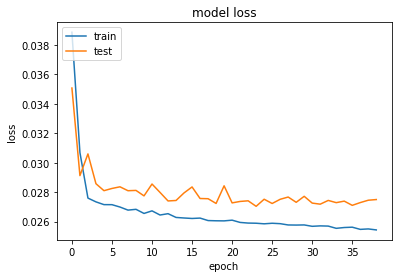

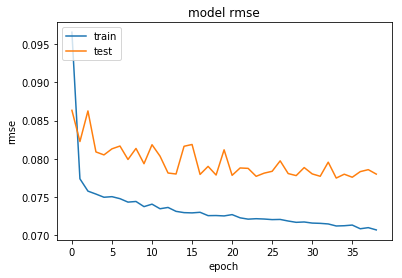

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [16]:
model.load_weights(experiment_name+'.hdf5')

In [17]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = decode_sequence(encoder_input)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  356.0078535079956 s =  5.9334642370541895 min =  0.0988910706837972 h


## Evaluate performance on validation data to improve model

## Evaluate metrics

In [18]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.09005626926092992
Delay 100 ms: 0.016144277334908693
Delay 200 ms: 0.03144125616051533
Delay 300 ms: 0.05006095012231144
Delay 400 ms: 0.06651651127722474
Delay 500 ms: 0.0839397105556656
Delay 600 ms: 0.09988616988025999
Delay 700 ms: 0.11604995363479573
Delay 800 ms: 0.13098829700702788
Delay 900 ms: 0.145886940469179
Delay 1000 ms: 0.15964862616741066

RMSE
Average rmse: 0.17096882418066195
Delay 100 ms: 0.031403972328230834
Delay 200 ms: 0.058727567968124124
Delay 300 ms: 0.09097464112944863
Delay 400 ms: 0.11846894425157069
Delay 500 ms: 0.14678504157174047
Delay 600 ms: 0.17186395482695585
Delay 700 ms: 0.196986738499252
Delay 800 ms: 0.2195470347234525
Delay 900 ms: 0.24195717179912474
Delay 1000 ms: 0.2621301006244105

SMAPE
Average smape: 19.8723856327272
Delay 100 ms: 5.985159875425292
Delay 200 ms: 10.00666827656495
Delay 300 ms: 13.856313565797839
Delay 400 ms: 16.888537802629504
Delay 500 ms: 19.770902028871895
Delay 600 ms: 22.24235226466473
Delay 700 m

(4371, 25, 3) (4371, 10, 3)


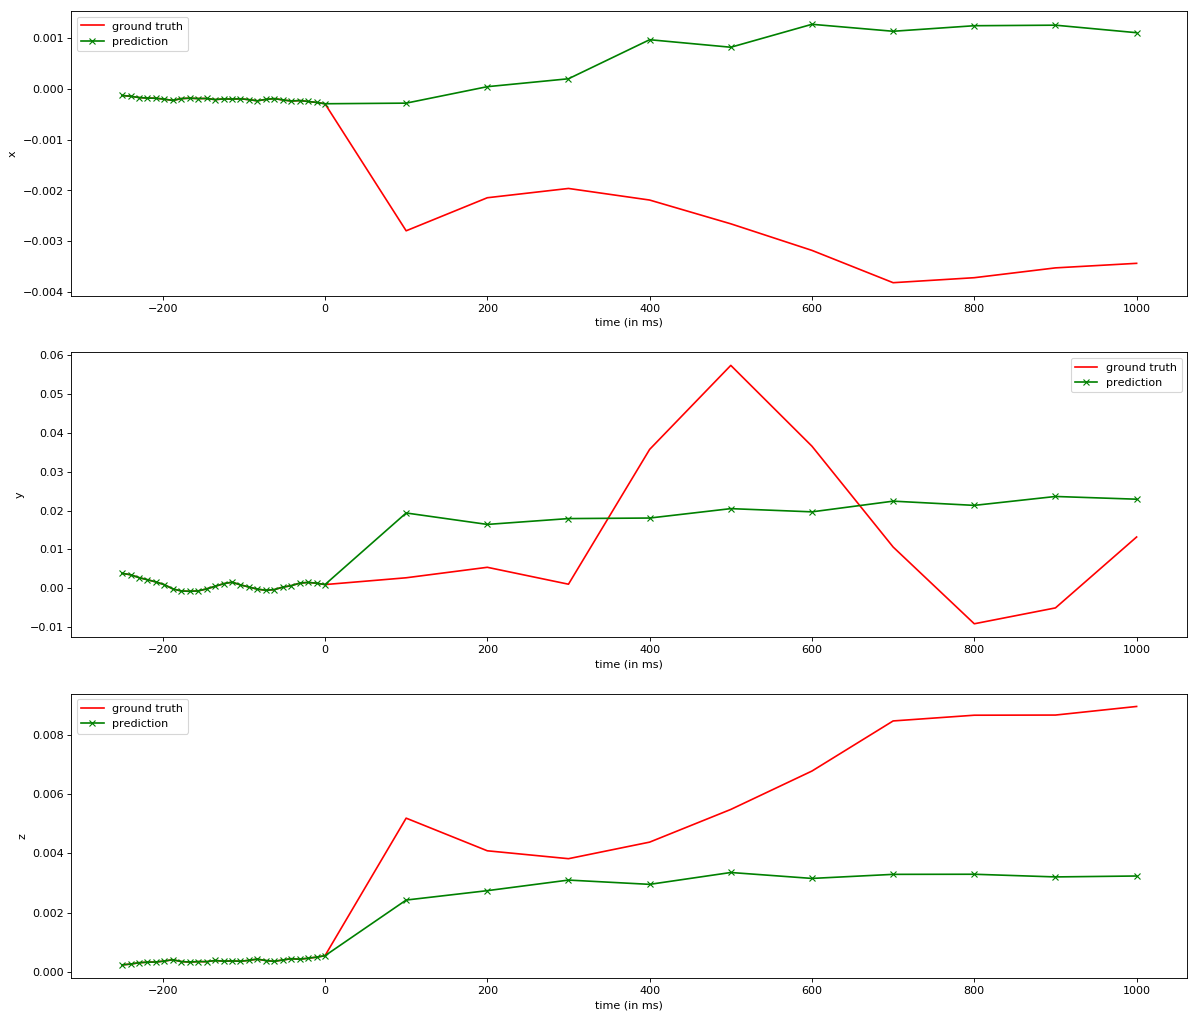

In [19]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)

Y_pred = decode_sequence(encoder_input)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')